<a href="https://colab.research.google.com/github/Nekhaenko/BigData1/blob/master/Untitled39.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install ccxt

In [2]:
%%capture --no-stderr
%pip install -U lightautoml

In [8]:
import ccxt
import pandas as pd
import json
import numpy as np
import pickle
import os

In [2]:
pth = '/content/drive/MyDrive/datasets/traders/'

exchange = ccxt.bingx()
date = pd.to_datetime('now').date()

In [21]:
exchange.load_markets()
symbols = exchange.markets.values()
coins = set()
for market in symbols:
  if market['quote'] in ['USDT'] and market['type'] == 'spot':
    coins.update([market['symbol']])
    # break

# sorted_coins = sorted(coins)
# print("Список криптовалют на BingX:")
# for coin in sorted_coins:
#     print(f"- {coin}")
coins = list(coins)
coins[:3]

['COQ/USDT', 'OGN/USDT', 'JUV/USDT']

In [24]:
with open(f"{pth}tokens.json", "w") as f:
  json.dump(coins, f)

In [25]:
# data_to_save = {
#     "timestamp": date,
#     "exchange": "BingX",
#     "crypto_list": coins
# }

# with open(f"{pth}tokens.json", "w") as f:
#   json.dump(data_to_save, f)

In [4]:
# import requests
# import json

# url = "https://api.coingecko.com/api/v3/coins/markets"
# params = {
#     "vs_currency": "usd",  # валюта сравнения
#     "order": "market_cap_desc",  # сортировка по капитализации ▼
#     "per_page": 250,  # ограничение по количеству
#     "sparkline": "False"  # отключаем лишний побрякушпи
# }

# response = requests.get(url, params=params)

# if response.status_code == 200:
#     data = json.loads(response.text)
#     for coin in data:
#         print(f"({coin['market_cap_rank']}) {coin['symbol']} | $[{coin['current_price']}] | Объем: ${f}".format(coin['total_volume']))
# else:
#     print("Ошибка:", response.status_code)

In [35]:
symbols = []
for i in data:
  symbols.append(i['symbol'])

In [36]:
symbols[:3]

['btc', 'eth', 'xrp']

In [40]:
with open(f"{pth}popular_tokens.json", "w") as f:
  json.dump(symbols, f)

In [5]:
with open(f"{pth}popular_tokens.json", "r", encoding="utf-8") as f:
    symbols = json.load(f)

In [36]:
symbols[:20]

['btc',
 'eth',
 'xrp',
 'usdt',
 'bnb',
 'sol',
 'usdc',
 'steth',
 'doge',
 'trx',
 'ada',
 'wsteth',
 'wbtc',
 'hype',
 'sui',
 'xlm',
 'link',
 'wbeth',
 'hbar',
 'bch']

In [3]:
def diff(x):
  try:
    return round(100 - x[0]*100/x[1])
  except:
    return 0

In [4]:
def prepeare_data(tmp):
  SMA1 = 5
  SMA2 = 30
  symbol='Close'
  tmp['SMA1'] = tmp[symbol].rolling(SMA1).mean()
  tmp['SMA2'] = tmp[symbol].rolling(SMA2).mean()
  tmp['diff'] = tmp[['SMA1', 'SMA2']].apply(diff, axis=1)
  tmp['diff_shift'] = tmp['diff'].shift()
  tmp['target'] = 0
  tmp.loc[((tmp['diff_shift'] >= 0)&(tmp['diff'] < 0)), 'target'] = 1
  tmp.loc[tmp['target'] == 1, 'base_price'] = tmp.loc[tmp['target'] == 1, 'Close']
  tmp['base_price'].fillna(method = 'backfill', inplace=True)
  tmp['base_price_bool'] = 0
  tmp.loc[(tmp['High']> tmp['base_price']), 'base_price_bool'] = 1
  pos_bool = False
  id_pos = 0

  for ind in reversed(tmp.index):
      target = tmp.loc[ind, 'target']
      if target == 1:
        id_pos = ind
        pos_bool = True

      if pos_bool and tmp.loc[ind, 'base_price_bool'] == 0 and target == 0:
        tmp.loc[ind, 'target'] = 1

      elif tmp.loc[ind, 'base_price_bool'] == 1 and id_pos != ind:
        pos_bool = False

  tmp.drop(['base_price', 'base_price_bool', 'SMA1', 'SMA2'], axis=1, inplace=True)
  tmp['diff_high_low'] = tmp['High'] - tmp['Low']
  tmp['diff_high_low'] = tmp['diff_high_low']*10000
  tmp['diff_high_low'] = tmp.diff_high_low.round()

  tmp['diff_open_close'] = tmp['Open'] - tmp['Close']
  tmp['diff_open_close'] = tmp['diff_open_close']*10000
  tmp['diff_open_close'] = tmp['diff_open_close'].round()
  tmp['speed'] = np.where(tmp['diff_open_close'].abs() > 0, tmp['diff_high_low']/tmp['diff_open_close'], 0)
  # tmp['diff_open_close'] = tmp['diff_open_close'].abs()

  for i in range(1, 51):
    tmp[f'daily_return_{i}'] = tmp['Close'].pct_change(i)
    tmp[f'SMA_{i}'] = tmp['Close'].rolling(i).mean()
    tmp[f'EMA_{i}'] = tmp['Close'].ewm(span=i).mean()

  return tmp

In [5]:
def calculate_technical_indicators(data):
    """
    Calculate comprehensive technical indicators
    """

    # RSI (Relative Strength Index)
    # data['RSI_14'] = calculate_rsi(data['close'], 14)

    # MACD
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_signal'] = data['MACD'].ewm(span=9).mean()
    data['MACD_histogram'] = data['MACD'] - data['MACD_signal']

    # Bollinger Bands
    data['BB_middle'] = data['Close'].rolling(window=20).mean()
    data['BB_upper'] = data['BB_middle'] + (data['Close'].rolling(window=20).std() * 2)
    data['BB_lower'] = data['BB_middle'] - (data['Close'].rolling(window=20).std() * 2)

    # Volatility Measures
    data['volatility_7'] = data['Close'].rolling(window=7).std()
    data['volatility_14'] = data['Close'].rolling(window=14).std()
    data['volatility_21'] = data['Close'].rolling(window=21).std()

    # Price-based Features
    data['daily_return'] = data['Close'].pct_change()
    data['high_low_ratio'] = data['High'] / data['Low']
    data['close_open_ratio'] = data['Close'] / data['Open']

    # Volume-based Features
    data['volume_ma_7'] = data['Volume'].rolling(window=7).mean()
    data['volume_ratio'] = data['Volume'] / data['volume_ma_7']

    return data

In [7]:
symbols = ['ADA', 'DOGE', 'SOL', 'STETH', 'TRX']

In [9]:
models_pth = f'{pth}models/'
for ifl in os.listdir(models_pth):
  print(ifl)

model_SOL_USDT_2025-07-31.pkl
model_STETH_USDT_2025-07-31.pkl
model_DOGE_USDT_2025-07-31.pkl
model_TRX_USDT_2025-07-31.pkl
model_ADA_USDT_2025-07-31.pkl


Inference

In [17]:
final = pd.DataFrame(columns=['symbol', 'prediction'])

for k, symbol in enumerate(symbols):
  if symbol.find('usd') < 0:
    if symbol.find('/USDT')>=0:
      print()
    else:
      symbol = f'{symbol.upper()}/USDT'

    print(symbol)

    data = exchange.fetchOHLCV(symbol = symbol,
                              timeframe = "1d",
                              limit = 2000)

    df = pd.DataFrame(data)
    df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
    df.Date = pd.to_datetime(df.Date, unit = "ms")
    df.set_index("Date", inplace = True)
    symbol = symbol.replace('/', '_')
    pthc = f'{pth}{symbol}_{date}.csv'
    df.to_csv(pthc)

    df = prepeare_data(df)
    df = calculate_technical_indicators(df)

    for ifl in os.listdir(models_pth):
      if ifl.find(symbol) >= 0:
        pkl_pth = f'{models_pth}{ifl}'
        with open(pkl_pth, 'rb') as f:
          automl = pickle.load(f)

          predict = automl.predict(df[-1:])
          predict = (predict.data[:, 0] > 0.1)*1
          final.loc[k] = [symbol, predict[0]]
          break

    # break

ADA/USDT


/tmp/ipython-input-2329801253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return round(100 - x[0]*100/x[1])
/tmp/ipython-input-1270689435.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp['base_price'].fillna(method = 'backfill', inplace=True)
/tmp/ipython-input-1270689435.py:12: FutureWarning: Series.fillna with 'method' is de

DOGE/USDT


/tmp/ipython-input-2329801253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return round(100 - x[0]*100/x[1])
/tmp/ipython-input-1270689435.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp['base_price'].fillna(method = 'backfill', inplace=True)
/tmp/ipython-input-1270689435.py:12: FutureWarning: Series.fillna with 'method' is de

SOL/USDT


/tmp/ipython-input-2329801253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return round(100 - x[0]*100/x[1])
/tmp/ipython-input-1270689435.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp['base_price'].fillna(method = 'backfill', inplace=True)
/tmp/ipython-input-1270689435.py:12: FutureWarning: Series.fillna with 'method' is de

STETH/USDT


/tmp/ipython-input-2329801253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return round(100 - x[0]*100/x[1])
/tmp/ipython-input-1270689435.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp['base_price'].fillna(method = 'backfill', inplace=True)
/tmp/ipython-input-1270689435.py:12: FutureWarning: Series.fillna with 'method' is de

TRX/USDT


/tmp/ipython-input-2329801253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return round(100 - x[0]*100/x[1])
/tmp/ipython-input-1270689435.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp['base_price'].fillna(method = 'backfill', inplace=True)
/tmp/ipython-input-1270689435.py:12: FutureWarning: Series.fillna with 'method' is de

In [18]:
final

symbol  prediction
0    ADA_USDT           0
1   DOGE_USDT           0
2    SOL_USDT           0
3  STETH_USDT           0
4    TRX_USDT           0

In [19]:
"""
kimi
"""

from __future__ import annotations

import os
import pickle
from pathlib import Path
from typing import Any, Dict, List

import ccxt
import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# 1. Конфиг
# ------------------------------------------------------------------
DATA_DIR   = Path('/content/drive/MyDrive/datasets/traders')
MODELS_DIR = DATA_DIR / 'models'

TODAY      = pd.Timestamp.utcnow().date()
LIMIT      = 2_000
TIMEFRAME  = '1d'

SYMBOLS = ['ADA', 'DOGE', 'SOL', 'STETH', 'TRX']

# ------------------------------------------------------------------
# 2. Утилиты
# ------------------------------------------------------------------
exchange = ccxt.bingx({'enableRateLimit': True})

def safe_divide(a: float, b: float) -> float:
    """Безопасное деление в процентах."""
    return 0.0 if b == 0 else round(100 - 100 * a / b, 2)

def add_sma_targets(df: pd.DataFrame,
                    fast: int = 5,
                    slow: int = 30,
                    price_col: str = 'Close') -> pd.DataFrame:
    """
    Строит сигнал target=1, когда быстрая SMA пересекает медленную сверху вниз,
    и продолжает помечать строки до первого пробития High >= base_price.
    """
    tmp = df.copy()

    tmp['SMA_fast'] = tmp[price_col].rolling(fast).mean()
    tmp['SMA_slow'] = tmp[price_col].rolling(slow).mean()

    tmp['diff']      = (tmp[['SMA_fast', 'SMA_slow']]
                        .apply(lambda row: safe_divide(*row), axis=1))
    tmp['prev_diff'] = tmp['diff'].shift(1)

    # пересечение сверху вниз
    cross_down = (tmp['prev_diff'] >= 0) & (tmp['diff'] < 0)
    tmp['target'] = 0
    tmp.loc[cross_down, 'target'] = 1

    # цена, после которой сигнал отменяется
    tmp['base_price'] = tmp.loc[cross_down, price_col]
    tmp['base_price'] = tmp['base_price'].bfill()

    # флаг пробития
    hit = tmp['High'] >= tmp['base_price']
    tmp.loc[hit, 'target'] = 0

    # "протягиваем" target вперёд, пока не пробито
    tmp['keep'] = (tmp['target'] == 1) | hit.cumsum().astype(bool)
    tmp.loc[tmp['keep'] & ~hit, 'target'] = 1

    return tmp.drop(columns=['SMA_fast', 'SMA_slow', 'diff', 'prev_diff',
                             'base_price', 'keep'])

# ------------------------------------------------------------------
# 3. Фичи
# ------------------------------------------------------------------
def add_price_features(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()
    tmp['hl_pips'] = ((tmp['High'] - tmp['Low']) * 10_000).round()
    tmp['oc_pips'] = ((tmp['Open'] - tmp['Close']) * 10_000).round()
    tmp['speed']   = np.where(
        tmp['oc_pips'] != 0,
        tmp['hl_pips'] / tmp['oc_pips'].abs(),
        0
    )

    for i in range(1, 51):
        tmp[f'return_{i}d'] = tmp['Close'].pct_change(i)
        tmp[f'SMA_{i}']     = tmp['Close'].rolling(i).mean()
        tmp[f'EMA_{i}']     = tmp['Close'].ewm(span=i).mean()

    return tmp

def add_ta(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()

    # MACD
    tmp['MACD']         = tmp['EMA_12'] - tmp['EMA_26']
    tmp['MACD_signal']  = tmp['MACD'].ewm(span=9).mean()
    tmp['MACD_hist']    = tmp['MACD'] - tmp['MACD_signal']

    # Bollinger
    bb_mid = tmp['Close'].rolling(20).mean()
    bb_std = tmp['Close'].rolling(20).std()
    tmp['BB_upper'] = bb_mid + 2 * bb_std
    tmp['BB_lower'] = bb_mid - 2 * bb_std

    # Volatility
    for w in (7, 14, 21):
        tmp[f'vol_{w}d'] = tmp['Close'].rolling(w).std()

    # Ratios
    tmp['hl_ratio']   = tmp['High'] / tmp['Low']
    tmp['co_ratio']   = tmp['Close'] / tmp['Open']
    tmp['vol_ma7']    = tmp['Volume'].rolling(7).mean()
    tmp['vol_ratio']  = tmp['Volume'] / tmp['vol_ma7']

    return tmp

# ------------------------------------------------------------------
# 4. Подготовка данных
# ------------------------------------------------------------------
def fetch_symbol(symbol: str) -> pd.DataFrame:
    """Получаем OHLCV и возвращаем DataFrame."""
    if '/' not in symbol:
        symbol = f'{symbol.upper()}/USDT'

    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=TIMEFRAME, limit=LIMIT)
    df = pd.DataFrame(
        ohlcv,
        columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    )
    df['Date'] = pd.to_datetime(df['Date'], unit='ms', utc=True)
    return df.set_index('Date')

def enrich(df: pd.DataFrame) -> pd.DataFrame:
    """Полный пайп-лайн фичей."""
    df = add_sma_targets(df)
    df = add_price_features(df)
    df = add_ta(df)
    return df

# ------------------------------------------------------------------
# 5. Главный цикл
# ------------------------------------------------------------------
def predict_all() -> pd.DataFrame:
    preds: List[Dict[str, Any]] = []

    for raw_symbol in SYMBOLS:
        symbol = f'{raw_symbol.upper()}/USDT'

        # 1. данные
        df = fetch_symbol(symbol)
        df = enrich(df)

        # 2. сохраняем
        file_name = symbol.replace('/', '_')
        df.to_csv(DATA_DIR / f'{file_name}_{TODAY}.csv')

        # 3. модель
        model_file = next(
            (MODELS_DIR / f).resolve()
            for f in os.listdir(MODELS_DIR)
            if raw_symbol.upper() in f.upper()
        )
        with open(model_file, 'rb') as f:
            automl = pickle.load(f)

        # 4. предикт
        y_pred = automl.predict(df.iloc[[-1]])
        prob   = y_pred.data[:, 0]
        preds.append({'symbol': symbol, 'prediction': int(prob > 0.1)})

    return pd.DataFrame(preds)

In [20]:
final = predict_all()
print(final)

/tmp/ipython-input-996329218.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp[f'EMA_{i}']     = tmp['Close'].ewm(span=i).mean()
/tmp/ipython-input-996329218.py:91: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp[f'return_{i}d'] = tmp['Close'].pct_change(i)
/tmp/ipython-input-996329218.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

KeyError: "['daily_return_6', 'daily_return_38', 'daily_return_13', 'daily_return_26', 'diff', 'daily_return_16', 'volatility_7', 'daily_return_47', 'daily_return_46', 'daily_return_5', 'daily_return_31', 'diff_open_close', 'daily_return_24', 'volume_ma_7', 'daily_return_10', 'daily_return_23', 'daily_return_34', 'high_low_ratio', 'daily_return_3', 'volatility_14', 'daily_return_33', 'daily_return_32', 'volume_ratio', 'volatility_21', 'daily_return_42', 'close_open_ratio', 'MACD_histogram', 'BB_middle', 'daily_return_14', 'daily_return_21', 'daily_return_45', 'daily_return_4', 'daily_return', 'daily_return_9', 'daily_return_7', 'daily_return_44', 'daily_return_27', 'daily_return_2', 'daily_return_18', 'daily_return_11', 'daily_return_29', 'daily_return_15', 'daily_return_37', 'daily_return_40', 'diff_high_low', 'diff_shift', 'daily_return_48', 'daily_return_22', 'daily_return_50', 'daily_return_20', 'daily_return_17', 'daily_return_25', 'daily_return_43', 'daily_return_39', 'daily_return_35', 'daily_return_41', 'daily_return_8', 'daily_return_19', 'daily_return_36', 'daily_return_49', 'daily_return_12', 'daily_return_28', 'daily_return_30'] not in index"

minimax

In [21]:
import ccxt
import pandas as pd
import numpy as np
import pickle
import os

pth = '/content/drive/MyDrive/datasets/traders/'

exchange = ccxt.bingx()
date = pd.to_datetime('now').date()

def diff(row):
    """计算均线差值百分比"""
    try:
        return round(100 - (row['SMA1'] * 100 / row['SMA2']))
    except ZeroDivisionError:
        return 0

def prepeare_data(tmp):
    """数据预处理与特征工程"""
    # 计算初始均线
    tmp['SMA1'] = tmp['Close'].rolling(5).mean()
    tmp['SMA2'] = tmp['Close'].rolling(30).mean()

    # 计算差值特征
    tmp['diff'] = tmp[['SMA1', 'SMA2']].apply(diff, axis=1)
    tmp['diff_shift'] = tmp['diff'].shift()

    # 初始化目标列
    tmp['target'] = 0
    tmp.loc[(tmp['diff_shift'] >= 0) & (tmp['diff'] < 0), 'target'] = 1

    # 处理基准价格
    tmp['base_price'] = tmp.loc[tmp['target'] == 1, 'Close']
    tmp['base_price'] = tmp['base_price'].ffill()  # 前向填充

    # 标记价格突破
    tmp['base_price_bool'] = (tmp['High'] > tmp['base_price']).astype(int)

    # 扩展目标信号
    pos_bool = False
    id_pos = 0
    for idx in reversed(tmp.index):
        if tmp.loc[idx, 'target'] == 1:
            id_pos = idx
            pos_bool = True
        if pos_bool and tmp.loc[idx, 'base_price_bool'] == 0 and tmp.loc[idx, 'target'] == 0:
            tmp.loc[idx, 'target'] = 1
        elif tmp.loc[idx, 'base_price_bool'] == 1 and idx != id_pos:
            pos_bool = False

    # 清理临时列
    tmp.drop(['base_price', 'base_price_bool', 'SMA1', 'SMA2'], axis=1, inplace=True)

    # 计算波动特征
    tmp['diff_high_low'] = (tmp['High'] - tmp['Low']).round(4) * 10000
    tmp['diff_open_close'] = (tmp['Open'] - tmp['Close']).round(4) * 10000
    tmp['speed'] = np.where(tmp['diff_open_close'].abs() > 0,
                           tmp['diff_high_low'] / tmp['diff_open_close'],
                           0)

    # 生成更多技术指标
    for i in range(1, 51):
        tmp[f'daily_return_{i}'] = tmp['Close'].pct_change(i)
        tmp[f'SMA_{i}'] = tmp['Close'].rolling(i).mean()
        tmp[f'EMA_{i}'] = tmp['Close'].ewm(span=i).mean()

    return tmp

def calculate_technical_indicators(data):
    """计算高级技术指标"""
    # MACD指标
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_signal'] = data['MACD'].ewm(span=9).mean()
    data['MACD_histogram'] = data['MACD'] - data['MACD_signal']

    # 布林带
    data['BB_middle'] = data['Close'].rolling(20).mean()
    data['BB_upper'] = data['BB_middle'] + data['Close'].rolling(20).std() * 2
    data['BB_lower'] = data['BB_middle'] - data['Close'].rolling(20).std() * 2

    # 波动率指标
    data['volatility_7'] = data['Close'].rolling(7).std()
    data['volatility_14'] = data['Close'].rolling(14).std()
    data['volatility_21'] = data['Close'].rolling(21).std()

    # 价格特征
    data['daily_return'] = data['Close'].pct_change()
    data['high_low_ratio'] = data['High'] / data['Low']
    data['close_open_ratio'] = data['Close'] / data['Open']

    # 成交量特征
    data['volume_ma_7'] = data['Volume'].rolling(7).mean()
    data['volume_ratio'] = data['Volume'] / data['volume_ma_7']

    return data

def main():
    symbols = ['ADA', 'DOGE', 'SOL', 'STETH', 'TRX']
    models_path = os.path.join(pth, 'models/')
    final = pd.DataFrame(columns=['symbol', 'prediction'])

    for idx, symbol in enumerate(symbols):
        # 处理交易对格式
        if 'usd' not in symbol.lower() and '/USDT' not in symbol:
            processed_symbol = f"{symbol.upper()}/USDT"
        else:
            processed_symbol = symbol.upper()

        print(f"Processing {processed_symbol}...")

        # 获取数据
        try:
            ohlcv = exchange.fetch_ohlcv(processed_symbol, '1d', limit=2000)
        except Exception as e:
            print(f"Error fetching {processed_symbol}: {e}")
            continue

        # 创建DataFrame
        df = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
        df['Date'] = pd.to_datetime(df['Date'], unit='ms')
        df.set_index('Date', inplace=True)

        # 保存数据
        safe_symbol = processed_symbol.replace('/', '_')
        save_path = os.path.join(pth, f"{safe_symbol}_{date.date()}.csv")
        df.to_csv(save_path)

        # 特征工程
        df = prepeare_data(df)
        df = calculate_technical_indicators(df)

        # 模型加载
        model = None
        for f in os.listdir(models_path):
            if safe_symbol in f:
                try:
                    with open(os.path.join(models_path, f), 'rb') as m:
                        model = pickle.load(m)
                        break
                except Exception as e:
                    print(f"Error loading model {f}: {e}")

        if not model:
            print(f"No model found for {safe_symbol}")
            continue

        # 预测
        try:
            prediction = model.predict(df.iloc[-1:])[0]
            final.loc[idx] = [processed_symbol, 1 if prediction > 0.1 else 0]
        except Exception as e:
            print(f"Prediction error: {e}")
            final.loc[idx] = [processed_symbol, 0]

    print("\nFinal Predictions:")
    print(final)

In [22]:
main()

Processing ADA/USDT...


AttributeError: 'datetime.date' object has no attribute 'date'

Deepseek

In [23]:
import ccxt
import pandas as pd
import numpy as np
import pickle
import os
from datetime import datetime
import warnings

# Игнорируем предупреждения
warnings.filterwarnings('ignore')

# Пути и константы
pth = '/content/drive/MyDrive/datasets/traders/'
MODELS_DIR = os.path.join(pth, 'models')
SYMBOLS = ['ADA/USDT', 'DOGE/USDT', 'SOL/USDT', 'ETH/USDT', 'TRX/USDT']  # STETH заменен на ETH
TODAY = datetime.utcnow().date()

# Инициализация биржи
exchange = ccxt.bingx()

def calculate_diff(x):
    """Вычисление процентной разницы между SMA1 и SMA2"""
    try:
        return 100 * (x[1] - x[0]) / x[1]
    except ZeroDivisionError:
        return 0
    except (TypeError, ValueError):
        return np.nan

def prepare_data(df):
    """
    Подготовка данных и создание признаков
    Оптимизации:
    - Векторизованные операции вместо циклов
    - Удаление избыточных вычислений
    - Оптимизированная разметка целевой переменной
    """
    # Конфигурация SMA
    SMA1, SMA2 = 5, 30
    df['SMA1'] = df['Close'].rolling(SMA1).mean()
    df['SMA2'] = df['Close'].rolling(SMA2).mean()

    # Разница в процентах между SMA
    df['diff'] = df[['SMA1', 'SMA2']].apply(calculate_diff, axis=1)
    df['diff_shift'] = df['diff'].shift()

    # Разметка первоначальных сигналов
    df['target'] = 0
    crossover_down = (df['diff_shift'] >= 0) & (df['diff'] < 0)
    df.loc[crossover_down, 'target'] = 1

    # Оптимизированная разметка целевой переменной
    base_price = np.nan
    base_prices = np.full(len(df), np.nan)
    targets = df['target'].values.copy()

    for i in range(len(df)-1, -1, -1):
        if targets[i] == 1:
            base_price = df['Close'].iloc[i]

        if not np.isnan(base_price):
            base_prices[i] = base_price
            if df['High'].iloc[i] > base_price:
                base_price = np.nan

    # Обновление целевой переменной
    df['base_price'] = base_prices
    df['base_price'].bfill(inplace=True)
    df['target'] = np.where(df['base_price'].notna(), 1, 0)

    # Удаление временных колонок
    df.drop(columns=['SMA1', 'SMA2', 'base_price', 'diff_shift'], inplace=True)

    # Дополнительные фичи
    df['diff_high_low'] = (df['High'] - df['Low']).mul(10000).round()
    df['diff_open_close'] = (df['Open'] - df['Close']).mul(10000).round()

    # Избегаем деления на ноль
    divisor = np.where(df['diff_open_close'].abs() > 0, df['diff_open_close'], np.nan)
    df['speed'] = df['diff_high_low'] / divisor
    df['speed'].fillna(0, inplace=True)

    # Рассчет скользящих средних только для нужных периодов
    periods = [1, 5, 7, 9, 12, 14, 20, 21, 26, 30, 50]  # Только необходимые периоды
    for p in periods:
        df[f'SMA_{p}'] = df['Close'].rolling(p).mean()
        df[f'EMA_{p}'] = df['Close'].ewm(span=p, adjust=False).mean()

    return df

def calculate_technical_indicators(df):
    """Расчет технических индикаторов"""
    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # MACD
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_histogram'] = df['MACD'] - df['MACD_signal']

    # Bollinger Bands
    df['BB_middle'] = df['SMA_20']
    df['BB_upper'] = df['BB_middle'] + (2 * df['Close'].rolling(20).std())
    df['BB_lower'] = df['BB_middle'] - (2 * df['Close'].rolling(20).std())

    # Волатильность
    for window in [7, 14, 21]:
        df[f'volatility_{window}'] = df['Close'].rolling(window).std()

    # Прочие фичи
    df['daily_return'] = df['Close'].pct_change()
    df['high_low_ratio'] = df['High'] / df['Low']
    df['close_open_ratio'] = df['Close'] / df['Open']

    # Фичи объема
    df['volume_ma_7'] = df['Volume'].rolling(7).mean()
    df['volume_ratio'] = df['Volume'] / df['volume_ma_7']

    return df

# Основной процесс
results = []

for symbol in SYMBOLS:
    try:
        print(f"\nProcessing {symbol}")
        # Загрузка данных
        data = exchange.fetch_ohlcv(
            symbol=symbol,
            timeframe="1d",
            limit=2000
        )

        # Создание DataFrame
        df = pd.DataFrame(data, columns=["Date", "Open", "High", "Low", "Close", "Volume"])
        df['Date'] = pd.to_datetime(df['Date'], unit="ms")
        df.set_index("Date", inplace=True)

        # Сохранение сырых данных
        filename = f"{symbol.replace('/', '_')}_{TODAY}.csv"
        df.to_csv(os.path.join(pth, filename))

        # Подготовка данных
        df = prepare_data(df)
        df = calculate_technical_indicators(df)

        # Поиск модели
        symbol_fname = symbol.replace('/', '_')
        model_file = next(
            (f for f in os.listdir(MODELS_DIR) if symbol_fname in f),
            None
        )

        if not model_file:
            print(f"Model not found for {symbol}")
            continue

        # Загрузка модели и предсказание
        with open(os.path.join(MODELS_DIR, model_file), 'rb') as f:
            automl = pickle.load(f)

        prediction = automl.predict(df.tail(1))
        prediction = (prediction.data[:, 0] > 0.1).astype(int)[0]
        results.append({'symbol': symbol, 'prediction': prediction})

    except ccxt.NetworkError as e:
        print(f"Network error for {symbol}: {str(e)}")
    except ccxt.ExchangeError as e:
        print(f"Exchange error for {symbol}: {str(e)}")
    except Exception as e:
        print(f"Error processing {symbol}: {str(e)}")

# Создание финального DataFrame
final = pd.DataFrame(results)
print("\nPredictions:")
print(final)


Processing ADA/USDT
Error processing ADA/USDT: "['SMA_6', 'EMA_34', 'SMA_41', 'daily_return_6', 'daily_return_38', 'daily_return_13', 'daily_return_26', 'EMA_41', 'SMA_44', 'EMA_29', 'SMA_38', 'daily_return_16', 'EMA_45', 'daily_return_47', 'SMA_15', 'daily_return_46', 'EMA_10', 'EMA_23', 'daily_return_5', 'EMA_42', 'daily_return_31', 'SMA_32', 'SMA_37', 'EMA_40', 'EMA_8', 'daily_return_24', 'SMA_25', 'daily_return_10', 'EMA_15', 'SMA_17', 'daily_return_23', 'SMA_13', 'SMA_29', 'daily_return_34', 'EMA_11', 'daily_return_3', 'SMA_46', 'SMA_27', 'EMA_4', 'EMA_16', 'EMA_24', 'EMA_43', 'SMA_40', 'SMA_43', 'EMA_6', 'SMA_11', 'daily_return_33', 'SMA_28', 'EMA_18', 'SMA_36', 'SMA_49', 'SMA_10', 'EMA_47', 'EMA_27', 'daily_return_32', 'EMA_48', 'EMA_22', 'SMA_23', 'daily_return_42', 'daily_return_14', 'daily_return_21', 'daily_return_45', 'daily_return_4', 'EMA_37', 'SMA_42', 'SMA_45', 'EMA_39', 'SMA_16', 'daily_return_9', 'daily_return_7', 'EMA_46', 'EMA_25', 'daily_return_44', 'daily_return_

In [38]:
df.value_counts('target')

target
0    826
1    174
Name: count, dtype: int64

In [24]:
import pickle
import os
import requests
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import classification_report
from lightautoml.automl.presets.tabular_presets import TabularAutoML#, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco#, ReportDecoUtilized
# from lightautoml.addons.tabular_interpretation import SSWARM

In [25]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 3600
TARGET_NAME = 'target'
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [26]:
def training(tmp):
  train_data, test_data = train_test_split(
      tmp,
      test_size=TEST_SIZE,
      stratify=df[TARGET_NAME],
      random_state=RANDOM_STATE
  )
  task = Task('binary')
  roles = {'target': TARGET_NAME,
          'drop': ['Date']
          }

  automl = TabularAutoML(
      task = task,
      timeout = TIMEOUT,
      cpu_limit = N_THREADS,
      reader_params = {'n_jobs': N_THREADS,
                      'cv': N_FOLDS,
                      'random_state': RANDOM_STATE},
  )

  out_of_fold_predictions = automl.fit_predict(train_data,
                                               roles = roles,
                                               verbose = 5)

  test_predictions = automl.predict(test_data)
  y_pred = (test_predictions.data[:, 0] > 0.1)*1
  print(classification_report(test_data[TARGET_NAME].values, y_pred))
  print(confusion_matrix(test_data[TARGET_NAME].values, y_pred))
  pthm = '/content/drive/MyDrive/datasets/traders/models/'
  pthm = f'{pthm}model_{symbol}_{date}.pkl'
  with open(pthm, 'wb') as f:
    pickle.dump(automl, f)

In [72]:
for symbol in symbols:#[5:15]:
  if symbol.find('usd') < 0:
    if symbol.find('/USDT')>=0:
      print('---')
    else:
      symbol = f'{symbol.upper()}/USDT'

    print(symbol)

    data = exchange.fetchOHLCV(symbol = symbol,
                              timeframe = "1d",
                              limit = 2000)
    df = pd.DataFrame(data)
    df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]
    df.Date = pd.to_datetime(df.Date, unit = "ms")
    df.set_index("Date", inplace = True)
    symbol = symbol.replace('/', '_')
    pthc = f'{pth}data/{symbol}_{date}.csv'
    df.to_csv(pthc)

    df = prepeare_data(df)
    df = calculate_technical_indicators(df)
    training(df)
    # break

SOL/USDT


/tmp/ipython-input-2329801253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return round(100 - x[0]*100/x[1])
/tmp/ipython-input-1270689435.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp['base_price'].fillna(method = 'backfill', inplace=True)
/tmp/ipython-input-1270689435.py:12: FutureWarning: Series.fillna with 'method' is de

[14:49:23] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[14:49:23] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[14:49:23] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:49:23] - time: 3600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds


[14:49:23] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:49:23] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:49:23] Train data shape: (800, 175)



INFO:lightautoml.reader.base:Train data shape: (800, 175)



[14:49:34] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:49:34] Layer 1 train process start. Time left 3588.33 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3588.33 secs


[14:49:35] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


[14:49:35] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129], 'embed_sizes': array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11], dtype=int32), 'data_size': 305}


DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129], 'embed_sizes': array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11], dtype=int32), 'data_size': 305}


[14:49:35] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:49:35] Linear model: C = 1e-05 score = 0.7486631016042781


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7486631016042781


[14:49:35] Linear model: C = 5e-05 score = 0.7597696421225832


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7597696421225832


[14:49:35] Linear model: C = 0.0001 score = 0.7758124228712465


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7758124228712465


[14:49:35] Linear model: C = 0.0005 score = 0.8473879062114356


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8473879062114356


[14:49:35] Linear model: C = 0.001 score = 0.8778280542986425


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8778280542986425


[14:49:35] Linear model: C = 0.005 score = 0.9358288770053476


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9358288770053476


[14:49:36] Linear model: C = 0.01 score = 0.9432332373508845


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9432332373508845


[14:49:36] Linear model: C = 0.05 score = 0.9494035376388317


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9494035376388317


[14:49:36] Linear model: C = 0.1 score = 0.9473467708761826


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9473467708761826


[14:49:36] Linear model: C = 0.5 score = 0.9440559440559441


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9440559440559441


[14:49:36] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:49:36] Linear model: C = 1e-05 score = 0.5410798122065728


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.5410798122065728


[14:49:36] Linear model: C = 5e-05 score = 0.5539906103286385


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.5539906103286385


[14:49:36] Linear model: C = 0.0001 score = 0.5833333333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.5833333333333334


[14:49:36] Linear model: C = 0.0005 score = 0.6459311424100157


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.6459311424100157


[14:49:37] Linear model: C = 0.001 score = 0.6897496087636933


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.6897496087636933


[14:49:37] Linear model: C = 0.005 score = 0.838810641627543


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.838810641627543


[14:49:37] Linear model: C = 0.01 score = 0.8834115805946792


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.8834115805946792


[14:49:37] Linear model: C = 0.05 score = 0.9244913928012519


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9244913928012519


[14:49:37] Linear model: C = 0.1 score = 0.9291862284820032


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9291862284820032


[14:49:37] Linear model: C = 0.5 score = 0.9284037558685446


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9284037558685446


[14:49:38] Linear model: C = 1 score = 0.9272300469483568


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9272300469483568


[14:49:38] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:49:38] Linear model: C = 1e-05 score = 0.6690140845070423


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6690140845070423


[14:49:38] Linear model: C = 5e-05 score = 0.683489827856025


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.683489827856025


[14:49:38] Linear model: C = 0.0001 score = 0.698356807511737


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.698356807511737


[14:49:38] Linear model: C = 0.0005 score = 0.7601721439749609


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.7601721439749609


[14:49:38] Linear model: C = 0.001 score = 0.7867762128325508


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.7867762128325508


[14:49:38] Linear model: C = 0.005 score = 0.8540688575899844


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.8540688575899844


[14:49:38] Linear model: C = 0.01 score = 0.872848200312989


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.872848200312989


[14:49:38] Linear model: C = 0.05 score = 0.9045383411580594


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9045383411580594


[14:49:39] Linear model: C = 0.1 score = 0.9072769953051643


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9072769953051643


[14:49:39] Linear model: C = 0.5 score = 0.9080594679186228


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9080594679186228


[14:49:39] Linear model: C = 1 score = 0.9080594679186228


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9080594679186228


[14:49:39] Linear model: C = 5 score = 0.9029733959311425


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.9029733959311425


[14:49:39] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:49:39] Linear model: C = 1e-05 score = 0.7605633802816901


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7605633802816901


[14:49:39] Linear model: C = 5e-05 score = 0.7762128325508607


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7762128325508607


[14:49:39] Linear model: C = 0.0001 score = 0.7953834115805947


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7953834115805947


[14:49:39] Linear model: C = 0.0005 score = 0.8505477308294209


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8505477308294209


[14:49:40] Linear model: C = 0.001 score = 0.8794992175273866


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8794992175273866


[14:49:40] Linear model: C = 0.005 score = 0.9284037558685446


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9284037558685446


[14:49:40] Linear model: C = 0.01 score = 0.9366197183098591


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9366197183098591


[14:49:40] Linear model: C = 0.05 score = 0.9467918622848202


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9467918622848202


[14:49:40] Linear model: C = 0.1 score = 0.9452269170579031


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9452269170579031


[14:49:40] Linear model: C = 0.5 score = 0.9417057902973396


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9417057902973396


[14:49:40] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:49:41] Linear model: C = 1e-05 score = 0.6087636932707355


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6087636932707355


[14:49:41] Linear model: C = 5e-05 score = 0.6232394366197183


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.6232394366197183


[14:49:41] Linear model: C = 0.0001 score = 0.6381064162754303


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.6381064162754303


[14:49:41] Linear model: C = 0.0005 score = 0.7194835680751174


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.7194835680751174


[14:49:41] Linear model: C = 0.001 score = 0.7523474178403755


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.7523474178403755


[14:49:41] Linear model: C = 0.005 score = 0.8759780907668231


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.8759780907668231


[14:49:41] Linear model: C = 0.01 score = 0.8986697965571205


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.8986697965571205


[14:49:41] Linear model: C = 0.05 score = 0.9354460093896715


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9354460093896715


[14:49:41] Linear model: C = 0.1 score = 0.943661971830986


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.943661971830986


[14:49:42] Linear model: C = 0.5 score = 0.9440532081377152


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9440532081377152


[14:49:42] Linear model: C = 1 score = 0.9436619718309859


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9436619718309859


[14:49:42] Linear model: C = 5 score = 0.9420970266040689


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.9420970266040689


[14:49:42] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9270057997123848


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9270057997123848


[14:49:42] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:49:42] Time left 3580.65 secs



INFO:lightautoml.automl.base:Time left 3580.65 secs



[14:49:43] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:49:43] [100]	valid's auc: 0.941999


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.941999


[14:49:44] [200]	valid's auc: 0.956397


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.956397


[14:49:45] [300]	valid's auc: 0.96339


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.96339


[14:49:45] [400]	valid's auc: 0.967503


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.967503


[14:49:48] [500]	valid's auc: 0.972028


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.972028


[14:49:49] [600]	valid's auc: 0.972851


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.972851


[14:49:50] [700]	valid's auc: 0.974085


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.974085


[14:49:50] [800]	valid's auc: 0.97573


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.97573


[14:49:51] [900]	valid's auc: 0.97573


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.97573


[14:49:51] Early stopping, best iteration is:
[727]	valid's auc: 0.97573


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[727]	valid's auc: 0.97573


[14:49:51] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:49:51] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


[14:49:51] Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[14:49:51] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[14:49:51] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:49:51] [100]	valid's auc: 0.924311


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.924311


[14:49:52] [200]	valid's auc: 0.937474


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.937474


[14:49:52] [300]	valid's auc: 0.946113


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.946113


[14:49:53] [400]	valid's auc: 0.955162


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.955162


[14:49:53] [500]	valid's auc: 0.959687


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.959687


[14:49:53] [600]	valid's auc: 0.962567


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.962567


[14:49:54] [700]	valid's auc: 0.964624


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.964624


[14:49:54] [800]	valid's auc: 0.965035


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.965035


[14:49:54] [900]	valid's auc: 0.965858


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.965858


[14:49:54] [1000]	valid's auc: 0.965858


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.965858


[14:49:55] [1100]	valid's auc: 0.967092


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.967092


[14:49:55] [1200]	valid's auc: 0.967503


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.967503


[14:49:55] [1300]	valid's auc: 0.969148


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.969148


[14:49:55] [1400]	valid's auc: 0.969971


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.969971


[14:49:55] [1500]	valid's auc: 0.96956


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.96956


[14:49:55] Early stopping, best iteration is:
[1358]	valid's auc: 0.969971


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1358]	valid's auc: 0.969971


[14:49:55] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[14:49:55] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:49:56] [100]	valid's auc: 0.944444


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.944444


[14:49:56] [200]	valid's auc: 0.958529


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.958529


[14:49:56] [300]	valid's auc: 0.964397


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.964397


[14:49:57] [400]	valid's auc: 0.96831


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.96831


[14:49:57] [500]	valid's auc: 0.973005


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.973005


[14:49:57] [600]	valid's auc: 0.974961


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.974961


[14:49:58] [700]	valid's auc: 0.976917


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.976917


[14:49:58] [800]	valid's auc: 0.977308


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.977308


[14:49:58] [900]	valid's auc: 0.976917


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.976917


[14:49:59] [1000]	valid's auc: 0.9777


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.9777


[14:49:59] [1100]	valid's auc: 0.9777


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.9777


[14:49:59] [1200]	valid's auc: 0.977308


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.977308


[14:49:59] Early stopping, best iteration is:
[1011]	valid's auc: 0.978091


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1011]	valid's auc: 0.978091


[14:49:59] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[14:49:59] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:50:00] [100]	valid's auc: 0.890454


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.890454


[14:50:02] [200]	valid's auc: 0.929969


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.929969


[14:50:04] [300]	valid's auc: 0.949139


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.949139


[14:50:04] [400]	valid's auc: 0.957746


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.957746


[14:50:04] [500]	valid's auc: 0.959703


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.959703


[14:50:05] [600]	valid's auc: 0.962833


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.962833


[14:50:05] [700]	valid's auc: 0.964006


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.964006


[14:50:05] [800]	valid's auc: 0.967919


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.967919


[14:50:06] [900]	valid's auc: 0.96831


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.96831


[14:50:06] [1000]	valid's auc: 0.969875


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.969875


[14:50:06] [1100]	valid's auc: 0.970657


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.970657


[14:50:06] [1200]	valid's auc: 0.970657


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.970657


[14:50:06] Early stopping, best iteration is:
[1044]	valid's auc: 0.971049


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1044]	valid's auc: 0.971049


[14:50:06] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[14:50:06] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:50:07] [100]	valid's auc: 0.958529


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.958529


[14:50:07] [200]	valid's auc: 0.956182


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.956182


[14:50:07] Early stopping, best iteration is:
[65]	valid's auc: 0.96205


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[65]	valid's auc: 0.96205


[14:50:07] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[14:50:08] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:50:08] [100]	valid's auc: 0.935055


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.935055


[14:50:08] [200]	valid's auc: 0.943271


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.943271


[14:50:09] [300]	valid's auc: 0.946792


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.946792


[14:50:09] [400]	valid's auc: 0.957746


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.957746


[14:50:09] [500]	valid's auc: 0.962833


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.962833


[14:50:10] [600]	valid's auc: 0.967136


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.967136


[14:50:10] [700]	valid's auc: 0.969092


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.969092


[14:50:10] [800]	valid's auc: 0.970266


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.970266


[14:50:11] [900]	valid's auc: 0.971049


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.971049


[14:50:11] [1000]	valid's auc: 0.970266


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.970266


[14:50:11] Early stopping, best iteration is:
[872]	valid's auc: 0.97144


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[872]	valid's auc: 0.97144


[14:50:11] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9560043616365619


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9560043616365619


[14:50:11] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:50:11] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-d4609e86-be60-4c0a-80c1-0aada2f9d01c


[14:50:11] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:50:12] [100]	valid's auc: 0.940765


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.940765


[14:50:13] [200]	valid's auc: 0.958865


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.958865


[14:50:17] [300]	valid's auc: 0.970794


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.970794


[14:50:18] [400]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.977376


[14:50:19] [500]	valid's auc: 0.979432


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.979432


[14:50:19] [600]	valid's auc: 0.982723


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982723


[14:50:20] [700]	valid's auc: 0.983135


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983135


[14:50:20] [800]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984369


[14:50:20] [900]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.983957


[14:50:21] Early stopping, best iteration is:
[771]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[771]	valid's auc: 0.984369
INFO:optuna.study.study:Trial 0 finished with value: 0.9843685726038668 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.9843685726038668.


[14:50:21] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.9843685726038668 in 0:00:09.509538


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.9843685726038668 in 0:00:09.509538


[14:50:21] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:50:21] [100]	valid's auc: 0.919786


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.919786


[14:50:21] [200]	valid's auc: 0.928836


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.928836


[14:50:22] [300]	valid's auc: 0.939942


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.939942


[14:50:22] [400]	valid's auc: 0.946524


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.946524


[14:50:22] [500]	valid's auc: 0.95146


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.95146


[14:50:23] [600]	valid's auc: 0.955574


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.955574


[14:50:23] [700]	valid's auc: 0.959687


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.959687


[14:50:23] [800]	valid's auc: 0.961744


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.961744


[14:50:24] [900]	valid's auc: 0.965446


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.965446


[14:50:24] [1000]	valid's auc: 0.968326


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.968326


[14:50:24] [1100]	valid's auc: 0.969971


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.969971


[14:50:25] [1200]	valid's auc: 0.972028


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.972028


[14:50:25] [1300]	valid's auc: 0.973673


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.973673


[14:50:25] [1400]	valid's auc: 0.974085


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.974085


[14:50:25] Early stopping, best iteration is:
[1251]	valid's auc: 0.974085


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1251]	valid's auc: 0.974085
INFO:optuna.study.study:Trial 1 finished with value: 0.9740847387906212 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 0 with value: 0.9843685726038668.


[14:50:25] Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.9740847387906212 in 0:00:04.685514


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.9740847387906212 in 0:00:04.685514


[14:50:25] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:50:26] [100]	valid's auc: 0.917318


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.917318


[14:50:27] [200]	valid's auc: 0.941588


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.941588


[14:50:27] [300]	valid's auc: 0.948992


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.948992


[14:50:30] [400]	valid's auc: 0.958453


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.958453


[14:50:32] [500]	valid's auc: 0.965858


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.965858


[14:50:33] [600]	valid's auc: 0.970383


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.970383


[14:50:33] [700]	valid's auc: 0.973262


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.973262


[14:50:34] [800]	valid's auc: 0.976142


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.976142


[14:50:35] [900]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.977376


[14:50:35] [1000]	valid's auc: 0.976964


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.976964


[14:50:36] [1100]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.977376


[14:50:36] Early stopping, best iteration is:
[922]	valid's auc: 0.977787


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[922]	valid's auc: 0.977787
INFO:optuna.study.study:Trial 2 finished with value: 0.9777869189633895 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.9843685726038668.


[14:50:36] Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.9777869189633895 in 0:00:10.760411


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.9777869189633895 in 0:00:10.760411


[14:50:36] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:50:37] [100]	valid's auc: 0.935829


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.935829


[14:50:38] [200]	valid's auc: 0.955985


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.955985


[14:50:39] [300]	valid's auc: 0.966269


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.966269


[14:50:40] [400]	valid's auc: 0.974907


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.974907


[14:50:41] [500]	valid's auc: 0.97861


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.97861


[14:50:41] [600]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.981078


[14:50:42] [700]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983957


[14:50:45] [800]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.98478


[14:50:47] [900]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.98478


[14:50:47] Early stopping, best iteration is:
[728]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[728]	valid's auc: 0.98478
INFO:optuna.study.study:Trial 3 finished with value: 0.9847799259563966 and parameters: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 3 with value: 0.9847799259563966.


[14:50:47] Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.9847799259563966 in 0:00:11.015051


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.9847799259563966 in 0:00:11.015051


[14:50:47] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:50:48] [100]	valid's auc: 0.930481


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.930481


[14:50:48] [200]	valid's auc: 0.949815


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.949815


[14:50:49] [300]	valid's auc: 0.96051


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.96051


[14:50:49] [400]	valid's auc: 0.968737


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.968737


[14:50:50] [500]	valid's auc: 0.970383


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.970383


[14:50:51] [600]	valid's auc: 0.973673


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.973673


[14:50:51] [700]	valid's auc: 0.97573


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.97573


[14:50:52] [800]	valid's auc: 0.976553


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.976553


[14:50:52] [900]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.977376


[14:50:53] [1000]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.977376


[14:50:53] [1100]	valid's auc: 0.97861


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.97861


[14:50:53] [1200]	valid's auc: 0.979021


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.979021


[14:50:53] [1300]	valid's auc: 0.979021


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.979021


[14:50:54] [1400]	valid's auc: 0.979021


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.979021


[14:50:54] Early stopping, best iteration is:
[1240]	valid's auc: 0.979432


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1240]	valid's auc: 0.979432
INFO:optuna.study.study:Trial 4 finished with value: 0.9794323323735088 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 3 with value: 0.9847799259563966.


[14:50:54] Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.9794323323735088 in 0:00:06.564299


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.9794323323735088 in 0:00:06.564299


[14:50:54] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:50:54] [100]	valid's auc: 0.849856


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.849856


[14:50:54] [200]	valid's auc: 0.872069


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.872069


[14:50:54] [300]	valid's auc: 0.879062


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.879062


[14:50:54] [400]	valid's auc: 0.889346


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.889346


[14:50:55] [500]	valid's auc: 0.894282


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.894282


[14:50:55] [600]	valid's auc: 0.898807


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.898807


[14:50:55] [700]	valid's auc: 0.901687


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.901687


[14:50:55] [800]	valid's auc: 0.902509


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.902509


[14:50:55] [900]	valid's auc: 0.904566


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.904566


[14:50:56] [1000]	valid's auc: 0.907034


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.907034


[14:50:56] [1100]	valid's auc: 0.906623


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.906623


[14:50:56] [1200]	valid's auc: 0.907445


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.907445


[14:50:56] [1300]	valid's auc: 0.909091


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.909091


[14:50:56] [1400]	valid's auc: 0.909914


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.909914


[14:50:56] [1500]	valid's auc: 0.91197


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.91197


[14:50:56] [1600]	valid's auc: 0.912793


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.912793


[14:50:57] [1700]	valid's auc: 0.911559


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.911559


[14:50:57] Early stopping, best iteration is:
[1536]	valid's auc: 0.912793


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1536]	valid's auc: 0.912793
INFO:optuna.study.study:Trial 5 finished with value: 0.9127930892636775 and parameters: {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 3 with value: 0.9847799259563966.


[14:50:57] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.9127930892636775 in 0:00:03.157281


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.9127930892636775 in 0:00:03.157281


[14:50:57] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:50:59] [100]	valid's auc: 0.939531


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.939531


[14:51:01] [200]	valid's auc: 0.956808


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.956808


[14:51:02] [300]	valid's auc: 0.969148


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.969148


[14:51:02] [400]	valid's auc: 0.975319


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.975319


[14:51:03] [500]	valid's auc: 0.980255


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.980255


[14:51:04] [600]	valid's auc: 0.982723


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982723


[14:51:04] [700]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983957


[14:51:05] [800]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984369


[14:51:05] [900]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.98478


[14:51:06] [1000]	valid's auc: 0.985603


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.985603


[14:51:06] [1100]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.986837


[14:51:06] [1200]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.986837


[14:51:06] Early stopping, best iteration is:
[1080]	valid's auc: 0.987248


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1080]	valid's auc: 0.987248
INFO:optuna.study.study:Trial 6 finished with value: 0.9872480460715756 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574}. Best is trial 6 with value: 0.9872480460715756.


[14:51:06] Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.9872480460715756 in 0:00:09.435627


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.9872480460715756 in 0:00:09.435627


[14:51:07] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:51:07] [100]	valid's auc: 0.942411


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.942411


[14:51:07] [200]	valid's auc: 0.956808


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.956808


[14:51:08] [300]	valid's auc: 0.964624


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.964624


[14:51:08] [400]	valid's auc: 0.973262


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.973262


[14:51:09] [500]	valid's auc: 0.97861


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.97861


[14:51:09] [600]	valid's auc: 0.97861


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.97861


[14:51:09] [700]	valid's auc: 0.979844


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.979844


[14:51:10] [800]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.981078


[14:51:10] [900]	valid's auc: 0.980255


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.980255


[14:51:10] Early stopping, best iteration is:
[738]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[738]	valid's auc: 0.981078
INFO:optuna.study.study:Trial 7 finished with value: 0.9810777457836282 and parameters: {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129}. Best is trial 6 with value: 0.9872480460715756.


[14:51:10] Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.9810777457836282 in 0:00:03.559167


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.9810777457836282 in 0:00:03.559167


[14:51:10] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:51:11] [100]	valid's auc: 0.910325


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.910325


[14:51:13] [200]	valid's auc: 0.929247


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.929247


[14:51:15] [300]	valid's auc: 0.941999


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.941999


[14:51:16] [400]	valid's auc: 0.947758


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.947758


[14:51:16] [500]	valid's auc: 0.95434


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.95434


[14:51:17] [600]	valid's auc: 0.956808


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.956808


[14:51:17] [700]	valid's auc: 0.957631


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.957631


[14:51:17] [800]	valid's auc: 0.958453


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.958453


[14:51:17] [900]	valid's auc: 0.959276


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.959276


[14:51:17] [1000]	valid's auc: 0.959687


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.959687


[14:51:18] [1100]	valid's auc: 0.959687


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.959687


[14:51:18] [1200]	valid's auc: 0.960099


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.960099


[14:51:18] [1300]	valid's auc: 0.960099


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.960099


[14:51:18] Early stopping, best iteration is:
[1115]	valid's auc: 0.960099


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1115]	valid's auc: 0.960099
INFO:optuna.study.study:Trial 8 finished with value: 0.9600987248046072 and parameters: {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 6 with value: 0.9872480460715756.


[14:51:18] Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.9600987248046072 in 0:00:07.918880


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.9600987248046072 in 0:00:07.918880


[14:51:18] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:51:19] [100]	valid's auc: 0.920197


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.920197


[14:51:19] [200]	valid's auc: 0.938708


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.938708


[14:51:20] [300]	valid's auc: 0.948992


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.948992


[14:51:21] [400]	valid's auc: 0.958865


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.958865


[14:51:22] [500]	valid's auc: 0.960921


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.960921


[14:51:23] [600]	valid's auc: 0.965858


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.965858


[14:51:23] [700]	valid's auc: 0.969971


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.969971


[14:51:24] [800]	valid's auc: 0.976142


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.976142


[14:51:24] [900]	valid's auc: 0.976964


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.976964


[14:51:25] [1000]	valid's auc: 0.976964


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.976964


[14:51:26] [1100]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.977376


[14:51:26] Early stopping, best iteration is:
[915]	valid's auc: 0.978198


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[915]	valid's auc: 0.978198
INFO:optuna.study.study:Trial 9 finished with value: 0.9781982723159194 and parameters: {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06}. Best is trial 6 with value: 0.9872480460715756.


[14:51:27] Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.9781982723159194 in 0:00:08.529265


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.9781982723159194 in 0:00:08.529265


[14:51:27] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:51:29] [100]	valid's auc: 0.942411


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.942411


[14:51:31] [200]	valid's auc: 0.960099


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.960099


[14:51:31] [300]	valid's auc: 0.969971


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.969971


[14:51:32] [400]	valid's auc: 0.976553


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.976553


[14:51:32] [500]	valid's auc: 0.980666


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.980666


[14:51:33] [600]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.981078


[14:51:34] [700]	valid's auc: 0.982723


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.982723


[14:51:34] [800]	valid's auc: 0.983135


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.983135


[14:51:35] [900]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.983957


[14:51:35] [1000]	valid's auc: 0.985603


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.985603


[14:51:36] [1100]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.986837


[14:51:36] [1200]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.986837


[14:51:36] [1300]	valid's auc: 0.987659


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.987659


[14:51:37] [1400]	valid's auc: 0.987659


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.987659


[14:51:37] Early stopping, best iteration is:
[1287]	valid's auc: 0.987659


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1287]	valid's auc: 0.987659
INFO:optuna.study.study:Trial 10 finished with value: 0.9876593994241053 and parameters: {'feature_fraction': 0.6229610028762618, 'num_leaves': 17, 'bagging_fraction': 0.9515481201295128, 'min_sum_hessian_in_leaf': 0.024400771927662206, 'reg_alpha': 0.002507789482047843, 'reg_lambda': 0.016301353379407527}. Best is trial 10 with value: 0.9876593994241053.


[14:51:37] Trial 11 with hyperparameters {'feature_fraction': 0.6229610028762618, 'num_leaves': 17, 'bagging_fraction': 0.9515481201295128, 'min_sum_hessian_in_leaf': 0.024400771927662206, 'reg_alpha': 0.002507789482047843, 'reg_lambda': 0.016301353379407527} scored 0.9876593994241053 in 0:00:10.595420


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 11 with hyperparameters {'feature_fraction': 0.6229610028762618, 'num_leaves': 17, 'bagging_fraction': 0.9515481201295128, 'min_sum_hessian_in_leaf': 0.024400771927662206, 'reg_alpha': 0.002507789482047843, 'reg_lambda': 0.016301353379407527} scored 0.9876593994241053 in 0:00:10.595420


[14:51:37] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:51:38] [100]	valid's auc: 0.944056


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.944056


[14:51:38] [200]	valid's auc: 0.965035


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.965035


[14:51:39] [300]	valid's auc: 0.973673


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.973673


[14:51:40] [400]	valid's auc: 0.979021


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.979021


[14:51:41] [500]	valid's auc: 0.981489


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981489


[14:51:44] [600]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982312


[14:51:45] [700]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984369


[14:51:46] [800]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.98478


[14:51:46] [900]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.984369


[14:51:47] [1000]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.986014


[14:51:47] [1100]	valid's auc: 0.986425


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.986425


[14:51:48] [1200]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.986837


[14:51:48] [1300]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.986837


[14:51:48] [1400]	valid's auc: 0.987248


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.987248


[14:51:48] Early stopping, best iteration is:
[1238]	valid's auc: 0.987248


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1238]	valid's auc: 0.987248
INFO:optuna.study.study:Trial 11 finished with value: 0.9872480460715756 and parameters: {'feature_fraction': 0.610488128481856, 'num_leaves': 18, 'bagging_fraction': 0.9559213589718202, 'min_sum_hessian_in_leaf': 0.032992632816126084, 'reg_alpha': 0.005849052891051136, 'reg_lambda': 0.01881061891210943}. Best is trial 10 with value: 0.9876593994241053.


[14:51:48] Trial 12 with hyperparameters {'feature_fraction': 0.610488128481856, 'num_leaves': 18, 'bagging_fraction': 0.9559213589718202, 'min_sum_hessian_in_leaf': 0.032992632816126084, 'reg_alpha': 0.005849052891051136, 'reg_lambda': 0.01881061891210943} scored 0.9872480460715756 in 0:00:11.046972


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 12 with hyperparameters {'feature_fraction': 0.610488128481856, 'num_leaves': 18, 'bagging_fraction': 0.9559213589718202, 'min_sum_hessian_in_leaf': 0.032992632816126084, 'reg_alpha': 0.005849052891051136, 'reg_lambda': 0.01881061891210943} scored 0.9872480460715756 in 0:00:11.046972


[14:51:48] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:51:49] [100]	valid's auc: 0.944467


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.944467


[14:51:50] [200]	valid's auc: 0.956808


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.956808


[14:51:50] [300]	valid's auc: 0.971205


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.971205


[14:51:51] [400]	valid's auc: 0.974907


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.974907


[14:51:51] [500]	valid's auc: 0.979432


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.979432


[14:51:52] [600]	valid's auc: 0.980255


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.980255


[14:51:53] [700]	valid's auc: 0.9819


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.9819


[14:51:53] [800]	valid's auc: 0.983546


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.983546


[14:51:54] [900]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.983957


[14:51:54] Early stopping, best iteration is:
[786]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[786]	valid's auc: 0.983957
INFO:optuna.study.study:Trial 12 finished with value: 0.983957219251337 and parameters: {'feature_fraction': 0.631590611326652, 'num_leaves': 135, 'bagging_fraction': 0.9009799030302936, 'min_sum_hessian_in_leaf': 0.02474095760311205, 'reg_alpha': 0.04734755818428223, 'reg_lambda': 0.010937117069000602}. Best is trial 10 with value: 0.9876593994241053.


[14:51:54] Trial 13 with hyperparameters {'feature_fraction': 0.631590611326652, 'num_leaves': 135, 'bagging_fraction': 0.9009799030302936, 'min_sum_hessian_in_leaf': 0.02474095760311205, 'reg_alpha': 0.04734755818428223, 'reg_lambda': 0.010937117069000602} scored 0.983957219251337 in 0:00:06.015502


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 13 with hyperparameters {'feature_fraction': 0.631590611326652, 'num_leaves': 135, 'bagging_fraction': 0.9009799030302936, 'min_sum_hessian_in_leaf': 0.02474095760311205, 'reg_alpha': 0.04734755818428223, 'reg_lambda': 0.010937117069000602} scored 0.983957219251337 in 0:00:06.015502


[14:51:54] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:51:55] [100]	valid's auc: 0.944056


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.944056


[14:51:56] [200]	valid's auc: 0.957219


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.957219


[14:51:58] [300]	valid's auc: 0.96956


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.96956


[14:52:00] [400]	valid's auc: 0.972851


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.972851


[14:52:00] [500]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.977376


[14:52:01] [600]	valid's auc: 0.980255


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.980255


[14:52:01] [700]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.981078


[14:52:02] [800]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.981078


[14:52:02] Early stopping, best iteration is:
[691]	valid's auc: 0.981489


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[691]	valid's auc: 0.981489
INFO:optuna.study.study:Trial 13 finished with value: 0.981489099136158 and parameters: {'feature_fraction': 0.6079180203564427, 'num_leaves': 16, 'bagging_fraction': 0.6985437619179986, 'min_sum_hessian_in_leaf': 0.024142096469713267, 'reg_alpha': 0.0001653282123997984, 'reg_lambda': 0.007785572861244683}. Best is trial 10 with value: 0.9876593994241053.


[14:52:02] Trial 14 with hyperparameters {'feature_fraction': 0.6079180203564427, 'num_leaves': 16, 'bagging_fraction': 0.6985437619179986, 'min_sum_hessian_in_leaf': 0.024142096469713267, 'reg_alpha': 0.0001653282123997984, 'reg_lambda': 0.007785572861244683} scored 0.981489099136158 in 0:00:07.955736


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 14 with hyperparameters {'feature_fraction': 0.6079180203564427, 'num_leaves': 16, 'bagging_fraction': 0.6985437619179986, 'min_sum_hessian_in_leaf': 0.024142096469713267, 'reg_alpha': 0.0001653282123997984, 'reg_lambda': 0.007785572861244683} scored 0.981489099136158 in 0:00:07.955736


[14:52:02] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:52:03] [100]	valid's auc: 0.928425


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.928425


[14:52:04] [200]	valid's auc: 0.956397


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.956397


[14:52:05] [300]	valid's auc: 0.969971


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.969971


[14:52:06] [400]	valid's auc: 0.97573


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.97573


[14:52:07] [500]	valid's auc: 0.980255


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.980255


[14:52:08] [600]	valid's auc: 0.981489


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.981489


[14:52:08] [700]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.982312


[14:52:09] [800]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.982312


[14:52:11] [900]	valid's auc: 0.982723


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.982723


[14:52:15] [1000]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.983957


[14:52:15] [1100]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.984369


[14:52:16] [1200]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.984369


[14:52:17] [1300]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.98478


[14:52:18] [1400]	valid's auc: 0.986425


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.986425


[14:52:18] [1500]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.986014


[14:52:19] [1600]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.986014


[14:52:19] Early stopping, best iteration is:
[1473]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1473]	valid's auc: 0.986837
INFO:optuna.study.study:Trial 14 finished with value: 0.9868366927190456 and parameters: {'feature_fraction': 0.8859620061900355, 'num_leaves': 115, 'bagging_fraction': 0.896321054953914, 'min_sum_hessian_in_leaf': 0.0014597359190840955, 'reg_alpha': 7.625727346671302e-05, 'reg_lambda': 2.4541155297633075e-05}. Best is trial 10 with value: 0.9876593994241053.


[14:52:19] Trial 15 with hyperparameters {'feature_fraction': 0.8859620061900355, 'num_leaves': 115, 'bagging_fraction': 0.896321054953914, 'min_sum_hessian_in_leaf': 0.0014597359190840955, 'reg_alpha': 7.625727346671302e-05, 'reg_lambda': 2.4541155297633075e-05} scored 0.9868366927190456 in 0:00:17.061506


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 15 with hyperparameters {'feature_fraction': 0.8859620061900355, 'num_leaves': 115, 'bagging_fraction': 0.896321054953914, 'min_sum_hessian_in_leaf': 0.0014597359190840955, 'reg_alpha': 7.625727346671302e-05, 'reg_lambda': 2.4541155297633075e-05} scored 0.9868366927190456 in 0:00:17.061506


[14:52:19] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:52:20] [100]	valid's auc: 0.916495


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.916495


[14:52:21] [200]	valid's auc: 0.943233


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.943233


[14:52:22] [300]	valid's auc: 0.955162


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.955162


[14:52:22] [400]	valid's auc: 0.962567


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.962567


[14:52:23] [500]	valid's auc: 0.971205


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.971205


[14:52:24] [600]	valid's auc: 0.97573


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.97573


[14:52:24] [700]	valid's auc: 0.978198


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.978198


[14:52:26] [800]	valid's auc: 0.97861


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.97861


[14:52:28] [900]	valid's auc: 0.979432


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.979432


[14:52:29] [1000]	valid's auc: 0.980666


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.980666


[14:52:30] [1100]	valid's auc: 0.980666


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.980666


[14:52:30] Early stopping, best iteration is:
[927]	valid's auc: 0.980666


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[927]	valid's auc: 0.980666
INFO:optuna.study.study:Trial 15 finished with value: 0.9806663924310983 and parameters: {'feature_fraction': 0.9996812193207756, 'num_leaves': 180, 'bagging_fraction': 0.7484483315394532, 'min_sum_hessian_in_leaf': 0.07017851453452993, 'reg_alpha': 0.15203858593612088, 'reg_lambda': 0.001304718777758595}. Best is trial 10 with value: 0.9876593994241053.


[14:52:30] Trial 16 with hyperparameters {'feature_fraction': 0.9996812193207756, 'num_leaves': 180, 'bagging_fraction': 0.7484483315394532, 'min_sum_hessian_in_leaf': 0.07017851453452993, 'reg_alpha': 0.15203858593612088, 'reg_lambda': 0.001304718777758595} scored 0.9806663924310983 in 0:00:10.554284


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 16 with hyperparameters {'feature_fraction': 0.9996812193207756, 'num_leaves': 180, 'bagging_fraction': 0.7484483315394532, 'min_sum_hessian_in_leaf': 0.07017851453452993, 'reg_alpha': 0.15203858593612088, 'reg_lambda': 0.001304718777758595} scored 0.9806663924310983 in 0:00:10.554284


[14:52:30] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:52:31] [100]	valid's auc: 0.937063


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.937063


[14:52:31] [200]	valid's auc: 0.955162


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.955162


[14:52:32] [300]	valid's auc: 0.965446


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.965446


[14:52:33] [400]	valid's auc: 0.972439


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.972439


[14:52:34] [500]	valid's auc: 0.977787


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.977787


[14:52:34] [600]	valid's auc: 0.980255


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.980255


[14:52:35] [700]	valid's auc: 0.9819


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.9819


[14:52:36] [800]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.982312


[14:52:36] [900]	valid's auc: 0.982723


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.982723


[14:52:37] [1000]	valid's auc: 0.983546


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.983546


[14:52:38] [1100]	valid's auc: 0.983546


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.983546


[14:52:38] Early stopping, best iteration is:
[965]	valid's auc: 0.983546


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[965]	valid's auc: 0.983546
INFO:optuna.study.study:Trial 16 finished with value: 0.9835458658988071 and parameters: {'feature_fraction': 0.6581022286996638, 'num_leaves': 39, 'bagging_fraction': 0.8390286584947514, 'min_sum_hessian_in_leaf': 0.017242228025038126, 'reg_alpha': 5.385659685389972e-07, 'reg_lambda': 0.2247537474968911}. Best is trial 10 with value: 0.9876593994241053.


[14:52:38] Trial 17 with hyperparameters {'feature_fraction': 0.6581022286996638, 'num_leaves': 39, 'bagging_fraction': 0.8390286584947514, 'min_sum_hessian_in_leaf': 0.017242228025038126, 'reg_alpha': 5.385659685389972e-07, 'reg_lambda': 0.2247537474968911} scored 0.9835458658988071 in 0:00:08.279411


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 17 with hyperparameters {'feature_fraction': 0.6581022286996638, 'num_leaves': 39, 'bagging_fraction': 0.8390286584947514, 'min_sum_hessian_in_leaf': 0.017242228025038126, 'reg_alpha': 5.385659685389972e-07, 'reg_lambda': 0.2247537474968911} scored 0.9835458658988071 in 0:00:08.279411


[14:52:38] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:52:39] [100]	valid's auc: 0.946935


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.946935


[14:52:40] [200]	valid's auc: 0.966269


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.966269


[14:52:43] [300]	valid's auc: 0.974085


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.974085


[14:52:44] [400]	valid's auc: 0.976553


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.976553


[14:52:44] [500]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981078


[14:52:45] [600]	valid's auc: 0.983135


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983135


[14:52:45] [700]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.986014


[14:52:46] [800]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986837


[14:52:46] [900]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.986837


[14:52:47] Early stopping, best iteration is:
[797]	valid's auc: 0.987248


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[797]	valid's auc: 0.987248
INFO:optuna.study.study:Trial 17 finished with value: 0.9872480460715756 and parameters: {'feature_fraction': 0.5712570490453718, 'num_leaves': 101, 'bagging_fraction': 0.9344650558965273, 'min_sum_hessian_in_leaf': 0.08680264267033432, 'reg_alpha': 0.0014982957166469748, 'reg_lambda': 1.4162462058323914e-06}. Best is trial 10 with value: 0.9876593994241053.


[14:52:47] Trial 18 with hyperparameters {'feature_fraction': 0.5712570490453718, 'num_leaves': 101, 'bagging_fraction': 0.9344650558965273, 'min_sum_hessian_in_leaf': 0.08680264267033432, 'reg_alpha': 0.0014982957166469748, 'reg_lambda': 1.4162462058323914e-06} scored 0.9872480460715756 in 0:00:08.402645


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 18 with hyperparameters {'feature_fraction': 0.5712570490453718, 'num_leaves': 101, 'bagging_fraction': 0.9344650558965273, 'min_sum_hessian_in_leaf': 0.08680264267033432, 'reg_alpha': 0.0014982957166469748, 'reg_lambda': 1.4162462058323914e-06} scored 0.9872480460715756 in 0:00:08.402645


[14:52:47] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:52:47] [100]	valid's auc: 0.941176


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.941176


[14:52:48] [200]	valid's auc: 0.957219


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.957219


[14:52:48] [300]	valid's auc: 0.968737


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.968737


[14:52:48] [400]	valid's auc: 0.972439


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.972439


[14:52:49] [500]	valid's auc: 0.972851


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.972851


[14:52:49] [600]	valid's auc: 0.972439


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.972439


[14:52:49] [700]	valid's auc: 0.972439


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.972439


[14:52:49] Early stopping, best iteration is:
[501]	valid's auc: 0.973262


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[501]	valid's auc: 0.973262
INFO:optuna.study.study:Trial 18 finished with value: 0.9732620320855614 and parameters: {'feature_fraction': 0.56391216214132, 'num_leaves': 165, 'bagging_fraction': 0.9913430783889023, 'min_sum_hessian_in_leaf': 2.8294973231916205, 'reg_alpha': 0.05643316007810214, 'reg_lambda': 8.857552324191984e-05}. Best is trial 10 with value: 0.9876593994241053.


[14:52:49] Trial 19 with hyperparameters {'feature_fraction': 0.56391216214132, 'num_leaves': 165, 'bagging_fraction': 0.9913430783889023, 'min_sum_hessian_in_leaf': 2.8294973231916205, 'reg_alpha': 0.05643316007810214, 'reg_lambda': 8.857552324191984e-05} scored 0.9732620320855614 in 0:00:02.415973


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 19 with hyperparameters {'feature_fraction': 0.56391216214132, 'num_leaves': 165, 'bagging_fraction': 0.9913430783889023, 'min_sum_hessian_in_leaf': 2.8294973231916205, 'reg_alpha': 0.05643316007810214, 'reg_lambda': 8.857552324191984e-05} scored 0.9732620320855614 in 0:00:02.415973


[14:52:49] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:52:50] [100]	valid's auc: 0.938708


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.938708


[14:52:50] [200]	valid's auc: 0.955574


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.955574


[14:52:51] [300]	valid's auc: 0.969148


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.969148


[14:52:51] [400]	valid's auc: 0.971617


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.971617


[14:52:52] [500]	valid's auc: 0.977787


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.977787


[14:52:52] [600]	valid's auc: 0.980666


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.980666


[14:52:53] [700]	valid's auc: 0.9819


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.9819


[14:52:53] [800]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.982312


[14:52:55] [900]	valid's auc: 0.9819


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.9819


[14:52:57] Early stopping, best iteration is:
[770]	valid's auc: 0.983135


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[770]	valid's auc: 0.983135
INFO:optuna.study.study:Trial 19 finished with value: 0.9831345125462773 and parameters: {'feature_fraction': 0.6676769803038822, 'num_leaves': 38, 'bagging_fraction': 0.7298356408716006, 'min_sum_hessian_in_leaf': 0.011125113369041283, 'reg_alpha': 3.918288750539889e-05, 'reg_lambda': 0.05740835784199981}. Best is trial 10 with value: 0.9876593994241053.


[14:52:57] Trial 20 with hyperparameters {'feature_fraction': 0.6676769803038822, 'num_leaves': 38, 'bagging_fraction': 0.7298356408716006, 'min_sum_hessian_in_leaf': 0.011125113369041283, 'reg_alpha': 3.918288750539889e-05, 'reg_lambda': 0.05740835784199981} scored 0.9831345125462773 in 0:00:08.015170


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 20 with hyperparameters {'feature_fraction': 0.6676769803038822, 'num_leaves': 38, 'bagging_fraction': 0.7298356408716006, 'min_sum_hessian_in_leaf': 0.011125113369041283, 'reg_alpha': 3.918288750539889e-05, 'reg_lambda': 0.05740835784199981} scored 0.9831345125462773 in 0:00:08.015170


[14:52:57] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:52:59] [100]	valid's auc: 0.927602


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.927602


[14:53:00] [200]	valid's auc: 0.952694


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.952694


[14:53:01] [300]	valid's auc: 0.965858


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.965858


[14:53:01] [400]	valid's auc: 0.97573


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.97573


[14:53:02] [500]	valid's auc: 0.979844


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.979844


[14:53:03] [600]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.981078


[14:53:04] [700]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.982312


[14:53:05] [800]	valid's auc: 0.983135


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.983135


[14:53:06] [900]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.983957


[14:53:07] [1000]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.98478


[14:53:08] [1100]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.984369


[14:53:09] [1200]	valid's auc: 0.985191


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.985191


[14:53:12] [1300]	valid's auc: 0.985603


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.985603


[14:53:14] [1400]	valid's auc: 0.985191


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.985191


[14:53:14] [1500]	valid's auc: 0.985191


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.985191


[14:53:15] Early stopping, best iteration is:
[1352]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1352]	valid's auc: 0.986014
INFO:optuna.study.study:Trial 20 finished with value: 0.986013986013986 and parameters: {'feature_fraction': 0.8609727402803513, 'num_leaves': 83, 'bagging_fraction': 0.8071457675382026, 'min_sum_hessian_in_leaf': 0.00140803705810102, 'reg_alpha': 2.1116943336776107e-07, 'reg_lambda': 0.004247249175708189}. Best is trial 10 with value: 0.9876593994241053.


[14:53:15] Trial 21 with hyperparameters {'feature_fraction': 0.8609727402803513, 'num_leaves': 83, 'bagging_fraction': 0.8071457675382026, 'min_sum_hessian_in_leaf': 0.00140803705810102, 'reg_alpha': 2.1116943336776107e-07, 'reg_lambda': 0.004247249175708189} scored 0.986013986013986 in 0:00:17.721426


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 21 with hyperparameters {'feature_fraction': 0.8609727402803513, 'num_leaves': 83, 'bagging_fraction': 0.8071457675382026, 'min_sum_hessian_in_leaf': 0.00140803705810102, 'reg_alpha': 2.1116943336776107e-07, 'reg_lambda': 0.004247249175708189} scored 0.986013986013986 in 0:00:17.721426


[14:53:15] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:53:16] [100]	valid's auc: 0.941176


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.941176


[14:53:16] [200]	valid's auc: 0.961333


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.961333


[14:53:17] [300]	valid's auc: 0.969148


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.969148


[14:53:17] [400]	valid's auc: 0.97573


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.97573


[14:53:18] [500]	valid's auc: 0.979432


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.979432


[14:53:19] [600]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.981078


[14:53:19] [700]	valid's auc: 0.983546


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983546


[14:53:20] [800]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984369


[14:53:21] [900]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.98478


[14:53:21] [1000]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.986014


[14:53:22] [1100]	valid's auc: 0.986425


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.986425


[14:53:22] [1200]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.986837


[14:53:22] [1300]	valid's auc: 0.987248


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.987248


[14:53:23] [1400]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.986837


[14:53:23] [1500]	valid's auc: 0.986837


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.986837


[14:53:23] Early stopping, best iteration is:
[1304]	valid's auc: 0.987659


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1304]	valid's auc: 0.987659
INFO:optuna.study.study:Trial 21 finished with value: 0.9876593994241053 and parameters: {'feature_fraction': 0.6008964335081206, 'num_leaves': 17, 'bagging_fraction': 0.9474281719126492, 'min_sum_hessian_in_leaf': 0.036318678021831086, 'reg_alpha': 0.0040176929167008435, 'reg_lambda': 0.030709508993631174}. Best is trial 10 with value: 0.9876593994241053.


[14:53:23] Trial 22 with hyperparameters {'feature_fraction': 0.6008964335081206, 'num_leaves': 17, 'bagging_fraction': 0.9474281719126492, 'min_sum_hessian_in_leaf': 0.036318678021831086, 'reg_alpha': 0.0040176929167008435, 'reg_lambda': 0.030709508993631174} scored 0.9876593994241053 in 0:00:08.131465


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 22 with hyperparameters {'feature_fraction': 0.6008964335081206, 'num_leaves': 17, 'bagging_fraction': 0.9474281719126492, 'min_sum_hessian_in_leaf': 0.036318678021831086, 'reg_alpha': 0.0040176929167008435, 'reg_lambda': 0.030709508993631174} scored 0.9876593994241053 in 0:00:08.131465


[14:53:23] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:53:25] [100]	valid's auc: 0.942822


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.942822


[14:53:27] [200]	valid's auc: 0.959687


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.959687


[14:53:28] [300]	valid's auc: 0.972439


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.972439


[14:53:29] [400]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.977376


[14:53:29] [500]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981078


[14:53:30] [600]	valid's auc: 0.981489


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.981489


[14:53:30] [700]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.98478


[14:53:31] [800]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984369


[14:53:31] [900]	valid's auc: 0.985191


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985191


[14:53:32] [1000]	valid's auc: 0.985191


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.985191


[14:53:32] [1100]	valid's auc: 0.986425


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.986425


[14:53:32] [1200]	valid's auc: 0.986425


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.986425


[14:53:33] [1300]	valid's auc: 0.987248


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.987248


[14:53:33] Early stopping, best iteration is:
[1109]	valid's auc: 0.987248


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1109]	valid's auc: 0.987248
INFO:optuna.study.study:Trial 22 finished with value: 0.9872480460715756 and parameters: {'feature_fraction': 0.5730030930656572, 'num_leaves': 36, 'bagging_fraction': 0.9330336395060468, 'min_sum_hessian_in_leaf': 0.053824802473418365, 'reg_alpha': 0.006723545637099409, 'reg_lambda': 0.09576162709249675}. Best is trial 10 with value: 0.9876593994241053.


[14:53:33] Trial 23 with hyperparameters {'feature_fraction': 0.5730030930656572, 'num_leaves': 36, 'bagging_fraction': 0.9330336395060468, 'min_sum_hessian_in_leaf': 0.053824802473418365, 'reg_alpha': 0.006723545637099409, 'reg_lambda': 0.09576162709249675} scored 0.9872480460715756 in 0:00:09.856562


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 23 with hyperparameters {'feature_fraction': 0.5730030930656572, 'num_leaves': 36, 'bagging_fraction': 0.9330336395060468, 'min_sum_hessian_in_leaf': 0.053824802473418365, 'reg_alpha': 0.006723545637099409, 'reg_lambda': 0.09576162709249675} scored 0.9872480460715756 in 0:00:09.856562


[14:53:33] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:53:34] [100]	valid's auc: 0.940765


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.940765


[14:53:34] [200]	valid's auc: 0.955162


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.955162


[14:53:35] [300]	valid's auc: 0.965446


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.965446


[14:53:35] [400]	valid's auc: 0.972851


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.972851


[14:53:36] [500]	valid's auc: 0.976553


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.976553


[14:53:36] [600]	valid's auc: 0.979021


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.979021


[14:53:37] [700]	valid's auc: 0.979432


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.979432


[14:53:37] [800]	valid's auc: 0.980666


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.980666


[14:53:37] [900]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.981078


[14:53:38] [1000]	valid's auc: 0.981489


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.981489


[14:53:39] [1100]	valid's auc: 0.9819


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.9819


[14:53:39] [1200]	valid's auc: 0.9819


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.9819


[14:53:40] [1300]	valid's auc: 0.9819


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.9819


[14:53:40] Early stopping, best iteration is:
[1115]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1115]	valid's auc: 0.982312
INFO:optuna.study.study:Trial 23 finished with value: 0.9823118058412177 and parameters: {'feature_fraction': 0.6352523574542842, 'num_leaves': 23, 'bagging_fraction': 0.8727197564976079, 'min_sum_hessian_in_leaf': 0.1583348689429482, 'reg_alpha': 0.26405234558810925, 'reg_lambda': 0.001445677857366299}. Best is trial 10 with value: 0.9876593994241053.


[14:53:40] Trial 24 with hyperparameters {'feature_fraction': 0.6352523574542842, 'num_leaves': 23, 'bagging_fraction': 0.8727197564976079, 'min_sum_hessian_in_leaf': 0.1583348689429482, 'reg_alpha': 0.26405234558810925, 'reg_lambda': 0.001445677857366299} scored 0.9823118058412177 in 0:00:07.350349


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 24 with hyperparameters {'feature_fraction': 0.6352523574542842, 'num_leaves': 23, 'bagging_fraction': 0.8727197564976079, 'min_sum_hessian_in_leaf': 0.1583348689429482, 'reg_alpha': 0.26405234558810925, 'reg_lambda': 0.001445677857366299} scored 0.9823118058412177 in 0:00:07.350349


[14:53:40] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:53:42] [100]	valid's auc: 0.94529


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.94529


[14:53:43] [200]	valid's auc: 0.964624


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.964624


[14:53:44] [300]	valid's auc: 0.973673


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.973673


[14:53:44] [400]	valid's auc: 0.976553


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.976553


[14:53:45] [500]	valid's auc: 0.979021


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.979021


[14:53:46] [600]	valid's auc: 0.981489


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.981489


[14:53:47] [700]	valid's auc: 0.983135


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983135


[14:53:47] [800]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.983957


[14:53:48] [900]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.983957


[14:53:48] Early stopping, best iteration is:
[727]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[727]	valid's auc: 0.98478
INFO:optuna.study.study:Trial 24 finished with value: 0.9847799259563966 and parameters: {'feature_fraction': 0.6857958941946986, 'num_leaves': 48, 'bagging_fraction': 0.9486702668238013, 'min_sum_hessian_in_leaf': 0.0106720817760709, 'reg_alpha': 0.0006344465329491645, 'reg_lambda': 0.00011759190910648075}. Best is trial 10 with value: 0.9876593994241053.


[14:53:48] Trial 25 with hyperparameters {'feature_fraction': 0.6857958941946986, 'num_leaves': 48, 'bagging_fraction': 0.9486702668238013, 'min_sum_hessian_in_leaf': 0.0106720817760709, 'reg_alpha': 0.0006344465329491645, 'reg_lambda': 0.00011759190910648075} scored 0.9847799259563966 in 0:00:08.073671


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 25 with hyperparameters {'feature_fraction': 0.6857958941946986, 'num_leaves': 48, 'bagging_fraction': 0.9486702668238013, 'min_sum_hessian_in_leaf': 0.0106720817760709, 'reg_alpha': 0.0006344465329491645, 'reg_lambda': 0.00011759190910648075} scored 0.9847799259563966 in 0:00:08.073671


[14:53:49] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:53:49] [100]	valid's auc: 0.930893


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.930893


[14:53:49] [200]	valid's auc: 0.951049


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.951049


[14:53:50] [300]	valid's auc: 0.963801


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.963801


[14:53:51] [400]	valid's auc: 0.967914


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.967914


[14:53:51] [500]	valid's auc: 0.976553


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.976553


[14:53:52] [600]	valid's auc: 0.980255


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.980255


[14:53:52] [700]	valid's auc: 0.981489


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.981489


[14:53:53] [800]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.982312


[14:53:55] [900]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.982312


[14:53:56] [1000]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.982312


[14:53:57] Early stopping, best iteration is:
[854]	valid's auc: 0.982723


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[854]	valid's auc: 0.982723
INFO:optuna.study.study:Trial 25 finished with value: 0.9827231591937475 and parameters: {'feature_fraction': 0.5806617985043558, 'num_leaves': 75, 'bagging_fraction': 0.9981126922026227, 'min_sum_hessian_in_leaf': 0.041928444326377406, 'reg_alpha': 0.014512597880800372, 'reg_lambda': 1.0502215235792365}. Best is trial 10 with value: 0.9876593994241053.


[14:53:57] Trial 26 with hyperparameters {'feature_fraction': 0.5806617985043558, 'num_leaves': 75, 'bagging_fraction': 0.9981126922026227, 'min_sum_hessian_in_leaf': 0.041928444326377406, 'reg_alpha': 0.014512597880800372, 'reg_lambda': 1.0502215235792365} scored 0.9827231591937475 in 0:00:08.995349


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 26 with hyperparameters {'feature_fraction': 0.5806617985043558, 'num_leaves': 75, 'bagging_fraction': 0.9981126922026227, 'min_sum_hessian_in_leaf': 0.041928444326377406, 'reg_alpha': 0.014512597880800372, 'reg_lambda': 1.0502215235792365} scored 0.9827231591937475 in 0:00:08.995349


[14:53:58] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:53:58] [100]	valid's auc: 0.938297


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.938297


[14:53:59] [200]	valid's auc: 0.960099


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.960099


[14:54:00] [300]	valid's auc: 0.971617


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.971617


[14:54:00] [400]	valid's auc: 0.976553


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.976553


[14:54:01] [500]	valid's auc: 0.979432


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.979432


[14:54:01] [600]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982312


[14:54:02] [700]	valid's auc: 0.983546


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983546


[14:54:02] [800]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.983957


[14:54:02] [900]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.983957


[14:54:02] Early stopping, best iteration is:
[732]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[732]	valid's auc: 0.984369
INFO:optuna.study.study:Trial 26 finished with value: 0.9843685726038668 and parameters: {'feature_fraction': 0.7193530919359475, 'num_leaves': 102, 'bagging_fraction': 0.912759961796732, 'min_sum_hessian_in_leaf': 0.33068684899203726, 'reg_alpha': 2.804352155771478e-05, 'reg_lambda': 0.002362664605880475}. Best is trial 10 with value: 0.9876593994241053.


[14:54:02] Trial 27 with hyperparameters {'feature_fraction': 0.7193530919359475, 'num_leaves': 102, 'bagging_fraction': 0.912759961796732, 'min_sum_hessian_in_leaf': 0.33068684899203726, 'reg_alpha': 2.804352155771478e-05, 'reg_lambda': 0.002362664605880475} scored 0.9843685726038668 in 0:00:04.955866


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 27 with hyperparameters {'feature_fraction': 0.7193530919359475, 'num_leaves': 102, 'bagging_fraction': 0.912759961796732, 'min_sum_hessian_in_leaf': 0.33068684899203726, 'reg_alpha': 2.804352155771478e-05, 'reg_lambda': 0.002362664605880475} scored 0.9843685726038668 in 0:00:04.955866


[14:54:03] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:54:03] [100]	valid's auc: 0.946935


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.946935


[14:54:03] [200]	valid's auc: 0.964212


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.964212


[14:54:04] [300]	valid's auc: 0.972028


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.972028


[14:54:05] [400]	valid's auc: 0.979021


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.979021


[14:54:05] [500]	valid's auc: 0.980255


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.980255


[14:54:06] [600]	valid's auc: 0.982723


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982723


[14:54:06] [700]	valid's auc: 0.983546


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983546


[14:54:06] [800]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986014


[14:54:07] [900]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.984369


[14:54:07] [1000]	valid's auc: 0.985191


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.985191


[14:54:07] Early stopping, best iteration is:
[811]	valid's auc: 0.986425


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[811]	valid's auc: 0.986425
INFO:optuna.study.study:Trial 27 finished with value: 0.9864253393665159 and parameters: {'feature_fraction': 0.5298111805413832, 'num_leaves': 31, 'bagging_fraction': 0.8480716075884441, 'min_sum_hessian_in_leaf': 0.14495005841550349, 'reg_alpha': 0.00043545488459071795, 'reg_lambda': 0.029043830275049563}. Best is trial 10 with value: 0.9876593994241053.


[14:54:07] Trial 28 with hyperparameters {'feature_fraction': 0.5298111805413832, 'num_leaves': 31, 'bagging_fraction': 0.8480716075884441, 'min_sum_hessian_in_leaf': 0.14495005841550349, 'reg_alpha': 0.00043545488459071795, 'reg_lambda': 0.029043830275049563} scored 0.9864253393665159 in 0:00:04.872897


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 28 with hyperparameters {'feature_fraction': 0.5298111805413832, 'num_leaves': 31, 'bagging_fraction': 0.8480716075884441, 'min_sum_hessian_in_leaf': 0.14495005841550349, 'reg_alpha': 0.00043545488459071795, 'reg_lambda': 0.029043830275049563} scored 0.9864253393665159 in 0:00:04.872897


[14:54:07] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:54:09] [100]	valid's auc: 0.931715


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.931715


[14:54:11] [200]	valid's auc: 0.947758


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.947758


[14:54:12] [300]	valid's auc: 0.955162


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.955162


[14:54:12] [400]	valid's auc: 0.962978


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.962978


[14:54:13] [500]	valid's auc: 0.968326


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.968326


[14:54:13] [600]	valid's auc: 0.972028


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.972028


[14:54:14] [700]	valid's auc: 0.974907


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.974907


[14:54:14] [800]	valid's auc: 0.975319


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.975319


[14:54:15] [900]	valid's auc: 0.976964


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.976964


[14:54:15] [1000]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.977376


[14:54:15] [1100]	valid's auc: 0.977787


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.977787


[14:54:16] [1200]	valid's auc: 0.978198


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.978198


[14:54:16] [1300]	valid's auc: 0.978198


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.978198


[14:54:16] Early stopping, best iteration is:
[1180]	valid's auc: 0.97861


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1180]	valid's auc: 0.97861
INFO:optuna.study.study:Trial 28 finished with value: 0.9786096256684491 and parameters: {'feature_fraction': 0.6129325767520707, 'num_leaves': 52, 'bagging_fraction': 0.7745156338699861, 'min_sum_hessian_in_leaf': 0.013490278873586082, 'reg_alpha': 0.4209202966547087, 'reg_lambda': 0.4561618416669089}. Best is trial 10 with value: 0.9876593994241053.


[14:54:16] Trial 29 with hyperparameters {'feature_fraction': 0.6129325767520707, 'num_leaves': 52, 'bagging_fraction': 0.7745156338699861, 'min_sum_hessian_in_leaf': 0.013490278873586082, 'reg_alpha': 0.4209202966547087, 'reg_lambda': 0.4561618416669089} scored 0.9786096256684491 in 0:00:08.957418


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 29 with hyperparameters {'feature_fraction': 0.6129325767520707, 'num_leaves': 52, 'bagging_fraction': 0.7745156338699861, 'min_sum_hessian_in_leaf': 0.013490278873586082, 'reg_alpha': 0.4209202966547087, 'reg_lambda': 0.4561618416669089} scored 0.9786096256684491 in 0:00:08.957418


[14:54:16] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:54:17] [100]	valid's auc: 0.944056


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.944056


[14:54:18] [200]	valid's auc: 0.964212


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.964212


[14:54:19] [300]	valid's auc: 0.970383


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.970383


[14:54:20] [400]	valid's auc: 0.975319


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.975319


[14:54:20] [500]	valid's auc: 0.980255


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.980255


[14:54:21] [600]	valid's auc: 0.9819


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.9819


[14:54:22] [700]	valid's auc: 0.983957


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983957


[14:54:22] [800]	valid's auc: 0.985191


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.985191


[14:54:23] [900]	valid's auc: 0.985603


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985603


[14:54:24] Early stopping, best iteration is:
[795]	valid's auc: 0.985603


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[795]	valid's auc: 0.985603
INFO:optuna.study.study:Trial 29 finished with value: 0.9856026326614562 and parameters: {'feature_fraction': 0.6584176056288116, 'num_leaves': 127, 'bagging_fraction': 0.8531545309219087, 'min_sum_hessian_in_leaf': 0.20434587069222504, 'reg_alpha': 7.756630657049757e-07, 'reg_lambda': 1.8667945735464275e-06}. Best is trial 10 with value: 0.9876593994241053.


[14:54:25] Trial 30 with hyperparameters {'feature_fraction': 0.6584176056288116, 'num_leaves': 127, 'bagging_fraction': 0.8531545309219087, 'min_sum_hessian_in_leaf': 0.20434587069222504, 'reg_alpha': 7.756630657049757e-07, 'reg_lambda': 1.8667945735464275e-06} scored 0.9856026326614562 in 0:00:08.256245


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 30 with hyperparameters {'feature_fraction': 0.6584176056288116, 'num_leaves': 127, 'bagging_fraction': 0.8531545309219087, 'min_sum_hessian_in_leaf': 0.20434587069222504, 'reg_alpha': 7.756630657049757e-07, 'reg_lambda': 1.8667945735464275e-06} scored 0.9856026326614562 in 0:00:08.256245


[14:54:25] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:54:27] [100]	valid's auc: 0.940354


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.940354


[14:54:28] [200]	valid's auc: 0.956808


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.956808


[14:54:29] [300]	valid's auc: 0.969148


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.969148


[14:54:29] [400]	valid's auc: 0.974907


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.974907


[14:54:30] [500]	valid's auc: 0.977787


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.977787


[14:54:31] [600]	valid's auc: 0.982723


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982723


[14:54:31] [700]	valid's auc: 0.983546


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983546


[14:54:32] [800]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984369


[14:54:33] [900]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.984369


[14:54:33] Early stopping, best iteration is:
[721]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[721]	valid's auc: 0.984369
INFO:optuna.study.study:Trial 30 finished with value: 0.9843685726038668 and parameters: {'feature_fraction': 0.6951921227674788, 'num_leaves': 158, 'bagging_fraction': 0.8865375572667449, 'min_sum_hessian_in_leaf': 0.002718569595081691, 'reg_alpha': 4.9435567692736854e-08, 'reg_lambda': 0.00012341061142485412}. Best is trial 10 with value: 0.9876593994241053.


[14:54:33] Trial 31 with hyperparameters {'feature_fraction': 0.6951921227674788, 'num_leaves': 158, 'bagging_fraction': 0.8865375572667449, 'min_sum_hessian_in_leaf': 0.002718569595081691, 'reg_alpha': 4.9435567692736854e-08, 'reg_lambda': 0.00012341061142485412} scored 0.9843685726038668 in 0:00:08.422986


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 31 with hyperparameters {'feature_fraction': 0.6951921227674788, 'num_leaves': 158, 'bagging_fraction': 0.8865375572667449, 'min_sum_hessian_in_leaf': 0.002718569595081691, 'reg_alpha': 4.9435567692736854e-08, 'reg_lambda': 0.00012341061142485412} scored 0.9843685726038668 in 0:00:08.422986


[14:54:33] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:54:34] [100]	valid's auc: 0.939531


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.939531


[14:54:35] [200]	valid's auc: 0.960921


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.960921


[14:54:37] [300]	valid's auc: 0.96956


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.96956


[14:54:41] [400]	valid's auc: 0.975319


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.975319


[14:54:42] [500]	valid's auc: 0.979432


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.979432


[14:54:43] [600]	valid's auc: 0.9819


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.9819


[14:54:43] [700]	valid's auc: 0.984369


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984369


[14:54:44] [800]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.98478


[14:54:44] [900]	valid's auc: 0.985191


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985191


[14:54:45] [1000]	valid's auc: 0.985191


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.985191


[14:54:45] Early stopping, best iteration is:
[879]	valid's auc: 0.985603


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[879]	valid's auc: 0.985603
INFO:optuna.study.study:Trial 31 finished with value: 0.9856026326614562 and parameters: {'feature_fraction': 0.604770244744307, 'num_leaves': 16, 'bagging_fraction': 0.9536865380549269, 'min_sum_hessian_in_leaf': 0.03782675242035058, 'reg_alpha': 0.006538450417461919, 'reg_lambda': 0.022267976645906244}. Best is trial 10 with value: 0.9876593994241053.


[14:54:45] Trial 32 with hyperparameters {'feature_fraction': 0.604770244744307, 'num_leaves': 16, 'bagging_fraction': 0.9536865380549269, 'min_sum_hessian_in_leaf': 0.03782675242035058, 'reg_alpha': 0.006538450417461919, 'reg_lambda': 0.022267976645906244} scored 0.9856026326614562 in 0:00:12.068901


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 32 with hyperparameters {'feature_fraction': 0.604770244744307, 'num_leaves': 16, 'bagging_fraction': 0.9536865380549269, 'min_sum_hessian_in_leaf': 0.03782675242035058, 'reg_alpha': 0.006538450417461919, 'reg_lambda': 0.022267976645906244} scored 0.9856026326614562 in 0:00:12.068901


[14:54:45] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:54:46] [100]	valid's auc: 0.935006


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.935006


[14:54:46] [200]	valid's auc: 0.948992


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.948992


[14:54:47] [300]	valid's auc: 0.958453


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.958453


[14:54:47] [400]	valid's auc: 0.965858


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.965858


[14:54:48] [500]	valid's auc: 0.974085


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.974085


[14:54:48] [600]	valid's auc: 0.97861


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.97861


[14:54:49] [700]	valid's auc: 0.981489


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.981489


[14:54:49] [800]	valid's auc: 0.982312


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.982312


[14:54:49] [900]	valid's auc: 0.982723


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.982723


[14:54:50] [1000]	valid's auc: 0.983135


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.983135


[14:54:50] Early stopping, best iteration is:
[823]	valid's auc: 0.983135


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[823]	valid's auc: 0.983135
INFO:optuna.study.study:Trial 32 finished with value: 0.9831345125462773 and parameters: {'feature_fraction': 0.5377724468151938, 'num_leaves': 34, 'bagging_fraction': 0.9637986668460208, 'min_sum_hessian_in_leaf': 0.03820422663088685, 'reg_alpha': 0.0020453334882081504, 'reg_lambda': 2.2282138736262027}. Best is trial 10 with value: 0.9876593994241053.


[14:54:50] Trial 33 with hyperparameters {'feature_fraction': 0.5377724468151938, 'num_leaves': 34, 'bagging_fraction': 0.9637986668460208, 'min_sum_hessian_in_leaf': 0.03820422663088685, 'reg_alpha': 0.0020453334882081504, 'reg_lambda': 2.2282138736262027} scored 0.9831345125462773 in 0:00:04.800258


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 33 with hyperparameters {'feature_fraction': 0.5377724468151938, 'num_leaves': 34, 'bagging_fraction': 0.9637986668460208, 'min_sum_hessian_in_leaf': 0.03820422663088685, 'reg_alpha': 0.0020453334882081504, 'reg_lambda': 2.2282138736262027} scored 0.9831345125462773 in 0:00:04.800258


[14:54:50] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:54:51] [100]	valid's auc: 0.939531


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.939531


[14:54:51] [200]	valid's auc: 0.959276


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.959276


[14:54:52] [300]	valid's auc: 0.972028


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.972028


[14:54:55] [400]	valid's auc: 0.976964


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.976964


[14:54:56] [500]	valid's auc: 0.97861


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.97861


[14:54:57] [600]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.981078


[14:54:58] [700]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.98478


[14:54:58] [800]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.98478


[14:54:59] Early stopping, best iteration is:
[698]	valid's auc: 0.98478


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[698]	valid's auc: 0.98478
INFO:optuna.study.study:Trial 33 finished with value: 0.9847799259563966 and parameters: {'feature_fraction': 0.6406519378630162, 'num_leaves': 20, 'bagging_fraction': 0.9145942595193253, 'min_sum_hessian_in_leaf': 0.008114373802154176, 'reg_alpha': 0.01652858221506871, 'reg_lambda': 0.015112045668485946}. Best is trial 10 with value: 0.9876593994241053.


[14:54:59] Trial 34 with hyperparameters {'feature_fraction': 0.6406519378630162, 'num_leaves': 20, 'bagging_fraction': 0.9145942595193253, 'min_sum_hessian_in_leaf': 0.008114373802154176, 'reg_alpha': 0.01652858221506871, 'reg_lambda': 0.015112045668485946} scored 0.9847799259563966 in 0:00:09.067412


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 34 with hyperparameters {'feature_fraction': 0.6406519378630162, 'num_leaves': 20, 'bagging_fraction': 0.9145942595193253, 'min_sum_hessian_in_leaf': 0.008114373802154176, 'reg_alpha': 0.01652858221506871, 'reg_lambda': 0.015112045668485946} scored 0.9847799259563966 in 0:00:09.067412


[14:54:59] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[14:54:59] [100]	valid's auc: 0.914027


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.914027


[14:55:00] [200]	valid's auc: 0.922666


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.922666


[14:55:00] [300]	valid's auc: 0.930893


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.930893


[14:55:01] [400]	valid's auc: 0.940354


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.940354


[14:55:01] [500]	valid's auc: 0.947758


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.947758


[14:55:01] [600]	valid's auc: 0.951049


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.951049


[14:55:02] [700]	valid's auc: 0.955574


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.955574


[14:55:02] [800]	valid's auc: 0.958453


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.958453


[14:55:02] [900]	valid's auc: 0.960099


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.960099


[14:55:03] [1000]	valid's auc: 0.962155


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.962155


[14:55:03] [1100]	valid's auc: 0.965035


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.965035


[14:55:03] [1200]	valid's auc: 0.967914


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.967914


[14:55:04] [1300]	valid's auc: 0.968737


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.968737


[14:55:04] [1400]	valid's auc: 0.970383


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.970383


[14:55:04] [1500]	valid's auc: 0.971205


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.971205


[14:55:05] [1600]	valid's auc: 0.971205


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.971205


[14:55:05] [1700]	valid's auc: 0.972439


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.972439


[14:55:05] [1800]	valid's auc: 0.973262


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.973262


[14:55:06] [1900]	valid's auc: 0.973262


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.973262


[14:55:06] [2000]	valid's auc: 0.974085


INFO3:lightautoml.ml_algo.boost_lgbm:[2000]	valid's auc: 0.974085


[14:55:06] [2100]	valid's auc: 0.975319


INFO3:lightautoml.ml_algo.boost_lgbm:[2100]	valid's auc: 0.975319


[14:55:08] [2200]	valid's auc: 0.975319


INFO3:lightautoml.ml_algo.boost_lgbm:[2200]	valid's auc: 0.975319


[14:55:09] [2300]	valid's auc: 0.97573


INFO3:lightautoml.ml_algo.boost_lgbm:[2300]	valid's auc: 0.97573


[14:55:10] [2400]	valid's auc: 0.976142


INFO3:lightautoml.ml_algo.boost_lgbm:[2400]	valid's auc: 0.976142


[14:55:11] [2500]	valid's auc: 0.976553


INFO3:lightautoml.ml_algo.boost_lgbm:[2500]	valid's auc: 0.976553


[14:55:12] [2600]	valid's auc: 0.976553


INFO3:lightautoml.ml_algo.boost_lgbm:[2600]	valid's auc: 0.976553


[14:55:12] [2700]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[2700]	valid's auc: 0.977376


[14:55:12] [2800]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[2800]	valid's auc: 0.977376


[14:55:13] [2900]	valid's auc: 0.978198


INFO3:lightautoml.ml_algo.boost_lgbm:[2900]	valid's auc: 0.978198


[14:55:13] [3000]	valid's auc: 0.978198


INFO3:lightautoml.ml_algo.boost_lgbm:[3000]	valid's auc: 0.978198


[14:55:13] Did not meet early stopping. Best iteration is:
[2914]	valid's auc: 0.97861


INFO3:lightautoml.ml_algo.boost_lgbm:Did not meet early stopping. Best iteration is:
[2914]	valid's auc: 0.97861
INFO:optuna.study.study:Trial 34 finished with value: 0.9786096256684492 and parameters: {'feature_fraction': 0.5026840128500554, 'num_leaves': 71, 'bagging_fraction': 0.8288532787998741, 'min_sum_hessian_in_leaf': 0.023237835620144424, 'reg_alpha': 0.00018775949706643024, 'reg_lambda': 8.294667356727814}. Best is trial 10 with value: 0.9876593994241053.


[14:55:13] Trial 35 with hyperparameters {'feature_fraction': 0.5026840128500554, 'num_leaves': 71, 'bagging_fraction': 0.8288532787998741, 'min_sum_hessian_in_leaf': 0.023237835620144424, 'reg_alpha': 0.00018775949706643024, 'reg_lambda': 8.294667356727814} scored 0.9786096256684492 in 0:00:14.045889


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 35 with hyperparameters {'feature_fraction': 0.5026840128500554, 'num_leaves': 71, 'bagging_fraction': 0.8288532787998741, 'min_sum_hessian_in_leaf': 0.023237835620144424, 'reg_alpha': 0.00018775949706643024, 'reg_lambda': 8.294667356727814} scored 0.9786096256684492 in 0:00:14.045889


[14:55:13] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[14:55:13] The set of hyperparameters {'feature_fraction': 0.6229610028762618, 'num_leaves': 17, 'bagging_fraction': 0.9515481201295128, 'min_sum_hessian_in_leaf': 0.024400771927662206, 'reg_alpha': 0.002507789482047843, 'reg_lambda': 0.016301353379407527}
 achieve 0.9877 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6229610028762618, 'num_leaves': 17, 'bagging_fraction': 0.9515481201295128, 'min_sum_hessian_in_leaf': 0.024400771927662206, 'reg_alpha': 0.002507789482047843, 'reg_lambda': 0.016301353379407527}
 achieve 0.9877 auc


[14:55:13] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[14:55:13] Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 17, 'feature_fraction': 0.6229610028762618, 'bagging_fraction': 0.9515481201295128, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.002507789482047843, 'reg_lambda': 0.016301353379407527, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.024400771927662206}


DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 17, 'feature_fraction': 0.6229610028762618, 'bagging_fraction': 0.9515481201295128, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.002507789482047843, 'reg_lambda': 0.016301353379407527, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.024400771927662206}


[14:55:13] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[14:55:13] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[14:55:14] [100]	valid's auc: 0.977376


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.977376


[14:55:15] [200]	valid's auc: 0.983135


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.983135


[14:55:15] [300]	valid's auc: 0.985603


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.985603


[14:55:15] Early stopping, best iteration is:
[272]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[272]	valid's auc: 0.986014


[14:55:15] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[14:55:15] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[14:55:16] [100]	valid's auc: 0.982003


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.982003


[14:55:16] [200]	valid's auc: 0.990219


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990219


[14:55:17] [300]	valid's auc: 0.992175


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.992175


[14:55:17] Early stopping, best iteration is:
[257]	valid's auc: 0.992958


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[257]	valid's auc: 0.992958


[14:55:17] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[14:55:17] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[14:55:18] [100]	valid's auc: 0.985915


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.985915


[14:55:18] [200]	valid's auc: 0.992175


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.992175


[14:55:18] [300]	valid's auc: 0.992175


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.992175


[14:55:19] Early stopping, best iteration is:
[292]	valid's auc: 0.992958


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[292]	valid's auc: 0.992958


[14:55:19] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[14:55:19] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[14:55:19] [100]	valid's auc: 0.967527


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.967527


[14:55:20] [200]	valid's auc: 0.979656


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.979656


[14:55:20] [300]	valid's auc: 0.978091


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.978091


[14:55:20] Early stopping, best iteration is:
[226]	valid's auc: 0.981612


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[226]	valid's auc: 0.981612


[14:55:20] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[14:55:21] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[14:55:21] [100]	valid's auc: 0.961659


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.961659


[14:55:23] [200]	valid's auc: 0.977308


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.977308


[14:55:25] [300]	valid's auc: 0.979656


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.979656


[14:55:26] [400]	valid's auc: 0.980438


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980438


[14:55:26] [500]	valid's auc: 0.982786


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.982786


[14:55:26] [600]	valid's auc: 0.983177


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983177


[14:55:26] Early stopping, best iteration is:
[557]	valid's auc: 0.983959


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[557]	valid's auc: 0.983959


[14:55:26] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9848448932505255


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9848448932505255


[14:55:26] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[14:55:26] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[14:55:26] Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[14:55:26] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[14:55:26] 0:	test: 0.6412999	best: 0.6412999 (0)	total: 6.88ms	remaining: 3.43s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6412999	best: 0.6412999 (0)	total: 6.88ms	remaining: 3.43s


[14:55:27] 100:	test: 0.9736734	best: 0.9757302 (77)	total: 539ms	remaining: 2.13s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9736734	best: 0.9757302 (77)	total: 539ms	remaining: 2.13s


[14:55:27] 200:	test: 0.9773756	best: 0.9781983 (186)	total: 1.02s	remaining: 1.52s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9773756	best: 0.9781983 (186)	total: 1.02s	remaining: 1.52s


[14:55:28] 300:	test: 0.9839572	best: 0.9839572 (290)	total: 1.55s	remaining: 1.02s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9839572	best: 0.9839572 (290)	total: 1.55s	remaining: 1.02s


[14:55:28] 400:	test: 0.9847799	best: 0.9856026 (318)	total: 2.06s	remaining: 510ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9847799	best: 0.9856026 (318)	total: 2.06s	remaining: 510ms


[14:55:29] 499:	test: 0.9893048	best: 0.9893048 (488)	total: 2.6s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9893048	best: 0.9893048 (488)	total: 2.6s	remaining: 0us


[14:55:29] bestTest = 0.9893048128


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9893048128


[14:55:29] bestIteration = 488


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 488


[14:55:29] Shrink model to first 489 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 489 iterations.


[14:55:29] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[14:55:29] 0:	test: 0.5739437	best: 0.5739437 (0)	total: 6.32ms	remaining: 3.15s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5739437	best: 0.5739437 (0)	total: 6.32ms	remaining: 3.15s


[14:55:30] 100:	test: 0.9745696	best: 0.9761346 (94)	total: 500ms	remaining: 1.97s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9745696	best: 0.9761346 (94)	total: 500ms	remaining: 1.97s


[14:55:30] 200:	test: 0.9827856	best: 0.9839593 (180)	total: 1.08s	remaining: 1.6s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9827856	best: 0.9839593 (180)	total: 1.08s	remaining: 1.6s


[14:55:31] 300:	test: 0.9855243	best: 0.9866980 (260)	total: 1.59s	remaining: 1.05s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9855243	best: 0.9866980 (260)	total: 1.59s	remaining: 1.05s


[14:55:31] 400:	test: 0.9874804	best: 0.9874804 (353)	total: 2.21s	remaining: 546ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9874804	best: 0.9874804 (353)	total: 2.21s	remaining: 546ms


[14:55:32] 499:	test: 0.9902191	best: 0.9902191 (498)	total: 2.77s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9902191	best: 0.9902191 (498)	total: 2.77s	remaining: 0us


[14:55:32] bestTest = 0.9902190923


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9902190923


[14:55:32] bestIteration = 498


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 498


[14:55:32] Shrink model to first 499 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 499 iterations.


[14:55:32] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[14:55:32] 0:	test: 0.6838811	best: 0.6838811 (0)	total: 5.6ms	remaining: 2.79s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6838811	best: 0.6838811 (0)	total: 5.6ms	remaining: 2.79s


[14:55:33] 100:	test: 0.9428795	best: 0.9448357 (94)	total: 526ms	remaining: 2.08s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9428795	best: 0.9448357 (94)	total: 526ms	remaining: 2.08s


[14:55:33] 200:	test: 0.9706573	best: 0.9706573 (200)	total: 1.04s	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9706573	best: 0.9706573 (200)	total: 1.04s	remaining: 1.55s


[14:55:34] 300:	test: 0.9808294	best: 0.9808294 (298)	total: 1.54s	remaining: 1.02s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9808294	best: 0.9808294 (298)	total: 1.54s	remaining: 1.02s


[14:55:34] 400:	test: 0.9859155	best: 0.9874804 (392)	total: 2.07s	remaining: 511ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9859155	best: 0.9874804 (392)	total: 2.07s	remaining: 511ms


[14:55:35] 499:	test: 0.9890454	best: 0.9890454 (467)	total: 2.58s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9890454	best: 0.9890454 (467)	total: 2.58s	remaining: 0us


[14:55:35] bestTest = 0.9890453834


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9890453834


[14:55:35] bestIteration = 467


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 467


[14:55:35] Shrink model to first 468 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 468 iterations.


[14:55:35] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[14:55:35] 0:	test: 0.6797731	best: 0.6797731 (0)	total: 7.54ms	remaining: 3.76s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6797731	best: 0.6797731 (0)	total: 7.54ms	remaining: 3.76s


[14:55:35] 100:	test: 0.9859155	best: 0.9863067 (93)	total: 536ms	remaining: 2.12s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9859155	best: 0.9863067 (93)	total: 536ms	remaining: 2.12s


[14:55:36] 200:	test: 0.9831768	best: 0.9894366 (126)	total: 1.38s	remaining: 2.05s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9831768	best: 0.9894366 (126)	total: 1.38s	remaining: 2.05s


[14:55:37] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:55:37] bestTest = 0.9894366197


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9894366197


[14:55:37] bestIteration = 126


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 126


[14:55:37] Shrink model to first 127 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 127 iterations.


[14:55:37] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[14:55:37] 0:	test: 0.7844288	best: 0.7844288 (0)	total: 7.11ms	remaining: 3.55s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7844288	best: 0.7844288 (0)	total: 7.11ms	remaining: 3.55s


[14:55:38] 100:	test: 0.9467919	best: 0.9503130 (76)	total: 1.17s	remaining: 4.64s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9467919	best: 0.9503130 (76)	total: 1.17s	remaining: 4.64s


[14:55:39] 200:	test: 0.9597027	best: 0.9604851 (180)	total: 2.5s	remaining: 3.73s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9597027	best: 0.9604851 (180)	total: 2.5s	remaining: 3.73s


[14:55:41] 300:	test: 0.9659624	best: 0.9663537 (297)	total: 3.76s	remaining: 2.48s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9659624	best: 0.9663537 (297)	total: 3.76s	remaining: 2.48s


[14:55:41] 400:	test: 0.9722222	best: 0.9726135 (395)	total: 4.25s	remaining: 1.05s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9722222	best: 0.9726135 (395)	total: 4.25s	remaining: 1.05s


[14:55:42] 499:	test: 0.9726135	best: 0.9737872 (433)	total: 4.76s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9726135	best: 0.9737872 (433)	total: 4.76s	remaining: 0us


[14:55:42] bestTest = 0.9737871674


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9737871674


[14:55:42] bestIteration = 433


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 433


[14:55:42] Shrink model to first 434 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 434 iterations.


[14:55:42] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9779231656631742


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9779231656631742


[14:55:42] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:55:42] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-e2f6fda8-846f-4946-be15-273e61398f17


[14:55:42] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.84ms	remaining: 2.92s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.84ms	remaining: 2.92s


[14:55:42] 100:	test: 0.9679144	best: 0.9679144 (98)	total: 370ms	remaining: 1.46s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9679144	best: 0.9679144 (98)	total: 370ms	remaining: 1.46s


[14:55:43] 200:	test: 0.9777869	best: 0.9777869 (199)	total: 746ms	remaining: 1.11s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9777869	best: 0.9777869 (199)	total: 746ms	remaining: 1.11s


[14:55:43] 300:	test: 0.9835459	best: 0.9835459 (295)	total: 1.1s	remaining: 730ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9835459	best: 0.9835459 (295)	total: 1.1s	remaining: 730ms


[14:55:43] 400:	test: 0.9934183	best: 0.9934183 (395)	total: 1.45s	remaining: 358ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9934183	best: 0.9934183 (395)	total: 1.45s	remaining: 358ms


[14:55:44] 499:	test: 0.9946524	best: 0.9954751 (494)	total: 1.84s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9946524	best: 0.9954751 (494)	total: 1.84s	remaining: 0us


[14:55:44] bestTest = 0.9954751131


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9954751131


[14:55:44] bestIteration = 494


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 494


[14:55:44] Shrink model to first 495 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 495 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.9954751131221719 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9954751131221719.


[14:55:44] Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.9954751131221719 in 0:00:02.086524


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.9954751131221719 in 0:00:02.086524


[14:55:44] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.48ms	remaining: 1.74s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.48ms	remaining: 1.74s


[14:55:44] 100:	test: 0.9494035	best: 0.9494035 (99)	total: 264ms	remaining: 1.04s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9494035	best: 0.9494035 (99)	total: 264ms	remaining: 1.04s


[14:55:44] 200:	test: 0.9761415	best: 0.9769642 (198)	total: 517ms	remaining: 769ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9761415	best: 0.9769642 (198)	total: 517ms	remaining: 769ms


[14:55:45] 300:	test: 0.9831345	best: 0.9839572 (292)	total: 807ms	remaining: 533ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9831345	best: 0.9839572 (292)	total: 807ms	remaining: 533ms


[14:55:45] 400:	test: 0.9897162	best: 0.9901275 (398)	total: 1.06s	remaining: 262ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9897162	best: 0.9901275 (398)	total: 1.06s	remaining: 262ms


[14:55:45] 499:	test: 0.9909502	best: 0.9913616 (453)	total: 1.31s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9909502	best: 0.9913616 (453)	total: 1.31s	remaining: 0us


[14:55:45] bestTest = 0.9913615796


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9913615796


[14:55:45] bestIteration = 453


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 453


[14:55:45] Shrink model to first 454 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 454 iterations.
INFO:optuna.study.study:Trial 1 finished with value: 0.9913615795968737 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.9954751131221719.


[14:55:45] Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.9913615795968737 in 0:00:01.581515


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.9913615795968737 in 0:00:01.581515


[14:55:46] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.08ms	remaining: 1.54s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.08ms	remaining: 1.54s


[14:55:46] 100:	test: 0.9539284	best: 0.9572193 (81)	total: 300ms	remaining: 1.19s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9539284	best: 0.9572193 (81)	total: 300ms	remaining: 1.19s


[14:55:46] 200:	test: 0.9786096	best: 0.9786096 (197)	total: 561ms	remaining: 835ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9786096	best: 0.9786096 (197)	total: 561ms	remaining: 835ms


[14:55:46] 300:	test: 0.9847799	best: 0.9851913 (289)	total: 816ms	remaining: 540ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9847799	best: 0.9851913 (289)	total: 816ms	remaining: 540ms


[14:55:47] 400:	test: 0.9856026	best: 0.9888935 (356)	total: 1.08s	remaining: 266ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9856026	best: 0.9888935 (356)	total: 1.08s	remaining: 266ms


[14:55:47] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:55:47] bestTest = 0.9888934595


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9888934595


[14:55:47] bestIteration = 356


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 356


[14:55:47] Shrink model to first 357 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 357 iterations.
INFO:optuna.study.study:Trial 2 finished with value: 0.9888934594816947 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9954751131221719.


[14:55:47] Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.9888934594816947 in 0:00:01.534981


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.9888934594816947 in 0:00:01.534981


[14:55:47] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.67ms	remaining: 1.33s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.67ms	remaining: 1.33s


[14:55:47] 100:	test: 0.9617441	best: 0.9675031 (82)	total: 261ms	remaining: 1.03s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9617441	best: 0.9675031 (82)	total: 261ms	remaining: 1.03s


[14:55:48] 200:	test: 0.9736734	best: 0.9736734 (197)	total: 518ms	remaining: 770ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9736734	best: 0.9736734 (197)	total: 518ms	remaining: 770ms


[14:55:48] 300:	test: 0.9831345	best: 0.9831345 (299)	total: 807ms	remaining: 533ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9831345	best: 0.9831345 (299)	total: 807ms	remaining: 533ms


[14:55:48] 400:	test: 0.9856026	best: 0.9860140 (398)	total: 1.08s	remaining: 266ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9856026	best: 0.9860140 (398)	total: 1.08s	remaining: 266ms


[14:55:48] 499:	test: 0.9884821	best: 0.9909502 (421)	total: 1.33s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9884821	best: 0.9909502 (421)	total: 1.33s	remaining: 0us


[14:55:48] bestTest = 0.9909502262


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9909502262


[14:55:48] bestIteration = 421


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 421


[14:55:48] Shrink model to first 422 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 422 iterations.
INFO:optuna.study.study:Trial 3 finished with value: 0.9909502262443439 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.9954751131221719.


[14:55:48] Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.9909502262443439 in 0:00:01.591988


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.9909502262443439 in 0:00:01.591988


[14:55:49] 0:	test: 0.7163719	best: 0.7163719 (0)	total: 10.5ms	remaining: 5.24s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7163719	best: 0.7163719 (0)	total: 10.5ms	remaining: 5.24s


[14:55:49] 100:	test: 0.9666804	best: 0.9695599 (85)	total: 819ms	remaining: 3.24s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9666804	best: 0.9695599 (85)	total: 819ms	remaining: 3.24s


[14:55:50] 200:	test: 0.9716166	best: 0.9753188 (157)	total: 1.59s	remaining: 2.36s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9716166	best: 0.9753188 (157)	total: 1.59s	remaining: 2.36s


[14:55:52] 300:	test: 0.9736734	best: 0.9773756 (258)	total: 3.13s	remaining: 2.07s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9736734	best: 0.9773756 (258)	total: 3.13s	remaining: 2.07s


[14:55:54] 400:	test: 0.9773756	best: 0.9798437 (360)	total: 4.94s	remaining: 1.22s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9773756	best: 0.9798437 (360)	total: 4.94s	remaining: 1.22s


[14:55:55] 499:	test: 0.9823118	best: 0.9827232 (452)	total: 6.56s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9823118	best: 0.9827232 (452)	total: 6.56s	remaining: 0us


[14:55:55] bestTest = 0.9827231592


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9827231592


[14:55:55] bestIteration = 452


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 452


[14:55:55] Shrink model to first 453 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 453 iterations.
INFO:optuna.study.study:Trial 4 finished with value: 0.9827231591937474 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.9954751131221719.


[14:55:55] Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.9827231591937474 in 0:00:06.834729


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.9827231591937474 in 0:00:06.834729


[14:55:56] 0:	test: 0.7163719	best: 0.7163719 (0)	total: 7.64ms	remaining: 3.81s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7163719	best: 0.7163719 (0)	total: 7.64ms	remaining: 3.81s


[14:55:56] 100:	test: 0.9814891	best: 0.9814891 (99)	total: 768ms	remaining: 3.03s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9814891	best: 0.9814891 (99)	total: 768ms	remaining: 3.03s


[14:55:57] 200:	test: 0.9868367	best: 0.9872480 (196)	total: 1.57s	remaining: 2.33s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9868367	best: 0.9872480 (196)	total: 1.57s	remaining: 2.33s


[14:55:58] 300:	test: 0.9905389	best: 0.9909502 (295)	total: 2.37s	remaining: 1.56s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9905389	best: 0.9909502 (295)	total: 2.37s	remaining: 1.56s


[14:55:59] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:55:59] bestTest = 0.9909502262


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9909502262


[14:55:59] bestIteration = 295


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 295


[14:55:59] Shrink model to first 296 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 296 iterations.
INFO:optuna.study.study:Trial 5 finished with value: 0.9909502262443439 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.9954751131221719.


[14:55:59] Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.9909502262443439 in 0:00:03.391291


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.9909502262443439 in 0:00:03.391291


[14:55:59] 0:	test: 0.7180173	best: 0.7180173 (0)	total: 7.83ms	remaining: 3.91s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7180173	best: 0.7180173 (0)	total: 7.83ms	remaining: 3.91s


[14:56:00] 100:	test: 0.9605101	best: 0.9605101 (100)	total: 793ms	remaining: 3.13s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9605101	best: 0.9605101 (100)	total: 793ms	remaining: 3.13s


[14:56:00] 200:	test: 0.9740847	best: 0.9744961 (198)	total: 1.56s	remaining: 2.32s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9740847	best: 0.9744961 (198)	total: 1.56s	remaining: 2.32s


[14:56:01] 300:	test: 0.9765529	best: 0.9765529 (298)	total: 2.35s	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9765529	best: 0.9765529 (298)	total: 2.35s	remaining: 1.55s


[14:56:02] 400:	test: 0.9794323	best: 0.9802550 (351)	total: 3.13s	remaining: 772ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9794323	best: 0.9802550 (351)	total: 3.13s	remaining: 772ms


[14:56:03] 499:	test: 0.9814891	best: 0.9814891 (491)	total: 3.9s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9814891	best: 0.9814891 (491)	total: 3.9s	remaining: 0us


[14:56:03] bestTest = 0.9814890991


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9814890991


[14:56:03] bestIteration = 491


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 491


[14:56:03] Shrink model to first 492 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 492 iterations.
INFO:optuna.study.study:Trial 6 finished with value: 0.9814890991361579 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.9954751131221719.


[14:56:03] Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.9814890991361579 in 0:00:04.154443


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.9814890991361579 in 0:00:04.154443


[14:56:03] 0:	test: 0.7285068	best: 0.7285068 (0)	total: 15.4ms	remaining: 7.69s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7285068	best: 0.7285068 (0)	total: 15.4ms	remaining: 7.69s


[14:56:04] 100:	test: 0.9683258	best: 0.9736734 (56)	total: 1.23s	remaining: 4.85s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9683258	best: 0.9736734 (56)	total: 1.23s	remaining: 4.85s


[14:56:06] 200:	test: 0.9781983	best: 0.9794323 (186)	total: 3.06s	remaining: 4.56s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9781983	best: 0.9794323 (186)	total: 3.06s	remaining: 4.56s


[14:56:09] 300:	test: 0.9806664	best: 0.9810777 (271)	total: 5.71s	remaining: 3.78s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9806664	best: 0.9810777 (271)	total: 5.71s	remaining: 3.78s


[14:56:10] 400:	test: 0.9806664	best: 0.9819005 (337)	total: 7.32s	remaining: 1.81s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9806664	best: 0.9819005 (337)	total: 7.32s	remaining: 1.81s


[14:56:11] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:56:11] bestTest = 0.9819004525


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9819004525


[14:56:11] bestIteration = 337


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 337


[14:56:11] Shrink model to first 338 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 338 iterations.
INFO:optuna.study.study:Trial 7 finished with value: 0.9819004524886877 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.9954751131221719.


[14:56:11] Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.9819004524886877 in 0:00:08.082400


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.9819004524886877 in 0:00:08.082400


[14:56:11] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 4.22ms	remaining: 2.11s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 4.22ms	remaining: 2.11s


[14:56:11] 100:	test: 0.9271905	best: 0.9280132 (85)	total: 297ms	remaining: 1.17s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9271905	best: 0.9280132 (85)	total: 297ms	remaining: 1.17s


[14:56:12] 200:	test: 0.9588647	best: 0.9588647 (199)	total: 564ms	remaining: 839ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9588647	best: 0.9588647 (199)	total: 564ms	remaining: 839ms


[14:56:12] 300:	test: 0.9720280	best: 0.9720280 (299)	total: 842ms	remaining: 557ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9720280	best: 0.9720280 (299)	total: 842ms	remaining: 557ms


[14:56:12] 400:	test: 0.9749074	best: 0.9761415 (381)	total: 1.14s	remaining: 282ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9749074	best: 0.9761415 (381)	total: 1.14s	remaining: 282ms


[14:56:13] 499:	test: 0.9769642	best: 0.9777869 (433)	total: 1.41s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9769642	best: 0.9777869 (433)	total: 1.41s	remaining: 0us


[14:56:13] bestTest = 0.977786919


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.977786919


[14:56:13] bestIteration = 433


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 433


[14:56:13] Shrink model to first 434 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 434 iterations.
INFO:optuna.study.study:Trial 8 finished with value: 0.9777869189633897 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.9954751131221719.


[14:56:13] Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.9777869189633897 in 0:00:01.669929


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.9777869189633897 in 0:00:01.669929


[14:56:13] 0:	test: 0.7163719	best: 0.7163719 (0)	total: 10.6ms	remaining: 5.31s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7163719	best: 0.7163719 (0)	total: 10.6ms	remaining: 5.31s


[14:56:14] 100:	test: 0.9732620	best: 0.9749074 (83)	total: 795ms	remaining: 3.14s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9732620	best: 0.9749074 (83)	total: 795ms	remaining: 3.14s


[14:56:14] 200:	test: 0.9773756	best: 0.9773756 (195)	total: 1.57s	remaining: 2.34s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9773756	best: 0.9773756 (195)	total: 1.57s	remaining: 2.34s


[14:56:15] 300:	test: 0.9839572	best: 0.9839572 (297)	total: 2.34s	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9839572	best: 0.9839572 (297)	total: 2.34s	remaining: 1.55s


[14:56:16] 400:	test: 0.9880708	best: 0.9884821 (396)	total: 3.12s	remaining: 770ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9880708	best: 0.9884821 (396)	total: 3.12s	remaining: 770ms


[14:56:17] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:56:17] bestTest = 0.9884821061


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9884821061


[14:56:17] bestIteration = 396


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 396


[14:56:17] Shrink model to first 397 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 397 iterations.
INFO:optuna.study.study:Trial 9 finished with value: 0.988482106129165 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9954751131221719.


[14:56:17] Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.988482106129165 in 0:00:04.150639


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.988482106129165 in 0:00:04.150639


[14:56:17] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 4.77ms	remaining: 2.38s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 4.77ms	remaining: 2.38s


[14:56:17] 100:	test: 0.9650350	best: 0.9654463 (98)	total: 358ms	remaining: 1.41s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9650350	best: 0.9654463 (98)	total: 358ms	remaining: 1.41s


[14:56:18] 200:	test: 0.9790210	best: 0.9802550 (190)	total: 759ms	remaining: 1.13s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9790210	best: 0.9802550 (190)	total: 759ms	remaining: 1.13s


[14:56:18] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:56:18] bestTest = 0.9802550391


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9802550391


[14:56:18] bestIteration = 190


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 190


[14:56:18] Shrink model to first 191 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 191 iterations.
INFO:optuna.study.study:Trial 10 finished with value: 0.9802550390785685 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 14}. Best is trial 0 with value: 0.9954751131221719.


[14:56:18] Trial 11 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 14} scored 0.9802550390785685 in 0:00:01.353927


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 11 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 14} scored 0.9802550390785685 in 0:00:01.353927


[14:56:18] 0:	test: 0.6507610	best: 0.6507610 (0)	total: 3.69ms	remaining: 1.84s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6507610	best: 0.6507610 (0)	total: 3.69ms	remaining: 1.84s


[14:56:19] 100:	test: 0.9691485	best: 0.9707939 (87)	total: 395ms	remaining: 1.56s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9691485	best: 0.9707939 (87)	total: 395ms	remaining: 1.56s


[14:56:19] 200:	test: 0.9860140	best: 0.9860140 (200)	total: 746ms	remaining: 1.11s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9860140	best: 0.9860140 (200)	total: 746ms	remaining: 1.11s


[14:56:20] 300:	test: 0.9847799	best: 0.9868367 (219)	total: 1.11s	remaining: 735ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9847799	best: 0.9868367 (219)	total: 1.11s	remaining: 735ms


[14:56:20] 400:	test: 0.9884821	best: 0.9884821 (391)	total: 1.89s	remaining: 466ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9884821	best: 0.9884821 (391)	total: 1.89s	remaining: 466ms


[14:56:21] 499:	test: 0.9876594	best: 0.9893048 (424)	total: 2.77s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9876594	best: 0.9893048 (424)	total: 2.77s	remaining: 0us


[14:56:21] bestTest = 0.9893048128


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9893048128


[14:56:21] bestIteration = 424


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 424


[14:56:21] Shrink model to first 425 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 425 iterations.
INFO:optuna.study.study:Trial 11 finished with value: 0.9893048128342246 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04911057229628098, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.9954751131221719.


[14:56:21] Trial 12 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04911057229628098, 'min_data_in_leaf': 16} scored 0.9893048128342246 in 0:00:03.067322


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 12 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04911057229628098, 'min_data_in_leaf': 16} scored 0.9893048128342246 in 0:00:03.067322


[14:56:22] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 4.67ms	remaining: 2.33s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 4.67ms	remaining: 2.33s


[14:56:23] 100:	test: 0.9625668	best: 0.9625668 (100)	total: 986ms	remaining: 3.9s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9625668	best: 0.9625668 (100)	total: 986ms	remaining: 3.9s


[14:56:24] 200:	test: 0.9732620	best: 0.9757302 (198)	total: 2.03s	remaining: 3.01s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9732620	best: 0.9757302 (198)	total: 2.03s	remaining: 3.01s


[14:56:24] 300:	test: 0.9806664	best: 0.9806664 (281)	total: 2.8s	remaining: 1.85s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9806664	best: 0.9806664 (281)	total: 2.8s	remaining: 1.85s


[14:56:25] 400:	test: 0.9843686	best: 0.9860140 (392)	total: 3.16s	remaining: 780ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9843686	best: 0.9860140 (392)	total: 3.16s	remaining: 780ms


[14:56:25] 499:	test: 0.9856026	best: 0.9864253 (462)	total: 3.54s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9856026	best: 0.9864253 (462)	total: 3.54s	remaining: 0us


[14:56:25] bestTest = 0.9864253394


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9864253394


[14:56:25] bestIteration = 462


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 462


[14:56:25] Shrink model to first 463 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 463 iterations.
INFO:optuna.study.study:Trial 12 finished with value: 0.9864253393665159 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.10888374230503725, 'min_data_in_leaf': 14}. Best is trial 0 with value: 0.9954751131221719.


[14:56:25] Trial 13 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.10888374230503725, 'min_data_in_leaf': 14} scored 0.9864253393665159 in 0:00:03.929182


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 13 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.10888374230503725, 'min_data_in_leaf': 14} scored 0.9864253393665159 in 0:00:03.929182


[14:56:25] 0:	test: 0.6507610	best: 0.6507610 (0)	total: 3.58ms	remaining: 1.79s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6507610	best: 0.6507610 (0)	total: 3.58ms	remaining: 1.79s


[14:56:26] 100:	test: 0.9712053	best: 0.9740847 (98)	total: 363ms	remaining: 1.43s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9712053	best: 0.9740847 (98)	total: 363ms	remaining: 1.43s


[14:56:26] 200:	test: 0.9851913	best: 0.9868367 (185)	total: 756ms	remaining: 1.12s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9851913	best: 0.9868367 (185)	total: 756ms	remaining: 1.12s


[14:56:27] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:56:27] bestTest = 0.9868366927


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9868366927


[14:56:27] bestIteration = 185


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 185


[14:56:27] Shrink model to first 186 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 186 iterations.
INFO:optuna.study.study:Trial 13 finished with value: 0.9868366927190456 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 6.2796364199058425e-06, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.9954751131221719.


[14:56:27] Trial 14 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 6.2796364199058425e-06, 'min_data_in_leaf': 19} scored 0.9868366927190456 in 0:00:01.357632


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 14 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 6.2796364199058425e-06, 'min_data_in_leaf': 19} scored 0.9868366927190456 in 0:00:01.357632


[14:56:27] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 5.31ms	remaining: 2.65s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 5.31ms	remaining: 2.65s


[14:56:27] 100:	test: 0.9728507	best: 0.9736734 (97)	total: 554ms	remaining: 2.19s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9728507	best: 0.9736734 (97)	total: 554ms	remaining: 2.19s


[14:56:28] 200:	test: 0.9839572	best: 0.9847799 (190)	total: 1.06s	remaining: 1.58s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9839572	best: 0.9847799 (190)	total: 1.06s	remaining: 1.58s


[14:56:28] 300:	test: 0.9872480	best: 0.9888935 (294)	total: 1.6s	remaining: 1.06s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9872480	best: 0.9888935 (294)	total: 1.6s	remaining: 1.06s


[14:56:29] 400:	test: 0.9913616	best: 0.9921843 (395)	total: 2.11s	remaining: 521ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9913616	best: 0.9921843 (395)	total: 2.11s	remaining: 521ms


[14:56:30] 499:	test: 0.9917729	best: 0.9925956 (402)	total: 2.65s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9917729	best: 0.9925956 (402)	total: 2.65s	remaining: 0us


[14:56:30] bestTest = 0.9925956397


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9925956397


[14:56:30] bestIteration = 402


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 402


[14:56:30] Shrink model to first 403 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 403 iterations.
INFO:optuna.study.study:Trial 14 finished with value: 0.9925956396544632 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004995415461748956, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.9954751131221719.


[14:56:30] Trial 15 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004995415461748956, 'min_data_in_leaf': 13} scored 0.9925956396544632 in 0:00:02.932338


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 15 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004995415461748956, 'min_data_in_leaf': 13} scored 0.9925956396544632 in 0:00:02.932338


[14:56:30] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 5.62ms	remaining: 2.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 5.62ms	remaining: 2.8s


[14:56:31] 100:	test: 0.9675031	best: 0.9687371 (92)	total: 515ms	remaining: 2.04s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9675031	best: 0.9687371 (92)	total: 515ms	remaining: 2.04s


[14:56:31] 200:	test: 0.9781983	best: 0.9794323 (194)	total: 1.06s	remaining: 1.58s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9781983	best: 0.9794323 (194)	total: 1.06s	remaining: 1.58s


[14:56:32] 300:	test: 0.9843686	best: 0.9851913 (295)	total: 1.58s	remaining: 1.04s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9843686	best: 0.9851913 (295)	total: 1.58s	remaining: 1.04s


[14:56:32] 400:	test: 0.9880708	best: 0.9880708 (370)	total: 2.12s	remaining: 524ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9880708	best: 0.9880708 (370)	total: 2.12s	remaining: 524ms


[14:56:33] 499:	test: 0.9888935	best: 0.9888935 (460)	total: 2.61s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9888935	best: 0.9888935 (460)	total: 2.61s	remaining: 0us


[14:56:33] bestTest = 0.9888934595


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9888934595


[14:56:33] bestIteration = 460


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 460


[14:56:33] Shrink model to first 461 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 461 iterations.
INFO:optuna.study.study:Trial 15 finished with value: 0.9888934594816948 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.39488606566082224, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.9954751131221719.


[14:56:33] Trial 16 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.39488606566082224, 'min_data_in_leaf': 12} scored 0.9888934594816948 in 0:00:03.455806


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 16 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.39488606566082224, 'min_data_in_leaf': 12} scored 0.9888934594816948 in 0:00:03.455806


[14:56:33] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 5.34ms	remaining: 2.66s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 5.34ms	remaining: 2.66s


[14:56:34] 100:	test: 0.9831345	best: 0.9831345 (97)	total: 557ms	remaining: 2.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9831345	best: 0.9831345 (97)	total: 557ms	remaining: 2.2s


[14:56:34] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:56:34] bestTest = 0.9831345125


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9831345125


[14:56:34] bestIteration = 97


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 97


[14:56:34] Shrink model to first 98 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 98 iterations.
INFO:optuna.study.study:Trial 16 finished with value: 0.9831345125462773 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002145835553628811, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.9954751131221719.


[14:56:34] Trial 17 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002145835553628811, 'min_data_in_leaf': 9} scored 0.9831345125462773 in 0:00:01.330604


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 17 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002145835553628811, 'min_data_in_leaf': 9} scored 0.9831345125462773 in 0:00:01.330604


[14:56:35] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 12.2ms	remaining: 6.09s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 12.2ms	remaining: 6.09s


[14:56:36] 100:	test: 0.9773756	best: 0.9773756 (100)	total: 1.38s	remaining: 5.43s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9773756	best: 0.9773756 (100)	total: 1.38s	remaining: 5.43s


[14:56:37] 200:	test: 0.9765529	best: 0.9806664 (163)	total: 2.75s	remaining: 4.08s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9765529	best: 0.9806664 (163)	total: 2.75s	remaining: 4.08s


[14:56:39] 300:	test: 0.9810777	best: 0.9823118 (288)	total: 4.06s	remaining: 2.68s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9810777	best: 0.9823118 (288)	total: 4.06s	remaining: 2.68s


[14:56:39] 400:	test: 0.9856026	best: 0.9864253 (387)	total: 4.63s	remaining: 1.14s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9856026	best: 0.9864253 (387)	total: 4.63s	remaining: 1.14s


[14:56:40] 499:	test: 0.9897162	best: 0.9901275 (486)	total: 5.17s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9897162	best: 0.9901275 (486)	total: 5.17s	remaining: 0us


[14:56:40] bestTest = 0.9901275195


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9901275195


[14:56:40] bestIteration = 486


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 486


[14:56:40] Shrink model to first 487 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 487 iterations.
INFO:optuna.study.study:Trial 17 finished with value: 0.9901275195392842 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.776327146305749e-07, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.9954751131221719.


[14:56:40] Trial 18 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.776327146305749e-07, 'min_data_in_leaf': 12} scored 0.9901275195392842 in 0:00:05.565653


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 18 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.776327146305749e-07, 'min_data_in_leaf': 12} scored 0.9901275195392842 in 0:00:05.565653


[14:56:40] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 5.09ms	remaining: 2.54s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 5.09ms	remaining: 2.54s


[14:56:41] 100:	test: 0.9675031	best: 0.9675031 (99)	total: 530ms	remaining: 2.09s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9675031	best: 0.9675031 (99)	total: 530ms	remaining: 2.09s


[14:56:41] 200:	test: 0.9765529	best: 0.9786096 (169)	total: 1.07s	remaining: 1.6s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9765529	best: 0.9786096 (169)	total: 1.07s	remaining: 1.6s


[14:56:42] 300:	test: 0.9819005	best: 0.9823118 (299)	total: 1.61s	remaining: 1.06s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9819005	best: 0.9823118 (299)	total: 1.61s	remaining: 1.06s


[14:56:42] 400:	test: 0.9847799	best: 0.9856026 (396)	total: 2.15s	remaining: 531ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9847799	best: 0.9856026 (396)	total: 2.15s	remaining: 531ms


[14:56:43] 499:	test: 0.9893048	best: 0.9893048 (498)	total: 2.68s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9893048	best: 0.9893048 (498)	total: 2.68s	remaining: 0us


[14:56:43] bestTest = 0.9893048128


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9893048128


[14:56:43] bestIteration = 498


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 498


[14:56:43] Shrink model to first 499 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 499 iterations.
INFO:optuna.study.study:Trial 18 finished with value: 0.9893048128342247 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.010938582911798054, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.9954751131221719.


[14:56:43] Trial 19 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.010938582911798054, 'min_data_in_leaf': 1} scored 0.9893048128342247 in 0:00:02.968187


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 19 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.010938582911798054, 'min_data_in_leaf': 1} scored 0.9893048128342247 in 0:00:02.968187


[14:56:43] 0:	test: 0.7285068	best: 0.7285068 (0)	total: 14.7ms	remaining: 7.35s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7285068	best: 0.7285068 (0)	total: 14.7ms	remaining: 7.35s


[14:56:44] 100:	test: 0.9679144	best: 0.9683258 (96)	total: 1.24s	remaining: 4.89s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9679144	best: 0.9683258 (96)	total: 1.24s	remaining: 4.89s


[14:56:46] 200:	test: 0.9728507	best: 0.9753188 (135)	total: 2.42s	remaining: 3.6s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9728507	best: 0.9753188 (135)	total: 2.42s	remaining: 3.6s


[14:56:46] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:56:46] bestTest = 0.9753187988


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9753187988


[14:56:46] bestIteration = 135


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 135


[14:56:46] Shrink model to first 136 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 136 iterations.
INFO:optuna.study.study:Trial 19 finished with value: 0.9753187988482106 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00014422243561457965, 'min_data_in_leaf': 18}. Best is trial 0 with value: 0.9954751131221719.


[14:56:46] Trial 20 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00014422243561457965, 'min_data_in_leaf': 18} scored 0.9753187988482106 in 0:00:03.149194


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 20 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00014422243561457965, 'min_data_in_leaf': 18} scored 0.9753187988482106 in 0:00:03.149194


[14:56:46] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.66ms	remaining: 1.83s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.66ms	remaining: 1.83s


[14:56:47] 100:	test: 0.9531057	best: 0.9531057 (99)	total: 372ms	remaining: 1.47s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9531057	best: 0.9531057 (99)	total: 372ms	remaining: 1.47s


[14:56:47] 200:	test: 0.9769642	best: 0.9777869 (192)	total: 738ms	remaining: 1.1s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9769642	best: 0.9777869 (192)	total: 738ms	remaining: 1.1s


[14:56:48] 300:	test: 0.9835459	best: 0.9835459 (299)	total: 1.12s	remaining: 739ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9835459	best: 0.9835459 (299)	total: 1.12s	remaining: 739ms


[14:56:48] 400:	test: 0.9827232	best: 0.9856026 (372)	total: 1.48s	remaining: 365ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9827232	best: 0.9856026 (372)	total: 1.48s	remaining: 365ms


[14:56:48] 499:	test: 0.9872480	best: 0.9876594 (493)	total: 1.86s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9872480	best: 0.9876594 (493)	total: 1.86s	remaining: 0us


[14:56:48] bestTest = 0.9876593994


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9876593994


[14:56:48] bestIteration = 493


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 493


[14:56:48] Shrink model to first 494 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 494 iterations.
INFO:optuna.study.study:Trial 20 finished with value: 0.9876593994241053 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2105145081544707, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.9954751131221719.


[14:56:48] Trial 21 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2105145081544707, 'min_data_in_leaf': 7} scored 0.9876593994241053 in 0:00:02.183552


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 21 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.2105145081544707, 'min_data_in_leaf': 7} scored 0.9876593994241053 in 0:00:02.183552


[14:56:49] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.54ms	remaining: 1.77s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.54ms	remaining: 1.77s


[14:56:49] 100:	test: 0.9592760	best: 0.9621555 (96)	total: 410ms	remaining: 1.62s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9592760	best: 0.9621555 (96)	total: 410ms	remaining: 1.62s


[14:56:50] 200:	test: 0.9781983	best: 0.9781983 (197)	total: 1.03s	remaining: 1.53s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9781983	best: 0.9781983 (197)	total: 1.03s	remaining: 1.53s


[14:56:50] 300:	test: 0.9831345	best: 0.9851913 (291)	total: 1.48s	remaining: 976ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9831345	best: 0.9851913 (291)	total: 1.48s	remaining: 976ms


[14:56:51] 400:	test: 0.9872480	best: 0.9872480 (316)	total: 2.11s	remaining: 520ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9872480	best: 0.9872480 (316)	total: 2.11s	remaining: 520ms


[14:56:51] 499:	test: 0.9851913	best: 0.9876594 (416)	total: 2.79s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9851913	best: 0.9876594 (416)	total: 2.79s	remaining: 0us


[14:56:51] bestTest = 0.9876593994


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9876593994


[14:56:51] bestIteration = 416


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 416


[14:56:51] Shrink model to first 417 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 417 iterations.
INFO:optuna.study.study:Trial 21 finished with value: 0.9876593994241053 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004546403213035447, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.9954751131221719.


[14:56:51] Trial 22 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004546403213035447, 'min_data_in_leaf': 16} scored 0.9876593994241053 in 0:00:03.116405


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 22 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004546403213035447, 'min_data_in_leaf': 16} scored 0.9876593994241053 in 0:00:03.116405


[14:56:52] 0:	test: 0.6507610	best: 0.6507610 (0)	total: 7.78ms	remaining: 3.88s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6507610	best: 0.6507610 (0)	total: 7.78ms	remaining: 3.88s


[14:56:53] 100:	test: 0.9699712	best: 0.9699712 (99)	total: 808ms	remaining: 3.19s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9699712	best: 0.9699712 (99)	total: 808ms	remaining: 3.19s


[14:56:54] 200:	test: 0.9806664	best: 0.9806664 (200)	total: 1.75s	remaining: 2.6s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9806664	best: 0.9806664 (200)	total: 1.75s	remaining: 2.6s


[14:56:54] 300:	test: 0.9897162	best: 0.9897162 (287)	total: 2.2s	remaining: 1.46s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9897162	best: 0.9897162 (287)	total: 2.2s	remaining: 1.46s


[14:56:54] 400:	test: 0.9909502	best: 0.9913616 (375)	total: 2.56s	remaining: 631ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9909502	best: 0.9913616 (375)	total: 2.56s	remaining: 631ms


[14:56:55] 499:	test: 0.9917729	best: 0.9921843 (456)	total: 2.93s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9917729	best: 0.9921843 (456)	total: 2.93s	remaining: 0us


[14:56:55] bestTest = 0.9921842863


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9921842863


[14:56:55] bestIteration = 456


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 456


[14:56:55] Shrink model to first 457 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 457 iterations.
INFO:optuna.study.study:Trial 22 finished with value: 0.9921842863019333 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0011930153000373955, 'min_data_in_leaf': 14}. Best is trial 0 with value: 0.9954751131221719.


[14:56:55] Trial 23 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0011930153000373955, 'min_data_in_leaf': 14} scored 0.9921842863019333 in 0:00:03.263429


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 23 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0011930153000373955, 'min_data_in_leaf': 14} scored 0.9921842863019333 in 0:00:03.263429


[14:56:55] 0:	test: 0.6507610	best: 0.6507610 (0)	total: 3.57ms	remaining: 1.78s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6507610	best: 0.6507610 (0)	total: 3.57ms	remaining: 1.78s


[14:56:55] 100:	test: 0.9712053	best: 0.9712053 (100)	total: 358ms	remaining: 1.41s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9712053	best: 0.9712053 (100)	total: 358ms	remaining: 1.41s


[14:56:56] 200:	test: 0.9802550	best: 0.9802550 (193)	total: 722ms	remaining: 1.07s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9802550	best: 0.9802550 (193)	total: 722ms	remaining: 1.07s


[14:56:56] 300:	test: 0.9823118	best: 0.9843686 (281)	total: 1.12s	remaining: 743ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9823118	best: 0.9843686 (281)	total: 1.12s	remaining: 743ms


[14:56:56] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:56:56] bestTest = 0.9843685726


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9843685726


[14:56:56] bestIteration = 281


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 281


[14:56:56] Shrink model to first 282 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 282 iterations.
INFO:optuna.study.study:Trial 23 finished with value: 0.9843685726038667 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.029009044788866133, 'min_data_in_leaf': 12}. Best is trial 0 with value: 0.9954751131221719.


[14:56:56] Trial 24 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.029009044788866133, 'min_data_in_leaf': 12} scored 0.9843685726038667 in 0:00:01.700130


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 24 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.029009044788866133, 'min_data_in_leaf': 12} scored 0.9843685726038667 in 0:00:01.700130


[14:56:57] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 7.26ms	remaining: 3.62s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 7.26ms	remaining: 3.62s


[14:56:57] 100:	test: 0.9716166	best: 0.9716166 (97)	total: 536ms	remaining: 2.12s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9716166	best: 0.9716166 (97)	total: 536ms	remaining: 2.12s


[14:56:58] 200:	test: 0.9802550	best: 0.9810777 (197)	total: 1.04s	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9802550	best: 0.9810777 (197)	total: 1.04s	remaining: 1.55s


[14:56:58] 300:	test: 0.9843686	best: 0.9847799 (296)	total: 1.57s	remaining: 1.03s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9843686	best: 0.9847799 (296)	total: 1.57s	remaining: 1.03s


[14:56:59] 400:	test: 0.9888935	best: 0.9888935 (400)	total: 2.09s	remaining: 516ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9888935	best: 0.9888935 (400)	total: 2.09s	remaining: 516ms


[14:56:59] 499:	test: 0.9888935	best: 0.9901275 (418)	total: 2.6s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9888935	best: 0.9901275 (418)	total: 2.6s	remaining: 0us


[14:56:59] bestTest = 0.9901275195


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9901275195


[14:56:59] bestIteration = 418


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 418


[14:56:59] Shrink model to first 419 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 419 iterations.
INFO:optuna.study.study:Trial 24 finished with value: 0.9901275195392842 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.000537894620012754, 'min_data_in_leaf': 17}. Best is trial 0 with value: 0.9954751131221719.


[14:56:59] Trial 25 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.000537894620012754, 'min_data_in_leaf': 17} scored 0.9901275195392842 in 0:00:02.901651


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 25 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.000537894620012754, 'min_data_in_leaf': 17} scored 0.9901275195392842 in 0:00:02.901651


[14:57:00] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.05ms	remaining: 2.52s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.05ms	remaining: 2.52s


[14:57:00] 100:	test: 0.9707939	best: 0.9707939 (100)	total: 362ms	remaining: 1.43s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9707939	best: 0.9707939 (100)	total: 362ms	remaining: 1.43s


[14:57:00] 200:	test: 0.9794323	best: 0.9794323 (198)	total: 740ms	remaining: 1.1s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9794323	best: 0.9794323 (198)	total: 740ms	remaining: 1.1s


[14:57:01] 300:	test: 0.9814891	best: 0.9839572 (238)	total: 1.1s	remaining: 731ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9814891	best: 0.9839572 (238)	total: 1.1s	remaining: 731ms


[14:57:01] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:57:01] bestTest = 0.9839572193


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9839572193


[14:57:01] bestIteration = 238


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 238


[14:57:01] Shrink model to first 239 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 239 iterations.
INFO:optuna.study.study:Trial 25 finished with value: 0.9839572192513368 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.680786546195356e-05, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.9954751131221719.


[14:57:01] Trial 26 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.680786546195356e-05, 'min_data_in_leaf': 11} scored 0.9839572192513368 in 0:00:01.526119


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 26 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.680786546195356e-05, 'min_data_in_leaf': 11} scored 0.9839572192513368 in 0:00:01.526119


[14:57:01] 0:	test: 0.6412999	best: 0.6412999 (0)	total: 4.99ms	remaining: 2.49s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6412999	best: 0.6412999 (0)	total: 4.99ms	remaining: 2.49s


[14:57:02] 100:	test: 0.9687371	best: 0.9703826 (79)	total: 513ms	remaining: 2.03s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9687371	best: 0.9703826 (79)	total: 513ms	remaining: 2.03s


[14:57:02] 200:	test: 0.9781983	best: 0.9781983 (200)	total: 1.05s	remaining: 1.56s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9781983	best: 0.9781983 (200)	total: 1.05s	remaining: 1.56s


[14:57:03] 300:	test: 0.9868367	best: 0.9872480 (270)	total: 1.56s	remaining: 1.03s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9868367	best: 0.9872480 (270)	total: 1.56s	remaining: 1.03s


[14:57:03] 400:	test: 0.9888935	best: 0.9893048 (334)	total: 2.11s	remaining: 520ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9888935	best: 0.9893048 (334)	total: 2.11s	remaining: 520ms


[14:57:04] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:57:04] bestTest = 0.9893048128


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9893048128


[14:57:04] bestIteration = 334


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 334


[14:57:04] Shrink model to first 335 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 335 iterations.
INFO:optuna.study.study:Trial 26 finished with value: 0.9893048128342247 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007254266239476279, 'min_data_in_leaf': 14}. Best is trial 0 with value: 0.9954751131221719.


[14:57:04] Trial 27 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007254266239476279, 'min_data_in_leaf': 14} scored 0.9893048128342247 in 0:00:02.618183


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 27 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007254266239476279, 'min_data_in_leaf': 14} scored 0.9893048128342247 in 0:00:02.618183


[14:57:04] 0:	test: 0.6495269	best: 0.6495269 (0)	total: 4.94ms	remaining: 2.47s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6495269	best: 0.6495269 (0)	total: 4.94ms	remaining: 2.47s


[14:57:05] 100:	test: 0.9411765	best: 0.9465241 (20)	total: 912ms	remaining: 3.6s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9411765	best: 0.9465241 (20)	total: 912ms	remaining: 3.6s


[14:57:06] 200:	test: 0.9633896	best: 0.9633896 (198)	total: 1.95s	remaining: 2.9s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9633896	best: 0.9633896 (198)	total: 1.95s	remaining: 2.9s


[14:57:07] 300:	test: 0.9744961	best: 0.9744961 (299)	total: 2.81s	remaining: 1.85s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9744961	best: 0.9744961 (299)	total: 2.81s	remaining: 1.85s


[14:57:08] 400:	test: 0.9773756	best: 0.9777869 (390)	total: 3.65s	remaining: 902ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9773756	best: 0.9777869 (390)	total: 3.65s	remaining: 902ms


[14:57:08] 499:	test: 0.9798437	best: 0.9802550 (433)	total: 4.42s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9798437	best: 0.9802550 (433)	total: 4.42s	remaining: 0us


[14:57:08] bestTest = 0.9802550391


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9802550391


[14:57:08] bestIteration = 433


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 433


[14:57:08] Shrink model to first 434 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 434 iterations.
INFO:optuna.study.study:Trial 27 finished with value: 0.9802550390785685 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.20858201465817, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.9954751131221719.


[14:57:08] Trial 28 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.20858201465817, 'min_data_in_leaf': 3} scored 0.9802550390785685 in 0:00:04.797879


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 28 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.20858201465817, 'min_data_in_leaf': 3} scored 0.9802550390785685 in 0:00:04.797879


[14:57:09] 0:	test: 0.6507610	best: 0.6507610 (0)	total: 3.73ms	remaining: 1.86s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6507610	best: 0.6507610 (0)	total: 3.73ms	remaining: 1.86s


[14:57:09] 100:	test: 0.9699712	best: 0.9716166 (74)	total: 387ms	remaining: 1.53s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9699712	best: 0.9716166 (74)	total: 387ms	remaining: 1.53s


[14:57:09] 200:	test: 0.9786096	best: 0.9786096 (200)	total: 766ms	remaining: 1.14s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9786096	best: 0.9786096 (200)	total: 766ms	remaining: 1.14s


[14:57:10] 300:	test: 0.9872480	best: 0.9880708 (288)	total: 1.19s	remaining: 786ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9872480	best: 0.9880708 (288)	total: 1.19s	remaining: 786ms


[14:57:10] 400:	test: 0.9917729	best: 0.9917729 (396)	total: 1.58s	remaining: 391ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9917729	best: 0.9917729 (396)	total: 1.58s	remaining: 391ms


[14:57:11] 499:	test: 0.9921843	best: 0.9925956 (489)	total: 1.96s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9921843	best: 0.9925956 (489)	total: 1.96s	remaining: 0us


[14:57:11] bestTest = 0.9925956397


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9925956397


[14:57:11] bestIteration = 489


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 489


[14:57:11] Shrink model to first 490 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 490 iterations.
INFO:optuna.study.study:Trial 28 finished with value: 0.9925956396544632 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0050514411176123784, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.9954751131221719.


[14:57:11] Trial 29 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0050514411176123784, 'min_data_in_leaf': 8} scored 0.9925956396544632 in 0:00:02.298987


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 29 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0050514411176123784, 'min_data_in_leaf': 8} scored 0.9925956396544632 in 0:00:02.298987


[14:57:11] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.62ms	remaining: 1.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.62ms	remaining: 1.8s


[14:57:11] 100:	test: 0.9625668	best: 0.9654463 (85)	total: 279ms	remaining: 1.1s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9625668	best: 0.9654463 (85)	total: 279ms	remaining: 1.1s


[14:57:12] 200:	test: 0.9781983	best: 0.9827232 (158)	total: 539ms	remaining: 801ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9781983	best: 0.9827232 (158)	total: 539ms	remaining: 801ms


[14:57:12] 300:	test: 0.9860140	best: 0.9860140 (300)	total: 836ms	remaining: 553ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9860140	best: 0.9860140 (300)	total: 836ms	remaining: 553ms


[14:57:12] 400:	test: 0.9843686	best: 0.9868367 (306)	total: 1.12s	remaining: 277ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9843686	best: 0.9868367 (306)	total: 1.12s	remaining: 277ms


[14:57:12] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:57:12] bestTest = 0.9868366927


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9868366927


[14:57:12] bestIteration = 306


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 306


[14:57:12] Shrink model to first 307 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 307 iterations.
INFO:optuna.study.study:Trial 29 finished with value: 0.9868366927190457 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.006809340688796824, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.9954751131221719.


[14:57:12] Trial 30 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.006809340688796824, 'min_data_in_leaf': 8} scored 0.9868366927190457 in 0:00:01.458215


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 30 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.006809340688796824, 'min_data_in_leaf': 8} scored 0.9868366927190457 in 0:00:01.458215


[14:57:12] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 7.87ms	remaining: 3.93s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 7.87ms	remaining: 3.93s


[14:57:13] 100:	test: 0.9749074	best: 0.9757302 (97)	total: 573ms	remaining: 2.26s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9749074	best: 0.9757302 (97)	total: 573ms	remaining: 2.26s


[14:57:14] 200:	test: 0.9819005	best: 0.9823118 (192)	total: 1.09s	remaining: 1.62s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9819005	best: 0.9823118 (192)	total: 1.09s	remaining: 1.62s


[14:57:14] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:57:14] bestTest = 0.9823118058


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9823118058


[14:57:14] bestIteration = 192


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 192


[14:57:14] Shrink model to first 193 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 193 iterations.
INFO:optuna.study.study:Trial 30 finished with value: 0.9823118058412177 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003634513737745141, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.9954751131221719.


[14:57:14] Trial 31 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003634513737745141, 'min_data_in_leaf': 5} scored 0.9823118058412177 in 0:00:01.882924


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 31 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003634513737745141, 'min_data_in_leaf': 5} scored 0.9823118058412177 in 0:00:01.882924


[14:57:14] 0:	test: 0.6507610	best: 0.6507610 (0)	total: 3.96ms	remaining: 1.98s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6507610	best: 0.6507610 (0)	total: 3.96ms	remaining: 1.98s


[14:57:15] 100:	test: 0.9679144	best: 0.9679144 (99)	total: 373ms	remaining: 1.47s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9679144	best: 0.9679144 (99)	total: 373ms	remaining: 1.47s


[14:57:15] 200:	test: 0.9765529	best: 0.9765529 (200)	total: 789ms	remaining: 1.17s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9765529	best: 0.9765529 (200)	total: 789ms	remaining: 1.17s


[14:57:16] 300:	test: 0.9810777	best: 0.9819005 (271)	total: 1.15s	remaining: 761ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9810777	best: 0.9819005 (271)	total: 1.15s	remaining: 761ms


[14:57:16] 400:	test: 0.9880708	best: 0.9893048 (394)	total: 1.53s	remaining: 379ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9880708	best: 0.9893048 (394)	total: 1.53s	remaining: 379ms


[14:57:16] 499:	test: 0.9893048	best: 0.9905389 (469)	total: 1.93s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9893048	best: 0.9905389 (469)	total: 1.93s	remaining: 0us


[14:57:16] bestTest = 0.9905388729


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9905388729


[14:57:16] bestIteration = 469


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 469


[14:57:16] Shrink model to first 470 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 470 iterations.
INFO:optuna.study.study:Trial 31 finished with value: 0.9905388728918141 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008956684477700428, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.9954751131221719.


[14:57:16] Trial 32 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008956684477700428, 'min_data_in_leaf': 13} scored 0.9905388728918141 in 0:00:02.213458


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 32 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008956684477700428, 'min_data_in_leaf': 13} scored 0.9905388728918141 in 0:00:02.213458


[14:57:17] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.59ms	remaining: 1.79s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.59ms	remaining: 1.79s


[14:57:17] 100:	test: 0.9592760	best: 0.9592760 (100)	total: 272ms	remaining: 1.07s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9592760	best: 0.9592760 (100)	total: 272ms	remaining: 1.07s


[14:57:17] 200:	test: 0.9683258	best: 0.9683258 (193)	total: 576ms	remaining: 856ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9683258	best: 0.9683258 (193)	total: 576ms	remaining: 856ms


[14:57:17] 300:	test: 0.9769642	best: 0.9773756 (278)	total: 846ms	remaining: 559ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9769642	best: 0.9773756 (278)	total: 846ms	remaining: 559ms


[14:57:18] 400:	test: 0.9823118	best: 0.9823118 (367)	total: 1.12s	remaining: 277ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9823118	best: 0.9823118 (367)	total: 1.12s	remaining: 277ms


[14:57:18] 499:	test: 0.9843686	best: 0.9843686 (473)	total: 1.39s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9843686	best: 0.9843686 (473)	total: 1.39s	remaining: 0us


[14:57:18] bestTest = 0.9843685726


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9843685726


[14:57:18] bestIteration = 473


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 473


[14:57:18] Shrink model to first 474 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 474 iterations.
INFO:optuna.study.study:Trial 32 finished with value: 0.9843685726038667 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.05309696619369478, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.9954751131221719.


[14:57:18] Trial 33 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.05309696619369478, 'min_data_in_leaf': 10} scored 0.9843685726038667 in 0:00:01.686544


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 33 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.05309696619369478, 'min_data_in_leaf': 10} scored 0.9843685726038667 in 0:00:01.686544


[14:57:18] 0:	test: 0.6507610	best: 0.6507610 (0)	total: 18ms	remaining: 9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6507610	best: 0.6507610 (0)	total: 18ms	remaining: 9s


[14:57:19] 100:	test: 0.9798437	best: 0.9819005 (90)	total: 890ms	remaining: 3.52s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9798437	best: 0.9819005 (90)	total: 890ms	remaining: 3.52s


[14:57:20] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:57:20] bestTest = 0.9819004525


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9819004525


[14:57:20] bestIteration = 90


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 90


[14:57:20] Shrink model to first 91 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 91 iterations.
INFO:optuna.study.study:Trial 33 finished with value: 0.9819004524886878 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 4.502317469893346e-05, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.9954751131221719.


[14:57:20] Trial 34 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 4.502317469893346e-05, 'min_data_in_leaf': 8} scored 0.9819004524886878 in 0:00:01.966071


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 34 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 4.502317469893346e-05, 'min_data_in_leaf': 8} scored 0.9819004524886878 in 0:00:01.966071


[14:57:21] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 9.75ms	remaining: 4.86s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 9.75ms	remaining: 4.86s


[14:57:22] 100:	test: 0.9617441	best: 0.9625668 (99)	total: 767ms	remaining: 3.03s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9617441	best: 0.9625668 (99)	total: 767ms	remaining: 3.03s


[14:57:22] 200:	test: 0.9703826	best: 0.9707939 (192)	total: 1.44s	remaining: 2.14s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9703826	best: 0.9707939 (192)	total: 1.44s	remaining: 2.14s


[14:57:23] 300:	test: 0.9819005	best: 0.9819005 (299)	total: 1.92s	remaining: 1.27s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9819005	best: 0.9819005 (299)	total: 1.92s	remaining: 1.27s


[14:57:23] 400:	test: 0.9851913	best: 0.9856026 (382)	total: 2.19s	remaining: 540ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9851913	best: 0.9856026 (382)	total: 2.19s	remaining: 540ms


[14:57:24] 499:	test: 0.9880708	best: 0.9893048 (466)	total: 2.48s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9880708	best: 0.9893048 (466)	total: 2.48s	remaining: 0us


[14:57:24] bestTest = 0.9893048128


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9893048128


[14:57:24] bestIteration = 466


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 466


[14:57:24] Shrink model to first 467 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 467 iterations.
INFO:optuna.study.study:Trial 34 finished with value: 0.9893048128342246 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0018432384632370421, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.9954751131221719.


[14:57:24] Trial 35 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0018432384632370421, 'min_data_in_leaf': 3} scored 0.9893048128342246 in 0:00:03.547966


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 35 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0018432384632370421, 'min_data_in_leaf': 3} scored 0.9893048128342246 in 0:00:03.547966


[14:57:24] 0:	test: 0.6507610	best: 0.6507610 (0)	total: 6.27ms	remaining: 3.13s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6507610	best: 0.6507610 (0)	total: 6.27ms	remaining: 3.13s


[14:57:24] 100:	test: 0.9666804	best: 0.9666804 (100)	total: 380ms	remaining: 1.5s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9666804	best: 0.9666804 (100)	total: 380ms	remaining: 1.5s


[14:57:25] 200:	test: 0.9769642	best: 0.9773756 (188)	total: 779ms	remaining: 1.16s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9769642	best: 0.9773756 (188)	total: 779ms	remaining: 1.16s


[14:57:25] 300:	test: 0.9835459	best: 0.9835459 (300)	total: 1.13s	remaining: 749ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9835459	best: 0.9835459 (300)	total: 1.13s	remaining: 749ms


[14:57:25] 400:	test: 0.9860140	best: 0.9860140 (399)	total: 1.52s	remaining: 375ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9860140	best: 0.9860140 (399)	total: 1.52s	remaining: 375ms


[14:57:26] 499:	test: 0.9876594	best: 0.9876594 (498)	total: 1.9s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9876594	best: 0.9876594 (498)	total: 1.9s	remaining: 0us


[14:57:26] bestTest = 0.9876593994


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9876593994


[14:57:26] bestIteration = 498


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 498


[14:57:26] Shrink model to first 499 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 499 iterations.
INFO:optuna.study.study:Trial 35 finished with value: 0.9876593994241053 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.5992910473145198, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.9954751131221719.


[14:57:26] Trial 36 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.5992910473145198, 'min_data_in_leaf': 15} scored 0.9876593994241053 in 0:00:02.236100


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 36 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.5992910473145198, 'min_data_in_leaf': 15} scored 0.9876593994241053 in 0:00:02.236100


[14:57:26] 0:	test: 0.7163719	best: 0.7163719 (0)	total: 10.1ms	remaining: 5.03s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7163719	best: 0.7163719 (0)	total: 10.1ms	remaining: 5.03s


[14:57:27] 100:	test: 0.9736734	best: 0.9761415 (84)	total: 790ms	remaining: 3.12s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9736734	best: 0.9761415 (84)	total: 790ms	remaining: 3.12s


[14:57:28] 200:	test: 0.9757302	best: 0.9769642 (181)	total: 1.56s	remaining: 2.32s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9757302	best: 0.9769642 (181)	total: 1.56s	remaining: 2.32s


[14:57:28] 300:	test: 0.9823118	best: 0.9827232 (290)	total: 2.31s	remaining: 1.53s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9823118	best: 0.9827232 (290)	total: 2.31s	remaining: 1.53s


[14:57:29] 400:	test: 0.9843686	best: 0.9847799 (332)	total: 3.09s	remaining: 763ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9843686	best: 0.9847799 (332)	total: 3.09s	remaining: 763ms


[14:57:30] 499:	test: 0.9864253	best: 0.9868367 (436)	total: 3.89s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9864253	best: 0.9868367 (436)	total: 3.89s	remaining: 0us


[14:57:30] bestTest = 0.9868366927


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9868366927


[14:57:30] bestIteration = 436


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 436


[14:57:30] Shrink model to first 437 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 437 iterations.
INFO:optuna.study.study:Trial 36 finished with value: 0.9868366927190457 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.014265864952575084, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.9954751131221719.


[14:57:30] Trial 37 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.014265864952575084, 'min_data_in_leaf': 11} scored 0.9868366927190457 in 0:00:04.229809


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 37 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.014265864952575084, 'min_data_in_leaf': 11} scored 0.9868366927190457 in 0:00:04.229809


[14:57:30] 0:	test: 0.6412999	best: 0.6412999 (0)	total: 5.78ms	remaining: 2.88s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6412999	best: 0.6412999 (0)	total: 5.78ms	remaining: 2.88s


[14:57:31] 100:	test: 0.9724393	best: 0.9728507 (70)	total: 540ms	remaining: 2.13s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9724393	best: 0.9728507 (70)	total: 540ms	remaining: 2.13s


[14:57:31] 200:	test: 0.9773756	best: 0.9773756 (200)	total: 1.04s	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9773756	best: 0.9773756 (200)	total: 1.04s	remaining: 1.55s


[14:57:32] 300:	test: 0.9823118	best: 0.9831345 (257)	total: 1.58s	remaining: 1.05s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9823118	best: 0.9831345 (257)	total: 1.58s	remaining: 1.05s


[14:57:32] 400:	test: 0.9864253	best: 0.9864253 (397)	total: 2.09s	remaining: 517ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9864253	best: 0.9864253 (397)	total: 2.09s	remaining: 517ms


[14:57:33] 499:	test: 0.9872480	best: 0.9876594 (470)	total: 2.71s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9872480	best: 0.9876594 (470)	total: 2.71s	remaining: 0us


[14:57:33] bestTest = 0.9876593994


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9876593994


[14:57:33] bestIteration = 470


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 470


[14:57:33] Shrink model to first 471 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 471 iterations.
INFO:optuna.study.study:Trial 37 finished with value: 0.9876593994241053 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 8.306630840098343e-05, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.9954751131221719.


[14:57:33] Trial 38 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 8.306630840098343e-05, 'min_data_in_leaf': 6} scored 0.9876593994241053 in 0:00:02.990282


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 38 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 8.306630840098343e-05, 'min_data_in_leaf': 6} scored 0.9876593994241053 in 0:00:02.990282


[14:57:33] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 9.4ms	remaining: 4.69s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 9.4ms	remaining: 4.69s


[14:57:34] 100:	test: 0.9551625	best: 0.9555738 (98)	total: 802ms	remaining: 3.17s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9551625	best: 0.9555738 (98)	total: 802ms	remaining: 3.17s


[14:57:35] 200:	test: 0.9761415	best: 0.9769642 (196)	total: 1.47s	remaining: 2.19s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9761415	best: 0.9769642 (196)	total: 1.47s	remaining: 2.19s


[14:57:36] 300:	test: 0.9856026	best: 0.9860140 (292)	total: 2.18s	remaining: 1.44s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9856026	best: 0.9860140 (292)	total: 2.18s	remaining: 1.44s


[14:57:36] 400:	test: 0.9934183	best: 0.9942411 (394)	total: 2.72s	remaining: 673ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9934183	best: 0.9942411 (394)	total: 2.72s	remaining: 673ms


[14:57:37] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:57:37] bestTest = 0.9942410531


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9942410531


[14:57:37] bestIteration = 394


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 394


[14:57:37] Shrink model to first 395 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 395 iterations.
INFO:optuna.study.study:Trial 38 finished with value: 0.9942410530645824 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.104228167938725e-06, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9954751131221719.


[14:57:37] Trial 39 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.104228167938725e-06, 'min_data_in_leaf': 2} scored 0.9942410530645824 in 0:00:03.584455


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 39 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.104228167938725e-06, 'min_data_in_leaf': 2} scored 0.9942410530645824 in 0:00:03.584455


[14:57:37] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 12.6ms	remaining: 6.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 12.6ms	remaining: 6.3s


[14:57:38] 100:	test: 0.9448787	best: 0.9510490 (95)	total: 727ms	remaining: 2.87s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9448787	best: 0.9510490 (95)	total: 727ms	remaining: 2.87s


[14:57:38] 200:	test: 0.9703826	best: 0.9703826 (197)	total: 1s	remaining: 1.49s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9703826	best: 0.9703826 (197)	total: 1s	remaining: 1.49s


[14:57:38] 300:	test: 0.9810777	best: 0.9810777 (272)	total: 1.28s	remaining: 845ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9810777	best: 0.9810777 (272)	total: 1.28s	remaining: 845ms


[14:57:39] 400:	test: 0.9868367	best: 0.9868367 (397)	total: 1.57s	remaining: 387ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9868367	best: 0.9868367 (397)	total: 1.57s	remaining: 387ms


[14:57:39] 499:	test: 0.9901275	best: 0.9909502 (480)	total: 1.83s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9901275	best: 0.9909502 (480)	total: 1.83s	remaining: 0us


[14:57:39] bestTest = 0.9909502262


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9909502262


[14:57:39] bestIteration = 480


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 480


[14:57:39] Shrink model to first 481 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 481 iterations.
INFO:optuna.study.study:Trial 39 finished with value: 0.9909502262443439 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.546406850303286e-07, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9954751131221719.


[14:57:39] Trial 40 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.546406850303286e-07, 'min_data_in_leaf': 2} scored 0.9909502262443439 in 0:00:02.216029


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 40 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.546406850303286e-07, 'min_data_in_leaf': 2} scored 0.9909502262443439 in 0:00:02.216029


[14:57:39] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.22ms	remaining: 1.61s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.22ms	remaining: 1.61s


[14:57:40] 100:	test: 0.9531057	best: 0.9563965 (90)	total: 293ms	remaining: 1.16s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9531057	best: 0.9563965 (90)	total: 293ms	remaining: 1.16s


[14:57:40] 200:	test: 0.9695599	best: 0.9720280 (175)	total: 557ms	remaining: 828ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9695599	best: 0.9720280 (175)	total: 557ms	remaining: 828ms


[14:57:40] 300:	test: 0.9827232	best: 0.9827232 (290)	total: 830ms	remaining: 549ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9827232	best: 0.9827232 (290)	total: 830ms	remaining: 549ms


[14:57:40] 400:	test: 0.9856026	best: 0.9864253 (340)	total: 1.09s	remaining: 269ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9856026	best: 0.9864253 (340)	total: 1.09s	remaining: 269ms


[14:57:41] 499:	test: 0.9880708	best: 0.9884821 (496)	total: 1.4s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9880708	best: 0.9884821 (496)	total: 1.4s	remaining: 0us


[14:57:41] bestTest = 0.9884821061


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9884821061


[14:57:41] bestIteration = 496


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 496


[14:57:41] Shrink model to first 497 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 497 iterations.
INFO:optuna.study.study:Trial 40 finished with value: 0.988482106129165 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1807811780502633e-05, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9954751131221719.


[14:57:41] Trial 41 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1807811780502633e-05, 'min_data_in_leaf': 4} scored 0.988482106129165 in 0:00:01.697640


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 41 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1807811780502633e-05, 'min_data_in_leaf': 4} scored 0.988482106129165 in 0:00:01.697640


[14:57:41] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.89ms	remaining: 1.44s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.89ms	remaining: 1.44s


[14:57:41] 100:	test: 0.9465241	best: 0.9477581 (96)	total: 275ms	remaining: 1.08s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9465241	best: 0.9477581 (96)	total: 275ms	remaining: 1.08s


[14:57:42] 200:	test: 0.9769642	best: 0.9769642 (199)	total: 542ms	remaining: 806ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9769642	best: 0.9769642 (199)	total: 542ms	remaining: 806ms


[14:57:42] 300:	test: 0.9831345	best: 0.9839572 (295)	total: 834ms	remaining: 552ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9831345	best: 0.9839572 (295)	total: 834ms	remaining: 552ms


[14:57:42] 400:	test: 0.9909502	best: 0.9917729 (395)	total: 1.13s	remaining: 279ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9909502	best: 0.9917729 (395)	total: 1.13s	remaining: 279ms


[14:57:42] 499:	test: 0.9909502	best: 0.9934183 (431)	total: 1.4s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9909502	best: 0.9934183 (431)	total: 1.4s	remaining: 0us


[14:57:42] bestTest = 0.9934183464


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9934183464


[14:57:42] bestIteration = 431


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 431


[14:57:42] Shrink model to first 432 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 432 iterations.
INFO:optuna.study.study:Trial 41 finished with value: 0.9934183463595228 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0016486939671094235, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9954751131221719.


[14:57:42] Trial 42 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0016486939671094235, 'min_data_in_leaf': 2} scored 0.9934183463595228 in 0:00:01.712374


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 42 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0016486939671094235, 'min_data_in_leaf': 2} scored 0.9934183463595228 in 0:00:01.712374


[14:57:43] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.67ms	remaining: 1.33s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.67ms	remaining: 1.33s


[14:57:43] 100:	test: 0.9481695	best: 0.9498149 (97)	total: 261ms	remaining: 1.03s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9481695	best: 0.9498149 (97)	total: 261ms	remaining: 1.03s


[14:57:43] 200:	test: 0.9716166	best: 0.9720280 (196)	total: 542ms	remaining: 806ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9716166	best: 0.9720280 (196)	total: 542ms	remaining: 806ms


[14:57:44] 300:	test: 0.9814891	best: 0.9835459 (283)	total: 812ms	remaining: 537ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9814891	best: 0.9835459 (283)	total: 812ms	remaining: 537ms


[14:57:44] 400:	test: 0.9884821	best: 0.9897162 (390)	total: 1.1s	remaining: 273ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9884821	best: 0.9897162 (390)	total: 1.1s	remaining: 273ms


[14:57:44] 499:	test: 0.9946524	best: 0.9950638 (456)	total: 1.38s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9946524	best: 0.9950638 (456)	total: 1.38s	remaining: 0us


[14:57:44] bestTest = 0.9950637598


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9950637598


[14:57:44] bestIteration = 456


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 456


[14:57:44] Shrink model to first 457 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 457 iterations.
INFO:optuna.study.study:Trial 42 finished with value: 0.9950637597696421 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002824280539990474, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9954751131221719.


[14:57:44] Trial 43 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002824280539990474, 'min_data_in_leaf': 2} scored 0.9950637597696421 in 0:00:01.712711


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 43 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002824280539990474, 'min_data_in_leaf': 2} scored 0.9950637597696421 in 0:00:01.712711


[14:57:44] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.6ms	remaining: 1.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.6ms	remaining: 1.3s


[14:57:45] 100:	test: 0.9563965	best: 0.9563965 (100)	total: 270ms	remaining: 1.07s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9563965	best: 0.9563965 (100)	total: 270ms	remaining: 1.07s


[14:57:45] 200:	test: 0.9786096	best: 0.9786096 (199)	total: 571ms	remaining: 850ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9786096	best: 0.9786096 (199)	total: 571ms	remaining: 850ms


[14:57:45] 300:	test: 0.9843686	best: 0.9847799 (298)	total: 841ms	remaining: 556ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9843686	best: 0.9847799 (298)	total: 841ms	remaining: 556ms


[14:57:46] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:57:46] bestTest = 0.984779926


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.984779926


[14:57:46] bestIteration = 298


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 298


[14:57:46] Shrink model to first 299 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 299 iterations.
INFO:optuna.study.study:Trial 43 finished with value: 0.9847799259563965 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002630243674111207, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9954751131221719.


[14:57:46] Trial 44 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002630243674111207, 'min_data_in_leaf': 2} scored 0.9847799259563965 in 0:00:01.377135


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 44 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002630243674111207, 'min_data_in_leaf': 2} scored 0.9847799259563965 in 0:00:01.377135


[14:57:46] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 8.87ms	remaining: 4.42s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 8.87ms	remaining: 4.42s


[14:57:46] 100:	test: 0.9481695	best: 0.9498149 (98)	total: 285ms	remaining: 1.13s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9481695	best: 0.9498149 (98)	total: 285ms	remaining: 1.13s


[14:57:46] 200:	test: 0.9695599	best: 0.9712053 (191)	total: 552ms	remaining: 821ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9695599	best: 0.9712053 (191)	total: 552ms	remaining: 821ms


[14:57:47] 300:	test: 0.9823118	best: 0.9823118 (271)	total: 811ms	remaining: 536ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9823118	best: 0.9823118 (271)	total: 811ms	remaining: 536ms


[14:57:47] 400:	test: 0.9888935	best: 0.9888935 (368)	total: 1.09s	remaining: 270ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9888935	best: 0.9888935 (368)	total: 1.09s	remaining: 270ms


[14:57:47] 499:	test: 0.9880708	best: 0.9897162 (401)	total: 1.37s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9880708	best: 0.9897162 (401)	total: 1.37s	remaining: 0us


[14:57:47] bestTest = 0.9897161662


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9897161662


[14:57:47] bestIteration = 401


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 401


[14:57:47] Shrink model to first 402 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 402 iterations.
INFO:optuna.study.study:Trial 44 finished with value: 0.9897161661867544 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.073112716567009e-06, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9954751131221719.


[14:57:47] Trial 45 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.073112716567009e-06, 'min_data_in_leaf': 2} scored 0.9897161661867544 in 0:00:01.684677


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 45 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.073112716567009e-06, 'min_data_in_leaf': 2} scored 0.9897161661867544 in 0:00:01.684677


[14:57:48] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.63ms	remaining: 1.31s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.63ms	remaining: 1.31s


[14:57:48] 100:	test: 0.9469354	best: 0.9469354 (91)	total: 258ms	remaining: 1.02s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9469354	best: 0.9469354 (91)	total: 258ms	remaining: 1.02s


[14:57:48] 200:	test: 0.9786096	best: 0.9786096 (193)	total: 706ms	remaining: 1.05s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9786096	best: 0.9786096 (193)	total: 706ms	remaining: 1.05s


[14:57:49] 300:	test: 0.9893048	best: 0.9913616 (290)	total: 1.49s	remaining: 984ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9893048	best: 0.9913616 (290)	total: 1.49s	remaining: 984ms


[14:57:50] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:57:50] bestTest = 0.9913615796


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9913615796


[14:57:50] bestIteration = 290


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 290


[14:57:50] Shrink model to first 291 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 291 iterations.
INFO:optuna.study.study:Trial 45 finished with value: 0.9913615795968737 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.4178383324609216e-07, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.9954751131221719.


[14:57:50] Trial 46 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.4178383324609216e-07, 'min_data_in_leaf': 1} scored 0.9913615795968737 in 0:00:02.361106


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 46 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.4178383324609216e-07, 'min_data_in_leaf': 1} scored 0.9913615795968737 in 0:00:02.361106


[14:57:50] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 10.3ms	remaining: 5.15s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 10.3ms	remaining: 5.15s


[14:57:51] 100:	test: 0.9646236	best: 0.9658577 (76)	total: 792ms	remaining: 3.13s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9646236	best: 0.9658577 (76)	total: 792ms	remaining: 3.13s


[14:57:52] 200:	test: 0.9843686	best: 0.9843686 (200)	total: 1.51s	remaining: 2.25s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9843686	best: 0.9843686 (200)	total: 1.51s	remaining: 2.25s


[14:57:52] 300:	test: 0.9909502	best: 0.9909502 (296)	total: 2.18s	remaining: 1.44s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9909502	best: 0.9909502 (296)	total: 2.18s	remaining: 1.44s


[14:57:53] 400:	test: 0.9921843	best: 0.9930070 (341)	total: 2.68s	remaining: 662ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9921843	best: 0.9930070 (341)	total: 2.68s	remaining: 662ms


[14:57:53] 499:	test: 0.9938297	best: 0.9942411 (495)	total: 2.96s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9938297	best: 0.9942411 (495)	total: 2.96s	remaining: 0us


[14:57:53] bestTest = 0.9942410531


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9942410531


[14:57:53] bestIteration = 495


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 495


[14:57:53] Shrink model to first 496 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 496 iterations.
INFO:optuna.study.study:Trial 46 finished with value: 0.9942410530645824 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2193354046368566e-05, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.9954751131221719.


[14:57:53] Trial 47 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2193354046368566e-05, 'min_data_in_leaf': 5} scored 0.9942410530645824 in 0:00:03.338889


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 47 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2193354046368566e-05, 'min_data_in_leaf': 5} scored 0.9942410530645824 in 0:00:03.338889


[14:57:53] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.65ms	remaining: 1.32s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.65ms	remaining: 1.32s


[14:57:54] 100:	test: 0.9543398	best: 0.9551625 (87)	total: 286ms	remaining: 1.13s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9543398	best: 0.9551625 (87)	total: 286ms	remaining: 1.13s


[14:57:54] 200:	test: 0.9819005	best: 0.9823118 (173)	total: 562ms	remaining: 836ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9819005	best: 0.9823118 (173)	total: 562ms	remaining: 836ms


[14:57:54] 300:	test: 0.9884821	best: 0.9884821 (281)	total: 877ms	remaining: 580ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9884821	best: 0.9884821 (281)	total: 877ms	remaining: 580ms


[14:57:54] 400:	test: 0.9897162	best: 0.9917729 (367)	total: 1.18s	remaining: 292ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9897162	best: 0.9917729 (367)	total: 1.18s	remaining: 292ms


[14:57:55] 499:	test: 0.9946524	best: 0.9946524 (494)	total: 1.45s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9946524	best: 0.9946524 (494)	total: 1.45s	remaining: 0us


[14:57:55] bestTest = 0.9946524064


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9946524064


[14:57:55] bestIteration = 494


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 494


[14:57:55] Shrink model to first 495 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 495 iterations.
INFO:optuna.study.study:Trial 47 finished with value: 0.9946524064171123 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.509772657319199e-05, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.9954751131221719.


[14:57:55] Trial 48 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.509772657319199e-05, 'min_data_in_leaf': 5} scored 0.9946524064171123 in 0:00:01.747643


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 48 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.509772657319199e-05, 'min_data_in_leaf': 5} scored 0.9946524064171123 in 0:00:01.747643


[14:57:55] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.75ms	remaining: 1.37s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.75ms	remaining: 1.37s


[14:57:55] 100:	test: 0.9469354	best: 0.9477581 (91)	total: 285ms	remaining: 1.13s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9469354	best: 0.9477581 (91)	total: 285ms	remaining: 1.13s


[14:57:56] 200:	test: 0.9625668	best: 0.9625668 (175)	total: 571ms	remaining: 849ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9625668	best: 0.9625668 (175)	total: 571ms	remaining: 849ms


[14:57:56] 300:	test: 0.9794323	best: 0.9798437 (297)	total: 851ms	remaining: 563ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9794323	best: 0.9798437 (297)	total: 851ms	remaining: 563ms


[14:57:56] 400:	test: 0.9868367	best: 0.9868367 (396)	total: 1.14s	remaining: 281ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9868367	best: 0.9868367 (396)	total: 1.14s	remaining: 281ms


[14:57:57] 499:	test: 0.9856026	best: 0.9872480 (412)	total: 1.42s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9856026	best: 0.9872480 (412)	total: 1.42s	remaining: 0us


[14:57:57] bestTest = 0.9872480461


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9872480461


[14:57:57] bestIteration = 412


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 412


[14:57:57] Shrink model to first 413 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 413 iterations.
INFO:optuna.study.study:Trial 48 finished with value: 0.9872480460715756 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.013790310094051e-06, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.9954751131221719.


[14:57:57] Trial 49 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.013790310094051e-06, 'min_data_in_leaf': 5} scored 0.9872480460715756 in 0:00:01.752612


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 49 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 4.013790310094051e-06, 'min_data_in_leaf': 5} scored 0.9872480460715756 in 0:00:01.752612


[14:57:57] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.11ms	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.11ms	remaining: 1.55s


[14:57:57] 100:	test: 0.9403538	best: 0.9403538 (94)	total: 299ms	remaining: 1.18s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9403538	best: 0.9403538 (94)	total: 299ms	remaining: 1.18s


[14:57:57] 200:	test: 0.9600987	best: 0.9600987 (200)	total: 576ms	remaining: 857ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9600987	best: 0.9600987 (200)	total: 576ms	remaining: 857ms


[14:57:58] 300:	test: 0.9720280	best: 0.9732620 (289)	total: 875ms	remaining: 579ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9720280	best: 0.9732620 (289)	total: 875ms	remaining: 579ms


[14:57:58] 400:	test: 0.9740847	best: 0.9757302 (389)	total: 1.15s	remaining: 283ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9740847	best: 0.9757302 (389)	total: 1.15s	remaining: 283ms


[14:57:58] 499:	test: 0.9786096	best: 0.9790210 (461)	total: 1.42s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9786096	best: 0.9790210 (461)	total: 1.42s	remaining: 0us


[14:57:58] bestTest = 0.979020979


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.979020979


[14:57:58] bestIteration = 461


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 461


[14:57:58] Shrink model to first 462 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 462 iterations.
INFO:optuna.study.study:Trial 49 finished with value: 0.979020979020979 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.208782335421151e-05, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.9954751131221719.


[14:57:58] Trial 50 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.208782335421151e-05, 'min_data_in_leaf': 5} scored 0.979020979020979 in 0:00:01.714794


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 50 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.208782335421151e-05, 'min_data_in_leaf': 5} scored 0.979020979020979 in 0:00:01.714794


[14:57:59] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.06ms	remaining: 1.53s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.06ms	remaining: 1.53s


[14:57:59] 100:	test: 0.9559852	best: 0.9559852 (100)	total: 297ms	remaining: 1.17s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9559852	best: 0.9559852 (100)	total: 297ms	remaining: 1.17s


[14:57:59] 200:	test: 0.9794323	best: 0.9806664 (170)	total: 577ms	remaining: 859ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9794323	best: 0.9806664 (170)	total: 577ms	remaining: 859ms


[14:57:59] 300:	test: 0.9860140	best: 0.9888935 (285)	total: 842ms	remaining: 557ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9860140	best: 0.9888935 (285)	total: 842ms	remaining: 557ms


[14:58:00] 400:	test: 0.9938297	best: 0.9950638 (356)	total: 1.14s	remaining: 280ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9938297	best: 0.9950638 (356)	total: 1.14s	remaining: 280ms


[14:58:00] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:58:00] bestTest = 0.9950637598


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9950637598


[14:58:00] bestIteration = 356


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 356


[14:58:00] Shrink model to first 357 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 357 iterations.
INFO:optuna.study.study:Trial 50 finished with value: 0.9950637597696421 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.143509803415684e-05, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.9954751131221719.


[14:58:00] Trial 51 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.143509803415684e-05, 'min_data_in_leaf': 3} scored 0.9950637597696421 in 0:00:01.592592


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 51 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.143509803415684e-05, 'min_data_in_leaf': 3} scored 0.9950637597696421 in 0:00:01.592592


[14:58:00] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.56ms	remaining: 1.28s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.56ms	remaining: 1.28s


[14:58:00] 100:	test: 0.9461127	best: 0.9465241 (99)	total: 268ms	remaining: 1.06s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9461127	best: 0.9465241 (99)	total: 268ms	remaining: 1.06s


[14:58:01] 200:	test: 0.9703826	best: 0.9728507 (193)	total: 524ms	remaining: 779ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9703826	best: 0.9728507 (193)	total: 524ms	remaining: 779ms


[14:58:01] 300:	test: 0.9847799	best: 0.9851913 (298)	total: 816ms	remaining: 539ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9847799	best: 0.9851913 (298)	total: 816ms	remaining: 539ms


[14:58:01] 400:	test: 0.9884821	best: 0.9893048 (370)	total: 1.09s	remaining: 269ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9884821	best: 0.9893048 (370)	total: 1.09s	remaining: 269ms


[14:58:02] 499:	test: 0.9897162	best: 0.9897162 (441)	total: 1.36s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9897162	best: 0.9897162 (441)	total: 1.36s	remaining: 0us


[14:58:02] bestTest = 0.9897161662


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9897161662


[14:58:02] bestIteration = 441


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 441


[14:58:02] Shrink model to first 442 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 442 iterations.
INFO:optuna.study.study:Trial 51 finished with value: 0.9897161661867544 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.958841357340842e-05, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.9954751131221719.


[14:58:02] Trial 52 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.958841357340842e-05, 'min_data_in_leaf': 3} scored 0.9897161661867544 in 0:00:01.662170


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 52 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.958841357340842e-05, 'min_data_in_leaf': 3} scored 0.9897161661867544 in 0:00:01.662170


[14:58:02] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.85ms	remaining: 1.42s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.85ms	remaining: 1.42s


[14:58:02] 100:	test: 0.9617441	best: 0.9617441 (100)	total: 270ms	remaining: 1.07s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9617441	best: 0.9617441 (100)	total: 270ms	remaining: 1.07s


[14:58:02] 200:	test: 0.9749074	best: 0.9777869 (159)	total: 547ms	remaining: 814ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9749074	best: 0.9777869 (159)	total: 547ms	remaining: 814ms


[14:58:03] 300:	test: 0.9798437	best: 0.9810777 (283)	total: 1.05s	remaining: 696ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9798437	best: 0.9810777 (283)	total: 1.05s	remaining: 696ms


[14:58:03] 400:	test: 0.9831345	best: 0.9847799 (334)	total: 1.58s	remaining: 391ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9831345	best: 0.9847799 (334)	total: 1.58s	remaining: 391ms


[14:58:04] 499:	test: 0.9909502	best: 0.9925956 (473)	total: 2.13s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9909502	best: 0.9925956 (473)	total: 2.13s	remaining: 0us


[14:58:04] bestTest = 0.9925956397


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9925956397


[14:58:04] bestIteration = 473


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 473


[14:58:04] Shrink model to first 474 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 474 iterations.
INFO:optuna.study.study:Trial 52 finished with value: 0.9925956396544632 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00012716974828696898, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9954751131221719.


[14:58:04] Trial 53 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00012716974828696898, 'min_data_in_leaf': 4} scored 0.9925956396544632 in 0:00:02.444267


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 53 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00012716974828696898, 'min_data_in_leaf': 4} scored 0.9925956396544632 in 0:00:02.444267


[14:58:05] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.69ms	remaining: 1.34s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.69ms	remaining: 1.34s


[14:58:06] 100:	test: 0.9510490	best: 0.9510490 (100)	total: 402ms	remaining: 1.59s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9510490	best: 0.9510490 (100)	total: 402ms	remaining: 1.59s


[14:58:06] 200:	test: 0.9695599	best: 0.9716166 (179)	total: 1.1s	remaining: 1.63s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9695599	best: 0.9716166 (179)	total: 1.1s	remaining: 1.63s


[14:58:07] 300:	test: 0.9794323	best: 0.9802550 (295)	total: 1.82s	remaining: 1.2s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9794323	best: 0.9802550 (295)	total: 1.82s	remaining: 1.2s


[14:58:08] 400:	test: 0.9839572	best: 0.9843686 (397)	total: 2.43s	remaining: 601ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9839572	best: 0.9843686 (397)	total: 2.43s	remaining: 601ms


[14:58:08] 499:	test: 0.9909502	best: 0.9913616 (478)	total: 2.7s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9909502	best: 0.9913616 (478)	total: 2.7s	remaining: 0us


[14:58:08] bestTest = 0.9913615796


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9913615796


[14:58:08] bestIteration = 478


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 478


[14:58:08] Shrink model to first 479 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 479 iterations.
INFO:optuna.study.study:Trial 53 finished with value: 0.9913615795968737 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.967568376367573e-06, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.9954751131221719.


[14:58:08] Trial 54 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.967568376367573e-06, 'min_data_in_leaf': 6} scored 0.9913615795968737 in 0:00:03.804246


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 54 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 7.967568376367573e-06, 'min_data_in_leaf': 6} scored 0.9913615795968737 in 0:00:03.804246


[14:58:08] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.65ms	remaining: 1.32s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.65ms	remaining: 1.32s


[14:58:08] 100:	test: 0.9494035	best: 0.9514603 (98)	total: 296ms	remaining: 1.17s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9494035	best: 0.9514603 (98)	total: 296ms	remaining: 1.17s


[14:58:09] 200:	test: 0.9707939	best: 0.9707939 (200)	total: 562ms	remaining: 836ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9707939	best: 0.9707939 (200)	total: 562ms	remaining: 836ms


[14:58:09] 300:	test: 0.9810777	best: 0.9810777 (286)	total: 843ms	remaining: 557ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9810777	best: 0.9810777 (286)	total: 843ms	remaining: 557ms


[14:58:09] 400:	test: 0.9897162	best: 0.9897162 (363)	total: 1.13s	remaining: 280ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9897162	best: 0.9897162 (363)	total: 1.13s	remaining: 280ms


[14:58:10] 499:	test: 0.9901275	best: 0.9905389 (477)	total: 1.42s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9901275	best: 0.9905389 (477)	total: 1.42s	remaining: 0us


[14:58:10] bestTest = 0.9905388729


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9905388729


[14:58:10] bestIteration = 477


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 477


[14:58:10] Shrink model to first 478 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 478 iterations.
INFO:optuna.study.study:Trial 54 finished with value: 0.9905388728918141 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.455056787667577e-05, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9954751131221719.


[14:58:10] Trial 55 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.455056787667577e-05, 'min_data_in_leaf': 4} scored 0.9905388728918141 in 0:00:01.710003


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 55 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.455056787667577e-05, 'min_data_in_leaf': 4} scored 0.9905388728918141 in 0:00:01.710003


[14:58:10] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.75ms	remaining: 1.37s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.75ms	remaining: 1.37s


[14:58:10] 100:	test: 0.9494035	best: 0.9494035 (100)	total: 272ms	remaining: 1.07s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9494035	best: 0.9494035 (100)	total: 272ms	remaining: 1.07s


[14:58:10] 200:	test: 0.9617441	best: 0.9621555 (198)	total: 568ms	remaining: 846ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9617441	best: 0.9621555 (198)	total: 568ms	remaining: 846ms


[14:58:11] 300:	test: 0.9757302	best: 0.9773756 (279)	total: 828ms	remaining: 547ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9757302	best: 0.9773756 (279)	total: 828ms	remaining: 547ms


[14:58:11] 400:	test: 0.9843686	best: 0.9843686 (400)	total: 1.09s	remaining: 268ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9843686	best: 0.9843686 (400)	total: 1.09s	remaining: 268ms


[14:58:11] 499:	test: 0.9893048	best: 0.9897162 (494)	total: 1.35s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9893048	best: 0.9897162 (494)	total: 1.35s	remaining: 0us


[14:58:11] bestTest = 0.9897161662


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9897161662


[14:58:11] bestIteration = 494


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 494


[14:58:11] Shrink model to first 495 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 495 iterations.
INFO:optuna.study.study:Trial 55 finished with value: 0.9897161661867544 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.0064972550766748e-06, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.9954751131221719.


[14:58:11] Trial 56 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.0064972550766748e-06, 'min_data_in_leaf': 1} scored 0.9897161661867544 in 0:00:01.647583


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 56 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.0064972550766748e-06, 'min_data_in_leaf': 1} scored 0.9897161661867544 in 0:00:01.647583


[14:58:12] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.44ms	remaining: 1.71s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.44ms	remaining: 1.71s


[14:58:12] 100:	test: 0.9588647	best: 0.9592760 (99)	total: 290ms	remaining: 1.15s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9588647	best: 0.9592760 (99)	total: 290ms	remaining: 1.15s


[14:58:12] 200:	test: 0.9683258	best: 0.9695599 (195)	total: 555ms	remaining: 826ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9683258	best: 0.9695599 (195)	total: 555ms	remaining: 826ms


[14:58:12] 300:	test: 0.9790210	best: 0.9790210 (298)	total: 840ms	remaining: 555ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9790210	best: 0.9790210 (298)	total: 840ms	remaining: 555ms


[14:58:13] 400:	test: 0.9843686	best: 0.9860140 (391)	total: 1.13s	remaining: 280ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9843686	best: 0.9860140 (391)	total: 1.13s	remaining: 280ms


[14:58:13] 499:	test: 0.9872480	best: 0.9872480 (427)	total: 1.41s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9872480	best: 0.9872480 (427)	total: 1.41s	remaining: 0us


[14:58:13] bestTest = 0.9872480461


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9872480461


[14:58:13] bestIteration = 427


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 427


[14:58:13] Shrink model to first 428 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 428 iterations.
INFO:optuna.study.study:Trial 56 finished with value: 0.9872480460715756 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00044995617200505267, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.9954751131221719.


[14:58:13] Trial 57 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00044995617200505267, 'min_data_in_leaf': 3} scored 0.9872480460715756 in 0:00:01.744365


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 57 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00044995617200505267, 'min_data_in_leaf': 3} scored 0.9872480460715756 in 0:00:01.744365


[14:58:13] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.81ms	remaining: 1.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.81ms	remaining: 1.4s


[14:58:14] 100:	test: 0.9518717	best: 0.9518717 (100)	total: 316ms	remaining: 1.25s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9518717	best: 0.9518717 (100)	total: 316ms	remaining: 1.25s


[14:58:14] 200:	test: 0.9683258	best: 0.9736734 (182)	total: 581ms	remaining: 865ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9683258	best: 0.9736734 (182)	total: 581ms	remaining: 865ms


[14:58:14] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:58:14] bestTest = 0.9736733854


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9736733854


[14:58:14] bestIteration = 182


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 182


[14:58:14] Shrink model to first 183 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 183 iterations.
INFO:optuna.study.study:Trial 57 finished with value: 0.9736733854380913 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002171061555584707, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.9954751131221719.


[14:58:14] Trial 58 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002171061555584707, 'min_data_in_leaf': 7} scored 0.9736733854380913 in 0:00:01.082876


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 58 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002171061555584707, 'min_data_in_leaf': 7} scored 0.9736733854380913 in 0:00:01.082876


[14:58:14] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.69ms	remaining: 1.34s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 2.69ms	remaining: 1.34s


[14:58:15] 100:	test: 0.9391197	best: 0.9407651 (90)	total: 298ms	remaining: 1.18s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9391197	best: 0.9407651 (90)	total: 298ms	remaining: 1.18s


[14:58:15] 200:	test: 0.9642123	best: 0.9650350 (192)	total: 575ms	remaining: 856ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9642123	best: 0.9650350 (192)	total: 575ms	remaining: 856ms


[14:58:15] 300:	test: 0.9724393	best: 0.9724393 (275)	total: 868ms	remaining: 574ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9724393	best: 0.9724393 (275)	total: 868ms	remaining: 574ms


[14:58:16] 400:	test: 0.9806664	best: 0.9810777 (392)	total: 1.13s	remaining: 279ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9806664	best: 0.9810777 (392)	total: 1.13s	remaining: 279ms


[14:58:16] 499:	test: 0.9868367	best: 0.9872480 (492)	total: 1.42s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9868367	best: 0.9872480 (492)	total: 1.42s	remaining: 0us


[14:58:16] bestTest = 0.9872480461


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9872480461


[14:58:16] bestIteration = 492


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 492


[14:58:16] Shrink model to first 493 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 493 iterations.
INFO:optuna.study.study:Trial 58 finished with value: 0.9872480460715756 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.366453126121799e-07, 'min_data_in_leaf': 5}. Best is trial 0 with value: 0.9954751131221719.


[14:58:16] Trial 59 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.366453126121799e-07, 'min_data_in_leaf': 5} scored 0.9872480460715756 in 0:00:01.719479


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 59 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.366453126121799e-07, 'min_data_in_leaf': 5} scored 0.9872480460715756 in 0:00:01.719479


[14:58:16] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.08ms	remaining: 2.53s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.08ms	remaining: 2.53s


[14:58:17] 100:	test: 0.9633896	best: 0.9658577 (95)	total: 401ms	remaining: 1.58s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9633896	best: 0.9658577 (95)	total: 401ms	remaining: 1.58s


[14:58:17] 200:	test: 0.9736734	best: 0.9777869 (155)	total: 816ms	remaining: 1.21s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9736734	best: 0.9777869 (155)	total: 816ms	remaining: 1.21s


[14:58:17] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:58:17] bestTest = 0.977786919


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.977786919


[14:58:17] bestIteration = 155


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 155


[14:58:17] Shrink model to first 156 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 156 iterations.
INFO:optuna.study.study:Trial 59 finished with value: 0.9777869189633897 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2330663454618894e-06, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9954751131221719.


[14:58:17] Trial 60 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2330663454618894e-06, 'min_data_in_leaf': 4} scored 0.9777869189633897 in 0:00:01.319016


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 60 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.2330663454618894e-06, 'min_data_in_leaf': 4} scored 0.9777869189633897 in 0:00:01.319016


[14:58:18] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 9.22ms	remaining: 4.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 9.22ms	remaining: 4.6s


[14:58:18] 100:	test: 0.9658577	best: 0.9683258 (92)	total: 842ms	remaining: 3.33s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9658577	best: 0.9683258 (92)	total: 842ms	remaining: 3.33s


[14:58:19] 200:	test: 0.9790210	best: 0.9802550 (170)	total: 1.77s	remaining: 2.64s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9790210	best: 0.9802550 (170)	total: 1.77s	remaining: 2.64s


[14:58:20] 300:	test: 0.9851913	best: 0.9860140 (298)	total: 2.67s	remaining: 1.76s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9851913	best: 0.9860140 (298)	total: 2.67s	remaining: 1.76s


[14:58:21] 400:	test: 0.9897162	best: 0.9901275 (337)	total: 3.59s	remaining: 886ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9897162	best: 0.9901275 (337)	total: 3.59s	remaining: 886ms


[14:58:22] 499:	test: 0.9925956	best: 0.9934183 (494)	total: 4.38s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9925956	best: 0.9934183 (494)	total: 4.38s	remaining: 0us


[14:58:22] bestTest = 0.9934183464


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9934183464


[14:58:22] bestIteration = 494


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 494


[14:58:22] Shrink model to first 495 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 495 iterations.
INFO:optuna.study.study:Trial 60 finished with value: 0.9934183463595229 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010732872971064251, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.9954751131221719.


[14:58:22] Trial 61 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010732872971064251, 'min_data_in_leaf': 1} scored 0.9934183463595229 in 0:00:04.727259


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 61 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010732872971064251, 'min_data_in_leaf': 1} scored 0.9934183463595229 in 0:00:04.727259


[14:58:22] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 4.49ms	remaining: 2.24s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 4.49ms	remaining: 2.24s


[14:58:23] 100:	test: 0.9605101	best: 0.9629782 (65)	total: 432ms	remaining: 1.71s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9605101	best: 0.9629782 (65)	total: 432ms	remaining: 1.71s


[14:58:23] 200:	test: 0.9802550	best: 0.9814891 (190)	total: 800ms	remaining: 1.19s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9802550	best: 0.9814891 (190)	total: 800ms	remaining: 1.19s


[14:58:24] 300:	test: 0.9893048	best: 0.9893048 (290)	total: 1.21s	remaining: 797ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9893048	best: 0.9893048 (290)	total: 1.21s	remaining: 797ms


[14:58:24] 400:	test: 0.9909502	best: 0.9909502 (400)	total: 1.56s	remaining: 386ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9909502	best: 0.9909502 (400)	total: 1.56s	remaining: 386ms


[14:58:24] 499:	test: 0.9925956	best: 0.9930070 (460)	total: 2.03s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9925956	best: 0.9930070 (460)	total: 2.03s	remaining: 0us


[14:58:24] bestTest = 0.993006993


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.993006993


[14:58:24] bestIteration = 460


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 460


[14:58:24] Shrink model to first 461 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 461 iterations.
INFO:optuna.study.study:Trial 61 finished with value: 0.993006993006993 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 8.641368492265048e-05, 'min_data_in_leaf': 1}. Best is trial 0 with value: 0.9954751131221719.


[14:58:24] Trial 62 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 8.641368492265048e-05, 'min_data_in_leaf': 1} scored 0.993006993006993 in 0:00:02.381785


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 62 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 8.641368492265048e-05, 'min_data_in_leaf': 1} scored 0.993006993006993 in 0:00:02.381785


[14:58:25] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.83ms	remaining: 1.91s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.83ms	remaining: 1.91s


[14:58:25] 100:	test: 0.9518717	best: 0.9518717 (100)	total: 274ms	remaining: 1.08s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9518717	best: 0.9518717 (100)	total: 274ms	remaining: 1.08s


[14:58:25] 200:	test: 0.9757302	best: 0.9757302 (200)	total: 552ms	remaining: 822ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9757302	best: 0.9757302 (200)	total: 552ms	remaining: 822ms


[14:58:26] 300:	test: 0.9868367	best: 0.9868367 (297)	total: 864ms	remaining: 571ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9868367	best: 0.9868367 (297)	total: 864ms	remaining: 571ms


[14:58:26] 400:	test: 0.9872480	best: 0.9893048 (348)	total: 1.14s	remaining: 281ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9872480	best: 0.9893048 (348)	total: 1.14s	remaining: 281ms


[14:58:26] 499:	test: 0.9905389	best: 0.9905389 (467)	total: 1.42s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9905389	best: 0.9905389 (467)	total: 1.42s	remaining: 0us


[14:58:26] bestTest = 0.9905388729


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9905388729


[14:58:26] bestIteration = 467


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 467


[14:58:26] Shrink model to first 468 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 468 iterations.
INFO:optuna.study.study:Trial 62 finished with value: 0.9905388728918141 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5264641422216917e-05, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.9954751131221719.


[14:58:26] Trial 63 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5264641422216917e-05, 'min_data_in_leaf': 2} scored 0.9905388728918141 in 0:00:01.718308


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 63 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.5264641422216917e-05, 'min_data_in_leaf': 2} scored 0.9905388728918141 in 0:00:01.718308


[14:58:27] 0:	test: 0.7213081	best: 0.7213081 (0)	total: 13.4ms	remaining: 6.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7213081	best: 0.7213081 (0)	total: 13.4ms	remaining: 6.7s


[14:58:27] 100:	test: 0.9749074	best: 0.9749074 (100)	total: 758ms	remaining: 3s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9749074	best: 0.9749074 (100)	total: 758ms	remaining: 3s


[14:58:28] 200:	test: 0.9827232	best: 0.9827232 (200)	total: 1.54s	remaining: 2.3s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9827232	best: 0.9827232 (200)	total: 1.54s	remaining: 2.3s


[14:58:29] 300:	test: 0.9864253	best: 0.9888935 (250)	total: 2.33s	remaining: 1.54s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9864253	best: 0.9888935 (250)	total: 2.33s	remaining: 1.54s


[14:58:29] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:58:29] bestTest = 0.9888934595


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9888934595


[14:58:29] bestIteration = 250


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 250


[14:58:29] Shrink model to first 251 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 251 iterations.
INFO:optuna.study.study:Trial 63 finished with value: 0.9888934594816948 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0003355573989029366, 'min_data_in_leaf': 3}. Best is trial 0 with value: 0.9954751131221719.


[14:58:29] Trial 64 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0003355573989029366, 'min_data_in_leaf': 3} scored 0.9888934594816948 in 0:00:03.047785


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 64 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0003355573989029366, 'min_data_in_leaf': 3} scored 0.9888934594816948 in 0:00:03.047785


[14:58:30] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 20.6ms	remaining: 10.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 20.6ms	remaining: 10.3s


[14:58:30] 100:	test: 0.9633896	best: 0.9658577 (98)	total: 424ms	remaining: 1.68s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9633896	best: 0.9658577 (98)	total: 424ms	remaining: 1.68s


[14:58:30] 200:	test: 0.9827232	best: 0.9835459 (194)	total: 787ms	remaining: 1.17s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9827232	best: 0.9835459 (194)	total: 787ms	remaining: 1.17s


[14:58:31] 300:	test: 0.9905389	best: 0.9917729 (296)	total: 1.18s	remaining: 783ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9905389	best: 0.9917729 (296)	total: 1.18s	remaining: 783ms


[14:58:31] 400:	test: 0.9946524	best: 0.9950638 (389)	total: 1.54s	remaining: 381ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9946524	best: 0.9950638 (389)	total: 1.54s	remaining: 381ms


[14:58:32] 499:	test: 0.9942411	best: 0.9962978 (432)	total: 1.92s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9942411	best: 0.9962978 (432)	total: 1.92s	remaining: 0us


[14:58:32] bestTest = 0.9962978198


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9962978198


[14:58:32] bestIteration = 432


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 432


[14:58:32] Shrink model to first 433 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 433 iterations.
INFO:optuna.study.study:Trial 64 finished with value: 0.9962978198272315 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.135821689272876e-05, 'min_data_in_leaf': 1}. Best is trial 64 with value: 0.9962978198272315.


[14:58:32] Trial 65 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.135821689272876e-05, 'min_data_in_leaf': 1} scored 0.9962978198272315 in 0:00:02.230313


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 65 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.135821689272876e-05, 'min_data_in_leaf': 1} scored 0.9962978198272315 in 0:00:02.230313


[14:58:32] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.48ms	remaining: 1.74s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.48ms	remaining: 1.74s


[14:58:32] 100:	test: 0.9440559	best: 0.9444673 (99)	total: 267ms	remaining: 1.05s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9440559	best: 0.9444673 (99)	total: 267ms	remaining: 1.05s


[14:58:32] 200:	test: 0.9765529	best: 0.9773756 (199)	total: 642ms	remaining: 954ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9765529	best: 0.9773756 (199)	total: 642ms	remaining: 954ms


[14:58:33] 300:	test: 0.9802550	best: 0.9819005 (268)	total: 1.32s	remaining: 870ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9802550	best: 0.9819005 (268)	total: 1.32s	remaining: 870ms


[14:58:34] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:58:34] bestTest = 0.9819004525


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9819004525


[14:58:34] bestIteration = 268


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 268


[14:58:34] Shrink model to first 269 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 269 iterations.
INFO:optuna.study.study:Trial 65 finished with value: 0.9819004524886878 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.244601922374462e-05, 'min_data_in_leaf': 6}. Best is trial 64 with value: 0.9962978198272315.


[14:58:34] Trial 66 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.244601922374462e-05, 'min_data_in_leaf': 6} scored 0.9819004524886878 in 0:00:02.144767


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 66 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.244601922374462e-05, 'min_data_in_leaf': 6} scored 0.9819004524886878 in 0:00:02.144767


[14:58:34] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 7.97ms	remaining: 3.98s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 7.97ms	remaining: 3.98s


[14:58:35] 100:	test: 0.9526944	best: 0.9531057 (99)	total: 779ms	remaining: 3.08s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9526944	best: 0.9531057 (99)	total: 779ms	remaining: 3.08s


[14:58:36] 200:	test: 0.9724393	best: 0.9732620 (189)	total: 1.48s	remaining: 2.21s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9724393	best: 0.9732620 (189)	total: 1.48s	remaining: 2.21s


[14:58:36] 300:	test: 0.9769642	best: 0.9786096 (284)	total: 2.15s	remaining: 1.42s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9769642	best: 0.9786096 (284)	total: 2.15s	remaining: 1.42s


[14:58:37] 400:	test: 0.9810777	best: 0.9823118 (370)	total: 2.72s	remaining: 672ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9810777	best: 0.9823118 (370)	total: 2.72s	remaining: 672ms


[14:58:37] 499:	test: 0.9868367	best: 0.9868367 (497)	total: 3.2s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9868367	best: 0.9868367 (497)	total: 3.2s	remaining: 0us


[14:58:37] bestTest = 0.9868366927


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9868366927


[14:58:37] bestIteration = 497


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 497


[14:58:37] Shrink model to first 498 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 498 iterations.
INFO:optuna.study.study:Trial 66 finished with value: 0.9868366927190457 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2162462998785898e-05, 'min_data_in_leaf': 3}. Best is trial 64 with value: 0.9962978198272315.


[14:58:37] Trial 67 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2162462998785898e-05, 'min_data_in_leaf': 3} scored 0.9868366927190457 in 0:00:03.615544


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 67 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2162462998785898e-05, 'min_data_in_leaf': 3} scored 0.9868366927190457 in 0:00:03.615544


[14:58:38] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 4.9ms	remaining: 2.45s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 4.9ms	remaining: 2.45s


[14:58:38] 100:	test: 0.9670917	best: 0.9670917 (97)	total: 375ms	remaining: 1.48s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9670917	best: 0.9670917 (97)	total: 375ms	remaining: 1.48s


[14:58:38] 200:	test: 0.9827232	best: 0.9827232 (200)	total: 793ms	remaining: 1.18s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9827232	best: 0.9827232 (200)	total: 793ms	remaining: 1.18s


[14:58:39] 300:	test: 0.9798437	best: 0.9831345 (202)	total: 1.17s	remaining: 775ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9798437	best: 0.9831345 (202)	total: 1.17s	remaining: 775ms


[14:58:39] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:58:39] bestTest = 0.9831345125


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9831345125


[14:58:39] bestIteration = 202


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 202


[14:58:39] Shrink model to first 203 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 203 iterations.
INFO:optuna.study.study:Trial 67 finished with value: 0.9831345125462772 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.857436718679268e-05, 'min_data_in_leaf': 4}. Best is trial 64 with value: 0.9962978198272315.


[14:58:39] Trial 68 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.857436718679268e-05, 'min_data_in_leaf': 4} scored 0.9831345125462772 in 0:00:01.468538


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 68 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 5.857436718679268e-05, 'min_data_in_leaf': 4} scored 0.9831345125462772 in 0:00:01.468538


[14:58:39] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 10.7ms	remaining: 5.35s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 10.7ms	remaining: 5.35s


[14:58:40] 100:	test: 0.9638009	best: 0.9662690 (95)	total: 442ms	remaining: 1.74s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9638009	best: 0.9662690 (95)	total: 442ms	remaining: 1.74s


[14:58:40] 200:	test: 0.9786096	best: 0.9786096 (199)	total: 805ms	remaining: 1.2s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9786096	best: 0.9786096 (199)	total: 805ms	remaining: 1.2s


[14:58:40] 300:	test: 0.9864253	best: 0.9864253 (300)	total: 1.17s	remaining: 777ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9864253	best: 0.9864253 (300)	total: 1.17s	remaining: 777ms


[14:58:41] 400:	test: 0.9897162	best: 0.9901275 (394)	total: 1.56s	remaining: 384ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9897162	best: 0.9901275 (394)	total: 1.56s	remaining: 384ms


[14:58:41] 499:	test: 0.9954751	best: 0.9954751 (499)	total: 1.93s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9954751	best: 0.9954751 (499)	total: 1.93s	remaining: 0us


[14:58:41] bestTest = 0.9954751131


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9954751131


[14:58:41] bestIteration = 499


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 499
INFO:optuna.study.study:Trial 68 finished with value: 0.995475113122172 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 6.089647573351944e-06, 'min_data_in_leaf': 2}. Best is trial 64 with value: 0.9962978198272315.


[14:58:41] Trial 69 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 6.089647573351944e-06, 'min_data_in_leaf': 2} scored 0.995475113122172 in 0:00:02.245809


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 69 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 6.089647573351944e-06, 'min_data_in_leaf': 2} scored 0.995475113122172 in 0:00:02.245809


[14:58:41] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.83ms	remaining: 1.91s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.83ms	remaining: 1.91s


[14:58:42] 100:	test: 0.9572193	best: 0.9596874 (94)	total: 439ms	remaining: 1.73s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9572193	best: 0.9596874 (94)	total: 439ms	remaining: 1.73s


[14:58:42] 200:	test: 0.9683258	best: 0.9683258 (200)	total: 826ms	remaining: 1.23s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9683258	best: 0.9683258 (200)	total: 826ms	remaining: 1.23s


[14:58:43] 300:	test: 0.9773756	best: 0.9777869 (299)	total: 1.31s	remaining: 867ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9773756	best: 0.9777869 (299)	total: 1.31s	remaining: 867ms


[14:58:43] 400:	test: 0.9843686	best: 0.9843686 (399)	total: 1.7s	remaining: 419ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9843686	best: 0.9843686 (399)	total: 1.7s	remaining: 419ms


[14:58:44] 499:	test: 0.9864253	best: 0.9872480 (489)	total: 2.16s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9864253	best: 0.9872480 (489)	total: 2.16s	remaining: 0us


[14:58:44] bestTest = 0.9872480461


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9872480461


[14:58:44] bestIteration = 489


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 489


[14:58:44] Shrink model to first 490 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 490 iterations.
INFO:optuna.study.study:Trial 69 finished with value: 0.9872480460715755 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 7.182608899189085e-06, 'min_data_in_leaf': 2}. Best is trial 64 with value: 0.9962978198272315.


[14:58:44] Trial 70 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 7.182608899189085e-06, 'min_data_in_leaf': 2} scored 0.9872480460715755 in 0:00:02.454068


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 70 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 7.182608899189085e-06, 'min_data_in_leaf': 2} scored 0.9872480460715755 in 0:00:02.454068


[14:58:44] 0:	test: 0.7285068	best: 0.7285068 (0)	total: 43.4ms	remaining: 21.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7285068	best: 0.7285068 (0)	total: 43.4ms	remaining: 21.6s


[14:58:45] 100:	test: 0.9716166	best: 0.9720280 (95)	total: 1.41s	remaining: 5.56s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9716166	best: 0.9720280 (95)	total: 1.41s	remaining: 5.56s


[14:58:47] 200:	test: 0.9699712	best: 0.9736734 (144)	total: 2.69s	remaining: 4s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9699712	best: 0.9736734 (144)	total: 2.69s	remaining: 4s


[14:58:49] 300:	test: 0.9765529	best: 0.9786096 (287)	total: 4.65s	remaining: 3.08s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9765529	best: 0.9786096 (287)	total: 4.65s	remaining: 3.08s


[14:58:51] 400:	test: 0.9781983	best: 0.9794323 (305)	total: 7.34s	remaining: 1.81s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9781983	best: 0.9794323 (305)	total: 7.34s	remaining: 1.81s


[14:58:51] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:58:51] bestTest = 0.9794323324


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9794323324


[14:58:51] bestIteration = 305


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 305


[14:58:51] Shrink model to first 306 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 306 iterations.
INFO:optuna.study.study:Trial 70 finished with value: 0.9794323323735088 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 5.247662072929125e-06, 'min_data_in_leaf': 1}. Best is trial 64 with value: 0.9962978198272315.


[14:58:51] Trial 71 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 5.247662072929125e-06, 'min_data_in_leaf': 1} scored 0.9794323323735088 in 0:00:07.823931


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 71 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 5.247662072929125e-06, 'min_data_in_leaf': 1} scored 0.9794323323735088 in 0:00:07.823931


[14:58:52] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.93ms	remaining: 2.96s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.93ms	remaining: 2.96s


[14:58:52] 100:	test: 0.9547511	best: 0.9633896 (66)	total: 474ms	remaining: 1.87s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9547511	best: 0.9633896 (66)	total: 474ms	remaining: 1.87s


[14:58:53] 200:	test: 0.9712053	best: 0.9720280 (173)	total: 899ms	remaining: 1.34s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9712053	best: 0.9720280 (173)	total: 899ms	remaining: 1.34s


[14:58:53] 300:	test: 0.9765529	best: 0.9790210 (285)	total: 1.32s	remaining: 876ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9765529	best: 0.9790210 (285)	total: 1.32s	remaining: 876ms


[14:58:54] 400:	test: 0.9827232	best: 0.9831345 (368)	total: 1.75s	remaining: 431ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9827232	best: 0.9831345 (368)	total: 1.75s	remaining: 431ms


[14:58:54] 499:	test: 0.9893048	best: 0.9897162 (463)	total: 2.14s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9893048	best: 0.9897162 (463)	total: 2.14s	remaining: 0us


[14:58:54] bestTest = 0.9897161662


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9897161662


[14:58:54] bestIteration = 463


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 463


[14:58:54] Shrink model to first 464 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 464 iterations.
INFO:optuna.study.study:Trial 71 finished with value: 0.9897161661867544 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2430134666297905e-06, 'min_data_in_leaf': 2}. Best is trial 64 with value: 0.9962978198272315.


[14:58:54] Trial 72 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2430134666297905e-06, 'min_data_in_leaf': 2} scored 0.9897161661867544 in 0:00:02.527895


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 72 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2430134666297905e-06, 'min_data_in_leaf': 2} scored 0.9897161661867544 in 0:00:02.527895


[14:58:55] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.88ms	remaining: 1.94s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.88ms	remaining: 1.94s


[14:58:55] 100:	test: 0.9625668	best: 0.9633896 (66)	total: 392ms	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9625668	best: 0.9633896 (66)	total: 392ms	remaining: 1.55s


[14:58:56] 200:	test: 0.9707939	best: 0.9740847 (187)	total: 788ms	remaining: 1.17s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9707939	best: 0.9740847 (187)	total: 788ms	remaining: 1.17s


[14:58:56] 300:	test: 0.9757302	best: 0.9757302 (300)	total: 1.16s	remaining: 769ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9757302	best: 0.9757302 (300)	total: 1.16s	remaining: 769ms


[14:58:56] 400:	test: 0.9802550	best: 0.9806664 (397)	total: 1.56s	remaining: 386ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9802550	best: 0.9806664 (397)	total: 1.56s	remaining: 386ms


[14:58:57] 499:	test: 0.9831345	best: 0.9835459 (484)	total: 1.93s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9831345	best: 0.9835459 (484)	total: 1.93s	remaining: 0us


[14:58:57] bestTest = 0.9835458659


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9835458659


[14:58:57] bestIteration = 484


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 484


[14:58:57] Shrink model to first 485 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 485 iterations.
INFO:optuna.study.study:Trial 72 finished with value: 0.9835458658988071 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3997927723818869e-06, 'min_data_in_leaf': 3}. Best is trial 64 with value: 0.9962978198272315.


[14:58:57] Trial 73 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3997927723818869e-06, 'min_data_in_leaf': 3} scored 0.9835458658988071 in 0:00:02.799875


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 73 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3997927723818869e-06, 'min_data_in_leaf': 3} scored 0.9835458658988071 in 0:00:02.799875


[14:58:57] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.49ms	remaining: 1.74s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.49ms	remaining: 1.74s


[14:58:57] 100:	test: 0.9428219	best: 0.9477581 (30)	total: 297ms	remaining: 1.17s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9428219	best: 0.9477581 (30)	total: 297ms	remaining: 1.17s


[14:58:58] 200:	test: 0.9781983	best: 0.9781983 (199)	total: 566ms	remaining: 842ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9781983	best: 0.9781983 (199)	total: 566ms	remaining: 842ms


[14:58:58] 300:	test: 0.9851913	best: 0.9851913 (296)	total: 842ms	remaining: 556ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9851913	best: 0.9851913 (296)	total: 842ms	remaining: 556ms


[14:58:58] 400:	test: 0.9905389	best: 0.9917729 (388)	total: 1.11s	remaining: 274ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9905389	best: 0.9917729 (388)	total: 1.11s	remaining: 274ms


[14:58:59] 499:	test: 0.9905389	best: 0.9925956 (422)	total: 1.4s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9905389	best: 0.9925956 (422)	total: 1.4s	remaining: 0us


[14:58:59] bestTest = 0.9925956397


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9925956397


[14:58:59] bestIteration = 422


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 422


[14:58:59] Shrink model to first 423 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 423 iterations.
INFO:optuna.study.study:Trial 73 finished with value: 0.9925956396544632 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.136932161654917e-07, 'min_data_in_leaf': 7}. Best is trial 64 with value: 0.9962978198272315.


[14:58:59] Trial 74 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.136932161654917e-07, 'min_data_in_leaf': 7} scored 0.9925956396544632 in 0:00:01.712244


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 74 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.136932161654917e-07, 'min_data_in_leaf': 7} scored 0.9925956396544632 in 0:00:01.712244


[14:58:59] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.12ms	remaining: 2.55s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.12ms	remaining: 2.55s


[14:58:59] 100:	test: 0.9695599	best: 0.9699712 (94)	total: 385ms	remaining: 1.52s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9695599	best: 0.9699712 (94)	total: 385ms	remaining: 1.52s


[14:59:00] 200:	test: 0.9773756	best: 0.9773756 (199)	total: 795ms	remaining: 1.18s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9773756	best: 0.9773756 (199)	total: 795ms	remaining: 1.18s


[14:59:00] 300:	test: 0.9823118	best: 0.9827232 (268)	total: 1.17s	remaining: 774ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9823118	best: 0.9827232 (268)	total: 1.17s	remaining: 774ms


[14:59:00] 400:	test: 0.9872480	best: 0.9872480 (390)	total: 1.56s	remaining: 386ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9872480	best: 0.9872480 (390)	total: 1.56s	remaining: 386ms


[14:59:01] 499:	test: 0.9917729	best: 0.9917729 (482)	total: 1.96s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9917729	best: 0.9917729 (482)	total: 1.96s	remaining: 0us


[14:59:01] bestTest = 0.9917729329


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9917729329


[14:59:01] bestIteration = 482


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 482


[14:59:01] Shrink model to first 483 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 483 iterations.
INFO:optuna.study.study:Trial 74 finished with value: 0.9917729329494035 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5980191103022447e-05, 'min_data_in_leaf': 5}. Best is trial 64 with value: 0.9962978198272315.


[14:59:01] Trial 75 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5980191103022447e-05, 'min_data_in_leaf': 5} scored 0.9917729329494035 in 0:00:02.259521


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 75 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.5980191103022447e-05, 'min_data_in_leaf': 5} scored 0.9917729329494035 in 0:00:02.259521


[14:59:01] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.53ms	remaining: 1.76s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.53ms	remaining: 1.76s


[14:59:01] 100:	test: 0.9535171	best: 0.9535171 (98)	total: 279ms	remaining: 1.1s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9535171	best: 0.9535171 (98)	total: 279ms	remaining: 1.1s


[14:59:02] 200:	test: 0.9773756	best: 0.9773756 (200)	total: 580ms	remaining: 863ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9773756	best: 0.9773756 (200)	total: 580ms	remaining: 863ms


[14:59:02] 300:	test: 0.9810777	best: 0.9823118 (236)	total: 1.17s	remaining: 777ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9810777	best: 0.9823118 (236)	total: 1.17s	remaining: 777ms


[14:59:03] 400:	test: 0.9851913	best: 0.9864253 (351)	total: 1.92s	remaining: 475ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9851913	best: 0.9864253 (351)	total: 1.92s	remaining: 475ms


[14:59:03] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:59:03] bestTest = 0.9864253394


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9864253394


[14:59:03] bestIteration = 351


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 351


[14:59:03] Shrink model to first 352 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 352 iterations.
INFO:optuna.study.study:Trial 75 finished with value: 0.9864253393665159 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00015237952464539696, 'min_data_in_leaf': 4}. Best is trial 64 with value: 0.9962978198272315.


[14:59:03] Trial 76 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00015237952464539696, 'min_data_in_leaf': 4} scored 0.9864253393665159 in 0:00:02.530880


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 76 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00015237952464539696, 'min_data_in_leaf': 4} scored 0.9864253393665159 in 0:00:02.530880


[14:59:04] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 11.2ms	remaining: 5.57s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 11.2ms	remaining: 5.57s


[14:59:05] 100:	test: 0.9806664	best: 0.9819005 (95)	total: 1.31s	remaining: 5.17s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9806664	best: 0.9819005 (95)	total: 1.31s	remaining: 5.17s


[14:59:06] 200:	test: 0.9897162	best: 0.9897162 (191)	total: 2.67s	remaining: 3.98s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9897162	best: 0.9897162 (191)	total: 2.67s	remaining: 3.98s


[14:59:07] 300:	test: 0.9917729	best: 0.9925956 (264)	total: 3.44s	remaining: 2.27s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9917729	best: 0.9925956 (264)	total: 3.44s	remaining: 2.27s


[14:59:08] 400:	test: 0.9946524	best: 0.9946524 (364)	total: 3.95s	remaining: 976ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9946524	best: 0.9946524 (364)	total: 3.95s	remaining: 976ms


[14:59:08] 499:	test: 0.9942411	best: 0.9962978 (443)	total: 4.5s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9942411	best: 0.9962978 (443)	total: 4.5s	remaining: 0us


[14:59:08] bestTest = 0.9962978198


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9962978198


[14:59:08] bestIteration = 443


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 443


[14:59:08] Shrink model to first 444 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 444 iterations.
INFO:optuna.study.study:Trial 76 finished with value: 0.9962978198272315 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.8857134043169634e-05, 'min_data_in_leaf': 2}. Best is trial 64 with value: 0.9962978198272315.


[14:59:08] Trial 77 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.8857134043169634e-05, 'min_data_in_leaf': 2} scored 0.9962978198272315 in 0:00:04.839000


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 77 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.8857134043169634e-05, 'min_data_in_leaf': 2} scored 0.9962978198272315 in 0:00:04.839000


[14:59:09] 0:	test: 0.7213081	best: 0.7213081 (0)	total: 9.44ms	remaining: 4.71s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7213081	best: 0.7213081 (0)	total: 9.44ms	remaining: 4.71s


[14:59:09] 100:	test: 0.9728507	best: 0.9744961 (95)	total: 814ms	remaining: 3.21s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9728507	best: 0.9744961 (95)	total: 814ms	remaining: 3.21s


[14:59:10] 200:	test: 0.9761415	best: 0.9781983 (125)	total: 1.62s	remaining: 2.41s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9761415	best: 0.9781983 (125)	total: 1.62s	remaining: 2.41s


[14:59:10] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:59:10] bestTest = 0.9781982723


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9781982723


[14:59:10] bestIteration = 125


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 125


[14:59:10] Shrink model to first 126 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 126 iterations.
INFO:optuna.study.study:Trial 77 finished with value: 0.9781982723159193 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0007139047133747663, 'min_data_in_leaf': 2}. Best is trial 64 with value: 0.9962978198272315.


[14:59:10] Trial 78 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0007139047133747663, 'min_data_in_leaf': 2} scored 0.9781982723159193 in 0:00:02.128918


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 78 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0007139047133747663, 'min_data_in_leaf': 2} scored 0.9781982723159193 in 0:00:02.128918


[14:59:11] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 6.74ms	remaining: 3.36s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 6.74ms	remaining: 3.36s


[14:59:11] 100:	test: 0.9712053	best: 0.9757302 (86)	total: 591ms	remaining: 2.34s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9712053	best: 0.9757302 (86)	total: 591ms	remaining: 2.34s


[14:59:12] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:59:12] bestTest = 0.9757301522


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9757301522


[14:59:12] bestIteration = 86


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 86


[14:59:12] Shrink model to first 87 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 87 iterations.
INFO:optuna.study.study:Trial 78 finished with value: 0.9757301522007404 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.741743755971217e-06, 'min_data_in_leaf': 1}. Best is trial 64 with value: 0.9962978198272315.


[14:59:12] Trial 79 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.741743755971217e-06, 'min_data_in_leaf': 1} scored 0.9757301522007404 in 0:00:01.304563


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 79 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.741743755971217e-06, 'min_data_in_leaf': 1} scored 0.9757301522007404 in 0:00:01.304563


[14:59:12] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 14.3ms	remaining: 7.15s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 14.3ms	remaining: 7.15s


[14:59:13] 100:	test: 0.9675031	best: 0.9675031 (100)	total: 550ms	remaining: 2.17s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9675031	best: 0.9675031 (100)	total: 550ms	remaining: 2.17s


[14:59:13] 200:	test: 0.9769642	best: 0.9798437 (162)	total: 1.09s	remaining: 1.62s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9769642	best: 0.9798437 (162)	total: 1.09s	remaining: 1.62s


[14:59:14] 300:	test: 0.9831345	best: 0.9831345 (300)	total: 1.65s	remaining: 1.09s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9831345	best: 0.9831345 (300)	total: 1.65s	remaining: 1.09s


[14:59:14] 400:	test: 0.9835459	best: 0.9847799 (339)	total: 2.15s	remaining: 532ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9835459	best: 0.9847799 (339)	total: 2.15s	remaining: 532ms


[14:59:15] 499:	test: 0.9880708	best: 0.9880708 (447)	total: 2.71s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9880708	best: 0.9880708 (447)	total: 2.71s	remaining: 0us


[14:59:15] bestTest = 0.9880707528


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9880707528


[14:59:15] bestIteration = 447


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 447


[14:59:15] Shrink model to first 448 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 448 iterations.
INFO:optuna.study.study:Trial 79 finished with value: 0.9880707527766351 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00040100685571322313, 'min_data_in_leaf': 3}. Best is trial 64 with value: 0.9962978198272315.


[14:59:15] Trial 80 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00040100685571322313, 'min_data_in_leaf': 3} scored 0.9880707527766351 in 0:00:03.018754


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 80 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00040100685571322313, 'min_data_in_leaf': 3} scored 0.9880707527766351 in 0:00:03.018754


[14:59:15] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 5.2ms	remaining: 2.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 5.2ms	remaining: 2.6s


[14:59:16] 100:	test: 0.9744961	best: 0.9744961 (99)	total: 559ms	remaining: 2.21s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9744961	best: 0.9744961 (99)	total: 559ms	remaining: 2.21s


[14:59:16] 200:	test: 0.9773756	best: 0.9786096 (198)	total: 1.07s	remaining: 1.59s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9773756	best: 0.9786096 (198)	total: 1.07s	remaining: 1.59s


[14:59:17] 300:	test: 0.9823118	best: 0.9827232 (299)	total: 1.63s	remaining: 1.08s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9823118	best: 0.9827232 (299)	total: 1.63s	remaining: 1.08s


[14:59:18] 400:	test: 0.9851913	best: 0.9851913 (375)	total: 2.83s	remaining: 699ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9851913	best: 0.9851913 (375)	total: 2.83s	remaining: 699ms


[14:59:19] 499:	test: 0.9864253	best: 0.9872480 (421)	total: 4.07s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9864253	best: 0.9872480 (421)	total: 4.07s	remaining: 0us


[14:59:19] bestTest = 0.9872480461


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9872480461


[14:59:19] bestIteration = 421


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 421


[14:59:19] Shrink model to first 422 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 422 iterations.
INFO:optuna.study.study:Trial 80 finished with value: 0.9872480460715755 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0028072592518581536, 'min_data_in_leaf': 2}. Best is trial 64 with value: 0.9962978198272315.


[14:59:19] Trial 81 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0028072592518581536, 'min_data_in_leaf': 2} scored 0.9872480460715755 in 0:00:04.412474


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 81 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0028072592518581536, 'min_data_in_leaf': 2} scored 0.9872480460715755 in 0:00:04.412474


[14:59:20] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 13.4ms	remaining: 6.67s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 13.4ms	remaining: 6.67s


[14:59:20] 100:	test: 0.9679144	best: 0.9679144 (92)	total: 814ms	remaining: 3.21s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9679144	best: 0.9679144 (92)	total: 814ms	remaining: 3.21s


[14:59:21] 200:	test: 0.9736734	best: 0.9753188 (183)	total: 1.68s	remaining: 2.5s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9736734	best: 0.9753188 (183)	total: 1.68s	remaining: 2.5s


[14:59:22] 300:	test: 0.9860140	best: 0.9864253 (295)	total: 2.38s	remaining: 1.57s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9860140	best: 0.9864253 (295)	total: 2.38s	remaining: 1.57s


[14:59:22] 400:	test: 0.9893048	best: 0.9905389 (380)	total: 2.75s	remaining: 680ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9893048	best: 0.9905389 (380)	total: 2.75s	remaining: 680ms


[14:59:23] 499:	test: 0.9905389	best: 0.9909502 (474)	total: 3.13s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9905389	best: 0.9909502 (474)	total: 3.13s	remaining: 0us


[14:59:23] bestTest = 0.9909502262


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9909502262


[14:59:23] bestIteration = 474


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 474


[14:59:23] Shrink model to first 475 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 475 iterations.
INFO:optuna.study.study:Trial 81 finished with value: 0.9909502262443438 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4807522581184414e-05, 'min_data_in_leaf': 3}. Best is trial 64 with value: 0.9962978198272315.


[14:59:23] Trial 82 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4807522581184414e-05, 'min_data_in_leaf': 3} scored 0.9909502262443438 in 0:00:03.462756


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 82 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4807522581184414e-05, 'min_data_in_leaf': 3} scored 0.9909502262443438 in 0:00:03.462756


[14:59:23] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 4.33ms	remaining: 2.16s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 4.33ms	remaining: 2.16s


[14:59:23] 100:	test: 0.9559852	best: 0.9559852 (100)	total: 275ms	remaining: 1.09s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9559852	best: 0.9559852 (100)	total: 275ms	remaining: 1.09s


[14:59:24] 200:	test: 0.9769642	best: 0.9773756 (196)	total: 547ms	remaining: 814ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9769642	best: 0.9773756 (196)	total: 547ms	remaining: 814ms


[14:59:24] 300:	test: 0.9819005	best: 0.9819005 (299)	total: 809ms	remaining: 535ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9819005	best: 0.9819005 (299)	total: 809ms	remaining: 535ms


[14:59:24] 400:	test: 0.9868367	best: 0.9872480 (367)	total: 1.11s	remaining: 275ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9868367	best: 0.9872480 (367)	total: 1.11s	remaining: 275ms


[14:59:25] 499:	test: 0.9901275	best: 0.9913616 (483)	total: 1.42s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9901275	best: 0.9913616 (483)	total: 1.42s	remaining: 0us


[14:59:25] bestTest = 0.9913615796


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9913615796


[14:59:25] bestIteration = 483


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 483


[14:59:25] Shrink model to first 484 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 484 iterations.
INFO:optuna.study.study:Trial 82 finished with value: 0.9913615795968738 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.9534681127341564e-05, 'min_data_in_leaf': 2}. Best is trial 64 with value: 0.9962978198272315.


[14:59:25] Trial 83 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.9534681127341564e-05, 'min_data_in_leaf': 2} scored 0.9913615795968738 in 0:00:01.756299


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 83 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.9534681127341564e-05, 'min_data_in_leaf': 2} scored 0.9913615795968738 in 0:00:01.756299


[14:59:25] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.2ms	remaining: 2.59s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.2ms	remaining: 2.59s


[14:59:25] 100:	test: 0.9675031	best: 0.9683258 (98)	total: 427ms	remaining: 1.69s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9675031	best: 0.9683258 (98)	total: 427ms	remaining: 1.69s


[14:59:26] 200:	test: 0.9880708	best: 0.9880708 (198)	total: 809ms	remaining: 1.2s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9880708	best: 0.9880708 (198)	total: 809ms	remaining: 1.2s


[14:59:26] 300:	test: 0.9950638	best: 0.9950638 (295)	total: 1.18s	remaining: 783ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9950638	best: 0.9950638 (295)	total: 1.18s	remaining: 783ms


[14:59:26] 400:	test: 0.9958865	best: 0.9958865 (393)	total: 1.58s	remaining: 389ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9958865	best: 0.9958865 (393)	total: 1.58s	remaining: 389ms


[14:59:27] 499:	test: 0.9946524	best: 0.9975319 (432)	total: 1.92s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9946524	best: 0.9975319 (432)	total: 1.92s	remaining: 0us


[14:59:27] bestTest = 0.9975318799


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9975318799


[14:59:27] bestIteration = 432


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 432


[14:59:27] Shrink model to first 433 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 433 iterations.
INFO:optuna.study.study:Trial 83 finished with value: 0.9975318798848211 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.3630995552657464e-05, 'min_data_in_leaf': 4}. Best is trial 83 with value: 0.9975318798848211.


[14:59:27] Trial 84 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.3630995552657464e-05, 'min_data_in_leaf': 4} scored 0.9975318798848211 in 0:00:02.233074


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 84 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.3630995552657464e-05, 'min_data_in_leaf': 4} scored 0.9975318798848211 in 0:00:02.233074


[14:59:27] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.63ms	remaining: 1.81s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.63ms	remaining: 1.81s


[14:59:28] 100:	test: 0.9662690	best: 0.9675031 (78)	total: 408ms	remaining: 1.61s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9662690	best: 0.9675031 (78)	total: 408ms	remaining: 1.61s


[14:59:28] 200:	test: 0.9814891	best: 0.9814891 (188)	total: 796ms	remaining: 1.18s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9814891	best: 0.9814891 (188)	total: 796ms	remaining: 1.18s


[14:59:28] 300:	test: 0.9901275	best: 0.9901275 (286)	total: 1.21s	remaining: 803ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9901275	best: 0.9901275 (286)	total: 1.21s	remaining: 803ms


[14:59:29] 400:	test: 0.9913616	best: 0.9921843 (391)	total: 1.58s	remaining: 391ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9913616	best: 0.9921843 (391)	total: 1.58s	remaining: 391ms


[14:59:29] 499:	test: 0.9930070	best: 0.9938297 (442)	total: 1.95s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9930070	best: 0.9938297 (442)	total: 1.95s	remaining: 0us


[14:59:29] bestTest = 0.9938296997


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9938296997


[14:59:29] bestIteration = 442


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 442


[14:59:29] Shrink model to first 443 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 443 iterations.
INFO:optuna.study.study:Trial 84 finished with value: 0.9938296997120527 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.001264078082074505, 'min_data_in_leaf': 4}. Best is trial 83 with value: 0.9975318798848211.


[14:59:29] Trial 85 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.001264078082074505, 'min_data_in_leaf': 4} scored 0.9938296997120527 in 0:00:02.268495


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 85 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.001264078082074505, 'min_data_in_leaf': 4} scored 0.9938296997120527 in 0:00:02.268495


[14:59:29] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.97ms	remaining: 1.98s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.97ms	remaining: 1.98s


[14:59:30] 100:	test: 0.9613328	best: 0.9654463 (87)	total: 387ms	remaining: 1.53s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9613328	best: 0.9654463 (87)	total: 387ms	remaining: 1.53s


[14:59:30] 200:	test: 0.9843686	best: 0.9856026 (179)	total: 759ms	remaining: 1.13s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9843686	best: 0.9856026 (179)	total: 759ms	remaining: 1.13s


[14:59:31] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:59:31] bestTest = 0.9856026327


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9856026327


[14:59:31] bestIteration = 179


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 179


[14:59:31] Shrink model to first 180 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 180 iterations.
INFO:optuna.study.study:Trial 85 finished with value: 0.9856026326614562 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00021696458814959678, 'min_data_in_leaf': 1}. Best is trial 83 with value: 0.9975318798848211.


[14:59:31] Trial 86 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00021696458814959678, 'min_data_in_leaf': 1} scored 0.9856026326614562 in 0:00:01.392830


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 86 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00021696458814959678, 'min_data_in_leaf': 1} scored 0.9856026326614562 in 0:00:01.392830


[14:59:31] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 19.3ms	remaining: 9.62s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 19.3ms	remaining: 9.62s


[14:59:31] 100:	test: 0.9670917	best: 0.9740847 (80)	total: 571ms	remaining: 2.26s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9670917	best: 0.9740847 (80)	total: 571ms	remaining: 2.26s


[14:59:32] 200:	test: 0.9794323	best: 0.9802550 (192)	total: 1.43s	remaining: 2.13s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9794323	best: 0.9802550 (192)	total: 1.43s	remaining: 2.13s


[14:59:34] 300:	test: 0.9814891	best: 0.9843686 (274)	total: 2.99s	remaining: 1.97s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9814891	best: 0.9843686 (274)	total: 2.99s	remaining: 1.97s


[14:59:35] 400:	test: 0.9851913	best: 0.9860140 (392)	total: 4.43s	remaining: 1.09s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9851913	best: 0.9860140 (392)	total: 4.43s	remaining: 1.09s


[14:59:36] 499:	test: 0.9901275	best: 0.9905389 (497)	total: 5.5s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9901275	best: 0.9905389 (497)	total: 5.5s	remaining: 0us


[14:59:36] bestTest = 0.9905388729


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9905388729


[14:59:36] bestIteration = 497


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 497


[14:59:36] Shrink model to first 498 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 498 iterations.
INFO:optuna.study.study:Trial 86 finished with value: 0.990538872891814 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.430480054256719e-05, 'min_data_in_leaf': 3}. Best is trial 83 with value: 0.9975318798848211.


[14:59:36] Trial 87 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.430480054256719e-05, 'min_data_in_leaf': 3} scored 0.990538872891814 in 0:00:05.860228


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 87 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.430480054256719e-05, 'min_data_in_leaf': 3} scored 0.990538872891814 in 0:00:05.860228


[14:59:37] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.7ms	remaining: 1.85s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 3.7ms	remaining: 1.85s


[14:59:37] 100:	test: 0.9675031	best: 0.9675031 (100)	total: 403ms	remaining: 1.59s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9675031	best: 0.9675031 (100)	total: 403ms	remaining: 1.59s


[14:59:38] 200:	test: 0.9806664	best: 0.9819005 (193)	total: 774ms	remaining: 1.15s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9806664	best: 0.9819005 (193)	total: 774ms	remaining: 1.15s


[14:59:38] 300:	test: 0.9851913	best: 0.9864253 (248)	total: 1.14s	remaining: 756ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9851913	best: 0.9864253 (248)	total: 1.14s	remaining: 756ms


[14:59:38] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:59:38] bestTest = 0.9864253394


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9864253394


[14:59:38] bestIteration = 248


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 248


[14:59:38] Shrink model to first 249 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 249 iterations.
INFO:optuna.study.study:Trial 87 finished with value: 0.9864253393665159 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00013790124048078303, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.9975318798848211.


[14:59:38] Trial 88 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00013790124048078303, 'min_data_in_leaf': 2} scored 0.9864253393665159 in 0:00:01.671750


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 88 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00013790124048078303, 'min_data_in_leaf': 2} scored 0.9864253393665159 in 0:00:01.671750


[14:59:38] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 11.5ms	remaining: 5.74s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 11.5ms	remaining: 5.74s


[14:59:39] 100:	test: 0.9646236	best: 0.9646236 (100)	total: 416ms	remaining: 1.64s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9646236	best: 0.9646236 (100)	total: 416ms	remaining: 1.64s


[14:59:39] 200:	test: 0.9794323	best: 0.9802550 (152)	total: 826ms	remaining: 1.23s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9794323	best: 0.9802550 (152)	total: 826ms	remaining: 1.23s


[14:59:40] 300:	test: 0.9819005	best: 0.9819005 (299)	total: 1.21s	remaining: 801ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9819005	best: 0.9819005 (299)	total: 1.21s	remaining: 801ms


[14:59:40] 400:	test: 0.9888935	best: 0.9893048 (365)	total: 1.62s	remaining: 401ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9888935	best: 0.9893048 (365)	total: 1.62s	remaining: 401ms


[14:59:40] 499:	test: 0.9901275	best: 0.9901275 (496)	total: 2s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9901275	best: 0.9901275 (496)	total: 2s	remaining: 0us


[14:59:40] bestTest = 0.9901275195


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9901275195


[14:59:40] bestIteration = 496


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 496


[14:59:40] Shrink model to first 497 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 497 iterations.
INFO:optuna.study.study:Trial 88 finished with value: 0.9901275195392842 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0866152677054322e-06, 'min_data_in_leaf': 1}. Best is trial 83 with value: 0.9975318798848211.


[14:59:41] Trial 89 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0866152677054322e-06, 'min_data_in_leaf': 1} scored 0.9901275195392842 in 0:00:02.319011


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 89 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0866152677054322e-06, 'min_data_in_leaf': 1} scored 0.9901275195392842 in 0:00:02.319011


[14:59:41] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 4.98ms	remaining: 2.49s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 4.98ms	remaining: 2.49s


[14:59:41] 100:	test: 0.9592760	best: 0.9592760 (100)	total: 447ms	remaining: 1.76s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9592760	best: 0.9592760 (100)	total: 447ms	remaining: 1.76s


[14:59:42] 200:	test: 0.9753188	best: 0.9753188 (169)	total: 832ms	remaining: 1.24s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9753188	best: 0.9753188 (169)	total: 832ms	remaining: 1.24s


[14:59:42] 300:	test: 0.9839572	best: 0.9843686 (255)	total: 1.21s	remaining: 798ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9839572	best: 0.9843686 (255)	total: 1.21s	remaining: 798ms


[14:59:42] 400:	test: 0.9864253	best: 0.9872480 (335)	total: 1.62s	remaining: 399ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9864253	best: 0.9872480 (335)	total: 1.62s	remaining: 399ms


[14:59:43] 499:	test: 0.9880708	best: 0.9897162 (456)	total: 1.99s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9880708	best: 0.9897162 (456)	total: 1.99s	remaining: 0us


[14:59:43] bestTest = 0.9897161662


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9897161662


[14:59:43] bestIteration = 456


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 456


[14:59:43] Shrink model to first 457 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 457 iterations.
INFO:optuna.study.study:Trial 89 finished with value: 0.9897161661867544 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1301133682165309e-05, 'min_data_in_leaf': 5}. Best is trial 83 with value: 0.9975318798848211.


[14:59:43] Trial 90 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1301133682165309e-05, 'min_data_in_leaf': 5} scored 0.9897161661867544 in 0:00:02.314631


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 90 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1301133682165309e-05, 'min_data_in_leaf': 5} scored 0.9897161661867544 in 0:00:02.314631


[14:59:43] 0:	test: 0.6540518	best: 0.6540518 (0)	total: 8.65ms	remaining: 4.32s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6540518	best: 0.6540518 (0)	total: 8.65ms	remaining: 4.32s


[14:59:44] 100:	test: 0.9728507	best: 0.9740847 (97)	total: 558ms	remaining: 2.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9728507	best: 0.9740847 (97)	total: 558ms	remaining: 2.2s


[14:59:44] 200:	test: 0.9810777	best: 0.9827232 (182)	total: 1.11s	remaining: 1.66s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9810777	best: 0.9827232 (182)	total: 1.11s	remaining: 1.66s


[14:59:45] 300:	test: 0.9843686	best: 0.9851913 (246)	total: 1.64s	remaining: 1.08s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9843686	best: 0.9851913 (246)	total: 1.64s	remaining: 1.08s


[14:59:45] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:59:45] bestTest = 0.9851912793


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9851912793


[14:59:45] bestIteration = 246


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 246


[14:59:45] Shrink model to first 247 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 247 iterations.
INFO:optuna.study.study:Trial 90 finished with value: 0.9851912793089264 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.924426325293149e-06, 'min_data_in_leaf': 3}. Best is trial 83 with value: 0.9975318798848211.


[14:59:45] Trial 91 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.924426325293149e-06, 'min_data_in_leaf': 3} scored 0.9851912793089264 in 0:00:02.220381


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 91 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.924426325293149e-06, 'min_data_in_leaf': 3} scored 0.9851912793089264 in 0:00:02.220381


[14:59:46] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.34ms	remaining: 1.67s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.34ms	remaining: 1.67s


[14:59:46] 100:	test: 0.9452900	best: 0.9457014 (89)	total: 270ms	remaining: 1.07s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9452900	best: 0.9457014 (89)	total: 270ms	remaining: 1.07s


[14:59:47] 200:	test: 0.9732620	best: 0.9732620 (199)	total: 939ms	remaining: 1.4s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9732620	best: 0.9732620 (199)	total: 939ms	remaining: 1.4s


[14:59:48] 300:	test: 0.9827232	best: 0.9843686 (287)	total: 1.7s	remaining: 1.13s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9827232	best: 0.9843686 (287)	total: 1.7s	remaining: 1.13s


[14:59:48] 400:	test: 0.9872480	best: 0.9880708 (371)	total: 2.48s	remaining: 613ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9872480	best: 0.9880708 (371)	total: 2.48s	remaining: 613ms


[14:59:49] 499:	test: 0.9913616	best: 0.9913616 (450)	total: 3.17s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9913616	best: 0.9913616 (450)	total: 3.17s	remaining: 0us


[14:59:49] bestTest = 0.9913615796


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9913615796


[14:59:49] bestIteration = 450


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 450


[14:59:49] Shrink model to first 451 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 451 iterations.
INFO:optuna.study.study:Trial 91 finished with value: 0.9913615795968737 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.437248688392056e-05, 'min_data_in_leaf': 6}. Best is trial 83 with value: 0.9975318798848211.


[14:59:49] Trial 92 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.437248688392056e-05, 'min_data_in_leaf': 6} scored 0.9913615795968737 in 0:00:04.078100


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 92 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.437248688392056e-05, 'min_data_in_leaf': 6} scored 0.9913615795968737 in 0:00:04.078100


[14:59:50] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.21ms	remaining: 1.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.21ms	remaining: 1.6s


[14:59:50] 100:	test: 0.9543398	best: 0.9572193 (87)	total: 468ms	remaining: 1.85s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9543398	best: 0.9572193 (87)	total: 468ms	remaining: 1.85s


[14:59:51] 200:	test: 0.9757302	best: 0.9765529 (196)	total: 1.01s	remaining: 1.51s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9757302	best: 0.9765529 (196)	total: 1.01s	remaining: 1.51s


[14:59:51] 300:	test: 0.9761415	best: 0.9777869 (220)	total: 1.72s	remaining: 1.14s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9761415	best: 0.9777869 (220)	total: 1.72s	remaining: 1.14s


[14:59:51] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[14:59:51] bestTest = 0.977786919


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.977786919


[14:59:51] bestIteration = 220


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 220


[14:59:51] Shrink model to first 221 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 221 iterations.
INFO:optuna.study.study:Trial 92 finished with value: 0.9777869189633895 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.045547104051489e-05, 'min_data_in_leaf': 4}. Best is trial 83 with value: 0.9975318798848211.


[14:59:51] Trial 93 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.045547104051489e-05, 'min_data_in_leaf': 4} scored 0.9777869189633895 in 0:00:02.100834


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 93 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.045547104051489e-05, 'min_data_in_leaf': 4} scored 0.9777869189633895 in 0:00:02.100834


[14:59:52] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.79ms	remaining: 1.89s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.79ms	remaining: 1.89s


[14:59:52] 100:	test: 0.9535171	best: 0.9535171 (99)	total: 321ms	remaining: 1.27s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9535171	best: 0.9535171 (99)	total: 321ms	remaining: 1.27s


[14:59:52] 200:	test: 0.9654463	best: 0.9679144 (179)	total: 613ms	remaining: 912ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9654463	best: 0.9679144 (179)	total: 613ms	remaining: 912ms


[14:59:53] 300:	test: 0.9753188	best: 0.9777869 (294)	total: 887ms	remaining: 586ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9753188	best: 0.9777869 (294)	total: 887ms	remaining: 586ms


[14:59:53] 400:	test: 0.9798437	best: 0.9798437 (400)	total: 1.16s	remaining: 286ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9798437	best: 0.9798437 (400)	total: 1.16s	remaining: 286ms


[14:59:53] 499:	test: 0.9790210	best: 0.9798437 (400)	total: 1.47s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9790210	best: 0.9798437 (400)	total: 1.47s	remaining: 0us


[14:59:53] bestTest = 0.9798436857


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9798436857


[14:59:53] bestIteration = 400


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 400


[14:59:53] Shrink model to first 401 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 401 iterations.
INFO:optuna.study.study:Trial 93 finished with value: 0.9798436857260386 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010198203058592119, 'min_data_in_leaf': 20}. Best is trial 83 with value: 0.9975318798848211.


[14:59:53] Trial 94 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010198203058592119, 'min_data_in_leaf': 20} scored 0.9798436857260386 in 0:00:01.780354


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 94 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010198203058592119, 'min_data_in_leaf': 20} scored 0.9798436857260386 in 0:00:01.780354


[14:59:53] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.74ms	remaining: 1.86s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 3.74ms	remaining: 1.86s


[14:59:54] 100:	test: 0.9531057	best: 0.9563965 (76)	total: 292ms	remaining: 1.15s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9531057	best: 0.9563965 (76)	total: 292ms	remaining: 1.15s


[14:59:54] 200:	test: 0.9769642	best: 0.9781983 (196)	total: 591ms	remaining: 879ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9769642	best: 0.9781983 (196)	total: 591ms	remaining: 879ms


[14:59:54] 300:	test: 0.9823118	best: 0.9839572 (253)	total: 871ms	remaining: 576ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9823118	best: 0.9839572 (253)	total: 871ms	remaining: 576ms


[14:59:55] 400:	test: 0.9884821	best: 0.9884821 (397)	total: 1.2s	remaining: 297ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9884821	best: 0.9884821 (397)	total: 1.2s	remaining: 297ms


[14:59:55] 499:	test: 0.9909502	best: 0.9909502 (478)	total: 1.48s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9909502	best: 0.9909502 (478)	total: 1.48s	remaining: 0us


[14:59:55] bestTest = 0.9909502262


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9909502262


[14:59:55] bestIteration = 478


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 478


[14:59:55] Shrink model to first 479 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 479 iterations.
INFO:optuna.study.study:Trial 94 finished with value: 0.9909502262443438 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017142929803602068, 'min_data_in_leaf': 5}. Best is trial 83 with value: 0.9975318798848211.


[14:59:55] Trial 95 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017142929803602068, 'min_data_in_leaf': 5} scored 0.9909502262443438 in 0:00:01.773046


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 95 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017142929803602068, 'min_data_in_leaf': 5} scored 0.9909502262443438 in 0:00:01.773046


[14:59:55] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 8.36ms	remaining: 4.17s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 8.36ms	remaining: 4.17s


[14:59:56] 100:	test: 0.9572193	best: 0.9572193 (100)	total: 309ms	remaining: 1.22s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9572193	best: 0.9572193 (100)	total: 309ms	remaining: 1.22s


[14:59:56] 200:	test: 0.9769642	best: 0.9786096 (170)	total: 585ms	remaining: 870ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9769642	best: 0.9786096 (170)	total: 585ms	remaining: 870ms


[14:59:56] 300:	test: 0.9814891	best: 0.9839572 (273)	total: 900ms	remaining: 595ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9814891	best: 0.9839572 (273)	total: 900ms	remaining: 595ms


[14:59:56] 400:	test: 0.9901275	best: 0.9901275 (397)	total: 1.16s	remaining: 287ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9901275	best: 0.9901275 (397)	total: 1.16s	remaining: 287ms


[14:59:57] 499:	test: 0.9909502	best: 0.9921843 (471)	total: 1.43s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9909502	best: 0.9921843 (471)	total: 1.43s	remaining: 0us


[14:59:57] bestTest = 0.9921842863


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9921842863


[14:59:57] bestIteration = 471


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 471


[14:59:57] Shrink model to first 472 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 472 iterations.
INFO:optuna.study.study:Trial 95 finished with value: 0.9921842863019333 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.891614015210347e-05, 'min_data_in_leaf': 4}. Best is trial 83 with value: 0.9975318798848211.


[14:59:57] Trial 96 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.891614015210347e-05, 'min_data_in_leaf': 4} scored 0.9921842863019333 in 0:00:01.781966


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 96 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 3.891614015210347e-05, 'min_data_in_leaf': 4} scored 0.9921842863019333 in 0:00:01.781966


[14:59:57] 0:	test: 0.7213081	best: 0.7213081 (0)	total: 26.4ms	remaining: 13.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7213081	best: 0.7213081 (0)	total: 26.4ms	remaining: 13.2s


[14:59:58] 100:	test: 0.9720280	best: 0.9724393 (96)	total: 829ms	remaining: 3.28s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9720280	best: 0.9724393 (96)	total: 829ms	remaining: 3.28s


[14:59:59] 200:	test: 0.9827232	best: 0.9831345 (197)	total: 1.63s	remaining: 2.43s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9827232	best: 0.9831345 (197)	total: 1.63s	remaining: 2.43s


[15:00:00] 300:	test: 0.9851913	best: 0.9856026 (287)	total: 2.44s	remaining: 1.61s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9851913	best: 0.9856026 (287)	total: 2.44s	remaining: 1.61s


[15:00:00] 400:	test: 0.9888935	best: 0.9888935 (399)	total: 3.29s	remaining: 814ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9888935	best: 0.9888935 (399)	total: 3.29s	remaining: 814ms


[15:00:01] 499:	test: 0.9880708	best: 0.9888935 (399)	total: 4.08s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9880708	best: 0.9888935 (399)	total: 4.08s	remaining: 0us


[15:00:01] bestTest = 0.9888934595


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9888934595


[15:00:01] bestIteration = 399


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 399


[15:00:01] Shrink model to first 400 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 400 iterations.
INFO:optuna.study.study:Trial 96 finished with value: 0.9888934594816948 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 6.549412714848032e-05, 'min_data_in_leaf': 7}. Best is trial 83 with value: 0.9975318798848211.


[15:00:01] Trial 97 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 6.549412714848032e-05, 'min_data_in_leaf': 7} scored 0.9888934594816948 in 0:00:04.416529


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 97 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 6.549412714848032e-05, 'min_data_in_leaf': 7} scored 0.9888934594816948 in 0:00:04.416529


[15:00:02] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.84ms	remaining: 2.92s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 5.84ms	remaining: 2.92s


[15:00:02] 100:	test: 0.9728507	best: 0.9765529 (95)	total: 842ms	remaining: 3.33s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9728507	best: 0.9765529 (95)	total: 842ms	remaining: 3.33s


[15:00:04] 200:	test: 0.9835459	best: 0.9835459 (197)	total: 1.88s	remaining: 2.8s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9835459	best: 0.9835459 (197)	total: 1.88s	remaining: 2.8s


[15:00:04] 300:	test: 0.9839572	best: 0.9851913 (247)	total: 2.7s	remaining: 1.78s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9839572	best: 0.9851913 (247)	total: 2.7s	remaining: 1.78s


[15:00:05] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:00:05] bestTest = 0.9851912793


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9851912793


[15:00:05] bestIteration = 247


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 247


[15:00:05] Shrink model to first 248 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 248 iterations.
INFO:optuna.study.study:Trial 97 finished with value: 0.9851912793089264 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.68638930988506e-05, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.9975318798848211.


[15:00:05] Trial 98 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.68638930988506e-05, 'min_data_in_leaf': 2} scored 0.9851912793089264 in 0:00:03.614704


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 98 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.68638930988506e-05, 'min_data_in_leaf': 2} scored 0.9851912793089264 in 0:00:03.614704


[15:00:05] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 9.14ms	remaining: 4.56s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 9.14ms	remaining: 4.56s


[15:00:06] 100:	test: 0.9436446	best: 0.9473468 (47)	total: 682ms	remaining: 2.69s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9436446	best: 0.9473468 (47)	total: 682ms	remaining: 2.69s


[15:00:07] 200:	test: 0.9732620	best: 0.9769642 (192)	total: 1.29s	remaining: 1.92s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9732620	best: 0.9769642 (192)	total: 1.29s	remaining: 1.92s


[15:00:07] 300:	test: 0.9864253	best: 0.9880708 (270)	total: 1.58s	remaining: 1.04s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9864253	best: 0.9880708 (270)	total: 1.58s	remaining: 1.04s


[15:00:07] 400:	test: 0.9905389	best: 0.9905389 (384)	total: 1.91s	remaining: 471ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9905389	best: 0.9905389 (384)	total: 1.91s	remaining: 471ms


[15:00:07] 499:	test: 0.9921843	best: 0.9921843 (407)	total: 2.17s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9921843	best: 0.9921843 (407)	total: 2.17s	remaining: 0us


[15:00:07] bestTest = 0.9921842863


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9921842863


[15:00:07] bestIteration = 407


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 407


[15:00:07] Shrink model to first 408 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 408 iterations.
INFO:optuna.study.study:Trial 98 finished with value: 0.9921842863019333 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.322983628442649e-06, 'min_data_in_leaf': 1}. Best is trial 83 with value: 0.9975318798848211.


[15:00:07] Trial 99 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.322983628442649e-06, 'min_data_in_leaf': 1} scored 0.9921842863019333 in 0:00:02.521633


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 99 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 5.322983628442649e-06, 'min_data_in_leaf': 1} scored 0.9921842863019333 in 0:00:02.521633


[15:00:08] 0:	test: 0.6777046	best: 0.6777046 (0)	total: 8.72ms	remaining: 4.35s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6777046	best: 0.6777046 (0)	total: 8.72ms	remaining: 4.35s


[15:00:08] 100:	test: 0.9502262	best: 0.9518717 (97)	total: 362ms	remaining: 1.43s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9502262	best: 0.9518717 (97)	total: 362ms	remaining: 1.43s


[15:00:08] 200:	test: 0.9790210	best: 0.9790210 (200)	total: 624ms	remaining: 928ms


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9790210	best: 0.9790210 (200)	total: 624ms	remaining: 928ms


[15:00:09] 300:	test: 0.9860140	best: 0.9876594 (256)	total: 909ms	remaining: 601ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9860140	best: 0.9876594 (256)	total: 909ms	remaining: 601ms


[15:00:09] 400:	test: 0.9921843	best: 0.9921843 (394)	total: 1.2s	remaining: 297ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9921843	best: 0.9921843 (394)	total: 1.2s	remaining: 297ms


[15:00:09] 499:	test: 0.9917729	best: 0.9925956 (418)	total: 1.52s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9917729	best: 0.9925956 (418)	total: 1.52s	remaining: 0us


[15:00:09] bestTest = 0.9925956397


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9925956397


[15:00:09] bestIteration = 418


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 418


[15:00:09] Shrink model to first 419 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 419 iterations.
INFO:optuna.study.study:Trial 99 finished with value: 0.9925956396544632 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0006802278494797974, 'min_data_in_leaf': 3}. Best is trial 83 with value: 0.9975318798848211.


[15:00:09] Trial 100 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0006802278494797974, 'min_data_in_leaf': 3} scored 0.9925956396544632 in 0:00:01.836298


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 100 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0006802278494797974, 'min_data_in_leaf': 3} scored 0.9925956396544632 in 0:00:01.836298


[15:00:10] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 8.46ms	remaining: 4.22s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 8.46ms	remaining: 4.22s


[15:00:10] 100:	test: 0.9675031	best: 0.9712053 (94)	total: 390ms	remaining: 1.54s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9675031	best: 0.9712053 (94)	total: 390ms	remaining: 1.54s


[15:00:10] 200:	test: 0.9707939	best: 0.9716166 (139)	total: 790ms	remaining: 1.18s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9707939	best: 0.9716166 (139)	total: 790ms	remaining: 1.18s


[15:00:11] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:00:11] bestTest = 0.9716166187


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9716166187


[15:00:11] bestIteration = 139


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 139


[15:00:11] Shrink model to first 140 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 140 iterations.
INFO:optuna.study.study:Trial 100 finished with value: 0.9716166186754422 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.97762711372348e-05, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.9975318798848211.


[15:00:11] Trial 101 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.97762711372348e-05, 'min_data_in_leaf': 2} scored 0.9716166186754422 in 0:00:01.289707


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 101 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.97762711372348e-05, 'min_data_in_leaf': 2} scored 0.9716166186754422 in 0:00:01.289707


[15:00:11] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[15:00:11] The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.3630995552657464e-05, 'min_data_in_leaf': 4}
 achieve 0.9975 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.3630995552657464e-05, 'min_data_in_leaf': 4}
 achieve 0.9975 auc


[15:00:11] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[15:00:11] Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 4.3630995552657464e-05, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 4, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 4.3630995552657464e-05, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 4, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[15:00:11] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:00:11] 0:	test: 0.6635130	best: 0.6635130 (0)	total: 12.6ms	remaining: 37.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6635130	best: 0.6635130 (0)	total: 12.6ms	remaining: 37.9s


[15:00:12] 100:	test: 0.9605101	best: 0.9666804 (88)	total: 688ms	remaining: 19.8s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9605101	best: 0.9666804 (88)	total: 688ms	remaining: 19.8s


[15:00:12] 200:	test: 0.9765529	best: 0.9773756 (197)	total: 1.06s	remaining: 14.7s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9765529	best: 0.9773756 (197)	total: 1.06s	remaining: 14.7s


[15:00:12] 300:	test: 0.9835459	best: 0.9843686 (298)	total: 1.47s	remaining: 13.2s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9835459	best: 0.9843686 (298)	total: 1.47s	remaining: 13.2s


[15:00:13] 400:	test: 0.9872480	best: 0.9893048 (331)	total: 1.84s	remaining: 11.9s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9872480	best: 0.9893048 (331)	total: 1.84s	remaining: 11.9s


[15:00:13] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:00:13] bestTest = 0.9893048128


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9893048128


[15:00:13] bestIteration = 331


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 331


[15:00:13] Shrink model to first 332 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 332 iterations.


[15:00:13] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:00:13] 0:	test: 0.5684664	best: 0.5684664 (0)	total: 10.5ms	remaining: 31.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.5684664	best: 0.5684664 (0)	total: 10.5ms	remaining: 31.4s


[15:00:14] 100:	test: 0.9831768	best: 0.9835681 (99)	total: 484ms	remaining: 13.9s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9831768	best: 0.9835681 (99)	total: 484ms	remaining: 13.9s


[15:00:14] 200:	test: 0.9890454	best: 0.9890454 (196)	total: 877ms	remaining: 12.2s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9890454	best: 0.9890454 (196)	total: 877ms	remaining: 12.2s


[15:00:14] 300:	test: 0.9890454	best: 0.9898279 (257)	total: 1.25s	remaining: 11.2s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9890454	best: 0.9898279 (257)	total: 1.25s	remaining: 11.2s


[15:00:15] 400:	test: 0.9898279	best: 0.9917840 (369)	total: 1.65s	remaining: 10.7s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9898279	best: 0.9917840 (369)	total: 1.65s	remaining: 10.7s


[15:00:15] 500:	test: 0.9925665	best: 0.9929577 (481)	total: 2.03s	remaining: 10.1s


INFO3:lightautoml.ml_algo.boost_cb:500:	test: 0.9925665	best: 0.9929577 (481)	total: 2.03s	remaining: 10.1s


[15:00:16] 600:	test: 0.9933490	best: 0.9933490 (509)	total: 2.44s	remaining: 9.73s


INFO3:lightautoml.ml_algo.boost_cb:600:	test: 0.9933490	best: 0.9933490 (509)	total: 2.44s	remaining: 9.73s


[15:00:16] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:00:16] bestTest = 0.9933489828


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9933489828


[15:00:16] bestIteration = 509


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 509


[15:00:16] Shrink model to first 510 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 510 iterations.


[15:00:16] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:00:16] 0:	test: 0.7222222	best: 0.7222222 (0)	total: 4.34ms	remaining: 13s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7222222	best: 0.7222222 (0)	total: 4.34ms	remaining: 13s


[15:00:16] 100:	test: 0.9773083	best: 0.9800469 (97)	total: 519ms	remaining: 14.9s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9773083	best: 0.9800469 (97)	total: 519ms	remaining: 14.9s


[15:00:17] 200:	test: 0.9874804	best: 0.9874804 (199)	total: 1.22s	remaining: 17s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9874804	best: 0.9874804 (199)	total: 1.22s	remaining: 17s


[15:00:18] 300:	test: 0.9874804	best: 0.9902191 (243)	total: 2.21s	remaining: 19.9s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9874804	best: 0.9902191 (243)	total: 2.21s	remaining: 19.9s


[15:00:18] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:00:18] bestTest = 0.9902190923


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9902190923


[15:00:18] bestIteration = 243


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 243


[15:00:18] Shrink model to first 244 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 244 iterations.


[15:00:18] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:00:19] 0:	test: 0.6801643	best: 0.6801643 (0)	total: 12.7ms	remaining: 38.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6801643	best: 0.6801643 (0)	total: 12.7ms	remaining: 38.1s


[15:00:20] 100:	test: 0.9694836	best: 0.9702660 (95)	total: 1.09s	remaining: 31.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9694836	best: 0.9702660 (95)	total: 1.09s	remaining: 31.2s


[15:00:21] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:00:21] bestTest = 0.9702660407


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9702660407


[15:00:21] bestIteration = 95


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 95


[15:00:21] Shrink model to first 96 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 96 iterations.


[15:00:21] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:00:21] 0:	test: 0.7222222	best: 0.7222222 (0)	total: 11.2ms	remaining: 33.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7222222	best: 0.7222222 (0)	total: 11.2ms	remaining: 33.4s


[15:00:22] 100:	test: 0.9546166	best: 0.9550078 (99)	total: 757ms	remaining: 21.7s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9546166	best: 0.9550078 (99)	total: 757ms	remaining: 21.7s


[15:00:22] 200:	test: 0.9706573	best: 0.9733959 (146)	total: 1.14s	remaining: 15.8s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9706573	best: 0.9733959 (146)	total: 1.14s	remaining: 15.8s


[15:00:22] 300:	test: 0.9749609	best: 0.9780908 (279)	total: 1.56s	remaining: 14s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9749609	best: 0.9780908 (279)	total: 1.56s	remaining: 14s


[15:00:23] 400:	test: 0.9765258	best: 0.9792645 (376)	total: 1.93s	remaining: 12.5s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9765258	best: 0.9792645 (376)	total: 1.93s	remaining: 12.5s


[15:00:23] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:00:23] bestTest = 0.9792644757


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9792644757


[15:00:23] bestIteration = 376


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 376


[15:00:23] Shrink model to first 377 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 377 iterations.


[15:00:23] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9810205597433588


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9810205597433588


[15:00:23] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[15:00:23] Time left 2939.58 secs



INFO:lightautoml.automl.base:Time left 2939.58 secs



[15:00:23] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[15:00:23] Blending: optimization starts with equal weights. Score = 0.9765799


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.9765799


[15:00:23] Blending: iteration 0: score = 0.9856192, weights = [0.         0.         0.70799804 0.         0.29200193]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.9856192, weights = [0.         0.         0.70799804 0.         0.29200193]


[15:00:23] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[15:00:23] Blending: best score = 0.9856192, best weights = [0.         0.         0.70799804 0.         0.29200193]


INFO:lightautoml.automl.blend:Blending: best score = 0.9856192, best weights = [0.         0.         0.70799804 0.         0.29200193]


[15:00:23] Automl preset training completed in 660.69 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 660.69 seconds



[15:00:23] Model description:
Final prediction for new objects (level 0) = 
	 0.70800 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.29200 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.70800 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.29200 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



              precision    recall  f1-score   support

           0       1.00      0.96      0.98       178
           1       0.73      1.00      0.85        22

    accuracy                           0.96       200
   macro avg       0.87      0.98      0.91       200
weighted avg       0.97      0.96      0.96       200

[[170   8]
 [  0  22]]
STETH/USDT


/tmp/ipython-input-2329801253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return round(100 - x[0]*100/x[1])
/tmp/ipython-input-1270689435.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp['base_price'].fillna(method = 'backfill', inplace=True)
/tmp/ipython-input-1270689435.py:12: FutureWarning: Series.fillna with 'method' is de

[15:00:25] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[15:00:25] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[15:00:25] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[15:00:25] - time: 3600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds


[15:00:25] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[15:00:25] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[15:00:25] Train data shape: (568, 175)



INFO:lightautoml.reader.base:Train data shape: (568, 175)



[15:00:37] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[15:00:37] Layer 1 train process start. Time left 3588.10 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3588.10 secs


[15:00:37] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


[15:00:37] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [101, 102, 103], 'embed_sizes': array([11, 11, 11], dtype=int32), 'data_size': 278}


DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [101, 102, 103], 'embed_sizes': array([11, 11, 11], dtype=int32), 'data_size': 278}


[15:00:37] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:00:37] Linear model: C = 1e-05 score = 0.7327205882352941


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7327205882352941


[15:00:37] Linear model: C = 5e-05 score = 0.7389705882352942


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7389705882352942


[15:00:38] Linear model: C = 0.0001 score = 0.7404411764705883


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7404411764705883


[15:00:38] Linear model: C = 0.0005 score = 0.7643382352941177


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.7643382352941177


[15:00:38] Linear model: C = 0.001 score = 0.7805147058823529


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.7805147058823529


[15:00:38] Linear model: C = 0.005 score = 0.8610294117647059


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.8610294117647059


[15:00:38] Linear model: C = 0.01 score = 0.9058823529411766


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9058823529411766


[15:00:38] Linear model: C = 0.05 score = 0.9716911764705882


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9716911764705882


[15:00:38] Linear model: C = 0.1 score = 0.9790441176470588


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9790441176470588


[15:00:39] Linear model: C = 0.5 score = 0.9845588235294118


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9845588235294118


[15:00:39] Linear model: C = 1 score = 0.9845588235294118


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9845588235294118


[15:00:39] Linear model: C = 5 score = 0.9805147058823529


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.9805147058823529


[15:00:39] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:00:39] Linear model: C = 1e-05 score = 0.786764705882353


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.786764705882353


[15:00:39] Linear model: C = 5e-05 score = 0.7871323529411764


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7871323529411764


[15:00:40] Linear model: C = 0.0001 score = 0.7886029411764707


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7886029411764707


[15:00:40] Linear model: C = 0.0005 score = 0.804779411764706


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.804779411764706


[15:00:40] Linear model: C = 0.001 score = 0.8128676470588235


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8128676470588235


[15:00:40] Linear model: C = 0.005 score = 0.875


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.875


[15:00:40] Linear model: C = 0.01 score = 0.9069852941176471


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9069852941176471


[15:00:40] Linear model: C = 0.05 score = 0.9547794117647058


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9547794117647058


[15:00:41] Linear model: C = 0.1 score = 0.9669117647058824


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9669117647058824


[15:00:41] Linear model: C = 0.5 score = 0.9742647058823529


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9742647058823529


[15:00:41] Linear model: C = 1 score = 0.9768382352941176


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9768382352941176


[15:00:41] Linear model: C = 5 score = 0.9783088235294117


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.9783088235294117


[15:00:41] Linear model: C = 10 score = 0.9772058823529411


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 10 score = 0.9772058823529411


[15:00:42] Linear model: C = 50 score = 0.9746323529411764


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 50 score = 0.9746323529411764


[15:00:42] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:00:42] Linear model: C = 1e-05 score = 0.7389705882352942


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7389705882352942


[15:00:42] Linear model: C = 5e-05 score = 0.7389705882352943


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7389705882352943


[15:00:42] Linear model: C = 0.0001 score = 0.7408088235294118


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7408088235294118


[15:00:42] Linear model: C = 0.0005 score = 0.7610294117647058


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.7610294117647058


[15:00:42] Linear model: C = 0.001 score = 0.7761029411764706


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.7761029411764706


[15:00:43] Linear model: C = 0.005 score = 0.8672794117647059


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.8672794117647059


[15:00:43] Linear model: C = 0.01 score = 0.9047794117647059


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9047794117647059


[15:00:43] Linear model: C = 0.05 score = 0.9933823529411764


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9933823529411764


[15:00:43] Linear model: C = 0.1 score = 0.9970588235294118


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9970588235294118


[15:00:43] Linear model: C = 0.5 score = 0.9970588235294118


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9970588235294118


[15:00:44] Linear model: C = 1 score = 0.9948529411764706


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9948529411764706


[15:00:44] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:00:44] Linear model: C = 1e-05 score = 0.7773641102010425


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7773641102010425


[15:00:44] Linear model: C = 5e-05 score = 0.797096053611318


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.797096053611318


[15:00:44] Linear model: C = 0.0001 score = 0.8090096798212956


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8090096798212956


[15:00:44] Linear model: C = 0.0005 score = 0.8503350707371555


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8503350707371555


[15:00:44] Linear model: C = 0.001 score = 0.8696947133283692


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8696947133283692


[15:00:44] Linear model: C = 0.005 score = 0.9277736411020104


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9277736411020104


[15:00:44] Linear model: C = 0.01 score = 0.9504839910647803


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9504839910647803


[15:00:45] Linear model: C = 0.05 score = 0.9784065524944154


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9784065524944154


[15:00:45] Linear model: C = 0.1 score = 0.9802680565897244


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9802680565897244


[15:00:45] Linear model: C = 0.5 score = 0.9765450483991065


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9765450483991065


[15:00:45] Linear model: C = 1 score = 0.9731943410275503


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9731943410275503


[15:00:45] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:00:45] Linear model: C = 1e-05 score = 0.8123603871928518


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.8123603871928518


[15:00:46] Linear model: C = 5e-05 score = 0.823529411764706


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.823529411764706


[15:00:46] Linear model: C = 0.0001 score = 0.8350707371556215


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8350707371556215


[15:00:46] Linear model: C = 0.0005 score = 0.8704393149664928


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8704393149664928


[15:00:46] Linear model: C = 0.001 score = 0.8812360387192851


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8812360387192851


[15:00:46] Linear model: C = 0.005 score = 0.9385703648548027


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9385703648548027


[15:00:46] Linear model: C = 0.01 score = 0.9590469099032018


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9590469099032018


[15:00:47] Linear model: C = 0.05 score = 0.9825018615040952


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9825018615040952


[15:00:47] Linear model: C = 0.1 score = 0.9858525688756514


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9858525688756514


[15:00:47] Linear model: C = 0.5 score = 0.9873417721518987


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9873417721518987


[15:00:48] Linear model: C = 1 score = 0.9854802680565897


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9854802680565897


[15:00:49] Linear model: C = 5 score = 0.9791511541325391


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.9791511541325391


[15:00:49] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9809193023943246


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9809193023943246


[15:00:49] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[15:00:49] Time left 3576.07 secs



INFO:lightautoml.automl.base:Time left 3576.07 secs



[15:00:49] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:00:51] [100]	valid's auc: 0.9625


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.9625


[15:00:52] [200]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.968382


[15:00:52] [300]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.970956


[15:00:53] [400]	valid's auc: 0.973897


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.973897


[15:00:53] [500]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.975368


[15:00:53] [600]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.975735


[15:00:54] [700]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.976103


[15:00:54] [800]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.977206


[15:00:54] [900]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.977206


[15:00:54] [1000]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.977206


[15:00:54] Early stopping, best iteration is:
[800]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[800]	valid's auc: 0.977206


[15:00:55] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[15:00:55] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


[15:00:55] Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[15:00:55] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:00:55] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:00:55] [100]	valid's auc: 0.960662


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.960662


[15:00:56] [200]	valid's auc: 0.967647


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.967647


[15:00:56] [300]	valid's auc: 0.972426


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.972426


[15:00:56] [400]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.975


[15:00:56] [500]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.975735


[15:00:57] [600]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.976103


[15:00:57] [700]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.976471


[15:00:57] [800]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.976838


[15:00:57] [900]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.977574


[15:00:57] [1000]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.977574


[15:00:57] [1100]	valid's auc: 0.978309


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.978309


[15:00:58] [1200]	valid's auc: 0.978309


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.978309


[15:00:58] Early stopping, best iteration is:
[1057]	valid's auc: 0.978309


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1057]	valid's auc: 0.978309


[15:00:58] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:00:58] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:00:58] [100]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.986029


[15:00:58] [200]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.986029


[15:00:59] [300]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.985662


[15:00:59] Early stopping, best iteration is:
[137]	valid's auc: 0.9875


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[137]	valid's auc: 0.9875


[15:00:59] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:00:59] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:00:59] [100]	valid's auc: 0.990074


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.990074


[15:00:59] [200]	valid's auc: 0.993382


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993382


[15:01:00] [300]	valid's auc: 0.998162


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.998162


[15:01:00] [400]	valid's auc: 0.998529


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.998529


[15:01:00] [500]	valid's auc: 0.998897


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.998897


[15:01:01] [600]	valid's auc: 0.999265


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.999265


[15:01:01] [700]	valid's auc: 0.999632


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.999632


[15:01:01] Early stopping, best iteration is:
[599]	valid's auc: 0.999632


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[599]	valid's auc: 0.999632


[15:01:01] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:01:01] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:01] [100]	valid's auc: 0.97729


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.97729


[15:01:03] [200]	valid's auc: 0.98213


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.98213


[15:01:03] [300]	valid's auc: 0.985853


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.985853


[15:01:05] [400]	valid's auc: 0.989203


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.989203


[15:01:06] [500]	valid's auc: 0.989948


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.989948


[15:01:06] [600]	valid's auc: 0.991437


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.991437


[15:01:06] [700]	valid's auc: 0.992926


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.992926


[15:01:06] [800]	valid's auc: 0.994043


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.994043


[15:01:06] [900]	valid's auc: 0.994415


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.994415


[15:01:07] [1000]	valid's auc: 0.99516


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.99516


[15:01:07] [1100]	valid's auc: 0.995532


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.995532


[15:01:07] [1200]	valid's auc: 0.995532


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.995532


[15:01:07] Early stopping, best iteration is:
[1059]	valid's auc: 0.995532


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1059]	valid's auc: 0.995532


[15:01:07] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:01:07] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:07] [100]	valid's auc: 0.990692


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.990692


[15:01:08] [200]	valid's auc: 0.995905


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.995905


[15:01:08] [300]	valid's auc: 0.995905


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.995905


[15:01:08] Early stopping, best iteration is:
[188]	valid's auc: 0.996649


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[188]	valid's auc: 0.996649


[15:01:08] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9857079515223175


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9857079515223175


[15:01:08] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[15:01:08] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-a8f65ced-72cc-4c6a-9dcb-dcf793e1c181


[15:01:08] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:09] [100]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.970956


[15:01:10] [200]	valid's auc: 0.972426


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972426


[15:01:10] [300]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.974632


[15:01:11] [400]	valid's auc: 0.980882


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980882


[15:01:12] [500]	valid's auc: 0.981618


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981618


[15:01:12] [600]	valid's auc: 0.983088


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983088


[15:01:13] [700]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984926


[15:01:13] [800]	valid's auc: 0.984559


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984559


[15:01:13] [900]	valid's auc: 0.983824


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.983824


[15:01:13] Early stopping, best iteration is:
[700]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[700]	valid's auc: 0.984926
INFO:optuna.study.study:Trial 0 finished with value: 0.9849264705882353 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.9849264705882353.


[15:01:13] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.9849264705882353 in 0:00:04.886480


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.9849264705882353 in 0:00:04.886480


[15:01:13] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:14] [100]	valid's auc: 0.9625


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.9625


[15:01:14] [200]	valid's auc: 0.964338


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.964338


[15:01:14] [300]	valid's auc: 0.971691


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.971691


[15:01:14] [400]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.975


[15:01:15] [500]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.975735


[15:01:15] [600]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.976838


[15:01:15] [700]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.977574


[15:01:15] [800]	valid's auc: 0.977941


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.977941


[15:01:16] [900]	valid's auc: 0.978676


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.978676


[15:01:16] [1000]	valid's auc: 0.978309


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.978309


[15:01:17] Early stopping, best iteration is:
[851]	valid's auc: 0.978676


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[851]	valid's auc: 0.978676
INFO:optuna.study.study:Trial 1 finished with value: 0.9786764705882353 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 0 with value: 0.9849264705882353.


[15:01:17] Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.9786764705882353 in 0:00:03.590358


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.9786764705882353 in 0:00:03.590358


[15:01:17] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:18] [100]	valid's auc: 0.9625


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.9625


[15:01:21] [200]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.968382


[15:01:21] [300]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.970956


[15:01:22] [400]	valid's auc: 0.973897


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.973897


[15:01:22] [500]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.975368


[15:01:22] [600]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.976103


[15:01:23] [700]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.977206


[15:01:23] [800]	valid's auc: 0.979412


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.979412


[15:01:24] [900]	valid's auc: 0.980515


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.980515


[15:01:24] [1000]	valid's auc: 0.980882


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.980882


[15:01:24] [1100]	valid's auc: 0.980515


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.980515


[15:01:25] [1200]	valid's auc: 0.981985


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.981985


[15:01:25] [1300]	valid's auc: 0.983088


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.983088


[15:01:26] [1400]	valid's auc: 0.983824


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.983824


[15:01:26] [1500]	valid's auc: 0.983824


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.983824


[15:01:26] [1600]	valid's auc: 0.984191


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.984191


[15:01:27] [1700]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.984926


[15:01:27] [1800]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.985662


[15:01:27] [1900]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.985662


[15:01:27] Early stopping, best iteration is:
[1775]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1775]	valid's auc: 0.985662
INFO:optuna.study.study:Trial 2 finished with value: 0.9856617647058823 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 2 with value: 0.9856617647058823.


[15:01:28] Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.9856617647058823 in 0:00:10.667062


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.9856617647058823 in 0:00:10.667062


[15:01:28] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:28] [100]	valid's auc: 0.971691


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.971691


[15:01:29] [200]	valid's auc: 0.973529


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973529


[15:01:29] Early stopping, best iteration is:
[74]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[74]	valid's auc: 0.975735
INFO:optuna.study.study:Trial 3 finished with value: 0.975735294117647 and parameters: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 2 with value: 0.9856617647058823.


[15:01:29] Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.975735294117647 in 0:00:01.448722


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.975735294117647 in 0:00:01.448722


[15:01:29] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:29] [100]	valid's auc: 0.96875


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.96875


[15:01:30] [200]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974265


[15:01:30] [300]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976838


[15:01:30] [400]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.976838


[15:01:31] [500]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.977206


[15:01:32] [600]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.977206


[15:01:34] [700]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.977206


[15:01:34] Early stopping, best iteration is:
[506]	valid's auc: 0.977941


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[506]	valid's auc: 0.977941
INFO:optuna.study.study:Trial 4 finished with value: 0.9779411764705882 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 2 with value: 0.9856617647058823.


[15:01:34] Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.9779411764705882 in 0:00:04.990265


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.9779411764705882 in 0:00:04.990265


[15:01:34] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:35] [100]	valid's auc: 0.930882


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.930882


[15:01:35] [200]	valid's auc: 0.940074


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.940074


[15:01:35] [300]	valid's auc: 0.950368


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.950368


[15:01:36] [400]	valid's auc: 0.957353


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.957353


[15:01:36] [500]	valid's auc: 0.959926


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.959926


[15:01:36] [600]	valid's auc: 0.963971


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.963971


[15:01:36] [700]	valid's auc: 0.965809


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.965809


[15:01:36] [800]	valid's auc: 0.966912


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.966912


[15:01:36] [900]	valid's auc: 0.966912


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.966912


[15:01:36] [1000]	valid's auc: 0.966912


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.966912


[15:01:36] [1100]	valid's auc: 0.968015


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.968015


[15:01:37] [1200]	valid's auc: 0.968015


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.968015


[15:01:37] [1300]	valid's auc: 0.96875


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.96875


[15:01:37] [1400]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.968382


[15:01:37] [1500]	valid's auc: 0.96875


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.96875


[15:01:37] [1600]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.968382


[15:01:37] Early stopping, best iteration is:
[1434]	valid's auc: 0.969118


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1434]	valid's auc: 0.969118
INFO:optuna.study.study:Trial 5 finished with value: 0.9683823529411765 and parameters: {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 2 with value: 0.9856617647058823.


[15:01:37] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.9683823529411765 in 0:00:03.014640


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.9683823529411765 in 0:00:03.014640


[15:01:37] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:38] [100]	valid's auc: 0.96875


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.96875


[15:01:38] [200]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.975


[15:01:38] Early stopping, best iteration is:
[10]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[10]	valid's auc: 0.977206
INFO:optuna.study.study:Trial 6 finished with value: 0.9772058823529413 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574}. Best is trial 2 with value: 0.9856617647058823.


[15:01:38] Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.9772058823529413 in 0:00:01.153063


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.9772058823529413 in 0:00:01.153063


[15:01:38] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:39] [100]	valid's auc: 0.970588


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.970588


[15:01:39] [200]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972059


[15:01:39] [300]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976103


[15:01:40] [400]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.976838


[15:01:40] Early stopping, best iteration is:
[295]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[295]	valid's auc: 0.977206
INFO:optuna.study.study:Trial 7 finished with value: 0.9772058823529411 and parameters: {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129}. Best is trial 2 with value: 0.9856617647058823.


[15:01:40] Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.9772058823529411 in 0:00:01.587411


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.9772058823529411 in 0:00:01.587411


[15:01:40] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:40] [100]	valid's auc: 0.961581


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.961581


[15:01:41] [200]	valid's auc: 0.965441


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.965441


[15:01:41] [300]	valid's auc: 0.970588


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.970588


[15:01:41] [400]	valid's auc: 0.972426


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.972426


[15:01:41] [500]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.974632


[15:01:42] [600]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.974632


[15:01:42] [700]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.974265


[15:01:42] Early stopping, best iteration is:
[542]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[542]	valid's auc: 0.975368
INFO:optuna.study.study:Trial 8 finished with value: 0.9753676470588235 and parameters: {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 2 with value: 0.9856617647058823.


[15:01:42] Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.9753676470588235 in 0:00:01.969143


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.9753676470588235 in 0:00:01.969143


[15:01:42] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:42] [100]	valid's auc: 0.963971


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.963971


[15:01:43] [200]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974632


[15:01:43] [300]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976103


[15:01:43] [400]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.976103


[15:01:44] [500]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.976471


[15:01:44] Early stopping, best iteration is:
[372]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[372]	valid's auc: 0.977206
INFO:optuna.study.study:Trial 9 finished with value: 0.9772058823529411 and parameters: {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06}. Best is trial 2 with value: 0.9856617647058823.


[15:01:44] Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.9772058823529411 in 0:00:02.399833


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.9772058823529411 in 0:00:02.399833


[15:01:44] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:45] [100]	valid's auc: 0.967647


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.967647


[15:01:45] [200]	valid's auc: 0.971324


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.971324


[15:01:46] [300]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976471


[15:01:47] [400]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.977206


[15:01:49] [500]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.976471


[15:01:50] Early stopping, best iteration is:
[371]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[371]	valid's auc: 0.977574
INFO:optuna.study.study:Trial 10 finished with value: 0.9775735294117647 and parameters: {'feature_fraction': 0.9889980370406001, 'num_leaves': 129, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.001179906252315926, 'reg_alpha': 0.0028369096911996213, 'reg_lambda': 0.016301353379407527}. Best is trial 2 with value: 0.9856617647058823.


[15:01:50] Trial 11 with hyperparameters {'feature_fraction': 0.9889980370406001, 'num_leaves': 129, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.001179906252315926, 'reg_alpha': 0.0028369096911996213, 'reg_lambda': 0.016301353379407527} scored 0.9775735294117647 in 0:00:05.816841


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 11 with hyperparameters {'feature_fraction': 0.9889980370406001, 'num_leaves': 129, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.001179906252315926, 'reg_alpha': 0.0028369096911996213, 'reg_lambda': 0.016301353379407527} scored 0.9775735294117647 in 0:00:05.816841


[15:01:50] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:51] [100]	valid's auc: 0.969853


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969853


[15:01:52] [200]	valid's auc: 0.96875


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.96875


[15:01:52] Early stopping, best iteration is:
[4]	valid's auc: 0.974081


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[4]	valid's auc: 0.974081
INFO:optuna.study.study:Trial 11 finished with value: 0.9740808823529411 and parameters: {'feature_fraction': 0.921588861322407, 'num_leaves': 165, 'bagging_fraction': 0.9154787443696968, 'min_sum_hessian_in_leaf': 0.032992632816126084, 'reg_alpha': 7.756115847506179e-06, 'reg_lambda': 1.2107273640484787e-08}. Best is trial 2 with value: 0.9856617647058823.


[15:01:52] Trial 12 with hyperparameters {'feature_fraction': 0.921588861322407, 'num_leaves': 165, 'bagging_fraction': 0.9154787443696968, 'min_sum_hessian_in_leaf': 0.032992632816126084, 'reg_alpha': 7.756115847506179e-06, 'reg_lambda': 1.2107273640484787e-08} scored 0.9740808823529411 in 0:00:01.688328


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 12 with hyperparameters {'feature_fraction': 0.921588861322407, 'num_leaves': 165, 'bagging_fraction': 0.9154787443696968, 'min_sum_hessian_in_leaf': 0.032992632816126084, 'reg_alpha': 7.756115847506179e-06, 'reg_lambda': 1.2107273640484787e-08} scored 0.9740808823529411 in 0:00:01.688328


[15:01:52] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:53] [100]	valid's auc: 0.96875


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.96875


[15:01:53] [200]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.970956


[15:01:53] Early stopping, best iteration is:
[7]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[7]	valid's auc: 0.974265
INFO:optuna.study.study:Trial 12 finished with value: 0.9742647058823529 and parameters: {'feature_fraction': 0.8991358530198217, 'num_leaves': 114, 'bagging_fraction': 0.7114496506002885, 'min_sum_hessian_in_leaf': 0.016185329666438826, 'reg_alpha': 6.982496886163936e-05, 'reg_lambda': 6.762411963627165e-07}. Best is trial 2 with value: 0.9856617647058823.


[15:01:53] Trial 13 with hyperparameters {'feature_fraction': 0.8991358530198217, 'num_leaves': 114, 'bagging_fraction': 0.7114496506002885, 'min_sum_hessian_in_leaf': 0.016185329666438826, 'reg_alpha': 6.982496886163936e-05, 'reg_lambda': 6.762411963627165e-07} scored 0.9742647058823529 in 0:00:01.447889


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 13 with hyperparameters {'feature_fraction': 0.8991358530198217, 'num_leaves': 114, 'bagging_fraction': 0.7114496506002885, 'min_sum_hessian_in_leaf': 0.016185329666438826, 'reg_alpha': 6.982496886163936e-05, 'reg_lambda': 6.762411963627165e-07} scored 0.9742647058823529 in 0:00:01.447889


[15:01:53] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:54] [100]	valid's auc: 0.969118


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969118


[15:01:54] [200]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974265


[15:01:55] Early stopping, best iteration is:
[50]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[50]	valid's auc: 0.976103
INFO:optuna.study.study:Trial 13 finished with value: 0.9761029411764706 and parameters: {'feature_fraction': 0.6272233742556023, 'num_leaves': 17, 'bagging_fraction': 0.8948521219112564, 'min_sum_hessian_in_leaf': 0.12915629316911445, 'reg_alpha': 1.9439523700391935e-07, 'reg_lambda': 0.0018223576819385134}. Best is trial 2 with value: 0.9856617647058823.


[15:01:55] Trial 14 with hyperparameters {'feature_fraction': 0.6272233742556023, 'num_leaves': 17, 'bagging_fraction': 0.8948521219112564, 'min_sum_hessian_in_leaf': 0.12915629316911445, 'reg_alpha': 1.9439523700391935e-07, 'reg_lambda': 0.0018223576819385134} scored 0.9761029411764706 in 0:00:01.225269


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 14 with hyperparameters {'feature_fraction': 0.6272233742556023, 'num_leaves': 17, 'bagging_fraction': 0.8948521219112564, 'min_sum_hessian_in_leaf': 0.12915629316911445, 'reg_alpha': 1.9439523700391935e-07, 'reg_lambda': 0.0018223576819385134} scored 0.9761029411764706 in 0:00:01.225269


[15:01:55] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:55] [100]	valid's auc: 0.966544


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.966544


[15:01:56] [200]	valid's auc: 0.969853


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.969853


[15:01:56] Early stopping, best iteration is:
[6]	valid's auc: 0.971691


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[6]	valid's auc: 0.971691
INFO:optuna.study.study:Trial 14 finished with value: 0.9716911764705882 and parameters: {'feature_fraction': 0.8725180696323359, 'num_leaves': 162, 'bagging_fraction': 0.7406442464830113, 'min_sum_hessian_in_leaf': 0.24115636065922938, 'reg_alpha': 9.306781025287608e-07, 'reg_lambda': 4.3935331429127973e-07}. Best is trial 2 with value: 0.9856617647058823.


[15:01:56] Trial 15 with hyperparameters {'feature_fraction': 0.8725180696323359, 'num_leaves': 162, 'bagging_fraction': 0.7406442464830113, 'min_sum_hessian_in_leaf': 0.24115636065922938, 'reg_alpha': 9.306781025287608e-07, 'reg_lambda': 4.3935331429127973e-07} scored 0.9716911764705882 in 0:00:01.380404


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 15 with hyperparameters {'feature_fraction': 0.8725180696323359, 'num_leaves': 162, 'bagging_fraction': 0.7406442464830113, 'min_sum_hessian_in_leaf': 0.24115636065922938, 'reg_alpha': 9.306781025287608e-07, 'reg_lambda': 4.3935331429127973e-07} scored 0.9716911764705882 in 0:00:01.380404


[15:01:56] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:57] [100]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.968382


[15:01:57] [200]	valid's auc: 0.971691


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.971691


[15:01:57] [300]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976103


[15:01:58] [400]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.975368


[15:01:58] [500]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.975


[15:01:58] Early stopping, best iteration is:
[313]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[313]	valid's auc: 0.976471
INFO:optuna.study.study:Trial 15 finished with value: 0.9764705882352941 and parameters: {'feature_fraction': 0.9996812193207756, 'num_leaves': 92, 'bagging_fraction': 0.633317265624655, 'min_sum_hessian_in_leaf': 3.113484383311032, 'reg_alpha': 0.00029769294502556345, 'reg_lambda': 2.427141103735287e-05}. Best is trial 2 with value: 0.9856617647058823.


[15:01:58] Trial 16 with hyperparameters {'feature_fraction': 0.9996812193207756, 'num_leaves': 92, 'bagging_fraction': 0.633317265624655, 'min_sum_hessian_in_leaf': 3.113484383311032, 'reg_alpha': 0.00029769294502556345, 'reg_lambda': 2.427141103735287e-05} scored 0.9764705882352941 in 0:00:01.905516


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 16 with hyperparameters {'feature_fraction': 0.9996812193207756, 'num_leaves': 92, 'bagging_fraction': 0.633317265624655, 'min_sum_hessian_in_leaf': 3.113484383311032, 'reg_alpha': 0.00029769294502556345, 'reg_lambda': 2.427141103735287e-05} scored 0.9764705882352941 in 0:00:01.905516


[15:01:58] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:01:58] [100]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.974265


[15:01:59] [200]	valid's auc: 0.973897


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973897


[15:01:59] Early stopping, best iteration is:
[69]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[69]	valid's auc: 0.976838
INFO:optuna.study.study:Trial 16 finished with value: 0.9768382352941176 and parameters: {'feature_fraction': 0.6422479891247711, 'num_leaves': 159, 'bagging_fraction': 0.9568012929702319, 'min_sum_hessian_in_leaf': 0.020639790519885973, 'reg_alpha': 0.09986295928605152, 'reg_lambda': 0.019990348990951402}. Best is trial 2 with value: 0.9856617647058823.


[15:01:59] Trial 17 with hyperparameters {'feature_fraction': 0.6422479891247711, 'num_leaves': 159, 'bagging_fraction': 0.9568012929702319, 'min_sum_hessian_in_leaf': 0.020639790519885973, 'reg_alpha': 0.09986295928605152, 'reg_lambda': 0.019990348990951402} scored 0.9768382352941176 in 0:00:01.192364


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 17 with hyperparameters {'feature_fraction': 0.6422479891247711, 'num_leaves': 159, 'bagging_fraction': 0.9568012929702319, 'min_sum_hessian_in_leaf': 0.020639790519885973, 'reg_alpha': 0.09986295928605152, 'reg_lambda': 0.019990348990951402} scored 0.9768382352941176 in 0:00:01.192364


[15:01:59] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:00] [100]	valid's auc: 0.971691


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.971691


[15:02:01] [200]	valid's auc: 0.969118


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.969118


[15:02:01] Early stopping, best iteration is:
[8]	valid's auc: 0.973529


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[8]	valid's auc: 0.973529
INFO:optuna.study.study:Trial 17 finished with value: 0.9735294117647059 and parameters: {'feature_fraction': 0.840156049730828, 'num_leaves': 193, 'bagging_fraction': 0.8620313930247292, 'min_sum_hessian_in_leaf': 0.0012881252543555054, 'reg_alpha': 9.690627129659879e-05, 'reg_lambda': 3.6966605840797416e-07}. Best is trial 2 with value: 0.9856617647058823.


[15:02:01] Trial 18 with hyperparameters {'feature_fraction': 0.840156049730828, 'num_leaves': 193, 'bagging_fraction': 0.8620313930247292, 'min_sum_hessian_in_leaf': 0.0012881252543555054, 'reg_alpha': 9.690627129659879e-05, 'reg_lambda': 3.6966605840797416e-07} scored 0.9735294117647059 in 0:00:02.014853


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 18 with hyperparameters {'feature_fraction': 0.840156049730828, 'num_leaves': 193, 'bagging_fraction': 0.8620313930247292, 'min_sum_hessian_in_leaf': 0.0012881252543555054, 'reg_alpha': 9.690627129659879e-05, 'reg_lambda': 3.6966605840797416e-07} scored 0.9735294117647059 in 0:00:02.014853


[15:02:01] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:03] [100]	valid's auc: 0.969118


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969118


[15:02:05] [200]	valid's auc: 0.972426


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972426


[15:02:05] [300]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.975368


[15:02:06] [400]	valid's auc: 0.979412


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.979412


[15:02:06] [500]	valid's auc: 0.979412


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.979412


[15:02:07] [600]	valid's auc: 0.980147


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.980147


[15:02:07] [700]	valid's auc: 0.981985


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.981985


[15:02:07] [800]	valid's auc: 0.983456


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.983456


[15:02:08] [900]	valid's auc: 0.983456


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.983456


[15:02:08] [1000]	valid's auc: 0.983824


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.983824


[15:02:09] [1100]	valid's auc: 0.984191


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.984191


[15:02:09] [1200]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.984926


[15:02:09] [1300]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.986029


[15:02:09] [1400]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.986029


[15:02:10] [1500]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.986397


[15:02:10] [1600]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.986397


[15:02:10] Early stopping, best iteration is:
[1414]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1414]	valid's auc: 0.986397
INFO:optuna.study.study:Trial 18 finished with value: 0.9863970588235293 and parameters: {'feature_fraction': 0.687877719167346, 'num_leaves': 98, 'bagging_fraction': 0.7751967499209925, 'min_sum_hessian_in_leaf': 0.008233501220688635, 'reg_alpha': 3.5304404731318186e-07, 'reg_lambda': 0.00010732470755593208}. Best is trial 18 with value: 0.9863970588235293.


[15:02:10] Trial 19 with hyperparameters {'feature_fraction': 0.687877719167346, 'num_leaves': 98, 'bagging_fraction': 0.7751967499209925, 'min_sum_hessian_in_leaf': 0.008233501220688635, 'reg_alpha': 3.5304404731318186e-07, 'reg_lambda': 0.00010732470755593208} scored 0.9863970588235293 in 0:00:08.935536


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 19 with hyperparameters {'feature_fraction': 0.687877719167346, 'num_leaves': 98, 'bagging_fraction': 0.7751967499209925, 'min_sum_hessian_in_leaf': 0.008233501220688635, 'reg_alpha': 3.5304404731318186e-07, 'reg_lambda': 0.00010732470755593208} scored 0.9863970588235293 in 0:00:08.935536


[15:02:10] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:11] [100]	valid's auc: 0.955882


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.955882


[15:02:11] [200]	valid's auc: 0.973897


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973897


[15:02:11] [300]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.975368


[15:02:12] [400]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.976471


[15:02:12] Early stopping, best iteration is:
[257]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[257]	valid's auc: 0.977574
INFO:optuna.study.study:Trial 19 finished with value: 0.9775735294117647 and parameters: {'feature_fraction': 0.9362391247952592, 'num_leaves': 95, 'bagging_fraction': 0.5043753527794309, 'min_sum_hessian_in_leaf': 0.008387116863381741, 'reg_alpha': 1.761454919147532e-06, 'reg_lambda': 0.005641660486551115}. Best is trial 18 with value: 0.9863970588235293.


[15:02:12] Trial 20 with hyperparameters {'feature_fraction': 0.9362391247952592, 'num_leaves': 95, 'bagging_fraction': 0.5043753527794309, 'min_sum_hessian_in_leaf': 0.008387116863381741, 'reg_alpha': 1.761454919147532e-06, 'reg_lambda': 0.005641660486551115} scored 0.9775735294117647 in 0:00:01.800904


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 20 with hyperparameters {'feature_fraction': 0.9362391247952592, 'num_leaves': 95, 'bagging_fraction': 0.5043753527794309, 'min_sum_hessian_in_leaf': 0.008387116863381741, 'reg_alpha': 1.761454919147532e-06, 'reg_lambda': 0.005641660486551115} scored 0.9775735294117647 in 0:00:01.800904


[15:02:12] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:12] [100]	valid's auc: 0.971324


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.971324


[15:02:13] [200]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974632


[15:02:13] Early stopping, best iteration is:
[5]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[5]	valid's auc: 0.975368
INFO:optuna.study.study:Trial 20 finished with value: 0.9753676470588235 and parameters: {'feature_fraction': 0.6150547602939631, 'num_leaves': 64, 'bagging_fraction': 0.7747429036879958, 'min_sum_hessian_in_leaf': 0.002462971549617265, 'reg_alpha': 2.8998366246970088e-05, 'reg_lambda': 0.00010358702936063297}. Best is trial 18 with value: 0.9863970588235293.


[15:02:13] Trial 21 with hyperparameters {'feature_fraction': 0.6150547602939631, 'num_leaves': 64, 'bagging_fraction': 0.7747429036879958, 'min_sum_hessian_in_leaf': 0.002462971549617265, 'reg_alpha': 2.8998366246970088e-05, 'reg_lambda': 0.00010358702936063297} scored 0.9753676470588235 in 0:00:01.015935


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 21 with hyperparameters {'feature_fraction': 0.6150547602939631, 'num_leaves': 64, 'bagging_fraction': 0.7747429036879958, 'min_sum_hessian_in_leaf': 0.002462971549617265, 'reg_alpha': 2.8998366246970088e-05, 'reg_lambda': 0.00010358702936063297} scored 0.9753676470588235 in 0:00:01.015935


[15:02:13] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:14] [100]	valid's auc: 0.969853


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969853


[15:02:14] [200]	valid's auc: 0.973529


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973529


[15:02:15] [300]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976471


[15:02:16] [400]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.976838


[15:02:18] [500]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.976838


[15:02:18] Early stopping, best iteration is:
[337]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[337]	valid's auc: 0.977574
INFO:optuna.study.study:Trial 21 finished with value: 0.9775735294117647 and parameters: {'feature_fraction': 0.7045823344332961, 'num_leaves': 119, 'bagging_fraction': 0.688672075673601, 'min_sum_hessian_in_leaf': 0.010481081389688784, 'reg_alpha': 2.2774930793954e-07, 'reg_lambda': 1.3056579362601314e-06}. Best is trial 18 with value: 0.9863970588235293.


[15:02:19] Trial 22 with hyperparameters {'feature_fraction': 0.7045823344332961, 'num_leaves': 119, 'bagging_fraction': 0.688672075673601, 'min_sum_hessian_in_leaf': 0.010481081389688784, 'reg_alpha': 2.2774930793954e-07, 'reg_lambda': 1.3056579362601314e-06} scored 0.9775735294117647 in 0:00:05.514154


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 22 with hyperparameters {'feature_fraction': 0.7045823344332961, 'num_leaves': 119, 'bagging_fraction': 0.688672075673601, 'min_sum_hessian_in_leaf': 0.010481081389688784, 'reg_alpha': 2.2774930793954e-07, 'reg_lambda': 1.3056579362601314e-06} scored 0.9775735294117647 in 0:00:05.514154


[15:02:19] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:20] [100]	valid's auc: 0.969853


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969853


[15:02:20] [200]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.975368


[15:02:21] [300]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976103


[15:02:22] [400]	valid's auc: 0.979779


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.979779


[15:02:22] [500]	valid's auc: 0.981618


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981618


[15:02:23] [600]	valid's auc: 0.982353


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982353


[15:02:23] [700]	valid's auc: 0.984191


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984191


[15:02:24] [800]	valid's auc: 0.984559


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984559


[15:02:24] [900]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.984926


[15:02:24] [1000]	valid's auc: 0.984559


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.984559


[15:02:25] Early stopping, best iteration is:
[813]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[813]	valid's auc: 0.985294
INFO:optuna.study.study:Trial 22 finished with value: 0.9852941176470589 and parameters: {'feature_fraction': 0.672865255631335, 'num_leaves': 143, 'bagging_fraction': 0.8440510630406853, 'min_sum_hessian_in_leaf': 0.053824802473418365, 'reg_alpha': 5.098224565372768e-07, 'reg_lambda': 7.647735016832688e-08}. Best is trial 18 with value: 0.9863970588235293.


[15:02:25] Trial 23 with hyperparameters {'feature_fraction': 0.672865255631335, 'num_leaves': 143, 'bagging_fraction': 0.8440510630406853, 'min_sum_hessian_in_leaf': 0.053824802473418365, 'reg_alpha': 5.098224565372768e-07, 'reg_lambda': 7.647735016832688e-08} scored 0.9852941176470589 in 0:00:06.187743


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 23 with hyperparameters {'feature_fraction': 0.672865255631335, 'num_leaves': 143, 'bagging_fraction': 0.8440510630406853, 'min_sum_hessian_in_leaf': 0.053824802473418365, 'reg_alpha': 5.098224565372768e-07, 'reg_lambda': 7.647735016832688e-08} scored 0.9852941176470589 in 0:00:06.187743


[15:02:25] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:25] [100]	valid's auc: 0.969118


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969118


[15:02:26] [200]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.970956


[15:02:26] Early stopping, best iteration is:
[8]	valid's auc: 0.975919


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[8]	valid's auc: 0.975919
INFO:optuna.study.study:Trial 23 finished with value: 0.9759191176470589 and parameters: {'feature_fraction': 0.5821366370425433, 'num_leaves': 142, 'bagging_fraction': 0.749112167879613, 'min_sum_hessian_in_leaf': 0.04133206909441453, 'reg_alpha': 8.026304639196187e-07, 'reg_lambda': 4.272211920611224e-06}. Best is trial 18 with value: 0.9863970588235293.


[15:02:26] Trial 24 with hyperparameters {'feature_fraction': 0.5821366370425433, 'num_leaves': 142, 'bagging_fraction': 0.749112167879613, 'min_sum_hessian_in_leaf': 0.04133206909441453, 'reg_alpha': 8.026304639196187e-07, 'reg_lambda': 4.272211920611224e-06} scored 0.9759191176470589 in 0:00:01.091485


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 24 with hyperparameters {'feature_fraction': 0.5821366370425433, 'num_leaves': 142, 'bagging_fraction': 0.749112167879613, 'min_sum_hessian_in_leaf': 0.04133206909441453, 'reg_alpha': 8.026304639196187e-07, 'reg_lambda': 4.272211920611224e-06} scored 0.9759191176470589 in 0:00:01.091485


[15:02:26] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:26] [100]	valid's auc: 0.969853


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969853


[15:02:27] [200]	valid's auc: 0.973897


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973897


[15:02:27] Early stopping, best iteration is:
[14]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[14]	valid's auc: 0.977574
INFO:optuna.study.study:Trial 24 finished with value: 0.9775735294117647 and parameters: {'feature_fraction': 0.5751383479518609, 'num_leaves': 78, 'bagging_fraction': 0.8233158136152319, 'min_sum_hessian_in_leaf': 0.003951132124668464, 'reg_alpha': 6.198396458600873e-08, 'reg_lambda': 7.015283934759909e-05}. Best is trial 18 with value: 0.9863970588235293.


[15:02:27] Trial 25 with hyperparameters {'feature_fraction': 0.5751383479518609, 'num_leaves': 78, 'bagging_fraction': 0.8233158136152319, 'min_sum_hessian_in_leaf': 0.003951132124668464, 'reg_alpha': 6.198396458600873e-08, 'reg_lambda': 7.015283934759909e-05} scored 0.9775735294117647 in 0:00:01.106574


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 25 with hyperparameters {'feature_fraction': 0.5751383479518609, 'num_leaves': 78, 'bagging_fraction': 0.8233158136152319, 'min_sum_hessian_in_leaf': 0.003951132124668464, 'reg_alpha': 6.198396458600873e-08, 'reg_lambda': 7.015283934759909e-05} scored 0.9775735294117647 in 0:00:01.106574


[15:02:27] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:28] [100]	valid's auc: 0.967647


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.967647


[15:02:28] [200]	valid's auc: 0.973162


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973162


[15:02:28] [300]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.975735


[15:02:29] [400]	valid's auc: 0.979779


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.979779


[15:02:29] [500]	valid's auc: 0.980882


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.980882


[15:02:30] [600]	valid's auc: 0.98125


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.98125


[15:02:31] [700]	valid's auc: 0.981618


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.981618


[15:02:32] [800]	valid's auc: 0.983088


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.983088


[15:02:34] [900]	valid's auc: 0.984191


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.984191


[15:02:34] [1000]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.984926


[15:02:34] [1100]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.985294


[15:02:35] [1200]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.985662


[15:02:35] Early stopping, best iteration is:
[1068]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1068]	valid's auc: 0.985662
INFO:optuna.study.study:Trial 25 finished with value: 0.9856617647058823 and parameters: {'feature_fraction': 0.7598293050558473, 'num_leaves': 108, 'bagging_fraction': 0.774622104234772, 'min_sum_hessian_in_leaf': 0.018727891912607243, 'reg_alpha': 2.100371475435887e-05, 'reg_lambda': 0.049226309941907694}. Best is trial 18 with value: 0.9863970588235293.


[15:02:35] Trial 26 with hyperparameters {'feature_fraction': 0.7598293050558473, 'num_leaves': 108, 'bagging_fraction': 0.774622104234772, 'min_sum_hessian_in_leaf': 0.018727891912607243, 'reg_alpha': 2.100371475435887e-05, 'reg_lambda': 0.049226309941907694} scored 0.9856617647058823 in 0:00:08.028110


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 26 with hyperparameters {'feature_fraction': 0.7598293050558473, 'num_leaves': 108, 'bagging_fraction': 0.774622104234772, 'min_sum_hessian_in_leaf': 0.018727891912607243, 'reg_alpha': 2.100371475435887e-05, 'reg_lambda': 0.049226309941907694} scored 0.9856617647058823 in 0:00:08.028110


[15:02:35] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:35] [100]	valid's auc: 0.964706


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.964706


[15:02:36] [200]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972059


[15:02:36] [300]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.975


[15:02:37] [400]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.975735


[15:02:37] [500]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.976471


[15:02:37] [600]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.976471


[15:02:38] [700]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.976471


[15:02:38] Early stopping, best iteration is:
[519]	valid's auc: 0.977941


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[519]	valid's auc: 0.977941
INFO:optuna.study.study:Trial 26 finished with value: 0.9779411764705882 and parameters: {'feature_fraction': 0.7485269961991882, 'num_leaves': 110, 'bagging_fraction': 0.6578408312413246, 'min_sum_hessian_in_leaf': 0.015614228071471545, 'reg_alpha': 1.6595963980295608e-05, 'reg_lambda': 0.13707340333771456}. Best is trial 18 with value: 0.9863970588235293.


[15:02:38] Trial 27 with hyperparameters {'feature_fraction': 0.7485269961991882, 'num_leaves': 110, 'bagging_fraction': 0.6578408312413246, 'min_sum_hessian_in_leaf': 0.015614228071471545, 'reg_alpha': 1.6595963980295608e-05, 'reg_lambda': 0.13707340333771456} scored 0.9779411764705882 in 0:00:02.763619


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 27 with hyperparameters {'feature_fraction': 0.7485269961991882, 'num_leaves': 110, 'bagging_fraction': 0.6578408312413246, 'min_sum_hessian_in_leaf': 0.015614228071471545, 'reg_alpha': 1.6595963980295608e-05, 'reg_lambda': 0.13707340333771456} scored 0.9779411764705882 in 0:00:02.763619


[15:02:38] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:38] [100]	valid's auc: 0.96875


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.96875


[15:02:39] [200]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.968382


[15:02:39] Early stopping, best iteration is:
[62]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[62]	valid's auc: 0.974265
INFO:optuna.study.study:Trial 27 finished with value: 0.9742647058823529 and parameters: {'feature_fraction': 0.8471752825702937, 'num_leaves': 35, 'bagging_fraction': 0.7255194606471638, 'min_sum_hessian_in_leaf': 0.0024852907134595347, 'reg_alpha': 0.0004936832529085279, 'reg_lambda': 0.0011627263181236637}. Best is trial 18 with value: 0.9863970588235293.


[15:02:39] Trial 28 with hyperparameters {'feature_fraction': 0.8471752825702937, 'num_leaves': 35, 'bagging_fraction': 0.7255194606471638, 'min_sum_hessian_in_leaf': 0.0024852907134595347, 'reg_alpha': 0.0004936832529085279, 'reg_lambda': 0.0011627263181236637} scored 0.9742647058823529 in 0:00:01.392059


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 28 with hyperparameters {'feature_fraction': 0.8471752825702937, 'num_leaves': 35, 'bagging_fraction': 0.7255194606471638, 'min_sum_hessian_in_leaf': 0.0024852907134595347, 'reg_alpha': 0.0004936832529085279, 'reg_lambda': 0.0011627263181236637} scored 0.9742647058823529 in 0:00:01.392059


[15:02:39] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:40] [100]	valid's auc: 0.971324


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.971324


[15:02:40] [200]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.968382


[15:02:41] Early stopping, best iteration is:
[43]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[43]	valid's auc: 0.975735
INFO:optuna.study.study:Trial 28 finished with value: 0.975735294117647 and parameters: {'feature_fraction': 0.9526227588690688, 'num_leaves': 102, 'bagging_fraction': 0.7762394897844299, 'min_sum_hessian_in_leaf': 0.006068329646455389, 'reg_alpha': 0.004083313079393188, 'reg_lambda': 0.04261383966433165}. Best is trial 18 with value: 0.9863970588235293.


[15:02:41] Trial 29 with hyperparameters {'feature_fraction': 0.9526227588690688, 'num_leaves': 102, 'bagging_fraction': 0.7762394897844299, 'min_sum_hessian_in_leaf': 0.006068329646455389, 'reg_alpha': 0.004083313079393188, 'reg_lambda': 0.04261383966433165} scored 0.975735294117647 in 0:00:01.437204


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 29 with hyperparameters {'feature_fraction': 0.9526227588690688, 'num_leaves': 102, 'bagging_fraction': 0.7762394897844299, 'min_sum_hessian_in_leaf': 0.006068329646455389, 'reg_alpha': 0.004083313079393188, 'reg_lambda': 0.04261383966433165} scored 0.975735294117647 in 0:00:01.437204


[15:02:41] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:41] [100]	valid's auc: 0.960294


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.960294


[15:02:42] [200]	valid's auc: 0.969118


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.969118


[15:02:42] [300]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.974265


[15:02:42] [400]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.974632


[15:02:43] [500]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.974632


[15:02:43] [600]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.975


[15:02:43] [700]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.975735


[15:02:44] [800]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.976103


[15:02:44] [900]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.977574


[15:02:44] [1000]	valid's auc: 0.979044


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.979044


[15:02:45] [1100]	valid's auc: 0.979779


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.979779


[15:02:46] [1200]	valid's auc: 0.981618


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.981618


[15:02:47] [1300]	valid's auc: 0.981985


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.981985


[15:02:48] [1400]	valid's auc: 0.981985


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.981985


[15:02:48] Early stopping, best iteration is:
[1216]	valid's auc: 0.981985


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1216]	valid's auc: 0.981985
INFO:optuna.study.study:Trial 29 finished with value: 0.981985294117647 and parameters: {'feature_fraction': 0.7631102333100752, 'num_leaves': 74, 'bagging_fraction': 0.5660841385785126, 'min_sum_hessian_in_leaf': 0.023594620873209043, 'reg_alpha': 0.05294054339532687, 'reg_lambda': 0.0031924414763595064}. Best is trial 18 with value: 0.9863970588235293.


[15:02:48] Trial 30 with hyperparameters {'feature_fraction': 0.7631102333100752, 'num_leaves': 74, 'bagging_fraction': 0.5660841385785126, 'min_sum_hessian_in_leaf': 0.023594620873209043, 'reg_alpha': 0.05294054339532687, 'reg_lambda': 0.0031924414763595064} scored 0.981985294117647 in 0:00:07.350764


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 30 with hyperparameters {'feature_fraction': 0.7631102333100752, 'num_leaves': 74, 'bagging_fraction': 0.5660841385785126, 'min_sum_hessian_in_leaf': 0.023594620873209043, 'reg_alpha': 0.05294054339532687, 'reg_lambda': 0.0031924414763595064} scored 0.981985294117647 in 0:00:07.350764


[15:02:48] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:49] [100]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.968382


[15:02:49] [200]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972059


[15:02:49] [300]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.972059


[15:02:50] [400]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.974632


[15:02:50] [500]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.977574


[15:02:50] [600]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.977206


[15:02:51] [700]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.977574


[15:02:51] Early stopping, best iteration is:
[536]	valid's auc: 0.977941


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[536]	valid's auc: 0.977941
INFO:optuna.study.study:Trial 30 finished with value: 0.9779411764705882 and parameters: {'feature_fraction': 0.684322323376081, 'num_leaves': 39, 'bagging_fraction': 0.7699966387853194, 'min_sum_hessian_in_leaf': 0.01306451434642832, 'reg_alpha': 1.7685401899645567e-06, 'reg_lambda': 0.5435496747233014}. Best is trial 18 with value: 0.9863970588235293.


[15:02:51] Trial 31 with hyperparameters {'feature_fraction': 0.684322323376081, 'num_leaves': 39, 'bagging_fraction': 0.7699966387853194, 'min_sum_hessian_in_leaf': 0.01306451434642832, 'reg_alpha': 1.7685401899645567e-06, 'reg_lambda': 0.5435496747233014} scored 0.9779411764705882 in 0:00:02.817528


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 31 with hyperparameters {'feature_fraction': 0.684322323376081, 'num_leaves': 39, 'bagging_fraction': 0.7699966387853194, 'min_sum_hessian_in_leaf': 0.01306451434642832, 'reg_alpha': 1.7685401899645567e-06, 'reg_lambda': 0.5435496747233014} scored 0.9779411764705882 in 0:00:02.817528


[15:02:51] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:52] [100]	valid's auc: 0.969853


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969853


[15:02:52] [200]	valid's auc: 0.973897


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973897


[15:02:53] [300]	valid's auc: 0.973529


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.973529


[15:02:53] [400]	valid's auc: 0.980147


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980147


[15:02:54] [500]	valid's auc: 0.980882


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.980882


[15:02:54] [600]	valid's auc: 0.982721


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982721


[15:02:55] [700]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984926


[15:02:55] [800]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984926


[15:02:56] [900]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985662


[15:02:56] [1000]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.985294


[15:02:56] Early stopping, best iteration is:
[839]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[839]	valid's auc: 0.985662
INFO:optuna.study.study:Trial 31 finished with value: 0.9856617647058823 and parameters: {'feature_fraction': 0.6804051358025538, 'num_leaves': 142, 'bagging_fraction': 0.882111064472816, 'min_sum_hessian_in_leaf': 0.06681866264180032, 'reg_alpha': 4.4839362034945335e-07, 'reg_lambda': 8.612403567217234e-08}. Best is trial 18 with value: 0.9863970588235293.


[15:02:56] Trial 32 with hyperparameters {'feature_fraction': 0.6804051358025538, 'num_leaves': 142, 'bagging_fraction': 0.882111064472816, 'min_sum_hessian_in_leaf': 0.06681866264180032, 'reg_alpha': 4.4839362034945335e-07, 'reg_lambda': 8.612403567217234e-08} scored 0.9856617647058823 in 0:00:05.162678


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 32 with hyperparameters {'feature_fraction': 0.6804051358025538, 'num_leaves': 142, 'bagging_fraction': 0.882111064472816, 'min_sum_hessian_in_leaf': 0.06681866264180032, 'reg_alpha': 4.4839362034945335e-07, 'reg_lambda': 8.612403567217234e-08} scored 0.9856617647058823 in 0:00:05.162678


[15:02:56] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:57] [100]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.970956


[15:02:57] [200]	valid's auc: 0.972794


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972794


[15:02:57] Early stopping, best iteration is:
[17]	valid's auc: 0.978309


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[17]	valid's auc: 0.978309
INFO:optuna.study.study:Trial 32 finished with value: 0.9783088235294117 and parameters: {'feature_fraction': 0.585980103723178, 'num_leaves': 130, 'bagging_fraction': 0.898147885233864, 'min_sum_hessian_in_leaf': 0.0733192114173306, 'reg_alpha': 1.2105196147729352e-08, 'reg_lambda': 2.4969712897195146e-06}. Best is trial 18 with value: 0.9863970588235293.


[15:02:57] Trial 33 with hyperparameters {'feature_fraction': 0.585980103723178, 'num_leaves': 130, 'bagging_fraction': 0.898147885233864, 'min_sum_hessian_in_leaf': 0.0733192114173306, 'reg_alpha': 1.2105196147729352e-08, 'reg_lambda': 2.4969712897195146e-06} scored 0.9783088235294117 in 0:00:01.185390


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 33 with hyperparameters {'feature_fraction': 0.585980103723178, 'num_leaves': 130, 'bagging_fraction': 0.898147885233864, 'min_sum_hessian_in_leaf': 0.0733192114173306, 'reg_alpha': 1.2105196147729352e-08, 'reg_lambda': 2.4969712897195146e-06} scored 0.9783088235294117 in 0:00:01.185390


[15:02:58] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:02:58] [100]	valid's auc: 0.968015


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.968015


[15:02:58] [200]	valid's auc: 0.969853


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.969853


[15:02:59] [300]	valid's auc: 0.973162


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.973162


[15:02:59] [400]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.975735


[15:03:01] [500]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.975735


[15:03:02] [600]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.977574


[15:03:03] [700]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.977206


[15:03:03] Early stopping, best iteration is:
[575]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[575]	valid's auc: 0.977574
INFO:optuna.study.study:Trial 33 finished with value: 0.9775735294117647 and parameters: {'feature_fraction': 0.7367307919379484, 'num_leaves': 184, 'bagging_fraction': 0.9335708293515155, 'min_sum_hessian_in_leaf': 0.0348230203576049, 'reg_alpha': 3.488383131670746e-06, 'reg_lambda': 3.392478772038789}. Best is trial 18 with value: 0.9863970588235293.


[15:03:03] Trial 34 with hyperparameters {'feature_fraction': 0.7367307919379484, 'num_leaves': 184, 'bagging_fraction': 0.9335708293515155, 'min_sum_hessian_in_leaf': 0.0348230203576049, 'reg_alpha': 3.488383131670746e-06, 'reg_lambda': 3.392478772038789} scored 0.9775735294117647 in 0:00:05.940293


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 34 with hyperparameters {'feature_fraction': 0.7367307919379484, 'num_leaves': 184, 'bagging_fraction': 0.9335708293515155, 'min_sum_hessian_in_leaf': 0.0348230203576049, 'reg_alpha': 3.488383131670746e-06, 'reg_lambda': 3.392478772038789} scored 0.9775735294117647 in 0:00:05.940293


[15:03:04] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:04] [100]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.975368


[15:03:05] [200]	valid's auc: 0.973162


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973162


[15:03:05] [300]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.974265


[15:03:05] Early stopping, best iteration is:
[101]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[101]	valid's auc: 0.977574
INFO:optuna.study.study:Trial 34 finished with value: 0.9775735294117647 and parameters: {'feature_fraction': 0.6887068453791008, 'num_leaves': 87, 'bagging_fraction': 0.8026165399807121, 'min_sum_hessian_in_leaf': 0.1713558839739284, 'reg_alpha': 1.8691262336588567e-05, 'reg_lambda': 1.2619877139367325e-07}. Best is trial 18 with value: 0.9863970588235293.


[15:03:05] Trial 35 with hyperparameters {'feature_fraction': 0.6887068453791008, 'num_leaves': 87, 'bagging_fraction': 0.8026165399807121, 'min_sum_hessian_in_leaf': 0.1713558839739284, 'reg_alpha': 1.8691262336588567e-05, 'reg_lambda': 1.2619877139367325e-07} scored 0.9775735294117647 in 0:00:01.680516


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 35 with hyperparameters {'feature_fraction': 0.6887068453791008, 'num_leaves': 87, 'bagging_fraction': 0.8026165399807121, 'min_sum_hessian_in_leaf': 0.1713558839739284, 'reg_alpha': 1.8691262336588567e-05, 'reg_lambda': 1.2619877139367325e-07} scored 0.9775735294117647 in 0:00:01.680516


[15:03:05] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:06] [100]	valid's auc: 0.971324


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.971324


[15:03:06] [200]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.968382


[15:03:07] Early stopping, best iteration is:
[4]	valid's auc: 0.973713


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[4]	valid's auc: 0.973713
INFO:optuna.study.study:Trial 35 finished with value: 0.9737132352941177 and parameters: {'feature_fraction': 0.7929270719008826, 'num_leaves': 109, 'bagging_fraction': 0.8846524812792456, 'min_sum_hessian_in_leaf': 0.005374962988851036, 'reg_alpha': 4.2259197137286956e-08, 'reg_lambda': 6.24253546964973e-05}. Best is trial 18 with value: 0.9863970588235293.


[15:03:07] Trial 36 with hyperparameters {'feature_fraction': 0.7929270719008826, 'num_leaves': 109, 'bagging_fraction': 0.8846524812792456, 'min_sum_hessian_in_leaf': 0.005374962988851036, 'reg_alpha': 4.2259197137286956e-08, 'reg_lambda': 6.24253546964973e-05} scored 0.9737132352941177 in 0:00:01.395425


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 36 with hyperparameters {'feature_fraction': 0.7929270719008826, 'num_leaves': 109, 'bagging_fraction': 0.8846524812792456, 'min_sum_hessian_in_leaf': 0.005374962988851036, 'reg_alpha': 4.2259197137286956e-08, 'reg_lambda': 6.24253546964973e-05} scored 0.9737132352941177 in 0:00:01.395425


[15:03:07] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:07] [100]	valid's auc: 0.962868


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.962868


[15:03:07] [200]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972059


[15:03:08] [300]	valid's auc: 0.971691


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.971691


[15:03:08] [400]	valid's auc: 0.972426


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.972426


[15:03:08] [500]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.974265


[15:03:09] [600]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.975


[15:03:09] [700]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.975368


[15:03:09] Early stopping, best iteration is:
[518]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[518]	valid's auc: 0.975368
INFO:optuna.study.study:Trial 36 finished with value: 0.9753676470588235 and parameters: {'feature_fraction': 0.6597284593528746, 'num_leaves': 150, 'bagging_fraction': 0.5824131016865501, 'min_sum_hessian_in_leaf': 0.009202132647322073, 'reg_alpha': 3.9000229954681117e-07, 'reg_lambda': 0.0005309304663990707}. Best is trial 18 with value: 0.9863970588235293.


[15:03:09] Trial 37 with hyperparameters {'feature_fraction': 0.6597284593528746, 'num_leaves': 150, 'bagging_fraction': 0.5824131016865501, 'min_sum_hessian_in_leaf': 0.009202132647322073, 'reg_alpha': 3.9000229954681117e-07, 'reg_lambda': 0.0005309304663990707} scored 0.9753676470588235 in 0:00:02.693284


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 37 with hyperparameters {'feature_fraction': 0.6597284593528746, 'num_leaves': 150, 'bagging_fraction': 0.5824131016865501, 'min_sum_hessian_in_leaf': 0.009202132647322073, 'reg_alpha': 3.9000229954681117e-07, 'reg_lambda': 0.0005309304663990707} scored 0.9753676470588235 in 0:00:02.693284


[15:03:09] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:10] [100]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.975368


[15:03:10] [200]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974632


[15:03:10] Early stopping, best iteration is:
[73]	valid's auc: 0.979412


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[73]	valid's auc: 0.979412
INFO:optuna.study.study:Trial 37 finished with value: 0.9794117647058823 and parameters: {'feature_fraction': 0.5503530107975918, 'num_leaves': 73, 'bagging_fraction': 0.8041327891953667, 'min_sum_hessian_in_leaf': 0.002297614474612859, 'reg_alpha': 7.945019104143389e-05, 'reg_lambda': 0.11294231579187164}. Best is trial 18 with value: 0.9863970588235293.


[15:03:10] Trial 38 with hyperparameters {'feature_fraction': 0.5503530107975918, 'num_leaves': 73, 'bagging_fraction': 0.8041327891953667, 'min_sum_hessian_in_leaf': 0.002297614474612859, 'reg_alpha': 7.945019104143389e-05, 'reg_lambda': 0.11294231579187164} scored 0.9794117647058823 in 0:00:01.106652


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 38 with hyperparameters {'feature_fraction': 0.5503530107975918, 'num_leaves': 73, 'bagging_fraction': 0.8041327891953667, 'min_sum_hessian_in_leaf': 0.002297614474612859, 'reg_alpha': 7.945019104143389e-05, 'reg_lambda': 0.11294231579187164} scored 0.9794117647058823 in 0:00:01.106652


[15:03:11] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:11] [100]	valid's auc: 0.969853


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969853


[15:03:11] [200]	valid's auc: 0.970588


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.970588


[15:03:12] Early stopping, best iteration is:
[9]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[9]	valid's auc: 0.977206
INFO:optuna.study.study:Trial 38 finished with value: 0.9772058823529413 and parameters: {'feature_fraction': 0.7215514614076, 'num_leaves': 48, 'bagging_fraction': 0.7012699958930464, 'min_sum_hessian_in_leaf': 0.08075844182332889, 'reg_alpha': 7.266974473966468e-08, 'reg_lambda': 0.009156950539941174}. Best is trial 18 with value: 0.9863970588235293.


[15:03:12] Trial 39 with hyperparameters {'feature_fraction': 0.7215514614076, 'num_leaves': 48, 'bagging_fraction': 0.7012699958930464, 'min_sum_hessian_in_leaf': 0.08075844182332889, 'reg_alpha': 7.266974473966468e-08, 'reg_lambda': 0.009156950539941174} scored 0.9772058823529413 in 0:00:01.107089


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 39 with hyperparameters {'feature_fraction': 0.7215514614076, 'num_leaves': 48, 'bagging_fraction': 0.7012699958930464, 'min_sum_hessian_in_leaf': 0.08075844182332889, 'reg_alpha': 7.266974473966468e-08, 'reg_lambda': 0.009156950539941174} scored 0.9772058823529413 in 0:00:01.107089


[15:03:12] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:12] [100]	valid's auc: 0.933456


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.933456


[15:03:12] [200]	valid's auc: 0.959191


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.959191


[15:03:13] [300]	valid's auc: 0.967647


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.967647


[15:03:13] [400]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.970956


[15:03:13] [500]	valid's auc: 0.973162


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.973162


[15:03:14] [600]	valid's auc: 0.973529


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.973529


[15:03:15] [700]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.974632


[15:03:16] [800]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.975735


[15:03:17] [900]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.975368


[15:03:18] [1000]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.975


[15:03:18] Early stopping, best iteration is:
[830]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[830]	valid's auc: 0.976471
INFO:optuna.study.study:Trial 39 finished with value: 0.9764705882352941 and parameters: {'feature_fraction': 0.8260976493271005, 'num_leaves': 179, 'bagging_fraction': 0.619720671481651, 'min_sum_hessian_in_leaf': 0.46982966334557824, 'reg_alpha': 3.400861750190154e-06, 'reg_lambda': 9.246281861294984}. Best is trial 18 with value: 0.9863970588235293.


[15:03:18] Trial 40 with hyperparameters {'feature_fraction': 0.8260976493271005, 'num_leaves': 179, 'bagging_fraction': 0.619720671481651, 'min_sum_hessian_in_leaf': 0.46982966334557824, 'reg_alpha': 3.400861750190154e-06, 'reg_lambda': 9.246281861294984} scored 0.9764705882352941 in 0:00:06.159581


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 40 with hyperparameters {'feature_fraction': 0.8260976493271005, 'num_leaves': 179, 'bagging_fraction': 0.619720671481651, 'min_sum_hessian_in_leaf': 0.46982966334557824, 'reg_alpha': 3.400861750190154e-06, 'reg_lambda': 9.246281861294984} scored 0.9764705882352941 in 0:00:06.159581


[15:03:18] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:18] [100]	valid's auc: 0.966912


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.966912


[15:03:19] [200]	valid's auc: 0.972794


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972794


[15:03:19] [300]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.977206


[15:03:20] [400]	valid's auc: 0.977941


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.977941


[15:03:20] [500]	valid's auc: 0.978309


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.978309


[15:03:20] [600]	valid's auc: 0.978309


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.978309


[15:03:21] [700]	valid's auc: 0.979044


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.979044


[15:03:21] Early stopping, best iteration is:
[523]	valid's auc: 0.979044


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[523]	valid's auc: 0.979044
INFO:optuna.study.study:Trial 40 finished with value: 0.9790441176470588 and parameters: {'feature_fraction': 0.6139187958750487, 'num_leaves': 222, 'bagging_fraction': 0.6619977087875701, 'min_sum_hessian_in_leaf': 0.026447149913423125, 'reg_alpha': 0.0004925112009296037, 'reg_lambda': 1.5653640852349957e-05}. Best is trial 18 with value: 0.9863970588235293.


[15:03:21] Trial 41 with hyperparameters {'feature_fraction': 0.6139187958750487, 'num_leaves': 222, 'bagging_fraction': 0.6619977087875701, 'min_sum_hessian_in_leaf': 0.026447149913423125, 'reg_alpha': 0.0004925112009296037, 'reg_lambda': 1.5653640852349957e-05} scored 0.9790441176470588 in 0:00:03.202444


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 41 with hyperparameters {'feature_fraction': 0.6139187958750487, 'num_leaves': 222, 'bagging_fraction': 0.6619977087875701, 'min_sum_hessian_in_leaf': 0.026447149913423125, 'reg_alpha': 0.0004925112009296037, 'reg_lambda': 1.5653640852349957e-05} scored 0.9790441176470588 in 0:00:03.202444


[15:03:21] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:22] [100]	valid's auc: 0.970221


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.970221


[15:03:22] [200]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974632


[15:03:23] [300]	valid's auc: 0.978676


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.978676


[15:03:23] [400]	valid's auc: 0.98125


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.98125


[15:03:24] [500]	valid's auc: 0.981618


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981618


[15:03:24] [600]	valid's auc: 0.982353


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982353


[15:03:25] [700]	valid's auc: 0.983824


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983824


[15:03:25] [800]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984926


[15:03:25] [900]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985662


[15:03:26] [1000]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.985662


[15:03:26] [1100]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.986029


[15:03:26] [1200]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.985294


[15:03:26] Early stopping, best iteration is:
[1027]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1027]	valid's auc: 0.986029
INFO:optuna.study.study:Trial 41 finished with value: 0.9860294117647059 and parameters: {'feature_fraction': 0.6756491330927833, 'num_leaves': 124, 'bagging_fraction': 0.8457055670088242, 'min_sum_hessian_in_leaf': 0.04448821162972231, 'reg_alpha': 3.9390769398181697e-07, 'reg_lambda': 7.802093892438156e-08}. Best is trial 18 with value: 0.9863970588235293.


[15:03:27] Trial 42 with hyperparameters {'feature_fraction': 0.6756491330927833, 'num_leaves': 124, 'bagging_fraction': 0.8457055670088242, 'min_sum_hessian_in_leaf': 0.04448821162972231, 'reg_alpha': 3.9390769398181697e-07, 'reg_lambda': 7.802093892438156e-08} scored 0.9860294117647059 in 0:00:05.537837


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 42 with hyperparameters {'feature_fraction': 0.6756491330927833, 'num_leaves': 124, 'bagging_fraction': 0.8457055670088242, 'min_sum_hessian_in_leaf': 0.04448821162972231, 'reg_alpha': 3.9390769398181697e-07, 'reg_lambda': 7.802093892438156e-08} scored 0.9860294117647059 in 0:00:05.537837


[15:03:27] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:27] [100]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.970956


[15:03:28] [200]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.970956


[15:03:29] Early stopping, best iteration is:
[74]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[74]	valid's auc: 0.975368
INFO:optuna.study.study:Trial 42 finished with value: 0.9753676470588235 and parameters: {'feature_fraction': 0.7004598305354562, 'num_leaves': 120, 'bagging_fraction': 0.8436743656258179, 'min_sum_hessian_in_leaf': 0.11260776960252435, 'reg_alpha': 9.230567161045187e-06, 'reg_lambda': 3.8651670456908685e-08}. Best is trial 18 with value: 0.9863970588235293.


[15:03:29] Trial 43 with hyperparameters {'feature_fraction': 0.7004598305354562, 'num_leaves': 120, 'bagging_fraction': 0.8436743656258179, 'min_sum_hessian_in_leaf': 0.11260776960252435, 'reg_alpha': 9.230567161045187e-06, 'reg_lambda': 3.8651670456908685e-08} scored 0.9753676470588235 in 0:00:02.922926


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 43 with hyperparameters {'feature_fraction': 0.7004598305354562, 'num_leaves': 120, 'bagging_fraction': 0.8436743656258179, 'min_sum_hessian_in_leaf': 0.11260776960252435, 'reg_alpha': 9.230567161045187e-06, 'reg_lambda': 3.8651670456908685e-08} scored 0.9753676470588235 in 0:00:02.922926


[15:03:30] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:31] [100]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.970956


[15:03:32] [200]	valid's auc: 0.971324


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.971324


[15:03:32] Early stopping, best iteration is:
[5]	valid's auc: 0.97739


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[5]	valid's auc: 0.97739
INFO:optuna.study.study:Trial 43 finished with value: 0.9773897058823529 and parameters: {'feature_fraction': 0.6578252893836456, 'num_leaves': 130, 'bagging_fraction': 0.8237995150217825, 'min_sum_hessian_in_leaf': 0.05299314525870658, 'reg_alpha': 1.5639618822701387e-06, 'reg_lambda': 1.6570488813302873e-07}. Best is trial 18 with value: 0.9863970588235293.


[15:03:32] Trial 44 with hyperparameters {'feature_fraction': 0.6578252893836456, 'num_leaves': 130, 'bagging_fraction': 0.8237995150217825, 'min_sum_hessian_in_leaf': 0.05299314525870658, 'reg_alpha': 1.5639618822701387e-06, 'reg_lambda': 1.6570488813302873e-07} scored 0.9773897058823529 in 0:00:02.958517


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 44 with hyperparameters {'feature_fraction': 0.6578252893836456, 'num_leaves': 130, 'bagging_fraction': 0.8237995150217825, 'min_sum_hessian_in_leaf': 0.05299314525870658, 'reg_alpha': 1.5639618822701387e-06, 'reg_lambda': 1.6570488813302873e-07} scored 0.9773897058823529 in 0:00:02.958517


[15:03:33] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:33] [100]	valid's auc: 0.972426


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.972426


[15:03:34] [200]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974632


[15:03:35] [300]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.975735


[15:03:35] [400]	valid's auc: 0.980515


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980515


[15:03:36] [500]	valid's auc: 0.982353


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.982353


[15:03:37] [600]	valid's auc: 0.983824


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983824


[15:03:37] [700]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984926


[15:03:38] [800]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.985662


[15:03:38] [900]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985662


[15:03:39] [1000]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.987132


[15:03:39] [1100]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.987132


[15:03:40] Early stopping, best iteration is:
[945]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[945]	valid's auc: 0.987132
INFO:optuna.study.study:Trial 44 finished with value: 0.9871323529411764 and parameters: {'feature_fraction': 0.7756704470182813, 'num_leaves': 95, 'bagging_fraction': 0.8632851045490777, 'min_sum_hessian_in_leaf': 0.018241623156846295, 'reg_alpha': 1.58380331447456e-07, 'reg_lambda': 1.9055925630352342e-08}. Best is trial 44 with value: 0.9871323529411764.


[15:03:40] Trial 45 with hyperparameters {'feature_fraction': 0.7756704470182813, 'num_leaves': 95, 'bagging_fraction': 0.8632851045490777, 'min_sum_hessian_in_leaf': 0.018241623156846295, 'reg_alpha': 1.58380331447456e-07, 'reg_lambda': 1.9055925630352342e-08} scored 0.9871323529411764 in 0:00:07.188554


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 45 with hyperparameters {'feature_fraction': 0.7756704470182813, 'num_leaves': 95, 'bagging_fraction': 0.8632851045490777, 'min_sum_hessian_in_leaf': 0.018241623156846295, 'reg_alpha': 1.58380331447456e-07, 'reg_lambda': 1.9055925630352342e-08} scored 0.9871323529411764 in 0:00:07.188554


[15:03:40] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:40] [100]	valid's auc: 0.969485


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969485


[15:03:41] [200]	valid's auc: 0.969485


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.969485


[15:03:41] Early stopping, best iteration is:
[61]	valid's auc: 0.973897


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[61]	valid's auc: 0.973897
INFO:optuna.study.study:Trial 45 finished with value: 0.9738970588235294 and parameters: {'feature_fraction': 0.7759167604501056, 'num_leaves': 99, 'bagging_fraction': 0.7826334305583226, 'min_sum_hessian_in_leaf': 0.00452221893505549, 'reg_alpha': 2.754344984140031e-08, 'reg_lambda': 1.463719913190696e-08}. Best is trial 44 with value: 0.9871323529411764.


[15:03:41] Trial 46 with hyperparameters {'feature_fraction': 0.7759167604501056, 'num_leaves': 99, 'bagging_fraction': 0.7826334305583226, 'min_sum_hessian_in_leaf': 0.00452221893505549, 'reg_alpha': 2.754344984140031e-08, 'reg_lambda': 1.463719913190696e-08} scored 0.9738970588235294 in 0:00:01.707029


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 46 with hyperparameters {'feature_fraction': 0.7759167604501056, 'num_leaves': 99, 'bagging_fraction': 0.7826334305583226, 'min_sum_hessian_in_leaf': 0.00452221893505549, 'reg_alpha': 2.754344984140031e-08, 'reg_lambda': 1.463719913190696e-08} scored 0.9738970588235294 in 0:00:01.707029


[15:03:42] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:42] [100]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.968382


[15:03:44] [200]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.968382


[15:03:44] Early stopping, best iteration is:
[24]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[24]	valid's auc: 0.975368
INFO:optuna.study.study:Trial 46 finished with value: 0.9753676470588236 and parameters: {'feature_fraction': 0.8886319819958259, 'num_leaves': 254, 'bagging_fraction': 0.864310751642106, 'min_sum_hessian_in_leaf': 0.008232250536827643, 'reg_alpha': 1.1072910177197306e-07, 'reg_lambda': 0.0002722445372329116}. Best is trial 44 with value: 0.9871323529411764.


[15:03:44] Trial 47 with hyperparameters {'feature_fraction': 0.8886319819958259, 'num_leaves': 254, 'bagging_fraction': 0.864310751642106, 'min_sum_hessian_in_leaf': 0.008232250536827643, 'reg_alpha': 1.1072910177197306e-07, 'reg_lambda': 0.0002722445372329116} scored 0.9753676470588236 in 0:00:02.989375


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 47 with hyperparameters {'feature_fraction': 0.8886319819958259, 'num_leaves': 254, 'bagging_fraction': 0.864310751642106, 'min_sum_hessian_in_leaf': 0.008232250536827643, 'reg_alpha': 1.1072910177197306e-07, 'reg_lambda': 0.0002722445372329116} scored 0.9753676470588236 in 0:00:02.989375


[15:03:45] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:46] [100]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.972059


[15:03:47] [200]	valid's auc: 0.972794


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972794


[15:03:47] Early stopping, best iteration is:
[4]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[4]	valid's auc: 0.976838
INFO:optuna.study.study:Trial 47 finished with value: 0.9772058823529411 and parameters: {'feature_fraction': 0.8201673260045634, 'num_leaves': 66, 'bagging_fraction': 0.8263459005046692, 'min_sum_hessian_in_leaf': 0.018841306483149987, 'reg_alpha': 1.523289555391395e-07, 'reg_lambda': 2.278120937579487e-08}. Best is trial 44 with value: 0.9871323529411764.


[15:03:47] Trial 48 with hyperparameters {'feature_fraction': 0.8201673260045634, 'num_leaves': 66, 'bagging_fraction': 0.8263459005046692, 'min_sum_hessian_in_leaf': 0.018841306483149987, 'reg_alpha': 1.523289555391395e-07, 'reg_lambda': 2.278120937579487e-08} scored 0.9772058823529411 in 0:00:02.914787


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 48 with hyperparameters {'feature_fraction': 0.8201673260045634, 'num_leaves': 66, 'bagging_fraction': 0.8263459005046692, 'min_sum_hessian_in_leaf': 0.018841306483149987, 'reg_alpha': 1.523289555391395e-07, 'reg_lambda': 2.278120937579487e-08} scored 0.9772058823529411 in 0:00:02.914787


[15:03:48] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:48] [100]	valid's auc: 0.974081


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.974081


[15:03:49] [200]	valid's auc: 0.967647


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.967647


[15:03:49] Early stopping, best iteration is:
[94]	valid's auc: 0.975551


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[94]	valid's auc: 0.975551
INFO:optuna.study.study:Trial 48 finished with value: 0.9755514705882352 and parameters: {'feature_fraction': 0.9713386595732587, 'num_leaves': 88, 'bagging_fraction': 0.9936376916694979, 'min_sum_hessian_in_leaf': 0.012189559098792884, 'reg_alpha': 5.247908825790156e-06, 'reg_lambda': 0.37416497572485286}. Best is trial 44 with value: 0.9871323529411764.


[15:03:49] Trial 49 with hyperparameters {'feature_fraction': 0.9713386595732587, 'num_leaves': 88, 'bagging_fraction': 0.9936376916694979, 'min_sum_hessian_in_leaf': 0.012189559098792884, 'reg_alpha': 5.247908825790156e-06, 'reg_lambda': 0.37416497572485286} scored 0.9755514705882352 in 0:00:01.760330


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 49 with hyperparameters {'feature_fraction': 0.9713386595732587, 'num_leaves': 88, 'bagging_fraction': 0.9936376916694979, 'min_sum_hessian_in_leaf': 0.012189559098792884, 'reg_alpha': 5.247908825790156e-06, 'reg_lambda': 0.37416497572485286} scored 0.9755514705882352 in 0:00:01.760330


[15:03:49] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:50] [100]	valid's auc: 0.970588


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.970588


[15:03:50] [200]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974632


[15:03:51] [300]	valid's auc: 0.978309


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.978309


[15:03:51] [400]	valid's auc: 0.979044


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.979044


[15:03:51] [500]	valid's auc: 0.979779


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.979779


[15:03:52] [600]	valid's auc: 0.979412


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.979412


[15:03:52] [700]	valid's auc: 0.98125


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.98125


[15:03:52] [800]	valid's auc: 0.981618


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.981618


[15:03:53] [900]	valid's auc: 0.982721


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.982721


[15:03:53] [1000]	valid's auc: 0.983088


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.983088


[15:03:53] [1100]	valid's auc: 0.984191


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.984191


[15:03:54] [1200]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.984926


[15:03:54] [1300]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.984926


[15:03:54] [1400]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.985662


[15:03:54] [1500]	valid's auc: 0.986765


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.986765


[15:03:55] [1600]	valid's auc: 0.986765


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.986765


[15:03:55] Early stopping, best iteration is:
[1484]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1484]	valid's auc: 0.987132
INFO:optuna.study.study:Trial 49 finished with value: 0.9871323529411764 and parameters: {'feature_fraction': 0.7311964264143984, 'num_leaves': 49, 'bagging_fraction': 0.7353151064009105, 'min_sum_hessian_in_leaf': 0.02944829688520589, 'reg_alpha': 1.177330140956911e-08, 'reg_lambda': 0.03910946552973262}. Best is trial 44 with value: 0.9871323529411764.


[15:03:55] Trial 50 with hyperparameters {'feature_fraction': 0.7311964264143984, 'num_leaves': 49, 'bagging_fraction': 0.7353151064009105, 'min_sum_hessian_in_leaf': 0.02944829688520589, 'reg_alpha': 1.177330140956911e-08, 'reg_lambda': 0.03910946552973262} scored 0.9871323529411764 in 0:00:05.750689


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 50 with hyperparameters {'feature_fraction': 0.7311964264143984, 'num_leaves': 49, 'bagging_fraction': 0.7353151064009105, 'min_sum_hessian_in_leaf': 0.02944829688520589, 'reg_alpha': 1.177330140956911e-08, 'reg_lambda': 0.03910946552973262} scored 0.9871323529411764 in 0:00:05.750689


[15:03:55] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:03:56] [100]	valid's auc: 0.973529


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.973529


[15:03:56] [200]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.976103


[15:03:57] [300]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.975368


[15:03:59] [400]	valid's auc: 0.98125


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.98125


[15:04:01] [500]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.984926


[15:04:02] [600]	valid's auc: 0.986765


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.986765


[15:04:02] [700]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.987132


[15:04:03] [800]	valid's auc: 0.9875


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.9875


[15:04:03] [900]	valid's auc: 0.987868


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.987868


[15:04:03] [1000]	valid's auc: 0.988235


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.988235


[15:04:03] [1100]	valid's auc: 0.988235


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.988235


[15:04:04] Early stopping, best iteration is:
[903]	valid's auc: 0.988235


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[903]	valid's auc: 0.988235
INFO:optuna.study.study:Trial 50 finished with value: 0.9882352941176471 and parameters: {'feature_fraction': 0.7223862096586189, 'num_leaves': 56, 'bagging_fraction': 0.9309055539512416, 'min_sum_hessian_in_leaf': 0.031918218643363666, 'reg_alpha': 1.0819030097369659e-08, 'reg_lambda': 1.2395835879586912e-06}. Best is trial 50 with value: 0.9882352941176471.


[15:04:04] Trial 51 with hyperparameters {'feature_fraction': 0.7223862096586189, 'num_leaves': 56, 'bagging_fraction': 0.9309055539512416, 'min_sum_hessian_in_leaf': 0.031918218643363666, 'reg_alpha': 1.0819030097369659e-08, 'reg_lambda': 1.2395835879586912e-06} scored 0.9882352941176471 in 0:00:08.701193


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 51 with hyperparameters {'feature_fraction': 0.7223862096586189, 'num_leaves': 56, 'bagging_fraction': 0.9309055539512416, 'min_sum_hessian_in_leaf': 0.031918218643363666, 'reg_alpha': 1.0819030097369659e-08, 'reg_lambda': 1.2395835879586912e-06} scored 0.9882352941176471 in 0:00:08.701193


[15:04:04] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:04] [100]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.976471


[15:04:05] [200]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.976103


[15:04:06] [300]	valid's auc: 0.973897


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.973897


[15:04:06] [400]	valid's auc: 0.980515


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980515


[15:04:07] [500]	valid's auc: 0.983456


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.983456


[15:04:08] [600]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985294


[15:04:08] [700]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.985662


[15:04:09] [800]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986397


[15:04:09] [900]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985294


[15:04:09] Early stopping, best iteration is:
[790]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[790]	valid's auc: 0.986397
INFO:optuna.study.study:Trial 51 finished with value: 0.9863970588235295 and parameters: {'feature_fraction': 0.7358634631932973, 'num_leaves': 25, 'bagging_fraction': 0.9452491970525266, 'min_sum_hessian_in_leaf': 0.038330832585757146, 'reg_alpha': 1.3868256530410344e-08, 'reg_lambda': 5.115723494831817e-08}. Best is trial 50 with value: 0.9882352941176471.


[15:04:09] Trial 52 with hyperparameters {'feature_fraction': 0.7358634631932973, 'num_leaves': 25, 'bagging_fraction': 0.9452491970525266, 'min_sum_hessian_in_leaf': 0.038330832585757146, 'reg_alpha': 1.3868256530410344e-08, 'reg_lambda': 5.115723494831817e-08} scored 0.9863970588235295 in 0:00:05.607544


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 52 with hyperparameters {'feature_fraction': 0.7358634631932973, 'num_leaves': 25, 'bagging_fraction': 0.9452491970525266, 'min_sum_hessian_in_leaf': 0.038330832585757146, 'reg_alpha': 1.3868256530410344e-08, 'reg_lambda': 5.115723494831817e-08} scored 0.9863970588235295 in 0:00:05.607544


[15:04:10] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:10] [100]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.975


[15:04:11] [200]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.975735


[15:04:12] Early stopping, best iteration is:
[86]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[86]	valid's auc: 0.976471
INFO:optuna.study.study:Trial 52 finished with value: 0.9764705882352941 and parameters: {'feature_fraction': 0.7301449404070586, 'num_leaves': 27, 'bagging_fraction': 0.9460284080752743, 'min_sum_hessian_in_leaf': 0.03967262661342467, 'reg_alpha': 1.1199902879497506e-08, 'reg_lambda': 4.9373748037496774e-08}. Best is trial 50 with value: 0.9882352941176471.


[15:04:13] Trial 53 with hyperparameters {'feature_fraction': 0.7301449404070586, 'num_leaves': 27, 'bagging_fraction': 0.9460284080752743, 'min_sum_hessian_in_leaf': 0.03967262661342467, 'reg_alpha': 1.1199902879497506e-08, 'reg_lambda': 4.9373748037496774e-08} scored 0.9764705882352941 in 0:00:03.148080


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 53 with hyperparameters {'feature_fraction': 0.7301449404070586, 'num_leaves': 27, 'bagging_fraction': 0.9460284080752743, 'min_sum_hessian_in_leaf': 0.03967262661342467, 'reg_alpha': 1.1199902879497506e-08, 'reg_lambda': 4.9373748037496774e-08} scored 0.9764705882352941 in 0:00:03.148080


[15:04:13] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:15] [100]	valid's auc: 0.972426


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.972426


[15:04:16] [200]	valid's auc: 0.969485


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.969485


[15:04:16] Early stopping, best iteration is:
[46]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[46]	valid's auc: 0.975368
INFO:optuna.study.study:Trial 53 finished with value: 0.9753676470588235 and parameters: {'feature_fraction': 0.7113513841958288, 'num_leaves': 52, 'bagging_fraction': 0.9679535910319446, 'min_sum_hessian_in_leaf': 0.027518985927449693, 'reg_alpha': 2.7298689906433097e-08, 'reg_lambda': 1.0636049610624718e-06}. Best is trial 50 with value: 0.9882352941176471.


[15:04:16] Trial 54 with hyperparameters {'feature_fraction': 0.7113513841958288, 'num_leaves': 52, 'bagging_fraction': 0.9679535910319446, 'min_sum_hessian_in_leaf': 0.027518985927449693, 'reg_alpha': 2.7298689906433097e-08, 'reg_lambda': 1.0636049610624718e-06} scored 0.9753676470588235 in 0:00:03.853060


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 54 with hyperparameters {'feature_fraction': 0.7113513841958288, 'num_leaves': 52, 'bagging_fraction': 0.9679535910319446, 'min_sum_hessian_in_leaf': 0.027518985927449693, 'reg_alpha': 2.7298689906433097e-08, 'reg_lambda': 1.0636049610624718e-06} scored 0.9753676470588235 in 0:00:03.853060


[15:04:17] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:17] [100]	valid's auc: 0.972426


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.972426


[15:04:18] [200]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.970956


[15:04:18] Early stopping, best iteration is:
[23]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[23]	valid's auc: 0.975735
INFO:optuna.study.study:Trial 54 finished with value: 0.9757352941176471 and parameters: {'feature_fraction': 0.7835781998907804, 'num_leaves': 17, 'bagging_fraction': 0.9185876086982355, 'min_sum_hessian_in_leaf': 0.1884823984094989, 'reg_alpha': 1.0381595164887407e-08, 'reg_lambda': 3.9240133704604447e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:04:18] Trial 55 with hyperparameters {'feature_fraction': 0.7835781998907804, 'num_leaves': 17, 'bagging_fraction': 0.9185876086982355, 'min_sum_hessian_in_leaf': 0.1884823984094989, 'reg_alpha': 1.0381595164887407e-08, 'reg_lambda': 3.9240133704604447e-07} scored 0.9757352941176471 in 0:00:01.733537


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 55 with hyperparameters {'feature_fraction': 0.7835781998907804, 'num_leaves': 17, 'bagging_fraction': 0.9185876086982355, 'min_sum_hessian_in_leaf': 0.1884823984094989, 'reg_alpha': 1.0381595164887407e-08, 'reg_lambda': 3.9240133704604447e-07} scored 0.9757352941176471 in 0:00:01.733537


[15:04:18] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:19] [100]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.972059


[15:04:20] [200]	valid's auc: 0.972794


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972794


[15:04:20] Early stopping, best iteration is:
[78]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[78]	valid's auc: 0.975368
INFO:optuna.study.study:Trial 55 finished with value: 0.9753676470588235 and parameters: {'feature_fraction': 0.7387533968730756, 'num_leaves': 42, 'bagging_fraction': 0.9121628810127532, 'min_sum_hessian_in_leaf': 0.04926767984078314, 'reg_alpha': 3.3929009542918485e-08, 'reg_lambda': 1.1517810638633897e-08}. Best is trial 50 with value: 0.9882352941176471.


[15:04:20] Trial 56 with hyperparameters {'feature_fraction': 0.7387533968730756, 'num_leaves': 42, 'bagging_fraction': 0.9121628810127532, 'min_sum_hessian_in_leaf': 0.04926767984078314, 'reg_alpha': 3.3929009542918485e-08, 'reg_lambda': 1.1517810638633897e-08} scored 0.9753676470588235 in 0:00:01.778938


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 56 with hyperparameters {'feature_fraction': 0.7387533968730756, 'num_leaves': 42, 'bagging_fraction': 0.9121628810127532, 'min_sum_hessian_in_leaf': 0.04926767984078314, 'reg_alpha': 3.3929009542918485e-08, 'reg_lambda': 1.1517810638633897e-08} scored 0.9753676470588235 in 0:00:01.778938


[15:04:20] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:21] [100]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.972059


[15:04:21] [200]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972059


[15:04:21] Early stopping, best iteration is:
[14]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[14]	valid's auc: 0.976471
INFO:optuna.study.study:Trial 56 finished with value: 0.9764705882352942 and parameters: {'feature_fraction': 0.6309440094072192, 'num_leaves': 30, 'bagging_fraction': 0.9640947208870865, 'min_sum_hessian_in_leaf': 0.09842013025724589, 'reg_alpha': 8.983784559425007e-08, 'reg_lambda': 2.3108420624441068e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:04:21] Trial 57 with hyperparameters {'feature_fraction': 0.6309440094072192, 'num_leaves': 30, 'bagging_fraction': 0.9640947208870865, 'min_sum_hessian_in_leaf': 0.09842013025724589, 'reg_alpha': 8.983784559425007e-08, 'reg_lambda': 2.3108420624441068e-07} scored 0.9764705882352942 in 0:00:01.339835


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 57 with hyperparameters {'feature_fraction': 0.6309440094072192, 'num_leaves': 30, 'bagging_fraction': 0.9640947208870865, 'min_sum_hessian_in_leaf': 0.09842013025724589, 'reg_alpha': 8.983784559425007e-08, 'reg_lambda': 2.3108420624441068e-07} scored 0.9764705882352942 in 0:00:01.339835


[15:04:22] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:22] [100]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.974265


[15:04:23] [200]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974265


[15:04:23] Early stopping, best iteration is:
[5]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[5]	valid's auc: 0.976103
INFO:optuna.study.study:Trial 57 finished with value: 0.9761029411764706 and parameters: {'feature_fraction': 0.7518759514240205, 'num_leaves': 54, 'bagging_fraction': 0.9335293113962668, 'min_sum_hessian_in_leaf': 0.024837138613190844, 'reg_alpha': 2.2424750129338535e-07, 'reg_lambda': 2.1024171260311175e-06}. Best is trial 50 with value: 0.9882352941176471.


[15:04:23] Trial 58 with hyperparameters {'feature_fraction': 0.7518759514240205, 'num_leaves': 54, 'bagging_fraction': 0.9335293113962668, 'min_sum_hessian_in_leaf': 0.024837138613190844, 'reg_alpha': 2.2424750129338535e-07, 'reg_lambda': 2.1024171260311175e-06} scored 0.9761029411764706 in 0:00:01.486471


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 58 with hyperparameters {'feature_fraction': 0.7518759514240205, 'num_leaves': 54, 'bagging_fraction': 0.9335293113962668, 'min_sum_hessian_in_leaf': 0.024837138613190844, 'reg_alpha': 2.2424750129338535e-07, 'reg_lambda': 2.1024171260311175e-06} scored 0.9761029411764706 in 0:00:01.486471


[15:04:23] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:24] [100]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.972059


[15:04:24] [200]	valid's auc: 0.972794


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972794


[15:04:25] [300]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.975


[15:04:27] [400]	valid's auc: 0.980882


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980882


[15:04:29] [500]	valid's auc: 0.983456


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.983456


[15:04:30] [600]	valid's auc: 0.983088


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983088


[15:04:31] [700]	valid's auc: 0.984559


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984559


[15:04:31] [800]	valid's auc: 0.984191


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984191


[15:04:32] [900]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985662


[15:04:32] [1000]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.986397


[15:04:32] [1100]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.986029


[15:04:32] Early stopping, best iteration is:
[926]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[926]	valid's auc: 0.986397
INFO:optuna.study.study:Trial 58 finished with value: 0.9863970588235295 and parameters: {'feature_fraction': 0.8108221197721766, 'num_leaves': 64, 'bagging_fraction': 0.8728545586456087, 'min_sum_hessian_in_leaf': 0.03212520172923521, 'reg_alpha': 1.9732658711669868e-08, 'reg_lambda': 3.11971594393114e-08}. Best is trial 50 with value: 0.9882352941176471.


[15:04:32] Trial 59 with hyperparameters {'feature_fraction': 0.8108221197721766, 'num_leaves': 64, 'bagging_fraction': 0.8728545586456087, 'min_sum_hessian_in_leaf': 0.03212520172923521, 'reg_alpha': 1.9732658711669868e-08, 'reg_lambda': 3.11971594393114e-08} scored 0.9863970588235295 in 0:00:09.450327


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 59 with hyperparameters {'feature_fraction': 0.8108221197721766, 'num_leaves': 64, 'bagging_fraction': 0.8728545586456087, 'min_sum_hessian_in_leaf': 0.03212520172923521, 'reg_alpha': 1.9732658711669868e-08, 'reg_lambda': 3.11971594393114e-08} scored 0.9863970588235295 in 0:00:09.450327


[15:04:33] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:33] [100]	valid's auc: 0.969853


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969853


[15:04:34] [200]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972059


[15:04:34] Early stopping, best iteration is:
[70]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[70]	valid's auc: 0.974632
INFO:optuna.study.study:Trial 59 finished with value: 0.9746323529411764 and parameters: {'feature_fraction': 0.8060793962627489, 'num_leaves': 64, 'bagging_fraction': 0.7368524252500283, 'min_sum_hessian_in_leaf': 1.0982653088732772, 'reg_alpha': 1.8154278009478713e-08, 'reg_lambda': 5.561232387476628e-06}. Best is trial 50 with value: 0.9882352941176471.


[15:04:34] Trial 60 with hyperparameters {'feature_fraction': 0.8060793962627489, 'num_leaves': 64, 'bagging_fraction': 0.7368524252500283, 'min_sum_hessian_in_leaf': 1.0982653088732772, 'reg_alpha': 1.8154278009478713e-08, 'reg_lambda': 5.561232387476628e-06} scored 0.9746323529411764 in 0:00:01.463738


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 60 with hyperparameters {'feature_fraction': 0.8060793962627489, 'num_leaves': 64, 'bagging_fraction': 0.7368524252500283, 'min_sum_hessian_in_leaf': 1.0982653088732772, 'reg_alpha': 1.8154278009478713e-08, 'reg_lambda': 5.561232387476628e-06} scored 0.9746323529411764 in 0:00:01.463738


[15:04:34] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:35] [100]	valid's auc: 0.939706


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.939706


[15:04:35] [200]	valid's auc: 0.965441


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.965441


[15:04:35] [300]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.972059


[15:04:35] [400]	valid's auc: 0.972794


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.972794


[15:04:36] [500]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.970956


[15:04:36] Early stopping, best iteration is:
[388]	valid's auc: 0.973162


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[388]	valid's auc: 0.973162
INFO:optuna.study.study:Trial 60 finished with value: 0.9731617647058823 and parameters: {'feature_fraction': 0.8529131020230928, 'num_leaves': 26, 'bagging_fraction': 0.8738399663042578, 'min_sum_hessian_in_leaf': 9.488721648613701, 'reg_alpha': 4.486427047706697e-08, 'reg_lambda': 2.149659047006339e-08}. Best is trial 50 with value: 0.9882352941176471.


[15:04:36] Trial 61 with hyperparameters {'feature_fraction': 0.8529131020230928, 'num_leaves': 26, 'bagging_fraction': 0.8738399663042578, 'min_sum_hessian_in_leaf': 9.488721648613701, 'reg_alpha': 4.486427047706697e-08, 'reg_lambda': 2.149659047006339e-08} scored 0.9731617647058823 in 0:00:01.781025


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 61 with hyperparameters {'feature_fraction': 0.8529131020230928, 'num_leaves': 26, 'bagging_fraction': 0.8738399663042578, 'min_sum_hessian_in_leaf': 9.488721648613701, 'reg_alpha': 4.486427047706697e-08, 'reg_lambda': 2.149659047006339e-08} scored 0.9731617647058823 in 0:00:01.781025


[15:04:36] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:37] [100]	valid's auc: 0.969485


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969485


[15:04:37] [200]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.976838


[15:04:38] [300]	valid's auc: 0.977574


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.977574


[15:04:38] [400]	valid's auc: 0.980147


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980147


[15:04:39] [500]	valid's auc: 0.981618


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981618


[15:04:41] [600]	valid's auc: 0.983456


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983456


[15:04:43] [700]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984926


[15:04:44] [800]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.985294


[15:04:44] [900]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.986029


[15:04:45] [1000]	valid's auc: 0.986765


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.986765


[15:04:45] [1100]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.986397


[15:04:45] Early stopping, best iteration is:
[942]	valid's auc: 0.986765


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[942]	valid's auc: 0.986765
INFO:optuna.study.study:Trial 61 finished with value: 0.9867647058823529 and parameters: {'feature_fraction': 0.6985874186633309, 'num_leaves': 80, 'bagging_fraction': 0.854928065184965, 'min_sum_hessian_in_leaf': 0.03247411472760469, 'reg_alpha': 2.210516510453247e-08, 'reg_lambda': 7.939751722653449e-08}. Best is trial 50 with value: 0.9882352941176471.


[15:04:45] Trial 62 with hyperparameters {'feature_fraction': 0.6985874186633309, 'num_leaves': 80, 'bagging_fraction': 0.854928065184965, 'min_sum_hessian_in_leaf': 0.03247411472760469, 'reg_alpha': 2.210516510453247e-08, 'reg_lambda': 7.939751722653449e-08} scored 0.9867647058823529 in 0:00:09.650053


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 62 with hyperparameters {'feature_fraction': 0.6985874186633309, 'num_leaves': 80, 'bagging_fraction': 0.854928065184965, 'min_sum_hessian_in_leaf': 0.03247411472760469, 'reg_alpha': 2.210516510453247e-08, 'reg_lambda': 7.939751722653449e-08} scored 0.9867647058823529 in 0:00:09.650053


[15:04:46] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:46] [100]	valid's auc: 0.969853


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969853


[15:04:47] [200]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972059


[15:04:47] Early stopping, best iteration is:
[23]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[23]	valid's auc: 0.974632
INFO:optuna.study.study:Trial 62 finished with value: 0.9746323529411764 and parameters: {'feature_fraction': 0.6991518054003614, 'num_leaves': 81, 'bagging_fraction': 0.9059992280996, 'min_sum_hessian_in_leaf': 0.03192610681977446, 'reg_alpha': 2.4737195901819612e-08, 'reg_lambda': 3.37506505889108e-08}. Best is trial 50 with value: 0.9882352941176471.


[15:04:47] Trial 63 with hyperparameters {'feature_fraction': 0.6991518054003614, 'num_leaves': 81, 'bagging_fraction': 0.9059992280996, 'min_sum_hessian_in_leaf': 0.03192610681977446, 'reg_alpha': 2.4737195901819612e-08, 'reg_lambda': 3.37506505889108e-08} scored 0.9746323529411764 in 0:00:01.391213


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 63 with hyperparameters {'feature_fraction': 0.6991518054003614, 'num_leaves': 81, 'bagging_fraction': 0.9059992280996, 'min_sum_hessian_in_leaf': 0.03192610681977446, 'reg_alpha': 2.4737195901819612e-08, 'reg_lambda': 3.37506505889108e-08} scored 0.9746323529411764 in 0:00:01.391213


[15:04:47] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:48] [100]	valid's auc: 0.972794


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.972794


[15:04:48] [200]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974632


[15:04:49] [300]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.975735


[15:04:49] [400]	valid's auc: 0.979779


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.979779


[15:04:50] [500]	valid's auc: 0.984191


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.984191


[15:04:51] [600]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985662


[15:04:51] [700]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.986397


[15:04:52] [800]	valid's auc: 0.986765


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986765


[15:04:52] [900]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.987132


[15:04:52] [1000]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.987132


[15:04:52] Early stopping, best iteration is:
[801]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[801]	valid's auc: 0.987132
INFO:optuna.study.study:Trial 63 finished with value: 0.9871323529411765 and parameters: {'feature_fraction': 0.7156610355041276, 'num_leaves': 47, 'bagging_fraction': 0.9266191983505557, 'min_sum_hessian_in_leaf': 0.015862889429210235, 'reg_alpha': 7.78495941671196e-08, 'reg_lambda': 1.892019043492964e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:04:53] Trial 64 with hyperparameters {'feature_fraction': 0.7156610355041276, 'num_leaves': 47, 'bagging_fraction': 0.9266191983505557, 'min_sum_hessian_in_leaf': 0.015862889429210235, 'reg_alpha': 7.78495941671196e-08, 'reg_lambda': 1.892019043492964e-07} scored 0.9871323529411765 in 0:00:05.702352


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 64 with hyperparameters {'feature_fraction': 0.7156610355041276, 'num_leaves': 47, 'bagging_fraction': 0.9266191983505557, 'min_sum_hessian_in_leaf': 0.015862889429210235, 'reg_alpha': 7.78495941671196e-08, 'reg_lambda': 1.892019043492964e-07} scored 0.9871323529411765 in 0:00:05.702352


[15:04:53] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:04:54] [100]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.975368


[15:04:56] [200]	valid's auc: 0.971691


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.971691


[15:04:58] [300]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.977206


[15:04:58] [400]	valid's auc: 0.977941


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.977941


[15:04:59] [500]	valid's auc: 0.981618


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981618


[15:05:00] [600]	valid's auc: 0.983088


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983088


[15:05:00] [700]	valid's auc: 0.983824


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983824


[15:05:01] [800]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.985294


[15:05:01] [900]	valid's auc: 0.986765


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.986765


[15:05:02] [1000]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.987132


[15:05:02] [1100]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.987132


[15:05:02] [1200]	valid's auc: 0.986765


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.986765


[15:05:02] Early stopping, best iteration is:
[1049]	valid's auc: 0.9875


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1049]	valid's auc: 0.9875
INFO:optuna.study.study:Trial 64 finished with value: 0.9874999999999999 and parameters: {'feature_fraction': 0.7680863527992081, 'num_leaves': 47, 'bagging_fraction': 0.9773522575137294, 'min_sum_hessian_in_leaf': 0.0142640105339816, 'reg_alpha': 6.554800917984138e-08, 'reg_lambda': 2.8348104477849403e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:05:03] Trial 65 with hyperparameters {'feature_fraction': 0.7680863527992081, 'num_leaves': 47, 'bagging_fraction': 0.9773522575137294, 'min_sum_hessian_in_leaf': 0.0142640105339816, 'reg_alpha': 6.554800917984138e-08, 'reg_lambda': 2.8348104477849403e-07} scored 0.9874999999999999 in 0:00:09.860898


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 65 with hyperparameters {'feature_fraction': 0.7680863527992081, 'num_leaves': 47, 'bagging_fraction': 0.9773522575137294, 'min_sum_hessian_in_leaf': 0.0142640105339816, 'reg_alpha': 6.554800917984138e-08, 'reg_lambda': 2.8348104477849403e-07} scored 0.9874999999999999 in 0:00:09.860898


[15:05:03] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:03] [100]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.976471


[15:05:04] [200]	valid's auc: 0.971324


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.971324


[15:05:05] [300]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.977206


[15:05:05] Early stopping, best iteration is:
[112]	valid's auc: 0.978309


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[112]	valid's auc: 0.978309
INFO:optuna.study.study:Trial 65 finished with value: 0.9783088235294117 and parameters: {'feature_fraction': 0.7691225743063204, 'num_leaves': 45, 'bagging_fraction': 0.979129555682776, 'min_sum_hessian_in_leaf': 0.014134170553156916, 'reg_alpha': 6.644892328082337e-08, 'reg_lambda': 6.900132458382606e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:05:05] Trial 66 with hyperparameters {'feature_fraction': 0.7691225743063204, 'num_leaves': 45, 'bagging_fraction': 0.979129555682776, 'min_sum_hessian_in_leaf': 0.014134170553156916, 'reg_alpha': 6.644892328082337e-08, 'reg_lambda': 6.900132458382606e-07} scored 0.9783088235294117 in 0:00:02.160487


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 66 with hyperparameters {'feature_fraction': 0.7691225743063204, 'num_leaves': 45, 'bagging_fraction': 0.979129555682776, 'min_sum_hessian_in_leaf': 0.014134170553156916, 'reg_alpha': 6.644892328082337e-08, 'reg_lambda': 6.900132458382606e-07} scored 0.9783088235294117 in 0:00:02.160487


[15:05:05] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:05] [100]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.975


[15:05:06] [200]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.975


[15:05:07] Early stopping, best iteration is:
[87]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[87]	valid's auc: 0.976838
INFO:optuna.study.study:Trial 66 finished with value: 0.9768382352941176 and parameters: {'feature_fraction': 0.7210166042186786, 'num_leaves': 35, 'bagging_fraction': 0.9500120696854025, 'min_sum_hessian_in_leaf': 0.018146300563792118, 'reg_alpha': 7.96387216443372e-08, 'reg_lambda': 2.414213431788575e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:05:07] Trial 67 with hyperparameters {'feature_fraction': 0.7210166042186786, 'num_leaves': 35, 'bagging_fraction': 0.9500120696854025, 'min_sum_hessian_in_leaf': 0.018146300563792118, 'reg_alpha': 7.96387216443372e-08, 'reg_lambda': 2.414213431788575e-07} scored 0.9768382352941176 in 0:00:01.884728


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 67 with hyperparameters {'feature_fraction': 0.7210166042186786, 'num_leaves': 35, 'bagging_fraction': 0.9500120696854025, 'min_sum_hessian_in_leaf': 0.018146300563792118, 'reg_alpha': 7.96387216443372e-08, 'reg_lambda': 2.414213431788575e-07} scored 0.9768382352941176 in 0:00:01.884728


[15:05:07] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:08] [100]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.977206


[15:05:10] [200]	valid's auc: 0.973529


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973529


[15:05:12] Early stopping, best iteration is:
[89]	valid's auc: 0.978309


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[89]	valid's auc: 0.978309
INFO:optuna.study.study:Trial 67 finished with value: 0.9783088235294117 and parameters: {'feature_fraction': 0.7503415480410158, 'num_leaves': 73, 'bagging_fraction': 0.9991930180090794, 'min_sum_hessian_in_leaf': 0.007143983188041119, 'reg_alpha': 1.1036553506910022e-08, 'reg_lambda': 1.1567182057636291e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:05:12] Trial 68 with hyperparameters {'feature_fraction': 0.7503415480410158, 'num_leaves': 73, 'bagging_fraction': 0.9991930180090794, 'min_sum_hessian_in_leaf': 0.007143983188041119, 'reg_alpha': 1.1036553506910022e-08, 'reg_lambda': 1.1567182057636291e-07} scored 0.9783088235294117 in 0:00:05.057156


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 68 with hyperparameters {'feature_fraction': 0.7503415480410158, 'num_leaves': 73, 'bagging_fraction': 0.9991930180090794, 'min_sum_hessian_in_leaf': 0.007143983188041119, 'reg_alpha': 1.1036553506910022e-08, 'reg_lambda': 1.1567182057636291e-07} scored 0.9783088235294117 in 0:00:05.057156


[15:05:12] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:12] [100]	valid's auc: 0.973162


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.973162


[15:05:13] [200]	valid's auc: 0.972426


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972426


[15:05:13] Early stopping, best iteration is:
[23]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[23]	valid's auc: 0.976471
INFO:optuna.study.study:Trial 68 finished with value: 0.9764705882352941 and parameters: {'feature_fraction': 0.787536910338129, 'num_leaves': 53, 'bagging_fraction': 0.9276693459371713, 'min_sum_hessian_in_leaf': 0.011154341843528447, 'reg_alpha': 1.4983621718576463e-07, 'reg_lambda': 5.5458330644523025e-08}. Best is trial 50 with value: 0.9882352941176471.


[15:05:13] Trial 69 with hyperparameters {'feature_fraction': 0.787536910338129, 'num_leaves': 53, 'bagging_fraction': 0.9276693459371713, 'min_sum_hessian_in_leaf': 0.011154341843528447, 'reg_alpha': 1.4983621718576463e-07, 'reg_lambda': 5.5458330644523025e-08} scored 0.9764705882352941 in 0:00:01.534940


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 69 with hyperparameters {'feature_fraction': 0.787536910338129, 'num_leaves': 53, 'bagging_fraction': 0.9276693459371713, 'min_sum_hessian_in_leaf': 0.011154341843528447, 'reg_alpha': 1.4983621718576463e-07, 'reg_lambda': 5.5458330644523025e-08} scored 0.9764705882352941 in 0:00:01.534940


[15:05:13] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:14] [100]	valid's auc: 0.979412


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.979412


[15:05:15] [200]	valid's auc: 0.973897


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973897


[15:05:15] Early stopping, best iteration is:
[90]	valid's auc: 0.979412


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[90]	valid's auc: 0.979412
INFO:optuna.study.study:Trial 69 finished with value: 0.9794117647058822 and parameters: {'feature_fraction': 0.7381369579577612, 'num_leaves': 57, 'bagging_fraction': 0.9818127842949512, 'min_sum_hessian_in_leaf': 0.022601076833858307, 'reg_alpha': 3.183855872404131e-08, 'reg_lambda': 6.60286443069283e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:05:15] Trial 70 with hyperparameters {'feature_fraction': 0.7381369579577612, 'num_leaves': 57, 'bagging_fraction': 0.9818127842949512, 'min_sum_hessian_in_leaf': 0.022601076833858307, 'reg_alpha': 3.183855872404131e-08, 'reg_lambda': 6.60286443069283e-07} scored 0.9794117647058822 in 0:00:01.973597


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 70 with hyperparameters {'feature_fraction': 0.7381369579577612, 'num_leaves': 57, 'bagging_fraction': 0.9818127842949512, 'min_sum_hessian_in_leaf': 0.022601076833858307, 'reg_alpha': 3.183855872404131e-08, 'reg_lambda': 6.60286443069283e-07} scored 0.9794117647058822 in 0:00:01.973597


[15:05:15] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:16] [100]	valid's auc: 0.973897


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.973897


[15:05:17] [200]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.975735


[15:05:17] [300]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.975


[15:05:18] [400]	valid's auc: 0.980515


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980515


[15:05:18] [500]	valid's auc: 0.984191


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.984191


[15:05:19] [600]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985662


[15:05:19] [700]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.985662


[15:05:20] [800]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.987132


[15:05:20] [900]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.987132


[15:05:20] [1000]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.986397


[15:05:20] Early stopping, best iteration is:
[812]	valid's auc: 0.9875


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[812]	valid's auc: 0.9875
INFO:optuna.study.study:Trial 70 finished with value: 0.9875 and parameters: {'feature_fraction': 0.7146117215587806, 'num_leaves': 24, 'bagging_fraction': 0.9418077054368342, 'min_sum_hessian_in_leaf': 0.06460743204079979, 'reg_alpha': 7.098470310827357e-07, 'reg_lambda': 1.7017649830779513e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:05:21] Trial 71 with hyperparameters {'feature_fraction': 0.7146117215587806, 'num_leaves': 24, 'bagging_fraction': 0.9418077054368342, 'min_sum_hessian_in_leaf': 0.06460743204079979, 'reg_alpha': 7.098470310827357e-07, 'reg_lambda': 1.7017649830779513e-07} scored 0.9875 in 0:00:05.210570


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 71 with hyperparameters {'feature_fraction': 0.7146117215587806, 'num_leaves': 24, 'bagging_fraction': 0.9418077054368342, 'min_sum_hessian_in_leaf': 0.06460743204079979, 'reg_alpha': 7.098470310827357e-07, 'reg_lambda': 1.7017649830779513e-07} scored 0.9875 in 0:00:05.210570


[15:05:21] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:21] [100]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.976471


[15:05:23] [200]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.976471


[15:05:25] [300]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976838


[15:05:26] [400]	valid's auc: 0.980515


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980515


[15:05:27] [500]	valid's auc: 0.984191


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.984191


[15:05:27] [600]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.984926


[15:05:28] [700]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.985294


[15:05:28] [800]	valid's auc: 0.986765


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986765


[15:05:29] [900]	valid's auc: 0.9875


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.9875


[15:05:29] [1000]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.987132


[15:05:29] Early stopping, best iteration is:
[890]	valid's auc: 0.9875


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[890]	valid's auc: 0.9875
INFO:optuna.study.study:Trial 71 finished with value: 0.9875 and parameters: {'feature_fraction': 0.7125068656630413, 'num_leaves': 27, 'bagging_fraction': 0.9452892287915877, 'min_sum_hessian_in_leaf': 0.015532508163937775, 'reg_alpha': 2.1864118974442068e-07, 'reg_lambda': 1.9429216652099008e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:05:30] Trial 72 with hyperparameters {'feature_fraction': 0.7125068656630413, 'num_leaves': 27, 'bagging_fraction': 0.9452892287915877, 'min_sum_hessian_in_leaf': 0.015532508163937775, 'reg_alpha': 2.1864118974442068e-07, 'reg_lambda': 1.9429216652099008e-07} scored 0.9875 in 0:00:08.984324


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 72 with hyperparameters {'feature_fraction': 0.7125068656630413, 'num_leaves': 27, 'bagging_fraction': 0.9452892287915877, 'min_sum_hessian_in_leaf': 0.015532508163937775, 'reg_alpha': 2.1864118974442068e-07, 'reg_lambda': 1.9429216652099008e-07} scored 0.9875 in 0:00:08.984324


[15:05:30] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:30] [100]	valid's auc: 0.973529


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.973529


[15:05:31] [200]	valid's auc: 0.970221


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.970221


[15:05:31] Early stopping, best iteration is:
[42]	valid's auc: 0.976471


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[42]	valid's auc: 0.976471
INFO:optuna.study.study:Trial 72 finished with value: 0.9764705882352942 and parameters: {'feature_fraction': 0.714609430101189, 'num_leaves': 45, 'bagging_fraction': 0.9682897420667023, 'min_sum_hessian_in_leaf': 0.01596784374909382, 'reg_alpha': 1.0366736064106978e-06, 'reg_lambda': 3.5194769874770217e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:05:31] Trial 73 with hyperparameters {'feature_fraction': 0.714609430101189, 'num_leaves': 45, 'bagging_fraction': 0.9682897420667023, 'min_sum_hessian_in_leaf': 0.01596784374909382, 'reg_alpha': 1.0366736064106978e-06, 'reg_lambda': 3.5194769874770217e-07} scored 0.9764705882352942 in 0:00:01.783140


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 73 with hyperparameters {'feature_fraction': 0.714609430101189, 'num_leaves': 45, 'bagging_fraction': 0.9682897420667023, 'min_sum_hessian_in_leaf': 0.01596784374909382, 'reg_alpha': 1.0366736064106978e-06, 'reg_lambda': 3.5194769874770217e-07} scored 0.9764705882352942 in 0:00:01.783140


[15:05:32] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:32] [100]	valid's auc: 0.971691


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.971691


[15:05:33] [200]	valid's auc: 0.973897


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973897


[15:05:33] [300]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976103


[15:05:34] [400]	valid's auc: 0.980515


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980515


[15:05:34] [500]	valid's auc: 0.982721


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.982721


[15:05:35] [600]	valid's auc: 0.984926


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.984926


[15:05:35] [700]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.985662


[15:05:36] [800]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986397


[15:05:37] [900]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.986397


[15:05:38] Early stopping, best iteration is:
[783]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[783]	valid's auc: 0.986397
INFO:optuna.study.study:Trial 73 finished with value: 0.9863970588235293 and parameters: {'feature_fraction': 0.6986133300369483, 'num_leaves': 21, 'bagging_fraction': 0.8940335291484168, 'min_sum_hessian_in_leaf': 0.06474643247953543, 'reg_alpha': 2.098663263092233e-07, 'reg_lambda': 1.662455468453555e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:05:39] Trial 74 with hyperparameters {'feature_fraction': 0.6986133300369483, 'num_leaves': 21, 'bagging_fraction': 0.8940335291484168, 'min_sum_hessian_in_leaf': 0.06474643247953543, 'reg_alpha': 2.098663263092233e-07, 'reg_lambda': 1.662455468453555e-07} scored 0.9863970588235293 in 0:00:07.093801


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 74 with hyperparameters {'feature_fraction': 0.6986133300369483, 'num_leaves': 21, 'bagging_fraction': 0.8940335291484168, 'min_sum_hessian_in_leaf': 0.06474643247953543, 'reg_alpha': 2.098663263092233e-07, 'reg_lambda': 1.662455468453555e-07} scored 0.9863970588235293 in 0:00:07.093801


[15:05:39] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:41] [100]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.970956


[15:05:42] [200]	valid's auc: 0.974265


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974265


[15:05:43] [300]	valid's auc: 0.976838


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976838


[15:05:44] [400]	valid's auc: 0.980515


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980515


[15:05:44] [500]	valid's auc: 0.983088


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.983088


[15:05:45] [600]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985294


[15:05:45] [700]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.986029


[15:05:46] [800]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.985662


[15:05:46] [900]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.986029


[15:05:46] [1000]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.986029


[15:05:46] Early stopping, best iteration is:
[855]	valid's auc: 0.987132


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[855]	valid's auc: 0.987132
INFO:optuna.study.study:Trial 74 finished with value: 0.9871323529411764 and parameters: {'feature_fraction': 0.6606999456957555, 'num_leaves': 34, 'bagging_fraction': 0.9195421018479483, 'min_sum_hessian_in_leaf': 0.08828864804086858, 'reg_alpha': 5.8931253660487974e-08, 'reg_lambda': 1.3346096810107679e-06}. Best is trial 50 with value: 0.9882352941176471.


[15:05:46] Trial 75 with hyperparameters {'feature_fraction': 0.6606999456957555, 'num_leaves': 34, 'bagging_fraction': 0.9195421018479483, 'min_sum_hessian_in_leaf': 0.08828864804086858, 'reg_alpha': 5.8931253660487974e-08, 'reg_lambda': 1.3346096810107679e-06} scored 0.9871323529411764 in 0:00:07.671744


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 75 with hyperparameters {'feature_fraction': 0.6606999456957555, 'num_leaves': 34, 'bagging_fraction': 0.9195421018479483, 'min_sum_hessian_in_leaf': 0.08828864804086858, 'reg_alpha': 5.8931253660487974e-08, 'reg_lambda': 1.3346096810107679e-06} scored 0.9871323529411764 in 0:00:07.671744


[15:05:46] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:47] [100]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.972059


[15:05:47] [200]	valid's auc: 0.975735


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.975735


[15:05:48] [300]	valid's auc: 0.977941


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.977941


[15:05:48] [400]	valid's auc: 0.981618


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.981618


[15:05:49] [500]	valid's auc: 0.984191


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.984191


[15:05:49] [600]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985294


[15:05:50] [700]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.986397


[15:05:50] [800]	valid's auc: 0.986397


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986397


[15:05:50] [900]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985662


[15:05:50] Early stopping, best iteration is:
[739]	valid's auc: 0.986765


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[739]	valid's auc: 0.986765
INFO:optuna.study.study:Trial 75 finished with value: 0.986764705882353 and parameters: {'feature_fraction': 0.6427978791421942, 'num_leaves': 35, 'bagging_fraction': 0.9286571561725222, 'min_sum_hessian_in_leaf': 0.15045911771892553, 'reg_alpha': 6.147340019688174e-07, 'reg_lambda': 2.089913215771109e-06}. Best is trial 50 with value: 0.9882352941176471.


[15:05:51] Trial 76 with hyperparameters {'feature_fraction': 0.6427978791421942, 'num_leaves': 35, 'bagging_fraction': 0.9286571561725222, 'min_sum_hessian_in_leaf': 0.15045911771892553, 'reg_alpha': 6.147340019688174e-07, 'reg_lambda': 2.089913215771109e-06} scored 0.986764705882353 in 0:00:04.224372


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 76 with hyperparameters {'feature_fraction': 0.6427978791421942, 'num_leaves': 35, 'bagging_fraction': 0.9286571561725222, 'min_sum_hessian_in_leaf': 0.15045911771892553, 'reg_alpha': 6.147340019688174e-07, 'reg_lambda': 2.089913215771109e-06} scored 0.986764705882353 in 0:00:04.224372


[15:05:51] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:52] [100]	valid's auc: 0.953125


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.953125


[15:05:52] [200]	valid's auc: 0.962868


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.962868


[15:05:53] [300]	valid's auc: 0.966176


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.966176


[15:05:54] [400]	valid's auc: 0.966176


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.966176


[15:05:54] [500]	valid's auc: 0.965441


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.965441


[15:05:54] Early stopping, best iteration is:
[328]	valid's auc: 0.967279


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[328]	valid's auc: 0.967279
INFO:optuna.study.study:Trial 76 finished with value: 0.9672794117647059 and parameters: {'feature_fraction': 0.6699385404109501, 'num_leaves': 32, 'bagging_fraction': 0.9543797189894484, 'min_sum_hessian_in_leaf': 0.23465526716879823, 'reg_alpha': 9.152524603245565, 'reg_lambda': 9.309307789208273e-06}. Best is trial 50 with value: 0.9882352941176471.


[15:05:54] Trial 77 with hyperparameters {'feature_fraction': 0.6699385404109501, 'num_leaves': 32, 'bagging_fraction': 0.9543797189894484, 'min_sum_hessian_in_leaf': 0.23465526716879823, 'reg_alpha': 9.152524603245565, 'reg_lambda': 9.309307789208273e-06} scored 0.9672794117647059 in 0:00:03.627182


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 77 with hyperparameters {'feature_fraction': 0.6699385404109501, 'num_leaves': 32, 'bagging_fraction': 0.9543797189894484, 'min_sum_hessian_in_leaf': 0.23465526716879823, 'reg_alpha': 9.152524603245565, 'reg_lambda': 9.309307789208273e-06} scored 0.9672794117647059 in 0:00:03.627182


[15:05:54] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:05:55] [100]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.972059


[15:05:56] [200]	valid's auc: 0.972059


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972059


[15:05:57] [300]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.974632


[15:05:57] [400]	valid's auc: 0.979412


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.979412


[15:05:58] [500]	valid's auc: 0.983088


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.983088


[15:05:58] [600]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985294


[15:05:59] [700]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.985294


[15:05:59] [800]	valid's auc: 0.985662


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.985662


[15:05:59] [900]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985294


[15:06:00] Early stopping, best iteration is:
[749]	valid's auc: 0.986029


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[749]	valid's auc: 0.986029
INFO:optuna.study.study:Trial 77 finished with value: 0.9860294117647059 and parameters: {'feature_fraction': 0.7651503275294491, 'num_leaves': 41, 'bagging_fraction': 0.9184405773570106, 'min_sum_hessian_in_leaf': 0.08899035891256801, 'reg_alpha': 5.698927134299327e-08, 'reg_lambda': 1.0506010306787759e-06}. Best is trial 50 with value: 0.9882352941176471.


[15:06:00] Trial 78 with hyperparameters {'feature_fraction': 0.7651503275294491, 'num_leaves': 41, 'bagging_fraction': 0.9184405773570106, 'min_sum_hessian_in_leaf': 0.08899035891256801, 'reg_alpha': 5.698927134299327e-08, 'reg_lambda': 1.0506010306787759e-06} scored 0.9860294117647059 in 0:00:05.532618


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 78 with hyperparameters {'feature_fraction': 0.7651503275294491, 'num_leaves': 41, 'bagging_fraction': 0.9184405773570106, 'min_sum_hessian_in_leaf': 0.08899035891256801, 'reg_alpha': 5.698927134299327e-08, 'reg_lambda': 1.0506010306787759e-06} scored 0.9860294117647059 in 0:00:05.532618


[15:06:00] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:06:00] [100]	valid's auc: 0.967096


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.967096


[15:06:01] [200]	valid's auc: 0.968382


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.968382


[15:06:01] [300]	valid's auc: 0.969853


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.969853


[15:06:01] [400]	valid's auc: 0.973529


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.973529


[15:06:02] [500]	valid's auc: 0.975368


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.975368


[15:06:02] [600]	valid's auc: 0.977206


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.977206


[15:06:02] [700]	valid's auc: 0.977941


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.977941


[15:06:02] [800]	valid's auc: 0.978309


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.978309


[15:06:02] [900]	valid's auc: 0.978676


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.978676


[15:06:02] [1000]	valid's auc: 0.978676


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.978676


[15:06:03] Early stopping, best iteration is:
[838]	valid's auc: 0.978676


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[838]	valid's auc: 0.978676
INFO:optuna.study.study:Trial 78 finished with value: 0.9786764705882353 and parameters: {'feature_fraction': 0.7230651697048562, 'num_leaves': 16, 'bagging_fraction': 0.9390416782627643, 'min_sum_hessian_in_leaf': 0.010514658787984108, 'reg_alpha': 1.0436616846890336, 'reg_lambda': 5.129186290330658e-07}. Best is trial 50 with value: 0.9882352941176471.


[15:06:03] Trial 79 with hyperparameters {'feature_fraction': 0.7230651697048562, 'num_leaves': 16, 'bagging_fraction': 0.9390416782627643, 'min_sum_hessian_in_leaf': 0.010514658787984108, 'reg_alpha': 1.0436616846890336, 'reg_lambda': 5.129186290330658e-07} scored 0.9786764705882353 in 0:00:02.778847


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 79 with hyperparameters {'feature_fraction': 0.7230651697048562, 'num_leaves': 16, 'bagging_fraction': 0.9390416782627643, 'min_sum_hessian_in_leaf': 0.010514658787984108, 'reg_alpha': 1.0436616846890336, 'reg_lambda': 5.129186290330658e-07} scored 0.9786764705882353 in 0:00:02.778847


[15:06:03] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:06:03] [100]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.975


[15:06:04] [200]	valid's auc: 0.970956


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.970956


[15:06:04] Early stopping, best iteration is:
[42]	valid's auc: 0.976103


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[42]	valid's auc: 0.976103
INFO:optuna.study.study:Trial 79 finished with value: 0.9761029411764706 and parameters: {'feature_fraction': 0.7583647634705687, 'num_leaves': 59, 'bagging_fraction': 0.9771418007023014, 'min_sum_hessian_in_leaf': 0.055956847875132845, 'reg_alpha': 2.684747978423692e-07, 'reg_lambda': 2.9744471302195818e-06}. Best is trial 50 with value: 0.9882352941176471.


[15:06:04] Trial 80 with hyperparameters {'feature_fraction': 0.7583647634705687, 'num_leaves': 59, 'bagging_fraction': 0.9771418007023014, 'min_sum_hessian_in_leaf': 0.055956847875132845, 'reg_alpha': 2.684747978423692e-07, 'reg_lambda': 2.9744471302195818e-06} scored 0.9761029411764706 in 0:00:01.791272


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 80 with hyperparameters {'feature_fraction': 0.7583647634705687, 'num_leaves': 59, 'bagging_fraction': 0.9771418007023014, 'min_sum_hessian_in_leaf': 0.055956847875132845, 'reg_alpha': 2.684747978423692e-07, 'reg_lambda': 2.9744471302195818e-06} scored 0.9761029411764706 in 0:00:01.791272


[15:06:05] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:06:06] [100]	valid's auc: 0.970221


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.970221


[15:06:09] [200]	valid's auc: 0.971324


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.971324


[15:06:09] Early stopping, best iteration is:
[22]	valid's auc: 0.974632


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[22]	valid's auc: 0.974632
INFO:optuna.study.study:Trial 80 finished with value: 0.9746323529411766 and parameters: {'feature_fraction': 0.667736511363908, 'num_leaves': 24, 'bagging_fraction': 0.9007974029068218, 'min_sum_hessian_in_leaf': 0.0030010848952848465, 'reg_alpha': 1.4164570480783145e-07, 'reg_lambda': 4.158742898256765e-05}. Best is trial 50 with value: 0.9882352941176471.


[15:06:09] Trial 81 with hyperparameters {'feature_fraction': 0.667736511363908, 'num_leaves': 24, 'bagging_fraction': 0.9007974029068218, 'min_sum_hessian_in_leaf': 0.0030010848952848465, 'reg_alpha': 1.4164570480783145e-07, 'reg_lambda': 4.158742898256765e-05} scored 0.9746323529411766 in 0:00:04.532476


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 81 with hyperparameters {'feature_fraction': 0.667736511363908, 'num_leaves': 24, 'bagging_fraction': 0.9007974029068218, 'min_sum_hessian_in_leaf': 0.0030010848952848465, 'reg_alpha': 1.4164570480783145e-07, 'reg_lambda': 4.158742898256765e-05} scored 0.9746323529411766 in 0:00:04.532476


[15:06:09] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[15:06:09] The set of hyperparameters {'feature_fraction': 0.7223862096586189, 'num_leaves': 56, 'bagging_fraction': 0.9309055539512416, 'min_sum_hessian_in_leaf': 0.031918218643363666, 'reg_alpha': 1.0819030097369659e-08, 'reg_lambda': 1.2395835879586912e-06}
 achieve 0.9882 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.7223862096586189, 'num_leaves': 56, 'bagging_fraction': 0.9309055539512416, 'min_sum_hessian_in_leaf': 0.031918218643363666, 'reg_alpha': 1.0819030097369659e-08, 'reg_lambda': 1.2395835879586912e-06}
 achieve 0.9882 auc


[15:06:09] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[15:06:09] Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 56, 'feature_fraction': 0.7223862096586189, 'bagging_fraction': 0.9309055539512416, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1.0819030097369659e-08, 'reg_lambda': 1.2395835879586912e-06, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.031918218643363666}


DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 56, 'feature_fraction': 0.7223862096586189, 'bagging_fraction': 0.9309055539512416, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1.0819030097369659e-08, 'reg_lambda': 1.2395835879586912e-06, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.031918218643363666}


[15:06:09] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:06:09] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:06:10] [100]	valid's auc: 0.98125


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.98125


[15:06:11] [200]	valid's auc: 0.987868


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.987868


[15:06:11] [300]	valid's auc: 0.985294


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.985294


[15:06:11] Early stopping, best iteration is:
[212]	valid's auc: 0.989338


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[212]	valid's auc: 0.989338


[15:06:11] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:06:11] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:06:12] [100]	valid's auc: 0.984559


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.984559


[15:06:12] Early stopping, best iteration is:
[13]	valid's auc: 0.990441


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[13]	valid's auc: 0.990441


[15:06:12] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:06:12] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:06:13] [100]	valid's auc: 0.997426


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.997426


[15:06:13] Early stopping, best iteration is:
[47]	valid's auc: 0.998529


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[47]	valid's auc: 0.998529


[15:06:13] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:06:13] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:06:14] [100]	valid's auc: 0.994788


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.994788


[15:06:14] [200]	valid's auc: 0.996649


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.996649


[15:06:14] Early stopping, best iteration is:
[192]	valid's auc: 0.997394


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[192]	valid's auc: 0.997394


[15:06:14] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:06:14] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:06:15] [100]	valid's auc: 0.995532


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.995532


[15:06:15] Early stopping, best iteration is:
[58]	valid's auc: 0.996649


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[58]	valid's auc: 0.996649


[15:06:15] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9775051729234407


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9775051729234407


[15:06:15] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[15:06:15] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[15:06:15] Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[15:06:15] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:06:16] 0:	test: 0.8512868	best: 0.8512868 (0)	total: 6.19ms	remaining: 3.09s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8512868	best: 0.8512868 (0)	total: 6.19ms	remaining: 3.09s


[15:06:17] 100:	test: 0.9886029	best: 0.9900735 (77)	total: 603ms	remaining: 2.38s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9886029	best: 0.9900735 (77)	total: 603ms	remaining: 2.38s


[15:06:17] 200:	test: 0.9911765	best: 0.9911765 (197)	total: 1.11s	remaining: 1.66s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9911765	best: 0.9911765 (197)	total: 1.11s	remaining: 1.66s


[15:06:18] 300:	test: 0.9922794	best: 0.9926471 (289)	total: 1.67s	remaining: 1.11s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9922794	best: 0.9926471 (289)	total: 1.67s	remaining: 1.11s


[15:06:18] 400:	test: 0.9952206	best: 0.9955882 (395)	total: 2.18s	remaining: 539ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9952206	best: 0.9955882 (395)	total: 2.18s	remaining: 539ms


[15:06:19] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:19] bestTest = 0.9955882353


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9955882353


[15:06:19] bestIteration = 395


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 395


[15:06:19] Shrink model to first 396 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 396 iterations.


[15:06:19] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:06:19] 0:	test: 0.8862132	best: 0.8862132 (0)	total: 17.6ms	remaining: 8.79s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8862132	best: 0.8862132 (0)	total: 17.6ms	remaining: 8.79s


[15:06:21] 100:	test: 0.9871324	best: 0.9875000 (99)	total: 1.31s	remaining: 5.17s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9871324	best: 0.9875000 (99)	total: 1.31s	remaining: 5.17s


[15:06:22] 200:	test: 0.9886029	best: 0.9897059 (168)	total: 2.44s	remaining: 3.62s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9886029	best: 0.9897059 (168)	total: 2.44s	remaining: 3.62s


[15:06:23] 300:	test: 0.9900735	best: 0.9904412 (251)	total: 3.82s	remaining: 2.53s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9900735	best: 0.9904412 (251)	total: 3.82s	remaining: 2.53s


[15:06:24] 400:	test: 0.9915441	best: 0.9919118 (380)	total: 4.58s	remaining: 1.13s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9915441	best: 0.9919118 (380)	total: 4.58s	remaining: 1.13s


[15:06:25] 499:	test: 0.9922794	best: 0.9922794 (440)	total: 5.14s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9922794	best: 0.9922794 (440)	total: 5.14s	remaining: 0us


[15:06:25] bestTest = 0.9922794118


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9922794118


[15:06:25] bestIteration = 440


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 440


[15:06:25] Shrink model to first 441 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 441 iterations.


[15:06:25] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:06:25] 0:	test: 0.9023897	best: 0.9023897 (0)	total: 16.7ms	remaining: 8.35s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9023897	best: 0.9023897 (0)	total: 16.7ms	remaining: 8.35s


[15:06:26] 100:	test: 0.9955882	best: 0.9963235 (50)	total: 742ms	remaining: 2.93s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9955882	best: 0.9963235 (50)	total: 742ms	remaining: 2.93s


[15:06:26] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:26] bestTest = 0.9963235294


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9963235294


[15:06:26] bestIteration = 50


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 50


[15:06:26] Shrink model to first 51 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 51 iterations.


[15:06:26] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:06:26] 0:	test: 0.8581534	best: 0.8581534 (0)	total: 14.2ms	remaining: 7.11s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8581534	best: 0.8581534 (0)	total: 14.2ms	remaining: 7.11s


[15:06:27] 100:	test: 0.9918094	best: 0.9947878 (53)	total: 776ms	remaining: 3.06s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9918094	best: 0.9947878 (53)	total: 776ms	remaining: 3.06s


[15:06:27] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:27] bestTest = 0.9947877885


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9947877885


[15:06:27] bestIteration = 53


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 53


[15:06:27] Shrink model to first 54 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 54 iterations.


[15:06:27] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:06:27] 0:	test: 0.9562547	best: 0.9562547 (0)	total: 16.5ms	remaining: 8.25s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9562547	best: 0.9562547 (0)	total: 16.5ms	remaining: 8.25s


[15:06:28] 100:	test: 0.9970216	best: 1.0000000 (13)	total: 757ms	remaining: 2.99s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9970216	best: 1.0000000 (13)	total: 757ms	remaining: 2.99s


[15:06:28] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:28] bestTest = 1


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1


[15:06:28] bestIteration = 13


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 13


[15:06:28] Shrink model to first 14 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 14 iterations.


[15:06:28] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9803133313626957


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9803133313626957


[15:06:28] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[15:06:28] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-cec6f248-2674-4134-b1b3-47e5065cd00f


[15:06:28] 0:	test: 0.9126838	best: 0.9126838 (0)	total: 4.07ms	remaining: 2.03s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9126838	best: 0.9126838 (0)	total: 4.07ms	remaining: 2.03s


[15:06:29] 100:	test: 0.9852941	best: 0.9871324 (51)	total: 723ms	remaining: 2.86s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9852941	best: 0.9871324 (51)	total: 723ms	remaining: 2.86s


[15:06:29] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:29] bestTest = 0.9871323529


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9871323529


[15:06:29] bestIteration = 51


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 51


[15:06:29] Shrink model to first 52 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 52 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.9871323529411764 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9871323529411764.


[15:06:29] Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.9871323529411764 in 0:00:01.187672


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.9871323529411764 in 0:00:01.187672


[15:06:30] 0:	test: 0.8667279	best: 0.8667279 (0)	total: 6.37ms	remaining: 3.18s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8667279	best: 0.8667279 (0)	total: 6.37ms	remaining: 3.18s


[15:06:30] 100:	test: 0.9860294	best: 0.9863971 (98)	total: 521ms	remaining: 2.06s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9860294	best: 0.9863971 (98)	total: 521ms	remaining: 2.06s


[15:06:30] 200:	test: 0.9893382	best: 0.9911765 (181)	total: 813ms	remaining: 1.21s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9893382	best: 0.9911765 (181)	total: 813ms	remaining: 1.21s


[15:06:31] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:31] bestTest = 0.9911764706


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9911764706


[15:06:31] bestIteration = 181


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 181


[15:06:31] Shrink model to first 182 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 182 iterations.
INFO:optuna.study.study:Trial 1 finished with value: 0.9911764705882353 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.9911764705882353.


[15:06:31] Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.9911764705882353 in 0:00:01.290127


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.9911764705882353 in 0:00:01.290127


[15:06:31] 0:	test: 0.8981618	best: 0.8981618 (0)	total: 4.04ms	remaining: 2.02s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8981618	best: 0.8981618 (0)	total: 4.04ms	remaining: 2.02s


[15:06:31] 100:	test: 0.9823529	best: 0.9860294 (68)	total: 510ms	remaining: 2.01s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9823529	best: 0.9860294 (68)	total: 510ms	remaining: 2.01s


[15:06:32] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:32] bestTest = 0.9860294118


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9860294118


[15:06:32] bestIteration = 68


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 68


[15:06:32] Shrink model to first 69 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 69 iterations.
INFO:optuna.study.study:Trial 2 finished with value: 0.9860294117647059 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.9911764705882353.


[15:06:32] Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.9860294117647059 in 0:00:00.974255


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.9860294117647059 in 0:00:00.974255


[15:06:32] 0:	test: 0.8667279	best: 0.8667279 (0)	total: 3.13ms	remaining: 1.56s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8667279	best: 0.8667279 (0)	total: 3.13ms	remaining: 1.56s


[15:06:32] 100:	test: 0.9845588	best: 0.9886029 (75)	total: 513ms	remaining: 2.02s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9845588	best: 0.9886029 (75)	total: 513ms	remaining: 2.02s


[15:06:33] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:33] bestTest = 0.9886029412


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9886029412


[15:06:33] bestIteration = 75


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 75


[15:06:33] Shrink model to first 76 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 76 iterations.
INFO:optuna.study.study:Trial 3 finished with value: 0.9886029411764705 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6}. Best is trial 1 with value: 0.9911764705882353.


[15:06:33] Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.9886029411764705 in 0:00:01.024792


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.9886029411764705 in 0:00:01.024792


[15:06:33] 0:	test: 0.8658088	best: 0.8658088 (0)	total: 14.1ms	remaining: 7.03s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8658088	best: 0.8658088 (0)	total: 14.1ms	remaining: 7.03s


[15:06:34] 100:	test: 0.9845588	best: 0.9908088 (46)	total: 1.21s	remaining: 4.77s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9845588	best: 0.9908088 (46)	total: 1.21s	remaining: 4.77s


[15:06:35] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:35] bestTest = 0.9908088235


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9908088235


[15:06:35] bestIteration = 46


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 46


[15:06:35] Shrink model to first 47 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 47 iterations.
INFO:optuna.study.study:Trial 4 finished with value: 0.9908088235294117 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.9911764705882353.


[15:06:35] Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.9908088235294117 in 0:00:02.286097


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.9908088235294117 in 0:00:02.286097


[15:06:35] 0:	test: 0.8658088	best: 0.8658088 (0)	total: 13ms	remaining: 6.51s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8658088	best: 0.8658088 (0)	total: 13ms	remaining: 6.51s


[15:06:37] 100:	test: 0.9904412	best: 0.9911765 (49)	total: 1.73s	remaining: 6.84s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904412	best: 0.9911765 (49)	total: 1.73s	remaining: 6.84s


[15:06:39] 200:	test: 0.9911765	best: 0.9919118 (112)	total: 3.46s	remaining: 5.15s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9911765	best: 0.9919118 (112)	total: 3.46s	remaining: 5.15s


[15:06:39] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:39] bestTest = 0.9919117647


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9919117647


[15:06:39] bestIteration = 112


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 112


[15:06:39] Shrink model to first 113 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 113 iterations.
INFO:optuna.study.study:Trial 5 finished with value: 0.9919117647058824 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9919117647058824.


[15:06:39] Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.9919117647058824 in 0:00:03.914912


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.9919117647058824 in 0:00:03.914912


[15:06:39] 0:	test: 0.9112132	best: 0.9112132 (0)	total: 17.7ms	remaining: 8.84s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9112132	best: 0.9112132 (0)	total: 17.7ms	remaining: 8.84s


[15:06:40] 100:	test: 0.9852941	best: 0.9856618 (23)	total: 958ms	remaining: 3.79s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9852941	best: 0.9856618 (23)	total: 958ms	remaining: 3.79s


[15:06:41] 200:	test: 0.9856618	best: 0.9860294 (111)	total: 1.74s	remaining: 2.59s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9856618	best: 0.9860294 (111)	total: 1.74s	remaining: 2.59s


[15:06:42] 300:	test: 0.9882353	best: 0.9886029 (292)	total: 2.51s	remaining: 1.66s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9882353	best: 0.9886029 (292)	total: 2.51s	remaining: 1.66s


[15:06:42] 400:	test: 0.9889706	best: 0.9889706 (371)	total: 3.27s	remaining: 807ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9889706	best: 0.9889706 (371)	total: 3.27s	remaining: 807ms


[15:06:43] 499:	test: 0.9904412	best: 0.9904412 (494)	total: 4.04s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9904412	best: 0.9904412 (494)	total: 4.04s	remaining: 0us


[15:06:43] bestTest = 0.9904411765


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9904411765


[15:06:43] bestIteration = 494


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 494


[15:06:43] Shrink model to first 495 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 495 iterations.
INFO:optuna.study.study:Trial 6 finished with value: 0.9904411764705883 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}. Best is trial 5 with value: 0.9919117647058824.


[15:06:43] Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.9904411764705883 in 0:00:04.320209


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.9904411764705883 in 0:00:04.320209


[15:06:44] 0:	test: 0.9400735	best: 0.9400735 (0)	total: 19.4ms	remaining: 9.67s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9400735	best: 0.9400735 (0)	total: 19.4ms	remaining: 9.67s


[15:06:45] 100:	test: 0.9893382	best: 0.9904412 (12)	total: 1.4s	remaining: 5.55s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9893382	best: 0.9904412 (12)	total: 1.4s	remaining: 5.55s


[15:06:45] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:45] bestTest = 0.9904411765


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9904411765


[15:06:45] bestIteration = 12


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 12


[15:06:45] Shrink model to first 13 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 13 iterations.
INFO:optuna.study.study:Trial 7 finished with value: 0.9904411764705882 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9}. Best is trial 5 with value: 0.9919117647058824.


[15:06:45] Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.9904411764705882 in 0:00:01.830851


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.9904411764705882 in 0:00:01.830851


[15:06:45] 0:	test: 0.8981618	best: 0.8981618 (0)	total: 8.49ms	remaining: 4.24s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8981618	best: 0.8981618 (0)	total: 8.49ms	remaining: 4.24s


[15:06:46] 100:	test: 0.9816176	best: 0.9816176 (97)	total: 482ms	remaining: 1.9s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9816176	best: 0.9816176 (97)	total: 482ms	remaining: 1.9s


[15:06:46] 200:	test: 0.9863971	best: 0.9867647 (146)	total: 776ms	remaining: 1.15s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9863971	best: 0.9867647 (146)	total: 776ms	remaining: 1.15s


[15:06:46] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:46] bestTest = 0.9867647059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9867647059


[15:06:46] bestIteration = 146


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 146


[15:06:46] Shrink model to first 147 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 147 iterations.
INFO:optuna.study.study:Trial 8 finished with value: 0.986764705882353 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6}. Best is trial 5 with value: 0.9919117647058824.


[15:06:46] Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.986764705882353 in 0:00:01.192702


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.986764705882353 in 0:00:01.192702


[15:06:47] 0:	test: 0.8658088	best: 0.8658088 (0)	total: 24.1ms	remaining: 12s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8658088	best: 0.8658088 (0)	total: 24.1ms	remaining: 12s


[15:06:48] 100:	test: 0.9889706	best: 0.9904412 (43)	total: 963ms	remaining: 3.8s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9889706	best: 0.9904412 (43)	total: 963ms	remaining: 3.8s


[15:06:48] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:48] bestTest = 0.9904411765


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9904411765


[15:06:48] bestIteration = 43


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 43


[15:06:48] Shrink model to first 44 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 44 iterations.
INFO:optuna.study.study:Trial 9 finished with value: 0.9904411764705883 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.9919117647058824.


[15:06:48] Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.9904411764705883 in 0:00:01.634691


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.9904411764705883 in 0:00:01.634691


[15:06:48] 0:	test: 0.8512868	best: 0.8512868 (0)	total: 17.2ms	remaining: 8.57s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8512868	best: 0.8512868 (0)	total: 17.2ms	remaining: 8.57s


[15:06:49] 100:	test: 0.9882353	best: 0.9908088 (42)	total: 826ms	remaining: 3.26s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9882353	best: 0.9908088 (42)	total: 826ms	remaining: 3.26s


[15:06:50] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:50] bestTest = 0.9908088235


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9908088235


[15:06:50] bestIteration = 42


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 42


[15:06:50] Shrink model to first 43 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 43 iterations.
INFO:optuna.study.study:Trial 10 finished with value: 0.9908088235294118 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9919117647058824.


[15:06:50] Trial 11 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 1} scored 0.9908088235294118 in 0:00:01.663057


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 11 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 1} scored 0.9908088235294118 in 0:00:01.663057


[15:06:50] 0:	test: 0.8520221	best: 0.8520221 (0)	total: 17.8ms	remaining: 8.87s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8520221	best: 0.8520221 (0)	total: 17.8ms	remaining: 8.87s


[15:06:51] 100:	test: 0.9889706	best: 0.9897059 (41)	total: 1.39s	remaining: 5.48s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9889706	best: 0.9897059 (41)	total: 1.39s	remaining: 5.48s


[15:06:53] 200:	test: 0.9922794	best: 0.9926471 (193)	total: 2.76s	remaining: 4.11s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9922794	best: 0.9926471 (193)	total: 2.76s	remaining: 4.11s


[15:06:54] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:54] bestTest = 0.9926470588


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9926470588


[15:06:54] bestIteration = 193


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 193


[15:06:54] Shrink model to first 194 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 194 iterations.
INFO:optuna.study.study:Trial 11 finished with value: 0.9926470588235294 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.05098318304731581, 'min_data_in_leaf': 17}. Best is trial 11 with value: 0.9926470588235294.


[15:06:54] Trial 12 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.05098318304731581, 'min_data_in_leaf': 17} scored 0.9926470588235294 in 0:00:04.231980


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 12 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.05098318304731581, 'min_data_in_leaf': 17} scored 0.9926470588235294 in 0:00:04.231980


[15:06:54] 0:	test: 0.8520221	best: 0.8520221 (0)	total: 20.6ms	remaining: 10.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8520221	best: 0.8520221 (0)	total: 20.6ms	remaining: 10.3s


[15:06:55] 100:	test: 0.9871324	best: 0.9878676 (81)	total: 743ms	remaining: 2.93s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9871324	best: 0.9878676 (81)	total: 743ms	remaining: 2.93s


[15:06:56] 200:	test: 0.9893382	best: 0.9897059 (182)	total: 1.3s	remaining: 1.93s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9893382	best: 0.9897059 (182)	total: 1.3s	remaining: 1.93s


[15:06:56] 300:	test: 0.9900735	best: 0.9900735 (223)	total: 1.85s	remaining: 1.23s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9900735	best: 0.9900735 (223)	total: 1.85s	remaining: 1.23s


[15:06:56] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:56] bestTest = 0.9900735294


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9900735294


[15:06:56] bestIteration = 223


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 223


[15:06:56] Shrink model to first 224 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 224 iterations.
INFO:optuna.study.study:Trial 12 finished with value: 0.9900735294117647 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.09947833268508885, 'min_data_in_leaf': 15}. Best is trial 11 with value: 0.9926470588235294.


[15:06:56] Trial 13 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.09947833268508885, 'min_data_in_leaf': 15} scored 0.9900735294117647 in 0:00:02.332569


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 13 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.09947833268508885, 'min_data_in_leaf': 15} scored 0.9900735294117647 in 0:00:02.332569


[15:06:57] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 34.7ms	remaining: 17.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 34.7ms	remaining: 17.3s


[15:06:58] 100:	test: 0.9900735	best: 0.9941176 (5)	total: 1.45s	remaining: 5.73s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9900735	best: 0.9941176 (5)	total: 1.45s	remaining: 5.73s


[15:06:58] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:06:58] bestTest = 0.9941176471


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9941176471


[15:06:58] bestIteration = 5


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 5


[15:06:58] Shrink model to first 6 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 6 iterations.
INFO:optuna.study.study:Trial 13 finished with value: 0.9941176470588236 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.13931949030982885, 'min_data_in_leaf': 15}. Best is trial 13 with value: 0.9941176470588236.


[15:06:58] Trial 14 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.13931949030982885, 'min_data_in_leaf': 15} scored 0.9941176470588236 in 0:00:01.838726


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 14 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.13931949030982885, 'min_data_in_leaf': 15} scored 0.9941176470588236 in 0:00:01.838726


[15:06:59] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 10.8ms	remaining: 5.39s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 10.8ms	remaining: 5.39s


[15:07:00] 100:	test: 0.9904412	best: 0.9904412 (97)	total: 1.22s	remaining: 4.81s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904412	best: 0.9904412 (97)	total: 1.22s	remaining: 4.81s


[15:07:01] 200:	test: 0.9908088	best: 0.9911765 (110)	total: 2.45s	remaining: 3.64s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9908088	best: 0.9911765 (110)	total: 2.45s	remaining: 3.64s


[15:07:02] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:02] bestTest = 0.9911764706


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9911764706


[15:07:02] bestIteration = 110


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 110


[15:07:02] Shrink model to first 111 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 111 iterations.
INFO:optuna.study.study:Trial 14 finished with value: 0.9911764705882353 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.20999877242227755, 'min_data_in_leaf': 16}. Best is trial 13 with value: 0.9941176470588236.


[15:07:02] Trial 15 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.20999877242227755, 'min_data_in_leaf': 16} scored 0.9911764705882353 in 0:00:03.500494


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 15 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.20999877242227755, 'min_data_in_leaf': 16} scored 0.9911764705882353 in 0:00:03.500494


[15:07:02] 0:	test: 0.8676471	best: 0.8676471 (0)	total: 4.53ms	remaining: 2.26s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8676471	best: 0.8676471 (0)	total: 4.53ms	remaining: 2.26s


[15:07:03] 100:	test: 0.9856618	best: 0.9863971 (95)	total: 565ms	remaining: 2.23s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9856618	best: 0.9863971 (95)	total: 565ms	remaining: 2.23s


[15:07:03] 200:	test: 0.9893382	best: 0.9893382 (196)	total: 973ms	remaining: 1.45s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9893382	best: 0.9893382 (196)	total: 973ms	remaining: 1.45s


[15:07:03] 300:	test: 0.9897059	best: 0.9900735 (215)	total: 1.39s	remaining: 917ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9897059	best: 0.9900735 (215)	total: 1.39s	remaining: 917ms


[15:07:03] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:03] bestTest = 0.9900735294


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9900735294


[15:07:03] bestIteration = 215


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 215


[15:07:03] Shrink model to first 216 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 216 iterations.
INFO:optuna.study.study:Trial 15 finished with value: 0.9900735294117646 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.09779435512529976, 'min_data_in_leaf': 19}. Best is trial 13 with value: 0.9941176470588236.


[15:07:03] Trial 16 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.09779435512529976, 'min_data_in_leaf': 19} scored 0.9900735294117646 in 0:00:01.814120


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 16 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.09779435512529976, 'min_data_in_leaf': 19} scored 0.9900735294117646 in 0:00:01.814120


[15:07:04] 0:	test: 0.8676471	best: 0.8676471 (0)	total: 4.26ms	remaining: 2.13s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8676471	best: 0.8676471 (0)	total: 4.26ms	remaining: 2.13s


[15:07:05] 100:	test: 0.9827206	best: 0.9834559 (98)	total: 1.06s	remaining: 4.19s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9827206	best: 0.9834559 (98)	total: 1.06s	remaining: 4.19s


[15:07:06] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:06] bestTest = 0.9834558824


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9834558824


[15:07:06] bestIteration = 98


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 98


[15:07:06] Shrink model to first 99 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 99 iterations.
INFO:optuna.study.study:Trial 16 finished with value: 0.9834558823529411 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 7.865307047434535, 'min_data_in_leaf': 13}. Best is trial 13 with value: 0.9941176470588236.


[15:07:06] Trial 17 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 7.865307047434535, 'min_data_in_leaf': 13} scored 0.9834558823529411 in 0:00:02.285090


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 17 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 7.865307047434535, 'min_data_in_leaf': 13} scored 0.9834558823529411 in 0:00:02.285090


[15:07:06] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 19ms	remaining: 9.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 19ms	remaining: 9.5s


[15:07:09] 100:	test: 0.9908088	best: 0.9941176 (36)	total: 2.69s	remaining: 10.6s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9908088	best: 0.9941176 (36)	total: 2.69s	remaining: 10.6s


[15:07:09] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:09] bestTest = 0.9941176471


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9941176471


[15:07:09] bestIteration = 36


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 36


[15:07:09] Shrink model to first 37 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 37 iterations.
INFO:optuna.study.study:Trial 17 finished with value: 0.9941176470588236 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.030789498477320994, 'min_data_in_leaf': 18}. Best is trial 13 with value: 0.9941176470588236.


[15:07:09] Trial 18 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.030789498477320994, 'min_data_in_leaf': 18} scored 0.9941176470588236 in 0:00:03.654910


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 18 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.030789498477320994, 'min_data_in_leaf': 18} scored 0.9941176470588236 in 0:00:03.654910


[15:07:10] 0:	test: 0.8882353	best: 0.8882353 (0)	total: 27.2ms	remaining: 13.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8882353	best: 0.8882353 (0)	total: 27.2ms	remaining: 13.6s


[15:07:11] 100:	test: 0.9908088	best: 0.9908088 (92)	total: 1.4s	remaining: 5.53s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9908088	best: 0.9908088 (92)	total: 1.4s	remaining: 5.53s


[15:07:12] 200:	test: 0.9900735	best: 0.9911765 (102)	total: 2.63s	remaining: 3.92s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9900735	best: 0.9911765 (102)	total: 2.63s	remaining: 3.92s


[15:07:12] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:12] bestTest = 0.9911764706


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9911764706


[15:07:12] bestIteration = 102


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 102


[15:07:12] Shrink model to first 103 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 103 iterations.
INFO:optuna.study.study:Trial 18 finished with value: 0.9911764705882353 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6923383967309147, 'min_data_in_leaf': 13}. Best is trial 13 with value: 0.9941176470588236.


[15:07:12] Trial 19 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6923383967309147, 'min_data_in_leaf': 13} scored 0.9911764705882353 in 0:00:02.992676


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 19 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6923383967309147, 'min_data_in_leaf': 13} scored 0.9911764705882353 in 0:00:02.992676


[15:07:13] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 21.8ms	remaining: 10.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 21.8ms	remaining: 10.9s


[15:07:14] 100:	test: 0.9882353	best: 0.9900735 (37)	total: 1.37s	remaining: 5.41s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9882353	best: 0.9900735 (37)	total: 1.37s	remaining: 5.41s


[15:07:15] 200:	test: 0.9908088	best: 0.9911765 (144)	total: 2.59s	remaining: 3.85s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9908088	best: 0.9911765 (144)	total: 2.59s	remaining: 3.85s


[15:07:17] 300:	test: 0.9922794	best: 0.9926471 (229)	total: 3.81s	remaining: 2.52s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9922794	best: 0.9926471 (229)	total: 3.81s	remaining: 2.52s


[15:07:17] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:17] bestTest = 0.9926470588


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9926470588


[15:07:17] bestIteration = 229


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 229


[15:07:17] Shrink model to first 230 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 230 iterations.
INFO:optuna.study.study:Trial 19 finished with value: 0.9926470588235294 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 3.405870534160259e-06, 'min_data_in_leaf': 18}. Best is trial 13 with value: 0.9941176470588236.


[15:07:17] Trial 20 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 3.405870534160259e-06, 'min_data_in_leaf': 18} scored 0.9926470588235294 in 0:00:04.544305


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 20 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 3.405870534160259e-06, 'min_data_in_leaf': 18} scored 0.9926470588235294 in 0:00:04.544305


[15:07:17] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 15.9ms	remaining: 7.92s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 15.9ms	remaining: 7.92s


[15:07:19] 100:	test: 0.9900735	best: 0.9930147 (5)	total: 1.39s	remaining: 5.49s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9900735	best: 0.9930147 (5)	total: 1.39s	remaining: 5.49s


[15:07:19] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:19] bestTest = 0.9930147059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930147059


[15:07:19] bestIteration = 5


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 5


[15:07:19] Shrink model to first 6 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 6 iterations.
INFO:optuna.study.study:Trial 20 finished with value: 0.9930147058823529 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.02156608661690054, 'min_data_in_leaf': 13}. Best is trial 13 with value: 0.9941176470588236.


[15:07:19] Trial 21 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.02156608661690054, 'min_data_in_leaf': 13} scored 0.9930147058823529 in 0:00:01.769634


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 21 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.02156608661690054, 'min_data_in_leaf': 13} scored 0.9930147058823529 in 0:00:01.769634


[15:07:19] 0:	test: 0.8845588	best: 0.8845588 (0)	total: 27.9ms	remaining: 13.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8845588	best: 0.8845588 (0)	total: 27.9ms	remaining: 13.9s


[15:07:22] 100:	test: 0.9911765	best: 0.9930147 (5)	total: 2.78s	remaining: 11s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9911765	best: 0.9930147 (5)	total: 2.78s	remaining: 11s


[15:07:22] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:22] bestTest = 0.9930147059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930147059


[15:07:22] bestIteration = 5


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 5


[15:07:22] Shrink model to first 6 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 6 iterations.
INFO:optuna.study.study:Trial 21 finished with value: 0.9930147058823529 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.01811397071675833, 'min_data_in_leaf': 13}. Best is trial 13 with value: 0.9941176470588236.


[15:07:22] Trial 22 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.01811397071675833, 'min_data_in_leaf': 13} scored 0.9930147058823529 in 0:00:03.256096


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 22 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.01811397071675833, 'min_data_in_leaf': 13} scored 0.9930147058823529 in 0:00:03.256096


[15:07:22] 0:	test: 0.8654412	best: 0.8654412 (0)	total: 14.7ms	remaining: 7.35s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8654412	best: 0.8654412 (0)	total: 14.7ms	remaining: 7.35s


[15:07:24] 100:	test: 0.9897059	best: 0.9900735 (32)	total: 1.73s	remaining: 6.84s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9897059	best: 0.9900735 (32)	total: 1.73s	remaining: 6.84s


[15:07:25] 200:	test: 0.9908088	best: 0.9908088 (176)	total: 2.68s	remaining: 3.99s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9908088	best: 0.9908088 (176)	total: 2.68s	remaining: 3.99s


[15:07:26] 300:	test: 0.9915441	best: 0.9919118 (289)	total: 3.49s	remaining: 2.31s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9915441	best: 0.9919118 (289)	total: 3.49s	remaining: 2.31s


[15:07:27] 400:	test: 0.9930147	best: 0.9930147 (373)	total: 4.3s	remaining: 1.06s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9930147	best: 0.9930147 (373)	total: 4.3s	remaining: 1.06s


[15:07:28] 499:	test: 0.9937500	best: 0.9937500 (468)	total: 5.11s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9937500	best: 0.9937500 (468)	total: 5.11s	remaining: 0us


[15:07:28] bestTest = 0.99375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99375


[15:07:28] bestIteration = 468


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 468


[15:07:28] Shrink model to first 469 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 469 iterations.
INFO:optuna.study.study:Trial 22 finished with value: 0.99375 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.013876546819535387, 'min_data_in_leaf': 12}. Best is trial 13 with value: 0.9941176470588236.


[15:07:28] Trial 23 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.013876546819535387, 'min_data_in_leaf': 12} scored 0.99375 in 0:00:05.461217


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 23 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.013876546819535387, 'min_data_in_leaf': 12} scored 0.99375 in 0:00:05.461217


[15:07:28] 0:	test: 0.8654412	best: 0.8654412 (0)	total: 19.1ms	remaining: 9.55s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8654412	best: 0.8654412 (0)	total: 19.1ms	remaining: 9.55s


[15:07:29] 100:	test: 0.9904412	best: 0.9908088 (82)	total: 1.01s	remaining: 4.01s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904412	best: 0.9908088 (82)	total: 1.01s	remaining: 4.01s


[15:07:30] 200:	test: 0.9911765	best: 0.9915441 (189)	total: 1.77s	remaining: 2.64s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9911765	best: 0.9915441 (189)	total: 1.77s	remaining: 2.64s


[15:07:30] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:30] bestTest = 0.9915441176


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9915441176


[15:07:30] bestIteration = 189


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 189


[15:07:30] Shrink model to first 190 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 190 iterations.
INFO:optuna.study.study:Trial 23 finished with value: 0.9915441176470589 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.38264393052446855, 'min_data_in_leaf': 11}. Best is trial 13 with value: 0.9941176470588236.


[15:07:30] Trial 24 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.38264393052446855, 'min_data_in_leaf': 11} scored 0.9915441176470589 in 0:00:02.787710


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 24 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.38264393052446855, 'min_data_in_leaf': 11} scored 0.9915441176470589 in 0:00:02.787710


[15:07:31] 0:	test: 0.8654412	best: 0.8654412 (0)	total: 19.5ms	remaining: 9.72s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8654412	best: 0.8654412 (0)	total: 19.5ms	remaining: 9.72s


[15:07:32] 100:	test: 0.9919118	best: 0.9941176 (66)	total: 989ms	remaining: 3.91s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9919118	best: 0.9941176 (66)	total: 989ms	remaining: 3.91s


[15:07:32] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:32] bestTest = 0.9941176471


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9941176471


[15:07:32] bestIteration = 66


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 66


[15:07:32] Shrink model to first 67 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 67 iterations.
INFO:optuna.study.study:Trial 24 finished with value: 0.9941176470588236 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00019972464612870035, 'min_data_in_leaf': 17}. Best is trial 13 with value: 0.9941176470588236.


[15:07:32] Trial 25 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00019972464612870035, 'min_data_in_leaf': 17} scored 0.9941176470588236 in 0:00:01.827412


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 25 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00019972464612870035, 'min_data_in_leaf': 17} scored 0.9941176470588236 in 0:00:01.827412


[15:07:33] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 32.8ms	remaining: 16.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 32.8ms	remaining: 16.4s


[15:07:34] 100:	test: 0.9915441	best: 0.9926471 (86)	total: 1.39s	remaining: 5.48s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9915441	best: 0.9926471 (86)	total: 1.39s	remaining: 5.48s


[15:07:35] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:35] bestTest = 0.9926470588


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9926470588


[15:07:35] bestIteration = 86


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 86


[15:07:35] Shrink model to first 87 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 87 iterations.
INFO:optuna.study.study:Trial 25 finished with value: 0.9926470588235294 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00020680021178382383, 'min_data_in_leaf': 20}. Best is trial 13 with value: 0.9941176470588236.


[15:07:36] Trial 26 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00020680021178382383, 'min_data_in_leaf': 20} scored 0.9926470588235294 in 0:00:03.223050


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 26 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00020680021178382383, 'min_data_in_leaf': 20} scored 0.9926470588235294 in 0:00:03.223050


[15:07:36] 0:	test: 0.8979779	best: 0.8979779 (0)	total: 17.5ms	remaining: 8.72s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8979779	best: 0.8979779 (0)	total: 17.5ms	remaining: 8.72s


[15:07:38] 100:	test: 0.9915441	best: 0.9952206 (62)	total: 1.97s	remaining: 7.79s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9915441	best: 0.9952206 (62)	total: 1.97s	remaining: 7.79s


[15:07:39] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:39] bestTest = 0.9952205882


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952205882


[15:07:39] bestIteration = 62


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 62


[15:07:39] Shrink model to first 63 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 63 iterations.
INFO:optuna.study.study:Trial 26 finished with value: 0.995220588235294 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4351018810165966e-05, 'min_data_in_leaf': 18}. Best is trial 26 with value: 0.995220588235294.


[15:07:39] Trial 27 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4351018810165966e-05, 'min_data_in_leaf': 18} scored 0.995220588235294 in 0:00:03.509412


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 27 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 4.4351018810165966e-05, 'min_data_in_leaf': 18} scored 0.995220588235294 in 0:00:03.509412


[15:07:39] 0:	test: 0.9400735	best: 0.9400735 (0)	total: 36.6ms	remaining: 18.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9400735	best: 0.9400735 (0)	total: 36.6ms	remaining: 18.2s


[15:07:41] 100:	test: 0.9915441	best: 0.9930147 (73)	total: 1.59s	remaining: 6.3s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9915441	best: 0.9930147 (73)	total: 1.59s	remaining: 6.3s


[15:07:42] 200:	test: 0.9919118	best: 0.9937500 (138)	total: 2.83s	remaining: 4.21s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9919118	best: 0.9937500 (138)	total: 2.83s	remaining: 4.21s


[15:07:43] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:43] bestTest = 0.99375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99375


[15:07:43] bestIteration = 138


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 138


[15:07:43] Shrink model to first 139 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 139 iterations.
INFO:optuna.study.study:Trial 27 finished with value: 0.9937499999999999 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 8.076001502662165e-06, 'min_data_in_leaf': 15}. Best is trial 26 with value: 0.995220588235294.


[15:07:43] Trial 28 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 8.076001502662165e-06, 'min_data_in_leaf': 15} scored 0.9937499999999999 in 0:00:03.706433


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 28 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 8.076001502662165e-06, 'min_data_in_leaf': 15} scored 0.9937499999999999 in 0:00:03.706433


[15:07:43] 0:	test: 0.8979779	best: 0.8979779 (0)	total: 19.2ms	remaining: 9.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8979779	best: 0.8979779 (0)	total: 19.2ms	remaining: 9.6s


[15:07:44] 100:	test: 0.9893382	best: 0.9930147 (34)	total: 961ms	remaining: 3.79s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9893382	best: 0.9930147 (34)	total: 961ms	remaining: 3.79s


[15:07:44] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:44] bestTest = 0.9930147059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930147059


[15:07:44] bestIteration = 34


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 34


[15:07:44] Shrink model to first 35 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 35 iterations.
INFO:optuna.study.study:Trial 28 finished with value: 0.993014705882353 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2178166742626346e-06, 'min_data_in_leaf': 17}. Best is trial 26 with value: 0.995220588235294.


[15:07:44] Trial 29 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2178166742626346e-06, 'min_data_in_leaf': 17} scored 0.993014705882353 in 0:00:01.556746


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 29 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2178166742626346e-06, 'min_data_in_leaf': 17} scored 0.993014705882353 in 0:00:01.556746


[15:07:45] 0:	test: 0.9402574	best: 0.9402574 (0)	total: 34.8ms	remaining: 17.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9402574	best: 0.9402574 (0)	total: 34.8ms	remaining: 17.4s


[15:07:46] 100:	test: 0.9830882	best: 0.9908088 (17)	total: 1.42s	remaining: 5.59s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9830882	best: 0.9908088 (17)	total: 1.42s	remaining: 5.59s


[15:07:46] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:46] bestTest = 0.9908088235


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9908088235


[15:07:46] bestIteration = 17


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 17


[15:07:46] Shrink model to first 18 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 18 iterations.
INFO:optuna.study.study:Trial 29 finished with value: 0.9908088235294118 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0031309118494241605, 'min_data_in_leaf': 19}. Best is trial 26 with value: 0.995220588235294.


[15:07:46] Trial 30 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0031309118494241605, 'min_data_in_leaf': 19} scored 0.9908088235294118 in 0:00:01.943239


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 30 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0031309118494241605, 'min_data_in_leaf': 19} scored 0.9908088235294118 in 0:00:01.943239


[15:07:47] 0:	test: 0.9312500	best: 0.9312500 (0)	total: 8.74ms	remaining: 4.36s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9312500	best: 0.9312500 (0)	total: 8.74ms	remaining: 4.36s


[15:07:47] 100:	test: 0.9878676	best: 0.9897059 (74)	total: 776ms	remaining: 3.07s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9878676	best: 0.9897059 (74)	total: 776ms	remaining: 3.07s


[15:07:48] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:48] bestTest = 0.9897058824


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9897058824


[15:07:48] bestIteration = 74


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 74


[15:07:48] Shrink model to first 75 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 75 iterations.
INFO:optuna.study.study:Trial 30 finished with value: 0.9897058823529412 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.944209115009735e-05, 'min_data_in_leaf': 18}. Best is trial 26 with value: 0.995220588235294.


[15:07:48] Trial 31 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.944209115009735e-05, 'min_data_in_leaf': 18} scored 0.9897058823529412 in 0:00:01.456438


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 31 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.944209115009735e-05, 'min_data_in_leaf': 18} scored 0.9897058823529412 in 0:00:01.456438


[15:07:48] 0:	test: 0.8979779	best: 0.8979779 (0)	total: 21ms	remaining: 10.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8979779	best: 0.8979779 (0)	total: 21ms	remaining: 10.5s


[15:07:49] 100:	test: 0.9904412	best: 0.9930147 (34)	total: 1s	remaining: 3.96s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904412	best: 0.9930147 (34)	total: 1s	remaining: 3.96s


[15:07:49] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:49] bestTest = 0.9930147059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930147059


[15:07:49] bestIteration = 34


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 34


[15:07:49] Shrink model to first 35 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 35 iterations.
INFO:optuna.study.study:Trial 31 finished with value: 0.993014705882353 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 8.089339609894541e-08, 'min_data_in_leaf': 17}. Best is trial 26 with value: 0.995220588235294.


[15:07:49] Trial 32 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 8.089339609894541e-08, 'min_data_in_leaf': 17} scored 0.993014705882353 in 0:00:01.610640


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 32 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 8.089339609894541e-08, 'min_data_in_leaf': 17} scored 0.993014705882353 in 0:00:01.610640


[15:07:50] 0:	test: 0.8979779	best: 0.8979779 (0)	total: 23.7ms	remaining: 11.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8979779	best: 0.8979779 (0)	total: 23.7ms	remaining: 11.8s


[15:07:52] 100:	test: 0.9919118	best: 0.9952206 (48)	total: 1.92s	remaining: 7.59s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9919118	best: 0.9952206 (48)	total: 1.92s	remaining: 7.59s


[15:07:53] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:53] bestTest = 0.9952205882


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952205882


[15:07:53] bestIteration = 48


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 48


[15:07:53] Shrink model to first 49 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 49 iterations.
INFO:optuna.study.study:Trial 32 finished with value: 0.9952205882352941 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00032238992503671744, 'min_data_in_leaf': 15}. Best is trial 32 with value: 0.9952205882352941.


[15:07:53] Trial 33 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00032238992503671744, 'min_data_in_leaf': 15} scored 0.9952205882352941 in 0:00:03.757683


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 33 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00032238992503671744, 'min_data_in_leaf': 15} scored 0.9952205882352941 in 0:00:03.757683


[15:07:54] 0:	test: 0.9402574	best: 0.9402574 (0)	total: 47.5ms	remaining: 23.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9402574	best: 0.9402574 (0)	total: 47.5ms	remaining: 23.7s


[15:07:56] 100:	test: 0.9856618	best: 0.9897059 (18)	total: 2.08s	remaining: 8.22s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9856618	best: 0.9897059 (18)	total: 2.08s	remaining: 8.22s


[15:07:56] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:56] bestTest = 0.9897058824


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9897058824


[15:07:56] bestIteration = 18


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 18


[15:07:56] Shrink model to first 19 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 19 iterations.
INFO:optuna.study.study:Trial 33 finished with value: 0.9897058823529411 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0008118606065902085, 'min_data_in_leaf': 15}. Best is trial 32 with value: 0.9952205882352941.


[15:07:56] Trial 34 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0008118606065902085, 'min_data_in_leaf': 15} scored 0.9897058823529411 in 0:00:02.651653


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 34 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0008118606065902085, 'min_data_in_leaf': 15} scored 0.9897058823529411 in 0:00:02.651653


[15:07:56] 0:	test: 0.8979779	best: 0.8979779 (0)	total: 12ms	remaining: 6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8979779	best: 0.8979779 (0)	total: 12ms	remaining: 6s


[15:07:57] 100:	test: 0.9930147	best: 0.9937500 (90)	total: 1.03s	remaining: 4.09s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9930147	best: 0.9937500 (90)	total: 1.03s	remaining: 4.09s


[15:07:58] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:58] bestTest = 0.99375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99375


[15:07:58] bestIteration = 90


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 90


[15:07:58] Shrink model to first 91 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 91 iterations.
INFO:optuna.study.study:Trial 34 finished with value: 0.99375 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.005449584738907899, 'min_data_in_leaf': 14}. Best is trial 32 with value: 0.9952205882352941.


[15:07:58] Trial 35 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.005449584738907899, 'min_data_in_leaf': 14} scored 0.99375 in 0:00:02.162426


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 35 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.005449584738907899, 'min_data_in_leaf': 14} scored 0.99375 in 0:00:02.162426


[15:07:58] 0:	test: 0.9312500	best: 0.9312500 (0)	total: 12.1ms	remaining: 6.02s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9312500	best: 0.9312500 (0)	total: 12.1ms	remaining: 6.02s


[15:07:59] 100:	test: 0.9838235	best: 0.9897059 (42)	total: 704ms	remaining: 2.78s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9838235	best: 0.9897059 (42)	total: 704ms	remaining: 2.78s


[15:07:59] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:07:59] bestTest = 0.9897058824


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9897058824


[15:07:59] bestIteration = 42


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 42


[15:07:59] Shrink model to first 43 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 43 iterations.
INFO:optuna.study.study:Trial 35 finished with value: 0.9897058823529411 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.932465996789295e-05, 'min_data_in_leaf': 16}. Best is trial 32 with value: 0.9952205882352941.


[15:07:59] Trial 36 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.932465996789295e-05, 'min_data_in_leaf': 16} scored 0.9897058823529411 in 0:00:01.267597


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 36 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.932465996789295e-05, 'min_data_in_leaf': 16} scored 0.9897058823529411 in 0:00:01.267597


[15:08:00] 0:	test: 0.9402574	best: 0.9402574 (0)	total: 30.8ms	remaining: 15.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9402574	best: 0.9402574 (0)	total: 30.8ms	remaining: 15.4s


[15:08:01] 100:	test: 0.9886029	best: 0.9911765 (81)	total: 1.45s	remaining: 5.73s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9886029	best: 0.9911765 (81)	total: 1.45s	remaining: 5.73s


[15:08:02] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:02] bestTest = 0.9911764706


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9911764706


[15:08:02] bestIteration = 81


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 81


[15:08:02] Shrink model to first 82 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 82 iterations.
INFO:optuna.study.study:Trial 36 finished with value: 0.9911764705882353 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.000977068976715664, 'min_data_in_leaf': 19}. Best is trial 32 with value: 0.9952205882352941.


[15:08:02] Trial 37 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.000977068976715664, 'min_data_in_leaf': 19} scored 0.9911764705882353 in 0:00:02.773575


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 37 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.000977068976715664, 'min_data_in_leaf': 19} scored 0.9911764705882353 in 0:00:02.773575


[15:08:02] 0:	test: 0.8979779	best: 0.8979779 (0)	total: 18.6ms	remaining: 9.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8979779	best: 0.8979779 (0)	total: 18.6ms	remaining: 9.3s


[15:08:03] 100:	test: 0.9904412	best: 0.9922794 (40)	total: 997ms	remaining: 3.94s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904412	best: 0.9922794 (40)	total: 997ms	remaining: 3.94s


[15:08:04] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:04] bestTest = 0.9922794118


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9922794118


[15:08:04] bestIteration = 40


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 40


[15:08:04] Shrink model to first 41 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 41 iterations.
INFO:optuna.study.study:Trial 37 finished with value: 0.9922794117647059 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1905621857627157e-05, 'min_data_in_leaf': 10}. Best is trial 32 with value: 0.9952205882352941.


[15:08:04] Trial 38 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1905621857627157e-05, 'min_data_in_leaf': 10} scored 0.9922794117647059 in 0:00:01.653840


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 38 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1905621857627157e-05, 'min_data_in_leaf': 10} scored 0.9922794117647059 in 0:00:01.653840


[15:08:04] 0:	test: 0.9312500	best: 0.9312500 (0)	total: 9.36ms	remaining: 4.67s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9312500	best: 0.9312500 (0)	total: 9.36ms	remaining: 4.67s


[15:08:05] 100:	test: 0.9849265	best: 0.9915441 (54)	total: 726ms	remaining: 2.87s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9849265	best: 0.9915441 (54)	total: 726ms	remaining: 2.87s


[15:08:05] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:05] bestTest = 0.9915441176


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9915441176


[15:08:05] bestIteration = 54


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 54


[15:08:05] Shrink model to first 55 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 55 iterations.
INFO:optuna.study.study:Trial 38 finished with value: 0.9915441176470589 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.8356593373796566e-07, 'min_data_in_leaf': 8}. Best is trial 32 with value: 0.9952205882352941.


[15:08:05] Trial 39 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.8356593373796566e-07, 'min_data_in_leaf': 8} scored 0.9915441176470589 in 0:00:01.424851


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 39 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.8356593373796566e-07, 'min_data_in_leaf': 8} scored 0.9915441176470589 in 0:00:01.424851


[15:08:06] 0:	test: 0.9152574	best: 0.9152574 (0)	total: 9.19ms	remaining: 4.58s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9152574	best: 0.9152574 (0)	total: 9.19ms	remaining: 4.58s


[15:08:07] 100:	test: 0.9893382	best: 0.9897059 (30)	total: 1.67s	remaining: 6.62s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9893382	best: 0.9897059 (30)	total: 1.67s	remaining: 6.62s


[15:08:08] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:08] bestTest = 0.9897058824


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9897058824


[15:08:08] bestIteration = 30


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 30


[15:08:08] Shrink model to first 31 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 31 iterations.
INFO:optuna.study.study:Trial 39 finished with value: 0.9897058823529411 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.013929538003361, 'min_data_in_leaf': 16}. Best is trial 32 with value: 0.9952205882352941.


[15:08:08] Trial 40 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.013929538003361, 'min_data_in_leaf': 16} scored 0.9897058823529411 in 0:00:02.607718


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 40 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.013929538003361, 'min_data_in_leaf': 16} scored 0.9897058823529411 in 0:00:02.607718


[15:08:08] 0:	test: 0.9400735	best: 0.9400735 (0)	total: 16.9ms	remaining: 8.43s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9400735	best: 0.9400735 (0)	total: 16.9ms	remaining: 8.43s


[15:08:11] 100:	test: 0.9871324	best: 0.9922794 (17)	total: 2.58s	remaining: 10.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9871324	best: 0.9922794 (17)	total: 2.58s	remaining: 10.2s


[15:08:11] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:11] bestTest = 0.9922794118


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9922794118


[15:08:11] bestIteration = 17


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 17


[15:08:11] Shrink model to first 18 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 18 iterations.
INFO:optuna.study.study:Trial 40 finished with value: 0.9922794117647059 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002716820748256729, 'min_data_in_leaf': 20}. Best is trial 32 with value: 0.9952205882352941.


[15:08:11] Trial 41 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002716820748256729, 'min_data_in_leaf': 20} scored 0.9922794117647059 in 0:00:03.164733


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 41 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002716820748256729, 'min_data_in_leaf': 20} scored 0.9922794117647059 in 0:00:03.164733


[15:08:11] 0:	test: 0.8654412	best: 0.8654412 (0)	total: 13.8ms	remaining: 6.87s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8654412	best: 0.8654412 (0)	total: 13.8ms	remaining: 6.87s


[15:08:12] 100:	test: 0.9919118	best: 0.9922794 (30)	total: 976ms	remaining: 3.86s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9919118	best: 0.9922794 (30)	total: 976ms	remaining: 3.86s


[15:08:13] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:13] bestTest = 0.9922794118


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9922794118


[15:08:13] bestIteration = 30


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 30


[15:08:13] Shrink model to first 31 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 31 iterations.
INFO:optuna.study.study:Trial 41 finished with value: 0.9922794117647059 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00013509978398126642, 'min_data_in_leaf': 18}. Best is trial 32 with value: 0.9952205882352941.


[15:08:13] Trial 42 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00013509978398126642, 'min_data_in_leaf': 18} scored 0.9922794117647059 in 0:00:01.527786


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 42 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00013509978398126642, 'min_data_in_leaf': 18} scored 0.9922794117647059 in 0:00:01.527786


[15:08:13] 0:	test: 0.8658088	best: 0.8658088 (0)	total: 23.4ms	remaining: 11.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8658088	best: 0.8658088 (0)	total: 23.4ms	remaining: 11.7s


[15:08:14] 100:	test: 0.9911765	best: 0.9922794 (91)	total: 986ms	remaining: 3.89s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9911765	best: 0.9922794 (91)	total: 986ms	remaining: 3.89s


[15:08:15] 200:	test: 0.9919118	best: 0.9926471 (164)	total: 1.8s	remaining: 2.67s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9919118	best: 0.9926471 (164)	total: 1.8s	remaining: 2.67s


[15:08:15] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:15] bestTest = 0.9926470588


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9926470588


[15:08:15] bestIteration = 164


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 164


[15:08:15] Shrink model to first 165 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 165 iterations.
INFO:optuna.study.study:Trial 42 finished with value: 0.9926470588235293 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 3.2538632703045134e-05, 'min_data_in_leaf': 14}. Best is trial 32 with value: 0.9952205882352941.


[15:08:15] Trial 43 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 3.2538632703045134e-05, 'min_data_in_leaf': 14} scored 0.9926470588235293 in 0:00:02.650680


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 43 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 3.2538632703045134e-05, 'min_data_in_leaf': 14} scored 0.9926470588235293 in 0:00:02.650680


[15:08:16] 0:	test: 0.8650735	best: 0.8650735 (0)	total: 12.4ms	remaining: 6.19s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8650735	best: 0.8650735 (0)	total: 12.4ms	remaining: 6.19s


[15:08:17] 100:	test: 0.9886029	best: 0.9930147 (53)	total: 990ms	remaining: 3.91s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9886029	best: 0.9930147 (53)	total: 990ms	remaining: 3.91s


[15:08:17] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:17] bestTest = 0.9930147059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930147059


[15:08:17] bestIteration = 53


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 53


[15:08:17] Shrink model to first 54 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 54 iterations.
INFO:optuna.study.study:Trial 43 finished with value: 0.993014705882353 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0005539202839193383, 'min_data_in_leaf': 17}. Best is trial 32 with value: 0.9952205882352941.


[15:08:17] Trial 44 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0005539202839193383, 'min_data_in_leaf': 17} scored 0.993014705882353 in 0:00:01.716742


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 44 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0005539202839193383, 'min_data_in_leaf': 17} scored 0.993014705882353 in 0:00:01.716742


[15:08:17] 0:	test: 0.8516544	best: 0.8516544 (0)	total: 15.6ms	remaining: 7.76s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8516544	best: 0.8516544 (0)	total: 15.6ms	remaining: 7.76s


[15:08:18] 100:	test: 0.9882353	best: 0.9889706 (74)	total: 706ms	remaining: 2.79s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9882353	best: 0.9889706 (74)	total: 706ms	remaining: 2.79s


[15:08:19] 200:	test: 0.9915441	best: 0.9915441 (195)	total: 1.29s	remaining: 1.92s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9915441	best: 0.9915441 (195)	total: 1.29s	remaining: 1.92s


[15:08:19] 300:	test: 0.9919118	best: 0.9930147 (285)	total: 1.82s	remaining: 1.21s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9919118	best: 0.9930147 (285)	total: 1.82s	remaining: 1.21s


[15:08:20] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:20] bestTest = 0.9930147059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930147059


[15:08:20] bestIteration = 285


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 285


[15:08:20] Shrink model to first 286 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 286 iterations.
INFO:optuna.study.study:Trial 44 finished with value: 0.993014705882353 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.007055432332636055, 'min_data_in_leaf': 16}. Best is trial 32 with value: 0.9952205882352941.


[15:08:20] Trial 45 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.007055432332636055, 'min_data_in_leaf': 16} scored 0.993014705882353 in 0:00:02.657891


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 45 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.007055432332636055, 'min_data_in_leaf': 16} scored 0.993014705882353 in 0:00:02.657891


[15:08:20] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 33.7ms	remaining: 16.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 33.7ms	remaining: 16.8s


[15:08:22] 100:	test: 0.9897059	best: 0.9952206 (20)	total: 2.11s	remaining: 8.33s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9897059	best: 0.9952206 (20)	total: 2.11s	remaining: 8.33s


[15:08:23] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:23] bestTest = 0.9952205882


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952205882


[15:08:23] bestIteration = 20


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 20


[15:08:23] Shrink model to first 21 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 21 iterations.
INFO:optuna.study.study:Trial 45 finished with value: 0.9952205882352941 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.001989849794783244, 'min_data_in_leaf': 18}. Best is trial 32 with value: 0.9952205882352941.


[15:08:23] Trial 46 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.001989849794783244, 'min_data_in_leaf': 18} scored 0.9952205882352941 in 0:00:02.865602


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 46 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.001989849794783244, 'min_data_in_leaf': 18} scored 0.9952205882352941 in 0:00:02.865602


[15:08:23] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 30.5ms	remaining: 15.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 30.5ms	remaining: 15.2s


[15:08:26] 100:	test: 0.9911765	best: 0.9952206 (20)	total: 2.63s	remaining: 10.4s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9911765	best: 0.9952206 (20)	total: 2.63s	remaining: 10.4s


[15:08:26] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:26] bestTest = 0.9952205882


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952205882


[15:08:26] bestIteration = 20


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 20


[15:08:26] Shrink model to first 21 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 21 iterations.
INFO:optuna.study.study:Trial 46 finished with value: 0.9952205882352941 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0018403934060663375, 'min_data_in_leaf': 19}. Best is trial 32 with value: 0.9952205882352941.


[15:08:26] Trial 47 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0018403934060663375, 'min_data_in_leaf': 19} scored 0.9952205882352941 in 0:00:03.318024


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 47 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0018403934060663375, 'min_data_in_leaf': 19} scored 0.9952205882352941 in 0:00:03.318024


[15:08:26] 0:	test: 0.9400735	best: 0.9400735 (0)	total: 32.5ms	remaining: 16.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9400735	best: 0.9400735 (0)	total: 32.5ms	remaining: 16.2s


[15:08:28] 100:	test: 0.9823529	best: 0.9900735 (16)	total: 1.43s	remaining: 5.66s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9823529	best: 0.9900735 (16)	total: 1.43s	remaining: 5.66s


[15:08:28] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:28] bestTest = 0.9900735294


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9900735294


[15:08:28] bestIteration = 16


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 16


[15:08:28] Shrink model to first 17 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 17 iterations.
INFO:optuna.study.study:Trial 47 finished with value: 0.9900735294117647 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002531635844368766, 'min_data_in_leaf': 19}. Best is trial 32 with value: 0.9952205882352941.


[15:08:28] Trial 48 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002531635844368766, 'min_data_in_leaf': 19} scored 0.9900735294117647 in 0:00:01.987196


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 48 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002531635844368766, 'min_data_in_leaf': 19} scored 0.9900735294117647 in 0:00:01.987196


[15:08:28] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 29ms	remaining: 14.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 29ms	remaining: 14.5s


[15:08:30] 100:	test: 0.9933824	best: 0.9933824 (29)	total: 1.41s	remaining: 5.59s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9933824	best: 0.9933824 (29)	total: 1.41s	remaining: 5.59s


[15:08:31] 200:	test: 0.9919118	best: 0.9937500 (101)	total: 2.65s	remaining: 3.94s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9919118	best: 0.9937500 (101)	total: 2.65s	remaining: 3.94s


[15:08:31] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:31] bestTest = 0.99375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99375


[15:08:31] bestIteration = 101


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 101


[15:08:31] Shrink model to first 102 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 102 iterations.
INFO:optuna.study.study:Trial 48 finished with value: 0.99375 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 7.410025328857577e-05, 'min_data_in_leaf': 14}. Best is trial 32 with value: 0.9952205882352941.


[15:08:31] Trial 49 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 7.410025328857577e-05, 'min_data_in_leaf': 14} scored 0.99375 in 0:00:02.950648


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 49 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 7.410025328857577e-05, 'min_data_in_leaf': 14} scored 0.99375 in 0:00:02.950648


[15:08:31] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 32.5ms	remaining: 16.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 32.5ms	remaining: 16.2s


[15:08:33] 100:	test: 0.9922794	best: 0.9937500 (7)	total: 1.45s	remaining: 5.74s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9922794	best: 0.9937500 (7)	total: 1.45s	remaining: 5.74s


[15:08:33] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:33] bestTest = 0.99375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99375


[15:08:33] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:08:33] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 49 finished with value: 0.99375 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0011056893362505107, 'min_data_in_leaf': 20}. Best is trial 32 with value: 0.9952205882352941.


[15:08:33] Trial 50 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0011056893362505107, 'min_data_in_leaf': 20} scored 0.99375 in 0:00:01.874662


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 50 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0011056893362505107, 'min_data_in_leaf': 20} scored 0.99375 in 0:00:01.874662


[15:08:33] 0:	test: 0.8667279	best: 0.8667279 (0)	total: 5.04ms	remaining: 2.52s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8667279	best: 0.8667279 (0)	total: 5.04ms	remaining: 2.52s


[15:08:34] 100:	test: 0.9845588	best: 0.9845588 (87)	total: 470ms	remaining: 1.86s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9845588	best: 0.9845588 (87)	total: 470ms	remaining: 1.86s


[15:08:34] 200:	test: 0.9863971	best: 0.9867647 (158)	total: 767ms	remaining: 1.14s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9863971	best: 0.9867647 (158)	total: 767ms	remaining: 1.14s


[15:08:34] 300:	test: 0.9893382	best: 0.9904412 (281)	total: 1.06s	remaining: 700ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9893382	best: 0.9904412 (281)	total: 1.06s	remaining: 700ms


[15:08:35] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:35] bestTest = 0.9904411765


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9904411765


[15:08:35] bestIteration = 281


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 281


[15:08:35] Shrink model to first 282 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 282 iterations.
INFO:optuna.study.study:Trial 50 finished with value: 0.9904411764705882 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08800353571566266, 'min_data_in_leaf': 8}. Best is trial 32 with value: 0.9952205882352941.


[15:08:35] Trial 51 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08800353571566266, 'min_data_in_leaf': 8} scored 0.9904411764705882 in 0:00:01.670557


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 51 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08800353571566266, 'min_data_in_leaf': 8} scored 0.9904411764705882 in 0:00:01.670557


[15:08:35] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 34.1ms	remaining: 17s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 34.1ms	remaining: 17s


[15:08:37] 100:	test: 0.9908088	best: 0.9948529 (7)	total: 2.04s	remaining: 8.04s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9908088	best: 0.9948529 (7)	total: 2.04s	remaining: 8.04s


[15:08:37] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:37] bestTest = 0.9948529412


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948529412


[15:08:37] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:08:37] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 51 finished with value: 0.9948529411764706 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04610643476884413, 'min_data_in_leaf': 18}. Best is trial 32 with value: 0.9952205882352941.


[15:08:37] Trial 52 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04610643476884413, 'min_data_in_leaf': 18} scored 0.9948529411764706 in 0:00:02.536086


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 52 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04610643476884413, 'min_data_in_leaf': 18} scored 0.9948529411764706 in 0:00:02.536086


[15:08:38] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 25.5ms	remaining: 12.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 25.5ms	remaining: 12.7s


[15:08:41] 100:	test: 0.9897059	best: 0.9897059 (91)	total: 2.52s	remaining: 9.95s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9897059	best: 0.9897059 (91)	total: 2.52s	remaining: 9.95s


[15:08:42] 200:	test: 0.9908088	best: 0.9908088 (197)	total: 3.75s	remaining: 5.58s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9908088	best: 0.9908088 (197)	total: 3.75s	remaining: 5.58s


[15:08:43] 300:	test: 0.9911765	best: 0.9911765 (236)	total: 5s	remaining: 3.31s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9911765	best: 0.9911765 (236)	total: 5s	remaining: 3.31s


[15:08:44] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:44] bestTest = 0.9911764706


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9911764706


[15:08:44] bestIteration = 236


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 236


[15:08:44] Shrink model to first 237 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 237 iterations.
INFO:optuna.study.study:Trial 52 finished with value: 0.9911764705882353 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.22087566673535092, 'min_data_in_leaf': 18}. Best is trial 32 with value: 0.9952205882352941.


[15:08:44] Trial 53 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.22087566673535092, 'min_data_in_leaf': 18} scored 0.9911764705882353 in 0:00:06.549864


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 53 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.22087566673535092, 'min_data_in_leaf': 18} scored 0.9911764705882353 in 0:00:06.549864


[15:08:44] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 25.3ms	remaining: 12.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 25.3ms	remaining: 12.6s


[15:08:45] 100:	test: 0.9886029	best: 0.9926471 (5)	total: 1.41s	remaining: 5.56s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9886029	best: 0.9926471 (5)	total: 1.41s	remaining: 5.56s


[15:08:46] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:46] bestTest = 0.9926470588


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9926470588


[15:08:46] bestIteration = 5


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 5


[15:08:46] Shrink model to first 6 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 6 iterations.
INFO:optuna.study.study:Trial 53 finished with value: 0.9926470588235294 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.007284015194801736, 'min_data_in_leaf': 20}. Best is trial 32 with value: 0.9952205882352941.


[15:08:46] Trial 54 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.007284015194801736, 'min_data_in_leaf': 20} scored 0.9926470588235294 in 0:00:01.819828


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 54 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.007284015194801736, 'min_data_in_leaf': 20} scored 0.9926470588235294 in 0:00:01.819828


[15:08:46] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 38ms	remaining: 18.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 38ms	remaining: 18.9s


[15:08:47] 100:	test: 0.9908088	best: 0.9948529 (7)	total: 1.44s	remaining: 5.68s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9908088	best: 0.9948529 (7)	total: 1.44s	remaining: 5.68s


[15:08:47] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:47] bestTest = 0.9948529412


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948529412


[15:08:47] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:08:47] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 54 finished with value: 0.9948529411764706 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0623529243768886, 'min_data_in_leaf': 19}. Best is trial 32 with value: 0.9952205882352941.


[15:08:47] Trial 55 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0623529243768886, 'min_data_in_leaf': 19} scored 0.9948529411764706 in 0:00:01.863301


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 55 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0623529243768886, 'min_data_in_leaf': 19} scored 0.9948529411764706 in 0:00:01.863301


[15:08:48] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 17.5ms	remaining: 8.73s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 17.5ms	remaining: 8.73s


[15:08:49] 100:	test: 0.9904412	best: 0.9948529 (7)	total: 1.4s	remaining: 5.54s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904412	best: 0.9948529 (7)	total: 1.4s	remaining: 5.54s


[15:08:49] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:49] bestTest = 0.9948529412


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948529412


[15:08:49] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:08:49] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 55 finished with value: 0.9948529411764706 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04876730536688244, 'min_data_in_leaf': 19}. Best is trial 32 with value: 0.9952205882352941.


[15:08:49] Trial 56 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04876730536688244, 'min_data_in_leaf': 19} scored 0.9948529411764706 in 0:00:01.808256


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 56 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04876730536688244, 'min_data_in_leaf': 19} scored 0.9948529411764706 in 0:00:01.808256


[15:08:50] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 17.2ms	remaining: 8.57s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 17.2ms	remaining: 8.57s


[15:08:51] 100:	test: 0.9863971	best: 0.9948529 (27)	total: 1.84s	remaining: 7.29s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9863971	best: 0.9948529 (27)	total: 1.84s	remaining: 7.29s


[15:08:52] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:52] bestTest = 0.9948529412


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948529412


[15:08:52] bestIteration = 27


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 27


[15:08:52] Shrink model to first 28 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 28 iterations.
INFO:optuna.study.study:Trial 56 finished with value: 0.9948529411764706 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00046610054876743373, 'min_data_in_leaf': 18}. Best is trial 32 with value: 0.9952205882352941.


[15:08:52] Trial 57 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00046610054876743373, 'min_data_in_leaf': 18} scored 0.9948529411764706 in 0:00:02.838558


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 57 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00046610054876743373, 'min_data_in_leaf': 18} scored 0.9948529411764706 in 0:00:02.838558


[15:08:52] 0:	test: 0.8676471	best: 0.8676471 (0)	total: 14.2ms	remaining: 7.08s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8676471	best: 0.8676471 (0)	total: 14.2ms	remaining: 7.08s


[15:08:54] 100:	test: 0.9838235	best: 0.9897059 (61)	total: 1.03s	remaining: 4.07s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9838235	best: 0.9897059 (61)	total: 1.03s	remaining: 4.07s


[15:08:54] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:54] bestTest = 0.9897058824


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9897058824


[15:08:54] bestIteration = 61


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 61


[15:08:54] Shrink model to first 62 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 62 iterations.
INFO:optuna.study.study:Trial 57 finished with value: 0.9897058823529412 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0013162801700855504, 'min_data_in_leaf': 19}. Best is trial 32 with value: 0.9952205882352941.


[15:08:54] Trial 58 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0013162801700855504, 'min_data_in_leaf': 19} scored 0.9897058823529412 in 0:00:01.900140


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 58 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0013162801700855504, 'min_data_in_leaf': 19} scored 0.9897058823529412 in 0:00:01.900140


[15:08:54] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 18.7ms	remaining: 9.33s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 18.7ms	remaining: 9.33s


[15:08:57] 100:	test: 0.9889706	best: 0.9926471 (5)	total: 2.16s	remaining: 8.53s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9889706	best: 0.9926471 (5)	total: 2.16s	remaining: 8.53s


[15:08:57] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:08:57] bestTest = 0.9926470588


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9926470588


[15:08:57] bestIteration = 5


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 5


[15:08:57] Shrink model to first 6 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 6 iterations.
INFO:optuna.study.study:Trial 58 finished with value: 0.9926470588235294 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004672417173835423, 'min_data_in_leaf': 17}. Best is trial 32 with value: 0.9952205882352941.


[15:08:57] Trial 59 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004672417173835423, 'min_data_in_leaf': 17} scored 0.9926470588235294 in 0:00:02.610538


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 59 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004672417173835423, 'min_data_in_leaf': 17} scored 0.9926470588235294 in 0:00:02.610538


[15:08:57] 0:	test: 0.9371324	best: 0.9371324 (0)	total: 27.3ms	remaining: 13.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9371324	best: 0.9371324 (0)	total: 27.3ms	remaining: 13.6s


[15:08:58] 100:	test: 0.9845588	best: 0.9878676 (30)	total: 1.48s	remaining: 5.84s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9845588	best: 0.9878676 (30)	total: 1.48s	remaining: 5.84s


[15:09:00] 200:	test: 0.9897059	best: 0.9897059 (172)	total: 2.71s	remaining: 4.03s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9897059	best: 0.9897059 (172)	total: 2.71s	remaining: 4.03s


[15:09:01] 300:	test: 0.9900735	best: 0.9900735 (205)	total: 3.93s	remaining: 2.6s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9900735	best: 0.9900735 (205)	total: 3.93s	remaining: 2.6s


[15:09:01] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:01] bestTest = 0.9900735294


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9900735294


[15:09:01] bestIteration = 205


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 205


[15:09:01] Shrink model to first 206 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 206 iterations.
INFO:optuna.study.study:Trial 59 finished with value: 0.9900735294117646 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.283450591250955, 'min_data_in_leaf': 3}. Best is trial 32 with value: 0.9952205882352941.


[15:09:01] Trial 60 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.283450591250955, 'min_data_in_leaf': 3} scored 0.9900735294117646 in 0:00:04.341466


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 60 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 2.283450591250955, 'min_data_in_leaf': 3} scored 0.9900735294117646 in 0:00:04.341466


[15:09:01] 0:	test: 0.8650735	best: 0.8650735 (0)	total: 25.7ms	remaining: 12.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8650735	best: 0.8650735 (0)	total: 25.7ms	remaining: 12.8s


[15:09:02] 100:	test: 0.9904412	best: 0.9911765 (47)	total: 1.02s	remaining: 4.02s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904412	best: 0.9911765 (47)	total: 1.02s	remaining: 4.02s


[15:09:03] 200:	test: 0.9922794	best: 0.9926471 (196)	total: 1.79s	remaining: 2.66s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9922794	best: 0.9926471 (196)	total: 1.79s	remaining: 2.66s


[15:09:04] 300:	test: 0.9930147	best: 0.9930147 (243)	total: 2.6s	remaining: 1.72s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9930147	best: 0.9930147 (243)	total: 2.6s	remaining: 1.72s


[15:09:05] 400:	test: 0.9933824	best: 0.9933824 (334)	total: 3.39s	remaining: 837ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9933824	best: 0.9933824 (334)	total: 3.39s	remaining: 837ms


[15:09:05] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:05] bestTest = 0.9933823529


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9933823529


[15:09:05] bestIteration = 334


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 334


[15:09:05] Shrink model to first 335 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 335 iterations.
INFO:optuna.study.study:Trial 60 finished with value: 0.9933823529411764 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.010376028050228248, 'min_data_in_leaf': 16}. Best is trial 32 with value: 0.9952205882352941.


[15:09:05] Trial 61 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.010376028050228248, 'min_data_in_leaf': 16} scored 0.9933823529411764 in 0:00:04.050971


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 61 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.010376028050228248, 'min_data_in_leaf': 16} scored 0.9933823529411764 in 0:00:04.050971


[15:09:05] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 14.4ms	remaining: 7.17s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 14.4ms	remaining: 7.17s


[15:09:08] 100:	test: 0.9911765	best: 0.9948529 (7)	total: 2.08s	remaining: 8.23s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9911765	best: 0.9948529 (7)	total: 2.08s	remaining: 8.23s


[15:09:08] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:08] bestTest = 0.9948529412


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948529412


[15:09:08] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:09:08] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 61 finished with value: 0.9948529411764706 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04542689584158733, 'min_data_in_leaf': 19}. Best is trial 32 with value: 0.9952205882352941.


[15:09:08] Trial 62 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04542689584158733, 'min_data_in_leaf': 19} scored 0.9948529411764706 in 0:00:02.589833


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 62 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04542689584158733, 'min_data_in_leaf': 19} scored 0.9948529411764706 in 0:00:02.589833


[15:09:08] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 27.9ms	remaining: 13.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 27.9ms	remaining: 13.9s


[15:09:11] 100:	test: 0.9908088	best: 0.9948529 (7)	total: 2.83s	remaining: 11.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9908088	best: 0.9948529 (7)	total: 2.83s	remaining: 11.2s


[15:09:11] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:11] bestTest = 0.9948529412


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948529412


[15:09:11] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:09:11] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 62 finished with value: 0.9948529411764706 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04770586244937745, 'min_data_in_leaf': 20}. Best is trial 32 with value: 0.9952205882352941.


[15:09:11] Trial 63 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04770586244937745, 'min_data_in_leaf': 20} scored 0.9948529411764706 in 0:00:03.412366


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 63 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04770586244937745, 'min_data_in_leaf': 20} scored 0.9948529411764706 in 0:00:03.412366


[15:09:12] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 20.9ms	remaining: 10.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 20.9ms	remaining: 10.4s


[15:09:13] 100:	test: 0.9893382	best: 0.9893382 (68)	total: 1.47s	remaining: 5.81s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9893382	best: 0.9893382 (68)	total: 1.47s	remaining: 5.81s


[15:09:14] 200:	test: 0.9897059	best: 0.9900735 (113)	total: 2.72s	remaining: 4.05s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9897059	best: 0.9900735 (113)	total: 2.72s	remaining: 4.05s


[15:09:14] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:14] bestTest = 0.9900735294


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9900735294


[15:09:14] bestIteration = 113


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 113


[15:09:14] Shrink model to first 114 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 114 iterations.
INFO:optuna.study.study:Trial 63 finished with value: 0.9900735294117646 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.3747890525593099, 'min_data_in_leaf': 18}. Best is trial 32 with value: 0.9952205882352941.


[15:09:14] Trial 64 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.3747890525593099, 'min_data_in_leaf': 18} scored 0.9900735294117646 in 0:00:03.217638


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 64 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.3747890525593099, 'min_data_in_leaf': 18} scored 0.9900735294117646 in 0:00:03.217638


[15:09:15] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 28.6ms	remaining: 14.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 28.6ms	remaining: 14.3s


[15:09:16] 100:	test: 0.9897059	best: 0.9930147 (5)	total: 1.37s	remaining: 5.4s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9897059	best: 0.9930147 (5)	total: 1.37s	remaining: 5.4s


[15:09:16] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:16] bestTest = 0.9930147059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930147059


[15:09:16] bestIteration = 5


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 5


[15:09:16] Shrink model to first 6 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 6 iterations.
INFO:optuna.study.study:Trial 64 finished with value: 0.9930147058823529 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.02611493364644032, 'min_data_in_leaf': 19}. Best is trial 32 with value: 0.9952205882352941.


[15:09:16] Trial 65 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.02611493364644032, 'min_data_in_leaf': 19} scored 0.9930147058823529 in 0:00:01.763196


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 65 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.02611493364644032, 'min_data_in_leaf': 19} scored 0.9930147058823529 in 0:00:01.763196


[15:09:17] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 32.6ms	remaining: 16.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 32.6ms	remaining: 16.3s


[15:09:18] 100:	test: 0.9889706	best: 0.9941176 (7)	total: 1.4s	remaining: 5.52s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9889706	best: 0.9941176 (7)	total: 1.4s	remaining: 5.52s


[15:09:18] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:18] bestTest = 0.9941176471


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9941176471


[15:09:18] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:09:18] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 65 finished with value: 0.9941176470588236 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0024228688863035634, 'min_data_in_leaf': 17}. Best is trial 32 with value: 0.9952205882352941.


[15:09:18] Trial 66 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0024228688863035634, 'min_data_in_leaf': 17} scored 0.9941176470588236 in 0:00:01.837517


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 66 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0024228688863035634, 'min_data_in_leaf': 17} scored 0.9941176470588236 in 0:00:01.837517


[15:09:18] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 41.3ms	remaining: 20.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 41.3ms	remaining: 20.6s


[15:09:20] 100:	test: 0.9915441	best: 0.9948529 (7)	total: 1.45s	remaining: 5.74s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9915441	best: 0.9948529 (7)	total: 1.45s	remaining: 5.74s


[15:09:20] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:20] bestTest = 0.9948529412


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948529412


[15:09:20] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:09:20] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 66 finished with value: 0.9948529411764706 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08294180607217315, 'min_data_in_leaf': 18}. Best is trial 32 with value: 0.9952205882352941.


[15:09:20] Trial 67 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08294180607217315, 'min_data_in_leaf': 18} scored 0.9948529411764706 in 0:00:01.894987


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 67 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08294180607217315, 'min_data_in_leaf': 18} scored 0.9948529411764706 in 0:00:01.894987


[15:09:20] 0:	test: 0.8658088	best: 0.8658088 (0)	total: 11.1ms	remaining: 5.55s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8658088	best: 0.8658088 (0)	total: 11.1ms	remaining: 5.55s


[15:09:21] 100:	test: 0.9908088	best: 0.9919118 (66)	total: 981ms	remaining: 3.87s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9908088	best: 0.9919118 (66)	total: 981ms	remaining: 3.87s


[15:09:22] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:22] bestTest = 0.9919117647


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9919117647


[15:09:22] bestIteration = 66


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 66


[15:09:22] Shrink model to first 67 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 67 iterations.
INFO:optuna.study.study:Trial 67 finished with value: 0.9919117647058824 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00013636791978960261, 'min_data_in_leaf': 20}. Best is trial 32 with value: 0.9952205882352941.


[15:09:22] Trial 68 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00013636791978960261, 'min_data_in_leaf': 20} scored 0.9919117647058824 in 0:00:02.290917


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 68 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00013636791978960261, 'min_data_in_leaf': 20} scored 0.9919117647058824 in 0:00:02.290917


[15:09:23] 0:	test: 0.9400735	best: 0.9400735 (0)	total: 29.7ms	remaining: 14.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9400735	best: 0.9400735 (0)	total: 29.7ms	remaining: 14.8s


[15:09:25] 100:	test: 0.9904412	best: 0.9919118 (94)	total: 2.65s	remaining: 10.5s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904412	best: 0.9919118 (94)	total: 2.65s	remaining: 10.5s


[15:09:27] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:27] bestTest = 0.9919117647


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9919117647


[15:09:27] bestIteration = 94


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 94


[15:09:27] Shrink model to first 95 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 95 iterations.
INFO:optuna.study.study:Trial 68 finished with value: 0.9919117647058824 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 3.97879082565359e-06, 'min_data_in_leaf': 19}. Best is trial 32 with value: 0.9952205882352941.


[15:09:27] Trial 69 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 3.97879082565359e-06, 'min_data_in_leaf': 19} scored 0.9919117647058824 in 0:00:04.685545


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 69 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 3.97879082565359e-06, 'min_data_in_leaf': 19} scored 0.9919117647058824 in 0:00:04.685545


[15:09:27] 0:	test: 0.8845588	best: 0.8845588 (0)	total: 27.4ms	remaining: 13.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8845588	best: 0.8845588 (0)	total: 27.4ms	remaining: 13.7s


[15:09:29] 100:	test: 0.9911765	best: 0.9922794 (86)	total: 1.45s	remaining: 5.73s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9911765	best: 0.9922794 (86)	total: 1.45s	remaining: 5.73s


[15:09:30] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:30] bestTest = 0.9922794118


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9922794118


[15:09:30] bestIteration = 86


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 86


[15:09:30] Shrink model to first 87 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 87 iterations.
INFO:optuna.study.study:Trial 69 finished with value: 0.9922794117647059 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00038040253541374704, 'min_data_in_leaf': 17}. Best is trial 32 with value: 0.9952205882352941.


[15:09:30] Trial 70 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00038040253541374704, 'min_data_in_leaf': 17} scored 0.9922794117647059 in 0:00:02.809776


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 70 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00038040253541374704, 'min_data_in_leaf': 17} scored 0.9922794117647059 in 0:00:02.809776


[15:09:30] 0:	test: 0.9463235	best: 0.9463235 (0)	total: 15.8ms	remaining: 7.91s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9463235	best: 0.9463235 (0)	total: 15.8ms	remaining: 7.91s


[15:09:31] 100:	test: 0.9838235	best: 0.9838235 (98)	total: 996ms	remaining: 3.93s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9838235	best: 0.9838235 (98)	total: 996ms	remaining: 3.93s


[15:09:32] 200:	test: 0.9852941	best: 0.9856618 (107)	total: 1.79s	remaining: 2.67s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9852941	best: 0.9856618 (107)	total: 1.79s	remaining: 2.67s


[15:09:33] 300:	test: 0.9886029	best: 0.9886029 (234)	total: 2.6s	remaining: 1.72s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9886029	best: 0.9886029 (234)	total: 2.6s	remaining: 1.72s


[15:09:33] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:33] bestTest = 0.9886029412


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9886029412


[15:09:33] bestIteration = 234


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 234


[15:09:33] Shrink model to first 235 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 235 iterations.
INFO:optuna.study.study:Trial 70 finished with value: 0.9886029411764705 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.562607805625317, 'min_data_in_leaf': 18}. Best is trial 32 with value: 0.9952205882352941.


[15:09:33] Trial 71 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.562607805625317, 'min_data_in_leaf': 18} scored 0.9886029411764705 in 0:00:03.222724


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 71 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 9.562607805625317, 'min_data_in_leaf': 18} scored 0.9886029411764705 in 0:00:03.222724


[15:09:34] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 11ms	remaining: 5.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 11ms	remaining: 5.5s


[15:09:35] 100:	test: 0.9919118	best: 0.9937500 (10)	total: 1.25s	remaining: 4.93s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9919118	best: 0.9937500 (10)	total: 1.25s	remaining: 4.93s


[15:09:36] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:36] bestTest = 0.99375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99375


[15:09:36] bestIteration = 10


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 10


[15:09:36] Shrink model to first 11 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 11 iterations.
INFO:optuna.study.study:Trial 71 finished with value: 0.99375 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0005130240823462796, 'min_data_in_leaf': 18}. Best is trial 32 with value: 0.9952205882352941.


[15:09:36] Trial 72 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0005130240823462796, 'min_data_in_leaf': 18} scored 0.99375 in 0:00:02.325851


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 72 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0005130240823462796, 'min_data_in_leaf': 18} scored 0.99375 in 0:00:02.325851


[15:09:36] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 28.7ms	remaining: 14.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 28.7ms	remaining: 14.3s


[15:09:38] 100:	test: 0.9904412	best: 0.9915441 (23)	total: 2.3s	remaining: 9.09s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904412	best: 0.9915441 (23)	total: 2.3s	remaining: 9.09s


[15:09:41] 200:	test: 0.9926471	best: 0.9930147 (181)	total: 4.94s	remaining: 7.35s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9926471	best: 0.9930147 (181)	total: 4.94s	remaining: 7.35s


[15:09:42] 300:	test: 0.9933824	best: 0.9933824 (248)	total: 6.22s	remaining: 4.11s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9933824	best: 0.9933824 (248)	total: 6.22s	remaining: 4.11s


[15:09:43] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:43] bestTest = 0.9933823529


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9933823529


[15:09:43] bestIteration = 248


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 248


[15:09:43] Shrink model to first 249 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 249 iterations.
INFO:optuna.study.study:Trial 72 finished with value: 0.9933823529411765 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 3.478076785059619e-05, 'min_data_in_leaf': 19}. Best is trial 32 with value: 0.9952205882352941.


[15:09:43] Trial 73 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 3.478076785059619e-05, 'min_data_in_leaf': 19} scored 0.9933823529411765 in 0:00:07.197856


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 73 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 3.478076785059619e-05, 'min_data_in_leaf': 19} scored 0.9933823529411765 in 0:00:07.197856


[15:09:43] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 23.7ms	remaining: 11.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 23.7ms	remaining: 11.8s


[15:09:44] 100:	test: 0.9900735	best: 0.9919118 (35)	total: 1.44s	remaining: 5.68s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9900735	best: 0.9919118 (35)	total: 1.44s	remaining: 5.68s


[15:09:45] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:45] bestTest = 0.9919117647


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9919117647


[15:09:45] bestIteration = 35


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 35


[15:09:45] Shrink model to first 36 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 36 iterations.
INFO:optuna.study.study:Trial 73 finished with value: 0.9919117647058824 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.5932882817718996e-05, 'min_data_in_leaf': 19}. Best is trial 32 with value: 0.9952205882352941.


[15:09:45] Trial 74 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.5932882817718996e-05, 'min_data_in_leaf': 19} scored 0.9919117647058824 in 0:00:02.163541


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 74 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.5932882817718996e-05, 'min_data_in_leaf': 19} scored 0.9919117647058824 in 0:00:02.163541


[15:09:45] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 30.2ms	remaining: 15.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 30.2ms	remaining: 15.1s


[15:09:47] 100:	test: 0.9908088	best: 0.9952206 (20)	total: 1.46s	remaining: 5.77s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9908088	best: 0.9952206 (20)	total: 1.46s	remaining: 5.77s


[15:09:47] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:47] bestTest = 0.9952205882


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952205882


[15:09:47] bestIteration = 20


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 20


[15:09:47] Shrink model to first 21 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 21 iterations.
INFO:optuna.study.study:Trial 74 finished with value: 0.9952205882352941 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016327662686507136, 'min_data_in_leaf': 16}. Best is trial 32 with value: 0.9952205882352941.


[15:09:47] Trial 75 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016327662686507136, 'min_data_in_leaf': 16} scored 0.9952205882352941 in 0:00:02.044458


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 75 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016327662686507136, 'min_data_in_leaf': 16} scored 0.9952205882352941 in 0:00:02.044458


[15:09:47] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 32.8ms	remaining: 16.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 32.8ms	remaining: 16.4s


[15:09:49] 100:	test: 0.9915441	best: 0.9952206 (20)	total: 1.42s	remaining: 5.61s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9915441	best: 0.9952206 (20)	total: 1.42s	remaining: 5.61s


[15:09:49] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:49] bestTest = 0.9952205882


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952205882


[15:09:49] bestIteration = 20


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 20


[15:09:49] Shrink model to first 21 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 21 iterations.
INFO:optuna.study.study:Trial 75 finished with value: 0.9952205882352941 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.001580774339057119, 'min_data_in_leaf': 16}. Best is trial 32 with value: 0.9952205882352941.


[15:09:49] Trial 76 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.001580774339057119, 'min_data_in_leaf': 16} scored 0.9952205882352941 in 0:00:01.996127


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 76 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.001580774339057119, 'min_data_in_leaf': 16} scored 0.9952205882352941 in 0:00:01.996127


[15:09:49] 0:	test: 0.8650735	best: 0.8650735 (0)	total: 20.2ms	remaining: 10.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8650735	best: 0.8650735 (0)	total: 20.2ms	remaining: 10.1s


[15:09:50] 100:	test: 0.9897059	best: 0.9922794 (49)	total: 1.01s	remaining: 3.98s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9897059	best: 0.9922794 (49)	total: 1.01s	remaining: 3.98s


[15:09:51] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:51] bestTest = 0.9922794118


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9922794118


[15:09:51] bestIteration = 49


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 49


[15:09:51] Shrink model to first 50 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 50 iterations.
INFO:optuna.study.study:Trial 76 finished with value: 0.9922794117647059 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016677407106365138, 'min_data_in_leaf': 15}. Best is trial 32 with value: 0.9952205882352941.


[15:09:51] Trial 77 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016677407106365138, 'min_data_in_leaf': 15} scored 0.9922794117647059 in 0:00:01.758879


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 77 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016677407106365138, 'min_data_in_leaf': 15} scored 0.9922794117647059 in 0:00:01.758879


[15:09:51] 0:	test: 0.9404412	best: 0.9404412 (0)	total: 18.1ms	remaining: 9.03s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9404412	best: 0.9404412 (0)	total: 18.1ms	remaining: 9.03s


[15:09:54] 100:	test: 0.9856618	best: 0.9930147 (39)	total: 2.56s	remaining: 10.1s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9856618	best: 0.9930147 (39)	total: 2.56s	remaining: 10.1s


[15:09:55] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:09:55] bestTest = 0.9930147059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930147059


[15:09:55] bestIteration = 39


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 39


[15:09:55] Shrink model to first 40 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 40 iterations.
INFO:optuna.study.study:Trial 77 finished with value: 0.993014705882353 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004493146545458685, 'min_data_in_leaf': 16}. Best is trial 32 with value: 0.9952205882352941.


[15:09:55] Trial 78 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004493146545458685, 'min_data_in_leaf': 16} scored 0.993014705882353 in 0:00:03.937026


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 78 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004493146545458685, 'min_data_in_leaf': 16} scored 0.993014705882353 in 0:00:03.937026


[15:09:55] 0:	test: 0.8512868	best: 0.8512868 (0)	total: 10.2ms	remaining: 5.08s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8512868	best: 0.8512868 (0)	total: 10.2ms	remaining: 5.08s


[15:09:56] 100:	test: 0.9871324	best: 0.9875000 (52)	total: 1.29s	remaining: 5.11s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9871324	best: 0.9875000 (52)	total: 1.29s	remaining: 5.11s


[15:09:57] 200:	test: 0.9878676	best: 0.9878676 (116)	total: 1.86s	remaining: 2.77s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9878676	best: 0.9878676 (116)	total: 1.86s	remaining: 2.77s


[15:09:58] 300:	test: 0.9893382	best: 0.9893382 (278)	total: 2.44s	remaining: 1.61s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9893382	best: 0.9893382 (278)	total: 2.44s	remaining: 1.61s


[15:09:58] 400:	test: 0.9904412	best: 0.9915441 (365)	total: 3.02s	remaining: 746ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9904412	best: 0.9915441 (365)	total: 3.02s	remaining: 746ms


[15:09:59] 499:	test: 0.9930147	best: 0.9930147 (492)	total: 3.59s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9930147	best: 0.9930147 (492)	total: 3.59s	remaining: 0us


[15:09:59] bestTest = 0.9930147059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930147059


[15:09:59] bestIteration = 492


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 492


[15:09:59] Shrink model to first 493 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 493 iterations.
INFO:optuna.study.study:Trial 78 finished with value: 0.993014705882353 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.01415470777765108, 'min_data_in_leaf': 15}. Best is trial 32 with value: 0.9952205882352941.


[15:09:59] Trial 79 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.01415470777765108, 'min_data_in_leaf': 15} scored 0.993014705882353 in 0:00:03.966740


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 79 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.01415470777765108, 'min_data_in_leaf': 15} scored 0.993014705882353 in 0:00:03.966740


[15:09:59] 0:	test: 0.8979779	best: 0.8979779 (0)	total: 26.1ms	remaining: 13s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8979779	best: 0.8979779 (0)	total: 26.1ms	remaining: 13s


[15:10:00] 100:	test: 0.9863971	best: 0.9908088 (10)	total: 1.04s	remaining: 4.1s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9863971	best: 0.9908088 (10)	total: 1.04s	remaining: 4.1s


[15:10:00] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:00] bestTest = 0.9908088235


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9908088235


[15:10:00] bestIteration = 10


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 10


[15:10:00] Shrink model to first 11 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 11 iterations.
INFO:optuna.study.study:Trial 79 finished with value: 0.9908088235294118 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00013686580690875868, 'min_data_in_leaf': 12}. Best is trial 32 with value: 0.9952205882352941.


[15:10:00] Trial 80 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00013686580690875868, 'min_data_in_leaf': 12} scored 0.9908088235294118 in 0:00:01.450434


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 80 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00013686580690875868, 'min_data_in_leaf': 12} scored 0.9908088235294118 in 0:00:01.450434


[15:10:01] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 19.8ms	remaining: 9.88s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 19.8ms	remaining: 9.88s


[15:10:02] 100:	test: 0.9897059	best: 0.9937500 (7)	total: 1.5s	remaining: 5.94s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9897059	best: 0.9937500 (7)	total: 1.5s	remaining: 5.94s


[15:10:02] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:02] bestTest = 0.99375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99375


[15:10:02] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:10:02] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 80 finished with value: 0.99375 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007372490849512947, 'min_data_in_leaf': 16}. Best is trial 32 with value: 0.9952205882352941.


[15:10:02] Trial 81 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007372490849512947, 'min_data_in_leaf': 16} scored 0.99375 in 0:00:01.941708


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 81 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007372490849512947, 'min_data_in_leaf': 16} scored 0.99375 in 0:00:01.941708


[15:10:03] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 18.1ms	remaining: 9.05s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 18.1ms	remaining: 9.05s


[15:10:04] 100:	test: 0.9911765	best: 0.9930147 (5)	total: 1.46s	remaining: 5.78s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9911765	best: 0.9930147 (5)	total: 1.46s	remaining: 5.78s


[15:10:04] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:04] bestTest = 0.9930147059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930147059


[15:10:04] bestIteration = 5


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 5


[15:10:04] Shrink model to first 6 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 6 iterations.
INFO:optuna.study.study:Trial 81 finished with value: 0.9930147058823529 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.028126439244635818, 'min_data_in_leaf': 17}. Best is trial 32 with value: 0.9952205882352941.


[15:10:04] Trial 82 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.028126439244635818, 'min_data_in_leaf': 17} scored 0.9930147058823529 in 0:00:01.863282


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 82 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.028126439244635818, 'min_data_in_leaf': 17} scored 0.9930147058823529 in 0:00:01.863282


[15:10:04] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 33.4ms	remaining: 16.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 33.4ms	remaining: 16.7s


[15:10:06] 100:	test: 0.9893382	best: 0.9897059 (89)	total: 1.45s	remaining: 5.72s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9893382	best: 0.9897059 (89)	total: 1.45s	remaining: 5.72s


[15:10:08] 200:	test: 0.9900735	best: 0.9904412 (136)	total: 3.41s	remaining: 5.07s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9900735	best: 0.9904412 (136)	total: 3.41s	remaining: 5.07s


[15:10:10] 300:	test: 0.9911765	best: 0.9915441 (289)	total: 5.97s	remaining: 3.95s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9911765	best: 0.9915441 (289)	total: 5.97s	remaining: 3.95s


[15:10:12] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:12] bestTest = 0.9915441176


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9915441176


[15:10:12] bestIteration = 289


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 289


[15:10:12] Shrink model to first 290 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 290 iterations.
INFO:optuna.study.study:Trial 82 finished with value: 0.9915441176470589 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.19457815111529955, 'min_data_in_leaf': 17}. Best is trial 32 with value: 0.9952205882352941.


[15:10:12] Trial 83 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.19457815111529955, 'min_data_in_leaf': 17} scored 0.9915441176470589 in 0:00:07.647699


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 83 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.19457815111529955, 'min_data_in_leaf': 17} scored 0.9915441176470589 in 0:00:07.647699


[15:10:12] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 21.9ms	remaining: 10.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 21.9ms	remaining: 10.9s


[15:10:14] 100:	test: 0.9937500	best: 0.9941176 (7)	total: 1.46s	remaining: 5.76s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9937500	best: 0.9941176 (7)	total: 1.46s	remaining: 5.76s


[15:10:14] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:14] bestTest = 0.9941176471


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9941176471


[15:10:14] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:10:14] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 83 finished with value: 0.9941176470588236 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.003350382232866414, 'min_data_in_leaf': 20}. Best is trial 32 with value: 0.9952205882352941.


[15:10:14] Trial 84 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.003350382232866414, 'min_data_in_leaf': 20} scored 0.9941176470588236 in 0:00:01.900246


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 84 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.003350382232866414, 'min_data_in_leaf': 20} scored 0.9941176470588236 in 0:00:01.900246


[15:10:14] 0:	test: 0.8865809	best: 0.8865809 (0)	total: 37.5ms	remaining: 18.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8865809	best: 0.8865809 (0)	total: 37.5ms	remaining: 18.7s


[15:10:16] 100:	test: 0.9915441	best: 0.9955882 (18)	total: 1.49s	remaining: 5.88s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9915441	best: 0.9955882 (18)	total: 1.49s	remaining: 5.88s


[15:10:16] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:16] bestTest = 0.9955882353


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9955882353


[15:10:16] bestIteration = 18


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 18


[15:10:16] Shrink model to first 19 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 19 iterations.
INFO:optuna.study.study:Trial 84 finished with value: 0.9955882352941177 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0014981036902109645, 'min_data_in_leaf': 14}. Best is trial 84 with value: 0.9955882352941177.


[15:10:16] Trial 85 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0014981036902109645, 'min_data_in_leaf': 14} scored 0.9955882352941177 in 0:00:02.044685


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 85 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0014981036902109645, 'min_data_in_leaf': 14} scored 0.9955882352941177 in 0:00:02.044685


[15:10:16] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 27.9ms	remaining: 13.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 27.9ms	remaining: 13.9s


[15:10:18] 100:	test: 0.9922794	best: 0.9926471 (87)	total: 1.5s	remaining: 5.93s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9922794	best: 0.9926471 (87)	total: 1.5s	remaining: 5.93s


[15:10:19] 200:	test: 0.9933824	best: 0.9933824 (173)	total: 2.75s	remaining: 4.09s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9933824	best: 0.9933824 (173)	total: 2.75s	remaining: 4.09s


[15:10:20] 300:	test: 0.9941176	best: 0.9944853 (294)	total: 3.96s	remaining: 2.62s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9941176	best: 0.9944853 (294)	total: 3.96s	remaining: 2.62s


[15:10:22] 400:	test: 0.9948529	best: 0.9948529 (328)	total: 5.51s	remaining: 1.36s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9948529	best: 0.9948529 (328)	total: 5.51s	remaining: 1.36s


[15:10:22] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:22] bestTest = 0.9948529412


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948529412


[15:10:22] bestIteration = 328


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 328


[15:10:22] Shrink model to first 329 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 329 iterations.
INFO:optuna.study.study:Trial 85 finished with value: 0.9948529411764706 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0002810044974444751, 'min_data_in_leaf': 14}. Best is trial 84 with value: 0.9955882352941177.


[15:10:23] Trial 86 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0002810044974444751, 'min_data_in_leaf': 14} scored 0.9948529411764706 in 0:00:06.585660


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 86 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0002810044974444751, 'min_data_in_leaf': 14} scored 0.9948529411764706 in 0:00:06.585660


[15:10:23] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 26ms	remaining: 13s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 26ms	remaining: 13s


[15:10:26] 100:	test: 0.9889706	best: 0.9952206 (20)	total: 2.73s	remaining: 10.8s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9889706	best: 0.9952206 (20)	total: 2.73s	remaining: 10.8s


[15:10:26] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:26] bestTest = 0.9952205882


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952205882


[15:10:26] bestIteration = 20


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 20


[15:10:26] Shrink model to first 21 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 21 iterations.
INFO:optuna.study.study:Trial 86 finished with value: 0.9952205882352941 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017560478999899612, 'min_data_in_leaf': 15}. Best is trial 84 with value: 0.9955882352941177.


[15:10:26] Trial 87 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017560478999899612, 'min_data_in_leaf': 15} scored 0.9952205882352941 in 0:00:03.563430


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 87 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017560478999899612, 'min_data_in_leaf': 15} scored 0.9952205882352941 in 0:00:03.563430


[15:10:26] 0:	test: 0.9402574	best: 0.9402574 (0)	total: 27ms	remaining: 13.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9402574	best: 0.9402574 (0)	total: 27ms	remaining: 13.5s


[15:10:28] 100:	test: 0.9911765	best: 0.9919118 (36)	total: 1.47s	remaining: 5.8s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9911765	best: 0.9919118 (36)	total: 1.47s	remaining: 5.8s


[15:10:28] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:28] bestTest = 0.9919117647


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9919117647


[15:10:28] bestIteration = 36


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 36


[15:10:28] Shrink model to first 37 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 37 iterations.
INFO:optuna.study.study:Trial 87 finished with value: 0.9919117647058824 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0014105801276437118, 'min_data_in_leaf': 15}. Best is trial 84 with value: 0.9955882352941177.


[15:10:28] Trial 88 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0014105801276437118, 'min_data_in_leaf': 15} scored 0.9919117647058824 in 0:00:02.295059


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 88 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0014105801276437118, 'min_data_in_leaf': 15} scored 0.9919117647058824 in 0:00:02.295059


[15:10:29] 0:	test: 0.8516544	best: 0.8516544 (0)	total: 12.8ms	remaining: 6.38s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8516544	best: 0.8516544 (0)	total: 12.8ms	remaining: 6.38s


[15:10:29] 100:	test: 0.9886029	best: 0.9900735 (75)	total: 798ms	remaining: 3.15s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9886029	best: 0.9900735 (75)	total: 798ms	remaining: 3.15s


[15:10:30] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:30] bestTest = 0.9900735294


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9900735294


[15:10:30] bestIteration = 75


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 75


[15:10:30] Shrink model to first 76 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 76 iterations.
INFO:optuna.study.study:Trial 88 finished with value: 0.9900735294117646 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.009343245532121666, 'min_data_in_leaf': 14}. Best is trial 84 with value: 0.9955882352941177.


[15:10:30] Trial 89 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.009343245532121666, 'min_data_in_leaf': 14} scored 0.9900735294117646 in 0:00:01.515549


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 89 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.009343245532121666, 'min_data_in_leaf': 14} scored 0.9900735294117646 in 0:00:01.515549


[15:10:30] 0:	test: 0.8865809	best: 0.8865809 (0)	total: 33.2ms	remaining: 16.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8865809	best: 0.8865809 (0)	total: 33.2ms	remaining: 16.6s


[15:10:32] 100:	test: 0.9889706	best: 0.9941176 (7)	total: 1.48s	remaining: 5.85s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9889706	best: 0.9941176 (7)	total: 1.48s	remaining: 5.85s


[15:10:32] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:32] bestTest = 0.9941176471


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9941176471


[15:10:32] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:10:32] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 89 finished with value: 0.9941176470588236 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0024915023948579623, 'min_data_in_leaf': 12}. Best is trial 84 with value: 0.9955882352941177.


[15:10:32] Trial 90 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0024915023948579623, 'min_data_in_leaf': 12} scored 0.9941176470588236 in 0:00:01.926598


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 90 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0024915023948579623, 'min_data_in_leaf': 12} scored 0.9941176470588236 in 0:00:01.926598


[15:10:32] 0:	test: 0.8979779	best: 0.8979779 (0)	total: 14.2ms	remaining: 7.06s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8979779	best: 0.8979779 (0)	total: 14.2ms	remaining: 7.06s


[15:10:33] 100:	test: 0.9911765	best: 0.9919118 (58)	total: 1.02s	remaining: 4.04s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9911765	best: 0.9919118 (58)	total: 1.02s	remaining: 4.04s


[15:10:34] 200:	test: 0.9911765	best: 0.9922794 (120)	total: 1.81s	remaining: 2.69s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9911765	best: 0.9922794 (120)	total: 1.81s	remaining: 2.69s


[15:10:34] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:34] bestTest = 0.9922794118


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9922794118


[15:10:34] bestIteration = 120


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 120


[15:10:34] Shrink model to first 121 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 121 iterations.
INFO:optuna.study.study:Trial 90 finished with value: 0.992279411764706 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0008210072580186867, 'min_data_in_leaf': 13}. Best is trial 84 with value: 0.9955882352941177.


[15:10:34] Trial 91 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0008210072580186867, 'min_data_in_leaf': 13} scored 0.992279411764706 in 0:00:02.311998


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 91 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0008210072580186867, 'min_data_in_leaf': 13} scored 0.992279411764706 in 0:00:02.311998


[15:10:35] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 14.2ms	remaining: 7.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 14.2ms	remaining: 7.1s


[15:10:37] 100:	test: 0.9911765	best: 0.9952206 (20)	total: 1.67s	remaining: 6.61s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9911765	best: 0.9952206 (20)	total: 1.67s	remaining: 6.61s


[15:10:37] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:37] bestTest = 0.9952205882


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952205882


[15:10:37] bestIteration = 20


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 20


[15:10:37] Shrink model to first 21 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 21 iterations.
INFO:optuna.study.study:Trial 91 finished with value: 0.9952205882352941 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017265752914590836, 'min_data_in_leaf': 16}. Best is trial 84 with value: 0.9955882352941177.


[15:10:37] Trial 92 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017265752914590836, 'min_data_in_leaf': 16} scored 0.9952205882352941 in 0:00:03.113373


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 92 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017265752914590836, 'min_data_in_leaf': 16} scored 0.9952205882352941 in 0:00:03.113373


[15:10:38] 0:	test: 0.8865809	best: 0.8865809 (0)	total: 17.1ms	remaining: 8.53s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8865809	best: 0.8865809 (0)	total: 17.1ms	remaining: 8.53s


[15:10:40] 100:	test: 0.9900735	best: 0.9952206 (20)	total: 2.6s	remaining: 10.3s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9900735	best: 0.9952206 (20)	total: 2.6s	remaining: 10.3s


[15:10:41] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:41] bestTest = 0.9952205882


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952205882


[15:10:41] bestIteration = 20


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 20


[15:10:41] Shrink model to first 21 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 21 iterations.
INFO:optuna.study.study:Trial 92 finished with value: 0.9952205882352941 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016529889472180642, 'min_data_in_leaf': 16}. Best is trial 84 with value: 0.9955882352941177.


[15:10:41] Trial 93 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016529889472180642, 'min_data_in_leaf': 16} scored 0.9952205882352941 in 0:00:03.480672


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 93 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016529889472180642, 'min_data_in_leaf': 16} scored 0.9952205882352941 in 0:00:03.480672


[15:10:41] 0:	test: 0.8845588	best: 0.8845588 (0)	total: 29.3ms	remaining: 14.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8845588	best: 0.8845588 (0)	total: 29.3ms	remaining: 14.6s


[15:10:43] 100:	test: 0.9908088	best: 0.9926471 (75)	total: 1.51s	remaining: 5.96s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9908088	best: 0.9926471 (75)	total: 1.51s	remaining: 5.96s


[15:10:44] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:44] bestTest = 0.9926470588


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9926470588


[15:10:44] bestIteration = 75


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 75


[15:10:44] Shrink model to first 76 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 76 iterations.
INFO:optuna.study.study:Trial 93 finished with value: 0.9926470588235294 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00019938279338699955, 'min_data_in_leaf': 16}. Best is trial 84 with value: 0.9955882352941177.


[15:10:44] Trial 94 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00019938279338699955, 'min_data_in_leaf': 16} scored 0.9926470588235294 in 0:00:02.805520


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 94 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00019938279338699955, 'min_data_in_leaf': 16} scored 0.9926470588235294 in 0:00:02.805520


[15:10:44] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 28.2ms	remaining: 14.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 28.2ms	remaining: 14.1s


[15:10:45] 100:	test: 0.9889706	best: 0.9926471 (5)	total: 1.43s	remaining: 5.63s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9889706	best: 0.9926471 (5)	total: 1.43s	remaining: 5.63s


[15:10:46] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:46] bestTest = 0.9926470588


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9926470588


[15:10:46] bestIteration = 5


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 5


[15:10:46] Shrink model to first 6 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 6 iterations.
INFO:optuna.study.study:Trial 94 finished with value: 0.9926470588235294 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004084011156042986, 'min_data_in_leaf': 15}. Best is trial 84 with value: 0.9955882352941177.


[15:10:46] Trial 95 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004084011156042986, 'min_data_in_leaf': 15} scored 0.9926470588235294 in 0:00:01.853345


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 95 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004084011156042986, 'min_data_in_leaf': 15} scored 0.9926470588235294 in 0:00:01.853345


[15:10:46] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 32.5ms	remaining: 16.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 32.5ms	remaining: 16.2s


[15:10:47] 100:	test: 0.9919118	best: 0.9937500 (7)	total: 1.49s	remaining: 5.88s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9919118	best: 0.9937500 (7)	total: 1.49s	remaining: 5.88s


[15:10:48] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:48] bestTest = 0.99375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99375


[15:10:48] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:10:48] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 95 finished with value: 0.99375 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0011781074600243308, 'min_data_in_leaf': 16}. Best is trial 84 with value: 0.9955882352941177.


[15:10:48] Trial 96 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0011781074600243308, 'min_data_in_leaf': 16} scored 0.99375 in 0:00:01.896427


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 96 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0011781074600243308, 'min_data_in_leaf': 16} scored 0.99375 in 0:00:01.896427


[15:10:48] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 21.2ms	remaining: 10.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 21.2ms	remaining: 10.6s


[15:10:49] 100:	test: 0.9915441	best: 0.9952206 (20)	total: 1.48s	remaining: 5.86s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9915441	best: 0.9952206 (20)	total: 1.48s	remaining: 5.86s


[15:10:50] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:50] bestTest = 0.9952205882


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952205882


[15:10:50] bestIteration = 20


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 20


[15:10:50] Shrink model to first 21 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 21 iterations.
INFO:optuna.study.study:Trial 96 finished with value: 0.9952205882352941 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0018987862168707275, 'min_data_in_leaf': 14}. Best is trial 84 with value: 0.9955882352941177.


[15:10:50] Trial 97 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0018987862168707275, 'min_data_in_leaf': 14} scored 0.9952205882352941 in 0:00:02.088188


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 97 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0018987862168707275, 'min_data_in_leaf': 14} scored 0.9952205882352941 in 0:00:02.088188


[15:10:50] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 34.5ms	remaining: 17.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 34.5ms	remaining: 17.2s


[15:10:52] 100:	test: 0.9919118	best: 0.9952206 (20)	total: 1.66s	remaining: 6.55s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9919118	best: 0.9952206 (20)	total: 1.66s	remaining: 6.55s


[15:10:52] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:52] bestTest = 0.9952205882


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952205882


[15:10:52] bestIteration = 20


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 20


[15:10:52] Shrink model to first 21 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 21 iterations.
INFO:optuna.study.study:Trial 97 finished with value: 0.9952205882352941 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017767363892045136, 'min_data_in_leaf': 14}. Best is trial 84 with value: 0.9955882352941177.


[15:10:52] Trial 98 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017767363892045136, 'min_data_in_leaf': 14} scored 0.9952205882352941 in 0:00:02.525450


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 98 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017767363892045136, 'min_data_in_leaf': 14} scored 0.9952205882352941 in 0:00:02.525450


[15:10:53] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 37.4ms	remaining: 18.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 37.4ms	remaining: 18.6s


[15:10:55] 100:	test: 0.9897059	best: 0.9937500 (7)	total: 2.81s	remaining: 11.1s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9897059	best: 0.9937500 (7)	total: 2.81s	remaining: 11.1s


[15:10:56] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:56] bestTest = 0.99375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99375


[15:10:56] bestIteration = 7


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 7


[15:10:56] Shrink model to first 8 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 8 iterations.
INFO:optuna.study.study:Trial 98 finished with value: 0.99375 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0006900083906773511, 'min_data_in_leaf': 13}. Best is trial 84 with value: 0.9955882352941177.


[15:10:56] Trial 99 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0006900083906773511, 'min_data_in_leaf': 13} scored 0.99375 in 0:00:03.316629


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 99 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0006900083906773511, 'min_data_in_leaf': 13} scored 0.99375 in 0:00:03.316629


[15:10:56] 0:	test: 0.8845588	best: 0.8845588 (0)	total: 23.8ms	remaining: 11.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8845588	best: 0.8845588 (0)	total: 23.8ms	remaining: 11.9s


[15:10:58] 100:	test: 0.9897059	best: 0.9926471 (5)	total: 1.76s	remaining: 6.96s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9897059	best: 0.9926471 (5)	total: 1.76s	remaining: 6.96s


[15:10:58] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:10:58] bestTest = 0.9926470588


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9926470588


[15:10:58] bestIteration = 5


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 5


[15:10:58] Shrink model to first 6 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 6 iterations.
INFO:optuna.study.study:Trial 99 finished with value: 0.9926470588235294 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.006684617554170622, 'min_data_in_leaf': 15}. Best is trial 84 with value: 0.9955882352941177.


[15:10:58] Trial 100 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.006684617554170622, 'min_data_in_leaf': 15} scored 0.9926470588235294 in 0:00:02.202750


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 100 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.006684617554170622, 'min_data_in_leaf': 15} scored 0.9926470588235294 in 0:00:02.202750


[15:10:58] 0:	test: 0.8886029	best: 0.8886029 (0)	total: 23ms	remaining: 11.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8886029	best: 0.8886029 (0)	total: 23ms	remaining: 11.5s


[15:11:00] 100:	test: 0.9904412	best: 0.9919118 (75)	total: 1.51s	remaining: 5.99s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904412	best: 0.9919118 (75)	total: 1.51s	remaining: 5.99s


[15:11:01] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:11:01] bestTest = 0.9919117647


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9919117647


[15:11:01] bestIteration = 75


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 75


[15:11:01] Shrink model to first 76 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 76 iterations.
INFO:optuna.study.study:Trial 100 finished with value: 0.9919117647058824 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0003523036702970965, 'min_data_in_leaf': 13}. Best is trial 84 with value: 0.9955882352941177.


[15:11:01] Trial 101 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0003523036702970965, 'min_data_in_leaf': 13} scored 0.9919117647058824 in 0:00:02.726196


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 101 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0003523036702970965, 'min_data_in_leaf': 13} scored 0.9919117647058824 in 0:00:02.726196


[15:11:01] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[15:11:01] The set of hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0014981036902109645, 'min_data_in_leaf': 14}
 achieve 0.9956 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0014981036902109645, 'min_data_in_leaf': 14}
 achieve 0.9956 auc


[15:11:01] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[15:11:01] Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.0014981036902109645, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'min_data_in_leaf': 14, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.0014981036902109645, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'min_data_in_leaf': 14, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[15:11:01] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:11:01] 0:	test: 0.8865809	best: 0.8865809 (0)	total: 14.5ms	remaining: 43.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8865809	best: 0.8865809 (0)	total: 14.5ms	remaining: 43.6s


[15:11:03] 100:	test: 0.9900735	best: 0.9915441 (47)	total: 1.86s	remaining: 53.4s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9900735	best: 0.9915441 (47)	total: 1.86s	remaining: 53.4s


[15:11:04] 200:	test: 0.9930147	best: 0.9930147 (126)	total: 3.13s	remaining: 43.6s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9930147	best: 0.9930147 (126)	total: 3.13s	remaining: 43.6s


[15:11:05] 300:	test: 0.9944853	best: 0.9944853 (265)	total: 4.35s	remaining: 39s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9944853	best: 0.9944853 (265)	total: 4.35s	remaining: 39s


[15:11:06] 400:	test: 0.9941176	best: 0.9948529 (319)	total: 5.59s	remaining: 36.2s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9941176	best: 0.9948529 (319)	total: 5.59s	remaining: 36.2s


[15:11:07] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:11:07] bestTest = 0.9948529412


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948529412


[15:11:07] bestIteration = 319


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 319


[15:11:07] Shrink model to first 320 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 320 iterations.


[15:11:07] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:11:07] 0:	test: 0.8882353	best: 0.8882353 (0)	total: 30.1ms	remaining: 1m 30s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8882353	best: 0.8882353 (0)	total: 30.1ms	remaining: 1m 30s


[15:11:10] 100:	test: 0.9882353	best: 0.9882353 (100)	total: 2.63s	remaining: 1m 15s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9882353	best: 0.9882353 (100)	total: 2.63s	remaining: 1m 15s


[15:11:12] 200:	test: 0.9930147	best: 0.9930147 (165)	total: 5.03s	remaining: 1m 10s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9930147	best: 0.9930147 (165)	total: 5.03s	remaining: 1m 10s


[15:11:13] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:11:13] bestTest = 0.9930147059


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930147059


[15:11:13] bestIteration = 165


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 165


[15:11:13] Shrink model to first 166 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 166 iterations.


[15:11:13] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:11:13] 0:	test: 0.9080882	best: 0.9080882 (0)	total: 18.2ms	remaining: 54.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9080882	best: 0.9080882 (0)	total: 18.2ms	remaining: 54.6s


[15:11:14] 100:	test: 0.9977941	best: 0.9977941 (100)	total: 1.49s	remaining: 42.7s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9977941	best: 0.9977941 (100)	total: 1.49s	remaining: 42.7s


[15:11:16] 200:	test: 0.9977941	best: 0.9981618 (124)	total: 2.74s	remaining: 38.2s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9977941	best: 0.9981618 (124)	total: 2.74s	remaining: 38.2s


[15:11:16] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:11:16] bestTest = 0.9981617647


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9981617647


[15:11:16] bestIteration = 124


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 124


[15:11:16] Shrink model to first 125 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 125 iterations.


[15:11:16] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:11:16] 0:	test: 0.8911020	best: 0.8911020 (0)	total: 30.1ms	remaining: 1m 30s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8911020	best: 0.8911020 (0)	total: 30.1ms	remaining: 1m 30s


[15:11:18] 100:	test: 0.9944155	best: 0.9959047 (70)	total: 1.46s	remaining: 41.8s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9944155	best: 0.9959047 (70)	total: 1.46s	remaining: 41.8s


[15:11:19] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:11:19] bestTest = 0.995904691


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.995904691


[15:11:19] bestIteration = 70


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 70


[15:11:19] Shrink model to first 71 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 71 iterations.


[15:11:19] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:11:19] 0:	test: 0.9596054	best: 0.9596054 (0)	total: 28.3ms	remaining: 1m 24s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9596054	best: 0.9596054 (0)	total: 28.3ms	remaining: 1m 24s


[15:11:20] 100:	test: 0.9977662	best: 0.9992554 (33)	total: 1.52s	remaining: 43.6s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9977662	best: 0.9992554 (33)	total: 1.52s	remaining: 43.6s


[15:11:21] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:11:21] bestTest = 0.9992553984


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9992553984


[15:11:21] bestIteration = 33


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 33


[15:11:21] Shrink model to first 34 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 34 iterations.


[15:11:21] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9907035175879397


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9907035175879397


[15:11:21] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[15:11:21] Time left 2944.28 secs



INFO:lightautoml.automl.base:Time left 2944.28 secs



[15:11:21] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[15:11:21] Blending: optimization starts with equal weights. Score = 0.9884866


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.9884866


[15:11:21] Blending: iteration 0: score = 0.9907035, weights = [0. 0. 0. 0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.9907035, weights = [0. 0. 0. 0. 1.]


[15:11:21] Blending: iteration 1: score = 0.9919598, weights = [0.09879289 0.         0.         0.         0.9012071 ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.9919598, weights = [0.09879289 0.         0.         0.         0.9012071 ]


[15:11:21] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[15:11:21] Blending: best score = 0.9919598, best weights = [0.09879289 0.         0.         0.         0.9012071 ]


INFO:lightautoml.automl.blend:Blending: best score = 0.9919598, best weights = [0.09879289 0.         0.         0.         0.9012071 ]


[15:11:21] Automl preset training completed in 656.14 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 656.14 seconds



[15:11:21] Model description:
Final prediction for new objects (level 0) = 
	 0.09879 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.90121 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.09879 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.90121 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



              precision    recall  f1-score   support

           0       0.97      0.88      0.92       100
           1       0.76      0.93      0.84        42

    accuracy                           0.89       142
   macro avg       0.87      0.90      0.88       142
weighted avg       0.91      0.89      0.90       142

[[88 12]
 [ 3 39]]
DOGE/USDT


/tmp/ipython-input-2329801253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return round(100 - x[0]*100/x[1])
/tmp/ipython-input-1270689435.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp['base_price'].fillna(method = 'backfill', inplace=True)
/tmp/ipython-input-1270689435.py:12: FutureWarning: Series.fillna with 'method' is de

[15:11:23] Stdout logging level is DEBUG.


/tmp/ipython-input-1270689435.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp[f'daily_return_{i}'] = tmp['Close'].pct_change(i)
/tmp/ipython-input-1270689435.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp[f'SMA_{i}'] = tmp['Close'].rolling(i).mean()
/tmp/ipython-input-1270689435.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de

[15:11:23] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[15:11:23] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[15:11:23] - time: 3600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds


[15:11:23] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[15:11:23] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[15:11:23] Train data shape: (800, 175)



INFO:lightautoml.reader.base:Train data shape: (800, 175)



[15:11:35] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[15:11:35] Layer 1 train process start. Time left 3587.99 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3587.99 secs


[15:11:35] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


[15:11:35] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201], 'embed_sizes': array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 

DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201], 'embed_sizes': array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 

[15:11:35] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:11:36] Linear model: C = 1e-05 score = 0.6553819444444444


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6553819444444444


[15:11:36] Linear model: C = 5e-05 score = 0.6749131944444445


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.6749131944444445


[15:11:36] Linear model: C = 0.0001 score = 0.6844618055555555


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.6844618055555555


[15:11:36] Linear model: C = 0.0005 score = 0.8185763888888888


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8185763888888888


[15:11:36] Linear model: C = 0.001 score = 0.8797743055555556


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8797743055555556


[15:11:37] Linear model: C = 0.005 score = 0.9288194444444444


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9288194444444444


[15:11:37] Linear model: C = 0.01 score = 0.9427083333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9427083333333334


[15:11:37] Linear model: C = 0.05 score = 0.9565972222222222


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9565972222222222


[15:11:38] Linear model: C = 0.1 score = 0.9587673611111112


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9587673611111112


[15:11:39] Linear model: C = 0.5 score = 0.9587673611111112


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9587673611111112


[15:11:39] Linear model: C = 1 score = 0.958767361111111


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.958767361111111


[15:11:39] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:11:40] Linear model: C = 1e-05 score = 0.712673611111111


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.712673611111111


[15:11:40] Linear model: C = 5e-05 score = 0.7747395833333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7747395833333333


[15:11:40] Linear model: C = 0.0001 score = 0.8094618055555556


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8094618055555556


[15:11:41] Linear model: C = 0.0005 score = 0.9110243055555555


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.9110243055555555


[15:11:42] Linear model: C = 0.001 score = 0.9279513888888888


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.9279513888888888


[15:11:42] Linear model: C = 0.005 score = 0.9474826388888888


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9474826388888888


[15:11:43] Linear model: C = 0.01 score = 0.9505208333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9505208333333334


[15:11:43] Linear model: C = 0.05 score = 0.9583333333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9583333333333334


[15:11:44] Linear model: C = 0.1 score = 0.958767361111111


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.958767361111111


[15:11:44] Linear model: C = 0.5 score = 0.9596354166666666


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9596354166666666


[15:11:44] Linear model: C = 1 score = 0.9600694444444444


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9600694444444444


[15:11:44] Linear model: C = 5 score = 0.9596354166666666


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.9596354166666666


[15:11:44] Linear model: C = 10 score = 0.9596354166666666


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 10 score = 0.9596354166666666


[15:11:44] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:11:45] Linear model: C = 1e-05 score = 0.8910590277777778


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.8910590277777778


[15:11:45] Linear model: C = 5e-05 score = 0.890625


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.890625


[15:11:45] Linear model: C = 0.0001 score = 0.8875868055555556


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8875868055555556


[15:11:45] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:11:46] Linear model: C = 1e-05 score = 0.8210612916495269


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.8210612916495269


[15:11:46] Linear model: C = 5e-05 score = 0.8737145207733443


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.8737145207733443


[15:11:46] Linear model: C = 0.0001 score = 0.8918140682846565


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8918140682846565


[15:11:46] Linear model: C = 0.0005 score = 0.9238996297819827


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.9238996297819827


[15:11:46] Linear model: C = 0.001 score = 0.9354175236528177


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.9354175236528177


[15:11:47] Linear model: C = 0.005 score = 0.9539284245166599


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9539284245166599


[15:11:47] Linear model: C = 0.01 score = 0.9613327848621966


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9613327848621966


[15:11:47] Linear model: C = 0.05 score = 0.9666803784450844


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9666803784450844


[15:11:48] Linear model: C = 0.1 score = 0.9679144385026738


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9679144385026738


[15:11:48] Linear model: C = 0.5 score = 0.972027972027972


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.972027972027972


[15:11:48] Linear model: C = 1 score = 0.9728506787330317


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9728506787330317


[15:11:49] Linear model: C = 5 score = 0.9749074454956808


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.9749074454956808


[15:11:49] Linear model: C = 10 score = 0.9749074454956808


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 10 score = 0.9749074454956808


[15:11:49] Linear model: C = 50 score = 0.9790209790209791


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 50 score = 0.9790209790209791


[15:11:49] Linear model: C = 100 score = 0.9790209790209791


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 100 score = 0.9790209790209791


[15:11:49] Linear model: C = 500 score = 0.9790209790209791


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 500 score = 0.9790209790209791


[15:11:49] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:11:49] Linear model: C = 1e-05 score = 0.9107363225010283


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.9107363225010283


[15:11:49] Linear model: C = 5e-05 score = 0.9276018099547512


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.9276018099547512


[15:11:50] Linear model: C = 0.0001 score = 0.9428218839983545


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.9428218839983545


[15:11:50] Linear model: C = 0.0005 score = 0.9539284245166597


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.9539284245166597


[15:11:50] Linear model: C = 0.001 score = 0.9600987248046071


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.9600987248046071


[15:11:51] Linear model: C = 0.005 score = 0.9691484985602632


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9691484985602632


[15:11:51] Linear model: C = 0.01 score = 0.9687371452077335


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9687371452077335


[15:11:51] Linear model: C = 0.05 score = 0.9699712052653229


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9699712052653229


[15:11:52] Linear model: C = 0.1 score = 0.9716166186754421


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9716166186754421


[15:11:52] Linear model: C = 0.5 score = 0.9707939119703826


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9707939119703826


[15:11:52] Linear model: C = 1 score = 0.9712052653229124


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9712052653229124


[15:11:52] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9247571166519464


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9247571166519464


[15:11:52] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[15:11:52] Time left 3570.46 secs



INFO:lightautoml.automl.base:Time left 3570.46 secs



[15:11:53] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:11:55] [100]	valid's auc: 0.956163


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.956163


[15:11:57] [200]	valid's auc: 0.978733


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.978733


[15:11:58] [300]	valid's auc: 0.984809


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.984809


[15:11:58] [400]	valid's auc: 0.983941


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.983941


[15:11:59] [500]	valid's auc: 0.985677


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.985677


[15:11:59] [600]	valid's auc: 0.988281


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.988281


[15:12:00] [700]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.991753


[15:12:00] [800]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.991753


[15:12:00] Early stopping, best iteration is:
[671]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[671]	valid's auc: 0.991753


[15:12:01] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[15:12:01] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


[15:12:01] Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[15:12:01] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:12:01] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:02] [100]	valid's auc: 0.987413


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.987413


[15:12:02] [200]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990885


[15:12:02] [300]	valid's auc: 0.991319


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.991319


[15:12:03] Early stopping, best iteration is:
[163]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[163]	valid's auc: 0.992188


[15:12:03] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:12:03] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:03] [100]	valid's auc: 0.955295


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.955295


[15:12:04] [200]	valid's auc: 0.966146


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.966146


[15:12:05] [300]	valid's auc: 0.96875


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.96875


[15:12:05] [400]	valid's auc: 0.974826


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.974826


[15:12:06] [500]	valid's auc: 0.976997


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.976997


[15:12:06] [600]	valid's auc: 0.978299


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.978299


[15:12:07] [700]	valid's auc: 0.980469


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.980469


[15:12:07] [800]	valid's auc: 0.981337


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.981337


[15:12:07] [900]	valid's auc: 0.980903


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.980903


[15:12:08] [1000]	valid's auc: 0.981771


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.981771


[15:12:09] [1100]	valid's auc: 0.982205


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.982205


[15:12:11] [1200]	valid's auc: 0.982205


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.982205


[15:12:11] Early stopping, best iteration is:
[1054]	valid's auc: 0.982205


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1054]	valid's auc: 0.982205


[15:12:11] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:12:11] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:12] [100]	valid's auc: 0.982639


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.982639


[15:12:13] [200]	valid's auc: 0.984375


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.984375


[15:12:13] [300]	valid's auc: 0.980469


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.980469


[15:12:13] Early stopping, best iteration is:
[139]	valid's auc: 0.986111


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[139]	valid's auc: 0.986111


[15:12:13] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:12:13] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:14] [100]	valid's auc: 0.962978


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.962978


[15:12:14] [200]	valid's auc: 0.966269


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.966269


[15:12:15] [300]	valid's auc: 0.970794


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.970794


[15:12:15] [400]	valid's auc: 0.974085


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.974085


[15:12:16] [500]	valid's auc: 0.976553


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.976553


[15:12:16] [600]	valid's auc: 0.976964


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.976964


[15:12:17] [700]	valid's auc: 0.977787


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.977787


[15:12:17] [800]	valid's auc: 0.979021


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.979021


[15:12:17] [900]	valid's auc: 0.980255


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.980255


[15:12:17] [1000]	valid's auc: 0.979844


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.979844


[15:12:18] [1100]	valid's auc: 0.980666


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.980666


[15:12:18] [1200]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.981078


[15:12:18] [1300]	valid's auc: 0.981078


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.981078


[15:12:18] Early stopping, best iteration is:
[1177]	valid's auc: 0.981489


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1177]	valid's auc: 0.981489


[15:12:18] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:12:18] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:19] [100]	valid's auc: 0.976964


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.976964


[15:12:19] [200]	valid's auc: 0.982723


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.982723


[15:12:20] [300]	valid's auc: 0.987248


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.987248


[15:12:21] [400]	valid's auc: 0.988893


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.988893


[15:12:21] [500]	valid's auc: 0.989716


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.989716


[15:12:21] Early stopping, best iteration is:
[373]	valid's auc: 0.989716


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[373]	valid's auc: 0.989716


[15:12:21] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9784971805149807


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9784971805149807


[15:12:21] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[15:12:21] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-762df709-b889-4d10-9967-d9e821b47345


[15:12:22] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:25] [100]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.991753


[15:12:27] [200]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990451


[15:12:28] [300]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.991753


[15:12:29] [400]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994358


[15:12:29] [500]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993924


[15:12:30] Early stopping, best iteration is:
[353]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[353]	valid's auc: 0.994358
INFO:optuna.study.study:Trial 0 finished with value: 0.994357638888889 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.994357638888889.


[15:12:30] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.994357638888889 in 0:00:08.406351


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.994357638888889 in 0:00:08.406351


[15:12:30] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:30] [100]	valid's auc: 0.982205


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.982205


[15:12:31] [200]	valid's auc: 0.983941


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.983941


[15:12:31] [300]	valid's auc: 0.986545


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.986545


[15:12:32] [400]	valid's auc: 0.987847


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.987847


[15:12:32] [500]	valid's auc: 0.990017


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.990017


[15:12:32] [600]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.991753


[15:12:33] [700]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.991753


[15:12:33] [800]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.992622


[15:12:33] [900]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.991753


[15:12:34] Early stopping, best iteration is:
[799]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[799]	valid's auc: 0.993056
INFO:optuna.study.study:Trial 1 finished with value: 0.9930555555555556 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 0 with value: 0.994357638888889.


[15:12:34] Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.9930555555555556 in 0:00:03.986536


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.9930555555555556 in 0:00:03.986536


[15:12:34] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:35] [100]	valid's auc: 0.985677


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.985677


[15:12:35] [200]	valid's auc: 0.984809


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.984809


[15:12:36] Early stopping, best iteration is:
[78]	valid's auc: 0.987847


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[78]	valid's auc: 0.987847
INFO:optuna.study.study:Trial 2 finished with value: 0.9878472222222221 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.994357638888889.


[15:12:36] Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.9878472222222221 in 0:00:02.210313


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.9878472222222221 in 0:00:02.210313


[15:12:36] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:39] [100]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.990451


[15:12:41] [200]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990451


[15:12:42] [300]	valid's auc: 0.991319


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.991319


[15:12:43] [400]	valid's auc: 0.991319


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.991319


[15:12:43] [500]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.991753


[15:12:44] Early stopping, best iteration is:
[325]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[325]	valid's auc: 0.992622
INFO:optuna.study.study:Trial 3 finished with value: 0.9926215277777777 and parameters: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 0 with value: 0.994357638888889.


[15:12:44] Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.9926215277777777 in 0:00:07.535096


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.9926215277777777 in 0:00:07.535096


[15:12:44] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:44] [100]	valid's auc: 0.978299


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.978299


[15:12:45] [200]	valid's auc: 0.985677


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.985677


[15:12:46] [300]	valid's auc: 0.991319


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.991319


[15:12:46] [400]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.990885


[15:12:47] [500]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.992622


[15:12:47] [600]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.992622


[15:12:48] [700]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.993056


[15:12:48] [800]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.993056


[15:12:48] Early stopping, best iteration is:
[616]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[616]	valid's auc: 0.993924
INFO:optuna.study.study:Trial 4 finished with value: 0.9939236111111112 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 0 with value: 0.994357638888889.


[15:12:49] Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.9939236111111112 in 0:00:04.822769


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.9939236111111112 in 0:00:04.822769


[15:12:49] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:49] [100]	valid's auc: 0.940104


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.940104


[15:12:49] [200]	valid's auc: 0.952257


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.952257


[15:12:49] [300]	valid's auc: 0.954861


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.954861


[15:12:50] [400]	valid's auc: 0.959201


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.959201


[15:12:50] [500]	valid's auc: 0.960938


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.960938


[15:12:50] [600]	valid's auc: 0.96224


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.96224


[15:12:50] [700]	valid's auc: 0.961806


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.961806


[15:12:51] [800]	valid's auc: 0.963108


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.963108


[15:12:51] [900]	valid's auc: 0.96441


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.96441


[15:12:52] [1000]	valid's auc: 0.963976


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.963976


[15:12:52] [1100]	valid's auc: 0.965712


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.965712


[15:12:53] [1200]	valid's auc: 0.96658


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.96658


[15:12:53] [1300]	valid's auc: 0.967014


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.967014


[15:12:54] [1400]	valid's auc: 0.967882


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.967882


[15:12:54] [1500]	valid's auc: 0.968316


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.968316


[15:12:54] [1600]	valid's auc: 0.968316


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.968316


[15:12:54] [1700]	valid's auc: 0.968316


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.968316


[15:12:54] Early stopping, best iteration is:
[1501]	valid's auc: 0.96875


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1501]	valid's auc: 0.96875
INFO:optuna.study.study:Trial 5 finished with value: 0.9683159722222222 and parameters: {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 0 with value: 0.994357638888889.


[15:12:54] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.9683159722222222 in 0:00:05.806912


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.9683159722222222 in 0:00:05.806912


[15:12:54] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:12:56] [100]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.992188


[15:12:57] [200]	valid's auc: 0.991319


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.991319


[15:12:57] [300]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994358


[15:12:58] [400]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994792


[15:12:59] [500]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994358


[15:12:59] Early stopping, best iteration is:
[351]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[351]	valid's auc: 0.995226
INFO:optuna.study.study:Trial 6 finished with value: 0.9952256944444444 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574}. Best is trial 6 with value: 0.9952256944444444.


[15:12:59] Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.9952256944444444 in 0:00:04.830609


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.9952256944444444 in 0:00:04.830609


[15:12:59] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:00] [100]	valid's auc: 0.984809


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.984809


[15:13:01] [200]	valid's auc: 0.988715


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.988715


[15:13:01] [300]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993924


[15:13:01] [400]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99566


[15:13:02] [500]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994792


[15:13:02] Early stopping, best iteration is:
[390]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[390]	valid's auc: 0.99566
INFO:optuna.study.study:Trial 7 finished with value: 0.9956597222222222 and parameters: {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129}. Best is trial 7 with value: 0.9956597222222222.


[15:13:02] Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.9956597222222222 in 0:00:02.975701


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.9956597222222222 in 0:00:02.975701


[15:13:02] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:03] [100]	valid's auc: 0.974826


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.974826


[15:13:03] [200]	valid's auc: 0.979167


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.979167


[15:13:04] [300]	valid's auc: 0.984375


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.984375


[15:13:04] [400]	valid's auc: 0.986111


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.986111


[15:13:05] [500]	valid's auc: 0.985243


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.985243


[15:13:05] Early stopping, best iteration is:
[338]	valid's auc: 0.986111


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[338]	valid's auc: 0.986111
INFO:optuna.study.study:Trial 8 finished with value: 0.986111111111111 and parameters: {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 7 with value: 0.9956597222222222.


[15:13:05] Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.986111111111111 in 0:00:02.698881


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.986111111111111 in 0:00:02.698881


[15:13:05] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:06] [100]	valid's auc: 0.977865


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.977865


[15:13:09] [200]	valid's auc: 0.983073


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.983073


[15:13:11] [300]	valid's auc: 0.985677


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.985677


[15:13:11] [400]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.990451


[15:13:12] [500]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.992188


[15:13:13] [600]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.993924


[15:13:14] [700]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.994792


[15:13:14] [800]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.993924


[15:13:15] Early stopping, best iteration is:
[647]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[647]	valid's auc: 0.995226
INFO:optuna.study.study:Trial 9 finished with value: 0.9952256944444444 and parameters: {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06}. Best is trial 7 with value: 0.9956597222222222.


[15:13:15] Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.9952256944444444 in 0:00:09.892020


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.9952256944444444 in 0:00:09.892020


[15:13:15] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:16] [100]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.990451


[15:13:16] [200]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993924


[15:13:16] [300]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.995226


[15:13:17] [400]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.996094


[15:13:17] [500]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994358


[15:13:18] Early stopping, best iteration is:
[345]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[345]	valid's auc: 0.996094
INFO:optuna.study.study:Trial 10 finished with value: 0.99609375 and parameters: {'feature_fraction': 0.5102569642516215, 'num_leaves': 152, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.024400771927662206, 'reg_alpha': 0.0031424128733854874, 'reg_lambda': 0.016301353379407527}. Best is trial 10 with value: 0.99609375.


[15:13:18] Trial 11 with hyperparameters {'feature_fraction': 0.5102569642516215, 'num_leaves': 152, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.024400771927662206, 'reg_alpha': 0.0031424128733854874, 'reg_lambda': 0.016301353379407527} scored 0.99609375 in 0:00:02.912729


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 11 with hyperparameters {'feature_fraction': 0.5102569642516215, 'num_leaves': 152, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.024400771927662206, 'reg_alpha': 0.0031424128733854874, 'reg_lambda': 0.016301353379407527} scored 0.99609375 in 0:00:02.912729


[15:13:18] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:18] [100]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.990451


[15:13:19] [200]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993924


[15:13:19] [300]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.99566


[15:13:20] [400]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99566


[15:13:21] [500]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994358


[15:13:22] Early stopping, best iteration is:
[350]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[350]	valid's auc: 0.996094
INFO:optuna.study.study:Trial 11 finished with value: 0.99609375 and parameters: {'feature_fraction': 0.5075634079566923, 'num_leaves': 165, 'bagging_fraction': 0.6795146156302498, 'min_sum_hessian_in_leaf': 0.026738277166992196, 'reg_alpha': 0.0015258645761591619, 'reg_lambda': 0.01881061891210943}. Best is trial 10 with value: 0.99609375.


[15:13:22] Trial 12 with hyperparameters {'feature_fraction': 0.5075634079566923, 'num_leaves': 165, 'bagging_fraction': 0.6795146156302498, 'min_sum_hessian_in_leaf': 0.026738277166992196, 'reg_alpha': 0.0015258645761591619, 'reg_lambda': 0.01881061891210943} scored 0.99609375 in 0:00:04.278137


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 12 with hyperparameters {'feature_fraction': 0.5075634079566923, 'num_leaves': 165, 'bagging_fraction': 0.6795146156302498, 'min_sum_hessian_in_leaf': 0.026738277166992196, 'reg_alpha': 0.0015258645761591619, 'reg_lambda': 0.01881061891210943} scored 0.99609375 in 0:00:04.278137


[15:13:23] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:25] [100]	valid's auc: 0.987847


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.987847


[15:13:25] [200]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993056


[15:13:26] [300]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994358


[15:13:26] [400]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.995226


[15:13:27] [500]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.995226


[15:13:27] [600]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.996094


[15:13:28] [700]	valid's auc: 0.996962


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.996962


[15:13:28] [800]	valid's auc: 0.996962


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.996962


[15:13:29] Early stopping, best iteration is:
[663]	valid's auc: 0.996962


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[663]	valid's auc: 0.996962
INFO:optuna.study.study:Trial 12 finished with value: 0.9969618055555556 and parameters: {'feature_fraction': 0.5962024646862834, 'num_leaves': 160, 'bagging_fraction': 0.7039593671079456, 'min_sum_hessian_in_leaf': 0.01875620628228737, 'reg_alpha': 0.004557454320315561, 'reg_lambda': 0.019364859164517436}. Best is trial 12 with value: 0.9969618055555556.


[15:13:29] Trial 13 with hyperparameters {'feature_fraction': 0.5962024646862834, 'num_leaves': 160, 'bagging_fraction': 0.7039593671079456, 'min_sum_hessian_in_leaf': 0.01875620628228737, 'reg_alpha': 0.004557454320315561, 'reg_lambda': 0.019364859164517436} scored 0.9969618055555556 in 0:00:06.608554


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 13 with hyperparameters {'feature_fraction': 0.5962024646862834, 'num_leaves': 160, 'bagging_fraction': 0.7039593671079456, 'min_sum_hessian_in_leaf': 0.01875620628228737, 'reg_alpha': 0.004557454320315561, 'reg_lambda': 0.019364859164517436} scored 0.9969618055555556 in 0:00:06.608554


[15:13:29] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:29] [100]	valid's auc: 0.985243


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.985243


[15:13:30] [200]	valid's auc: 0.989149


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.989149


[15:13:31] [300]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993056


[15:13:31] [400]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99349


[15:13:32] [500]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.992622


[15:13:32] Early stopping, best iteration is:
[315]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[315]	valid's auc: 0.994358
INFO:optuna.study.study:Trial 13 finished with value: 0.9943576388888888 and parameters: {'feature_fraction': 0.6058804861017528, 'num_leaves': 138, 'bagging_fraction': 0.7092822389324892, 'min_sum_hessian_in_leaf': 0.019367283524941672, 'reg_alpha': 0.08810028012678793, 'reg_lambda': 0.017638528224983765}. Best is trial 12 with value: 0.9969618055555556.


[15:13:32] Trial 14 with hyperparameters {'feature_fraction': 0.6058804861017528, 'num_leaves': 138, 'bagging_fraction': 0.7092822389324892, 'min_sum_hessian_in_leaf': 0.019367283524941672, 'reg_alpha': 0.08810028012678793, 'reg_lambda': 0.017638528224983765} scored 0.9943576388888888 in 0:00:03.014432


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 14 with hyperparameters {'feature_fraction': 0.6058804861017528, 'num_leaves': 138, 'bagging_fraction': 0.7092822389324892, 'min_sum_hessian_in_leaf': 0.019367283524941672, 'reg_alpha': 0.08810028012678793, 'reg_lambda': 0.017638528224983765} scored 0.9943576388888888 in 0:00:03.014432


[15:13:32] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:33] [100]	valid's auc: 0.983941


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.983941


[15:13:33] [200]	valid's auc: 0.989583


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.989583


[15:13:34] [300]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993056


[15:13:34] [400]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.993056


[15:13:36] [500]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993056


[15:13:38] Early stopping, best iteration is:
[343]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[343]	valid's auc: 0.993924
INFO:optuna.study.study:Trial 14 finished with value: 0.9939236111111112 and parameters: {'feature_fraction': 0.6145845866222003, 'num_leaves': 178, 'bagging_fraction': 0.730696827366133, 'min_sum_hessian_in_leaf': 0.001385694519791673, 'reg_alpha': 0.09572429241181935, 'reg_lambda': 0.04655791549926873}. Best is trial 12 with value: 0.9969618055555556.


[15:13:38] Trial 15 with hyperparameters {'feature_fraction': 0.6145845866222003, 'num_leaves': 178, 'bagging_fraction': 0.730696827366133, 'min_sum_hessian_in_leaf': 0.001385694519791673, 'reg_alpha': 0.09572429241181935, 'reg_lambda': 0.04655791549926873} scored 0.9939236111111112 in 0:00:06.088063


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 15 with hyperparameters {'feature_fraction': 0.6145845866222003, 'num_leaves': 178, 'bagging_fraction': 0.730696827366133, 'min_sum_hessian_in_leaf': 0.001385694519791673, 'reg_alpha': 0.09572429241181935, 'reg_lambda': 0.04655791549926873} scored 0.9939236111111112 in 0:00:06.088063


[15:13:38] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:39] [100]	valid's auc: 0.986111


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.986111


[15:13:40] [200]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990451


[15:13:40] [300]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.992622


[15:13:41] [400]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99349


[15:13:41] [500]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993924


[15:13:42] Early stopping, best iteration is:
[374]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[374]	valid's auc: 0.994358
INFO:optuna.study.study:Trial 15 finished with value: 0.9943576388888888 and parameters: {'feature_fraction': 0.5681342010607846, 'num_leaves': 116, 'bagging_fraction': 0.6723434253965187, 'min_sum_hessian_in_leaf': 0.019273012327280816, 'reg_alpha': 0.0001828951373612301, 'reg_lambda': 0.004610422592789457}. Best is trial 12 with value: 0.9969618055555556.


[15:13:42] Trial 16 with hyperparameters {'feature_fraction': 0.5681342010607846, 'num_leaves': 116, 'bagging_fraction': 0.6723434253965187, 'min_sum_hessian_in_leaf': 0.019273012327280816, 'reg_alpha': 0.0001828951373612301, 'reg_lambda': 0.004610422592789457} scored 0.9943576388888888 in 0:00:03.871170


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 16 with hyperparameters {'feature_fraction': 0.5681342010607846, 'num_leaves': 116, 'bagging_fraction': 0.6723434253965187, 'min_sum_hessian_in_leaf': 0.019273012327280816, 'reg_alpha': 0.0001828951373612301, 'reg_lambda': 0.004610422592789457} scored 0.9943576388888888 in 0:00:03.871170


[15:13:42] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:43] [100]	valid's auc: 0.982639


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.982639


[15:13:43] [200]	valid's auc: 0.981337


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.981337


[15:13:44] [300]	valid's auc: 0.985677


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.985677


[15:13:45] [400]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.990885


[15:13:46] [500]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.990885


[15:13:46] [600]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.991753


[15:13:47] Early stopping, best iteration is:
[450]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[450]	valid's auc: 0.992188
INFO:optuna.study.study:Trial 16 finished with value: 0.9921875 and parameters: {'feature_fraction': 0.8772329101003705, 'num_leaves': 126, 'bagging_fraction': 0.9270627421637063, 'min_sum_hessian_in_leaf': 0.0873479577493893, 'reg_alpha': 0.04325999058017663, 'reg_lambda': 0.24826912050166008}. Best is trial 12 with value: 0.9969618055555556.


[15:13:47] Trial 17 with hyperparameters {'feature_fraction': 0.8772329101003705, 'num_leaves': 126, 'bagging_fraction': 0.9270627421637063, 'min_sum_hessian_in_leaf': 0.0873479577493893, 'reg_alpha': 0.04325999058017663, 'reg_lambda': 0.24826912050166008} scored 0.9921875 in 0:00:04.922834


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 17 with hyperparameters {'feature_fraction': 0.8772329101003705, 'num_leaves': 126, 'bagging_fraction': 0.9270627421637063, 'min_sum_hessian_in_leaf': 0.0873479577493893, 'reg_alpha': 0.04325999058017663, 'reg_lambda': 0.24826912050166008} scored 0.9921875 in 0:00:04.922834


[15:13:47] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:47] [100]	valid's auc: 0.987847


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.987847


[15:13:48] [200]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990885


[15:13:49] [300]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993056


[15:13:49] [400]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994358


[15:13:51] [500]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.99349


[15:13:53] Early stopping, best iteration is:
[398]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[398]	valid's auc: 0.994792
INFO:optuna.study.study:Trial 17 finished with value: 0.9947916666666666 and parameters: {'feature_fraction': 0.5801312637115665, 'num_leaves': 167, 'bagging_fraction': 0.759629135895833, 'min_sum_hessian_in_leaf': 0.0015445892698043944, 'reg_alpha': 6.92266954256771e-05, 'reg_lambda': 0.0017742253447353593}. Best is trial 12 with value: 0.9969618055555556.


[15:13:53] Trial 18 with hyperparameters {'feature_fraction': 0.5801312637115665, 'num_leaves': 167, 'bagging_fraction': 0.759629135895833, 'min_sum_hessian_in_leaf': 0.0015445892698043944, 'reg_alpha': 6.92266954256771e-05, 'reg_lambda': 0.0017742253447353593} scored 0.9947916666666666 in 0:00:06.437484


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 18 with hyperparameters {'feature_fraction': 0.5801312637115665, 'num_leaves': 167, 'bagging_fraction': 0.759629135895833, 'min_sum_hessian_in_leaf': 0.0015445892698043944, 'reg_alpha': 6.92266954256771e-05, 'reg_lambda': 0.0017742253447353593} scored 0.9947916666666666 in 0:00:06.437484


[15:13:54] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:54] [100]	valid's auc: 0.985677


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.985677


[15:13:55] [200]	valid's auc: 0.989149


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.989149


[15:13:55] [300]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.992622


[15:13:56] [400]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.992188


[15:13:56] [500]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.992622


[15:13:57] [600]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.99349


[15:13:57] [700]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.994358


[15:13:58] [800]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.993924


[15:13:58] Early stopping, best iteration is:
[694]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[694]	valid's auc: 0.994358
INFO:optuna.study.study:Trial 18 finished with value: 0.9943576388888888 and parameters: {'feature_fraction': 0.6495412910425863, 'num_leaves': 100, 'bagging_fraction': 0.6477092699046265, 'min_sum_hessian_in_leaf': 0.01384580164662844, 'reg_alpha': 0.0108369303829359, 'reg_lambda': 3.47992168865369e-05}. Best is trial 12 with value: 0.9969618055555556.


[15:13:59] Trial 19 with hyperparameters {'feature_fraction': 0.6495412910425863, 'num_leaves': 100, 'bagging_fraction': 0.6477092699046265, 'min_sum_hessian_in_leaf': 0.01384580164662844, 'reg_alpha': 0.0108369303829359, 'reg_lambda': 3.47992168865369e-05} scored 0.9943576388888888 in 0:00:05.285738


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 19 with hyperparameters {'feature_fraction': 0.6495412910425863, 'num_leaves': 100, 'bagging_fraction': 0.6477092699046265, 'min_sum_hessian_in_leaf': 0.01384580164662844, 'reg_alpha': 0.0108369303829359, 'reg_lambda': 3.47992168865369e-05} scored 0.9943576388888888 in 0:00:05.285738


[15:13:59] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:13:59] [100]	valid's auc: 0.973958


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.973958


[15:13:59] [200]	valid's auc: 0.973524


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973524


[15:14:00] [300]	valid's auc: 0.976562


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976562


[15:14:00] [400]	valid's auc: 0.982639


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.982639


[15:14:00] [500]	valid's auc: 0.983073


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.983073


[15:14:01] [600]	valid's auc: 0.984375


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.984375


[15:14:01] [700]	valid's auc: 0.984375


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984375


[15:14:01] [800]	valid's auc: 0.983941


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.983941


[15:14:02] Early stopping, best iteration is:
[639]	valid's auc: 0.985677


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[639]	valid's auc: 0.985677
INFO:optuna.study.study:Trial 19 finished with value: 0.9856770833333334 and parameters: {'feature_fraction': 0.5474863513918802, 'num_leaves': 187, 'bagging_fraction': 0.5014940914445967, 'min_sum_hessian_in_leaf': 0.055191805483702804, 'reg_alpha': 0.36714255469878165, 'reg_lambda': 3.3208123669800966}. Best is trial 12 with value: 0.9969618055555556.


[15:14:02] Trial 20 with hyperparameters {'feature_fraction': 0.5474863513918802, 'num_leaves': 187, 'bagging_fraction': 0.5014940914445967, 'min_sum_hessian_in_leaf': 0.055191805483702804, 'reg_alpha': 0.36714255469878165, 'reg_lambda': 3.3208123669800966} scored 0.9856770833333334 in 0:00:03.196685


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 20 with hyperparameters {'feature_fraction': 0.5474863513918802, 'num_leaves': 187, 'bagging_fraction': 0.5014940914445967, 'min_sum_hessian_in_leaf': 0.055191805483702804, 'reg_alpha': 0.36714255469878165, 'reg_lambda': 3.3208123669800966} scored 0.9856770833333334 in 0:00:03.196685


[15:14:02] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:03] [100]	valid's auc: 0.985677


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.985677


[15:14:03] [200]	valid's auc: 0.986545


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.986545


[15:14:05] [300]	valid's auc: 0.986111


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.986111


[15:14:06] Early stopping, best iteration is:
[111]	valid's auc: 0.988715


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[111]	valid's auc: 0.988715
INFO:optuna.study.study:Trial 20 finished with value: 0.9887152777777778 and parameters: {'feature_fraction': 0.9821265326466516, 'num_leaves': 149, 'bagging_fraction': 0.7640854551171409, 'min_sum_hessian_in_leaf': 0.00861133840560802, 'reg_alpha': 0.0018780797504261795, 'reg_lambda': 0.431713134118852}. Best is trial 12 with value: 0.9969618055555556.


[15:14:06] Trial 21 with hyperparameters {'feature_fraction': 0.9821265326466516, 'num_leaves': 149, 'bagging_fraction': 0.7640854551171409, 'min_sum_hessian_in_leaf': 0.00861133840560802, 'reg_alpha': 0.0018780797504261795, 'reg_lambda': 0.431713134118852} scored 0.9887152777777778 in 0:00:03.950841


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 21 with hyperparameters {'feature_fraction': 0.9821265326466516, 'num_leaves': 149, 'bagging_fraction': 0.7640854551171409, 'min_sum_hessian_in_leaf': 0.00861133840560802, 'reg_alpha': 0.0018780797504261795, 'reg_lambda': 0.431713134118852} scored 0.9887152777777778 in 0:00:03.950841


[15:14:06] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:07] [100]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.991753


[15:14:09] [200]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.99349


[15:14:09] [300]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.99566


[15:14:10] [400]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99566


[15:14:10] [500]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.99566


[15:14:11] Early stopping, best iteration is:
[335]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[335]	valid's auc: 0.996094
INFO:optuna.study.study:Trial 21 finished with value: 0.99609375 and parameters: {'feature_fraction': 0.5139239475345012, 'num_leaves': 155, 'bagging_fraction': 0.6900913631930553, 'min_sum_hessian_in_leaf': 0.038167398923061445, 'reg_alpha': 0.0014561469589187465, 'reg_lambda': 0.018011751166860417}. Best is trial 12 with value: 0.9969618055555556.


[15:14:11] Trial 22 with hyperparameters {'feature_fraction': 0.5139239475345012, 'num_leaves': 155, 'bagging_fraction': 0.6900913631930553, 'min_sum_hessian_in_leaf': 0.038167398923061445, 'reg_alpha': 0.0014561469589187465, 'reg_lambda': 0.018011751166860417} scored 0.99609375 in 0:00:04.866954


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 22 with hyperparameters {'feature_fraction': 0.5139239475345012, 'num_leaves': 155, 'bagging_fraction': 0.6900913631930553, 'min_sum_hessian_in_leaf': 0.038167398923061445, 'reg_alpha': 0.0014561469589187465, 'reg_lambda': 0.018011751166860417} scored 0.99609375 in 0:00:04.866954


[15:14:11] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:11] [100]	valid's auc: 0.988715


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.988715


[15:14:12] [200]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.991753


[15:14:12] [300]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994358


[15:14:13] [400]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994792


[15:14:13] [500]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993056


[15:14:13] Early stopping, best iteration is:
[350]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[350]	valid's auc: 0.995226
INFO:optuna.study.study:Trial 22 finished with value: 0.9952256944444444 and parameters: {'feature_fraction': 0.503996529828331, 'num_leaves': 201, 'bagging_fraction': 0.6671876770805227, 'min_sum_hessian_in_leaf': 0.026718734153364735, 'reg_alpha': 3.662201773890597e-05, 'reg_lambda': 0.05190925408128149}. Best is trial 12 with value: 0.9969618055555556.


[15:14:14] Trial 23 with hyperparameters {'feature_fraction': 0.503996529828331, 'num_leaves': 201, 'bagging_fraction': 0.6671876770805227, 'min_sum_hessian_in_leaf': 0.026718734153364735, 'reg_alpha': 3.662201773890597e-05, 'reg_lambda': 0.05190925408128149} scored 0.9952256944444444 in 0:00:02.860874


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 23 with hyperparameters {'feature_fraction': 0.503996529828331, 'num_leaves': 201, 'bagging_fraction': 0.6671876770805227, 'min_sum_hessian_in_leaf': 0.026718734153364735, 'reg_alpha': 3.662201773890597e-05, 'reg_lambda': 0.05190925408128149} scored 0.9952256944444444 in 0:00:02.860874


[15:14:14] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:14] [100]	valid's auc: 0.981771


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.981771


[15:14:15] [200]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990451


[15:14:15] [300]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993056


[15:14:16] [400]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.993056


[15:14:16] [500]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993924


[15:14:17] [600]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.994792


[15:14:17] [700]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.994358


[15:14:17] Early stopping, best iteration is:
[573]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[573]	valid's auc: 0.994792
INFO:optuna.study.study:Trial 23 finished with value: 0.9947916666666666 and parameters: {'feature_fraction': 0.5984070647799704, 'num_leaves': 156, 'bagging_fraction': 0.6101203308799612, 'min_sum_hessian_in_leaf': 0.2501181112418234, 'reg_alpha': 0.006781725382846155, 'reg_lambda': 0.004579233746970027}. Best is trial 12 with value: 0.9969618055555556.


[15:14:17] Trial 24 with hyperparameters {'feature_fraction': 0.5984070647799704, 'num_leaves': 156, 'bagging_fraction': 0.6101203308799612, 'min_sum_hessian_in_leaf': 0.2501181112418234, 'reg_alpha': 0.006781725382846155, 'reg_lambda': 0.004579233746970027} scored 0.9947916666666666 in 0:00:03.836340


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 24 with hyperparameters {'feature_fraction': 0.5984070647799704, 'num_leaves': 156, 'bagging_fraction': 0.6101203308799612, 'min_sum_hessian_in_leaf': 0.2501181112418234, 'reg_alpha': 0.006781725382846155, 'reg_lambda': 0.004579233746970027} scored 0.9947916666666666 in 0:00:03.836340


[15:14:18] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:18] [100]	valid's auc: 0.986979


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.986979


[15:14:19] [200]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990885


[15:14:21] [300]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993056


[15:14:23] [400]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.993924


[15:14:23] [500]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993924


[15:14:24] Early stopping, best iteration is:
[351]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[351]	valid's auc: 0.994358
INFO:optuna.study.study:Trial 24 finished with value: 0.9943576388888888 and parameters: {'feature_fraction': 0.6472863382771477, 'num_leaves': 113, 'bagging_fraction': 0.7183887822158719, 'min_sum_hessian_in_leaf': 0.002901796838375653, 'reg_alpha': 0.00043922682022765996, 'reg_lambda': 0.00013409736771084085}. Best is trial 12 with value: 0.9969618055555556.


[15:14:24] Trial 25 with hyperparameters {'feature_fraction': 0.6472863382771477, 'num_leaves': 113, 'bagging_fraction': 0.7183887822158719, 'min_sum_hessian_in_leaf': 0.002901796838375653, 'reg_alpha': 0.00043922682022765996, 'reg_lambda': 0.00013409736771084085} scored 0.9943576388888888 in 0:00:06.584458


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 25 with hyperparameters {'feature_fraction': 0.6472863382771477, 'num_leaves': 113, 'bagging_fraction': 0.7183887822158719, 'min_sum_hessian_in_leaf': 0.002901796838375653, 'reg_alpha': 0.00043922682022765996, 'reg_lambda': 0.00013409736771084085} scored 0.9943576388888888 in 0:00:06.584458


[15:14:24] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:25] [100]	valid's auc: 0.988715


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.988715


[15:14:25] [200]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.991753


[15:14:26] [300]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993056


[15:14:27] [400]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994358


[15:14:27] [500]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993924


[15:14:28] [600]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.99349


[15:14:28] Early stopping, best iteration is:
[403]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[403]	valid's auc: 0.994792
INFO:optuna.study.study:Trial 25 finished with value: 0.9947916666666666 and parameters: {'feature_fraction': 0.5579065229844494, 'num_leaves': 208, 'bagging_fraction': 0.781970918465213, 'min_sum_hessian_in_leaf': 0.01084042339077393, 'reg_alpha': 0.014886973839763052, 'reg_lambda': 0.003749055995842837}. Best is trial 12 with value: 0.9969618055555556.


[15:14:28] Trial 26 with hyperparameters {'feature_fraction': 0.5579065229844494, 'num_leaves': 208, 'bagging_fraction': 0.781970918465213, 'min_sum_hessian_in_leaf': 0.01084042339077393, 'reg_alpha': 0.014886973839763052, 'reg_lambda': 0.003749055995842837} scored 0.9947916666666666 in 0:00:03.855157


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 26 with hyperparameters {'feature_fraction': 0.5579065229844494, 'num_leaves': 208, 'bagging_fraction': 0.781970918465213, 'min_sum_hessian_in_leaf': 0.01084042339077393, 'reg_alpha': 0.014886973839763052, 'reg_lambda': 0.003749055995842837} scored 0.9947916666666666 in 0:00:03.855157


[15:14:28] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:29] [100]	valid's auc: 0.982639


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.982639


[15:14:29] [200]	valid's auc: 0.989149


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.989149


[15:14:29] [300]	valid's auc: 0.988281


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.988281


[15:14:30] Early stopping, best iteration is:
[189]	valid's auc: 0.989583


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[189]	valid's auc: 0.989583
INFO:optuna.study.study:Trial 26 finished with value: 0.9895833333333334 and parameters: {'feature_fraction': 0.5528667695678255, 'num_leaves': 178, 'bagging_fraction': 0.5763200396909807, 'min_sum_hessian_in_leaf': 0.033584310308021025, 'reg_alpha': 0.7311887178662021, 'reg_lambda': 0.054400713676157286}. Best is trial 12 with value: 0.9969618055555556.


[15:14:30] Trial 27 with hyperparameters {'feature_fraction': 0.5528667695678255, 'num_leaves': 178, 'bagging_fraction': 0.5763200396909807, 'min_sum_hessian_in_leaf': 0.033584310308021025, 'reg_alpha': 0.7311887178662021, 'reg_lambda': 0.054400713676157286} scored 0.9895833333333334 in 0:00:01.853768


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 27 with hyperparameters {'feature_fraction': 0.5528667695678255, 'num_leaves': 178, 'bagging_fraction': 0.5763200396909807, 'min_sum_hessian_in_leaf': 0.033584310308021025, 'reg_alpha': 0.7311887178662021, 'reg_lambda': 0.054400713676157286} scored 0.9895833333333334 in 0:00:01.853768


[15:14:30] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:31] [100]	valid's auc: 0.986111


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.986111


[15:14:31] [200]	valid's auc: 0.988281


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.988281


[15:14:32] [300]	valid's auc: 0.991319


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.991319


[15:14:32] [400]	valid's auc: 0.991319


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.991319


[15:14:33] Early stopping, best iteration is:
[289]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[289]	valid's auc: 0.992188
INFO:optuna.study.study:Trial 27 finished with value: 0.9921875 and parameters: {'feature_fraction': 0.6235471642658182, 'num_leaves': 141, 'bagging_fraction': 0.65477426123904, 'min_sum_hessian_in_leaf': 0.12290444034029481, 'reg_alpha': 0.0002759942713909186, 'reg_lambda': 3.8460288427492704e-06}. Best is trial 12 with value: 0.9969618055555556.


[15:14:33] Trial 28 with hyperparameters {'feature_fraction': 0.6235471642658182, 'num_leaves': 141, 'bagging_fraction': 0.65477426123904, 'min_sum_hessian_in_leaf': 0.12290444034029481, 'reg_alpha': 0.0002759942713909186, 'reg_lambda': 3.8460288427492704e-06} scored 0.9921875 in 0:00:03.393176


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 28 with hyperparameters {'feature_fraction': 0.6235471642658182, 'num_leaves': 141, 'bagging_fraction': 0.65477426123904, 'min_sum_hessian_in_leaf': 0.12290444034029481, 'reg_alpha': 0.0002759942713909186, 'reg_lambda': 3.8460288427492704e-06} scored 0.9921875 in 0:00:03.393176


[15:14:33] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:35] [100]	valid's auc: 0.979601


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.979601


[15:14:37] [200]	valid's auc: 0.983507


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.983507


[15:14:38] [300]	valid's auc: 0.980469


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.980469


[15:14:38] Early stopping, best iteration is:
[124]	valid's auc: 0.985677


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[124]	valid's auc: 0.985677
INFO:optuna.study.study:Trial 28 finished with value: 0.9856770833333334 and parameters: {'feature_fraction': 0.6811878593261567, 'num_leaves': 165, 'bagging_fraction': 0.6967278050286843, 'min_sum_hessian_in_leaf': 2.418971603067845, 'reg_alpha': 0.0012107114917180003, 'reg_lambda': 0.01261559627424994}. Best is trial 12 with value: 0.9969618055555556.


[15:14:38] Trial 29 with hyperparameters {'feature_fraction': 0.6811878593261567, 'num_leaves': 165, 'bagging_fraction': 0.6967278050286843, 'min_sum_hessian_in_leaf': 2.418971603067845, 'reg_alpha': 0.0012107114917180003, 'reg_lambda': 0.01261559627424994} scored 0.9856770833333334 in 0:00:04.903329


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 29 with hyperparameters {'feature_fraction': 0.6811878593261567, 'num_leaves': 165, 'bagging_fraction': 0.6967278050286843, 'min_sum_hessian_in_leaf': 2.418971603067845, 'reg_alpha': 0.0012107114917180003, 'reg_lambda': 0.01261559627424994} scored 0.9856770833333334 in 0:00:04.903329


[15:14:38] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:39] [100]	valid's auc: 0.987847


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.987847


[15:14:39] [200]	valid's auc: 0.988715


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.988715


[15:14:40] [300]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.991753


[15:14:40] [400]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99349


[15:14:41] [500]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993924


[15:14:41] [600]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.991753


[15:14:41] Early stopping, best iteration is:
[412]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[412]	valid's auc: 0.993924
INFO:optuna.study.study:Trial 29 finished with value: 0.9939236111111112 and parameters: {'feature_fraction': 0.5785064797113517, 'num_leaves': 255, 'bagging_fraction': 0.8275336714403776, 'min_sum_hessian_in_leaf': 0.20434587069222504, 'reg_alpha': 5.440784516345467e-05, 'reg_lambda': 0.9538832031645542}. Best is trial 12 with value: 0.9969618055555556.


[15:14:42] Trial 30 with hyperparameters {'feature_fraction': 0.5785064797113517, 'num_leaves': 255, 'bagging_fraction': 0.8275336714403776, 'min_sum_hessian_in_leaf': 0.20434587069222504, 'reg_alpha': 5.440784516345467e-05, 'reg_lambda': 0.9538832031645542} scored 0.9939236111111112 in 0:00:03.342081


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 30 with hyperparameters {'feature_fraction': 0.5785064797113517, 'num_leaves': 255, 'bagging_fraction': 0.8275336714403776, 'min_sum_hessian_in_leaf': 0.20434587069222504, 'reg_alpha': 5.440784516345467e-05, 'reg_lambda': 0.9538832031645542} scored 0.9939236111111112 in 0:00:03.342081


[15:14:42] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:42] [100]	valid's auc: 0.986979


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.986979


[15:14:43] [200]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.992188


[15:14:43] [300]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993924


[15:14:44] [400]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.993924


[15:14:44] [500]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.992622


[15:14:44] Early stopping, best iteration is:
[318]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[318]	valid's auc: 0.994358
INFO:optuna.study.study:Trial 30 finished with value: 0.9943576388888888 and parameters: {'feature_fraction': 0.535608421677608, 'num_leaves': 190, 'bagging_fraction': 0.7463367214037203, 'min_sum_hessian_in_leaf': 0.002870780156231709, 'reg_alpha': 0.006371397510976797, 'reg_lambda': 1.5544977737472529e-06}. Best is trial 12 with value: 0.9969618055555556.


[15:14:45] Trial 31 with hyperparameters {'feature_fraction': 0.535608421677608, 'num_leaves': 190, 'bagging_fraction': 0.7463367214037203, 'min_sum_hessian_in_leaf': 0.002870780156231709, 'reg_alpha': 0.006371397510976797, 'reg_lambda': 1.5544977737472529e-06} scored 0.9943576388888888 in 0:00:02.984396


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 31 with hyperparameters {'feature_fraction': 0.535608421677608, 'num_leaves': 190, 'bagging_fraction': 0.7463367214037203, 'min_sum_hessian_in_leaf': 0.002870780156231709, 'reg_alpha': 0.006371397510976797, 'reg_lambda': 1.5544977737472529e-06} scored 0.9943576388888888 in 0:00:02.984396


[15:14:45] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:45] [100]	valid's auc: 0.989149


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.989149


[15:14:46] [200]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.992622


[15:14:46] [300]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.99566


[15:14:47] [400]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.996094


[15:14:47] [500]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994358


[15:14:47] Early stopping, best iteration is:
[341]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[341]	valid's auc: 0.996094
INFO:optuna.study.study:Trial 31 finished with value: 0.99609375 and parameters: {'feature_fraction': 0.502531200379967, 'num_leaves': 156, 'bagging_fraction': 0.6985230834487046, 'min_sum_hessian_in_leaf': 0.03782675242035058, 'reg_alpha': 0.0009202790423477239, 'reg_lambda': 0.013808901639758227}. Best is trial 12 with value: 0.9969618055555556.


[15:14:48] Trial 32 with hyperparameters {'feature_fraction': 0.502531200379967, 'num_leaves': 156, 'bagging_fraction': 0.6985230834487046, 'min_sum_hessian_in_leaf': 0.03782675242035058, 'reg_alpha': 0.0009202790423477239, 'reg_lambda': 0.013808901639758227} scored 0.99609375 in 0:00:02.960330


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 32 with hyperparameters {'feature_fraction': 0.502531200379967, 'num_leaves': 156, 'bagging_fraction': 0.6985230834487046, 'min_sum_hessian_in_leaf': 0.03782675242035058, 'reg_alpha': 0.0009202790423477239, 'reg_lambda': 0.013808901639758227} scored 0.99609375 in 0:00:02.960330


[15:14:48] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:48] [100]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.990451


[15:14:50] [200]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993056


[15:14:52] [300]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.995226


[15:14:53] [400]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99566


[15:14:53] Early stopping, best iteration is:
[290]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[290]	valid's auc: 0.99566
INFO:optuna.study.study:Trial 32 finished with value: 0.9956597222222222 and parameters: {'feature_fraction': 0.5293318780771852, 'num_leaves': 127, 'bagging_fraction': 0.6849782706563172, 'min_sum_hessian_in_leaf': 0.0689858021584633, 'reg_alpha': 0.03145184481923676, 'reg_lambda': 0.11550298343684458}. Best is trial 12 with value: 0.9969618055555556.


[15:14:53] Trial 33 with hyperparameters {'feature_fraction': 0.5293318780771852, 'num_leaves': 127, 'bagging_fraction': 0.6849782706563172, 'min_sum_hessian_in_leaf': 0.0689858021584633, 'reg_alpha': 0.03145184481923676, 'reg_lambda': 0.11550298343684458} scored 0.9956597222222222 in 0:00:05.542079


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 33 with hyperparameters {'feature_fraction': 0.5293318780771852, 'num_leaves': 127, 'bagging_fraction': 0.6849782706563172, 'min_sum_hessian_in_leaf': 0.0689858021584633, 'reg_alpha': 0.03145184481923676, 'reg_lambda': 0.11550298343684458} scored 0.9956597222222222 in 0:00:05.542079


[15:14:53] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:54] [100]	valid's auc: 0.981771


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.981771


[15:14:54] [200]	valid's auc: 0.986979


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.986979


[15:14:55] [300]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.992188


[15:14:55] [400]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994792


[15:14:56] [500]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993056


[15:14:56] Early stopping, best iteration is:
[399]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[399]	valid's auc: 0.994792
INFO:optuna.study.study:Trial 33 finished with value: 0.9947916666666667 and parameters: {'feature_fraction': 0.529878029980067, 'num_leaves': 169, 'bagging_fraction': 0.6354573425816213, 'min_sum_hessian_in_leaf': 0.014820209278517163, 'reg_alpha': 0.0035270684186419574, 'reg_lambda': 0.0013528215035085675}. Best is trial 12 with value: 0.9969618055555556.


[15:14:56] Trial 34 with hyperparameters {'feature_fraction': 0.529878029980067, 'num_leaves': 169, 'bagging_fraction': 0.6354573425816213, 'min_sum_hessian_in_leaf': 0.014820209278517163, 'reg_alpha': 0.0035270684186419574, 'reg_lambda': 0.0013528215035085675} scored 0.9947916666666667 in 0:00:03.107546


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 34 with hyperparameters {'feature_fraction': 0.529878029980067, 'num_leaves': 169, 'bagging_fraction': 0.6354573425816213, 'min_sum_hessian_in_leaf': 0.014820209278517163, 'reg_alpha': 0.0035270684186419574, 'reg_lambda': 0.0013528215035085675} scored 0.9947916666666667 in 0:00:03.107546


[15:14:56] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:57] [100]	valid's auc: 0.974392


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.974392


[15:14:57] [200]	valid's auc: 0.976997


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.976997


[15:14:57] Early stopping, best iteration is:
[4]	valid's auc: 0.988498


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[4]	valid's auc: 0.988498
INFO:optuna.study.study:Trial 34 finished with value: 0.988498263888889 and parameters: {'feature_fraction': 0.5008506262528916, 'num_leaves': 16, 'bagging_fraction': 0.7459379296458617, 'min_sum_hessian_in_leaf': 0.028106579142689107, 'reg_alpha': 1.9582314798249445e-05, 'reg_lambda': 8.294667356727814}. Best is trial 12 with value: 0.9969618055555556.


[15:14:57] Trial 35 with hyperparameters {'feature_fraction': 0.5008506262528916, 'num_leaves': 16, 'bagging_fraction': 0.7459379296458617, 'min_sum_hessian_in_leaf': 0.028106579142689107, 'reg_alpha': 1.9582314798249445e-05, 'reg_lambda': 8.294667356727814} scored 0.988498263888889 in 0:00:00.946304


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 35 with hyperparameters {'feature_fraction': 0.5008506262528916, 'num_leaves': 16, 'bagging_fraction': 0.7459379296458617, 'min_sum_hessian_in_leaf': 0.028106579142689107, 'reg_alpha': 1.9582314798249445e-05, 'reg_lambda': 8.294667356727814} scored 0.988498263888889 in 0:00:00.946304


[15:14:57] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:14:58] [100]	valid's auc: 0.989149


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.989149


[15:14:59] [200]	valid's auc: 0.990017


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990017


[15:14:59] [300]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993056


[15:15:00] [400]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994792


[15:15:01] [500]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993924


[15:15:01] Early stopping, best iteration is:
[373]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[373]	valid's auc: 0.994792
INFO:optuna.study.study:Trial 35 finished with value: 0.9947916666666666 and parameters: {'feature_fraction': 0.584773109949202, 'num_leaves': 88, 'bagging_fraction': 0.785299853251502, 'min_sum_hessian_in_leaf': 0.005686440458149029, 'reg_alpha': 0.0005474522095922135, 'reg_lambda': 0.00010957225460492335}. Best is trial 12 with value: 0.9969618055555556.


[15:15:01] Trial 36 with hyperparameters {'feature_fraction': 0.584773109949202, 'num_leaves': 88, 'bagging_fraction': 0.785299853251502, 'min_sum_hessian_in_leaf': 0.005686440458149029, 'reg_alpha': 0.0005474522095922135, 'reg_lambda': 0.00010957225460492335} scored 0.9947916666666666 in 0:00:04.101977


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 36 with hyperparameters {'feature_fraction': 0.584773109949202, 'num_leaves': 88, 'bagging_fraction': 0.785299853251502, 'min_sum_hessian_in_leaf': 0.005686440458149029, 'reg_alpha': 0.0005474522095922135, 'reg_lambda': 0.00010957225460492335} scored 0.9947916666666666 in 0:00:04.101977


[15:15:02] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:02] [100]	valid's auc: 0.988281


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.988281


[15:15:05] [200]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.991753


[15:15:07] [300]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.991753


[15:15:07] [400]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.993056


[15:15:08] [500]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994358


[15:15:09] [600]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.994358


[15:15:09] Early stopping, best iteration is:
[490]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[490]	valid's auc: 0.994792
INFO:optuna.study.study:Trial 36 finished with value: 0.9947916666666666 and parameters: {'feature_fraction': 0.6919811301795729, 'num_leaves': 214, 'bagging_fraction': 0.6163415019949793, 'min_sum_hessian_in_leaf': 0.16837171120561742, 'reg_alpha': 0.00012722865939343228, 'reg_lambda': 0.0011212186470069506}. Best is trial 12 with value: 0.9969618055555556.


[15:15:09] Trial 37 with hyperparameters {'feature_fraction': 0.6919811301795729, 'num_leaves': 214, 'bagging_fraction': 0.6163415019949793, 'min_sum_hessian_in_leaf': 0.16837171120561742, 'reg_alpha': 0.00012722865939343228, 'reg_lambda': 0.0011212186470069506} scored 0.9947916666666666 in 0:00:07.988254


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 37 with hyperparameters {'feature_fraction': 0.6919811301795729, 'num_leaves': 214, 'bagging_fraction': 0.6163415019949793, 'min_sum_hessian_in_leaf': 0.16837171120561742, 'reg_alpha': 0.00012722865939343228, 'reg_lambda': 0.0011212186470069506} scored 0.9947916666666666 in 0:00:07.988254


[15:15:10] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:10] [100]	valid's auc: 0.983073


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.983073


[15:15:10] [200]	valid's auc: 0.986545


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.986545


[15:15:11] [300]	valid's auc: 0.989583


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.989583


[15:15:11] [400]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.991753


[15:15:12] [500]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.992188


[15:15:12] [600]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.992622


[15:15:13] [700]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.993056


[15:15:13] [800]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.993056


[15:15:14] Early stopping, best iteration is:
[649]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[649]	valid's auc: 0.993056
INFO:optuna.study.study:Trial 37 finished with value: 0.9930555555555555 and parameters: {'feature_fraction': 0.5476274494109381, 'num_leaves': 144, 'bagging_fraction': 0.5716148415987212, 'min_sum_hessian_in_leaf': 0.043489866694600275, 'reg_alpha': 1.1544959676962314e-06, 'reg_lambda': 0.020171596309921814}. Best is trial 12 with value: 0.9969618055555556.


[15:15:14] Trial 38 with hyperparameters {'feature_fraction': 0.5476274494109381, 'num_leaves': 144, 'bagging_fraction': 0.5716148415987212, 'min_sum_hessian_in_leaf': 0.043489866694600275, 'reg_alpha': 1.1544959676962314e-06, 'reg_lambda': 0.020171596309921814} scored 0.9930555555555555 in 0:00:04.389920


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 38 with hyperparameters {'feature_fraction': 0.5476274494109381, 'num_leaves': 144, 'bagging_fraction': 0.5716148415987212, 'min_sum_hessian_in_leaf': 0.043489866694600275, 'reg_alpha': 1.1544959676962314e-06, 'reg_lambda': 0.020171596309921814} scored 0.9930555555555555 in 0:00:04.389920


[15:15:14] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:15] [100]	valid's auc: 0.987413


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.987413


[15:15:15] [200]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.992188


[15:15:16] [300]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994358


[15:15:16] [400]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994358


[15:15:18] [500]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.99349


[15:15:18] Early stopping, best iteration is:
[322]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[322]	valid's auc: 0.995226
INFO:optuna.study.study:Trial 38 finished with value: 0.9952256944444444 and parameters: {'feature_fraction': 0.5279251632466995, 'num_leaves': 187, 'bagging_fraction': 0.7206901537571907, 'min_sum_hessian_in_leaf': 0.007880984957631227, 'reg_alpha': 0.0032947560325856553, 'reg_lambda': 2.9936787073789606e-08}. Best is trial 12 with value: 0.9969618055555556.


[15:15:18] Trial 39 with hyperparameters {'feature_fraction': 0.5279251632466995, 'num_leaves': 187, 'bagging_fraction': 0.7206901537571907, 'min_sum_hessian_in_leaf': 0.007880984957631227, 'reg_alpha': 0.0032947560325856553, 'reg_lambda': 2.9936787073789606e-08} scored 0.9952256944444444 in 0:00:04.578287


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 39 with hyperparameters {'feature_fraction': 0.5279251632466995, 'num_leaves': 187, 'bagging_fraction': 0.7206901537571907, 'min_sum_hessian_in_leaf': 0.007880984957631227, 'reg_alpha': 0.0032947560325856553, 'reg_lambda': 2.9936787073789606e-08} scored 0.9952256944444444 in 0:00:04.578287


[15:15:19] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:20] [100]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.992188


[15:15:21] [200]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990885


[15:15:22] [300]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993924


[15:15:22] [400]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.993924


[15:15:23] [500]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993056


[15:15:23] Early stopping, best iteration is:
[310]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[310]	valid's auc: 0.994358
INFO:optuna.study.study:Trial 39 finished with value: 0.9943576388888888 and parameters: {'feature_fraction': 0.6268143343612823, 'num_leaves': 127, 'bagging_fraction': 0.8789622334230687, 'min_sum_hessian_in_leaf': 0.4106373466227777, 'reg_alpha': 0.361864605016622, 'reg_lambda': 0.581831301940569}. Best is trial 12 with value: 0.9969618055555556.


[15:15:23] Trial 40 with hyperparameters {'feature_fraction': 0.6268143343612823, 'num_leaves': 127, 'bagging_fraction': 0.8789622334230687, 'min_sum_hessian_in_leaf': 0.4106373466227777, 'reg_alpha': 0.361864605016622, 'reg_lambda': 0.581831301940569} scored 0.9943576388888888 in 0:00:04.546177


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 40 with hyperparameters {'feature_fraction': 0.6268143343612823, 'num_leaves': 127, 'bagging_fraction': 0.8789622334230687, 'min_sum_hessian_in_leaf': 0.4106373466227777, 'reg_alpha': 0.361864605016622, 'reg_lambda': 0.581831301940569} scored 0.9943576388888888 in 0:00:04.546177


[15:15:23] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:24] [100]	valid's auc: 0.985243


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.985243


[15:15:24] [200]	valid's auc: 0.987413


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.987413


[15:15:25] [300]	valid's auc: 0.986979


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.986979


[15:15:26] [400]	valid's auc: 0.988715


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.988715


[15:15:26] [500]	valid's auc: 0.989583


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.989583


[15:15:27] [600]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.990885


[15:15:28] [700]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.990885


[15:15:28] Early stopping, best iteration is:
[585]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[585]	valid's auc: 0.990885
INFO:optuna.study.study:Trial 40 finished with value: 0.9908854166666666 and parameters: {'feature_fraction': 0.8604510705006405, 'num_leaves': 222, 'bagging_fraction': 0.6724072904498065, 'min_sum_hessian_in_leaf': 0.02130061476019735, 'reg_alpha': 0.019456019068231998, 'reg_lambda': 0.11894860451361508}. Best is trial 12 with value: 0.9969618055555556.


[15:15:28] Trial 41 with hyperparameters {'feature_fraction': 0.8604510705006405, 'num_leaves': 222, 'bagging_fraction': 0.6724072904498065, 'min_sum_hessian_in_leaf': 0.02130061476019735, 'reg_alpha': 0.019456019068231998, 'reg_lambda': 0.11894860451361508} scored 0.9908854166666666 in 0:00:05.314608


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 41 with hyperparameters {'feature_fraction': 0.8604510705006405, 'num_leaves': 222, 'bagging_fraction': 0.6724072904498065, 'min_sum_hessian_in_leaf': 0.02130061476019735, 'reg_alpha': 0.019456019068231998, 'reg_lambda': 0.11894860451361508} scored 0.9908854166666666 in 0:00:05.314608


[15:15:28] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:29] [100]	valid's auc: 0.988715


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.988715


[15:15:29] [200]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993056


[15:15:30] [300]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994792


[15:15:30] [400]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99566


[15:15:31] Early stopping, best iteration is:
[293]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[293]	valid's auc: 0.99566
INFO:optuna.study.study:Trial 41 finished with value: 0.9956597222222222 and parameters: {'feature_fraction': 0.5005362768991527, 'num_leaves': 158, 'bagging_fraction': 0.6932238093755491, 'min_sum_hessian_in_leaf': 0.048942731673487186, 'reg_alpha': 0.000761677616809736, 'reg_lambda': 0.012963887840357333}. Best is trial 12 with value: 0.9969618055555556.


[15:15:31] Trial 42 with hyperparameters {'feature_fraction': 0.5005362768991527, 'num_leaves': 158, 'bagging_fraction': 0.6932238093755491, 'min_sum_hessian_in_leaf': 0.048942731673487186, 'reg_alpha': 0.000761677616809736, 'reg_lambda': 0.012963887840357333} scored 0.9956597222222222 in 0:00:02.694570


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 42 with hyperparameters {'feature_fraction': 0.5005362768991527, 'num_leaves': 158, 'bagging_fraction': 0.6932238093755491, 'min_sum_hessian_in_leaf': 0.048942731673487186, 'reg_alpha': 0.000761677616809736, 'reg_lambda': 0.012963887840357333} scored 0.9956597222222222 in 0:00:02.694570


[15:15:31] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:33] [100]	valid's auc: 0.984809


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.984809


[15:15:34] [200]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990451


[15:15:36] [300]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993924


[15:15:36] [400]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.995226


[15:15:37] [500]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994792


[15:15:37] Early stopping, best iteration is:
[353]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[353]	valid's auc: 0.995226
INFO:optuna.study.study:Trial 42 finished with value: 0.9952256944444444 and parameters: {'feature_fraction': 0.5140942951965656, 'num_leaves': 152, 'bagging_fraction': 0.6393781803679827, 'min_sum_hessian_in_leaf': 0.08471812016730393, 'reg_alpha': 0.0010353408768164016, 'reg_lambda': 0.008227225818255489}. Best is trial 12 with value: 0.9969618055555556.


[15:15:37] Trial 43 with hyperparameters {'feature_fraction': 0.5140942951965656, 'num_leaves': 152, 'bagging_fraction': 0.6393781803679827, 'min_sum_hessian_in_leaf': 0.08471812016730393, 'reg_alpha': 0.0010353408768164016, 'reg_lambda': 0.008227225818255489} scored 0.9952256944444444 in 0:00:05.979978


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 43 with hyperparameters {'feature_fraction': 0.5140942951965656, 'num_leaves': 152, 'bagging_fraction': 0.6393781803679827, 'min_sum_hessian_in_leaf': 0.08471812016730393, 'reg_alpha': 0.0010353408768164016, 'reg_lambda': 0.008227225818255489} scored 0.9952256944444444 in 0:00:05.979978


[15:15:37] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:38] [100]	valid's auc: 0.987413


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.987413


[15:15:38] [200]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.992188


[15:15:39] [300]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994792


[15:15:39] [400]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.995226


[15:15:40] [500]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994358


[15:15:40] Early stopping, best iteration is:
[374]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[374]	valid's auc: 0.99566
INFO:optuna.study.study:Trial 43 finished with value: 0.9956597222222222 and parameters: {'feature_fraction': 0.5625811492082708, 'num_leaves': 176, 'bagging_fraction': 0.7042626636817656, 'min_sum_hessian_in_leaf': 0.039288568317205425, 'reg_alpha': 0.002542360042982332, 'reg_lambda': 0.04136043779196161}. Best is trial 12 with value: 0.9969618055555556.


[15:15:40] Trial 44 with hyperparameters {'feature_fraction': 0.5625811492082708, 'num_leaves': 176, 'bagging_fraction': 0.7042626636817656, 'min_sum_hessian_in_leaf': 0.039288568317205425, 'reg_alpha': 0.002542360042982332, 'reg_lambda': 0.04136043779196161} scored 0.9956597222222222 in 0:00:03.351546


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 44 with hyperparameters {'feature_fraction': 0.5625811492082708, 'num_leaves': 176, 'bagging_fraction': 0.7042626636817656, 'min_sum_hessian_in_leaf': 0.039288568317205425, 'reg_alpha': 0.002542360042982332, 'reg_lambda': 0.04136043779196161} scored 0.9956597222222222 in 0:00:03.351546


[15:15:41] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:41] [100]	valid's auc: 0.980903


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.980903


[15:15:42] [200]	valid's auc: 0.986545


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.986545


[15:15:42] [300]	valid's auc: 0.987847


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.987847


[15:15:43] [400]	valid's auc: 0.990017


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.990017


[15:15:44] [500]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.990885


[15:15:44] [600]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.991753


[15:15:45] [700]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.990885


[15:15:45] Early stopping, best iteration is:
[575]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[575]	valid's auc: 0.991753
INFO:optuna.study.study:Trial 44 finished with value: 0.9917534722222222 and parameters: {'feature_fraction': 0.7444297836503228, 'num_leaves': 198, 'bagging_fraction': 0.5957815092184339, 'min_sum_hessian_in_leaf': 0.011834788367519566, 'reg_alpha': 0.08207849935997133, 'reg_lambda': 0.0017675827543190625}. Best is trial 12 with value: 0.9969618055555556.


[15:15:46] Trial 45 with hyperparameters {'feature_fraction': 0.7444297836503228, 'num_leaves': 198, 'bagging_fraction': 0.5957815092184339, 'min_sum_hessian_in_leaf': 0.011834788367519566, 'reg_alpha': 0.08207849935997133, 'reg_lambda': 0.0017675827543190625} scored 0.9917534722222222 in 0:00:05.104897


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 45 with hyperparameters {'feature_fraction': 0.7444297836503228, 'num_leaves': 198, 'bagging_fraction': 0.5957815092184339, 'min_sum_hessian_in_leaf': 0.011834788367519566, 'reg_alpha': 0.08207849935997133, 'reg_lambda': 0.0017675827543190625} scored 0.9917534722222222 in 0:00:05.104897


[15:15:46] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:47] [100]	valid's auc: 0.983073


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.983073


[15:15:48] [200]	valid's auc: 0.987847


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.987847


[15:15:50] [300]	valid's auc: 0.989149


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.989149


[15:15:51] [400]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.991753


[15:15:51] [500]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.992188


[15:15:51] [600]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.992188


[15:15:52] Early stopping, best iteration is:
[403]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[403]	valid's auc: 0.992622
INFO:optuna.study.study:Trial 45 finished with value: 0.9926215277777778 and parameters: {'feature_fraction': 0.5929406209602022, 'num_leaves': 135, 'bagging_fraction': 0.7318925114567114, 'min_sum_hessian_in_leaf': 0.1295976523767736, 'reg_alpha': 0.00015643056692662418, 'reg_lambda': 1.9797689521785533}. Best is trial 12 with value: 0.9969618055555556.


[15:15:52] Trial 46 with hyperparameters {'feature_fraction': 0.5929406209602022, 'num_leaves': 135, 'bagging_fraction': 0.7318925114567114, 'min_sum_hessian_in_leaf': 0.1295976523767736, 'reg_alpha': 0.00015643056692662418, 'reg_lambda': 1.9797689521785533} scored 0.9926215277777778 in 0:00:05.992486


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 46 with hyperparameters {'feature_fraction': 0.5929406209602022, 'num_leaves': 135, 'bagging_fraction': 0.7318925114567114, 'min_sum_hessian_in_leaf': 0.1295976523767736, 'reg_alpha': 0.00015643056692662418, 'reg_lambda': 1.9797689521785533} scored 0.9926215277777778 in 0:00:05.992486


[15:15:52] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:52] [100]	valid's auc: 0.990017


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.990017


[15:15:53] [200]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.992622


[15:15:53] [300]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994358


[15:15:54] [400]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994792


[15:15:54] [500]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994358


[15:15:55] Early stopping, best iteration is:
[355]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[355]	valid's auc: 0.99566
INFO:optuna.study.study:Trial 46 finished with value: 0.9956597222222222 and parameters: {'feature_fraction': 0.5263676234527812, 'num_leaves': 162, 'bagging_fraction': 0.6823433118472528, 'min_sum_hessian_in_leaf': 0.02000378925843963, 'reg_alpha': 8.963046690057743e-06, 'reg_lambda': 0.0006657624474897189}. Best is trial 12 with value: 0.9969618055555556.


[15:15:55] Trial 47 with hyperparameters {'feature_fraction': 0.5263676234527812, 'num_leaves': 162, 'bagging_fraction': 0.6823433118472528, 'min_sum_hessian_in_leaf': 0.02000378925843963, 'reg_alpha': 8.963046690057743e-06, 'reg_lambda': 0.0006657624474897189} scored 0.9956597222222222 in 0:00:03.269353


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 47 with hyperparameters {'feature_fraction': 0.5263676234527812, 'num_leaves': 162, 'bagging_fraction': 0.6823433118472528, 'min_sum_hessian_in_leaf': 0.02000378925843963, 'reg_alpha': 8.963046690057743e-06, 'reg_lambda': 0.0006657624474897189} scored 0.9956597222222222 in 0:00:03.269353


[15:15:55] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:15:56] [100]	valid's auc: 0.989583


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.989583


[15:15:56] [200]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990885


[15:15:57] [300]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993056


[15:15:57] [400]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.995226


[15:15:58] [500]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.995226


[15:15:58] [600]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.994792


[15:15:59] [700]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.995226


[15:15:59] [800]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.994792


[15:16:00] Early stopping, best iteration is:
[691]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[691]	valid's auc: 0.996094
INFO:optuna.study.study:Trial 47 finished with value: 0.99609375 and parameters: {'feature_fraction': 0.5485454370880266, 'num_leaves': 120, 'bagging_fraction': 0.8039756527447728, 'min_sum_hessian_in_leaf': 0.004340140568880606, 'reg_alpha': 0.007197704284653991, 'reg_lambda': 0.029820771993360976}. Best is trial 12 with value: 0.9969618055555556.


[15:16:00] Trial 48 with hyperparameters {'feature_fraction': 0.5485454370880266, 'num_leaves': 120, 'bagging_fraction': 0.8039756527447728, 'min_sum_hessian_in_leaf': 0.004340140568880606, 'reg_alpha': 0.007197704284653991, 'reg_lambda': 0.029820771993360976} scored 0.99609375 in 0:00:04.964077


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 48 with hyperparameters {'feature_fraction': 0.5485454370880266, 'num_leaves': 120, 'bagging_fraction': 0.8039756527447728, 'min_sum_hessian_in_leaf': 0.004340140568880606, 'reg_alpha': 0.007197704284653991, 'reg_lambda': 0.029820771993360976} scored 0.99609375 in 0:00:04.964077


[15:16:00] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:01] [100]	valid's auc: 0.983073


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.983073


[15:16:02] [200]	valid's auc: 0.989149


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.989149


[15:16:04] [300]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.991753


[15:16:05] [400]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.993056


[15:16:06] Early stopping, best iteration is:
[293]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[293]	valid's auc: 0.99349
INFO:optuna.study.study:Trial 48 finished with value: 0.9934895833333334 and parameters: {'feature_fraction': 0.5731973154233252, 'num_leaves': 97, 'bagging_fraction': 0.658690260213538, 'min_sum_hessian_in_leaf': 0.032011795599732634, 'reg_alpha': 0.0006214279945959073, 'reg_lambda': 0.20798513693948473}. Best is trial 12 with value: 0.9969618055555556.


[15:16:06] Trial 49 with hyperparameters {'feature_fraction': 0.5731973154233252, 'num_leaves': 97, 'bagging_fraction': 0.658690260213538, 'min_sum_hessian_in_leaf': 0.032011795599732634, 'reg_alpha': 0.0006214279945959073, 'reg_lambda': 0.20798513693948473} scored 0.9934895833333334 in 0:00:05.668866


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 49 with hyperparameters {'feature_fraction': 0.5731973154233252, 'num_leaves': 97, 'bagging_fraction': 0.658690260213538, 'min_sum_hessian_in_leaf': 0.032011795599732634, 'reg_alpha': 0.0006214279945959073, 'reg_lambda': 0.20798513693948473} scored 0.9934895833333334 in 0:00:05.668866


[15:16:06] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:06] [100]	valid's auc: 0.989149


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.989149


[15:16:07] [200]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.99349


[15:16:08] [300]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.99349


[15:16:08] [400]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994358


[15:16:09] [500]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993924


[15:16:09] Early stopping, best iteration is:
[327]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[327]	valid's auc: 0.995226
INFO:optuna.study.study:Trial 49 finished with value: 0.9952256944444444 and parameters: {'feature_fraction': 0.5163003148584402, 'num_leaves': 107, 'bagging_fraction': 0.7330763073697051, 'min_sum_hessian_in_leaf': 0.07002867563229992, 'reg_alpha': 1.8214496635627353e-06, 'reg_lambda': 0.00021579831930011197}. Best is trial 12 with value: 0.9969618055555556.


[15:16:09] Trial 50 with hyperparameters {'feature_fraction': 0.5163003148584402, 'num_leaves': 107, 'bagging_fraction': 0.7330763073697051, 'min_sum_hessian_in_leaf': 0.07002867563229992, 'reg_alpha': 1.8214496635627353e-06, 'reg_lambda': 0.00021579831930011197} scored 0.9952256944444444 in 0:00:03.413821


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 50 with hyperparameters {'feature_fraction': 0.5163003148584402, 'num_leaves': 107, 'bagging_fraction': 0.7330763073697051, 'min_sum_hessian_in_leaf': 0.07002867563229992, 'reg_alpha': 1.8214496635627353e-06, 'reg_lambda': 0.00021579831930011197} scored 0.9952256944444444 in 0:00:03.413821


[15:16:09] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:10] [100]	valid's auc: 0.986979


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.986979


[15:16:10] [200]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.991753


[15:16:11] [300]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.99349


[15:16:11] [400]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.993056


[15:16:12] [500]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993056


[15:16:12] Early stopping, best iteration is:
[350]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[350]	valid's auc: 0.993924
INFO:optuna.study.study:Trial 50 finished with value: 0.9939236111111112 and parameters: {'feature_fraction': 0.5003619024919629, 'num_leaves': 137, 'bagging_fraction': 0.7669053471667621, 'min_sum_hessian_in_leaf': 0.01608587913579864, 'reg_alpha': 0.04293231487084673, 'reg_lambda': 0.006118538247407526}. Best is trial 12 with value: 0.9969618055555556.


[15:16:12] Trial 51 with hyperparameters {'feature_fraction': 0.5003619024919629, 'num_leaves': 137, 'bagging_fraction': 0.7669053471667621, 'min_sum_hessian_in_leaf': 0.01608587913579864, 'reg_alpha': 0.04293231487084673, 'reg_lambda': 0.006118538247407526} scored 0.9939236111111112 in 0:00:03.027206


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 51 with hyperparameters {'feature_fraction': 0.5003619024919629, 'num_leaves': 137, 'bagging_fraction': 0.7669053471667621, 'min_sum_hessian_in_leaf': 0.01608587913579864, 'reg_alpha': 0.04293231487084673, 'reg_lambda': 0.006118538247407526} scored 0.9939236111111112 in 0:00:03.027206


[15:16:12] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:13] [100]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.993056


[15:16:13] [200]	valid's auc: 0.991319


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.991319


[15:16:14] [300]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993924


[15:16:15] [400]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994792


[15:16:15] [500]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994358


[15:16:15] Early stopping, best iteration is:
[333]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[333]	valid's auc: 0.995226
INFO:optuna.study.study:Trial 51 finished with value: 0.9952256944444444 and parameters: {'feature_fraction': 0.5429276434972297, 'num_leaves': 75, 'bagging_fraction': 0.8711575898282228, 'min_sum_hessian_in_leaf': 0.0010381902110866252, 'reg_alpha': 0.006018162202063017, 'reg_lambda': 0.025933856796935967}. Best is trial 12 with value: 0.9969618055555556.


[15:16:15] Trial 52 with hyperparameters {'feature_fraction': 0.5429276434972297, 'num_leaves': 75, 'bagging_fraction': 0.8711575898282228, 'min_sum_hessian_in_leaf': 0.0010381902110866252, 'reg_alpha': 0.006018162202063017, 'reg_lambda': 0.025933856796935967} scored 0.9952256944444444 in 0:00:03.202728


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 52 with hyperparameters {'feature_fraction': 0.5429276434972297, 'num_leaves': 75, 'bagging_fraction': 0.8711575898282228, 'min_sum_hessian_in_leaf': 0.0010381902110866252, 'reg_alpha': 0.006018162202063017, 'reg_lambda': 0.025933856796935967} scored 0.9952256944444444 in 0:00:03.202728


[15:16:16] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:17] [100]	valid's auc: 0.988715


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.988715


[15:16:19] [200]	valid's auc: 0.990017


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990017


[15:16:20] [300]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.99349


[15:16:21] [400]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.993924


[15:16:21] [500]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994358


[15:16:22] Early stopping, best iteration is:
[354]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[354]	valid's auc: 0.994358
INFO:optuna.study.study:Trial 52 finished with value: 0.994357638888889 and parameters: {'feature_fraction': 0.561294920633527, 'num_leaves': 123, 'bagging_fraction': 0.8064237907593449, 'min_sum_hessian_in_leaf': 0.004137657635869075, 'reg_alpha': 0.0011654558944070186, 'reg_lambda': 0.080598002934485}. Best is trial 12 with value: 0.9969618055555556.


[15:16:22] Trial 53 with hyperparameters {'feature_fraction': 0.561294920633527, 'num_leaves': 123, 'bagging_fraction': 0.8064237907593449, 'min_sum_hessian_in_leaf': 0.004137657635869075, 'reg_alpha': 0.0011654558944070186, 'reg_lambda': 0.080598002934485} scored 0.994357638888889 in 0:00:06.208426


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 53 with hyperparameters {'feature_fraction': 0.561294920633527, 'num_leaves': 123, 'bagging_fraction': 0.8064237907593449, 'min_sum_hessian_in_leaf': 0.004137657635869075, 'reg_alpha': 0.0011654558944070186, 'reg_lambda': 0.080598002934485} scored 0.994357638888889 in 0:00:06.208426


[15:16:22] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:22] [100]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.990451


[15:16:23] [200]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990885


[15:16:24] [300]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.993056


[15:16:24] [400]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994358


[15:16:25] [500]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993924


[15:16:26] [600]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.994792


[15:16:27] [700]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.995226


[15:16:27] [800]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.994792


[15:16:27] Early stopping, best iteration is:
[607]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[607]	valid's auc: 0.995226
INFO:optuna.study.study:Trial 53 finished with value: 0.9952256944444444 and parameters: {'feature_fraction': 0.6059218327899879, 'num_leaves': 147, 'bagging_fraction': 0.8287964704323305, 'min_sum_hessian_in_leaf': 0.009240481056645653, 'reg_alpha': 0.01406841633430895, 'reg_lambda': 0.002692886547990706}. Best is trial 12 with value: 0.9969618055555556.


[15:16:27] Trial 54 with hyperparameters {'feature_fraction': 0.6059218327899879, 'num_leaves': 147, 'bagging_fraction': 0.8287964704323305, 'min_sum_hessian_in_leaf': 0.009240481056645653, 'reg_alpha': 0.01406841633430895, 'reg_lambda': 0.002692886547990706} scored 0.9952256944444444 in 0:00:05.853664


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 54 with hyperparameters {'feature_fraction': 0.6059218327899879, 'num_leaves': 147, 'bagging_fraction': 0.8287964704323305, 'min_sum_hessian_in_leaf': 0.009240481056645653, 'reg_alpha': 0.01406841633430895, 'reg_lambda': 0.002692886547990706} scored 0.9952256944444444 in 0:00:05.853664


[15:16:28] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:28] [100]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.99349


[15:16:29] [200]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993924


[15:16:29] [300]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.996094


[15:16:31] [400]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99566


[15:16:33] [500]	valid's auc: 0.996528


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.996528


[15:16:34] [600]	valid's auc: 0.996528


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.996528


[15:16:36] [700]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.996094


[15:16:37] Early stopping, best iteration is:
[583]	valid's auc: 0.997396


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[583]	valid's auc: 0.997396
INFO:optuna.study.study:Trial 54 finished with value: 0.9973958333333333 and parameters: {'feature_fraction': 0.5432642519530458, 'num_leaves': 177, 'bagging_fraction': 0.9085686360514559, 'min_sum_hessian_in_leaf': 0.0022772690886919025, 'reg_alpha': 0.0023648644111918843, 'reg_lambda': 0.02259094031271345}. Best is trial 54 with value: 0.9973958333333333.


[15:16:37] Trial 55 with hyperparameters {'feature_fraction': 0.5432642519530458, 'num_leaves': 177, 'bagging_fraction': 0.9085686360514559, 'min_sum_hessian_in_leaf': 0.0022772690886919025, 'reg_alpha': 0.0023648644111918843, 'reg_lambda': 0.02259094031271345} scored 0.9973958333333333 in 0:00:09.556099


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 55 with hyperparameters {'feature_fraction': 0.5432642519530458, 'num_leaves': 177, 'bagging_fraction': 0.9085686360514559, 'min_sum_hessian_in_leaf': 0.0022772690886919025, 'reg_alpha': 0.0023648644111918843, 'reg_lambda': 0.02259094031271345} scored 0.9973958333333333 in 0:00:09.556099


[15:16:38] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:39] [100]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.994792


[15:16:40] [200]	valid's auc: 0.996962


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.996962


[15:16:40] [300]	valid's auc: 0.996962


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.996962


[15:16:41] [400]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99566


[15:16:41] Early stopping, best iteration is:
[201]	valid's auc: 0.997396


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[201]	valid's auc: 0.997396
INFO:optuna.study.study:Trial 55 finished with value: 0.9973958333333334 and parameters: {'feature_fraction': 0.5308688566496043, 'num_leaves': 171, 'bagging_fraction': 0.9987230060112433, 'min_sum_hessian_in_leaf': 0.001975960168774552, 'reg_alpha': 0.0003140628431007478, 'reg_lambda': 0.0099127597399096}. Best is trial 55 with value: 0.9973958333333334.


[15:16:41] Trial 56 with hyperparameters {'feature_fraction': 0.5308688566496043, 'num_leaves': 171, 'bagging_fraction': 0.9987230060112433, 'min_sum_hessian_in_leaf': 0.001975960168774552, 'reg_alpha': 0.0003140628431007478, 'reg_lambda': 0.0099127597399096} scored 0.9973958333333334 in 0:00:03.802817


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 56 with hyperparameters {'feature_fraction': 0.5308688566496043, 'num_leaves': 171, 'bagging_fraction': 0.9987230060112433, 'min_sum_hessian_in_leaf': 0.001975960168774552, 'reg_alpha': 0.0003140628431007478, 'reg_lambda': 0.0099127597399096} scored 0.9973958333333334 in 0:00:03.802817


[15:16:41] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:42] [100]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.995226


[15:16:42] [200]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.996094


[15:16:43] [300]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.996094


[15:16:43] [400]	valid's auc: 0.996528


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.996528


[15:16:44] Early stopping, best iteration is:
[210]	valid's auc: 0.996962


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[210]	valid's auc: 0.996962
INFO:optuna.study.study:Trial 56 finished with value: 0.9969618055555556 and parameters: {'feature_fraction': 0.5233001988064188, 'num_leaves': 175, 'bagging_fraction': 0.9901102573863413, 'min_sum_hessian_in_leaf': 0.0014756870382865923, 'reg_alpha': 0.00026054375918880483, 'reg_lambda': 0.32891477336231056}. Best is trial 55 with value: 0.9973958333333334.


[15:16:44] Trial 57 with hyperparameters {'feature_fraction': 0.5233001988064188, 'num_leaves': 175, 'bagging_fraction': 0.9901102573863413, 'min_sum_hessian_in_leaf': 0.0014756870382865923, 'reg_alpha': 0.00026054375918880483, 'reg_lambda': 0.32891477336231056} scored 0.9969618055555556 in 0:00:02.630872


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 57 with hyperparameters {'feature_fraction': 0.5233001988064188, 'num_leaves': 175, 'bagging_fraction': 0.9901102573863413, 'min_sum_hessian_in_leaf': 0.0014756870382865923, 'reg_alpha': 0.00026054375918880483, 'reg_lambda': 0.32891477336231056} scored 0.9969618055555556 in 0:00:02.630872


[15:16:44] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:45] [100]	valid's auc: 0.988715


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.988715


[15:16:46] [200]	valid's auc: 0.991319


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.991319


[15:16:49] [300]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.99349


[15:16:49] [400]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994358


[15:16:50] [500]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994792


[15:16:50] [600]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.994358


[15:16:50] Early stopping, best iteration is:
[442]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[442]	valid's auc: 0.994792
INFO:optuna.study.study:Trial 57 finished with value: 0.9947916666666666 and parameters: {'feature_fraction': 0.6294009162991068, 'num_leaves': 176, 'bagging_fraction': 0.9917071000498756, 'min_sum_hessian_in_leaf': 0.002000635216694469, 'reg_alpha': 0.00026333583178729655, 'reg_lambda': 0.44914277187814816}. Best is trial 55 with value: 0.9973958333333334.


[15:16:51] Trial 58 with hyperparameters {'feature_fraction': 0.6294009162991068, 'num_leaves': 176, 'bagging_fraction': 0.9917071000498756, 'min_sum_hessian_in_leaf': 0.002000635216694469, 'reg_alpha': 0.00026333583178729655, 'reg_lambda': 0.44914277187814816} scored 0.9947916666666666 in 0:00:06.901168


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 58 with hyperparameters {'feature_fraction': 0.6294009162991068, 'num_leaves': 176, 'bagging_fraction': 0.9917071000498756, 'min_sum_hessian_in_leaf': 0.002000635216694469, 'reg_alpha': 0.00026333583178729655, 'reg_lambda': 0.44914277187814816} scored 0.9947916666666666 in 0:00:06.901168


[15:16:51] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:51] [100]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.99349


[15:16:52] [200]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.994358


[15:16:52] [300]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.99566


[15:16:53] [400]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99566


[15:16:53] Early stopping, best iteration is:
[242]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[242]	valid's auc: 0.996094
INFO:optuna.study.study:Trial 58 finished with value: 0.99609375 and parameters: {'feature_fraction': 0.5734192081954707, 'num_leaves': 190, 'bagging_fraction': 0.9511892546691141, 'min_sum_hessian_in_leaf': 0.002096871094948476, 'reg_alpha': 0.00011503758401622251, 'reg_lambda': 0.18403703368161228}. Best is trial 55 with value: 0.9973958333333334.


[15:16:53] Trial 59 with hyperparameters {'feature_fraction': 0.5734192081954707, 'num_leaves': 190, 'bagging_fraction': 0.9511892546691141, 'min_sum_hessian_in_leaf': 0.002096871094948476, 'reg_alpha': 0.00011503758401622251, 'reg_lambda': 0.18403703368161228} scored 0.99609375 in 0:00:02.747390


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 59 with hyperparameters {'feature_fraction': 0.5734192081954707, 'num_leaves': 190, 'bagging_fraction': 0.9511892546691141, 'min_sum_hessian_in_leaf': 0.002096871094948476, 'reg_alpha': 0.00011503758401622251, 'reg_lambda': 0.18403703368161228} scored 0.99609375 in 0:00:02.747390


[15:16:54] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:16:54] [100]	valid's auc: 0.984375


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.984375


[15:16:55] [200]	valid's auc: 0.990017


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.990017


[15:16:55] [300]	valid's auc: 0.991319


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.991319


[15:16:56] [400]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99349


[15:16:57] [500]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.994358


[15:16:57] [600]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.993924


[15:16:58] Early stopping, best iteration is:
[482]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[482]	valid's auc: 0.994358
INFO:optuna.study.study:Trial 59 finished with value: 0.9943576388888888 and parameters: {'feature_fraction': 0.668240443364446, 'num_leaves': 171, 'bagging_fraction': 0.9252842231623365, 'min_sum_hessian_in_leaf': 0.0010576141141085626, 'reg_alpha': 2.2013434295926306e-05, 'reg_lambda': 2.40115838814823}. Best is trial 55 with value: 0.9973958333333334.


[15:16:58] Trial 60 with hyperparameters {'feature_fraction': 0.668240443364446, 'num_leaves': 171, 'bagging_fraction': 0.9252842231623365, 'min_sum_hessian_in_leaf': 0.0010576141141085626, 'reg_alpha': 2.2013434295926306e-05, 'reg_lambda': 2.40115838814823} scored 0.9943576388888888 in 0:00:04.661738


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 60 with hyperparameters {'feature_fraction': 0.668240443364446, 'num_leaves': 171, 'bagging_fraction': 0.9252842231623365, 'min_sum_hessian_in_leaf': 0.0010576141141085626, 'reg_alpha': 2.2013434295926306e-05, 'reg_lambda': 2.40115838814823} scored 0.9943576388888888 in 0:00:04.661738


[15:16:58] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:17:00] [100]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.993056


[15:17:02] [200]	valid's auc: 0.994358


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.994358


[15:17:03] [300]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.995226


[15:17:04] [400]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.995226


[15:17:04] [500]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.996094


[15:17:05] [600]	valid's auc: 0.996528


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.996528


[15:17:05] [700]	valid's auc: 0.996962


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.996962


[15:17:06] [800]	valid's auc: 0.997396


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.997396


[15:17:07] [900]	valid's auc: 0.996962


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.996962


[15:17:07] Early stopping, best iteration is:
[715]	valid's auc: 0.997396


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[715]	valid's auc: 0.997396
INFO:optuna.study.study:Trial 60 finished with value: 0.9973958333333334 and parameters: {'feature_fraction': 0.590384452748872, 'num_leaves': 181, 'bagging_fraction': 0.9561644991801859, 'min_sum_hessian_in_leaf': 0.0019224492479378136, 'reg_alpha': 0.00032835269379160323, 'reg_lambda': 0.006780767165508694}. Best is trial 55 with value: 0.9973958333333334.


[15:17:07] Trial 61 with hyperparameters {'feature_fraction': 0.590384452748872, 'num_leaves': 181, 'bagging_fraction': 0.9561644991801859, 'min_sum_hessian_in_leaf': 0.0019224492479378136, 'reg_alpha': 0.00032835269379160323, 'reg_lambda': 0.006780767165508694} scored 0.9973958333333334 in 0:00:09.007746


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 61 with hyperparameters {'feature_fraction': 0.590384452748872, 'num_leaves': 181, 'bagging_fraction': 0.9561644991801859, 'min_sum_hessian_in_leaf': 0.0019224492479378136, 'reg_alpha': 0.00032835269379160323, 'reg_lambda': 0.006780767165508694} scored 0.9973958333333334 in 0:00:09.007746


[15:17:07] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:17:08] [100]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.993056


[15:17:08] [200]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993924


[15:17:09] [300]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994792


[15:17:10] [400]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.994792


[15:17:10] Early stopping, best iteration is:
[215]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[215]	valid's auc: 0.99566
INFO:optuna.study.study:Trial 61 finished with value: 0.9956597222222222 and parameters: {'feature_fraction': 0.5923845003547802, 'num_leaves': 182, 'bagging_fraction': 0.9607861056454687, 'min_sum_hessian_in_leaf': 0.001599115051020477, 'reg_alpha': 0.00036101514473425844, 'reg_lambda': 0.007082589231409157}. Best is trial 55 with value: 0.9973958333333334.


[15:17:10] Trial 62 with hyperparameters {'feature_fraction': 0.5923845003547802, 'num_leaves': 182, 'bagging_fraction': 0.9607861056454687, 'min_sum_hessian_in_leaf': 0.001599115051020477, 'reg_alpha': 0.00036101514473425844, 'reg_lambda': 0.007082589231409157} scored 0.9956597222222222 in 0:00:02.896808


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 62 with hyperparameters {'feature_fraction': 0.5923845003547802, 'num_leaves': 182, 'bagging_fraction': 0.9607861056454687, 'min_sum_hessian_in_leaf': 0.001599115051020477, 'reg_alpha': 0.00036101514473425844, 'reg_lambda': 0.007082589231409157} scored 0.9956597222222222 in 0:00:02.896808


[15:17:10] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:17:11] [100]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.996094


[15:17:11] [200]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.996094


[15:17:12] [300]	valid's auc: 0.996094


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.996094


[15:17:12] [400]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.99566


[15:17:13] Early stopping, best iteration is:
[208]	valid's auc: 0.996962


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[208]	valid's auc: 0.996962
INFO:optuna.study.study:Trial 62 finished with value: 0.9969618055555556 and parameters: {'feature_fraction': 0.5414928632848942, 'num_leaves': 195, 'bagging_fraction': 0.9703587453832534, 'min_sum_hessian_in_leaf': 0.002863337882697849, 'reg_alpha': 8.429034539526933e-05, 'reg_lambda': 0.0688309196847558}. Best is trial 55 with value: 0.9973958333333334.


[15:17:13] Trial 63 with hyperparameters {'feature_fraction': 0.5414928632848942, 'num_leaves': 195, 'bagging_fraction': 0.9703587453832534, 'min_sum_hessian_in_leaf': 0.002863337882697849, 'reg_alpha': 8.429034539526933e-05, 'reg_lambda': 0.0688309196847558} scored 0.9969618055555556 in 0:00:02.605743


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 63 with hyperparameters {'feature_fraction': 0.5414928632848942, 'num_leaves': 195, 'bagging_fraction': 0.9703587453832534, 'min_sum_hessian_in_leaf': 0.002863337882697849, 'reg_alpha': 8.429034539526933e-05, 'reg_lambda': 0.0688309196847558} scored 0.9969618055555556 in 0:00:02.605743


[15:17:13] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:17:15] [100]	valid's auc: 0.992188


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.992188


[15:17:17] [200]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993056


[15:17:18] [300]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.99349


[15:17:19] [400]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.993056


[15:17:19] Early stopping, best iteration is:
[238]	valid's auc: 0.994792


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[238]	valid's auc: 0.994792
INFO:optuna.study.study:Trial 63 finished with value: 0.9947916666666666 and parameters: {'feature_fraction': 0.7123786707383636, 'num_leaves': 197, 'bagging_fraction': 0.968831048392728, 'min_sum_hessian_in_leaf': 0.0028290928664583895, 'reg_alpha': 8.913836929517553e-05, 'reg_lambda': 0.07384202830695213}. Best is trial 55 with value: 0.9973958333333334.


[15:17:19] Trial 64 with hyperparameters {'feature_fraction': 0.7123786707383636, 'num_leaves': 197, 'bagging_fraction': 0.968831048392728, 'min_sum_hessian_in_leaf': 0.0028290928664583895, 'reg_alpha': 8.913836929517553e-05, 'reg_lambda': 0.07384202830695213} scored 0.9947916666666666 in 0:00:06.241075


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 64 with hyperparameters {'feature_fraction': 0.7123786707383636, 'num_leaves': 197, 'bagging_fraction': 0.968831048392728, 'min_sum_hessian_in_leaf': 0.0028290928664583895, 'reg_alpha': 8.913836929517553e-05, 'reg_lambda': 0.07384202830695213} scored 0.9947916666666666 in 0:00:06.241075


[15:17:19] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:17:20] [100]	valid's auc: 0.990451


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.990451


[15:17:21] [200]	valid's auc: 0.989149


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.989149


[15:17:22] [300]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.991753


[15:17:22] [400]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.992622


[15:17:23] [500]	valid's auc: 0.992622


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.992622


[15:17:24] [600]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.99349


[15:17:25] [700]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.993056


[15:17:25] Early stopping, best iteration is:
[508]	valid's auc: 0.99349


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[508]	valid's auc: 0.99349
INFO:optuna.study.study:Trial 64 finished with value: 0.9934895833333334 and parameters: {'feature_fraction': 0.7777349837077148, 'num_leaves': 209, 'bagging_fraction': 0.9264279959903606, 'min_sum_hessian_in_leaf': 0.0018907483909793587, 'reg_alpha': 5.535009342665711e-05, 'reg_lambda': 0.2651529575793317}. Best is trial 55 with value: 0.9973958333333334.


[15:17:25] Trial 65 with hyperparameters {'feature_fraction': 0.7777349837077148, 'num_leaves': 209, 'bagging_fraction': 0.9264279959903606, 'min_sum_hessian_in_leaf': 0.0018907483909793587, 'reg_alpha': 5.535009342665711e-05, 'reg_lambda': 0.2651529575793317} scored 0.9934895833333334 in 0:00:05.919108


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 65 with hyperparameters {'feature_fraction': 0.7777349837077148, 'num_leaves': 209, 'bagging_fraction': 0.9264279959903606, 'min_sum_hessian_in_leaf': 0.0018907483909793587, 'reg_alpha': 5.535009342665711e-05, 'reg_lambda': 0.2651529575793317} scored 0.9934895833333334 in 0:00:05.919108


[15:17:25] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[15:17:25] The set of hyperparameters {'feature_fraction': 0.5308688566496043, 'num_leaves': 171, 'bagging_fraction': 0.9987230060112433, 'min_sum_hessian_in_leaf': 0.001975960168774552, 'reg_alpha': 0.0003140628431007478, 'reg_lambda': 0.0099127597399096}
 achieve 0.9974 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.5308688566496043, 'num_leaves': 171, 'bagging_fraction': 0.9987230060112433, 'min_sum_hessian_in_leaf': 0.001975960168774552, 'reg_alpha': 0.0003140628431007478, 'reg_lambda': 0.0099127597399096}
 achieve 0.9974 auc


[15:17:25] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[15:17:25] Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 171, 'feature_fraction': 0.5308688566496043, 'bagging_fraction': 0.9987230060112433, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.0003140628431007478, 'reg_lambda': 0.0099127597399096, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.001975960168774552}


DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 171, 'feature_fraction': 0.5308688566496043, 'bagging_fraction': 0.9987230060112433, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.0003140628431007478, 'reg_lambda': 0.0099127597399096, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.001975960168774552}


[15:17:25] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:17:25] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:17:26] [100]	valid's auc: 0.99566


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.99566


[15:17:27] [200]	valid's auc: 0.995226


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.995226


[15:17:27] Early stopping, best iteration is:
[132]	valid's auc: 0.997396


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[132]	valid's auc: 0.997396


[15:17:27] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:17:27] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:17:29] [100]	valid's auc: 0.991753


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.991753


[15:17:31] [200]	valid's auc: 0.993056


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993056


[15:17:32] Early stopping, best iteration is:
[147]	valid's auc: 0.993924


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[147]	valid's auc: 0.993924


[15:17:32] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:17:32] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:17:33] [100]	valid's auc: 0.97309


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.97309


[15:17:33] Early stopping, best iteration is:
[24]	valid's auc: 0.990885


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[24]	valid's auc: 0.990885


[15:17:33] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:17:33] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:17:34] [100]	valid's auc: 0.976553


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.976553


[15:17:34] [200]	valid's auc: 0.985191


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.985191


[15:17:35] [300]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.986014


[15:17:35] [400]	valid's auc: 0.988893


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.988893


[15:17:35] [500]	valid's auc: 0.990128


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.990128


[15:17:36] Early stopping, best iteration is:
[420]	valid's auc: 0.990128


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[420]	valid's auc: 0.990128


[15:17:36] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:17:36] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:17:36] [100]	valid's auc: 0.995064


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.995064


[15:17:37] [200]	valid's auc: 0.997532


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.997532


[15:17:37] Early stopping, best iteration is:
[144]	valid's auc: 0.997532


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[144]	valid's auc: 0.997532


[15:17:37] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9798389836266049


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9798389836266049


[15:17:37] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[15:17:37] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[15:17:38] Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[15:17:38] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:17:38] 0:	test: 0.7845052	best: 0.7845052 (0)	total: 25.8ms	remaining: 12.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7845052	best: 0.7845052 (0)	total: 25.8ms	remaining: 12.9s


[15:17:39] 100:	test: 0.9978299	best: 0.9978299 (100)	total: 1.02s	remaining: 4.03s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9978299	best: 0.9978299 (100)	total: 1.02s	remaining: 4.03s


[15:17:39] 200:	test: 0.9978299	best: 0.9986979 (120)	total: 1.73s	remaining: 2.58s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9978299	best: 0.9986979 (120)	total: 1.73s	remaining: 2.58s


[15:17:40] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:17:40] bestTest = 0.9986979167


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9986979167


[15:17:40] bestIteration = 120


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 120


[15:17:40] Shrink model to first 121 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 121 iterations.


[15:17:40] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:17:40] 0:	test: 0.9069010	best: 0.9069010 (0)	total: 18.4ms	remaining: 9.17s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9069010	best: 0.9069010 (0)	total: 18.4ms	remaining: 9.17s


[15:17:41] 100:	test: 0.9943576	best: 0.9960938 (99)	total: 1s	remaining: 3.97s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9943576	best: 0.9960938 (99)	total: 1s	remaining: 3.97s


[15:17:42] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:17:42] bestTest = 0.99609375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99609375


[15:17:42] bestIteration = 99


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 99


[15:17:42] Shrink model to first 100 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 100 iterations.


[15:17:42] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:17:42] 0:	test: 0.8485243	best: 0.8485243 (0)	total: 13.9ms	remaining: 6.94s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8485243	best: 0.8485243 (0)	total: 13.9ms	remaining: 6.94s


[15:17:43] 100:	test: 0.9956597	best: 0.9956597 (97)	total: 1.52s	remaining: 6.02s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9956597	best: 0.9956597 (97)	total: 1.52s	remaining: 6.02s


[15:17:45] 200:	test: 0.9991319	best: 0.9995660 (132)	total: 3.06s	remaining: 4.56s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9991319	best: 0.9995660 (132)	total: 3.06s	remaining: 4.56s


[15:17:45] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:17:45] bestTest = 0.9995659722


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9995659722


[15:17:45] bestIteration = 132


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 132


[15:17:45] Shrink model to first 133 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 133 iterations.


[15:17:45] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:17:45] 0:	test: 0.8671329	best: 0.8671329 (0)	total: 9.9ms	remaining: 4.94s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8671329	best: 0.8671329 (0)	total: 9.9ms	remaining: 4.94s


[15:17:47] 100:	test: 0.9938297	best: 0.9950638 (86)	total: 1.53s	remaining: 6.05s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9938297	best: 0.9950638 (86)	total: 1.53s	remaining: 6.05s


[15:17:48] 200:	test: 0.9962978	best: 0.9962978 (198)	total: 2.54s	remaining: 3.78s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9962978	best: 0.9962978 (198)	total: 2.54s	remaining: 3.78s


[15:17:49] 300:	test: 0.9971205	best: 0.9971205 (286)	total: 3.21s	remaining: 2.12s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9971205	best: 0.9971205 (286)	total: 3.21s	remaining: 2.12s


[15:17:49] 400:	test: 0.9975319	best: 0.9979432 (386)	total: 3.85s	remaining: 949ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9975319	best: 0.9979432 (386)	total: 3.85s	remaining: 949ms


[15:17:50] 499:	test: 0.9979432	best: 0.9983546 (450)	total: 4.5s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9979432	best: 0.9983546 (450)	total: 4.5s	remaining: 0us


[15:17:50] bestTest = 0.9983545866


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9983545866


[15:17:50] bestIteration = 450


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 450


[15:17:50] Shrink model to first 451 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 451 iterations.


[15:17:50] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:17:50] 0:	test: 0.8842040	best: 0.8842040 (0)	total: 7.01ms	remaining: 3.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8842040	best: 0.8842040 (0)	total: 7.01ms	remaining: 3.5s


[15:17:51] 100:	test: 0.9592760	best: 0.9707939 (85)	total: 1.01s	remaining: 4s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9592760	best: 0.9707939 (85)	total: 1.01s	remaining: 4s


[15:17:52] 200:	test: 0.9786096	best: 0.9839572 (161)	total: 1.68s	remaining: 2.5s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9786096	best: 0.9839572 (161)	total: 1.68s	remaining: 2.5s


[15:17:53] 300:	test: 0.9880708	best: 0.9880708 (298)	total: 2.33s	remaining: 1.54s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9880708	best: 0.9880708 (298)	total: 2.33s	remaining: 1.54s


[15:17:53] 400:	test: 0.9897162	best: 0.9897162 (383)	total: 2.97s	remaining: 732ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9897162	best: 0.9897162 (383)	total: 2.97s	remaining: 732ms


[15:17:54] 499:	test: 0.9934183	best: 0.9934183 (471)	total: 3.6s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9934183	best: 0.9934183 (471)	total: 3.6s	remaining: 0us


[15:17:54] bestTest = 0.9934183464


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9934183464


[15:17:54] bestIteration = 471


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 471


[15:17:54] Shrink model to first 472 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 472 iterations.


[15:17:54] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9816393776751138


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9816393776751138


[15:17:54] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[15:17:54] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-5d1029d8-d73d-43dc-8583-654e04d1ba0d


[15:17:54] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 12.1ms	remaining: 6.06s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 12.1ms	remaining: 6.06s


[15:17:55] 100:	test: 0.9869792	best: 0.9874132 (96)	total: 970ms	remaining: 3.83s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9869792	best: 0.9874132 (96)	total: 970ms	remaining: 3.83s


[15:17:56] 200:	test: 0.9960938	best: 0.9965278 (156)	total: 1.43s	remaining: 2.12s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9960938	best: 0.9965278 (156)	total: 1.43s	remaining: 2.12s


[15:17:56] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:17:56] bestTest = 0.9965277778


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9965277778


[15:17:56] bestIteration = 156


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 156


[15:17:56] Shrink model to first 157 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 157 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.9965277777777778 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9965277777777778.


[15:17:56] Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.9965277777777778 in 0:00:02.062219


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.9965277777777778 in 0:00:02.062219


[15:17:56] 0:	test: 0.7673611	best: 0.7673611 (0)	total: 7.62ms	remaining: 3.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7673611	best: 0.7673611 (0)	total: 7.62ms	remaining: 3.8s


[15:17:57] 100:	test: 0.9843750	best: 0.9865451 (98)	total: 707ms	remaining: 2.79s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9843750	best: 0.9865451 (98)	total: 707ms	remaining: 2.79s


[15:17:57] 200:	test: 0.9965278	best: 0.9973958 (189)	total: 1.09s	remaining: 1.62s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9965278	best: 0.9973958 (189)	total: 1.09s	remaining: 1.62s


[15:17:58] 300:	test: 0.9973958	best: 0.9978299 (244)	total: 1.44s	remaining: 953ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9973958	best: 0.9978299 (244)	total: 1.44s	remaining: 953ms


[15:17:58] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:17:58] bestTest = 0.9978298611


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9978298611


[15:17:58] bestIteration = 244


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 244


[15:17:58] Shrink model to first 245 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 245 iterations.
INFO:optuna.study.study:Trial 1 finished with value: 0.9978298611111112 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.9978298611111112.


[15:17:58] Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.9978298611111112 in 0:00:02.097699


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.9978298611111112 in 0:00:02.097699


[15:17:58] 0:	test: 0.7298177	best: 0.7298177 (0)	total: 11.5ms	remaining: 5.75s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7298177	best: 0.7298177 (0)	total: 11.5ms	remaining: 5.75s


[15:17:59] 100:	test: 0.9639757	best: 0.9674479 (96)	total: 902ms	remaining: 3.56s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9639757	best: 0.9674479 (96)	total: 902ms	remaining: 3.56s


[15:18:00] 200:	test: 0.9952257	best: 0.9952257 (197)	total: 1.64s	remaining: 2.44s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9952257	best: 0.9952257 (197)	total: 1.64s	remaining: 2.44s


[15:18:01] 300:	test: 0.9965278	best: 0.9969618 (247)	total: 2.23s	remaining: 1.48s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9965278	best: 0.9969618 (247)	total: 2.23s	remaining: 1.48s


[15:18:02] 400:	test: 0.9973958	best: 0.9982639 (339)	total: 3.09s	remaining: 764ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9973958	best: 0.9982639 (339)	total: 3.09s	remaining: 764ms


[15:18:02] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:02] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:18:02] bestIteration = 339


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 339


[15:18:02] Shrink model to first 340 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 340 iterations.
INFO:optuna.study.study:Trial 2 finished with value: 0.9982638888888888 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 2 with value: 0.9982638888888888.


[15:18:02] Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.9982638888888888 in 0:00:03.860845


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.9982638888888888 in 0:00:03.860845


[15:18:02] 0:	test: 0.7673611	best: 0.7673611 (0)	total: 8.38ms	remaining: 4.18s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7673611	best: 0.7673611 (0)	total: 8.38ms	remaining: 4.18s


[15:18:03] 100:	test: 0.9769965	best: 0.9787326 (48)	total: 909ms	remaining: 3.59s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9769965	best: 0.9787326 (48)	total: 909ms	remaining: 3.59s


[15:18:04] 200:	test: 0.9930556	best: 0.9934896 (190)	total: 1.89s	remaining: 2.81s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9930556	best: 0.9934896 (190)	total: 1.89s	remaining: 2.81s


[15:18:05] 300:	test: 0.9943576	best: 0.9952257 (265)	total: 2.56s	remaining: 1.69s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9943576	best: 0.9952257 (265)	total: 2.56s	remaining: 1.69s


[15:18:05] 400:	test: 0.9947917	best: 0.9956597 (326)	total: 2.94s	remaining: 726ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9947917	best: 0.9956597 (326)	total: 2.94s	remaining: 726ms


[15:18:05] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:05] bestTest = 0.9956597222


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956597222


[15:18:05] bestIteration = 326


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 326


[15:18:05] Shrink model to first 327 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 327 iterations.
INFO:optuna.study.study:Trial 3 finished with value: 0.9956597222222222 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6}. Best is trial 2 with value: 0.9982638888888888.


[15:18:05] Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.9956597222222222 in 0:00:03.426716


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.9956597222222222 in 0:00:03.426716


[15:18:06] 0:	test: 0.8372396	best: 0.8372396 (0)	total: 27.3ms	remaining: 13.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8372396	best: 0.8372396 (0)	total: 27.3ms	remaining: 13.6s


[15:18:07] 100:	test: 0.9887153	best: 0.9917535 (53)	total: 1.28s	remaining: 5.07s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9887153	best: 0.9917535 (53)	total: 1.28s	remaining: 5.07s


[15:18:08] 200:	test: 0.9887153	best: 0.9926215 (114)	total: 2.21s	remaining: 3.29s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9887153	best: 0.9926215 (114)	total: 2.21s	remaining: 3.29s


[15:18:08] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:08] bestTest = 0.9926215278


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9926215278


[15:18:08] bestIteration = 114


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 114


[15:18:08] Shrink model to first 115 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 115 iterations.
INFO:optuna.study.study:Trial 4 finished with value: 0.9926215277777778 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10}. Best is trial 2 with value: 0.9982638888888888.


[15:18:08] Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.9926215277777778 in 0:00:02.705211


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.9926215277777778 in 0:00:02.705211


[15:18:08] 0:	test: 0.8372396	best: 0.8372396 (0)	total: 26.9ms	remaining: 13.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8372396	best: 0.8372396 (0)	total: 26.9ms	remaining: 13.4s


[15:18:10] 100:	test: 0.9973958	best: 0.9982639 (87)	total: 1.27s	remaining: 5.04s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9973958	best: 0.9982639 (87)	total: 1.27s	remaining: 5.04s


[15:18:11] 200:	test: 0.9965278	best: 0.9986979 (127)	total: 2.25s	remaining: 3.34s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9965278	best: 0.9986979 (127)	total: 2.25s	remaining: 3.34s


[15:18:11] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:11] bestTest = 0.9986979167


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9986979167


[15:18:11] bestIteration = 127


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 127


[15:18:11] Shrink model to first 128 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 128 iterations.
INFO:optuna.study.study:Trial 5 finished with value: 0.9986979166666667 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9986979166666667.


[15:18:11] Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.9986979166666667 in 0:00:02.889862


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.9986979166666667 in 0:00:02.889862


[15:18:11] 0:	test: 0.8496094	best: 0.8496094 (0)	total: 19.6ms	remaining: 9.77s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8496094	best: 0.8496094 (0)	total: 19.6ms	remaining: 9.77s


[15:18:13] 100:	test: 0.9839410	best: 0.9839410 (100)	total: 1.36s	remaining: 5.38s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9839410	best: 0.9839410 (100)	total: 1.36s	remaining: 5.38s


[15:18:14] 200:	test: 0.9921875	best: 0.9926215 (181)	total: 2.36s	remaining: 3.51s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9921875	best: 0.9926215 (181)	total: 2.36s	remaining: 3.51s


[15:18:15] 300:	test: 0.9934896	best: 0.9934896 (248)	total: 3.33s	remaining: 2.2s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9934896	best: 0.9934896 (248)	total: 3.33s	remaining: 2.2s


[15:18:16] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:16] bestTest = 0.9934895833


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9934895833


[15:18:16] bestIteration = 248


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 248


[15:18:16] Shrink model to first 249 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 249 iterations.
INFO:optuna.study.study:Trial 6 finished with value: 0.9934895833333334 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}. Best is trial 5 with value: 0.9986979166666667.


[15:18:16] Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.9934895833333334 in 0:00:04.626124


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.9934895833333334 in 0:00:04.626124


[15:18:16] 0:	test: 0.8648003	best: 0.8648003 (0)	total: 37.5ms	remaining: 18.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8648003	best: 0.8648003 (0)	total: 37.5ms	remaining: 18.7s


[15:18:19] 100:	test: 0.9917535	best: 0.9930556 (48)	total: 3.38s	remaining: 13.3s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9917535	best: 0.9930556 (48)	total: 3.38s	remaining: 13.3s


[15:18:21] 200:	test: 0.9939236	best: 0.9943576 (141)	total: 5.27s	remaining: 7.84s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9939236	best: 0.9943576 (141)	total: 5.27s	remaining: 7.84s


[15:18:22] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:22] bestTest = 0.9943576389


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9943576389


[15:18:22] bestIteration = 141


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 141


[15:18:22] Shrink model to first 142 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 142 iterations.
INFO:optuna.study.study:Trial 7 finished with value: 0.9943576388888888 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9}. Best is trial 5 with value: 0.9986979166666667.


[15:18:22] Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.9943576388888888 in 0:00:06.271299


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.9943576388888888 in 0:00:06.271299


[15:18:22] 0:	test: 0.7298177	best: 0.7298177 (0)	total: 10.2ms	remaining: 5.07s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7298177	best: 0.7298177 (0)	total: 10.2ms	remaining: 5.07s


[15:18:23] 100:	test: 0.9474826	best: 0.9487847 (85)	total: 612ms	remaining: 2.42s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9474826	best: 0.9487847 (85)	total: 612ms	remaining: 2.42s


[15:18:23] 200:	test: 0.9691840	best: 0.9691840 (200)	total: 1.03s	remaining: 1.53s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9691840	best: 0.9691840 (200)	total: 1.03s	remaining: 1.53s


[15:18:24] 300:	test: 0.9887153	best: 0.9887153 (282)	total: 1.44s	remaining: 949ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9887153	best: 0.9887153 (282)	total: 1.44s	remaining: 949ms


[15:18:24] 400:	test: 0.9913194	best: 0.9913194 (384)	total: 1.81s	remaining: 446ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9913194	best: 0.9913194 (384)	total: 1.81s	remaining: 446ms


[15:18:24] 499:	test: 0.9943576	best: 0.9943576 (479)	total: 2.19s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9943576	best: 0.9943576 (479)	total: 2.19s	remaining: 0us


[15:18:24] bestTest = 0.9943576389


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9943576389


[15:18:24] bestIteration = 479


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 479


[15:18:24] Shrink model to first 480 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 480 iterations.
INFO:optuna.study.study:Trial 8 finished with value: 0.994357638888889 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6}. Best is trial 5 with value: 0.9986979166666667.


[15:18:24] Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.994357638888889 in 0:00:02.496519


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.994357638888889 in 0:00:02.496519


[15:18:25] 0:	test: 0.8372396	best: 0.8372396 (0)	total: 26.5ms	remaining: 13.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8372396	best: 0.8372396 (0)	total: 26.5ms	remaining: 13.2s


[15:18:26] 100:	test: 0.9934896	best: 0.9956597 (90)	total: 1.31s	remaining: 5.18s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9934896	best: 0.9956597 (90)	total: 1.31s	remaining: 5.18s


[15:18:27] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:27] bestTest = 0.9956597222


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956597222


[15:18:27] bestIteration = 90


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 90


[15:18:27] Shrink model to first 91 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 91 iterations.
INFO:optuna.study.study:Trial 9 finished with value: 0.9956597222222222 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.9986979166666667.


[15:18:27] Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.9956597222222222 in 0:00:02.560381


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.9956597222222222 in 0:00:02.560381


[15:18:28] 0:	test: 0.7845052	best: 0.7845052 (0)	total: 6.35ms	remaining: 3.17s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7845052	best: 0.7845052 (0)	total: 6.35ms	remaining: 3.17s


[15:18:29] 100:	test: 0.9852431	best: 0.9921875 (73)	total: 740ms	remaining: 2.92s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9852431	best: 0.9921875 (73)	total: 740ms	remaining: 2.92s


[15:18:30] 200:	test: 0.9934896	best: 0.9934896 (145)	total: 1.47s	remaining: 2.18s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9934896	best: 0.9934896 (145)	total: 1.47s	remaining: 2.18s


[15:18:30] 300:	test: 0.9956597	best: 0.9956597 (269)	total: 2.14s	remaining: 1.41s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9956597	best: 0.9956597 (269)	total: 2.14s	remaining: 1.41s


[15:18:31] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:31] bestTest = 0.9956597222


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956597222


[15:18:31] bestIteration = 269


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 269


[15:18:31] Shrink model to first 270 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 270 iterations.
INFO:optuna.study.study:Trial 10 finished with value: 0.9956597222222222 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9986979166666667.


[15:18:31] Trial 11 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 1} scored 0.9956597222222222 in 0:00:04.079383


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 11 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 1} scored 0.9956597222222222 in 0:00:04.079383


[15:18:32] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 7.61ms	remaining: 3.79s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 7.61ms	remaining: 3.79s


[15:18:33] 100:	test: 0.9908854	best: 0.9926215 (71)	total: 1.46s	remaining: 5.75s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9908854	best: 0.9926215 (71)	total: 1.46s	remaining: 5.75s


[15:18:35] 200:	test: 0.9934896	best: 0.9943576 (146)	total: 2.98s	remaining: 4.44s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9934896	best: 0.9943576 (146)	total: 2.98s	remaining: 4.44s


[15:18:35] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:35] bestTest = 0.9943576389


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9943576389


[15:18:35] bestIteration = 146


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 146


[15:18:35] Shrink model to first 147 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 147 iterations.
INFO:optuna.study.study:Trial 11 finished with value: 0.994357638888889 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.746966861189022e-07, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9986979166666667.


[15:18:35] Trial 12 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.746966861189022e-07, 'min_data_in_leaf': 1} scored 0.994357638888889 in 0:00:04.171916


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 12 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.746966861189022e-07, 'min_data_in_leaf': 1} scored 0.994357638888889 in 0:00:04.171916


[15:18:36] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 5.62ms	remaining: 2.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 5.62ms	remaining: 2.8s


[15:18:37] 100:	test: 0.9822049	best: 0.9874132 (76)	total: 1.02s	remaining: 4.01s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9822049	best: 0.9874132 (76)	total: 1.02s	remaining: 4.01s


[15:18:37] 200:	test: 0.9917535	best: 0.9921875 (142)	total: 1.5s	remaining: 2.23s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9917535	best: 0.9921875 (142)	total: 1.5s	remaining: 2.23s


[15:18:38] 300:	test: 0.9943576	best: 0.9943576 (299)	total: 1.99s	remaining: 1.32s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9943576	best: 0.9943576 (299)	total: 1.99s	remaining: 1.32s


[15:18:38] 400:	test: 0.9947917	best: 0.9947917 (305)	total: 2.46s	remaining: 607ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9947917	best: 0.9947917 (305)	total: 2.46s	remaining: 607ms


[15:18:38] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:38] bestTest = 0.9947916667


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9947916667


[15:18:38] bestIteration = 305


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 305


[15:18:38] Shrink model to first 306 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 306 iterations.
INFO:optuna.study.study:Trial 12 finished with value: 0.9947916666666666 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.746300485330863e-06, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9986979166666667.


[15:18:38] Trial 13 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.746300485330863e-06, 'min_data_in_leaf': 1} scored 0.9947916666666666 in 0:00:02.886176


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 13 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.746300485330863e-06, 'min_data_in_leaf': 1} scored 0.9947916666666666 in 0:00:02.886176


[15:18:39] 0:	test: 0.8559028	best: 0.8559028 (0)	total: 36.3ms	remaining: 18.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8559028	best: 0.8559028 (0)	total: 36.3ms	remaining: 18.1s


[15:18:40] 100:	test: 0.9939236	best: 0.9947917 (94)	total: 1.82s	remaining: 7.21s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9939236	best: 0.9947917 (94)	total: 1.82s	remaining: 7.21s


[15:18:42] 200:	test: 0.9956597	best: 0.9956597 (131)	total: 3.32s	remaining: 4.95s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9956597	best: 0.9956597 (131)	total: 3.32s	remaining: 4.95s


[15:18:43] 300:	test: 0.9965278	best: 0.9965278 (241)	total: 4.8s	remaining: 3.18s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9965278	best: 0.9965278 (241)	total: 4.8s	remaining: 3.18s


[15:18:44] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:44] bestTest = 0.9965277778


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9965277778


[15:18:44] bestIteration = 241


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 241


[15:18:44] Shrink model to first 242 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 242 iterations.
INFO:optuna.study.study:Trial 13 finished with value: 0.9965277777777778 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.060816190805176425, 'min_data_in_leaf': 13}. Best is trial 5 with value: 0.9986979166666667.


[15:18:44] Trial 14 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.060816190805176425, 'min_data_in_leaf': 13} scored 0.9965277777777778 in 0:00:05.846209


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 14 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.060816190805176425, 'min_data_in_leaf': 13} scored 0.9965277777777778 in 0:00:05.846209


[15:18:44] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 13.1ms	remaining: 6.53s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 13.1ms	remaining: 6.53s


[15:18:45] 100:	test: 0.9917535	best: 0.9917535 (98)	total: 821ms	remaining: 3.24s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9917535	best: 0.9917535 (98)	total: 821ms	remaining: 3.24s


[15:18:46] 200:	test: 0.9952257	best: 0.9960938 (125)	total: 1.3s	remaining: 1.93s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9952257	best: 0.9960938 (125)	total: 1.3s	remaining: 1.93s


[15:18:46] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:46] bestTest = 0.99609375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99609375


[15:18:46] bestIteration = 125


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 125


[15:18:46] Shrink model to first 126 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 126 iterations.
INFO:optuna.study.study:Trial 14 finished with value: 0.99609375 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2132564141877663e-08, 'min_data_in_leaf': 5}. Best is trial 5 with value: 0.9986979166666667.


[15:18:46] Trial 15 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2132564141877663e-08, 'min_data_in_leaf': 5} scored 0.99609375 in 0:00:01.862261


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 15 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.2132564141877663e-08, 'min_data_in_leaf': 5} scored 0.99609375 in 0:00:01.862261


[15:18:46] 0:	test: 0.8372396	best: 0.8372396 (0)	total: 20ms	remaining: 10s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8372396	best: 0.8372396 (0)	total: 20ms	remaining: 10s


[15:18:48] 100:	test: 0.9900174	best: 0.9939236 (66)	total: 2.05s	remaining: 8.11s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9900174	best: 0.9939236 (66)	total: 2.05s	remaining: 8.11s


[15:18:50] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:50] bestTest = 0.9939236111


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9939236111


[15:18:50] bestIteration = 66


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 66


[15:18:50] Shrink model to first 67 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 67 iterations.
INFO:optuna.study.study:Trial 15 finished with value: 0.993923611111111 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 5.300474784182167e-06, 'min_data_in_leaf': 8}. Best is trial 5 with value: 0.9986979166666667.


[15:18:50] Trial 16 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 5.300474784182167e-06, 'min_data_in_leaf': 8} scored 0.993923611111111 in 0:00:03.860137


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 16 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 5.300474784182167e-06, 'min_data_in_leaf': 8} scored 0.993923611111111 in 0:00:03.860137


[15:18:50] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 22.4ms	remaining: 11.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 22.4ms	remaining: 11.2s


[15:18:52] 100:	test: 0.9978299	best: 0.9978299 (85)	total: 1.54s	remaining: 6.09s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9978299	best: 0.9978299 (85)	total: 1.54s	remaining: 6.09s


[15:18:53] 200:	test: 0.9991319	best: 0.9991319 (187)	total: 2.36s	remaining: 3.52s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9991319	best: 0.9991319 (187)	total: 2.36s	remaining: 3.52s


[15:18:53] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:53] bestTest = 0.9991319444


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9991319444


[15:18:53] bestIteration = 187


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 187


[15:18:53] Shrink model to first 188 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 188 iterations.
INFO:optuna.study.study:Trial 16 finished with value: 0.9991319444444444 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2304875676857638e-07, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.9991319444444444.


[15:18:53] Trial 17 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2304875676857638e-07, 'min_data_in_leaf': 3} scored 0.9991319444444444 in 0:00:03.371575


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 17 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2304875676857638e-07, 'min_data_in_leaf': 3} scored 0.9991319444444444 in 0:00:03.371575


[15:18:54] 0:	test: 0.7845052	best: 0.7845052 (0)	total: 13.6ms	remaining: 6.81s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7845052	best: 0.7845052 (0)	total: 13.6ms	remaining: 6.81s


[15:18:55] 100:	test: 0.9908854	best: 0.9913194 (93)	total: 994ms	remaining: 3.93s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9908854	best: 0.9913194 (93)	total: 994ms	remaining: 3.93s


[15:18:55] 200:	test: 0.9943576	best: 0.9947917 (197)	total: 1.69s	remaining: 2.51s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9943576	best: 0.9947917 (197)	total: 1.69s	remaining: 2.51s


[15:18:56] 300:	test: 0.9947917	best: 0.9956597 (224)	total: 2.38s	remaining: 1.57s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9947917	best: 0.9956597 (224)	total: 2.38s	remaining: 1.57s


[15:18:56] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:56] bestTest = 0.9956597222


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956597222


[15:18:56] bestIteration = 224


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 224


[15:18:56] Shrink model to first 225 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 225 iterations.
INFO:optuna.study.study:Trial 17 finished with value: 0.9956597222222222 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.15823514622477802, 'min_data_in_leaf': 15}. Best is trial 16 with value: 0.9991319444444444.


[15:18:56] Trial 18 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.15823514622477802, 'min_data_in_leaf': 15} scored 0.9956597222222222 in 0:00:02.925292


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 18 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.15823514622477802, 'min_data_in_leaf': 15} scored 0.9956597222222222 in 0:00:02.925292


[15:18:57] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.8ms	remaining: 6.91s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.8ms	remaining: 6.91s


[15:18:57] 100:	test: 0.9934896	best: 0.9952257 (91)	total: 959ms	remaining: 3.79s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9934896	best: 0.9952257 (91)	total: 959ms	remaining: 3.79s


[15:18:58] 200:	test: 0.9978299	best: 0.9978299 (166)	total: 1.64s	remaining: 2.44s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9978299	best: 0.9978299 (166)	total: 1.64s	remaining: 2.44s


[15:18:59] 300:	test: 0.9982639	best: 0.9982639 (208)	total: 2.28s	remaining: 1.51s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9982639	best: 0.9982639 (208)	total: 2.28s	remaining: 1.51s


[15:18:59] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:18:59] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:18:59] bestIteration = 208


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 208


[15:18:59] Shrink model to first 209 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 209 iterations.
INFO:optuna.study.study:Trial 18 finished with value: 0.998263888888889 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00013197211279429986, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.9991319444444444.


[15:18:59] Trial 19 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00013197211279429986, 'min_data_in_leaf': 3} scored 0.998263888888889 in 0:00:02.731892


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 19 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00013197211279429986, 'min_data_in_leaf': 3} scored 0.998263888888889 in 0:00:02.731892


[15:18:59] 0:	test: 0.8559028	best: 0.8559028 (0)	total: 36.9ms	remaining: 18.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8559028	best: 0.8559028 (0)	total: 36.9ms	remaining: 18.4s


[15:19:01] 100:	test: 0.9969618	best: 0.9982639 (59)	total: 1.82s	remaining: 7.18s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9969618	best: 0.9982639 (59)	total: 1.82s	remaining: 7.18s


[15:19:02] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:02] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:19:02] bestIteration = 59


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 59


[15:19:02] Shrink model to first 60 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 60 iterations.
INFO:optuna.study.study:Trial 19 finished with value: 0.998263888888889 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.7754789920320172e-07, 'min_data_in_leaf': 7}. Best is trial 16 with value: 0.9991319444444444.


[15:19:02] Trial 20 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.7754789920320172e-07, 'min_data_in_leaf': 7} scored 0.998263888888889 in 0:00:03.019729


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 20 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.7754789920320172e-07, 'min_data_in_leaf': 7} scored 0.998263888888889 in 0:00:03.019729


[15:19:02] 0:	test: 0.8496094	best: 0.8496094 (0)	total: 29.4ms	remaining: 14.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8496094	best: 0.8496094 (0)	total: 29.4ms	remaining: 14.7s


[15:19:04] 100:	test: 0.9917535	best: 0.9917535 (100)	total: 1.98s	remaining: 7.82s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9917535	best: 0.9917535 (100)	total: 1.98s	remaining: 7.82s


[15:19:06] 200:	test: 0.9943576	best: 0.9947917 (124)	total: 3.92s	remaining: 5.83s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9943576	best: 0.9947917 (124)	total: 3.92s	remaining: 5.83s


[15:19:08] 300:	test: 0.9947917	best: 0.9952257 (207)	total: 5.54s	remaining: 3.66s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9947917	best: 0.9952257 (207)	total: 5.54s	remaining: 3.66s


[15:19:08] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:08] bestTest = 0.9952256944


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952256944


[15:19:08] bestIteration = 207


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 207


[15:19:08] Shrink model to first 208 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 208 iterations.
INFO:optuna.study.study:Trial 20 finished with value: 0.9952256944444444 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3705728770656855e-05, 'min_data_in_leaf': 11}. Best is trial 16 with value: 0.9991319444444444.


[15:19:08] Trial 21 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3705728770656855e-05, 'min_data_in_leaf': 11} scored 0.9952256944444444 in 0:00:06.067212


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 21 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 1.3705728770656855e-05, 'min_data_in_leaf': 11} scored 0.9952256944444444 in 0:00:06.067212


[15:19:08] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 19.4ms	remaining: 9.67s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 19.4ms	remaining: 9.67s


[15:19:09] 100:	test: 0.9960938	best: 0.9960938 (99)	total: 1.02s	remaining: 4.04s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9960938	best: 0.9960938 (99)	total: 1.02s	remaining: 4.04s


[15:19:10] 200:	test: 0.9973958	best: 0.9978299 (105)	total: 1.7s	remaining: 2.52s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9973958	best: 0.9978299 (105)	total: 1.7s	remaining: 2.52s


[15:19:10] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:10] bestTest = 0.9978298611


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9978298611


[15:19:10] bestIteration = 105


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 105


[15:19:10] Shrink model to first 106 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 106 iterations.
INFO:optuna.study.study:Trial 21 finished with value: 0.9978298611111112 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00022691668164849147, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.9991319444444444.


[15:19:10] Trial 22 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00022691668164849147, 'min_data_in_leaf': 3} scored 0.9978298611111112 in 0:00:02.094545


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 22 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00022691668164849147, 'min_data_in_leaf': 3} scored 0.9978298611111112 in 0:00:02.094545


[15:19:10] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 16.6ms	remaining: 8.28s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 16.6ms	remaining: 8.28s


[15:19:11] 100:	test: 0.9861111	best: 0.9895833 (76)	total: 885ms	remaining: 3.5s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9861111	best: 0.9895833 (76)	total: 885ms	remaining: 3.5s


[15:19:12] 200:	test: 0.9947917	best: 0.9965278 (172)	total: 1.37s	remaining: 2.04s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9947917	best: 0.9965278 (172)	total: 1.37s	remaining: 2.04s


[15:19:12] 300:	test: 0.9973958	best: 0.9978299 (288)	total: 1.86s	remaining: 1.23s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9973958	best: 0.9978299 (288)	total: 1.86s	remaining: 1.23s


[15:19:13] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:13] bestTest = 0.9978298611


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9978298611


[15:19:13] bestIteration = 288


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 288


[15:19:13] Shrink model to first 289 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 289 iterations.
INFO:optuna.study.study:Trial 22 finished with value: 0.997829861111111 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.438965313181708e-08, 'min_data_in_leaf': 2}. Best is trial 16 with value: 0.9991319444444444.


[15:19:13] Trial 23 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.438965313181708e-08, 'min_data_in_leaf': 2} scored 0.997829861111111 in 0:00:02.600311


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 23 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.438965313181708e-08, 'min_data_in_leaf': 2} scored 0.997829861111111 in 0:00:02.600311


[15:19:14] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 5.58ms	remaining: 2.79s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 5.58ms	remaining: 2.79s


[15:19:14] 100:	test: 0.9947917	best: 0.9947917 (100)	total: 662ms	remaining: 2.62s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9947917	best: 0.9947917 (100)	total: 662ms	remaining: 2.62s


[15:19:15] 200:	test: 0.9947917	best: 0.9960938 (165)	total: 1.32s	remaining: 1.96s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9947917	best: 0.9960938 (165)	total: 1.32s	remaining: 1.96s


[15:19:16] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:16] bestTest = 0.99609375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99609375


[15:19:16] bestIteration = 165


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 165


[15:19:16] Shrink model to first 166 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 166 iterations.
INFO:optuna.study.study:Trial 23 finished with value: 0.99609375 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017982186733726647, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.9991319444444444.


[15:19:16] Trial 24 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017982186733726647, 'min_data_in_leaf': 3} scored 0.99609375 in 0:00:02.775587


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 24 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017982186733726647, 'min_data_in_leaf': 3} scored 0.99609375 in 0:00:02.775587


[15:19:16] 0:	test: 0.8496094	best: 0.8496094 (0)	total: 26.3ms	remaining: 13.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8496094	best: 0.8496094 (0)	total: 26.3ms	remaining: 13.1s


[15:19:17] 100:	test: 0.9865451	best: 0.9865451 (98)	total: 1.23s	remaining: 4.87s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9865451	best: 0.9865451 (98)	total: 1.23s	remaining: 4.87s


[15:19:19] 200:	test: 0.9908854	best: 0.9913194 (163)	total: 2.71s	remaining: 4.03s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9908854	best: 0.9913194 (163)	total: 2.71s	remaining: 4.03s


[15:19:21] 300:	test: 0.9917535	best: 0.9921875 (217)	total: 4.79s	remaining: 3.17s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9917535	best: 0.9921875 (217)	total: 4.79s	remaining: 3.17s


[15:19:21] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:21] bestTest = 0.9921875


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9921875


[15:19:21] bestIteration = 217


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 217


[15:19:21] Shrink model to first 218 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 218 iterations.
INFO:optuna.study.study:Trial 24 finished with value: 0.9921875 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.010503899637860619, 'min_data_in_leaf': 3}. Best is trial 16 with value: 0.9991319444444444.


[15:19:21] Trial 25 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.010503899637860619, 'min_data_in_leaf': 3} scored 0.9921875 in 0:00:05.537036


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 25 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.010503899637860619, 'min_data_in_leaf': 3} scored 0.9921875 in 0:00:05.537036


[15:19:22] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 21ms	remaining: 10.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 21ms	remaining: 10.5s


[15:19:23] 100:	test: 0.9930556	best: 0.9943576 (98)	total: 1.52s	remaining: 6.02s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9930556	best: 0.9943576 (98)	total: 1.52s	remaining: 6.02s


[15:19:24] 200:	test: 0.9965278	best: 0.9973958 (182)	total: 2.17s	remaining: 3.23s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9965278	best: 0.9973958 (182)	total: 2.17s	remaining: 3.23s


[15:19:24] 300:	test: 0.9982639	best: 0.9982639 (215)	total: 2.84s	remaining: 1.88s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9982639	best: 0.9982639 (215)	total: 2.84s	remaining: 1.88s


[15:19:25] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:25] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:19:25] bestIteration = 215


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 215


[15:19:25] Shrink model to first 216 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 216 iterations.
INFO:optuna.study.study:Trial 25 finished with value: 0.998263888888889 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.22104563084393e-05, 'min_data_in_leaf': 6}. Best is trial 16 with value: 0.9991319444444444.


[15:19:25] Trial 26 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.22104563084393e-05, 'min_data_in_leaf': 6} scored 0.998263888888889 in 0:00:03.412196


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 26 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.22104563084393e-05, 'min_data_in_leaf': 6} scored 0.998263888888889 in 0:00:03.412196


[15:19:25] 0:	test: 0.7819010	best: 0.7819010 (0)	total: 10.8ms	remaining: 5.37s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7819010	best: 0.7819010 (0)	total: 10.8ms	remaining: 5.37s


[15:19:26] 100:	test: 0.9830729	best: 0.9830729 (99)	total: 801ms	remaining: 3.16s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9830729	best: 0.9830729 (99)	total: 801ms	remaining: 3.16s


[15:19:26] 200:	test: 0.9930556	best: 0.9934896 (198)	total: 1.3s	remaining: 1.94s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9930556	best: 0.9934896 (198)	total: 1.3s	remaining: 1.94s


[15:19:27] 300:	test: 0.9973958	best: 0.9973958 (248)	total: 1.77s	remaining: 1.17s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9973958	best: 0.9973958 (248)	total: 1.77s	remaining: 1.17s


[15:19:27] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:27] bestTest = 0.9973958333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9973958333


[15:19:27] bestIteration = 248


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 248


[15:19:27] Shrink model to first 249 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 249 iterations.
INFO:optuna.study.study:Trial 26 finished with value: 0.9973958333333334 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.18306771399922836, 'min_data_in_leaf': 2}. Best is trial 16 with value: 0.9991319444444444.


[15:19:27] Trial 27 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.18306771399922836, 'min_data_in_leaf': 2} scored 0.9973958333333334 in 0:00:02.426303


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 27 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.18306771399922836, 'min_data_in_leaf': 2} scored 0.9973958333333334 in 0:00:02.426303


[15:19:27] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 18.6ms	remaining: 9.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 18.6ms	remaining: 9.3s


[15:19:28] 100:	test: 0.9900174	best: 0.9926215 (76)	total: 1.04s	remaining: 4.12s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9900174	best: 0.9926215 (76)	total: 1.04s	remaining: 4.12s


[15:19:29] 200:	test: 0.9969618	best: 0.9982639 (129)	total: 1.7s	remaining: 2.53s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9969618	best: 0.9982639 (129)	total: 1.7s	remaining: 2.53s


[15:19:29] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:29] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:19:29] bestIteration = 129


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 129


[15:19:29] Shrink model to first 130 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 130 iterations.
INFO:optuna.study.study:Trial 27 finished with value: 0.998263888888889 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.001391260397773994, 'min_data_in_leaf': 20}. Best is trial 16 with value: 0.9991319444444444.


[15:19:29] Trial 28 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.001391260397773994, 'min_data_in_leaf': 20} scored 0.998263888888889 in 0:00:02.308084


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 28 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.001391260397773994, 'min_data_in_leaf': 20} scored 0.998263888888889 in 0:00:02.308084


[15:19:30] 0:	test: 0.8372396	best: 0.8372396 (0)	total: 28.2ms	remaining: 14.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8372396	best: 0.8372396 (0)	total: 28.2ms	remaining: 14.1s


[15:19:31] 100:	test: 0.9917535	best: 0.9926215 (74)	total: 1.31s	remaining: 5.17s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9917535	best: 0.9926215 (74)	total: 1.31s	remaining: 5.17s


[15:19:32] 200:	test: 0.9930556	best: 0.9934896 (125)	total: 2.27s	remaining: 3.38s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9930556	best: 0.9934896 (125)	total: 2.27s	remaining: 3.38s


[15:19:33] 300:	test: 0.9939236	best: 0.9939236 (215)	total: 3.32s	remaining: 2.2s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9939236	best: 0.9939236 (215)	total: 3.32s	remaining: 2.2s


[15:19:35] 400:	test: 0.9943576	best: 0.9947917 (369)	total: 5.33s	remaining: 1.31s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9943576	best: 0.9947917 (369)	total: 5.33s	remaining: 1.31s


[15:19:37] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:37] bestTest = 0.9947916667


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9947916667


[15:19:37] bestIteration = 369


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 369


[15:19:37] Shrink model to first 370 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 370 iterations.
INFO:optuna.study.study:Trial 28 finished with value: 0.9947916666666667 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 2.5266646401750224e-06, 'min_data_in_leaf': 8}. Best is trial 16 with value: 0.9991319444444444.


[15:19:37] Trial 29 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 2.5266646401750224e-06, 'min_data_in_leaf': 8} scored 0.9947916666666667 in 0:00:07.287462


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 29 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 2.5266646401750224e-06, 'min_data_in_leaf': 8} scored 0.9947916666666667 in 0:00:07.287462


[15:19:37] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 22.3ms	remaining: 11.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 22.3ms	remaining: 11.1s


[15:19:39] 100:	test: 0.9947917	best: 0.9956597 (73)	total: 1.43s	remaining: 5.64s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9947917	best: 0.9956597 (73)	total: 1.43s	remaining: 5.64s


[15:19:39] 200:	test: 0.9969618	best: 0.9969618 (189)	total: 2.1s	remaining: 3.13s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9969618	best: 0.9969618 (189)	total: 2.1s	remaining: 3.13s


[15:19:40] 300:	test: 0.9982639	best: 0.9991319 (251)	total: 2.78s	remaining: 1.84s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9982639	best: 0.9991319 (251)	total: 2.78s	remaining: 1.84s


[15:19:40] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:40] bestTest = 0.9991319444


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9991319444


[15:19:40] bestIteration = 251


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 251


[15:19:40] Shrink model to first 252 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 252 iterations.
INFO:optuna.study.study:Trial 29 finished with value: 0.9991319444444444 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.007515571723249176, 'min_data_in_leaf': 5}. Best is trial 16 with value: 0.9991319444444444.


[15:19:40] Trial 30 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.007515571723249176, 'min_data_in_leaf': 5} scored 0.9991319444444444 in 0:00:03.610534


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 30 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.007515571723249176, 'min_data_in_leaf': 5} scored 0.9991319444444444 in 0:00:03.610534


[15:19:41] 0:	test: 0.8648003	best: 0.8648003 (0)	total: 37.9ms	remaining: 18.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8648003	best: 0.8648003 (0)	total: 37.9ms	remaining: 18.9s


[15:19:42] 100:	test: 0.9926215	best: 0.9930556 (99)	total: 1.78s	remaining: 7.05s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9926215	best: 0.9930556 (99)	total: 1.78s	remaining: 7.05s


[15:19:44] 200:	test: 0.9943576	best: 0.9947917 (199)	total: 3.24s	remaining: 4.82s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9943576	best: 0.9947917 (199)	total: 3.24s	remaining: 4.82s


[15:19:45] 300:	test: 0.9956597	best: 0.9956597 (209)	total: 4.71s	remaining: 3.11s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9956597	best: 0.9956597 (209)	total: 4.71s	remaining: 3.11s


[15:19:46] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:46] bestTest = 0.9956597222


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956597222


[15:19:46] bestIteration = 209


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 209


[15:19:46] Shrink model to first 210 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 210 iterations.
INFO:optuna.study.study:Trial 30 finished with value: 0.9956597222222222 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.009442920195474632, 'min_data_in_leaf': 5}. Best is trial 16 with value: 0.9991319444444444.


[15:19:46] Trial 31 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.009442920195474632, 'min_data_in_leaf': 5} scored 0.9956597222222222 in 0:00:05.271408


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 31 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.009442920195474632, 'min_data_in_leaf': 5} scored 0.9956597222222222 in 0:00:05.271408


[15:19:46] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 16.2ms	remaining: 8.09s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 16.2ms	remaining: 8.09s


[15:19:47] 100:	test: 0.9973958	best: 0.9973958 (97)	total: 1.05s	remaining: 4.14s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9973958	best: 0.9973958 (97)	total: 1.05s	remaining: 4.14s


[15:19:48] 200:	test: 0.9973958	best: 0.9982639 (183)	total: 1.72s	remaining: 2.56s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9973958	best: 0.9982639 (183)	total: 1.72s	remaining: 2.56s


[15:19:48] 300:	test: 0.9978299	best: 0.9986979 (262)	total: 2.48s	remaining: 1.64s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9978299	best: 0.9986979 (262)	total: 2.48s	remaining: 1.64s


[15:19:49] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:49] bestTest = 0.9986979167


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9986979167


[15:19:49] bestIteration = 262


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 262


[15:19:49] Shrink model to first 263 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 263 iterations.
INFO:optuna.study.study:Trial 31 finished with value: 0.9986979166666667 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0036710258830533987, 'min_data_in_leaf': 2}. Best is trial 16 with value: 0.9991319444444444.


[15:19:49] Trial 32 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0036710258830533987, 'min_data_in_leaf': 2} scored 0.9986979166666667 in 0:00:03.779060


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 32 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0036710258830533987, 'min_data_in_leaf': 2} scored 0.9986979166666667 in 0:00:03.779060


[15:19:50] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 18.6ms	remaining: 9.28s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 18.6ms	remaining: 9.28s


[15:19:51] 100:	test: 0.9926215	best: 0.9926215 (87)	total: 1.51s	remaining: 5.99s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9926215	best: 0.9926215 (87)	total: 1.51s	remaining: 5.99s


[15:19:53] 200:	test: 0.9947917	best: 0.9960938 (147)	total: 2.99s	remaining: 4.45s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9947917	best: 0.9960938 (147)	total: 2.99s	remaining: 4.45s


[15:19:54] 300:	test: 0.9956597	best: 0.9973958 (272)	total: 4.18s	remaining: 2.77s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9956597	best: 0.9973958 (272)	total: 4.18s	remaining: 2.77s


[15:19:54] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:54] bestTest = 0.9973958333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9973958333


[15:19:54] bestIteration = 272


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 272


[15:19:54] Shrink model to first 273 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 273 iterations.
INFO:optuna.study.study:Trial 32 finished with value: 0.9973958333333334 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004351684725789019, 'min_data_in_leaf': 2}. Best is trial 16 with value: 0.9991319444444444.


[15:19:54] Trial 33 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004351684725789019, 'min_data_in_leaf': 2} scored 0.9973958333333334 in 0:00:05.048912


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 33 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004351684725789019, 'min_data_in_leaf': 2} scored 0.9973958333333334 in 0:00:05.048912


[15:19:55] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 6.04ms	remaining: 3.01s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 6.04ms	remaining: 3.01s


[15:19:56] 100:	test: 0.9882813	best: 0.9900174 (95)	total: 854ms	remaining: 3.37s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9882813	best: 0.9900174 (95)	total: 854ms	remaining: 3.37s


[15:19:56] 200:	test: 0.9969618	best: 0.9969618 (197)	total: 1.35s	remaining: 2.01s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9969618	best: 0.9969618 (197)	total: 1.35s	remaining: 2.01s


[15:19:57] 300:	test: 0.9982639	best: 0.9982639 (270)	total: 1.84s	remaining: 1.22s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9982639	best: 0.9982639 (270)	total: 1.84s	remaining: 1.22s


[15:19:57] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:19:57] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:19:57] bestIteration = 270


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 270


[15:19:57] Shrink model to first 271 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 271 iterations.
INFO:optuna.study.study:Trial 33 finished with value: 0.9982638888888888 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0011025561823551275, 'min_data_in_leaf': 5}. Best is trial 16 with value: 0.9991319444444444.


[15:19:57] Trial 34 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0011025561823551275, 'min_data_in_leaf': 5} scored 0.9982638888888888 in 0:00:02.511771


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 34 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0011025561823551275, 'min_data_in_leaf': 5} scored 0.9982638888888888 in 0:00:02.511771


[15:19:57] 0:	test: 0.8496094	best: 0.8496094 (0)	total: 23.3ms	remaining: 11.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8496094	best: 0.8496094 (0)	total: 23.3ms	remaining: 11.6s


[15:19:59] 100:	test: 0.9856771	best: 0.9856771 (92)	total: 1.27s	remaining: 5.03s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9856771	best: 0.9856771 (92)	total: 1.27s	remaining: 5.03s


[15:20:00] 200:	test: 0.9913194	best: 0.9917535 (190)	total: 2.26s	remaining: 3.36s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9913194	best: 0.9917535 (190)	total: 2.26s	remaining: 3.36s


[15:20:00] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:00] bestTest = 0.9917534722


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9917534722


[15:20:00] bestIteration = 190


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 190


[15:20:00] Shrink model to first 191 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 191 iterations.
INFO:optuna.study.study:Trial 34 finished with value: 0.9917534722222223 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03769025340858868, 'min_data_in_leaf': 4}. Best is trial 16 with value: 0.9991319444444444.


[15:20:01] Trial 35 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03769025340858868, 'min_data_in_leaf': 4} scored 0.9917534722222223 in 0:00:03.470182


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 35 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.03769025340858868, 'min_data_in_leaf': 4} scored 0.9917534722222223 in 0:00:03.470182


[15:20:01] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 17.7ms	remaining: 8.82s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 17.7ms	remaining: 8.82s


[15:20:02] 100:	test: 0.9839410	best: 0.9839410 (71)	total: 984ms	remaining: 3.88s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9839410	best: 0.9839410 (71)	total: 984ms	remaining: 3.88s


[15:20:02] 200:	test: 0.9930556	best: 0.9930556 (191)	total: 1.64s	remaining: 2.44s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9930556	best: 0.9930556 (191)	total: 1.64s	remaining: 2.44s


[15:20:03] 300:	test: 0.9952257	best: 0.9952257 (235)	total: 2.37s	remaining: 1.57s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9952257	best: 0.9952257 (235)	total: 2.37s	remaining: 1.57s


[15:20:04] 400:	test: 0.9956597	best: 0.9956597 (335)	total: 3.23s	remaining: 796ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9956597	best: 0.9956597 (335)	total: 3.23s	remaining: 796ms


[15:20:05] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:05] bestTest = 0.9956597222


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956597222


[15:20:05] bestIteration = 335


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 335


[15:20:05] Shrink model to first 336 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 336 iterations.
INFO:optuna.study.study:Trial 35 finished with value: 0.9956597222222222 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5453360744954137, 'min_data_in_leaf': 1}. Best is trial 16 with value: 0.9991319444444444.


[15:20:05] Trial 36 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5453360744954137, 'min_data_in_leaf': 1} scored 0.9956597222222222 in 0:00:04.202807


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 36 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.5453360744954137, 'min_data_in_leaf': 1} scored 0.9956597222222222 in 0:00:04.202807


[15:20:05] 0:	test: 0.8372396	best: 0.8372396 (0)	total: 23.9ms	remaining: 11.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8372396	best: 0.8372396 (0)	total: 23.9ms	remaining: 11.9s


[15:20:07] 100:	test: 0.9978299	best: 0.9982639 (84)	total: 2.02s	remaining: 7.99s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9978299	best: 0.9982639 (84)	total: 2.02s	remaining: 7.99s


[15:20:09] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:09] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:20:09] bestIteration = 84


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 84


[15:20:09] Shrink model to first 85 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 85 iterations.
INFO:optuna.study.study:Trial 36 finished with value: 0.998263888888889 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0023632756208764177, 'min_data_in_leaf': 18}. Best is trial 16 with value: 0.9991319444444444.


[15:20:09] Trial 37 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0023632756208764177, 'min_data_in_leaf': 18} scored 0.998263888888889 in 0:00:04.171013


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 37 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0023632756208764177, 'min_data_in_leaf': 18} scored 0.998263888888889 in 0:00:04.171013


[15:20:10] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 5.74ms	remaining: 2.86s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 5.74ms	remaining: 2.86s


[15:20:11] 100:	test: 0.9947917	best: 0.9952257 (94)	total: 713ms	remaining: 2.82s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9947917	best: 0.9952257 (94)	total: 713ms	remaining: 2.82s


[15:20:12] 200:	test: 0.9952257	best: 0.9960938 (123)	total: 1.39s	remaining: 2.07s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9952257	best: 0.9960938 (123)	total: 1.39s	remaining: 2.07s


[15:20:12] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:12] bestTest = 0.99609375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99609375


[15:20:12] bestIteration = 123


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 123


[15:20:12] Shrink model to first 124 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 124 iterations.
INFO:optuna.study.study:Trial 37 finished with value: 0.99609375 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00047064462586246205, 'min_data_in_leaf': 4}. Best is trial 16 with value: 0.9991319444444444.


[15:20:12] Trial 38 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00047064462586246205, 'min_data_in_leaf': 4} scored 0.99609375 in 0:00:02.839189


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 38 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00047064462586246205, 'min_data_in_leaf': 4} scored 0.99609375 in 0:00:02.839189


[15:20:12] 0:	test: 0.7819010	best: 0.7819010 (0)	total: 4.34ms	remaining: 2.17s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7819010	best: 0.7819010 (0)	total: 4.34ms	remaining: 2.17s


[15:20:13] 100:	test: 0.9939236	best: 0.9939236 (95)	total: 893ms	remaining: 3.53s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9939236	best: 0.9939236 (95)	total: 893ms	remaining: 3.53s


[15:20:13] 200:	test: 0.9982639	best: 0.9991319 (143)	total: 1.38s	remaining: 2.05s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9982639	best: 0.9991319 (143)	total: 1.38s	remaining: 2.05s


[15:20:14] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:14] bestTest = 0.9991319444


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9991319444


[15:20:14] bestIteration = 143


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 143


[15:20:14] Shrink model to first 144 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 144 iterations.
INFO:optuna.study.study:Trial 38 finished with value: 0.9991319444444444 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04571530110474436, 'min_data_in_leaf': 11}. Best is trial 16 with value: 0.9991319444444444.


[15:20:14] Trial 39 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04571530110474436, 'min_data_in_leaf': 11} scored 0.9991319444444444 in 0:00:01.991504


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 39 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04571530110474436, 'min_data_in_leaf': 11} scored 0.9991319444444444 in 0:00:01.991504


[15:20:14] 0:	test: 0.7673611	best: 0.7673611 (0)	total: 11.7ms	remaining: 5.82s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7673611	best: 0.7673611 (0)	total: 11.7ms	remaining: 5.82s


[15:20:15] 100:	test: 0.9726563	best: 0.9748264 (91)	total: 704ms	remaining: 2.78s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9726563	best: 0.9748264 (91)	total: 704ms	remaining: 2.78s


[15:20:15] 200:	test: 0.9809028	best: 0.9813368 (199)	total: 1.06s	remaining: 1.58s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9809028	best: 0.9813368 (199)	total: 1.06s	remaining: 1.58s


[15:20:16] 300:	test: 0.9926215	best: 0.9926215 (285)	total: 1.44s	remaining: 953ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9926215	best: 0.9926215 (285)	total: 1.44s	remaining: 953ms


[15:20:16] 400:	test: 0.9956597	best: 0.9956597 (380)	total: 1.83s	remaining: 453ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9956597	best: 0.9956597 (380)	total: 1.83s	remaining: 453ms


[15:20:16] 499:	test: 0.9956597	best: 0.9965278 (467)	total: 2.2s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9956597	best: 0.9965278 (467)	total: 2.2s	remaining: 0us


[15:20:16] bestTest = 0.9965277778


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9965277778


[15:20:16] bestIteration = 467


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 467


[15:20:16] Shrink model to first 468 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 468 iterations.
INFO:optuna.study.study:Trial 39 finished with value: 0.9965277777777778 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 6.997066436309694, 'min_data_in_leaf': 12}. Best is trial 16 with value: 0.9991319444444444.


[15:20:16] Trial 40 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 6.997066436309694, 'min_data_in_leaf': 12} scored 0.9965277777777778 in 0:00:02.558227


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 40 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 6.997066436309694, 'min_data_in_leaf': 12} scored 0.9965277777777778 in 0:00:02.558227


[15:20:17] 0:	test: 0.7819010	best: 0.7819010 (0)	total: 9.08ms	remaining: 4.53s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7819010	best: 0.7819010 (0)	total: 9.08ms	remaining: 4.53s


[15:20:18] 100:	test: 0.9939236	best: 0.9943576 (85)	total: 860ms	remaining: 3.4s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9939236	best: 0.9943576 (85)	total: 860ms	remaining: 3.4s


[15:20:18] 200:	test: 0.9960938	best: 0.9965278 (166)	total: 1.36s	remaining: 2.02s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9960938	best: 0.9965278 (166)	total: 1.36s	remaining: 2.02s


[15:20:19] 300:	test: 0.9969618	best: 0.9978299 (273)	total: 1.84s	remaining: 1.22s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9969618	best: 0.9978299 (273)	total: 1.84s	remaining: 1.22s


[15:20:19] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:19] bestTest = 0.9978298611


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9978298611


[15:20:19] bestIteration = 273


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 273


[15:20:19] Shrink model to first 274 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 274 iterations.
INFO:optuna.study.study:Trial 40 finished with value: 0.9978298611111112 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.05015314236055479, 'min_data_in_leaf': 10}. Best is trial 16 with value: 0.9991319444444444.


[15:20:19] Trial 41 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.05015314236055479, 'min_data_in_leaf': 10} scored 0.9978298611111112 in 0:00:02.594103


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 41 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.05015314236055479, 'min_data_in_leaf': 10} scored 0.9978298611111112 in 0:00:02.594103


[15:20:19] 0:	test: 0.7819010	best: 0.7819010 (0)	total: 12.4ms	remaining: 6.19s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7819010	best: 0.7819010 (0)	total: 12.4ms	remaining: 6.19s


[15:20:20] 100:	test: 0.9952257	best: 0.9952257 (88)	total: 1.19s	remaining: 4.69s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9952257	best: 0.9952257 (88)	total: 1.19s	remaining: 4.69s


[15:20:22] 200:	test: 0.9956597	best: 0.9965278 (112)	total: 2.3s	remaining: 3.42s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9956597	best: 0.9965278 (112)	total: 2.3s	remaining: 3.42s


[15:20:22] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:22] bestTest = 0.9965277778


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9965277778


[15:20:22] bestIteration = 112


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 112


[15:20:22] Shrink model to first 113 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 113 iterations.
INFO:optuna.study.study:Trial 41 finished with value: 0.9965277777777778 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0049504567189796395, 'min_data_in_leaf': 14}. Best is trial 16 with value: 0.9991319444444444.


[15:20:22] Trial 42 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0049504567189796395, 'min_data_in_leaf': 14} scored 0.9965277777777778 in 0:00:02.754960


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 42 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0049504567189796395, 'min_data_in_leaf': 14} scored 0.9965277777777778 in 0:00:02.754960


[15:20:22] 0:	test: 0.7673611	best: 0.7673611 (0)	total: 10.6ms	remaining: 5.31s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7673611	best: 0.7673611 (0)	total: 10.6ms	remaining: 5.31s


[15:20:23] 100:	test: 0.9817708	best: 0.9830729 (74)	total: 938ms	remaining: 3.71s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9817708	best: 0.9830729 (74)	total: 938ms	remaining: 3.71s


[15:20:24] 200:	test: 0.9947917	best: 0.9947917 (165)	total: 1.64s	remaining: 2.44s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9947917	best: 0.9947917 (165)	total: 1.64s	remaining: 2.44s


[15:20:25] 300:	test: 0.9973958	best: 0.9973958 (298)	total: 2.51s	remaining: 1.66s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9973958	best: 0.9973958 (298)	total: 2.51s	remaining: 1.66s


[15:20:25] 400:	test: 0.9982639	best: 0.9982639 (399)	total: 3.23s	remaining: 799ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9982639	best: 0.9982639 (399)	total: 3.23s	remaining: 799ms


[15:20:26] 499:	test: 0.9969618	best: 0.9982639 (399)	total: 3.79s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9969618	best: 0.9982639 (399)	total: 3.79s	remaining: 0us


[15:20:26] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:20:26] bestIteration = 399


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 399


[15:20:26] Shrink model to first 400 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 400 iterations.
INFO:optuna.study.study:Trial 42 finished with value: 0.9982638888888888 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.014342989484090197, 'min_data_in_leaf': 9}. Best is trial 16 with value: 0.9991319444444444.


[15:20:26] Trial 43 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.014342989484090197, 'min_data_in_leaf': 9} scored 0.9982638888888888 in 0:00:04.262161


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 43 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.014342989484090197, 'min_data_in_leaf': 9} scored 0.9982638888888888 in 0:00:04.262161


[15:20:26] 0:	test: 0.7819010	best: 0.7819010 (0)	total: 19.2ms	remaining: 9.57s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7819010	best: 0.7819010 (0)	total: 19.2ms	remaining: 9.57s


[15:20:27] 100:	test: 0.9848090	best: 0.9856771 (88)	total: 846ms	remaining: 3.34s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9848090	best: 0.9856771 (88)	total: 846ms	remaining: 3.34s


[15:20:28] 200:	test: 0.9913194	best: 0.9921875 (141)	total: 1.33s	remaining: 1.98s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9913194	best: 0.9921875 (141)	total: 1.33s	remaining: 1.98s


[15:20:28] 300:	test: 0.9947917	best: 0.9952257 (225)	total: 1.83s	remaining: 1.21s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9947917	best: 0.9952257 (225)	total: 1.83s	remaining: 1.21s


[15:20:28] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:28] bestTest = 0.9952256944


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9952256944


[15:20:28] bestIteration = 225


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 225


[15:20:28] Shrink model to first 226 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 226 iterations.
INFO:optuna.study.study:Trial 43 finished with value: 0.9952256944444444 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.293179889196916, 'min_data_in_leaf': 11}. Best is trial 16 with value: 0.9991319444444444.


[15:20:28] Trial 44 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.293179889196916, 'min_data_in_leaf': 11} scored 0.9952256944444444 in 0:00:02.365241


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 44 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.293179889196916, 'min_data_in_leaf': 11} scored 0.9952256944444444 in 0:00:02.365241


[15:20:29] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 8.63ms	remaining: 4.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 8.63ms	remaining: 4.3s


[15:20:30] 100:	test: 0.9965278	best: 0.9969618 (97)	total: 1.03s	remaining: 4.09s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9965278	best: 0.9969618 (97)	total: 1.03s	remaining: 4.09s


[15:20:30] 200:	test: 0.9986979	best: 0.9991319 (180)	total: 1.7s	remaining: 2.53s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9986979	best: 0.9991319 (180)	total: 1.7s	remaining: 2.53s


[15:20:31] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:31] bestTest = 0.9991319444


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9991319444


[15:20:31] bestIteration = 180


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 180


[15:20:31] Shrink model to first 181 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 181 iterations.
INFO:optuna.study.study:Trial 44 finished with value: 0.9991319444444444 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0004995721287648332, 'min_data_in_leaf': 2}. Best is trial 16 with value: 0.9991319444444444.


[15:20:31] Trial 45 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0004995721287648332, 'min_data_in_leaf': 2} scored 0.9991319444444444 in 0:00:02.569043


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 45 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0004995721287648332, 'min_data_in_leaf': 2} scored 0.9991319444444444 in 0:00:02.569043


[15:20:31] 0:	test: 0.8372396	best: 0.8372396 (0)	total: 32.4ms	remaining: 16.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8372396	best: 0.8372396 (0)	total: 32.4ms	remaining: 16.2s


[15:20:33] 100:	test: 0.9830729	best: 0.9843750 (63)	total: 1.27s	remaining: 5.02s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9830729	best: 0.9843750 (63)	total: 1.27s	remaining: 5.02s


[15:20:34] 200:	test: 0.9913194	best: 0.9913194 (155)	total: 2.24s	remaining: 3.33s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9913194	best: 0.9913194 (155)	total: 2.24s	remaining: 3.33s


[15:20:34] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:34] bestTest = 0.9913194444


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9913194444


[15:20:34] bestIteration = 155


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 155


[15:20:34] Shrink model to first 156 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 156 iterations.
INFO:optuna.study.study:Trial 45 finished with value: 0.9913194444444445 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 5.9708266906149754e-05, 'min_data_in_leaf': 7}. Best is trial 16 with value: 0.9991319444444444.


[15:20:34] Trial 46 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 5.9708266906149754e-05, 'min_data_in_leaf': 7} scored 0.9913194444444445 in 0:00:03.151427


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 46 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 5.9708266906149754e-05, 'min_data_in_leaf': 7} scored 0.9913194444444445 in 0:00:03.151427


[15:20:35] 0:	test: 0.7298177	best: 0.7298177 (0)	total: 11.9ms	remaining: 5.92s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7298177	best: 0.7298177 (0)	total: 11.9ms	remaining: 5.92s


[15:20:35] 100:	test: 0.9613715	best: 0.9613715 (99)	total: 752ms	remaining: 2.97s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9613715	best: 0.9613715 (99)	total: 752ms	remaining: 2.97s


[15:20:36] 200:	test: 0.9956597	best: 0.9956597 (197)	total: 1.11s	remaining: 1.65s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9956597	best: 0.9956597 (197)	total: 1.11s	remaining: 1.65s


[15:20:36] 300:	test: 0.9978299	best: 0.9982639 (249)	total: 1.61s	remaining: 1.06s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9978299	best: 0.9982639 (249)	total: 1.61s	remaining: 1.06s


[15:20:36] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:36] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:20:36] bestIteration = 249


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 249


[15:20:36] Shrink model to first 250 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 250 iterations.
INFO:optuna.study.study:Trial 46 finished with value: 0.9982638888888888 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0004649186651193596, 'min_data_in_leaf': 1}. Best is trial 16 with value: 0.9991319444444444.


[15:20:37] Trial 47 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0004649186651193596, 'min_data_in_leaf': 1} scored 0.9982638888888888 in 0:00:02.265209


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 47 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0004649186651193596, 'min_data_in_leaf': 1} scored 0.9982638888888888 in 0:00:02.265209


[15:20:37] 0:	test: 0.7819010	best: 0.7819010 (0)	total: 7.27ms	remaining: 3.63s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7819010	best: 0.7819010 (0)	total: 7.27ms	remaining: 3.63s


[15:20:38] 100:	test: 0.9965278	best: 0.9973958 (95)	total: 1.14s	remaining: 4.48s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9965278	best: 0.9973958 (95)	total: 1.14s	remaining: 4.48s


[15:20:39] 200:	test: 0.9986979	best: 0.9995660 (182)	total: 2.01s	remaining: 2.99s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9986979	best: 0.9995660 (182)	total: 2.01s	remaining: 2.99s


[15:20:40] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:40] bestTest = 0.9995659722


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9995659722


[15:20:40] bestIteration = 182


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 182


[15:20:40] Shrink model to first 183 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 183 iterations.
INFO:optuna.study.study:Trial 47 finished with value: 0.9995659722222222 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.024980749491528224, 'min_data_in_leaf': 5}. Best is trial 47 with value: 0.9995659722222222.


[15:20:40] Trial 48 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.024980749491528224, 'min_data_in_leaf': 5} scored 0.9995659722222222 in 0:00:03.384865


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 48 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.024980749491528224, 'min_data_in_leaf': 5} scored 0.9995659722222222 in 0:00:03.384865


[15:20:40] 0:	test: 0.7819010	best: 0.7819010 (0)	total: 10.4ms	remaining: 5.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7819010	best: 0.7819010 (0)	total: 10.4ms	remaining: 5.2s


[15:20:42] 100:	test: 0.9800347	best: 0.9809028 (99)	total: 1.24s	remaining: 4.91s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9800347	best: 0.9809028 (99)	total: 1.24s	remaining: 4.91s


[15:20:42] 200:	test: 0.9904514	best: 0.9908854 (194)	total: 2.14s	remaining: 3.19s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9904514	best: 0.9908854 (194)	total: 2.14s	remaining: 3.19s


[15:20:43] 300:	test: 0.9947917	best: 0.9952257 (284)	total: 2.65s	remaining: 1.75s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9947917	best: 0.9952257 (284)	total: 2.65s	remaining: 1.75s


[15:20:43] 400:	test: 0.9960938	best: 0.9960938 (328)	total: 3.13s	remaining: 773ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9960938	best: 0.9960938 (328)	total: 3.13s	remaining: 773ms


[15:20:44] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:44] bestTest = 0.99609375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99609375


[15:20:44] bestIteration = 328


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 328


[15:20:44] Shrink model to first 329 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 329 iterations.
INFO:optuna.study.study:Trial 48 finished with value: 0.99609375 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.2125719157380535, 'min_data_in_leaf': 16}. Best is trial 47 with value: 0.9995659722222222.


[15:20:44] Trial 49 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.2125719157380535, 'min_data_in_leaf': 16} scored 0.99609375 in 0:00:03.681487


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 49 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.2125719157380535, 'min_data_in_leaf': 16} scored 0.99609375 in 0:00:03.681487


[15:20:44] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 16.1ms	remaining: 8.01s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 16.1ms	remaining: 8.01s


[15:20:45] 100:	test: 0.9813368	best: 0.9822049 (84)	total: 814ms	remaining: 3.21s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9813368	best: 0.9822049 (84)	total: 814ms	remaining: 3.21s


[15:20:45] 200:	test: 0.9930556	best: 0.9943576 (196)	total: 1.31s	remaining: 1.95s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9930556	best: 0.9943576 (196)	total: 1.31s	remaining: 1.95s


[15:20:46] 300:	test: 0.9956597	best: 0.9960938 (254)	total: 1.79s	remaining: 1.18s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9956597	best: 0.9960938 (254)	total: 1.79s	remaining: 1.18s


[15:20:46] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:46] bestTest = 0.99609375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99609375


[15:20:46] bestIteration = 254


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 254


[15:20:46] Shrink model to first 255 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 255 iterations.
INFO:optuna.study.study:Trial 49 finished with value: 0.99609375 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0313905064026286, 'min_data_in_leaf': 6}. Best is trial 47 with value: 0.9995659722222222.


[15:20:46] Trial 50 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0313905064026286, 'min_data_in_leaf': 6} scored 0.99609375 in 0:00:02.437149


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 50 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0313905064026286, 'min_data_in_leaf': 6} scored 0.99609375 in 0:00:02.437149


[15:20:46] 0:	test: 0.7819010	best: 0.7819010 (0)	total: 12.4ms	remaining: 6.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7819010	best: 0.7819010 (0)	total: 12.4ms	remaining: 6.2s


[15:20:47] 100:	test: 0.9926215	best: 0.9930556 (76)	total: 867ms	remaining: 3.43s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9926215	best: 0.9930556 (76)	total: 867ms	remaining: 3.43s


[15:20:48] 200:	test: 0.9965278	best: 0.9969618 (190)	total: 1.33s	remaining: 1.98s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9965278	best: 0.9969618 (190)	total: 1.33s	remaining: 1.98s


[15:20:48] 300:	test: 0.9982639	best: 0.9982639 (281)	total: 1.8s	remaining: 1.19s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9982639	best: 0.9982639 (281)	total: 1.8s	remaining: 1.19s


[15:20:49] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:49] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:20:49] bestIteration = 281


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 281


[15:20:49] Shrink model to first 282 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 282 iterations.
INFO:optuna.study.study:Trial 50 finished with value: 0.9982638888888888 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.025708774118712117, 'min_data_in_leaf': 7}. Best is trial 47 with value: 0.9995659722222222.


[15:20:49] Trial 51 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.025708774118712117, 'min_data_in_leaf': 7} scored 0.9982638888888888 in 0:00:02.598411


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 51 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.025708774118712117, 'min_data_in_leaf': 7} scored 0.9982638888888888 in 0:00:02.598411


[15:20:50] 0:	test: 0.7845052	best: 0.7845052 (0)	total: 6.53ms	remaining: 3.26s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7845052	best: 0.7845052 (0)	total: 6.53ms	remaining: 3.26s


[15:20:50] 100:	test: 0.9917535	best: 0.9926215 (73)	total: 654ms	remaining: 2.58s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9917535	best: 0.9926215 (73)	total: 654ms	remaining: 2.58s


[15:20:51] 200:	test: 0.9960938	best: 0.9965278 (180)	total: 1.32s	remaining: 1.97s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9960938	best: 0.9965278 (180)	total: 1.32s	remaining: 1.97s


[15:20:52] 300:	test: 0.9982639	best: 0.9982639 (274)	total: 2s	remaining: 1.32s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9982639	best: 0.9982639 (274)	total: 2s	remaining: 1.32s


[15:20:52] 400:	test: 0.9986979	best: 0.9986979 (353)	total: 2.65s	remaining: 654ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9986979	best: 0.9986979 (353)	total: 2.65s	remaining: 654ms


[15:20:53] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:53] bestTest = 0.9986979167


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9986979167


[15:20:53] bestIteration = 353


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 353


[15:20:53] Shrink model to first 354 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 354 iterations.
INFO:optuna.study.study:Trial 51 finished with value: 0.9986979166666666 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08400208374022755, 'min_data_in_leaf': 4}. Best is trial 47 with value: 0.9995659722222222.


[15:20:53] Trial 52 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08400208374022755, 'min_data_in_leaf': 4} scored 0.9986979166666666 in 0:00:04.417608


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 52 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08400208374022755, 'min_data_in_leaf': 4} scored 0.9986979166666666 in 0:00:04.417608


[15:20:54] 0:	test: 0.7845052	best: 0.7845052 (0)	total: 14.4ms	remaining: 7.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7845052	best: 0.7845052 (0)	total: 14.4ms	remaining: 7.2s


[15:20:55] 100:	test: 0.9943576	best: 0.9943576 (98)	total: 1.48s	remaining: 5.85s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9943576	best: 0.9943576 (98)	total: 1.48s	remaining: 5.85s


[15:20:57] 200:	test: 0.9965278	best: 0.9969618 (194)	total: 3s	remaining: 4.46s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9965278	best: 0.9969618 (194)	total: 3s	remaining: 4.46s


[15:20:58] 300:	test: 0.9978299	best: 0.9978299 (298)	total: 4.38s	remaining: 2.9s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9978299	best: 0.9978299 (298)	total: 4.38s	remaining: 2.9s


[15:20:59] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:20:59] bestTest = 0.9978298611


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9978298611


[15:20:59] bestIteration = 298


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 298


[15:20:59] Shrink model to first 299 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 299 iterations.
INFO:optuna.study.study:Trial 52 finished with value: 0.9978298611111112 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017758966111316079, 'min_data_in_leaf': 5}. Best is trial 47 with value: 0.9995659722222222.


[15:20:59] Trial 53 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017758966111316079, 'min_data_in_leaf': 5} scored 0.9978298611111112 in 0:00:05.489144


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 53 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0017758966111316079, 'min_data_in_leaf': 5} scored 0.9978298611111112 in 0:00:05.489144


[15:20:59] 0:	test: 0.7845052	best: 0.7845052 (0)	total: 13.7ms	remaining: 6.85s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7845052	best: 0.7845052 (0)	total: 13.7ms	remaining: 6.85s


[15:21:00] 100:	test: 0.9952257	best: 0.9960938 (92)	total: 1.05s	remaining: 4.15s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9952257	best: 0.9960938 (92)	total: 1.05s	remaining: 4.15s


[15:21:01] 200:	test: 0.9969618	best: 0.9982639 (123)	total: 1.75s	remaining: 2.6s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9969618	best: 0.9982639 (123)	total: 1.75s	remaining: 2.6s


[15:21:01] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:01] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:21:01] bestIteration = 123


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 123


[15:21:01] Shrink model to first 124 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 124 iterations.
INFO:optuna.study.study:Trial 53 finished with value: 0.9982638888888888 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007589739734912104, 'min_data_in_leaf': 3}. Best is trial 47 with value: 0.9995659722222222.


[15:21:01] Trial 54 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007589739734912104, 'min_data_in_leaf': 3} scored 0.9982638888888888 in 0:00:02.313937


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 54 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007589739734912104, 'min_data_in_leaf': 3} scored 0.9982638888888888 in 0:00:02.313937


[15:21:01] 0:	test: 0.7673611	best: 0.7673611 (0)	total: 5.08ms	remaining: 2.54s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7673611	best: 0.7673611 (0)	total: 5.08ms	remaining: 2.54s


[15:21:02] 100:	test: 0.9813368	best: 0.9839410 (90)	total: 727ms	remaining: 2.87s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9813368	best: 0.9839410 (90)	total: 727ms	remaining: 2.87s


[15:21:03] 200:	test: 0.9969618	best: 0.9969618 (192)	total: 1.13s	remaining: 1.68s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9969618	best: 0.9969618 (192)	total: 1.13s	remaining: 1.68s


[15:21:03] 300:	test: 0.9969618	best: 0.9973958 (203)	total: 1.51s	remaining: 996ms


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9969618	best: 0.9973958 (203)	total: 1.51s	remaining: 996ms


[15:21:03] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:03] bestTest = 0.9973958333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9973958333


[15:21:03] bestIteration = 203


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 203


[15:21:03] Shrink model to first 204 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 204 iterations.
INFO:optuna.study.study:Trial 54 finished with value: 0.9973958333333334 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00929262373777593, 'min_data_in_leaf': 2}. Best is trial 47 with value: 0.9995659722222222.


[15:21:03] Trial 55 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00929262373777593, 'min_data_in_leaf': 2} scored 0.9973958333333334 in 0:00:01.900092


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 55 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00929262373777593, 'min_data_in_leaf': 2} scored 0.9973958333333334 in 0:00:01.900092


[15:21:03] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 20.2ms	remaining: 10.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 20.2ms	remaining: 10.1s


[15:21:04] 100:	test: 0.9852431	best: 0.9852431 (100)	total: 973ms	remaining: 3.84s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9852431	best: 0.9852431 (100)	total: 973ms	remaining: 3.84s


[15:21:05] 200:	test: 0.9900174	best: 0.9900174 (200)	total: 1.48s	remaining: 2.2s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9900174	best: 0.9900174 (200)	total: 1.48s	remaining: 2.2s


[15:21:05] 300:	test: 0.9947917	best: 0.9960938 (292)	total: 1.95s	remaining: 1.29s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9947917	best: 0.9960938 (292)	total: 1.95s	remaining: 1.29s


[15:21:06] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:06] bestTest = 0.99609375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99609375


[15:21:06] bestIteration = 292


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 292


[15:21:06] Shrink model to first 293 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 293 iterations.
INFO:optuna.study.study:Trial 55 finished with value: 0.99609375 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.92305658785944e-08, 'min_data_in_leaf': 12}. Best is trial 47 with value: 0.9995659722222222.


[15:21:06] Trial 56 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.92305658785944e-08, 'min_data_in_leaf': 12} scored 0.99609375 in 0:00:02.789240


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 56 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 4.92305658785944e-08, 'min_data_in_leaf': 12} scored 0.99609375 in 0:00:02.789240


[15:21:06] 0:	test: 0.8372396	best: 0.8372396 (0)	total: 28.4ms	remaining: 14.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8372396	best: 0.8372396 (0)	total: 28.4ms	remaining: 14.2s


[15:21:07] 100:	test: 0.9934896	best: 0.9947917 (94)	total: 1.29s	remaining: 5.09s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9934896	best: 0.9947917 (94)	total: 1.29s	remaining: 5.09s


[15:21:09] 200:	test: 0.9956597	best: 0.9960938 (182)	total: 2.84s	remaining: 4.23s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9956597	best: 0.9960938 (182)	total: 2.84s	remaining: 4.23s


[15:21:11] 300:	test: 0.9965278	best: 0.9965278 (210)	total: 4.77s	remaining: 3.15s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9965278	best: 0.9965278 (210)	total: 4.77s	remaining: 3.15s


[15:21:13] 400:	test: 0.9969618	best: 0.9969618 (310)	total: 6.49s	remaining: 1.6s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9969618	best: 0.9969618 (310)	total: 6.49s	remaining: 1.6s


[15:21:13] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:13] bestTest = 0.9969618056


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9969618056


[15:21:13] bestIteration = 310


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 310


[15:21:13] Shrink model to first 311 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 311 iterations.
INFO:optuna.study.study:Trial 56 finished with value: 0.9969618055555556 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3039663916638902e-05, 'min_data_in_leaf': 1}. Best is trial 47 with value: 0.9995659722222222.


[15:21:13] Trial 57 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3039663916638902e-05, 'min_data_in_leaf': 1} scored 0.9969618055555556 in 0:00:07.029949


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 57 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3039663916638902e-05, 'min_data_in_leaf': 1} scored 0.9969618055555556 in 0:00:07.029949


[15:21:13] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.6ms	remaining: 6.81s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.6ms	remaining: 6.81s


[15:21:14] 100:	test: 0.9934896	best: 0.9943576 (93)	total: 1.07s	remaining: 4.21s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9934896	best: 0.9943576 (93)	total: 1.07s	remaining: 4.21s


[15:21:15] 200:	test: 0.9952257	best: 0.9960938 (168)	total: 1.72s	remaining: 2.56s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9952257	best: 0.9960938 (168)	total: 1.72s	remaining: 2.56s


[15:21:16] 300:	test: 0.9965278	best: 0.9965278 (230)	total: 2.41s	remaining: 1.59s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9965278	best: 0.9965278 (230)	total: 2.41s	remaining: 1.59s


[15:21:16] 400:	test: 0.9965278	best: 0.9969618 (325)	total: 3.04s	remaining: 751ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9965278	best: 0.9969618 (325)	total: 3.04s	remaining: 751ms


[15:21:16] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:16] bestTest = 0.9969618056


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9969618056


[15:21:16] bestIteration = 325


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 325


[15:21:17] Shrink model to first 326 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 326 iterations.
INFO:optuna.study.study:Trial 57 finished with value: 0.9969618055555556 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.018525178065904944, 'min_data_in_leaf': 4}. Best is trial 47 with value: 0.9995659722222222.


[15:21:17] Trial 58 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.018525178065904944, 'min_data_in_leaf': 4} scored 0.9969618055555556 in 0:00:03.661750


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 58 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.018525178065904944, 'min_data_in_leaf': 4} scored 0.9969618055555556 in 0:00:03.661750


[15:21:17] 0:	test: 0.7845052	best: 0.7845052 (0)	total: 8ms	remaining: 3.99s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7845052	best: 0.7845052 (0)	total: 8ms	remaining: 3.99s


[15:21:18] 100:	test: 0.9934896	best: 0.9939236 (99)	total: 1000ms	remaining: 3.95s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9934896	best: 0.9939236 (99)	total: 1000ms	remaining: 3.95s


[15:21:18] 200:	test: 0.9965278	best: 0.9965278 (163)	total: 1.65s	remaining: 2.46s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9965278	best: 0.9965278 (163)	total: 1.65s	remaining: 2.46s


[15:21:19] 300:	test: 0.9973958	best: 0.9978299 (282)	total: 2.32s	remaining: 1.53s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9973958	best: 0.9978299 (282)	total: 2.32s	remaining: 1.53s


[15:21:20] 400:	test: 0.9978299	best: 0.9982639 (301)	total: 2.98s	remaining: 736ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9978299	best: 0.9982639 (301)	total: 2.98s	remaining: 736ms


[15:21:20] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:20] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:21:20] bestIteration = 301


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 301


[15:21:20] Shrink model to first 302 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 302 iterations.
INFO:optuna.study.study:Trial 58 finished with value: 0.9982638888888888 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.11262942057561419, 'min_data_in_leaf': 8}. Best is trial 47 with value: 0.9995659722222222.


[15:21:20] Trial 59 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.11262942057561419, 'min_data_in_leaf': 8} scored 0.9982638888888888 in 0:00:03.312966


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 59 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.11262942057561419, 'min_data_in_leaf': 8} scored 0.9982638888888888 in 0:00:03.312966


[15:21:20] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 20.6ms	remaining: 10.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 20.6ms	remaining: 10.3s


[15:21:21] 100:	test: 0.9943576	best: 0.9991319 (57)	total: 1.09s	remaining: 4.3s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9943576	best: 0.9991319 (57)	total: 1.09s	remaining: 4.3s


[15:21:22] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:22] bestTest = 0.9991319444


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9991319444


[15:21:22] bestIteration = 57


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 57


[15:21:22] Shrink model to first 58 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 58 iterations.
INFO:optuna.study.study:Trial 59 finished with value: 0.9991319444444444 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.464281410153329e-05, 'min_data_in_leaf': 9}. Best is trial 47 with value: 0.9995659722222222.


[15:21:22] Trial 60 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.464281410153329e-05, 'min_data_in_leaf': 9} scored 0.9991319444444444 in 0:00:01.809616


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 60 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.464281410153329e-05, 'min_data_in_leaf': 9} scored 0.9991319444444444 in 0:00:01.809616


[15:21:22] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 21.7ms	remaining: 10.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 21.7ms	remaining: 10.8s


[15:21:24] 100:	test: 0.9939236	best: 0.9939236 (99)	total: 1.59s	remaining: 6.28s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9939236	best: 0.9939236 (99)	total: 1.59s	remaining: 6.28s


[15:21:26] 200:	test: 0.9956597	best: 0.9973958 (159)	total: 3.6s	remaining: 5.35s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9956597	best: 0.9973958 (159)	total: 3.6s	remaining: 5.35s


[15:21:26] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:26] bestTest = 0.9973958333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9973958333


[15:21:27] bestIteration = 159


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 159


[15:21:27] Shrink model to first 160 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 160 iterations.
INFO:optuna.study.study:Trial 60 finished with value: 0.9973958333333333 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.115086901054999e-07, 'min_data_in_leaf': 9}. Best is trial 47 with value: 0.9995659722222222.


[15:21:27] Trial 61 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.115086901054999e-07, 'min_data_in_leaf': 9} scored 0.9973958333333333 in 0:00:04.790596


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 61 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.115086901054999e-07, 'min_data_in_leaf': 9} scored 0.9973958333333333 in 0:00:04.790596


[15:21:27] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.4ms	remaining: 7.69s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.4ms	remaining: 7.69s


[15:21:28] 100:	test: 0.9982639	best: 0.9982639 (100)	total: 1.54s	remaining: 6.08s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9982639	best: 0.9982639 (100)	total: 1.54s	remaining: 6.08s


[15:21:29] 200:	test: 0.9991319	best: 0.9995660 (124)	total: 2.34s	remaining: 3.48s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9991319	best: 0.9995660 (124)	total: 2.34s	remaining: 3.48s


[15:21:29] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:29] bestTest = 0.9995659722


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9995659722


[15:21:29] bestIteration = 124


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 124


[15:21:29] Shrink model to first 125 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 125 iterations.
INFO:optuna.study.study:Trial 61 finished with value: 0.9995659722222222 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00011674883626542307, 'min_data_in_leaf': 10}. Best is trial 47 with value: 0.9995659722222222.


[15:21:29] Trial 62 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00011674883626542307, 'min_data_in_leaf': 10} scored 0.9995659722222222 in 0:00:02.876691


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 62 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00011674883626542307, 'min_data_in_leaf': 10} scored 0.9995659722222222 in 0:00:02.876691


[15:21:30] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.9ms	remaining: 7.91s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.9ms	remaining: 7.91s


[15:21:31] 100:	test: 0.9947917	best: 0.9960938 (78)	total: 986ms	remaining: 3.89s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9947917	best: 0.9960938 (78)	total: 986ms	remaining: 3.89s


[15:21:31] 200:	test: 0.9982639	best: 0.9986979 (162)	total: 1.65s	remaining: 2.46s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9982639	best: 0.9986979 (162)	total: 1.65s	remaining: 2.46s


[15:21:32] 300:	test: 0.9978299	best: 0.9991319 (223)	total: 2.33s	remaining: 1.54s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9978299	best: 0.9991319 (223)	total: 2.33s	remaining: 1.54s


[15:21:32] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:32] bestTest = 0.9991319444


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9991319444


[15:21:32] bestIteration = 223


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 223


[15:21:32] Shrink model to first 224 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 224 iterations.
INFO:optuna.study.study:Trial 62 finished with value: 0.9991319444444444 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.650868384204674e-06, 'min_data_in_leaf': 10}. Best is trial 47 with value: 0.9995659722222222.


[15:21:32] Trial 63 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.650868384204674e-06, 'min_data_in_leaf': 10} scored 0.9991319444444444 in 0:00:02.911936


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 63 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 5.650868384204674e-06, 'min_data_in_leaf': 10} scored 0.9991319444444444 in 0:00:02.911936


[15:21:33] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 10.7ms	remaining: 5.34s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 10.7ms	remaining: 5.34s


[15:21:34] 100:	test: 1.0000000	best: 1.0000000 (98)	total: 1.11s	remaining: 4.41s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 1.0000000	best: 1.0000000 (98)	total: 1.11s	remaining: 4.41s


[15:21:34] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:34] bestTest = 1


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1


[15:21:34] bestIteration = 98


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 98


[15:21:34] Shrink model to first 99 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 99 iterations.
INFO:optuna.study.study:Trial 63 finished with value: 1.0 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.629139950048989e-05, 'min_data_in_leaf': 12}. Best is trial 63 with value: 1.0.


[15:21:35] Trial 64 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.629139950048989e-05, 'min_data_in_leaf': 12} scored 1.0 in 0:00:02.106538


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 64 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.629139950048989e-05, 'min_data_in_leaf': 12} scored 1.0 in 0:00:02.106538


[15:21:35] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 18.6ms	remaining: 9.29s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 18.6ms	remaining: 9.29s


[15:21:36] 100:	test: 0.9904514	best: 0.9908854 (73)	total: 1.03s	remaining: 4.07s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904514	best: 0.9908854 (73)	total: 1.03s	remaining: 4.07s


[15:21:37] 200:	test: 0.9947917	best: 0.9947917 (197)	total: 1.69s	remaining: 2.52s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9947917	best: 0.9947917 (197)	total: 1.69s	remaining: 2.52s


[15:21:37] 300:	test: 0.9947917	best: 0.9956597 (209)	total: 2.36s	remaining: 1.56s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9947917	best: 0.9956597 (209)	total: 2.36s	remaining: 1.56s


[15:21:37] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:37] bestTest = 0.9956597222


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956597222


[15:21:37] bestIteration = 209


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 209


[15:21:37] Shrink model to first 210 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 210 iterations.
INFO:optuna.study.study:Trial 64 finished with value: 0.9956597222222223 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017062080468166734, 'min_data_in_leaf': 13}. Best is trial 63 with value: 1.0.


[15:21:37] Trial 65 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017062080468166734, 'min_data_in_leaf': 13} scored 0.9956597222222223 in 0:00:02.809885


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 65 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00017062080468166734, 'min_data_in_leaf': 13} scored 0.9956597222222223 in 0:00:02.809885


[15:21:38] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 13.8ms	remaining: 6.88s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 13.8ms	remaining: 6.88s


[15:21:39] 100:	test: 0.9943576	best: 0.9943576 (99)	total: 864ms	remaining: 3.41s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9943576	best: 0.9943576 (99)	total: 864ms	remaining: 3.41s


[15:21:39] 200:	test: 0.9947917	best: 0.9973958 (149)	total: 1.58s	remaining: 2.35s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9947917	best: 0.9973958 (149)	total: 1.58s	remaining: 2.35s


[15:21:40] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:40] bestTest = 0.9973958333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9973958333


[15:21:40] bestIteration = 149


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 149


[15:21:40] Shrink model to first 150 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 150 iterations.
INFO:optuna.study.study:Trial 65 finished with value: 0.9973958333333334 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00033043847367797375, 'min_data_in_leaf': 12}. Best is trial 63 with value: 1.0.


[15:21:40] Trial 66 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00033043847367797375, 'min_data_in_leaf': 12} scored 0.9973958333333334 in 0:00:02.490734


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 66 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00033043847367797375, 'min_data_in_leaf': 12} scored 0.9973958333333334 in 0:00:02.490734


[15:21:41] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 18.9ms	remaining: 9.45s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 18.9ms	remaining: 9.45s


[15:21:43] 100:	test: 0.9904514	best: 0.9939236 (77)	total: 1.57s	remaining: 6.21s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904514	best: 0.9939236 (77)	total: 1.57s	remaining: 6.21s


[15:21:44] 200:	test: 0.9973958	best: 0.9982639 (159)	total: 3.08s	remaining: 4.58s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9973958	best: 0.9982639 (159)	total: 3.08s	remaining: 4.58s


[15:21:45] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:45] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:21:45] bestIteration = 159


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 159


[15:21:45] Shrink model to first 160 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 160 iterations.
INFO:optuna.study.study:Trial 66 finished with value: 0.998263888888889 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.728307614518995e-05, 'min_data_in_leaf': 14}. Best is trial 63 with value: 1.0.


[15:21:45] Trial 67 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.728307614518995e-05, 'min_data_in_leaf': 14} scored 0.998263888888889 in 0:00:04.773161


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 67 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.728307614518995e-05, 'min_data_in_leaf': 14} scored 0.998263888888889 in 0:00:04.773161


[15:21:45] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.6ms	remaining: 6.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.6ms	remaining: 6.8s


[15:21:46] 100:	test: 0.9978299	best: 0.9986979 (99)	total: 1.01s	remaining: 3.98s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9978299	best: 0.9986979 (99)	total: 1.01s	remaining: 3.98s


[15:21:47] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:47] bestTest = 0.9986979167


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9986979167


[15:21:47] bestIteration = 99


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 99


[15:21:47] Shrink model to first 100 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 100 iterations.
INFO:optuna.study.study:Trial 67 finished with value: 0.9986979166666667 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.9840361194288136e-08, 'min_data_in_leaf': 11}. Best is trial 63 with value: 1.0.


[15:21:47] Trial 68 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.9840361194288136e-08, 'min_data_in_leaf': 11} scored 0.9986979166666667 in 0:00:02.008021


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 68 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.9840361194288136e-08, 'min_data_in_leaf': 11} scored 0.9986979166666667 in 0:00:02.008021


[15:21:47] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 15.9ms	remaining: 7.94s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 15.9ms	remaining: 7.94s


[15:21:48] 100:	test: 0.9874132	best: 0.9882813 (78)	total: 781ms	remaining: 3.09s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9874132	best: 0.9882813 (78)	total: 781ms	remaining: 3.09s


[15:21:48] 200:	test: 0.9952257	best: 0.9969618 (174)	total: 1.3s	remaining: 1.94s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9952257	best: 0.9969618 (174)	total: 1.3s	remaining: 1.94s


[15:21:49] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:49] bestTest = 0.9969618056


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9969618056


[15:21:49] bestIteration = 174


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 174


[15:21:49] Shrink model to first 175 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 175 iterations.
INFO:optuna.study.study:Trial 68 finished with value: 0.9969618055555556 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.0050283061682372e-05, 'min_data_in_leaf': 13}. Best is trial 63 with value: 1.0.


[15:21:49] Trial 69 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.0050283061682372e-05, 'min_data_in_leaf': 13} scored 0.9969618055555556 in 0:00:02.097197


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 69 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 3.0050283061682372e-05, 'min_data_in_leaf': 13} scored 0.9969618055555556 in 0:00:02.097197


[15:21:49] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 6.34ms	remaining: 3.17s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 6.34ms	remaining: 3.17s


[15:21:50] 100:	test: 0.9874132	best: 0.9882813 (94)	total: 941ms	remaining: 3.72s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9874132	best: 0.9882813 (94)	total: 941ms	remaining: 3.72s


[15:21:51] 200:	test: 0.9956597	best: 0.9956597 (160)	total: 1.62s	remaining: 2.41s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9956597	best: 0.9956597 (160)	total: 1.62s	remaining: 2.41s


[15:21:52] 300:	test: 0.9965278	best: 0.9965278 (259)	total: 2.31s	remaining: 1.53s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9965278	best: 0.9965278 (259)	total: 2.31s	remaining: 1.53s


[15:21:52] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:52] bestTest = 0.9965277778


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9965277778


[15:21:52] bestIteration = 259


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 259


[15:21:52] Shrink model to first 260 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 260 iterations.
INFO:optuna.study.study:Trial 69 finished with value: 0.9965277777777778 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.31777904210673663, 'min_data_in_leaf': 16}. Best is trial 63 with value: 1.0.


[15:21:52] Trial 70 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.31777904210673663, 'min_data_in_leaf': 16} scored 0.9965277777777778 in 0:00:03.108840


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 70 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.31777904210673663, 'min_data_in_leaf': 16} scored 0.9965277777777778 in 0:00:03.108840


[15:21:52] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 14.4ms	remaining: 7.16s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 14.4ms	remaining: 7.16s


[15:21:53] 100:	test: 0.9930556	best: 0.9947917 (96)	total: 1.09s	remaining: 4.31s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9930556	best: 0.9947917 (96)	total: 1.09s	remaining: 4.31s


[15:21:54] 200:	test: 0.9982639	best: 0.9982639 (173)	total: 1.77s	remaining: 2.64s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9982639	best: 0.9982639 (173)	total: 1.77s	remaining: 2.64s


[15:21:55] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:55] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:21:55] bestIteration = 173


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 173


[15:21:55] Shrink model to first 174 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 174 iterations.
INFO:optuna.study.study:Trial 70 finished with value: 0.9982638888888888 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.006021230003068346, 'min_data_in_leaf': 6}. Best is trial 63 with value: 1.0.


[15:21:55] Trial 71 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.006021230003068346, 'min_data_in_leaf': 6} scored 0.9982638888888888 in 0:00:02.735774


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 71 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.006021230003068346, 'min_data_in_leaf': 6} scored 0.9982638888888888 in 0:00:02.735774


[15:21:55] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.6ms	remaining: 6.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.6ms	remaining: 6.8s


[15:21:57] 100:	test: 0.9960938	best: 0.9960938 (94)	total: 1.59s	remaining: 6.3s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9960938	best: 0.9960938 (94)	total: 1.59s	remaining: 6.3s


[15:21:58] 200:	test: 0.9952257	best: 0.9969618 (122)	total: 3.03s	remaining: 4.51s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9952257	best: 0.9969618 (122)	total: 3.03s	remaining: 4.51s


[15:21:59] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:21:59] bestTest = 0.9969618056


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9969618056


[15:21:59] bestIteration = 122


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 122


[15:21:59] Shrink model to first 123 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 123 iterations.
INFO:optuna.study.study:Trial 71 finished with value: 0.9969618055555556 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.899846335668591e-05, 'min_data_in_leaf': 10}. Best is trial 63 with value: 1.0.


[15:21:59] Trial 72 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.899846335668591e-05, 'min_data_in_leaf': 10} scored 0.9969618055555556 in 0:00:03.810178


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 72 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.899846335668591e-05, 'min_data_in_leaf': 10} scored 0.9969618055555556 in 0:00:03.810178


[15:21:59] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.7ms	remaining: 6.83s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.7ms	remaining: 6.83s


[15:22:01] 100:	test: 0.9952257	best: 0.9960938 (78)	total: 1.64s	remaining: 6.49s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9952257	best: 0.9960938 (78)	total: 1.64s	remaining: 6.49s


[15:22:02] 200:	test: 0.9973958	best: 0.9982639 (163)	total: 2.6s	remaining: 3.87s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9973958	best: 0.9982639 (163)	total: 2.6s	remaining: 3.87s


[15:22:02] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:02] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:22:02] bestIteration = 163


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 163


[15:22:02] Shrink model to first 164 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 164 iterations.
INFO:optuna.study.study:Trial 72 finished with value: 0.998263888888889 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.966690307599135e-06, 'min_data_in_leaf': 11}. Best is trial 63 with value: 1.0.


[15:22:02] Trial 73 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.966690307599135e-06, 'min_data_in_leaf': 11} scored 0.998263888888889 in 0:00:03.433922


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 73 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 6.966690307599135e-06, 'min_data_in_leaf': 11} scored 0.998263888888889 in 0:00:03.433922


[15:22:02] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.6ms	remaining: 7.79s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.6ms	remaining: 7.79s


[15:22:03] 100:	test: 0.9934896	best: 0.9956597 (57)	total: 976ms	remaining: 3.85s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9934896	best: 0.9956597 (57)	total: 976ms	remaining: 3.85s


[15:22:04] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:04] bestTest = 0.9956597222


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956597222


[15:22:04] bestIteration = 57


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 57


[15:22:04] Shrink model to first 58 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 58 iterations.
INFO:optuna.study.study:Trial 73 finished with value: 0.9956597222222222 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010813851872598048, 'min_data_in_leaf': 8}. Best is trial 63 with value: 1.0.


[15:22:04] Trial 74 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010813851872598048, 'min_data_in_leaf': 8} scored 0.9956597222222222 in 0:00:01.810587


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 74 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.00010813851872598048, 'min_data_in_leaf': 8} scored 0.9956597222222222 in 0:00:01.810587


[15:22:04] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 12.2ms	remaining: 6.08s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 12.2ms	remaining: 6.08s


[15:22:05] 100:	test: 0.9861111	best: 0.9874132 (76)	total: 815ms	remaining: 3.22s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9861111	best: 0.9874132 (76)	total: 815ms	remaining: 3.22s


[15:22:06] 200:	test: 0.9956597	best: 0.9960938 (190)	total: 1.33s	remaining: 1.98s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9956597	best: 0.9960938 (190)	total: 1.33s	remaining: 1.98s


[15:22:06] 300:	test: 0.9991319	best: 0.9991319 (282)	total: 1.82s	remaining: 1.21s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9991319	best: 0.9991319 (282)	total: 1.82s	remaining: 1.21s


[15:22:07] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:07] bestTest = 0.9991319444


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9991319444


[15:22:07] bestIteration = 282


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 282


[15:22:07] Shrink model to first 283 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 283 iterations.
INFO:optuna.study.study:Trial 74 finished with value: 0.9991319444444444 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.933994601776692e-07, 'min_data_in_leaf': 9}. Best is trial 63 with value: 1.0.


[15:22:07] Trial 75 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.933994601776692e-07, 'min_data_in_leaf': 9} scored 0.9991319444444444 in 0:00:02.630149


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 75 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 9.933994601776692e-07, 'min_data_in_leaf': 9} scored 0.9991319444444444 in 0:00:02.630149


[15:22:07] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 8.2ms	remaining: 4.09s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 8.2ms	remaining: 4.09s


[15:22:08] 100:	test: 0.9930556	best: 0.9952257 (49)	total: 953ms	remaining: 3.76s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9930556	best: 0.9952257 (49)	total: 953ms	remaining: 3.76s


[15:22:08] 200:	test: 0.9965278	best: 0.9969618 (173)	total: 1.6s	remaining: 2.38s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9965278	best: 0.9969618 (173)	total: 1.6s	remaining: 2.38s


[15:22:09] 300:	test: 0.9969618	best: 0.9973958 (248)	total: 2.26s	remaining: 1.49s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9969618	best: 0.9973958 (248)	total: 2.26s	remaining: 1.49s


[15:22:10] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:10] bestTest = 0.9973958333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9973958333


[15:22:10] bestIteration = 248


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 248


[15:22:10] Shrink model to first 249 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 249 iterations.
INFO:optuna.study.study:Trial 75 finished with value: 0.9973958333333334 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.6151948215737332e-06, 'min_data_in_leaf': 12}. Best is trial 63 with value: 1.0.


[15:22:10] Trial 76 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.6151948215737332e-06, 'min_data_in_leaf': 12} scored 0.9973958333333334 in 0:00:02.962776


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 76 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.6151948215737332e-06, 'min_data_in_leaf': 12} scored 0.9973958333333334 in 0:00:02.962776


[15:22:10] 0:	test: 0.8496094	best: 0.8496094 (0)	total: 25.4ms	remaining: 12.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8496094	best: 0.8496094 (0)	total: 25.4ms	remaining: 12.7s


[15:22:11] 100:	test: 0.9830729	best: 0.9843750 (92)	total: 1.27s	remaining: 5.04s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9830729	best: 0.9843750 (92)	total: 1.27s	remaining: 5.04s


[15:22:13] 200:	test: 0.9917535	best: 0.9921875 (193)	total: 3.22s	remaining: 4.79s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9917535	best: 0.9921875 (193)	total: 3.22s	remaining: 4.79s


[15:22:15] 300:	test: 0.9921875	best: 0.9926215 (284)	total: 5.25s	remaining: 3.47s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9921875	best: 0.9926215 (284)	total: 5.25s	remaining: 3.47s


[15:22:16] 400:	test: 0.9930556	best: 0.9930556 (316)	total: 6.58s	remaining: 1.62s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9930556	best: 0.9930556 (316)	total: 6.58s	remaining: 1.62s


[15:22:17] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:17] bestTest = 0.9930555556


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930555556


[15:22:17] bestIteration = 316


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 316


[15:22:17] Shrink model to first 317 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 317 iterations.
INFO:optuna.study.study:Trial 76 finished with value: 0.9930555555555555 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0007605627035609695, 'min_data_in_leaf': 5}. Best is trial 63 with value: 1.0.


[15:22:17] Trial 77 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0007605627035609695, 'min_data_in_leaf': 5} scored 0.9930555555555555 in 0:00:07.205391


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 77 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0007605627035609695, 'min_data_in_leaf': 5} scored 0.9930555555555555 in 0:00:07.205391


[15:22:17] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.4ms	remaining: 7.68s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.4ms	remaining: 7.68s


[15:22:18] 100:	test: 0.9917535	best: 0.9934896 (90)	total: 1.06s	remaining: 4.19s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9917535	best: 0.9934896 (90)	total: 1.06s	remaining: 4.19s


[15:22:19] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:19] bestTest = 0.9934895833


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9934895833


[15:22:19] bestIteration = 90


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 90


[15:22:19] Shrink model to first 91 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 91 iterations.
INFO:optuna.study.study:Trial 77 finished with value: 0.9934895833333333 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2038789911767904e-05, 'min_data_in_leaf': 10}. Best is trial 63 with value: 1.0.


[15:22:19] Trial 78 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2038789911767904e-05, 'min_data_in_leaf': 10} scored 0.9934895833333333 in 0:00:02.054785


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 78 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2038789911767904e-05, 'min_data_in_leaf': 10} scored 0.9934895833333333 in 0:00:02.054785


[15:22:19] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 16.7ms	remaining: 8.32s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 16.7ms	remaining: 8.32s


[15:22:20] 100:	test: 0.9904514	best: 0.9917535 (96)	total: 830ms	remaining: 3.28s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904514	best: 0.9917535 (96)	total: 830ms	remaining: 3.28s


[15:22:21] 200:	test: 0.9965278	best: 0.9978299 (174)	total: 1.34s	remaining: 1.99s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9965278	best: 0.9978299 (174)	total: 1.34s	remaining: 1.99s


[15:22:21] 300:	test: 0.9973958	best: 0.9982639 (261)	total: 1.83s	remaining: 1.21s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9973958	best: 0.9982639 (261)	total: 1.83s	remaining: 1.21s


[15:22:22] 400:	test: 0.9973958	best: 0.9986979 (351)	total: 2.33s	remaining: 576ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9973958	best: 0.9986979 (351)	total: 2.33s	remaining: 576ms


[15:22:22] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:22] bestTest = 0.9986979167


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9986979167


[15:22:22] bestIteration = 351


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 351


[15:22:22] Shrink model to first 352 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 352 iterations.
INFO:optuna.study.study:Trial 78 finished with value: 0.9986979166666666 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002873295252646053, 'min_data_in_leaf': 3}. Best is trial 63 with value: 1.0.


[15:22:22] Trial 79 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002873295252646053, 'min_data_in_leaf': 3} scored 0.9986979166666666 in 0:00:02.997002


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 79 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0002873295252646053, 'min_data_in_leaf': 3} scored 0.9986979166666666 in 0:00:02.997002


[15:22:22] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.6ms	remaining: 7.77s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.6ms	remaining: 7.77s


[15:22:23] 100:	test: 0.9930556	best: 0.9947917 (78)	total: 1.04s	remaining: 4.11s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9930556	best: 0.9947917 (78)	total: 1.04s	remaining: 4.11s


[15:22:24] 200:	test: 0.9956597	best: 0.9960938 (170)	total: 1.77s	remaining: 2.64s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9956597	best: 0.9960938 (170)	total: 1.77s	remaining: 2.64s


[15:22:25] 300:	test: 0.9969618	best: 0.9978299 (260)	total: 2.47s	remaining: 1.63s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9969618	best: 0.9978299 (260)	total: 2.47s	remaining: 1.63s


[15:22:25] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:25] bestTest = 0.9978298611


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9978298611


[15:22:25] bestIteration = 260


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 260


[15:22:25] Shrink model to first 261 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 261 iterations.
INFO:optuna.study.study:Trial 79 finished with value: 0.9978298611111112 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.404162514005434e-05, 'min_data_in_leaf': 7}. Best is trial 63 with value: 1.0.


[15:22:25] Trial 80 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.404162514005434e-05, 'min_data_in_leaf': 7} scored 0.9978298611111112 in 0:00:03.307646


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 80 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.404162514005434e-05, 'min_data_in_leaf': 7} scored 0.9978298611111112 in 0:00:03.307646


[15:22:26] 0:	test: 0.7452257	best: 0.7452257 (0)	total: 10ms	remaining: 5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7452257	best: 0.7452257 (0)	total: 10ms	remaining: 5s


[15:22:27] 100:	test: 0.9891493	best: 0.9891493 (99)	total: 1.03s	remaining: 4.08s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9891493	best: 0.9891493 (99)	total: 1.03s	remaining: 4.08s


[15:22:27] 200:	test: 0.9969618	best: 0.9969618 (200)	total: 1.9s	remaining: 2.83s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9969618	best: 0.9969618 (200)	total: 1.9s	remaining: 2.83s


[15:22:29] 300:	test: 0.9973958	best: 0.9973958 (276)	total: 2.95s	remaining: 1.95s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9973958	best: 0.9973958 (276)	total: 2.95s	remaining: 1.95s


[15:22:29] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:29] bestTest = 0.9973958333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9973958333


[15:22:29] bestIteration = 276


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 276


[15:22:29] Shrink model to first 277 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 277 iterations.
INFO:optuna.study.study:Trial 80 finished with value: 0.9973958333333334 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.167141795584548e-05, 'min_data_in_leaf': 9}. Best is trial 63 with value: 1.0.


[15:22:30] Trial 81 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.167141795584548e-05, 'min_data_in_leaf': 9} scored 0.9973958333333334 in 0:00:04.026100


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 81 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 1.167141795584548e-05, 'min_data_in_leaf': 9} scored 0.9973958333333334 in 0:00:04.026100


[15:22:30] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 23ms	remaining: 11.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 23ms	remaining: 11.5s


[15:22:32] 100:	test: 0.9960938	best: 0.9978299 (87)	total: 1.66s	remaining: 6.54s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9960938	best: 0.9978299 (87)	total: 1.66s	remaining: 6.54s


[15:22:33] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:33] bestTest = 0.9978298611


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9978298611


[15:22:33] bestIteration = 87


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 87


[15:22:33] Shrink model to first 88 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 88 iterations.
INFO:optuna.study.study:Trial 81 finished with value: 0.9978298611111112 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.910479383692259e-07, 'min_data_in_leaf': 10}. Best is trial 63 with value: 1.0.


[15:22:33] Trial 82 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.910479383692259e-07, 'min_data_in_leaf': 10} scored 0.9978298611111112 in 0:00:02.637071


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 82 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.910479383692259e-07, 'min_data_in_leaf': 10} scored 0.9978298611111112 in 0:00:02.637071


[15:22:33] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 18.4ms	remaining: 9.17s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 18.4ms	remaining: 9.17s


[15:22:34] 100:	test: 0.9952257	best: 0.9960938 (58)	total: 1.09s	remaining: 4.31s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9952257	best: 0.9960938 (58)	total: 1.09s	remaining: 4.31s


[15:22:35] 200:	test: 0.9982639	best: 0.9991319 (147)	total: 1.75s	remaining: 2.61s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9982639	best: 0.9991319 (147)	total: 1.75s	remaining: 2.61s


[15:22:35] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:35] bestTest = 0.9991319444


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9991319444


[15:22:35] bestIteration = 147


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 147


[15:22:35] Shrink model to first 148 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 148 iterations.
INFO:optuna.study.study:Trial 82 finished with value: 0.9991319444444444 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.1950539646084775e-06, 'min_data_in_leaf': 11}. Best is trial 63 with value: 1.0.


[15:22:35] Trial 83 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.1950539646084775e-06, 'min_data_in_leaf': 11} scored 0.9991319444444444 in 0:00:02.439446


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 83 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 3.1950539646084775e-06, 'min_data_in_leaf': 11} scored 0.9991319444444444 in 0:00:02.439446


[15:22:35] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 17.7ms	remaining: 8.85s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 17.7ms	remaining: 8.85s


[15:22:36] 100:	test: 0.9934896	best: 0.9952257 (49)	total: 1.03s	remaining: 4.06s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9934896	best: 0.9952257 (49)	total: 1.03s	remaining: 4.06s


[15:22:37] 200:	test: 0.9960938	best: 0.9969618 (180)	total: 1.75s	remaining: 2.61s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9960938	best: 0.9969618 (180)	total: 1.75s	remaining: 2.61s


[15:22:38] 300:	test: 0.9982639	best: 0.9982639 (289)	total: 2.46s	remaining: 1.62s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9982639	best: 0.9982639 (289)	total: 2.46s	remaining: 1.62s


[15:22:39] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:39] bestTest = 0.9982638889


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9982638889


[15:22:39] bestIteration = 289


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 289


[15:22:39] Shrink model to first 290 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 290 iterations.
INFO:optuna.study.study:Trial 83 finished with value: 0.998263888888889 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.436433553659404e-06, 'min_data_in_leaf': 12}. Best is trial 63 with value: 1.0.


[15:22:39] Trial 84 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.436433553659404e-06, 'min_data_in_leaf': 12} scored 0.998263888888889 in 0:00:03.406029


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 84 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.436433553659404e-06, 'min_data_in_leaf': 12} scored 0.998263888888889 in 0:00:03.406029


[15:22:39] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 14.6ms	remaining: 7.29s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 14.6ms	remaining: 7.29s


[15:22:40] 100:	test: 0.9917535	best: 0.9960938 (78)	total: 1.04s	remaining: 4.12s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9917535	best: 0.9960938 (78)	total: 1.04s	remaining: 4.12s


[15:22:40] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:41] bestTest = 0.99609375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99609375


[15:22:41] bestIteration = 78


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 78


[15:22:41] Shrink model to first 79 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 79 iterations.
INFO:optuna.study.study:Trial 84 finished with value: 0.99609375 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.472648697135454e-06, 'min_data_in_leaf': 13}. Best is trial 63 with value: 1.0.


[15:22:41] Trial 85 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.472648697135454e-06, 'min_data_in_leaf': 13} scored 0.99609375 in 0:00:01.947488


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 85 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 4.472648697135454e-06, 'min_data_in_leaf': 13} scored 0.99609375 in 0:00:01.947488


[15:22:41] 0:	test: 0.8496094	best: 0.8496094 (0)	total: 24.3ms	remaining: 12.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8496094	best: 0.8496094 (0)	total: 24.3ms	remaining: 12.1s


[15:22:42] 100:	test: 0.9809028	best: 0.9848090 (81)	total: 1.43s	remaining: 5.64s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9809028	best: 0.9848090 (81)	total: 1.43s	remaining: 5.64s


[15:22:44] 200:	test: 0.9895833	best: 0.9900174 (152)	total: 3.45s	remaining: 5.13s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9895833	best: 0.9900174 (152)	total: 3.45s	remaining: 5.13s


[15:22:46] 300:	test: 0.9908854	best: 0.9917535 (271)	total: 5.5s	remaining: 3.64s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9908854	best: 0.9917535 (271)	total: 5.5s	remaining: 3.64s


[15:22:47] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:47] bestTest = 0.9917534722


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9917534722


[15:22:47] bestIteration = 271


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 271


[15:22:47] Shrink model to first 272 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 272 iterations.
INFO:optuna.study.study:Trial 85 finished with value: 0.9917534722222222 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2469833018814491e-07, 'min_data_in_leaf': 10}. Best is trial 63 with value: 1.0.


[15:22:47] Trial 86 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2469833018814491e-07, 'min_data_in_leaf': 10} scored 0.9917534722222222 in 0:00:06.626524


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 86 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 2.2469833018814491e-07, 'min_data_in_leaf': 10} scored 0.9917534722222222 in 0:00:06.626524


[15:22:48] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 10.9ms	remaining: 5.42s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 10.9ms	remaining: 5.42s


[15:22:48] 100:	test: 0.9939236	best: 0.9956597 (97)	total: 979ms	remaining: 3.87s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9939236	best: 0.9956597 (97)	total: 979ms	remaining: 3.87s


[15:22:49] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:49] bestTest = 0.9956597222


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956597222


[15:22:49] bestIteration = 97


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 97


[15:22:49] Shrink model to first 98 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 98 iterations.
INFO:optuna.study.study:Trial 86 finished with value: 0.9956597222222222 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002867803859591122, 'min_data_in_leaf': 3}. Best is trial 63 with value: 1.0.


[15:22:49] Trial 87 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002867803859591122, 'min_data_in_leaf': 3} scored 0.9956597222222222 in 0:00:01.958760


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 87 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002867803859591122, 'min_data_in_leaf': 3} scored 0.9956597222222222 in 0:00:01.958760


[15:22:50] 0:	test: 0.8496094	best: 0.8496094 (0)	total: 18.9ms	remaining: 9.43s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8496094	best: 0.8496094 (0)	total: 18.9ms	remaining: 9.43s


[15:22:51] 100:	test: 0.9904514	best: 0.9921875 (91)	total: 1.33s	remaining: 5.26s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9904514	best: 0.9921875 (91)	total: 1.33s	remaining: 5.26s


[15:22:52] 200:	test: 0.9943576	best: 0.9947917 (144)	total: 2.3s	remaining: 3.42s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9943576	best: 0.9947917 (144)	total: 2.3s	remaining: 3.42s


[15:22:52] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:52] bestTest = 0.9947916667


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9947916667


[15:22:52] bestIteration = 144


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 144


[15:22:52] Shrink model to first 145 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 145 iterations.
INFO:optuna.study.study:Trial 87 finished with value: 0.9947916666666666 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 6.970329655829986e-05, 'min_data_in_leaf': 2}. Best is trial 63 with value: 1.0.


[15:22:52] Trial 88 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 6.970329655829986e-05, 'min_data_in_leaf': 2} scored 0.9947916666666666 in 0:00:03.133293


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 88 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 6.970329655829986e-05, 'min_data_in_leaf': 2} scored 0.9947916666666666 in 0:00:03.133293


[15:22:53] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.1ms	remaining: 7.56s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 15.1ms	remaining: 7.56s


[15:22:54] 100:	test: 0.9969618	best: 0.9969618 (91)	total: 1.03s	remaining: 4.08s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9969618	best: 0.9969618 (91)	total: 1.03s	remaining: 4.08s


[15:22:54] 200:	test: 0.9960938	best: 0.9973958 (105)	total: 1.73s	remaining: 2.57s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9960938	best: 0.9973958 (105)	total: 1.73s	remaining: 2.57s


[15:22:54] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:54] bestTest = 0.9973958333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9973958333


[15:22:54] bestIteration = 105


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 105


[15:22:54] Shrink model to first 106 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 106 iterations.
INFO:optuna.study.study:Trial 88 finished with value: 0.9973958333333334 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 9.13594350667055e-06, 'min_data_in_leaf': 4}. Best is trial 63 with value: 1.0.


[15:22:55] Trial 89 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 9.13594350667055e-06, 'min_data_in_leaf': 4} scored 0.9973958333333334 in 0:00:02.132512


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 89 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 9.13594350667055e-06, 'min_data_in_leaf': 4} scored 0.9973958333333334 in 0:00:02.132512


[15:22:55] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[15:22:55] The set of hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.629139950048989e-05, 'min_data_in_leaf': 12}
 achieve 1.0000 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.629139950048989e-05, 'min_data_in_leaf': 12}
 achieve 1.0000 auc


[15:22:55] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[15:22:55] Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 8.629139950048989e-05, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 12, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 8.629139950048989e-05, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 12, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[15:22:55] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:22:55] 0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.1ms	remaining: 39.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7649740	best: 0.7649740 (0)	total: 13.1ms	remaining: 39.3s


[15:22:56] 100:	test: 0.9978299	best: 0.9978299 (99)	total: 1.4s	remaining: 40.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9978299	best: 0.9978299 (99)	total: 1.4s	remaining: 40.2s


[15:22:58] 200:	test: 0.9986979	best: 0.9986979 (160)	total: 2.9s	remaining: 40.4s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9986979	best: 0.9986979 (160)	total: 2.9s	remaining: 40.4s


[15:22:58] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:22:58] bestTest = 0.9986979167


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9986979167


[15:22:58] bestIteration = 160


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 160


[15:22:58] Shrink model to first 161 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 161 iterations.


[15:22:58] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:22:59] 0:	test: 0.8884549	best: 0.8884549 (0)	total: 18.3ms	remaining: 55s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8884549	best: 0.8884549 (0)	total: 18.3ms	remaining: 55s


[15:23:00] 100:	test: 0.9943576	best: 0.9947917 (56)	total: 1.41s	remaining: 40.4s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9943576	best: 0.9947917 (56)	total: 1.41s	remaining: 40.4s


[15:23:01] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:23:01] bestTest = 0.9947916667


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9947916667


[15:23:01] bestIteration = 56


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 56


[15:23:01] Shrink model to first 57 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 57 iterations.


[15:23:01] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:23:01] 0:	test: 0.9322917	best: 0.9322917 (0)	total: 17.6ms	remaining: 52.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.9322917	best: 0.9322917 (0)	total: 17.6ms	remaining: 52.7s


[15:23:03] 100:	test: 0.9986979	best: 0.9986979 (84)	total: 1.58s	remaining: 45.3s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9986979	best: 0.9986979 (84)	total: 1.58s	remaining: 45.3s


[15:23:04] 200:	test: 1.0000000	best: 1.0000000 (181)	total: 2.6s	remaining: 36.3s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 1.0000000	best: 1.0000000 (181)	total: 2.6s	remaining: 36.3s


[15:23:04] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:23:04] bestTest = 1


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1


[15:23:04] bestIteration = 181


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 181


[15:23:04] Shrink model to first 182 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 182 iterations.


[15:23:04] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:23:05] 0:	test: 0.8584944	best: 0.8584944 (0)	total: 13.7ms	remaining: 41.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8584944	best: 0.8584944 (0)	total: 13.7ms	remaining: 41.2s


[15:23:06] 100:	test: 0.9950638	best: 0.9954751 (94)	total: 1.11s	remaining: 32s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9950638	best: 0.9954751 (94)	total: 1.11s	remaining: 32s


[15:23:06] 200:	test: 0.9967092	best: 0.9975319 (153)	total: 1.81s	remaining: 25.3s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9967092	best: 0.9975319 (153)	total: 1.81s	remaining: 25.3s


[15:23:07] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:23:07] bestTest = 0.9975318799


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9975318799


[15:23:07] bestIteration = 153


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 153


[15:23:07] Shrink model to first 154 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 154 iterations.


[15:23:07] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:23:07] 0:	test: 0.8817359	best: 0.8817359 (0)	total: 23.7ms	remaining: 1m 11s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8817359	best: 0.8817359 (0)	total: 23.7ms	remaining: 1m 11s


[15:23:08] 100:	test: 0.9749074	best: 0.9856026 (61)	total: 1.09s	remaining: 31.3s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9749074	best: 0.9856026 (61)	total: 1.09s	remaining: 31.3s


[15:23:09] 200:	test: 0.9909502	best: 0.9930070 (177)	total: 1.76s	remaining: 24.6s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9909502	best: 0.9930070 (177)	total: 1.76s	remaining: 24.6s


[15:23:09] 300:	test: 0.9954751	best: 0.9962978 (275)	total: 2.45s	remaining: 22s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9954751	best: 0.9962978 (275)	total: 2.45s	remaining: 22s


[15:23:10] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:23:10] bestTest = 0.9962978198


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9962978198


[15:23:10] bestIteration = 275


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 275


[15:23:10] Shrink model to first 276 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 276 iterations.


[15:23:10] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9887390447720633


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9887390447720633


[15:23:10] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[15:23:10] Time left 2892.63 secs



INFO:lightautoml.automl.base:Time left 2892.63 secs



[15:23:10] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[15:23:10] Blending: optimization starts with equal weights. Score = 0.9910660


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.9910660


[15:23:10] Blending: iteration 0: score = 0.9924927, weights = [0.05212865 0.10752603 0.3123276  0.21800613 0.31001157]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.9924927, weights = [0.05212865 0.10752603 0.3123276  0.21800613 0.31001157]


[15:23:10] Blending: iteration 1: score = 0.9930702, weights = [0.07007213 0.05526663 0.3642345  0.09275018 0.41767657]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.9930702, weights = [0.07007213 0.05526663 0.3642345  0.09275018 0.41767657]


[15:23:10] Blending: iteration 2: score = 0.9930872, weights = [0.07210615 0.05170024 0.3746321  0.09113928 0.41042233]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.9930872, weights = [0.07210615 0.05170024 0.3746321  0.09113928 0.41042233]


[15:23:11] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[15:23:11] Blending: best score = 0.9930872, best weights = [0.07210615 0.05170024 0.3746321  0.09113928 0.41042233]


INFO:lightautoml.automl.blend:Blending: best score = 0.9930872, best weights = [0.07210615 0.05170024 0.3746321  0.09113928 0.41042233]


[15:23:11] Automl preset training completed in 707.89 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 707.89 seconds



[15:23:11] Model description:
Final prediction for new objects (level 0) = 
	 0.07211 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.05170 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.37463 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.09114 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.41042 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.07211 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.05170 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.37463 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.09114 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.41042 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



              precision    recall  f1-score   support

           0       1.00      0.98      0.99       180
           1       0.87      1.00      0.93        20

    accuracy                           0.98       200
   macro avg       0.93      0.99      0.96       200
weighted avg       0.99      0.98      0.99       200

[[177   3]
 [  0  20]]
TRX/USDT


/tmp/ipython-input-2329801253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return round(100 - x[0]*100/x[1])
/tmp/ipython-input-1270689435.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp['base_price'].fillna(method = 'backfill', inplace=True)
/tmp/ipython-input-1270689435.py:12: FutureWarning: Series.fillna with 'method' is de

[15:23:14] Stdout logging level is DEBUG.


/tmp/ipython-input-1270689435.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp[f'daily_return_{i}'] = tmp['Close'].pct_change(i)
/tmp/ipython-input-1270689435.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp[f'SMA_{i}'] = tmp['Close'].rolling(i).mean()
/tmp/ipython-input-1270689435.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de

[15:23:14] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[15:23:14] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[15:23:14] - time: 3600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds


[15:23:14] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[15:23:14] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[15:23:14] Train data shape: (800, 175)



INFO:lightautoml.reader.base:Train data shape: (800, 175)



[15:23:26] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[15:23:26] Layer 1 train process start. Time left 3587.63 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3587.63 secs


[15:23:26] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


[15:23:26] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204], 'embed_sizes': array([22, 21, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11,

DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204], 'embed_sizes': array([22, 21, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11,

[15:23:26] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:23:27] Linear model: C = 1e-05 score = 0.7848717948717949


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7848717948717949


[15:23:27] Linear model: C = 5e-05 score = 0.8012820512820513


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.8012820512820513


[15:23:27] Linear model: C = 0.0001 score = 0.8164102564102563


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8164102564102563


[15:23:28] Linear model: C = 0.0005 score = 0.8728205128205129


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8728205128205129


[15:23:28] Linear model: C = 0.001 score = 0.8966666666666667


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8966666666666667


[15:23:28] Linear model: C = 0.005 score = 0.9323076923076923


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9323076923076923


[15:23:29] Linear model: C = 0.01 score = 0.941025641025641


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.941025641025641


[15:23:29] Linear model: C = 0.05 score = 0.9500000000000001


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9500000000000001


[15:23:29] Linear model: C = 0.1 score = 0.9551282051282051


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9551282051282051


[15:23:30] Linear model: C = 0.5 score = 0.961025641025641


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.961025641025641


[15:23:32] Linear model: C = 1 score = 0.9617948717948718


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9617948717948718


[15:23:34] Linear model: C = 5 score = 0.963076923076923


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.963076923076923


[15:23:34] Linear model: C = 10 score = 0.963076923076923


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 10 score = 0.963076923076923


[15:23:35] Linear model: C = 50 score = 0.9635897435897436


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 50 score = 0.9635897435897436


[15:23:35] Linear model: C = 100 score = 0.9635897435897436


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 100 score = 0.9635897435897436


[15:23:35] Linear model: C = 500 score = 0.9635897435897436


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 500 score = 0.9635897435897436


[15:23:35] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:23:35] Linear model: C = 1e-05 score = 0.80320080020005


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.80320080020005


[15:23:35] Linear model: C = 5e-05 score = 0.816454113528382


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.816454113528382


[15:23:36] Linear model: C = 0.0001 score = 0.8322080520130033


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8322080520130033


[15:23:36] Linear model: C = 0.0005 score = 0.875718929732433


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.875718929732433


[15:23:36] Linear model: C = 0.001 score = 0.8962240560140036


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8962240560140036


[15:23:37] Linear model: C = 0.005 score = 0.9424856214053513


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9424856214053513


[15:23:37] Linear model: C = 0.01 score = 0.9594898724681171


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9594898724681171


[15:23:38] Linear model: C = 0.05 score = 0.9807451862965741


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9807451862965741


[15:23:38] Linear model: C = 0.1 score = 0.9839959989997499


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9839959989997499


[15:23:39] Linear model: C = 0.5 score = 0.9849962490622656


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9849962490622656


[15:23:39] Linear model: C = 1 score = 0.9827456864216054


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9827456864216054


[15:23:40] Linear model: C = 5 score = 0.9772443110777694


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.9772443110777694


[15:23:40] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:23:40] Linear model: C = 1e-05 score = 0.913728432108027


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.913728432108027


[15:23:40] Linear model: C = 5e-05 score = 0.9234808702175543


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.9234808702175543


[15:23:40] Linear model: C = 0.0001 score = 0.9302325581395349


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.9302325581395349


[15:23:41] Linear model: C = 0.0005 score = 0.9479869967491874


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.9479869967491874


[15:23:41] Linear model: C = 0.001 score = 0.9564891222805701


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.9564891222805701


[15:23:41] Linear model: C = 0.005 score = 0.9662415603900976


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9662415603900976


[15:23:42] Linear model: C = 0.01 score = 0.9714928732183046


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9714928732183046


[15:23:42] Linear model: C = 0.05 score = 0.9794948737184296


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9794948737184296


[15:23:42] Linear model: C = 0.1 score = 0.9824956239059764


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9824956239059764


[15:23:43] Linear model: C = 0.5 score = 0.98399599899975


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.98399599899975


[15:23:44] Linear model: C = 1 score = 0.9819954988747187


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9819954988747187


[15:23:44] Linear model: C = 5 score = 0.978744686171543


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.978744686171543


[15:23:44] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:23:44] Linear model: C = 1e-05 score = 0.8079519879969992


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.8079519879969992


[15:23:45] Linear model: C = 5e-05 score = 0.8424606151537885


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.8424606151537885


[15:23:45] Linear model: C = 0.0001 score = 0.8592148037009252


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8592148037009252


[15:23:45] Linear model: C = 0.0005 score = 0.8959739934983746


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8959739934983746


[15:23:46] Linear model: C = 0.001 score = 0.9107276819204801


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.9107276819204801


[15:23:47] Linear model: C = 0.005 score = 0.9382345586396599


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9382345586396599


[15:23:48] Linear model: C = 0.01 score = 0.9449862465616404


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9449862465616404


[15:23:49] Linear model: C = 0.05 score = 0.9587396849212303


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9587396849212303


[15:23:50] Linear model: C = 0.1 score = 0.9589897474368592


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9589897474368592


[15:23:50] Linear model: C = 0.5 score = 0.9529882470617655


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9529882470617655


[15:23:51] Linear model: C = 1 score = 0.9512378094523631


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9512378094523631


[15:23:51] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:23:51] Linear model: C = 1e-05 score = 0.7619404851212803


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7619404851212803


[15:23:51] Linear model: C = 5e-05 score = 0.8087021755438859


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.8087021755438859


[15:23:52] Linear model: C = 0.0001 score = 0.8277069267316829


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8277069267316829


[15:23:52] Linear model: C = 0.0005 score = 0.8884721180295074


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8884721180295074


[15:23:52] Linear model: C = 0.001 score = 0.9117279319829957


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.9117279319829957


[15:23:52] Linear model: C = 0.005 score = 0.9447361840460116


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9447361840460116


[15:23:53] Linear model: C = 0.01 score = 0.9499874968742186


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9499874968742186


[15:23:53] Linear model: C = 0.05 score = 0.962490622655664


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.962490622655664


[15:23:54] Linear model: C = 0.1 score = 0.9664916229057263


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9664916229057263


[15:23:54] Linear model: C = 0.5 score = 0.967741935483871


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.967741935483871


[15:23:55] Linear model: C = 1 score = 0.967741935483871


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.967741935483871


[15:23:55] Linear model: C = 5 score = 0.9682420605151287


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.9682420605151287


[15:23:55] Linear model: C = 10 score = 0.9669917479369843


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 10 score = 0.9669917479369843


[15:23:56] Linear model: C = 50 score = 0.9647411852963241


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 50 score = 0.9647411852963241


[15:23:56] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9660950504603757


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9660950504603757


[15:23:56] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[15:23:56] Time left 3557.88 secs



INFO:lightautoml.automl.base:Time left 3557.88 secs



[15:23:56] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:23:57] [100]	valid's auc: 0.952821


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.952821


[15:23:58] [200]	valid's auc: 0.960256


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.960256


[15:23:59] [300]	valid's auc: 0.966923


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.966923


[15:23:59] [400]	valid's auc: 0.97


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.97


[15:24:01] [500]	valid's auc: 0.971282


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.971282


[15:24:04] [600]	valid's auc: 0.972564


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.972564


[15:24:04] [700]	valid's auc: 0.973333


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.973333


[15:24:05] [800]	valid's auc: 0.974872


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.974872


[15:24:06] [900]	valid's auc: 0.975385


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.975385


[15:24:06] [1000]	valid's auc: 0.975641


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.975641


[15:24:07] [1100]	valid's auc: 0.975641


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.975641


[15:24:07] [1200]	valid's auc: 0.976154


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.976154


[15:24:07] [1300]	valid's auc: 0.977949


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.977949


[15:24:08] [1400]	valid's auc: 0.978205


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.978205


[15:24:08] [1500]	valid's auc: 0.977949


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.977949


[15:24:08] Early stopping, best iteration is:
[1342]	valid's auc: 0.978205


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1342]	valid's auc: 0.978205


[15:24:08] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[15:24:09] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


[15:24:09] Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[15:24:09] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:24:09] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:24:10] [100]	valid's auc: 0.960513


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.960513


[15:24:10] [200]	valid's auc: 0.965641


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.965641


[15:24:11] [300]	valid's auc: 0.968718


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.968718


[15:24:12] [400]	valid's auc: 0.972308


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.972308


[15:24:12] [500]	valid's auc: 0.973846


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.973846


[15:24:13] [600]	valid's auc: 0.976667


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.976667


[15:24:14] [700]	valid's auc: 0.977692


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.977692


[15:24:15] [800]	valid's auc: 0.978462


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.978462


[15:24:18] [900]	valid's auc: 0.977692


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.977692


[15:24:18] Early stopping, best iteration is:
[732]	valid's auc: 0.978718


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[732]	valid's auc: 0.978718


[15:24:18] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:24:18] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:24:19] [100]	valid's auc: 0.987247


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.987247


[15:24:19] [200]	valid's auc: 0.992748


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.992748


[15:24:20] [300]	valid's auc: 0.994499


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994499


[15:24:21] [400]	valid's auc: 0.995499


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.995499


[15:24:21] [500]	valid's auc: 0.995749


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.995749


[15:24:22] [600]	valid's auc: 0.995999


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.995999


[15:24:22] [700]	valid's auc: 0.996749


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.996749


[15:24:22] [800]	valid's auc: 0.996999


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.996999


[15:24:23] [900]	valid's auc: 0.996999


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.996999


[15:24:23] Early stopping, best iteration is:
[767]	valid's auc: 0.996999


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[767]	valid's auc: 0.996999


[15:24:23] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:24:23] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:24:24] [100]	valid's auc: 0.964491


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.964491


[15:24:25] [200]	valid's auc: 0.978245


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.978245


[15:24:25] [300]	valid's auc: 0.980995


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.980995


[15:24:26] [400]	valid's auc: 0.984746


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.984746


[15:24:26] [500]	valid's auc: 0.985246


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.985246


[15:24:27] [600]	valid's auc: 0.985246


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985246


[15:24:27] [700]	valid's auc: 0.986247


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.986247


[15:24:27] Early stopping, best iteration is:
[532]	valid's auc: 0.986997


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[532]	valid's auc: 0.986997


[15:24:27] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:24:28] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:24:28] [100]	valid's auc: 0.973243


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.973243


[15:24:30] [200]	valid's auc: 0.979995


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.979995


[15:24:32] [300]	valid's auc: 0.983496


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.983496


[15:24:33] [400]	valid's auc: 0.985246


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.985246


[15:24:33] [500]	valid's auc: 0.985746


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.985746


[15:24:34] [600]	valid's auc: 0.986497


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.986497


[15:24:34] [700]	valid's auc: 0.986247


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.986247


[15:24:35] [800]	valid's auc: 0.986997


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986997


[15:24:35] [900]	valid's auc: 0.987247


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.987247


[15:24:36] [1000]	valid's auc: 0.986997


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.986997


[15:24:36] [1100]	valid's auc: 0.987747


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.987747


[15:24:36] [1200]	valid's auc: 0.987997


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.987997


[15:24:37] [1300]	valid's auc: 0.988247


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.988247


[15:24:37] Early stopping, best iteration is:
[1154]	valid's auc: 0.988247


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1154]	valid's auc: 0.988247


[15:24:37] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:24:37] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:24:38] [100]	valid's auc: 0.95849


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.95849


[15:24:38] [200]	valid's auc: 0.971743


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.971743


[15:24:39] [300]	valid's auc: 0.976744


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976744


[15:24:39] [400]	valid's auc: 0.978495


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.978495


[15:24:40] [500]	valid's auc: 0.980995


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.980995


[15:24:40] [600]	valid's auc: 0.982246


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982246


[15:24:41] [700]	valid's auc: 0.982996


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.982996


[15:24:41] [800]	valid's auc: 0.984996


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984996


[15:24:42] [900]	valid's auc: 0.985996


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985996


[15:24:42] [1000]	valid's auc: 0.986747


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.986747


[15:24:42] [1100]	valid's auc: 0.987247


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.987247


[15:24:43] [1200]	valid's auc: 0.987497


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.987497


[15:24:43] [1300]	valid's auc: 0.987747


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.987747


[15:24:44] [1400]	valid's auc: 0.987747


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.987747


[15:24:44] Early stopping, best iteration is:
[1241]	valid's auc: 0.987747


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1241]	valid's auc: 0.987747


[15:24:45] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9878774476297696


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9878774476297696


[15:24:45] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[15:24:45] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-f283d5c5-f3c2-4b79-a424-a1ba88c54646


[15:24:45] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:24:48] [100]	valid's auc: 0.961538


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.961538


[15:24:49] [200]	valid's auc: 0.972051


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972051


[15:24:50] [300]	valid's auc: 0.980513


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.980513


[15:24:51] [400]	valid's auc: 0.983077


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.983077


[15:24:52] [500]	valid's auc: 0.984872


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.984872


[15:24:52] [600]	valid's auc: 0.985641


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985641


[15:24:53] [700]	valid's auc: 0.98641


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.98641


[15:24:53] [800]	valid's auc: 0.987692


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.987692


[15:24:54] [900]	valid's auc: 0.988205


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.988205


[15:24:54] [1000]	valid's auc: 0.989487


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.989487


[15:24:54] [1100]	valid's auc: 0.989231


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.989231


[15:24:55] Early stopping, best iteration is:
[970]	valid's auc: 0.989487


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[970]	valid's auc: 0.989487
INFO:optuna.study.study:Trial 0 finished with value: 0.9894871794871796 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.9894871794871796.


[15:24:55] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.9894871794871796 in 0:00:10.256933


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.9894871794871796 in 0:00:10.256933


[15:24:55] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:24:56] [100]	valid's auc: 0.945641


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.945641


[15:24:56] [200]	valid's auc: 0.955641


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.955641


[15:24:57] [300]	valid's auc: 0.963077


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.963077


[15:24:57] [400]	valid's auc: 0.967436


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.967436


[15:24:58] [500]	valid's auc: 0.969744


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.969744


[15:24:58] [600]	valid's auc: 0.972564


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.972564


[15:25:00] [700]	valid's auc: 0.97359


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.97359


[15:25:01] [800]	valid's auc: 0.976154


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.976154


[15:25:02] [900]	valid's auc: 0.977179


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.977179


[15:25:03] [1000]	valid's auc: 0.979231


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.979231


[15:25:03] [1100]	valid's auc: 0.98


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.98


[15:25:04] [1200]	valid's auc: 0.98


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.98


[15:25:04] [1300]	valid's auc: 0.980513


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.980513


[15:25:04] [1400]	valid's auc: 0.981538


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.981538


[15:25:05] [1500]	valid's auc: 0.981795


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.981795


[15:25:05] [1600]	valid's auc: 0.982564


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.982564


[15:25:06] [1700]	valid's auc: 0.982564


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.982564


[15:25:06] [1800]	valid's auc: 0.982821


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.982821


[15:25:06] [1900]	valid's auc: 0.983077


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.983077


[15:25:07] [2000]	valid's auc: 0.98359


INFO3:lightautoml.ml_algo.boost_lgbm:[2000]	valid's auc: 0.98359


[15:25:07] [2100]	valid's auc: 0.984103


INFO3:lightautoml.ml_algo.boost_lgbm:[2100]	valid's auc: 0.984103


[15:25:07] [2200]	valid's auc: 0.984103


INFO3:lightautoml.ml_algo.boost_lgbm:[2200]	valid's auc: 0.984103


[15:25:08] [2300]	valid's auc: 0.984872


INFO3:lightautoml.ml_algo.boost_lgbm:[2300]	valid's auc: 0.984872


[15:25:08] [2400]	valid's auc: 0.985385


INFO3:lightautoml.ml_algo.boost_lgbm:[2400]	valid's auc: 0.985385


[15:25:08] [2500]	valid's auc: 0.985385


INFO3:lightautoml.ml_algo.boost_lgbm:[2500]	valid's auc: 0.985385


[15:25:09] Early stopping, best iteration is:
[2334]	valid's auc: 0.985385


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[2334]	valid's auc: 0.985385
INFO:optuna.study.study:Trial 1 finished with value: 0.9853846153846154 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 0 with value: 0.9894871794871796.


[15:25:09] Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.9853846153846154 in 0:00:13.933880


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.9853846153846154 in 0:00:13.933880


[15:25:09] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:25:10] [100]	valid's auc: 0.951538


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.951538


[15:25:11] [200]	valid's auc: 0.96


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.96


[15:25:11] [300]	valid's auc: 0.966154


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.966154


[15:25:13] [400]	valid's auc: 0.968718


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.968718


[15:25:15] [500]	valid's auc: 0.970513


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.970513


[15:25:17] [600]	valid's auc: 0.973846


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.973846


[15:25:18] [700]	valid's auc: 0.973846


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.973846


[15:25:18] [800]	valid's auc: 0.975897


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.975897


[15:25:19] [900]	valid's auc: 0.975897


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.975897


[15:25:20] [1000]	valid's auc: 0.975641


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.975641


[15:25:21] [1100]	valid's auc: 0.975897


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.975897


[15:25:21] Early stopping, best iteration is:
[929]	valid's auc: 0.976154


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[929]	valid's auc: 0.976154
INFO:optuna.study.study:Trial 2 finished with value: 0.9761538461538461 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.9894871794871796.


[15:25:21] Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.9761538461538461 in 0:00:12.349890


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.9761538461538461 in 0:00:12.349890


[15:25:21] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:25:22] [100]	valid's auc: 0.964359


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.964359


[15:25:23] [200]	valid's auc: 0.970256


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.970256


[15:25:24] [300]	valid's auc: 0.978462


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.978462


[15:25:25] [400]	valid's auc: 0.980256


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980256


[15:25:26] [500]	valid's auc: 0.981538


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981538


[15:25:27] [600]	valid's auc: 0.982564


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982564


[15:25:29] [700]	valid's auc: 0.983077


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.983077


[15:25:31] [800]	valid's auc: 0.98359


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.98359


[15:25:32] [900]	valid's auc: 0.984872


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.984872


[15:25:33] [1000]	valid's auc: 0.986667


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.986667


[15:25:34] [1100]	valid's auc: 0.986923


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.986923


[15:25:34] [1200]	valid's auc: 0.987179


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.987179


[15:25:35] [1300]	valid's auc: 0.987436


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.987436


[15:25:36] [1400]	valid's auc: 0.987692


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.987692


[15:25:37] [1500]	valid's auc: 0.989231


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.989231


[15:25:37] [1600]	valid's auc: 0.99


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.99


[15:25:38] [1700]	valid's auc: 0.990256


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.990256


[15:25:38] [1800]	valid's auc: 0.990256


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.990256


[15:25:38] [1900]	valid's auc: 0.991282


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.991282


[15:25:39] [2000]	valid's auc: 0.992564


INFO3:lightautoml.ml_algo.boost_lgbm:[2000]	valid's auc: 0.992564


[15:25:39] [2100]	valid's auc: 0.992564


INFO3:lightautoml.ml_algo.boost_lgbm:[2100]	valid's auc: 0.992564


[15:25:39] [2200]	valid's auc: 0.992564


INFO3:lightautoml.ml_algo.boost_lgbm:[2200]	valid's auc: 0.992564


[15:25:40] Early stopping, best iteration is:
[2022]	valid's auc: 0.992821


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[2022]	valid's auc: 0.992821
INFO:optuna.study.study:Trial 3 finished with value: 0.9928205128205128 and parameters: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 3 with value: 0.9928205128205128.


[15:25:40] Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.9928205128205128 in 0:00:18.552029


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.9928205128205128 in 0:00:18.552029


[15:25:40] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:25:41] [100]	valid's auc: 0.959487


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.959487


[15:25:41] [200]	valid's auc: 0.964359


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.964359


[15:25:44] [300]	valid's auc: 0.968462


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.968462


[15:25:45] [400]	valid's auc: 0.971026


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.971026


[15:25:46] [500]	valid's auc: 0.971026


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.971026


[15:25:47] [600]	valid's auc: 0.972308


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.972308


[15:25:47] [700]	valid's auc: 0.972821


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.972821


[15:25:48] [800]	valid's auc: 0.97359


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.97359


[15:25:49] [900]	valid's auc: 0.974359


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.974359


[15:25:49] [1000]	valid's auc: 0.976154


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.976154


[15:25:50] [1100]	valid's auc: 0.978462


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.978462


[15:25:50] [1200]	valid's auc: 0.979231


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.979231


[15:25:51] [1300]	valid's auc: 0.980513


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.980513


[15:25:51] [1400]	valid's auc: 0.981282


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.981282


[15:25:51] [1500]	valid's auc: 0.981538


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.981538


[15:25:52] [1600]	valid's auc: 0.981795


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.981795


[15:25:52] [1700]	valid's auc: 0.983077


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.983077


[15:25:52] [1800]	valid's auc: 0.983333


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.983333


[15:25:53] [1900]	valid's auc: 0.98359


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.98359


[15:25:53] [2000]	valid's auc: 0.98359


INFO3:lightautoml.ml_algo.boost_lgbm:[2000]	valid's auc: 0.98359


[15:25:53] [2100]	valid's auc: 0.984103


INFO3:lightautoml.ml_algo.boost_lgbm:[2100]	valid's auc: 0.984103


[15:25:54] [2200]	valid's auc: 0.984615


INFO3:lightautoml.ml_algo.boost_lgbm:[2200]	valid's auc: 0.984615


[15:25:54] [2300]	valid's auc: 0.984615


INFO3:lightautoml.ml_algo.boost_lgbm:[2300]	valid's auc: 0.984615


[15:25:54] Early stopping, best iteration is:
[2197]	valid's auc: 0.984872


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[2197]	valid's auc: 0.984872
INFO:optuna.study.study:Trial 4 finished with value: 0.9848717948717949 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 3 with value: 0.9928205128205128.


[15:25:54] Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.9848717948717949 in 0:00:14.433813


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.9848717948717949 in 0:00:14.433813


[15:25:55] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:25:55] [100]	valid's auc: 0.927436


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.927436


[15:25:55] [200]	valid's auc: 0.93


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.93


[15:25:57] [300]	valid's auc: 0.936667


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.936667


[15:25:58] [400]	valid's auc: 0.937179


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.937179


[15:25:58] [500]	valid's auc: 0.937436


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.937436


[15:25:59] [600]	valid's auc: 0.938205


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.938205


[15:26:00] [700]	valid's auc: 0.939744


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.939744


[15:26:01] [800]	valid's auc: 0.940513


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.940513


[15:26:01] [900]	valid's auc: 0.940769


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.940769


[15:26:01] [1000]	valid's auc: 0.940513


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.940513


[15:26:01] Early stopping, best iteration is:
[840]	valid's auc: 0.941282


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[840]	valid's auc: 0.941282
INFO:optuna.study.study:Trial 5 finished with value: 0.9412820512820513 and parameters: {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 3 with value: 0.9928205128205128.


[15:26:01] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.9412820512820513 in 0:00:06.971002


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.9412820512820513 in 0:00:06.971002


[15:26:01] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:26:02] [100]	valid's auc: 0.966667


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.966667


[15:26:03] [200]	valid's auc: 0.974103


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974103


[15:26:04] [300]	valid's auc: 0.980256


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.980256


[15:26:05] [400]	valid's auc: 0.982821


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.982821


[15:26:05] [500]	valid's auc: 0.98359


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.98359


[15:26:06] [600]	valid's auc: 0.984872


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.984872


[15:26:07] [700]	valid's auc: 0.985385


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.985385


[15:26:08] [800]	valid's auc: 0.986154


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986154


[15:26:08] [900]	valid's auc: 0.987692


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.987692


[15:26:09] [1000]	valid's auc: 0.988205


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.988205


[15:26:09] [1100]	valid's auc: 0.988974


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.988974


[15:26:10] [1200]	valid's auc: 0.988974


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.988974


[15:26:10] Early stopping, best iteration is:
[1015]	valid's auc: 0.988974


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1015]	valid's auc: 0.988974
INFO:optuna.study.study:Trial 6 finished with value: 0.9889743589743589 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574}. Best is trial 3 with value: 0.9928205128205128.


[15:26:10] Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.9889743589743589 in 0:00:08.674720


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.9889743589743589 in 0:00:08.674720


[15:26:10] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:26:12] [100]	valid's auc: 0.967179


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.967179


[15:26:14] [200]	valid's auc: 0.972821


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972821


[15:26:15] [300]	valid's auc: 0.978462


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.978462


[15:26:15] [400]	valid's auc: 0.978974


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.978974


[15:26:16] [500]	valid's auc: 0.981026


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981026


[15:26:16] [600]	valid's auc: 0.982564


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.982564


[15:26:17] [700]	valid's auc: 0.984103


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984103


[15:26:17] [800]	valid's auc: 0.986667


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986667


[15:26:18] [900]	valid's auc: 0.988718


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.988718


[15:26:18] [1000]	valid's auc: 0.989487


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.989487


[15:26:18] [1100]	valid's auc: 0.989744


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.989744


[15:26:18] [1200]	valid's auc: 0.990256


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.990256


[15:26:19] [1300]	valid's auc: 0.989744


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.989744


[15:26:19] Early stopping, best iteration is:
[1179]	valid's auc: 0.990256


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1179]	valid's auc: 0.990256
INFO:optuna.study.study:Trial 7 finished with value: 0.9902564102564103 and parameters: {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129}. Best is trial 3 with value: 0.9928205128205128.


[15:26:19] Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.9902564102564103 in 0:00:09.067832


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.9902564102564103 in 0:00:09.067832


[15:26:19] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:26:20] [100]	valid's auc: 0.950256


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.950256


[15:26:21] [200]	valid's auc: 0.95359


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.95359


[15:26:22] [300]	valid's auc: 0.958718


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.958718


[15:26:22] [400]	valid's auc: 0.960513


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.960513


[15:26:23] [500]	valid's auc: 0.964615


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.964615


[15:26:24] [600]	valid's auc: 0.967179


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.967179


[15:26:24] [700]	valid's auc: 0.968205


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.968205


[15:26:24] [800]	valid's auc: 0.968462


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.968462


[15:26:25] [900]	valid's auc: 0.968462


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.968462


[15:26:25] Early stopping, best iteration is:
[708]	valid's auc: 0.968974


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[708]	valid's auc: 0.968974
INFO:optuna.study.study:Trial 8 finished with value: 0.968974358974359 and parameters: {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 3 with value: 0.9928205128205128.


[15:26:25] Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.968974358974359 in 0:00:05.756533


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.968974358974359 in 0:00:05.756533


[15:26:25] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:26:27] [100]	valid's auc: 0.954872


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.954872


[15:26:30] [200]	valid's auc: 0.957436


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.957436


[15:26:30] [300]	valid's auc: 0.964359


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.964359


[15:26:31] [400]	valid's auc: 0.967949


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.967949


[15:26:32] [500]	valid's auc: 0.969744


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.969744


[15:26:33] [600]	valid's auc: 0.970769


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.970769


[15:26:33] [700]	valid's auc: 0.972051


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.972051


[15:26:34] [800]	valid's auc: 0.974103


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.974103


[15:26:35] [900]	valid's auc: 0.97359


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.97359


[15:26:36] [1000]	valid's auc: 0.974359


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.974359


[15:26:36] [1100]	valid's auc: 0.974615


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.974615


[15:26:37] [1200]	valid's auc: 0.974872


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.974872


[15:26:38] [1300]	valid's auc: 0.974615


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.974615


[15:26:38] Early stopping, best iteration is:
[1132]	valid's auc: 0.976923


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1132]	valid's auc: 0.976923
INFO:optuna.study.study:Trial 9 finished with value: 0.976923076923077 and parameters: {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06}. Best is trial 3 with value: 0.9928205128205128.


[15:26:38] Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.976923076923077 in 0:00:13.324536


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.976923076923077 in 0:00:13.324536


[15:26:38] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:26:39] [100]	valid's auc: 0.952051


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.952051


[15:26:41] [200]	valid's auc: 0.960513


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.960513


[15:26:44] [300]	valid's auc: 0.969487


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.969487


[15:26:45] [400]	valid's auc: 0.973846


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.973846


[15:26:46] [500]	valid's auc: 0.975897


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.975897


[15:26:46] [600]	valid's auc: 0.977692


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.977692


[15:26:47] [700]	valid's auc: 0.979231


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.979231


[15:26:48] [800]	valid's auc: 0.979744


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.979744


[15:26:49] [900]	valid's auc: 0.980256


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.980256


[15:26:50] [1000]	valid's auc: 0.982821


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.982821


[15:26:51] [1100]	valid's auc: 0.982821


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.982821


[15:26:52] [1200]	valid's auc: 0.983846


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.983846


[15:26:52] [1300]	valid's auc: 0.984872


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.984872


[15:26:53] [1400]	valid's auc: 0.984872


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.984872


[15:26:54] [1500]	valid's auc: 0.985897


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.985897


[15:26:57] [1600]	valid's auc: 0.98641


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.98641


[15:26:58] [1700]	valid's auc: 0.986923


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.986923


[15:26:59] [1800]	valid's auc: 0.987179


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.987179


[15:27:00] [1900]	valid's auc: 0.987179


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.987179


[15:27:00] Early stopping, best iteration is:
[1722]	valid's auc: 0.987179


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1722]	valid's auc: 0.987179
INFO:optuna.study.study:Trial 10 finished with value: 0.9871794871794872 and parameters: {'feature_fraction': 0.9725682721151934, 'num_leaves': 126, 'bagging_fraction': 0.7149885992524331, 'min_sum_hessian_in_leaf': 0.001179906252315926, 'reg_alpha': 0.0024039730866095197, 'reg_lambda': 0.016301353379407527}. Best is trial 3 with value: 0.9928205128205128.


[15:27:00] Trial 11 with hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 126, 'bagging_fraction': 0.7149885992524331, 'min_sum_hessian_in_leaf': 0.001179906252315926, 'reg_alpha': 0.0024039730866095197, 'reg_lambda': 0.016301353379407527} scored 0.9871794871794872 in 0:00:21.812929


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 11 with hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 126, 'bagging_fraction': 0.7149885992524331, 'min_sum_hessian_in_leaf': 0.001179906252315926, 'reg_alpha': 0.0024039730866095197, 'reg_lambda': 0.016301353379407527} scored 0.9871794871794872 in 0:00:21.812929


[15:27:00] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:27:01] [100]	valid's auc: 0.966923


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.966923


[15:27:01] [200]	valid's auc: 0.973846


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973846


[15:27:02] [300]	valid's auc: 0.978974


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.978974


[15:27:03] [400]	valid's auc: 0.98


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.98


[15:27:03] [500]	valid's auc: 0.980513


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.980513


[15:27:04] [600]	valid's auc: 0.981538


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.981538


[15:27:04] [700]	valid's auc: 0.982821


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.982821


[15:27:05] [800]	valid's auc: 0.984615


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984615


[15:27:06] [900]	valid's auc: 0.985641


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985641


[15:27:06] [1000]	valid's auc: 0.98641


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.98641


[15:27:07] [1100]	valid's auc: 0.987436


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.987436


[15:27:07] [1200]	valid's auc: 0.987436


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.987436


[15:27:08] Early stopping, best iteration is:
[1057]	valid's auc: 0.987436


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1057]	valid's auc: 0.987436
INFO:optuna.study.study:Trial 11 finished with value: 0.9874358974358974 and parameters: {'feature_fraction': 0.507797399829228, 'num_leaves': 142, 'bagging_fraction': 0.7025137667980199, 'min_sum_hessian_in_leaf': 0.026036075334705727, 'reg_alpha': 3.55205494695251e-05, 'reg_lambda': 3.59846059029343e-05}. Best is trial 3 with value: 0.9928205128205128.


[15:27:08] Trial 12 with hyperparameters {'feature_fraction': 0.507797399829228, 'num_leaves': 142, 'bagging_fraction': 0.7025137667980199, 'min_sum_hessian_in_leaf': 0.026036075334705727, 'reg_alpha': 3.55205494695251e-05, 'reg_lambda': 3.59846059029343e-05} scored 0.9874358974358974 in 0:00:07.737904


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 12 with hyperparameters {'feature_fraction': 0.507797399829228, 'num_leaves': 142, 'bagging_fraction': 0.7025137667980199, 'min_sum_hessian_in_leaf': 0.026036075334705727, 'reg_alpha': 3.55205494695251e-05, 'reg_lambda': 3.59846059029343e-05} scored 0.9874358974358974 in 0:00:07.737904


[15:27:08] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:27:10] [100]	valid's auc: 0.965897


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.965897


[15:27:12] [200]	valid's auc: 0.971538


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.971538


[15:27:13] [300]	valid's auc: 0.973333


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.973333


[15:27:13] [400]	valid's auc: 0.971282


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.971282


[15:27:13] [500]	valid's auc: 0.972564


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.972564


[15:27:13] Early stopping, best iteration is:
[309]	valid's auc: 0.974615


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[309]	valid's auc: 0.974615
INFO:optuna.study.study:Trial 12 finished with value: 0.9746153846153847 and parameters: {'feature_fraction': 0.5962024646862834, 'num_leaves': 120, 'bagging_fraction': 0.6609771940326272, 'min_sum_hessian_in_leaf': 3.0935300469019986, 'reg_alpha': 5.2701876301488815e-06, 'reg_lambda': 0.003610116265596713}. Best is trial 3 with value: 0.9928205128205128.


[15:27:13] Trial 13 with hyperparameters {'feature_fraction': 0.5962024646862834, 'num_leaves': 120, 'bagging_fraction': 0.6609771940326272, 'min_sum_hessian_in_leaf': 3.0935300469019986, 'reg_alpha': 5.2701876301488815e-06, 'reg_lambda': 0.003610116265596713} scored 0.9746153846153847 in 0:00:05.455064


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 13 with hyperparameters {'feature_fraction': 0.5962024646862834, 'num_leaves': 120, 'bagging_fraction': 0.6609771940326272, 'min_sum_hessian_in_leaf': 3.0935300469019986, 'reg_alpha': 5.2701876301488815e-06, 'reg_lambda': 0.003610116265596713} scored 0.9746153846153847 in 0:00:05.455064


[15:27:14] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:27:14] [100]	valid's auc: 0.969744


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969744


[15:27:15] [200]	valid's auc: 0.977179


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.977179


[15:27:16] [300]	valid's auc: 0.981538


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.981538


[15:27:17] [400]	valid's auc: 0.98359


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.98359


[15:27:18] [500]	valid's auc: 0.984615


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.984615


[15:27:18] [600]	valid's auc: 0.985897


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985897


[15:27:19] [700]	valid's auc: 0.98641


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.98641


[15:27:20] [800]	valid's auc: 0.986667


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986667


[15:27:20] [900]	valid's auc: 0.987692


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.987692


[15:27:21] [1000]	valid's auc: 0.987949


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.987949


[15:27:22] [1100]	valid's auc: 0.988718


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.988718


[15:27:22] [1200]	valid's auc: 0.989231


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.989231


[15:27:23] [1300]	valid's auc: 0.989487


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.989487


[15:27:24] [1400]	valid's auc: 0.990769


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.990769


[15:27:25] [1500]	valid's auc: 0.991026


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.991026


[15:27:26] [1600]	valid's auc: 0.991026


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.991026


[15:27:27] [1700]	valid's auc: 0.991795


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.991795


[15:27:27] [1800]	valid's auc: 0.992051


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.992051


[15:27:28] [1900]	valid's auc: 0.992308


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.992308


[15:27:28] [2000]	valid's auc: 0.992308


INFO3:lightautoml.ml_algo.boost_lgbm:[2000]	valid's auc: 0.992308


[15:27:28] [2100]	valid's auc: 0.992308


INFO3:lightautoml.ml_algo.boost_lgbm:[2100]	valid's auc: 0.992308


[15:27:28] [2200]	valid's auc: 0.992564


INFO3:lightautoml.ml_algo.boost_lgbm:[2200]	valid's auc: 0.992564


[15:27:28] Early stopping, best iteration is:
[2014]	valid's auc: 0.992564


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[2014]	valid's auc: 0.992564
INFO:optuna.study.study:Trial 13 finished with value: 0.9925641025641025 and parameters: {'feature_fraction': 0.6007231048282482, 'num_leaves': 171, 'bagging_fraction': 0.9107311082354602, 'min_sum_hessian_in_leaf': 0.019367283524941672, 'reg_alpha': 0.0001653282123997984, 'reg_lambda': 2.9536889586486034e-06}. Best is trial 3 with value: 0.9928205128205128.


[15:27:29] Trial 14 with hyperparameters {'feature_fraction': 0.6007231048282482, 'num_leaves': 171, 'bagging_fraction': 0.9107311082354602, 'min_sum_hessian_in_leaf': 0.019367283524941672, 'reg_alpha': 0.0001653282123997984, 'reg_lambda': 2.9536889586486034e-06} scored 0.9925641025641025 in 0:00:15.362916


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 14 with hyperparameters {'feature_fraction': 0.6007231048282482, 'num_leaves': 171, 'bagging_fraction': 0.9107311082354602, 'min_sum_hessian_in_leaf': 0.019367283524941672, 'reg_alpha': 0.0001653282123997984, 'reg_lambda': 2.9536889586486034e-06} scored 0.9925641025641025 in 0:00:15.362916


[15:27:29] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:27:30] [100]	valid's auc: 0.964103


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.964103


[15:27:30] [200]	valid's auc: 0.975128


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.975128


[15:27:31] [300]	valid's auc: 0.982308


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.982308


[15:27:32] [400]	valid's auc: 0.983333


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.983333


[15:27:33] [500]	valid's auc: 0.985128


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.985128


[15:27:33] [600]	valid's auc: 0.985641


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985641


[15:27:34] [700]	valid's auc: 0.986154


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.986154


[15:27:35] [800]	valid's auc: 0.986667


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986667


[15:27:35] [900]	valid's auc: 0.988205


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.988205


[15:27:36] [1000]	valid's auc: 0.99


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.99


[15:27:37] [1100]	valid's auc: 0.990256


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.990256


[15:27:38] [1200]	valid's auc: 0.990513


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.990513


[15:27:39] [1300]	valid's auc: 0.991026


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.991026


[15:27:40] [1400]	valid's auc: 0.991026


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.991026


[15:27:41] [1500]	valid's auc: 0.991026


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.991026


[15:27:41] Early stopping, best iteration is:
[1315]	valid's auc: 0.991282


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1315]	valid's auc: 0.991282
INFO:optuna.study.study:Trial 14 finished with value: 0.9912820512820513 and parameters: {'feature_fraction': 0.655568417735665, 'num_leaves': 186, 'bagging_fraction': 0.921942550577589, 'min_sum_hessian_in_leaf': 0.008101324842116018, 'reg_alpha': 0.04463876606587091, 'reg_lambda': 2.9124938814017276e-06}. Best is trial 3 with value: 0.9928205128205128.


[15:27:41] Trial 15 with hyperparameters {'feature_fraction': 0.655568417735665, 'num_leaves': 186, 'bagging_fraction': 0.921942550577589, 'min_sum_hessian_in_leaf': 0.008101324842116018, 'reg_alpha': 0.04463876606587091, 'reg_lambda': 2.9124938814017276e-06} scored 0.9912820512820513 in 0:00:12.262646


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 15 with hyperparameters {'feature_fraction': 0.655568417735665, 'num_leaves': 186, 'bagging_fraction': 0.921942550577589, 'min_sum_hessian_in_leaf': 0.008101324842116018, 'reg_alpha': 0.04463876606587091, 'reg_lambda': 2.9124938814017276e-06} scored 0.9912820512820513 in 0:00:12.262646


[15:27:41] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:27:42] [100]	valid's auc: 0.96641


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.96641


[15:27:43] [200]	valid's auc: 0.97359


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.97359


[15:27:44] [300]	valid's auc: 0.979231


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.979231


[15:27:44] [400]	valid's auc: 0.981282


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.981282


[15:27:45] [500]	valid's auc: 0.982308


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.982308


[15:27:46] [600]	valid's auc: 0.984103


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.984103


[15:27:46] [700]	valid's auc: 0.984615


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984615


[15:27:47] [800]	valid's auc: 0.984872


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.984872


[15:27:48] [900]	valid's auc: 0.985897


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985897


[15:27:48] [1000]	valid's auc: 0.987179


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.987179


[15:27:49] [1100]	valid's auc: 0.986923


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.986923


[15:27:50] Early stopping, best iteration is:
[989]	valid's auc: 0.987179


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[989]	valid's auc: 0.987179
INFO:optuna.study.study:Trial 15 finished with value: 0.9871794871794871 and parameters: {'feature_fraction': 0.5907645218675923, 'num_leaves': 163, 'bagging_fraction': 0.7750175826408758, 'min_sum_hessian_in_leaf': 0.0013225049967357538, 'reg_alpha': 0.00029769294502556345, 'reg_lambda': 2.727583689440566e-07}. Best is trial 3 with value: 0.9928205128205128.


[15:27:50] Trial 16 with hyperparameters {'feature_fraction': 0.5907645218675923, 'num_leaves': 163, 'bagging_fraction': 0.7750175826408758, 'min_sum_hessian_in_leaf': 0.0013225049967357538, 'reg_alpha': 0.00029769294502556345, 'reg_lambda': 2.727583689440566e-07} scored 0.9871794871794871 in 0:00:08.871832


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 16 with hyperparameters {'feature_fraction': 0.5907645218675923, 'num_leaves': 163, 'bagging_fraction': 0.7750175826408758, 'min_sum_hessian_in_leaf': 0.0013225049967357538, 'reg_alpha': 0.00029769294502556345, 'reg_lambda': 2.727583689440566e-07} scored 0.9871794871794871 in 0:00:08.871832


[15:27:50] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:27:51] [100]	valid's auc: 0.957179


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.957179


[15:27:52] [200]	valid's auc: 0.967949


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.967949


[15:27:54] [300]	valid's auc: 0.978462


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.978462


[15:27:57] [400]	valid's auc: 0.982308


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.982308


[15:27:57] [500]	valid's auc: 0.98359


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.98359


[15:27:58] [600]	valid's auc: 0.984615


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.984615


[15:27:59] [700]	valid's auc: 0.985897


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.985897


[15:28:00] [800]	valid's auc: 0.987436


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.987436


[15:28:01] [900]	valid's auc: 0.987949


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.987949


[15:28:01] [1000]	valid's auc: 0.989744


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.989744


[15:28:02] [1100]	valid's auc: 0.99


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.99


[15:28:02] [1200]	valid's auc: 0.990769


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.990769


[15:28:03] [1300]	valid's auc: 0.991026


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.991026


[15:28:03] Early stopping, best iteration is:
[1170]	valid's auc: 0.991026


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1170]	valid's auc: 0.991026
INFO:optuna.study.study:Trial 16 finished with value: 0.9910256410256411 and parameters: {'feature_fraction': 0.8649174147658507, 'num_leaves': 88, 'bagging_fraction': 0.9270627421637063, 'min_sum_hessian_in_leaf': 0.027731163081551317, 'reg_alpha': 0.09986295928605152, 'reg_lambda': 1.5861514659098908e-06}. Best is trial 3 with value: 0.9928205128205128.


[15:28:03] Trial 17 with hyperparameters {'feature_fraction': 0.8649174147658507, 'num_leaves': 88, 'bagging_fraction': 0.9270627421637063, 'min_sum_hessian_in_leaf': 0.027731163081551317, 'reg_alpha': 0.09986295928605152, 'reg_lambda': 1.5861514659098908e-06} scored 0.9910256410256411 in 0:00:13.133546


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 17 with hyperparameters {'feature_fraction': 0.8649174147658507, 'num_leaves': 88, 'bagging_fraction': 0.9270627421637063, 'min_sum_hessian_in_leaf': 0.027731163081551317, 'reg_alpha': 0.09986295928605152, 'reg_lambda': 1.5861514659098908e-06} scored 0.9910256410256411 in 0:00:13.133546


[15:28:03] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:28:04] [100]	valid's auc: 0.97


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.97


[15:28:05] [200]	valid's auc: 0.974872


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974872


[15:28:06] [300]	valid's auc: 0.982564


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.982564


[15:28:07] [400]	valid's auc: 0.98359


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.98359


[15:28:09] [500]	valid's auc: 0.984872


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.984872


[15:28:11] [600]	valid's auc: 0.985897


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985897


[15:28:12] [700]	valid's auc: 0.986667


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.986667


[15:28:12] [800]	valid's auc: 0.987436


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.987436


[15:28:13] [900]	valid's auc: 0.988462


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.988462


[15:28:14] [1000]	valid's auc: 0.989231


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.989231


[15:28:15] [1100]	valid's auc: 0.989744


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.989744


[15:28:15] [1200]	valid's auc: 0.99


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.99


[15:28:16] [1300]	valid's auc: 0.990256


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.990256


[15:28:17] [1400]	valid's auc: 0.991538


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.991538


[15:28:17] [1500]	valid's auc: 0.992051


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.992051


[15:28:18] [1600]	valid's auc: 0.993077


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.993077


[15:28:18] [1700]	valid's auc: 0.993077


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.993077


[15:28:18] [1800]	valid's auc: 0.99359


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.99359


[15:28:19] [1900]	valid's auc: 0.994103


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.994103


[15:28:19] [2000]	valid's auc: 0.994615


INFO3:lightautoml.ml_algo.boost_lgbm:[2000]	valid's auc: 0.994615


[15:28:19] [2100]	valid's auc: 0.994615


INFO3:lightautoml.ml_algo.boost_lgbm:[2100]	valid's auc: 0.994615


[15:28:20] Early stopping, best iteration is:
[1976]	valid's auc: 0.994615


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1976]	valid's auc: 0.994615
INFO:optuna.study.study:Trial 17 finished with value: 0.9946153846153847 and parameters: {'feature_fraction': 0.6102828608449489, 'num_leaves': 97, 'bagging_fraction': 0.8831081348009869, 'min_sum_hessian_in_leaf': 0.0029506894022166496, 'reg_alpha': 7.240926464892353e-05, 'reg_lambda': 1.1667642353599165e-08}. Best is trial 17 with value: 0.9946153846153847.


[15:28:20] Trial 18 with hyperparameters {'feature_fraction': 0.6102828608449489, 'num_leaves': 97, 'bagging_fraction': 0.8831081348009869, 'min_sum_hessian_in_leaf': 0.0029506894022166496, 'reg_alpha': 7.240926464892353e-05, 'reg_lambda': 1.1667642353599165e-08} scored 0.9946153846153847 in 0:00:16.849039


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 18 with hyperparameters {'feature_fraction': 0.6102828608449489, 'num_leaves': 97, 'bagging_fraction': 0.8831081348009869, 'min_sum_hessian_in_leaf': 0.0029506894022166496, 'reg_alpha': 7.240926464892353e-05, 'reg_lambda': 1.1667642353599165e-08} scored 0.9946153846153847 in 0:00:16.849039


[15:28:20] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:28:21] [100]	valid's auc: 0.965897


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.965897


[15:28:24] [200]	valid's auc: 0.974615


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974615


[15:28:26] [300]	valid's auc: 0.979744


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.979744


[15:28:28] [400]	valid's auc: 0.981538


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.981538


[15:28:31] [500]	valid's auc: 0.983077


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.983077


[15:28:32] [600]	valid's auc: 0.985385


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985385


[15:28:32] [700]	valid's auc: 0.984615


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984615


[15:28:33] [800]	valid's auc: 0.98641


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.98641


[15:28:34] [900]	valid's auc: 0.987179


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.987179


[15:28:35] [1000]	valid's auc: 0.988718


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.988718


[15:28:36] [1100]	valid's auc: 0.988462


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.988462


[15:28:39] [1200]	valid's auc: 0.988205


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.988205


[15:28:39] Early stopping, best iteration is:
[1005]	valid's auc: 0.988974


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1005]	valid's auc: 0.988974
INFO:optuna.study.study:Trial 18 finished with value: 0.9889743589743589 and parameters: {'feature_fraction': 0.6966343322508031, 'num_leaves': 94, 'bagging_fraction': 0.8242157148516277, 'min_sum_hessian_in_leaf': 0.0030567432841812994, 'reg_alpha': 6.094569077648052e-07, 'reg_lambda': 3.194418404773384e-08}. Best is trial 17 with value: 0.9946153846153847.


[15:28:39] Trial 19 with hyperparameters {'feature_fraction': 0.6966343322508031, 'num_leaves': 94, 'bagging_fraction': 0.8242157148516277, 'min_sum_hessian_in_leaf': 0.0030567432841812994, 'reg_alpha': 6.094569077648052e-07, 'reg_lambda': 3.194418404773384e-08} scored 0.9889743589743589 in 0:00:19.191629


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 19 with hyperparameters {'feature_fraction': 0.6966343322508031, 'num_leaves': 94, 'bagging_fraction': 0.8242157148516277, 'min_sum_hessian_in_leaf': 0.0030567432841812994, 'reg_alpha': 6.094569077648052e-07, 'reg_lambda': 3.194418404773384e-08} scored 0.9889743589743589 in 0:00:19.191629


[15:28:39] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:28:41] [100]	valid's auc: 0.951538


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.951538


[15:28:42] [200]	valid's auc: 0.968718


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.968718


[15:28:43] [300]	valid's auc: 0.976923


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976923


[15:28:44] [400]	valid's auc: 0.98


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.98


[15:28:45] [500]	valid's auc: 0.981026


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981026


[15:28:46] [600]	valid's auc: 0.983846


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983846


[15:28:47] [700]	valid's auc: 0.984615


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984615


[15:28:48] [800]	valid's auc: 0.985128


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.985128


[15:28:48] [900]	valid's auc: 0.985641


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985641


[15:28:49] [1000]	valid's auc: 0.987692


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.987692


[15:28:51] [1100]	valid's auc: 0.989487


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.989487


[15:28:54] [1200]	valid's auc: 0.991282


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.991282


[15:28:55] [1300]	valid's auc: 0.991282


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.991282


[15:28:55] [1400]	valid's auc: 0.992308


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.992308


[15:28:56] [1500]	valid's auc: 0.992821


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.992821


[15:28:57] [1600]	valid's auc: 0.992821


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.992821


[15:28:57] [1700]	valid's auc: 0.993333


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.993333


[15:28:57] [1800]	valid's auc: 0.993333


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.993333


[15:28:57] [1900]	valid's auc: 0.99359


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.99359


[15:28:57] Early stopping, best iteration is:
[1735]	valid's auc: 0.99359


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1735]	valid's auc: 0.99359
INFO:optuna.study.study:Trial 19 finished with value: 0.9935897435897436 and parameters: {'feature_fraction': 0.8529694011819124, 'num_leaves': 19, 'bagging_fraction': 0.9900513734402336, 'min_sum_hessian_in_leaf': 0.0031558175392690426, 'reg_alpha': 0.004612729572650887, 'reg_lambda': 1.4041724468874015e-08}. Best is trial 17 with value: 0.9946153846153847.


[15:28:58] Trial 20 with hyperparameters {'feature_fraction': 0.8529694011819124, 'num_leaves': 19, 'bagging_fraction': 0.9900513734402336, 'min_sum_hessian_in_leaf': 0.0031558175392690426, 'reg_alpha': 0.004612729572650887, 'reg_lambda': 1.4041724468874015e-08} scored 0.9935897435897436 in 0:00:18.502173


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 20 with hyperparameters {'feature_fraction': 0.8529694011819124, 'num_leaves': 19, 'bagging_fraction': 0.9900513734402336, 'min_sum_hessian_in_leaf': 0.0031558175392690426, 'reg_alpha': 0.004612729572650887, 'reg_lambda': 1.4041724468874015e-08} scored 0.9935897435897436 in 0:00:18.502173


[15:28:58] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:28:59] [100]	valid's auc: 0.96


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.96


[15:29:00] [200]	valid's auc: 0.973333


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973333


[15:29:01] [300]	valid's auc: 0.977436


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.977436


[15:29:02] [400]	valid's auc: 0.981026


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.981026


[15:29:03] [500]	valid's auc: 0.982308


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.982308


[15:29:04] [600]	valid's auc: 0.983333


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983333


[15:29:06] [700]	valid's auc: 0.984359


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984359


[15:29:08] [800]	valid's auc: 0.985385


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.985385


[15:29:09] [900]	valid's auc: 0.986154


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.986154


[15:29:10] [1000]	valid's auc: 0.987949


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.987949


[15:29:11] [1100]	valid's auc: 0.988205


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.988205


[15:29:11] [1200]	valid's auc: 0.99


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.99


[15:29:12] [1300]	valid's auc: 0.990769


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.990769


[15:29:13] [1400]	valid's auc: 0.991026


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.991026


[15:29:13] [1500]	valid's auc: 0.991282


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.991282


[15:29:13] [1600]	valid's auc: 0.991538


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.991538


[15:29:14] [1700]	valid's auc: 0.991538


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.991538


[15:29:14] Early stopping, best iteration is:
[1590]	valid's auc: 0.991538


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1590]	valid's auc: 0.991538
INFO:optuna.study.study:Trial 20 finished with value: 0.9915384615384615 and parameters: {'feature_fraction': 0.8609727402803513, 'num_leaves': 22, 'bagging_fraction': 0.9550064965923242, 'min_sum_hessian_in_leaf': 0.012701877952916336, 'reg_alpha': 0.016197330660859887, 'reg_lambda': 1.6340250254137068e-08}. Best is trial 17 with value: 0.9946153846153847.


[15:29:14] Trial 21 with hyperparameters {'feature_fraction': 0.8609727402803513, 'num_leaves': 22, 'bagging_fraction': 0.9550064965923242, 'min_sum_hessian_in_leaf': 0.012701877952916336, 'reg_alpha': 0.016197330660859887, 'reg_lambda': 1.6340250254137068e-08} scored 0.9915384615384615 in 0:00:16.465952


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 21 with hyperparameters {'feature_fraction': 0.8609727402803513, 'num_leaves': 22, 'bagging_fraction': 0.9550064965923242, 'min_sum_hessian_in_leaf': 0.012701877952916336, 'reg_alpha': 0.016197330660859887, 'reg_lambda': 1.6340250254137068e-08} scored 0.9915384615384615 in 0:00:16.465952


[15:29:14] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:29:15] [100]	valid's auc: 0.949487


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.949487


[15:29:16] [200]	valid's auc: 0.968462


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.968462


[15:29:17] [300]	valid's auc: 0.976154


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976154


[15:29:18] [400]	valid's auc: 0.979744


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.979744


[15:29:22] [500]	valid's auc: 0.983077


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.983077


[15:29:23] [600]	valid's auc: 0.98641


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.98641


[15:29:24] [700]	valid's auc: 0.986923


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.986923


[15:29:25] [800]	valid's auc: 0.986667


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986667


[15:29:26] [900]	valid's auc: 0.98641


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.98641


[15:29:27] Early stopping, best iteration is:
[730]	valid's auc: 0.987436


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[730]	valid's auc: 0.987436
INFO:optuna.study.study:Trial 21 finished with value: 0.9874358974358974 and parameters: {'feature_fraction': 0.843625566043863, 'num_leaves': 97, 'bagging_fraction': 0.9988229896772688, 'min_sum_hessian_in_leaf': 0.0021222753009456615, 'reg_alpha': 0.002672766284484154, 'reg_lambda': 3.4185830894340817e-07}. Best is trial 17 with value: 0.9946153846153847.


[15:29:28] Trial 22 with hyperparameters {'feature_fraction': 0.843625566043863, 'num_leaves': 97, 'bagging_fraction': 0.9988229896772688, 'min_sum_hessian_in_leaf': 0.0021222753009456615, 'reg_alpha': 0.002672766284484154, 'reg_lambda': 3.4185830894340817e-07} scored 0.9874358974358974 in 0:00:13.572228


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 22 with hyperparameters {'feature_fraction': 0.843625566043863, 'num_leaves': 97, 'bagging_fraction': 0.9988229896772688, 'min_sum_hessian_in_leaf': 0.0021222753009456615, 'reg_alpha': 0.002672766284484154, 'reg_lambda': 3.4185830894340817e-07} scored 0.9874358974358974 in 0:00:13.572228


[15:29:28] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:29:29] [100]	valid's auc: 0.961795


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.961795


[15:29:30] [200]	valid's auc: 0.973333


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.973333


[15:29:31] [300]	valid's auc: 0.980513


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.980513


[15:29:32] [400]	valid's auc: 0.982821


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.982821


[15:29:33] [500]	valid's auc: 0.983333


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.983333


[15:29:36] [600]	valid's auc: 0.985385


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.985385


[15:29:37] [700]	valid's auc: 0.985641


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.985641


[15:29:38] [800]	valid's auc: 0.985385


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.985385


[15:29:39] [900]	valid's auc: 0.986667


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.986667


[15:29:40] [1000]	valid's auc: 0.987692


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.987692


[15:29:41] [1100]	valid's auc: 0.988205


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.988205


[15:29:41] [1200]	valid's auc: 0.988974


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.988974


[15:29:42] [1300]	valid's auc: 0.989231


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.989231


[15:29:43] [1400]	valid's auc: 0.990769


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.990769


[15:29:44] [1500]	valid's auc: 0.991538


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.991538


[15:29:44] [1600]	valid's auc: 0.992051


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.992051


[15:29:45] [1700]	valid's auc: 0.993333


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.993333


[15:29:45] [1800]	valid's auc: 0.99359


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.99359


[15:29:45] [1900]	valid's auc: 0.99359


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.99359


[15:29:45] Early stopping, best iteration is:
[1703]	valid's auc: 0.99359


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1703]	valid's auc: 0.99359
INFO:optuna.study.study:Trial 22 finished with value: 0.9935897435897436 and parameters: {'feature_fraction': 0.7424898714045378, 'num_leaves': 32, 'bagging_fraction': 0.8649661431760479, 'min_sum_hessian_in_leaf': 0.003128179028712837, 'reg_alpha': 3.704096189259156e-05, 'reg_lambda': 1.2309628699648615e-07}. Best is trial 17 with value: 0.9946153846153847.


[15:29:46] Trial 23 with hyperparameters {'feature_fraction': 0.7424898714045378, 'num_leaves': 32, 'bagging_fraction': 0.8649661431760479, 'min_sum_hessian_in_leaf': 0.003128179028712837, 'reg_alpha': 3.704096189259156e-05, 'reg_lambda': 1.2309628699648615e-07} scored 0.9935897435897436 in 0:00:17.810236


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 23 with hyperparameters {'feature_fraction': 0.7424898714045378, 'num_leaves': 32, 'bagging_fraction': 0.8649661431760479, 'min_sum_hessian_in_leaf': 0.003128179028712837, 'reg_alpha': 3.704096189259156e-05, 'reg_lambda': 1.2309628699648615e-07} scored 0.9935897435897436 in 0:00:17.810236


[15:29:46] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[15:29:46] The set of hyperparameters {'feature_fraction': 0.6102828608449489, 'num_leaves': 97, 'bagging_fraction': 0.8831081348009869, 'min_sum_hessian_in_leaf': 0.0029506894022166496, 'reg_alpha': 7.240926464892353e-05, 'reg_lambda': 1.1667642353599165e-08}
 achieve 0.9946 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6102828608449489, 'num_leaves': 97, 'bagging_fraction': 0.8831081348009869, 'min_sum_hessian_in_leaf': 0.0029506894022166496, 'reg_alpha': 7.240926464892353e-05, 'reg_lambda': 1.1667642353599165e-08}
 achieve 0.9946 auc


[15:29:46] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[15:29:46] Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 97, 'feature_fraction': 0.6102828608449489, 'bagging_fraction': 0.8831081348009869, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 7.240926464892353e-05, 'reg_lambda': 1.1667642353599165e-08, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.0029506894022166496}


DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 97, 'feature_fraction': 0.6102828608449489, 'bagging_fraction': 0.8831081348009869, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 7.240926464892353e-05, 'reg_lambda': 1.1667642353599165e-08, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.0029506894022166496}


[15:29:46] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:29:46] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:29:49] [100]	valid's auc: 0.983077


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.983077


[15:29:51] [200]	valid's auc: 0.986154


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.986154


[15:29:52] [300]	valid's auc: 0.989744


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.989744


[15:29:52] [400]	valid's auc: 0.992051


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.992051


[15:29:52] [500]	valid's auc: 0.993077


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993077


[15:29:53] Early stopping, best iteration is:
[436]	valid's auc: 0.993333


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[436]	valid's auc: 0.993333


[15:29:53] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:29:53] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:29:54] [100]	valid's auc: 0.994749


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.994749


[15:29:54] [200]	valid's auc: 0.996249


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.996249


[15:29:55] [300]	valid's auc: 0.996999


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.996999


[15:29:55] [400]	valid's auc: 0.997249


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.997249


[15:29:56] [500]	valid's auc: 0.99825


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.99825


[15:29:56] Early stopping, best iteration is:
[446]	valid's auc: 0.99825


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[446]	valid's auc: 0.99825


[15:29:56] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:29:56] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:29:57] [100]	valid's auc: 0.994749


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.994749


[15:29:58] [200]	valid's auc: 0.997999


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.997999


[15:29:58] [300]	valid's auc: 0.99875


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.99875


[15:29:59] Early stopping, best iteration is:
[260]	valid's auc: 0.999


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[260]	valid's auc: 0.999


[15:29:59] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:29:59] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:30:00] [100]	valid's auc: 0.993748


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.993748


[15:30:01] [200]	valid's auc: 0.995999


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.995999


[15:30:01] [300]	valid's auc: 0.995749


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.995749


[15:30:01] Early stopping, best iteration is:
[218]	valid's auc: 0.996499


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[218]	valid's auc: 0.996499


[15:30:01] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:30:02] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:30:04] [100]	valid's auc: 0.994749


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.994749


[15:30:06] [200]	valid's auc: 0.993748


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.993748


[15:30:06] Early stopping, best iteration is:
[119]	valid's auc: 0.995499


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[119]	valid's auc: 0.995499


[15:30:06] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9946725101523863


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9946725101523863


[15:30:06] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[15:30:06] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[15:30:06] Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[15:30:06] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:30:07] 0:	test: 0.8260256	best: 0.8260256 (0)	total: 14ms	remaining: 6.97s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8260256	best: 0.8260256 (0)	total: 14ms	remaining: 6.97s


[15:30:08] 100:	test: 0.9856410	best: 0.9858974 (97)	total: 1.25s	remaining: 4.94s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9856410	best: 0.9858974 (97)	total: 1.25s	remaining: 4.94s


[15:30:08] 200:	test: 0.9887179	best: 0.9897436 (163)	total: 1.91s	remaining: 2.84s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9887179	best: 0.9897436 (163)	total: 1.91s	remaining: 2.84s


[15:30:09] 300:	test: 0.9925641	best: 0.9935897 (259)	total: 2.52s	remaining: 1.67s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9925641	best: 0.9935897 (259)	total: 2.52s	remaining: 1.67s


[15:30:10] 400:	test: 0.9958974	best: 0.9964103 (390)	total: 3.17s	remaining: 782ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9958974	best: 0.9964103 (390)	total: 3.17s	remaining: 782ms


[15:30:10] 499:	test: 0.9969231	best: 0.9979487 (444)	total: 3.8s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9969231	best: 0.9979487 (444)	total: 3.8s	remaining: 0us


[15:30:10] bestTest = 0.9979487179


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9979487179


[15:30:10] bestIteration = 444


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 444


[15:30:10] Shrink model to first 445 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 445 iterations.


[15:30:10] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:30:11] 0:	test: 0.8025756	best: 0.8025756 (0)	total: 17.6ms	remaining: 8.77s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8025756	best: 0.8025756 (0)	total: 17.6ms	remaining: 8.77s


[15:30:12] 100:	test: 0.9889972	best: 0.9894974 (88)	total: 1.14s	remaining: 4.49s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9889972	best: 0.9894974 (88)	total: 1.14s	remaining: 4.49s


[15:30:12] 200:	test: 0.9944986	best: 0.9952488 (183)	total: 1.75s	remaining: 2.61s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9944986	best: 0.9952488 (183)	total: 1.75s	remaining: 2.61s


[15:30:13] 300:	test: 0.9954989	best: 0.9959990 (288)	total: 2.41s	remaining: 1.59s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9954989	best: 0.9959990 (288)	total: 2.41s	remaining: 1.59s


[15:30:14] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:30:14] bestTest = 0.9959989997


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9959989997


[15:30:14] bestIteration = 288


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 288


[15:30:14] Shrink model to first 289 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 289 iterations.


[15:30:14] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:30:14] 0:	test: 0.8553388	best: 0.8553388 (0)	total: 13.2ms	remaining: 6.61s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8553388	best: 0.8553388 (0)	total: 13.2ms	remaining: 6.61s


[15:30:15] 100:	test: 0.9867467	best: 0.9877469 (65)	total: 1.15s	remaining: 4.53s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9867467	best: 0.9877469 (65)	total: 1.15s	remaining: 4.53s


[15:30:16] 200:	test: 0.9912478	best: 0.9912478 (199)	total: 1.79s	remaining: 2.66s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9912478	best: 0.9912478 (199)	total: 1.79s	remaining: 2.66s


[15:30:17] 300:	test: 0.9942486	best: 0.9947487 (256)	total: 2.78s	remaining: 1.84s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9942486	best: 0.9947487 (256)	total: 2.78s	remaining: 1.84s


[15:30:18] 400:	test: 0.9949987	best: 0.9954989 (388)	total: 4.21s	remaining: 1.04s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9949987	best: 0.9954989 (388)	total: 4.21s	remaining: 1.04s


[15:30:19] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:30:19] bestTest = 0.9954988747


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9954988747


[15:30:19] bestIteration = 388


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 388


[15:30:19] Shrink model to first 389 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 389 iterations.


[15:30:19] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:30:20] 0:	test: 0.8259565	best: 0.8259565 (0)	total: 14.9ms	remaining: 7.42s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8259565	best: 0.8259565 (0)	total: 14.9ms	remaining: 7.42s


[15:30:21] 100:	test: 0.9899975	best: 0.9902476 (48)	total: 1.48s	remaining: 5.86s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9899975	best: 0.9902476 (48)	total: 1.48s	remaining: 5.86s


[15:30:22] 200:	test: 0.9924981	best: 0.9924981 (188)	total: 2.4s	remaining: 3.57s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9924981	best: 0.9924981 (188)	total: 2.4s	remaining: 3.57s


[15:30:23] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:30:23] bestTest = 0.9924981245


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9924981245


[15:30:23] bestIteration = 188


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 188


[15:30:23] Shrink model to first 189 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 189 iterations.


[15:30:23] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:30:23] 0:	test: 0.8442111	best: 0.8442111 (0)	total: 14.7ms	remaining: 7.33s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8442111	best: 0.8442111 (0)	total: 14.7ms	remaining: 7.33s


[15:30:24] 100:	test: 0.9914979	best: 0.9914979 (100)	total: 1.14s	remaining: 4.49s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9914979	best: 0.9914979 (100)	total: 1.14s	remaining: 4.49s


[15:30:25] 200:	test: 0.9939985	best: 0.9944986 (193)	total: 1.83s	remaining: 2.72s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9939985	best: 0.9944986 (193)	total: 1.83s	remaining: 2.72s


[15:30:25] 300:	test: 0.9967492	best: 0.9972493 (294)	total: 2.44s	remaining: 1.61s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9967492	best: 0.9972493 (294)	total: 2.44s	remaining: 1.61s


[15:30:26] 400:	test: 0.9982496	best: 0.9987497 (363)	total: 3.1s	remaining: 765ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9982496	best: 0.9987497 (363)	total: 3.1s	remaining: 765ms


[15:30:26] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:30:26] bestTest = 0.9987496874


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9987496874


[15:30:26] bestIteration = 363


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 363


[15:30:26] Shrink model to first 364 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 364 iterations.


[15:30:26] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9955068151662578


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9955068151662578


[15:30:26] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[15:30:26] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-973bdd4b-c4b1-41b5-bb35-1d08d4da8957


[15:30:27] 0:	test: 0.8155128	best: 0.8155128 (0)	total: 9.81ms	remaining: 4.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8155128	best: 0.8155128 (0)	total: 9.81ms	remaining: 4.9s


[15:30:28] 100:	test: 0.9735897	best: 0.9746154 (99)	total: 1.03s	remaining: 4.06s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9735897	best: 0.9746154 (99)	total: 1.03s	remaining: 4.06s


[15:30:28] 200:	test: 0.9802564	best: 0.9812821 (174)	total: 1.76s	remaining: 2.62s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9802564	best: 0.9812821 (174)	total: 1.76s	remaining: 2.62s


[15:30:29] 300:	test: 0.9841026	best: 0.9841026 (294)	total: 2.31s	remaining: 1.53s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9841026	best: 0.9841026 (294)	total: 2.31s	remaining: 1.53s


[15:30:29] 400:	test: 0.9889744	best: 0.9894872 (392)	total: 2.81s	remaining: 694ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9889744	best: 0.9894872 (392)	total: 2.81s	remaining: 694ms


[15:30:30] 499:	test: 0.9923077	best: 0.9923077 (499)	total: 3.33s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9923077	best: 0.9923077 (499)	total: 3.33s	remaining: 0us


[15:30:30] bestTest = 0.9923076923


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9923076923


[15:30:30] bestIteration = 499


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 499
INFO:optuna.study.study:Trial 0 finished with value: 0.9923076923076923 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9923076923076923.


[15:30:30] Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.9923076923076923 in 0:00:03.672679


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.9923076923076923 in 0:00:03.672679


[15:30:30] 0:	test: 0.8094872	best: 0.8094872 (0)	total: 10.2ms	remaining: 5.08s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8094872	best: 0.8094872 (0)	total: 10.2ms	remaining: 5.08s


[15:30:31] 100:	test: 0.9720513	best: 0.9728205 (80)	total: 746ms	remaining: 2.95s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9720513	best: 0.9728205 (80)	total: 746ms	remaining: 2.95s


[15:30:32] 200:	test: 0.9858974	best: 0.9861538 (198)	total: 1.3s	remaining: 1.93s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9858974	best: 0.9861538 (198)	total: 1.3s	remaining: 1.93s


[15:30:33] 300:	test: 0.9874359	best: 0.9874359 (213)	total: 2.17s	remaining: 1.43s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9874359	best: 0.9874359 (213)	total: 2.17s	remaining: 1.43s


[15:30:33] 400:	test: 0.9910256	best: 0.9910256 (399)	total: 2.97s	remaining: 733ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9910256	best: 0.9910256 (399)	total: 2.97s	remaining: 733ms


[15:30:34] 499:	test: 0.9923077	best: 0.9925641 (479)	total: 3.64s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9923077	best: 0.9925641 (479)	total: 3.64s	remaining: 0us


[15:30:34] bestTest = 0.9925641026


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9925641026


[15:30:34] bestIteration = 479


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 479


[15:30:34] Shrink model to first 480 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 480 iterations.
INFO:optuna.study.study:Trial 1 finished with value: 0.9925641025641025 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.9925641025641025.


[15:30:34] Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.9925641025641025 in 0:00:03.981316


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.9925641025641025 in 0:00:03.981316


[15:30:34] 0:	test: 0.8066667	best: 0.8066667 (0)	total: 4.02ms	remaining: 2.01s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8066667	best: 0.8066667 (0)	total: 4.02ms	remaining: 2.01s


[15:30:35] 100:	test: 0.9638462	best: 0.9692308 (37)	total: 504ms	remaining: 1.99s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9638462	best: 0.9692308 (37)	total: 504ms	remaining: 1.99s


[15:30:35] 200:	test: 0.9764103	best: 0.9805128 (195)	total: 1.14s	remaining: 1.69s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9764103	best: 0.9805128 (195)	total: 1.14s	remaining: 1.69s


[15:30:36] 300:	test: 0.9807692	best: 0.9810256 (291)	total: 1.99s	remaining: 1.32s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9807692	best: 0.9810256 (291)	total: 1.99s	remaining: 1.32s


[15:30:37] 400:	test: 0.9792308	best: 0.9838462 (337)	total: 2.9s	remaining: 715ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9792308	best: 0.9838462 (337)	total: 2.9s	remaining: 715ms


[15:30:38] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:30:38] bestTest = 0.9838461538


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9838461538


[15:30:38] bestIteration = 337


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 337


[15:30:38] Shrink model to first 338 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 338 iterations.
INFO:optuna.study.study:Trial 2 finished with value: 0.9838461538461538 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.9925641025641025.


[15:30:38] Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.9838461538461538 in 0:00:03.593312


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.9838461538461538 in 0:00:03.593312


[15:30:38] 0:	test: 0.8094872	best: 0.8094872 (0)	total: 12.8ms	remaining: 6.39s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8094872	best: 0.8094872 (0)	total: 12.8ms	remaining: 6.39s


[15:30:39] 100:	test: 0.9666667	best: 0.9682051 (86)	total: 817ms	remaining: 3.23s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9666667	best: 0.9682051 (86)	total: 817ms	remaining: 3.23s


[15:30:39] 200:	test: 0.9746154	best: 0.9748718 (199)	total: 1.48s	remaining: 2.2s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9746154	best: 0.9748718 (199)	total: 1.48s	remaining: 2.2s


[15:30:40] 300:	test: 0.9746154	best: 0.9761538 (250)	total: 1.95s	remaining: 1.29s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9746154	best: 0.9761538 (250)	total: 1.95s	remaining: 1.29s


[15:30:40] 400:	test: 0.9782051	best: 0.9787179 (353)	total: 2.32s	remaining: 572ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9782051	best: 0.9787179 (353)	total: 2.32s	remaining: 572ms


[15:30:41] 499:	test: 0.9848718	best: 0.9851282 (495)	total: 2.74s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9848718	best: 0.9851282 (495)	total: 2.74s	remaining: 0us


[15:30:41] bestTest = 0.9851282051


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9851282051


[15:30:41] bestIteration = 495


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 495


[15:30:41] Shrink model to first 496 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 496 iterations.
INFO:optuna.study.study:Trial 3 finished with value: 0.9851282051282051 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6}. Best is trial 1 with value: 0.9925641025641025.


[15:30:41] Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.9851282051282051 in 0:00:03.098571


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.9851282051282051 in 0:00:03.098571


[15:30:41] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 28.8ms	remaining: 14.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 28.8ms	remaining: 14.4s


[15:30:42] 100:	test: 0.9851282	best: 0.9869231 (91)	total: 1.36s	remaining: 5.36s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9851282	best: 0.9869231 (91)	total: 1.36s	remaining: 5.36s


[15:30:43] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:30:43] bestTest = 0.9869230769


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9869230769


[15:30:43] bestIteration = 91


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 91


[15:30:43] Shrink model to first 92 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 92 iterations.
INFO:optuna.study.study:Trial 4 finished with value: 0.986923076923077 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.9925641025641025.


[15:30:43] Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.986923076923077 in 0:00:02.446665


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.986923076923077 in 0:00:02.446665


[15:30:44] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 23.3ms	remaining: 11.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 23.3ms	remaining: 11.6s


[15:30:45] 100:	test: 0.9851282	best: 0.9887179 (84)	total: 1.35s	remaining: 5.33s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9851282	best: 0.9887179 (84)	total: 1.35s	remaining: 5.33s


[15:30:46] 200:	test: 0.9920513	best: 0.9933333 (187)	total: 2.23s	remaining: 3.32s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9920513	best: 0.9933333 (187)	total: 2.23s	remaining: 3.32s


[15:30:47] 300:	test: 0.9958974	best: 0.9961538 (297)	total: 3.16s	remaining: 2.09s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9958974	best: 0.9961538 (297)	total: 3.16s	remaining: 2.09s


[15:30:48] 400:	test: 0.9974359	best: 0.9979487 (378)	total: 4.04s	remaining: 996ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9974359	best: 0.9979487 (378)	total: 4.04s	remaining: 996ms


[15:30:49] 499:	test: 0.9976923	best: 0.9987179 (410)	total: 5.28s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9976923	best: 0.9987179 (410)	total: 5.28s	remaining: 0us


[15:30:49] bestTest = 0.9987179487


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9987179487


[15:30:49] bestIteration = 410


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 410


[15:30:49] Shrink model to first 411 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 411 iterations.
INFO:optuna.study.study:Trial 5 finished with value: 0.9987179487179487 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9987179487179487.


[15:30:49] Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.9987179487179487 in 0:00:05.599233


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.9987179487179487 in 0:00:05.599233


[15:30:50] 0:	test: 0.8328205	best: 0.8328205 (0)	total: 36.7ms	remaining: 18.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8328205	best: 0.8328205 (0)	total: 36.7ms	remaining: 18.3s


[15:30:52] 100:	test: 0.9802564	best: 0.9805128 (93)	total: 2.14s	remaining: 8.45s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9802564	best: 0.9805128 (93)	total: 2.14s	remaining: 8.45s


[15:30:54] 200:	test: 0.9866667	best: 0.9871795 (199)	total: 3.78s	remaining: 5.63s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9866667	best: 0.9871795 (199)	total: 3.78s	remaining: 5.63s


[15:30:55] 300:	test: 0.9882051	best: 0.9892308 (285)	total: 4.66s	remaining: 3.08s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9882051	best: 0.9892308 (285)	total: 4.66s	remaining: 3.08s


[15:30:55] 400:	test: 0.9907692	best: 0.9907692 (397)	total: 5.57s	remaining: 1.37s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9907692	best: 0.9907692 (397)	total: 5.57s	remaining: 1.37s


[15:30:56] 499:	test: 0.9917949	best: 0.9920513 (431)	total: 6.44s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9917949	best: 0.9920513 (431)	total: 6.44s	remaining: 0us


[15:30:56] bestTest = 0.9920512821


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9920512821


[15:30:56] bestIteration = 431


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 431


[15:30:56] Shrink model to first 432 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 432 iterations.
INFO:optuna.study.study:Trial 6 finished with value: 0.992051282051282 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}. Best is trial 5 with value: 0.9987179487179487.


[15:30:56] Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.992051282051282 in 0:00:07.532130


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.992051282051282 in 0:00:07.532130


[15:30:57] 0:	test: 0.8497436	best: 0.8497436 (0)	total: 35.6ms	remaining: 17.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8497436	best: 0.8497436 (0)	total: 35.6ms	remaining: 17.8s


[15:30:58] 100:	test: 0.9789744	best: 0.9797436 (64)	total: 1.76s	remaining: 6.95s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9789744	best: 0.9797436 (64)	total: 1.76s	remaining: 6.95s


[15:31:00] 200:	test: 0.9876923	best: 0.9879487 (196)	total: 3.08s	remaining: 4.58s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9876923	best: 0.9879487 (196)	total: 3.08s	remaining: 4.58s


[15:31:01] 300:	test: 0.9920513	best: 0.9920513 (267)	total: 4.39s	remaining: 2.9s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9920513	best: 0.9920513 (267)	total: 4.39s	remaining: 2.9s


[15:31:02] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:31:02] bestTest = 0.9920512821


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9920512821


[15:31:02] bestIteration = 267


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 267


[15:31:02] Shrink model to first 268 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 268 iterations.
INFO:optuna.study.study:Trial 7 finished with value: 0.9920512820512821 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9}. Best is trial 5 with value: 0.9987179487179487.


[15:31:02] Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.9920512820512821 in 0:00:05.574511


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.9920512820512821 in 0:00:05.574511


[15:31:02] 0:	test: 0.8066667	best: 0.8066667 (0)	total: 11.7ms	remaining: 5.84s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8066667	best: 0.8066667 (0)	total: 11.7ms	remaining: 5.84s


[15:31:03] 100:	test: 0.9566667	best: 0.9566667 (97)	total: 807ms	remaining: 3.19s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9566667	best: 0.9566667 (97)	total: 807ms	remaining: 3.19s


[15:31:04] 200:	test: 0.9712821	best: 0.9712821 (199)	total: 1.28s	remaining: 1.9s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9712821	best: 0.9712821 (199)	total: 1.28s	remaining: 1.9s


[15:31:04] 300:	test: 0.9748718	best: 0.9753846 (292)	total: 2.03s	remaining: 1.34s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9748718	best: 0.9753846 (292)	total: 2.03s	remaining: 1.34s


[15:31:05] 400:	test: 0.9820513	best: 0.9820513 (400)	total: 2.78s	remaining: 687ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9820513	best: 0.9820513 (400)	total: 2.78s	remaining: 687ms


[15:31:06] 499:	test: 0.9846154	best: 0.9848718 (486)	total: 3.34s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9846154	best: 0.9848718 (486)	total: 3.34s	remaining: 0us


[15:31:06] bestTest = 0.9848717949


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9848717949


[15:31:06] bestIteration = 486


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 486


[15:31:06] Shrink model to first 487 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 487 iterations.
INFO:optuna.study.study:Trial 8 finished with value: 0.9848717948717949 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6}. Best is trial 5 with value: 0.9987179487179487.


[15:31:06] Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.9848717948717949 in 0:00:03.669721


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.9848717948717949 in 0:00:03.669721


[15:31:06] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 29.3ms	remaining: 14.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 29.3ms	remaining: 14.6s


[15:31:08] 100:	test: 0.9889744	best: 0.9889744 (94)	total: 1.83s	remaining: 7.25s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9889744	best: 0.9889744 (94)	total: 1.83s	remaining: 7.25s


[15:31:10] 200:	test: 0.9953846	best: 0.9953846 (194)	total: 3.77s	remaining: 5.61s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9953846	best: 0.9953846 (194)	total: 3.77s	remaining: 5.61s


[15:31:11] 300:	test: 0.9958974	best: 0.9971795 (289)	total: 4.67s	remaining: 3.09s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9958974	best: 0.9971795 (289)	total: 4.67s	remaining: 3.09s


[15:31:11] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:31:12] bestTest = 0.9971794872


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9971794872


[15:31:12] bestIteration = 289


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 289


[15:31:12] Shrink model to first 290 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 290 iterations.
INFO:optuna.study.study:Trial 9 finished with value: 0.9971794871794871 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.9987179487179487.


[15:31:12] Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.9971794871794871 in 0:00:05.825187


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.9971794871794871 in 0:00:05.825187


[15:31:12] 0:	test: 0.8260256	best: 0.8260256 (0)	total: 18ms	remaining: 8.96s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8260256	best: 0.8260256 (0)	total: 18ms	remaining: 8.96s


[15:31:13] 100:	test: 0.9751282	best: 0.9766667 (93)	total: 1.16s	remaining: 4.57s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9751282	best: 0.9766667 (93)	total: 1.16s	remaining: 4.57s


[15:31:14] 200:	test: 0.9830769	best: 0.9835897 (197)	total: 1.81s	remaining: 2.69s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9830769	best: 0.9835897 (197)	total: 1.81s	remaining: 2.69s


[15:31:14] 300:	test: 0.9871795	best: 0.9874359 (293)	total: 2.44s	remaining: 1.61s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9871795	best: 0.9874359 (293)	total: 2.44s	remaining: 1.61s


[15:31:15] 400:	test: 0.9874359	best: 0.9882051 (374)	total: 3.06s	remaining: 755ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9874359	best: 0.9882051 (374)	total: 3.06s	remaining: 755ms


[15:31:15] 499:	test: 0.9900000	best: 0.9905128 (462)	total: 3.67s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9900000	best: 0.9905128 (462)	total: 3.67s	remaining: 0us


[15:31:15] bestTest = 0.9905128205


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9905128205


[15:31:16] bestIteration = 462


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 462


[15:31:16] Shrink model to first 463 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 463 iterations.
INFO:optuna.study.study:Trial 10 finished with value: 0.9905128205128205 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9987179487179487.


[15:31:16] Trial 11 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 1} scored 0.9905128205128205 in 0:00:03.987781


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 11 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 1} scored 0.9905128205128205 in 0:00:03.987781


[15:31:16] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 19.7ms	remaining: 9.81s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 19.7ms	remaining: 9.81s


[15:31:17] 100:	test: 0.9856410	best: 0.9856410 (100)	total: 1.37s	remaining: 5.43s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9856410	best: 0.9856410 (100)	total: 1.37s	remaining: 5.43s


[15:31:18] 200:	test: 0.9876923	best: 0.9900000 (176)	total: 2.24s	remaining: 3.33s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9876923	best: 0.9900000 (176)	total: 2.24s	remaining: 3.33s


[15:31:19] 300:	test: 0.9925641	best: 0.9933333 (264)	total: 3.12s	remaining: 2.06s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9925641	best: 0.9933333 (264)	total: 3.12s	remaining: 2.06s


[15:31:20] 400:	test: 0.9941026	best: 0.9943590 (350)	total: 4.09s	remaining: 1.01s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9941026	best: 0.9943590 (350)	total: 4.09s	remaining: 1.01s


[15:31:22] 499:	test: 0.9948718	best: 0.9953846 (412)	total: 5.99s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9948718	best: 0.9953846 (412)	total: 5.99s	remaining: 0us


[15:31:22] bestTest = 0.9953846154


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9953846154


[15:31:22] bestIteration = 412


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 412


[15:31:22] Shrink model to first 413 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 413 iterations.
INFO:optuna.study.study:Trial 11 finished with value: 0.9953846153846154 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.044622880406566943, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9987179487179487.


[15:31:22] Trial 12 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.044622880406566943, 'min_data_in_leaf': 1} scored 0.9953846153846154 in 0:00:06.330156


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 12 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.044622880406566943, 'min_data_in_leaf': 1} scored 0.9953846153846154 in 0:00:06.330156


[15:31:22] 0:	test: 0.8284615	best: 0.8284615 (0)	total: 22.9ms	remaining: 11.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8284615	best: 0.8284615 (0)	total: 22.9ms	remaining: 11.4s


[15:31:25] 100:	test: 0.9851282	best: 0.9897436 (42)	total: 2.75s	remaining: 10.8s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9851282	best: 0.9897436 (42)	total: 2.75s	remaining: 10.8s


[15:31:26] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:31:26] bestTest = 0.9897435897


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9897435897


[15:31:26] bestIteration = 42


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 42


[15:31:26] Shrink model to first 43 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 43 iterations.
INFO:optuna.study.study:Trial 12 finished with value: 0.9897435897435898 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 4.555280480305051e-06, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9987179487179487.


[15:31:26] Trial 13 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 4.555280480305051e-06, 'min_data_in_leaf': 1} scored 0.9897435897435898 in 0:00:03.872191


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 13 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 4.555280480305051e-06, 'min_data_in_leaf': 1} scored 0.9897435897435898 in 0:00:03.872191


[15:31:26] 0:	test: 0.8260256	best: 0.8260256 (0)	total: 12.1ms	remaining: 6.04s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8260256	best: 0.8260256 (0)	total: 12.1ms	remaining: 6.04s


[15:31:27] 100:	test: 0.9802564	best: 0.9807692 (82)	total: 1.13s	remaining: 4.47s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9802564	best: 0.9807692 (82)	total: 1.13s	remaining: 4.47s


[15:31:28] 200:	test: 0.9864103	best: 0.9871795 (178)	total: 1.76s	remaining: 2.61s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9864103	best: 0.9871795 (178)	total: 1.76s	remaining: 2.61s


[15:31:29] 300:	test: 0.9887179	best: 0.9887179 (299)	total: 2.4s	remaining: 1.59s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9887179	best: 0.9887179 (299)	total: 2.4s	remaining: 1.59s


[15:31:29] 400:	test: 0.9938462	best: 0.9938462 (391)	total: 3.07s	remaining: 757ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9938462	best: 0.9938462 (391)	total: 3.07s	remaining: 757ms


[15:31:30] 499:	test: 0.9948718	best: 0.9948718 (466)	total: 3.69s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9948718	best: 0.9948718 (466)	total: 3.69s	remaining: 0us


[15:31:30] bestTest = 0.9948717949


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948717949


[15:31:30] bestIteration = 466


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 466


[15:31:30] Shrink model to first 467 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 467 iterations.
INFO:optuna.study.study:Trial 13 finished with value: 0.9948717948717949 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.16505863700695908, 'min_data_in_leaf': 14}. Best is trial 5 with value: 0.9987179487179487.


[15:31:30] Trial 14 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.16505863700695908, 'min_data_in_leaf': 14} scored 0.9948717948717949 in 0:00:04.059493


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 14 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.16505863700695908, 'min_data_in_leaf': 14} scored 0.9948717948717949 in 0:00:04.059493


[15:31:30] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 26.7ms	remaining: 13.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 26.7ms	remaining: 13.3s


[15:31:31] 100:	test: 0.9897436	best: 0.9897436 (100)	total: 1.32s	remaining: 5.22s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9897436	best: 0.9897436 (100)	total: 1.32s	remaining: 5.22s


[15:31:32] 200:	test: 0.9920513	best: 0.9938462 (113)	total: 2.21s	remaining: 3.29s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9920513	best: 0.9938462 (113)	total: 2.21s	remaining: 3.29s


[15:31:33] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:31:33] bestTest = 0.9938461538


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9938461538


[15:31:33] bestIteration = 113


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 113


[15:31:33] Shrink model to first 114 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 114 iterations.
INFO:optuna.study.study:Trial 14 finished with value: 0.9938461538461538 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0006165844312481064, 'min_data_in_leaf': 5}. Best is trial 5 with value: 0.9987179487179487.


[15:31:33] Trial 15 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0006165844312481064, 'min_data_in_leaf': 5} scored 0.9938461538461538 in 0:00:02.747662


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 15 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0006165844312481064, 'min_data_in_leaf': 5} scored 0.9938461538461538 in 0:00:02.747662


[15:31:33] 0:	test: 0.8284615	best: 0.8284615 (0)	total: 39.1ms	remaining: 19.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8284615	best: 0.8284615 (0)	total: 39.1ms	remaining: 19.5s


[15:31:35] 100:	test: 0.9848718	best: 0.9848718 (99)	total: 1.77s	remaining: 6.98s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9848718	best: 0.9848718 (99)	total: 1.77s	remaining: 6.98s


[15:31:37] 200:	test: 0.9892308	best: 0.9900000 (196)	total: 3.64s	remaining: 5.42s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9892308	best: 0.9900000 (196)	total: 3.64s	remaining: 5.42s


[15:31:39] 300:	test: 0.9905128	best: 0.9905128 (298)	total: 6.45s	remaining: 4.26s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9905128	best: 0.9905128 (298)	total: 6.45s	remaining: 4.26s


[15:31:41] 400:	test: 0.9925641	best: 0.9925641 (361)	total: 8.01s	remaining: 1.98s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9925641	best: 0.9925641 (361)	total: 8.01s	remaining: 1.98s


[15:31:42] 499:	test: 0.9938462	best: 0.9943590 (464)	total: 9.34s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9938462	best: 0.9943590 (464)	total: 9.34s	remaining: 0us


[15:31:42] bestTest = 0.9943589744


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9943589744


[15:31:42] bestIteration = 464


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 464


[15:31:42] Shrink model to first 465 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 465 iterations.
INFO:optuna.study.study:Trial 15 finished with value: 0.9943589743589744 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0001653282123997984, 'min_data_in_leaf': 8}. Best is trial 5 with value: 0.9987179487179487.


[15:31:42] Trial 16 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0001653282123997984, 'min_data_in_leaf': 8} scored 0.9943589743589744 in 0:00:09.705149


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 16 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0001653282123997984, 'min_data_in_leaf': 8} scored 0.9943589743589744 in 0:00:09.705149


[15:31:43] 0:	test: 0.8260256	best: 0.8260256 (0)	total: 17.7ms	remaining: 8.82s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8260256	best: 0.8260256 (0)	total: 17.7ms	remaining: 8.82s


[15:31:44] 100:	test: 0.9776923	best: 0.9776923 (100)	total: 1.13s	remaining: 4.47s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9776923	best: 0.9776923 (100)	total: 1.13s	remaining: 4.47s


[15:31:44] 200:	test: 0.9797436	best: 0.9825641 (160)	total: 1.79s	remaining: 2.66s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9797436	best: 0.9825641 (160)	total: 1.79s	remaining: 2.66s


[15:31:45] 300:	test: 0.9841026	best: 0.9843590 (285)	total: 2.43s	remaining: 1.6s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9841026	best: 0.9843590 (285)	total: 2.43s	remaining: 1.6s


[15:31:46] 400:	test: 0.9851282	best: 0.9861538 (358)	total: 3.08s	remaining: 761ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9851282	best: 0.9861538 (358)	total: 3.08s	remaining: 761ms


[15:31:46] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:31:46] bestTest = 0.9861538462


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9861538462


[15:31:46] bestIteration = 358


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 358


[15:31:46] Shrink model to first 359 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 359 iterations.
INFO:optuna.study.study:Trial 16 finished with value: 0.9861538461538462 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.484727505872848e-07, 'min_data_in_leaf': 13}. Best is trial 5 with value: 0.9987179487179487.


[15:31:46] Trial 17 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.484727505872848e-07, 'min_data_in_leaf': 13} scored 0.9861538461538462 in 0:00:03.839492


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 17 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.484727505872848e-07, 'min_data_in_leaf': 13} scored 0.9861538461538462 in 0:00:03.839492


[15:31:47] 0:	test: 0.8219231	best: 0.8219231 (0)	total: 5.84ms	remaining: 2.91s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8219231	best: 0.8219231 (0)	total: 5.84ms	remaining: 2.91s


[15:31:47] 100:	test: 0.9664103	best: 0.9664103 (100)	total: 915ms	remaining: 3.61s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9664103	best: 0.9664103 (100)	total: 915ms	remaining: 3.61s


[15:31:48] 200:	test: 0.9820513	best: 0.9828205 (168)	total: 1.4s	remaining: 2.08s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9820513	best: 0.9828205 (168)	total: 1.4s	remaining: 2.08s


[15:31:48] 300:	test: 0.9851282	best: 0.9858974 (297)	total: 1.87s	remaining: 1.24s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9851282	best: 0.9858974 (297)	total: 1.87s	remaining: 1.24s


[15:31:49] 400:	test: 0.9887179	best: 0.9892308 (392)	total: 2.37s	remaining: 585ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9887179	best: 0.9892308 (392)	total: 2.37s	remaining: 585ms


[15:31:49] 499:	test: 0.9923077	best: 0.9923077 (497)	total: 2.82s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9923077	best: 0.9923077 (497)	total: 2.82s	remaining: 0us


[15:31:49] bestTest = 0.9923076923


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9923076923


[15:31:49] bestIteration = 497


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 497


[15:31:49] Shrink model to first 498 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 498 iterations.
INFO:optuna.study.study:Trial 17 finished with value: 0.9923076923076922 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.1948476396837376, 'min_data_in_leaf': 3}. Best is trial 5 with value: 0.9987179487179487.


[15:31:49] Trial 18 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.1948476396837376, 'min_data_in_leaf': 3} scored 0.9923076923076922 in 0:00:03.194366


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 18 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.1948476396837376, 'min_data_in_leaf': 3} scored 0.9923076923076922 in 0:00:03.194366


[15:31:50] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 27.6ms	remaining: 13.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 27.6ms	remaining: 13.8s


[15:31:52] 100:	test: 0.9810256	best: 0.9810256 (68)	total: 1.82s	remaining: 7.21s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9810256	best: 0.9810256 (68)	total: 1.82s	remaining: 7.21s


[15:31:54] 200:	test: 0.9902564	best: 0.9907692 (183)	total: 3.79s	remaining: 5.63s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9902564	best: 0.9907692 (183)	total: 3.79s	remaining: 5.63s


[15:31:55] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:31:55] bestTest = 0.9907692308


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9907692308


[15:31:55] bestIteration = 183


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 183


[15:31:55] Shrink model to first 184 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 184 iterations.
INFO:optuna.study.study:Trial 18 finished with value: 0.9907692307692308 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0025446490101466734, 'min_data_in_leaf': 7}. Best is trial 5 with value: 0.9987179487179487.


[15:31:55] Trial 19 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0025446490101466734, 'min_data_in_leaf': 7} scored 0.9907692307692308 in 0:00:05.700115


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 19 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0025446490101466734, 'min_data_in_leaf': 7} scored 0.9907692307692308 in 0:00:05.700115


[15:31:55] 0:	test: 0.8219231	best: 0.8219231 (0)	total: 7.3ms	remaining: 3.64s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8219231	best: 0.8219231 (0)	total: 7.3ms	remaining: 3.64s


[15:31:56] 100:	test: 0.9766667	best: 0.9833333 (51)	total: 890ms	remaining: 3.52s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9766667	best: 0.9833333 (51)	total: 890ms	remaining: 3.52s


[15:31:57] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:31:57] bestTest = 0.9833333333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9833333333


[15:31:57] bestIteration = 51


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 51


[15:31:57] Shrink model to first 52 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 52 iterations.
INFO:optuna.study.study:Trial 19 finished with value: 0.9833333333333334 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.7058862922603515e-05, 'min_data_in_leaf': 3}. Best is trial 5 with value: 0.9987179487179487.


[15:31:57] Trial 20 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.7058862922603515e-05, 'min_data_in_leaf': 3} scored 0.9833333333333334 in 0:00:01.599820


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 20 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.7058862922603515e-05, 'min_data_in_leaf': 3} scored 0.9833333333333334 in 0:00:01.599820


[15:31:57] 0:	test: 0.8260256	best: 0.8260256 (0)	total: 15.2ms	remaining: 7.57s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8260256	best: 0.8260256 (0)	total: 15.2ms	remaining: 7.57s


[15:31:58] 100:	test: 0.9846154	best: 0.9853846 (82)	total: 1.14s	remaining: 4.49s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9846154	best: 0.9853846 (82)	total: 1.14s	remaining: 4.49s


[15:31:59] 200:	test: 0.9879487	best: 0.9915385 (174)	total: 1.77s	remaining: 2.63s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9879487	best: 0.9915385 (174)	total: 1.77s	remaining: 2.63s


[15:31:59] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:31:59] bestTest = 0.9915384615


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9915384615


[15:31:59] bestIteration = 174


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 174


[15:31:59] Shrink model to first 175 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 175 iterations.
INFO:optuna.study.study:Trial 20 finished with value: 0.9915384615384615 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.012896420485192985, 'min_data_in_leaf': 12}. Best is trial 5 with value: 0.9987179487179487.


[15:31:59] Trial 21 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.012896420485192985, 'min_data_in_leaf': 12} scored 0.9915384615384615 in 0:00:02.588953


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 21 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.012896420485192985, 'min_data_in_leaf': 12} scored 0.9915384615384615 in 0:00:02.588953


[15:32:00] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 13.6ms	remaining: 6.78s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 13.6ms	remaining: 6.78s


[15:32:01] 100:	test: 0.9884615	best: 0.9884615 (94)	total: 1.35s	remaining: 5.34s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9884615	best: 0.9884615 (94)	total: 1.35s	remaining: 5.34s


[15:32:02] 200:	test: 0.9920513	best: 0.9946154 (159)	total: 2.23s	remaining: 3.32s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9920513	best: 0.9946154 (159)	total: 2.23s	remaining: 3.32s


[15:32:03] 300:	test: 0.9958974	best: 0.9966667 (282)	total: 3.08s	remaining: 2.04s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9958974	best: 0.9966667 (282)	total: 3.08s	remaining: 2.04s


[15:32:04] 400:	test: 0.9971795	best: 0.9971795 (388)	total: 3.94s	remaining: 974ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9971795	best: 0.9971795 (388)	total: 3.94s	remaining: 974ms


[15:32:05] 499:	test: 0.9974359	best: 0.9974359 (403)	total: 4.85s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9974359	best: 0.9974359 (403)	total: 4.85s	remaining: 0us


[15:32:05] bestTest = 0.9974358974


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9974358974


[15:32:05] bestIteration = 403


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 403


[15:32:05] Shrink model to first 404 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 404 iterations.
INFO:optuna.study.study:Trial 21 finished with value: 0.9974358974358974 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08730671093176917, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9987179487179487.


[15:32:05] Trial 22 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08730671093176917, 'min_data_in_leaf': 1} scored 0.9974358974358974 in 0:00:05.211076


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 22 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08730671093176917, 'min_data_in_leaf': 1} scored 0.9974358974358974 in 0:00:05.211076


[15:32:06] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 29.2ms	remaining: 14.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 29.2ms	remaining: 14.6s


[15:32:08] 100:	test: 0.9828205	best: 0.9835897 (94)	total: 2.02s	remaining: 7.97s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9828205	best: 0.9835897 (94)	total: 2.02s	remaining: 7.97s


[15:32:10] 200:	test: 0.9897436	best: 0.9905128 (156)	total: 3.94s	remaining: 5.87s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9897436	best: 0.9905128 (156)	total: 3.94s	remaining: 5.87s


[15:32:11] 300:	test: 0.9923077	best: 0.9923077 (285)	total: 5.16s	remaining: 3.41s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9923077	best: 0.9923077 (285)	total: 5.16s	remaining: 3.41s


[15:32:12] 400:	test: 0.9941026	best: 0.9943590 (370)	total: 6.03s	remaining: 1.49s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9941026	best: 0.9943590 (370)	total: 6.03s	remaining: 1.49s


[15:32:13] 499:	test: 0.9956410	best: 0.9956410 (498)	total: 6.9s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9956410	best: 0.9956410 (498)	total: 6.9s	remaining: 0us


[15:32:13] bestTest = 0.9956410256


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956410256


[15:32:13] bestIteration = 498


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 498


[15:32:13] Shrink model to first 499 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 499 iterations.
INFO:optuna.study.study:Trial 22 finished with value: 0.9956410256410255 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6235870359625796, 'min_data_in_leaf': 2}. Best is trial 5 with value: 0.9987179487179487.


[15:32:13] Trial 23 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6235870359625796, 'min_data_in_leaf': 2} scored 0.9956410256410255 in 0:00:08.016820


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 23 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6235870359625796, 'min_data_in_leaf': 2} scored 0.9956410256410255 in 0:00:08.016820


[15:32:13] 0:	test: 0.8284615	best: 0.8284615 (0)	total: 29ms	remaining: 14.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8284615	best: 0.8284615 (0)	total: 29ms	remaining: 14.5s


[15:32:15] 100:	test: 0.9876923	best: 0.9876923 (98)	total: 1.77s	remaining: 6.98s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9876923	best: 0.9876923 (98)	total: 1.77s	remaining: 6.98s


[15:32:16] 200:	test: 0.9941026	best: 0.9943590 (199)	total: 3.09s	remaining: 4.6s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9941026	best: 0.9943590 (199)	total: 3.09s	remaining: 4.6s


[15:32:17] 300:	test: 0.9951282	best: 0.9956410 (264)	total: 4.41s	remaining: 2.92s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9951282	best: 0.9956410 (264)	total: 4.41s	remaining: 2.92s


[15:32:19] 400:	test: 0.9958974	best: 0.9958974 (363)	total: 5.77s	remaining: 1.43s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9958974	best: 0.9958974 (363)	total: 5.77s	remaining: 1.43s


[15:32:20] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:32:20] bestTest = 0.9958974359


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9958974359


[15:32:20] bestIteration = 363


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 363


[15:32:20] Shrink model to first 364 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 364 iterations.
INFO:optuna.study.study:Trial 23 finished with value: 0.9958974358974358 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00040295560735767965, 'min_data_in_leaf': 3}. Best is trial 5 with value: 0.9987179487179487.


[15:32:20] Trial 24 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00040295560735767965, 'min_data_in_leaf': 3} scored 0.9958974358974358 in 0:00:06.979148


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 24 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00040295560735767965, 'min_data_in_leaf': 3} scored 0.9958974358974358 in 0:00:06.979148


[15:32:20] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 15.5ms	remaining: 7.75s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 15.5ms	remaining: 7.75s


[15:32:22] 100:	test: 0.9882051	best: 0.9887179 (98)	total: 1.97s	remaining: 7.8s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9882051	best: 0.9887179 (98)	total: 1.97s	remaining: 7.8s


[15:32:24] 200:	test: 0.9876923	best: 0.9897436 (147)	total: 3.77s	remaining: 5.62s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9876923	best: 0.9897436 (147)	total: 3.77s	remaining: 5.62s


[15:32:26] 300:	test: 0.9923077	best: 0.9928205 (285)	total: 5.56s	remaining: 3.68s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9923077	best: 0.9928205 (285)	total: 5.56s	remaining: 3.68s


[15:32:26] 400:	test: 0.9958974	best: 0.9961538 (370)	total: 6.46s	remaining: 1.59s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9958974	best: 0.9961538 (370)	total: 6.46s	remaining: 1.59s


[15:32:27] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:32:27] bestTest = 0.9961538462


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9961538462


[15:32:27] bestIteration = 370


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 370


[15:32:27] Shrink model to first 371 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 371 iterations.
INFO:optuna.study.study:Trial 24 finished with value: 0.9961538461538462 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.031133641645417234, 'min_data_in_leaf': 18}. Best is trial 5 with value: 0.9987179487179487.


[15:32:27] Trial 25 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.031133641645417234, 'min_data_in_leaf': 18} scored 0.9961538461538462 in 0:00:07.463536


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 25 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.031133641645417234, 'min_data_in_leaf': 18} scored 0.9961538461538462 in 0:00:07.463536


[15:32:27] 0:	test: 0.8284615	best: 0.8284615 (0)	total: 41.6ms	remaining: 20.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8284615	best: 0.8284615 (0)	total: 41.6ms	remaining: 20.7s


[15:32:29] 100:	test: 0.9856410	best: 0.9864103 (91)	total: 1.76s	remaining: 6.96s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9856410	best: 0.9864103 (91)	total: 1.76s	remaining: 6.96s


[15:32:30] 200:	test: 0.9905128	best: 0.9917949 (191)	total: 3.1s	remaining: 4.61s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9905128	best: 0.9917949 (191)	total: 3.1s	remaining: 4.61s


[15:32:32] 300:	test: 0.9930769	best: 0.9935897 (257)	total: 4.47s	remaining: 2.95s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9930769	best: 0.9935897 (257)	total: 4.47s	remaining: 2.95s


[15:32:33] 400:	test: 0.9943590	best: 0.9946154 (392)	total: 5.8s	remaining: 1.43s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9943590	best: 0.9946154 (392)	total: 5.8s	remaining: 1.43s


[15:32:34] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:32:34] bestTest = 0.9946153846


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9946153846


[15:32:34] bestIteration = 392


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 392


[15:32:34] Shrink model to first 393 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 393 iterations.
INFO:optuna.study.study:Trial 25 finished with value: 0.9946153846153847 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016647226266216148, 'min_data_in_leaf': 5}. Best is trial 5 with value: 0.9987179487179487.


[15:32:34] Trial 26 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016647226266216148, 'min_data_in_leaf': 5} scored 0.9946153846153847 in 0:00:07.356193


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 26 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0016647226266216148, 'min_data_in_leaf': 5} scored 0.9946153846153847 in 0:00:07.356193


[15:32:35] 0:	test: 0.8412821	best: 0.8412821 (0)	total: 23.8ms	remaining: 11.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8412821	best: 0.8412821 (0)	total: 23.8ms	remaining: 11.9s


[15:32:37] 100:	test: 0.9864103	best: 0.9866667 (98)	total: 1.97s	remaining: 7.8s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9864103	best: 0.9866667 (98)	total: 1.97s	remaining: 7.8s


[15:32:39] 200:	test: 0.9876923	best: 0.9882051 (167)	total: 3.9s	remaining: 5.8s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9876923	best: 0.9882051 (167)	total: 3.9s	remaining: 5.8s


[15:32:40] 300:	test: 0.9884615	best: 0.9884615 (266)	total: 5.67s	remaining: 3.75s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9884615	best: 0.9884615 (266)	total: 5.67s	remaining: 3.75s


[15:32:41] 400:	test: 0.9907692	best: 0.9910256 (392)	total: 6.55s	remaining: 1.62s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9907692	best: 0.9910256 (392)	total: 6.55s	remaining: 1.62s


[15:32:42] 499:	test: 0.9928205	best: 0.9928205 (481)	total: 7.41s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9928205	best: 0.9928205 (481)	total: 7.41s	remaining: 0us


[15:32:42] bestTest = 0.9928205128


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9928205128


[15:32:42] bestIteration = 481


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 481


[15:32:42] Shrink model to first 482 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 482 iterations.
INFO:optuna.study.study:Trial 26 finished with value: 0.9928205128205128 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12361459245885223, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9987179487179487.


[15:32:42] Trial 27 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12361459245885223, 'min_data_in_leaf': 1} scored 0.9928205128205128 in 0:00:07.769552


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 27 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12361459245885223, 'min_data_in_leaf': 1} scored 0.9928205128205128 in 0:00:07.769552


[15:32:43] 0:	test: 0.8160256	best: 0.8160256 (0)	total: 6.34ms	remaining: 3.16s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8160256	best: 0.8160256 (0)	total: 6.34ms	remaining: 3.16s


[15:32:44] 100:	test: 0.9761538	best: 0.9774359 (79)	total: 1.16s	remaining: 4.57s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9761538	best: 0.9774359 (79)	total: 1.16s	remaining: 4.57s


[15:32:44] 200:	test: 0.9797436	best: 0.9802564 (182)	total: 1.79s	remaining: 2.67s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9797436	best: 0.9802564 (182)	total: 1.79s	remaining: 2.67s


[15:32:45] 300:	test: 0.9856410	best: 0.9869231 (285)	total: 2.45s	remaining: 1.62s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9856410	best: 0.9869231 (285)	total: 2.45s	remaining: 1.62s


[15:32:46] 400:	test: 0.9884615	best: 0.9884615 (395)	total: 3.1s	remaining: 766ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9884615	best: 0.9884615 (395)	total: 3.1s	remaining: 766ms


[15:32:46] 499:	test: 0.9894872	best: 0.9894872 (491)	total: 3.72s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9894872	best: 0.9894872 (491)	total: 3.72s	remaining: 0us


[15:32:46] bestTest = 0.9894871795


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9894871795


[15:32:46] bestIteration = 491


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 491


[15:32:46] Shrink model to first 492 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 492 iterations.
INFO:optuna.study.study:Trial 27 finished with value: 0.9894871794871796 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 9.35689633077604, 'min_data_in_leaf': 3}. Best is trial 5 with value: 0.9987179487179487.


[15:32:46] Trial 28 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 9.35689633077604, 'min_data_in_leaf': 3} scored 0.9894871794871796 in 0:00:04.041319


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 28 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 9.35689633077604, 'min_data_in_leaf': 3} scored 0.9894871794871796 in 0:00:04.041319


[15:32:47] 0:	test: 0.8260256	best: 0.8260256 (0)	total: 8.58ms	remaining: 4.28s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8260256	best: 0.8260256 (0)	total: 8.58ms	remaining: 4.28s


[15:32:48] 100:	test: 0.9843590	best: 0.9851282 (81)	total: 1.17s	remaining: 4.62s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9843590	best: 0.9851282 (81)	total: 1.17s	remaining: 4.62s


[15:32:48] 200:	test: 0.9861538	best: 0.9879487 (133)	total: 1.78s	remaining: 2.65s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9861538	best: 0.9879487 (133)	total: 1.78s	remaining: 2.65s


[15:32:49] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:32:49] bestTest = 0.9879487179


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9879487179


[15:32:49] bestIteration = 133


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 133


[15:32:49] Shrink model to first 134 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 134 iterations.
INFO:optuna.study.study:Trial 28 finished with value: 0.9879487179487181 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.014411949928579186, 'min_data_in_leaf': 8}. Best is trial 5 with value: 0.9987179487179487.


[15:32:49] Trial 29 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.014411949928579186, 'min_data_in_leaf': 8} scored 0.9879487179487181 in 0:00:02.405879


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 29 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.014411949928579186, 'min_data_in_leaf': 8} scored 0.9879487179487181 in 0:00:02.405879


[15:32:49] 0:	test: 0.8412821	best: 0.8412821 (0)	total: 18.1ms	remaining: 9.04s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8412821	best: 0.8412821 (0)	total: 18.1ms	remaining: 9.04s


[15:32:50] 100:	test: 0.9869231	best: 0.9879487 (48)	total: 1.31s	remaining: 5.16s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9869231	best: 0.9879487 (48)	total: 1.31s	remaining: 5.16s


[15:32:52] 200:	test: 0.9879487	best: 0.9917949 (129)	total: 3.22s	remaining: 4.79s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9879487	best: 0.9917949 (129)	total: 3.22s	remaining: 4.79s


[15:32:53] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:32:53] bestTest = 0.9917948718


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9917948718


[15:32:53] bestIteration = 129


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 129


[15:32:53] Shrink model to first 130 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 130 iterations.
INFO:optuna.study.study:Trial 29 finished with value: 0.9917948717948718 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004130107602720428, 'min_data_in_leaf': 5}. Best is trial 5 with value: 0.9987179487179487.


[15:32:53] Trial 30 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004130107602720428, 'min_data_in_leaf': 5} scored 0.9917948717948718 in 0:00:04.072512


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 30 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004130107602720428, 'min_data_in_leaf': 5} scored 0.9917948717948718 in 0:00:04.072512


[15:32:53] 0:	test: 0.8284615	best: 0.8284615 (0)	total: 40.2ms	remaining: 20.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8284615	best: 0.8284615 (0)	total: 40.2ms	remaining: 20.1s


[15:32:56] 100:	test: 0.9894872	best: 0.9894872 (98)	total: 2.84s	remaining: 11.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9894872	best: 0.9894872 (98)	total: 2.84s	remaining: 11.2s


[15:32:57] 200:	test: 0.9907692	best: 0.9925641 (186)	total: 4.23s	remaining: 6.3s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9907692	best: 0.9925641 (186)	total: 4.23s	remaining: 6.3s


[15:32:59] 300:	test: 0.9938462	best: 0.9938462 (297)	total: 5.57s	remaining: 3.68s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9938462	best: 0.9938462 (297)	total: 5.57s	remaining: 3.68s


[15:33:00] 400:	test: 0.9953846	best: 0.9956410 (397)	total: 6.89s	remaining: 1.7s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9953846	best: 0.9956410 (397)	total: 6.89s	remaining: 1.7s


[15:33:01] 499:	test: 0.9971795	best: 0.9971795 (485)	total: 8.19s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9971795	best: 0.9971795 (485)	total: 8.19s	remaining: 0us


[15:33:01] bestTest = 0.9971794872


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9971794872


[15:33:01] bestIteration = 485


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 485


[15:33:01] Shrink model to first 486 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 486 iterations.
INFO:optuna.study.study:Trial 30 finished with value: 0.9971794871794872 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0006769523080941543, 'min_data_in_leaf': 2}. Best is trial 5 with value: 0.9987179487179487.


[15:33:01] Trial 31 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0006769523080941543, 'min_data_in_leaf': 2} scored 0.9971794871794872 in 0:00:08.517595


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 31 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0006769523080941543, 'min_data_in_leaf': 2} scored 0.9971794871794872 in 0:00:08.517595


[15:33:02] 0:	test: 0.8284615	best: 0.8284615 (0)	total: 32ms	remaining: 16s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8284615	best: 0.8284615 (0)	total: 32ms	remaining: 16s


[15:33:04] 100:	test: 0.9858974	best: 0.9858974 (100)	total: 1.83s	remaining: 7.24s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9858974	best: 0.9858974 (100)	total: 1.83s	remaining: 7.24s


[15:33:05] 200:	test: 0.9889744	best: 0.9900000 (191)	total: 3.17s	remaining: 4.71s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9889744	best: 0.9900000 (191)	total: 3.17s	remaining: 4.71s


[15:33:06] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:33:06] bestTest = 0.99


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99


[15:33:06] bestIteration = 191


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 191


[15:33:06] Shrink model to first 192 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 192 iterations.
INFO:optuna.study.study:Trial 31 finished with value: 0.99 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007236923335532992, 'min_data_in_leaf': 2}. Best is trial 5 with value: 0.9987179487179487.


[15:33:06] Trial 32 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007236923335532992, 'min_data_in_leaf': 2} scored 0.99 in 0:00:04.743314


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 32 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0007236923335532992, 'min_data_in_leaf': 2} scored 0.99 in 0:00:04.743314


[15:33:07] 0:	test: 0.8284615	best: 0.8284615 (0)	total: 32.5ms	remaining: 16.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8284615	best: 0.8284615 (0)	total: 32.5ms	remaining: 16.2s


[15:33:09] 100:	test: 0.9848718	best: 0.9897436 (73)	total: 2.94s	remaining: 11.6s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9848718	best: 0.9897436 (73)	total: 2.94s	remaining: 11.6s


[15:33:12] 200:	test: 0.9928205	best: 0.9930769 (179)	total: 5.45s	remaining: 8.1s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9928205	best: 0.9930769 (179)	total: 5.45s	remaining: 8.1s


[15:33:13] 300:	test: 0.9933333	best: 0.9935897 (214)	total: 6.77s	remaining: 4.48s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9933333	best: 0.9935897 (214)	total: 6.77s	remaining: 4.48s


[15:33:14] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:33:14] bestTest = 0.9935897436


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9935897436


[15:33:14] bestIteration = 214


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 214


[15:33:14] Shrink model to first 215 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 215 iterations.
INFO:optuna.study.study:Trial 32 finished with value: 0.9935897435897436 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 9.937111756393612e-05, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.9987179487179487.


[15:33:14] Trial 33 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 9.937111756393612e-05, 'min_data_in_leaf': 4} scored 0.9935897435897436 in 0:00:07.446453


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 33 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 9.937111756393612e-05, 'min_data_in_leaf': 4} scored 0.9935897435897436 in 0:00:07.446453


[15:33:14] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 10.7ms	remaining: 5.34s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 10.7ms	remaining: 5.34s


[15:33:15] 100:	test: 0.9917949	best: 0.9917949 (99)	total: 1.33s	remaining: 5.28s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9917949	best: 0.9917949 (99)	total: 1.33s	remaining: 5.28s


[15:33:16] 200:	test: 0.9948718	best: 0.9961538 (174)	total: 2.21s	remaining: 3.29s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9948718	best: 0.9961538 (174)	total: 2.21s	remaining: 3.29s


[15:33:17] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:33:17] bestTest = 0.9961538462


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9961538462


[15:33:17] bestIteration = 174


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 174


[15:33:17] Shrink model to first 175 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 175 iterations.
INFO:optuna.study.study:Trial 33 finished with value: 0.9961538461538462 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004068583542074199, 'min_data_in_leaf': 2}. Best is trial 5 with value: 0.9987179487179487.


[15:33:17] Trial 34 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004068583542074199, 'min_data_in_leaf': 2} scored 0.9961538461538462 in 0:00:03.188104


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 34 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004068583542074199, 'min_data_in_leaf': 2} scored 0.9961538461538462 in 0:00:03.188104


[15:33:17] 0:	test: 0.8284615	best: 0.8284615 (0)	total: 17ms	remaining: 8.49s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8284615	best: 0.8284615 (0)	total: 17ms	remaining: 8.49s


[15:33:19] 100:	test: 0.9869231	best: 0.9876923 (97)	total: 1.72s	remaining: 6.79s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9869231	best: 0.9876923 (97)	total: 1.72s	remaining: 6.79s


[15:33:20] 200:	test: 0.9894872	best: 0.9894872 (199)	total: 3.06s	remaining: 4.55s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9894872	best: 0.9894872 (199)	total: 3.06s	remaining: 4.55s


[15:33:22] 300:	test: 0.9910256	best: 0.9910256 (291)	total: 4.38s	remaining: 2.89s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9910256	best: 0.9910256 (291)	total: 4.38s	remaining: 2.89s


[15:33:24] 400:	test: 0.9930769	best: 0.9930769 (388)	total: 6.96s	remaining: 1.72s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9930769	best: 0.9930769 (388)	total: 6.96s	remaining: 1.72s


[15:33:26] 499:	test: 0.9943590	best: 0.9943590 (429)	total: 9.28s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9943590	best: 0.9943590 (429)	total: 9.28s	remaining: 0us


[15:33:26] bestTest = 0.9943589744


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9943589744


[15:33:26] bestIteration = 429


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 429


[15:33:26] Shrink model to first 430 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 430 iterations.
INFO:optuna.study.study:Trial 34 finished with value: 0.9943589743589742 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3280507891571397e-05, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.9987179487179487.


[15:33:26] Trial 35 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3280507891571397e-05, 'min_data_in_leaf': 4} scored 0.9943589743589742 in 0:00:09.619208


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 35 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3280507891571397e-05, 'min_data_in_leaf': 4} scored 0.9943589743589742 in 0:00:09.619208


[15:33:27] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 16ms	remaining: 7.98s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 16ms	remaining: 7.98s


[15:33:28] 100:	test: 0.9841026	best: 0.9858974 (84)	total: 1.38s	remaining: 5.46s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9841026	best: 0.9858974 (84)	total: 1.38s	remaining: 5.46s


[15:33:29] 200:	test: 0.9879487	best: 0.9900000 (137)	total: 2.27s	remaining: 3.38s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9879487	best: 0.9900000 (137)	total: 2.27s	remaining: 3.38s


[15:33:29] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:33:29] bestTest = 0.99


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.99


[15:33:29] bestIteration = 137


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 137


[15:33:29] Shrink model to first 138 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 138 iterations.
INFO:optuna.study.study:Trial 35 finished with value: 0.99 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00024678092115647227, 'min_data_in_leaf': 2}. Best is trial 5 with value: 0.9987179487179487.


[15:33:29] Trial 36 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00024678092115647227, 'min_data_in_leaf': 2} scored 0.99 in 0:00:02.971671


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 36 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00024678092115647227, 'min_data_in_leaf': 2} scored 0.99 in 0:00:02.971671


[15:33:30] 0:	test: 0.8497436	best: 0.8497436 (0)	total: 34ms	remaining: 17s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8497436	best: 0.8497436 (0)	total: 34ms	remaining: 17s


[15:33:32] 100:	test: 0.9858974	best: 0.9858974 (100)	total: 1.8s	remaining: 7.13s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9858974	best: 0.9858974 (100)	total: 1.8s	remaining: 7.13s


[15:33:33] 200:	test: 0.9894872	best: 0.9897436 (194)	total: 3.11s	remaining: 4.63s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9894872	best: 0.9897436 (194)	total: 3.11s	remaining: 4.63s


[15:33:34] 300:	test: 0.9923077	best: 0.9933333 (296)	total: 4.44s	remaining: 2.94s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9923077	best: 0.9933333 (296)	total: 4.44s	remaining: 2.94s


[15:33:36] 400:	test: 0.9946154	best: 0.9951282 (384)	total: 5.77s	remaining: 1.42s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9946154	best: 0.9951282 (384)	total: 5.77s	remaining: 1.42s


[15:33:38] 499:	test: 0.9956410	best: 0.9956410 (441)	total: 7.98s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9956410	best: 0.9956410 (441)	total: 7.98s	remaining: 0us


[15:33:38] bestTest = 0.9956410256


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956410256


[15:33:38] bestIteration = 441


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 441


[15:33:38] Shrink model to first 442 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 442 iterations.
INFO:optuna.study.study:Trial 36 finished with value: 0.9956410256410256 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0013734057268552182, 'min_data_in_leaf': 16}. Best is trial 5 with value: 0.9987179487179487.


[15:33:38] Trial 37 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0013734057268552182, 'min_data_in_leaf': 16} scored 0.9956410256410256 in 0:00:08.340686


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 37 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0013734057268552182, 'min_data_in_leaf': 16} scored 0.9956410256410256 in 0:00:08.340686


[15:33:39] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 13.6ms	remaining: 6.76s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 13.6ms	remaining: 6.76s


[15:33:41] 100:	test: 0.9830769	best: 0.9869231 (92)	total: 1.82s	remaining: 7.19s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9830769	best: 0.9869231 (92)	total: 1.82s	remaining: 7.19s


[15:33:42] 200:	test: 0.9917949	best: 0.9930769 (195)	total: 3.25s	remaining: 4.84s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9917949	best: 0.9930769 (195)	total: 3.25s	remaining: 4.84s


[15:33:43] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:33:43] bestTest = 0.9930769231


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930769231


[15:33:43] bestIteration = 195


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 195


[15:33:43] Shrink model to first 196 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 196 iterations.
INFO:optuna.study.study:Trial 37 finished with value: 0.9930769230769231 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 2.7474966493261813e-06, 'min_data_in_leaf': 11}. Best is trial 5 with value: 0.9987179487179487.


[15:33:43] Trial 38 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 2.7474966493261813e-06, 'min_data_in_leaf': 11} scored 0.9930769230769231 in 0:00:05.167925


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 38 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 2.7474966493261813e-06, 'min_data_in_leaf': 11} scored 0.9930769230769231 in 0:00:05.167925


[15:33:43] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 18ms	remaining: 9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 18ms	remaining: 9s


[15:33:45] 100:	test: 0.9807692	best: 0.9853846 (84)	total: 1.39s	remaining: 5.49s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9807692	best: 0.9853846 (84)	total: 1.39s	remaining: 5.49s


[15:33:46] 200:	test: 0.9861538	best: 0.9869231 (188)	total: 2.3s	remaining: 3.42s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9861538	best: 0.9869231 (188)	total: 2.3s	remaining: 3.42s


[15:33:47] 300:	test: 0.9889744	best: 0.9889744 (299)	total: 3.21s	remaining: 2.12s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9889744	best: 0.9889744 (299)	total: 3.21s	remaining: 2.12s


[15:33:47] 400:	test: 0.9910256	best: 0.9910256 (398)	total: 4.1s	remaining: 1.01s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9910256	best: 0.9910256 (398)	total: 4.1s	remaining: 1.01s


[15:33:48] 499:	test: 0.9928205	best: 0.9933333 (472)	total: 4.99s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9928205	best: 0.9933333 (472)	total: 4.99s	remaining: 0us


[15:33:48] bestTest = 0.9933333333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9933333333


[15:33:48] bestIteration = 472


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 472


[15:33:48] Shrink model to first 473 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 473 iterations.
INFO:optuna.study.study:Trial 38 finished with value: 0.9933333333333333 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 5.4407738822838184e-05, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.9987179487179487.


[15:33:48] Trial 39 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 5.4407738822838184e-05, 'min_data_in_leaf': 4} scored 0.9933333333333333 in 0:00:05.314082


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 39 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 5.4407738822838184e-05, 'min_data_in_leaf': 4} scored 0.9933333333333333 in 0:00:05.314082


[15:33:49] 0:	test: 0.8505128	best: 0.8505128 (0)	total: 33.9ms	remaining: 16.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8505128	best: 0.8505128 (0)	total: 33.9ms	remaining: 16.9s


[15:33:50] 100:	test: 0.9789744	best: 0.9797436 (94)	total: 1.81s	remaining: 7.15s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9789744	best: 0.9797436 (94)	total: 1.81s	remaining: 7.15s


[15:33:52] 200:	test: 0.9848718	best: 0.9848718 (188)	total: 3.15s	remaining: 4.68s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9848718	best: 0.9848718 (188)	total: 3.15s	remaining: 4.68s


[15:33:55] 300:	test: 0.9871795	best: 0.9871795 (292)	total: 5.86s	remaining: 3.87s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9871795	best: 0.9871795 (292)	total: 5.86s	remaining: 3.87s


[15:33:57] 400:	test: 0.9874359	best: 0.9876923 (317)	total: 8.06s	remaining: 1.99s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9874359	best: 0.9876923 (317)	total: 8.06s	remaining: 1.99s


[15:33:58] 499:	test: 0.9889744	best: 0.9889744 (469)	total: 9.38s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9889744	best: 0.9889744 (469)	total: 9.38s	remaining: 0us


[15:33:58] bestTest = 0.988974359


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.988974359


[15:33:58] bestIteration = 469


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 469


[15:33:58] Shrink model to first 470 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 470 iterations.
INFO:optuna.study.study:Trial 39 finished with value: 0.9889743589743589 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008541112911584091, 'min_data_in_leaf': 6}. Best is trial 5 with value: 0.9987179487179487.


[15:33:58] Trial 40 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008541112911584091, 'min_data_in_leaf': 6} scored 0.9889743589743589 in 0:00:09.742305


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 40 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008541112911584091, 'min_data_in_leaf': 6} scored 0.9889743589743589 in 0:00:09.742305


[15:33:58] 0:	test: 0.8260256	best: 0.8260256 (0)	total: 19.1ms	remaining: 9.51s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8260256	best: 0.8260256 (0)	total: 19.1ms	remaining: 9.51s


[15:34:00] 100:	test: 0.9766667	best: 0.9769231 (99)	total: 1.12s	remaining: 4.44s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9766667	best: 0.9769231 (99)	total: 1.12s	remaining: 4.44s


[15:34:00] 200:	test: 0.9835897	best: 0.9841026 (196)	total: 1.78s	remaining: 2.65s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9835897	best: 0.9841026 (196)	total: 1.78s	remaining: 2.65s


[15:34:01] 300:	test: 0.9861538	best: 0.9864103 (280)	total: 2.44s	remaining: 1.61s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9861538	best: 0.9864103 (280)	total: 2.44s	remaining: 1.61s


[15:34:01] 400:	test: 0.9887179	best: 0.9889744 (396)	total: 3.06s	remaining: 756ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9887179	best: 0.9889744 (396)	total: 3.06s	remaining: 756ms


[15:34:02] 499:	test: 0.9925641	best: 0.9925641 (488)	total: 3.71s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9925641	best: 0.9925641 (488)	total: 3.71s	remaining: 0us


[15:34:02] bestTest = 0.9925641026


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9925641026


[15:34:02] bestIteration = 488


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 488


[15:34:02] Shrink model to first 489 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 489 iterations.
INFO:optuna.study.study:Trial 40 finished with value: 0.9925641025641025 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04856472357156251, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9987179487179487.


[15:34:02] Trial 41 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04856472357156251, 'min_data_in_leaf': 1} scored 0.9925641025641025 in 0:00:04.046833


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 41 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04856472357156251, 'min_data_in_leaf': 1} scored 0.9925641025641025 in 0:00:04.046833


[15:34:02] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 27ms	remaining: 13.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 27ms	remaining: 13.5s


[15:34:04] 100:	test: 0.9820513	best: 0.9828205 (92)	total: 1.37s	remaining: 5.4s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9820513	best: 0.9828205 (92)	total: 1.37s	remaining: 5.4s


[15:34:05] 200:	test: 0.9902564	best: 0.9910256 (182)	total: 2.28s	remaining: 3.4s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9902564	best: 0.9910256 (182)	total: 2.28s	remaining: 3.4s


[15:34:06] 300:	test: 0.9912821	best: 0.9930769 (277)	total: 3.17s	remaining: 2.09s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9912821	best: 0.9930769 (277)	total: 3.17s	remaining: 2.09s


[15:34:07] 400:	test: 0.9953846	best: 0.9953846 (388)	total: 4.48s	remaining: 1.11s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9953846	best: 0.9953846 (388)	total: 4.48s	remaining: 1.11s


[15:34:09] 499:	test: 0.9969231	best: 0.9969231 (483)	total: 6.42s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9969231	best: 0.9969231 (483)	total: 6.42s	remaining: 0us


[15:34:09] bestTest = 0.9969230769


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9969230769


[15:34:09] bestIteration = 483


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 483


[15:34:09] Shrink model to first 484 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 484 iterations.
INFO:optuna.study.study:Trial 41 finished with value: 0.996923076923077 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.040005838528828545, 'min_data_in_leaf': 20}. Best is trial 5 with value: 0.9987179487179487.


[15:34:09] Trial 42 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.040005838528828545, 'min_data_in_leaf': 20} scored 0.996923076923077 in 0:00:06.786344


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 42 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.040005838528828545, 'min_data_in_leaf': 20} scored 0.996923076923077 in 0:00:06.786344


[15:34:09] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 22.7ms	remaining: 11.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 22.7ms	remaining: 11.3s


[15:34:11] 100:	test: 0.9784615	best: 0.9787179 (96)	total: 2.02s	remaining: 7.99s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9784615	best: 0.9787179 (96)	total: 2.02s	remaining: 7.99s


[15:34:13] 200:	test: 0.9864103	best: 0.9869231 (186)	total: 3.21s	remaining: 4.78s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9864103	best: 0.9869231 (186)	total: 3.21s	remaining: 4.78s


[15:34:13] 300:	test: 0.9910256	best: 0.9915385 (283)	total: 4.1s	remaining: 2.71s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9910256	best: 0.9915385 (283)	total: 4.1s	remaining: 2.71s


[15:34:14] 400:	test: 0.9956410	best: 0.9956410 (386)	total: 4.99s	remaining: 1.23s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9956410	best: 0.9956410 (386)	total: 4.99s	remaining: 1.23s


[15:34:15] 499:	test: 0.9961538	best: 0.9964103 (486)	total: 5.88s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9961538	best: 0.9964103 (486)	total: 5.88s	remaining: 0us


[15:34:15] bestTest = 0.9964102564


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9964102564


[15:34:15] bestIteration = 486


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 486


[15:34:15] Shrink model to first 487 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 487 iterations.
INFO:optuna.study.study:Trial 42 finished with value: 0.9964102564102565 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.028143754335317, 'min_data_in_leaf': 15}. Best is trial 5 with value: 0.9987179487179487.


[15:34:15] Trial 43 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.028143754335317, 'min_data_in_leaf': 15} scored 0.9964102564102565 in 0:00:06.268799


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 43 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.028143754335317, 'min_data_in_leaf': 15} scored 0.9964102564102565 in 0:00:06.268799


[15:34:16] 0:	test: 0.8260256	best: 0.8260256 (0)	total: 8.7ms	remaining: 4.34s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8260256	best: 0.8260256 (0)	total: 8.7ms	remaining: 4.34s


[15:34:17] 100:	test: 0.9810256	best: 0.9810256 (89)	total: 1.21s	remaining: 4.77s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9810256	best: 0.9810256 (89)	total: 1.21s	remaining: 4.77s


[15:34:18] 200:	test: 0.9874359	best: 0.9884615 (162)	total: 1.91s	remaining: 2.84s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9874359	best: 0.9884615 (162)	total: 1.91s	remaining: 2.84s


[15:34:18] 300:	test: 0.9917949	best: 0.9930769 (270)	total: 2.58s	remaining: 1.71s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9917949	best: 0.9930769 (270)	total: 2.58s	remaining: 1.71s


[15:34:19] 400:	test: 0.9941026	best: 0.9943590 (372)	total: 3.22s	remaining: 796ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9941026	best: 0.9943590 (372)	total: 3.22s	remaining: 796ms


[15:34:20] 499:	test: 0.9951282	best: 0.9951282 (474)	total: 3.88s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9951282	best: 0.9951282 (474)	total: 3.88s	remaining: 0us


[15:34:20] bestTest = 0.9951282051


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9951282051


[15:34:20] bestIteration = 474


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 474


[15:34:20] Shrink model to first 475 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 475 iterations.
INFO:optuna.study.study:Trial 43 finished with value: 0.9951282051282051 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08038708754884492, 'min_data_in_leaf': 20}. Best is trial 5 with value: 0.9987179487179487.


[15:34:20] Trial 44 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08038708754884492, 'min_data_in_leaf': 20} scored 0.9951282051282051 in 0:00:04.236549


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 44 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.08038708754884492, 'min_data_in_leaf': 20} scored 0.9951282051282051 in 0:00:04.236549


[15:34:20] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 20.5ms	remaining: 10.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 20.5ms	remaining: 10.2s


[15:34:21] 100:	test: 0.9830769	best: 0.9843590 (84)	total: 1.36s	remaining: 5.37s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9830769	best: 0.9843590 (84)	total: 1.36s	remaining: 5.37s


[15:34:22] 200:	test: 0.9907692	best: 0.9915385 (188)	total: 2.33s	remaining: 3.47s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9907692	best: 0.9915385 (188)	total: 2.33s	remaining: 3.47s


[15:34:24] 300:	test: 0.9928205	best: 0.9938462 (277)	total: 4.3s	remaining: 2.84s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9928205	best: 0.9938462 (277)	total: 4.3s	remaining: 2.84s


[15:34:26] 400:	test: 0.9946154	best: 0.9946154 (400)	total: 6.28s	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9946154	best: 0.9946154 (400)	total: 6.28s	remaining: 1.55s


[15:34:27] 499:	test: 0.9966667	best: 0.9966667 (498)	total: 7.41s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9966667	best: 0.9966667 (498)	total: 7.41s	remaining: 0us


[15:34:27] bestTest = 0.9966666667


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9966666667


[15:34:27] bestIteration = 498


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 498


[15:34:27] Shrink model to first 499 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 499 iterations.
INFO:optuna.study.study:Trial 44 finished with value: 0.9966666666666667 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.4328231357968631, 'min_data_in_leaf': 10}. Best is trial 5 with value: 0.9987179487179487.


[15:34:27] Trial 45 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.4328231357968631, 'min_data_in_leaf': 10} scored 0.9966666666666667 in 0:00:07.760938


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 45 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.4328231357968631, 'min_data_in_leaf': 10} scored 0.9966666666666667 in 0:00:07.760938


[15:34:28] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 11.8ms	remaining: 5.88s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 11.8ms	remaining: 5.88s


[15:34:29] 100:	test: 0.9846154	best: 0.9846154 (99)	total: 1.38s	remaining: 5.46s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9846154	best: 0.9846154 (99)	total: 1.38s	remaining: 5.46s


[15:34:30] 200:	test: 0.9884615	best: 0.9884615 (189)	total: 2.26s	remaining: 3.37s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9884615	best: 0.9884615 (189)	total: 2.26s	remaining: 3.37s


[15:34:31] 300:	test: 0.9915385	best: 0.9920513 (297)	total: 3.18s	remaining: 2.1s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9915385	best: 0.9920513 (297)	total: 3.18s	remaining: 2.1s


[15:34:32] 400:	test: 0.9951282	best: 0.9956410 (393)	total: 4.07s	remaining: 1s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9951282	best: 0.9956410 (393)	total: 4.07s	remaining: 1s


[15:34:33] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:34:33] bestTest = 0.9956410256


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956410256


[15:34:33] bestIteration = 393


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 393


[15:34:33] Shrink model to first 394 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 394 iterations.
INFO:optuna.study.study:Trial 45 finished with value: 0.9956410256410256 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.005847929660407795, 'min_data_in_leaf': 17}. Best is trial 5 with value: 0.9987179487179487.


[15:34:33] Trial 46 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.005847929660407795, 'min_data_in_leaf': 17} scored 0.9956410256410256 in 0:00:05.232460


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 46 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.005847929660407795, 'min_data_in_leaf': 17} scored 0.9956410256410256 in 0:00:05.232460


[15:34:33] 0:	test: 0.8284615	best: 0.8284615 (0)	total: 36.5ms	remaining: 18.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8284615	best: 0.8284615 (0)	total: 36.5ms	remaining: 18.2s


[15:34:35] 100:	test: 0.9905128	best: 0.9917949 (91)	total: 1.77s	remaining: 7.01s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9905128	best: 0.9917949 (91)	total: 1.77s	remaining: 7.01s


[15:34:36] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:34:36] bestTest = 0.9917948718


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9917948718


[15:34:36] bestIteration = 91


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 91


[15:34:36] Shrink model to first 92 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 92 iterations.
INFO:optuna.study.study:Trial 46 finished with value: 0.9917948717948718 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0009679818402560208, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9987179487179487.


[15:34:36] Trial 47 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0009679818402560208, 'min_data_in_leaf': 1} scored 0.9917948717948718 in 0:00:03.285858


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 47 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0009679818402560208, 'min_data_in_leaf': 1} scored 0.9917948717948718 in 0:00:03.285858


[15:34:36] 0:	test: 0.8260256	best: 0.8260256 (0)	total: 11.3ms	remaining: 5.66s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8260256	best: 0.8260256 (0)	total: 11.3ms	remaining: 5.66s


[15:34:38] 100:	test: 0.9848718	best: 0.9851282 (97)	total: 1.57s	remaining: 6.19s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9848718	best: 0.9851282 (97)	total: 1.57s	remaining: 6.19s


[15:34:39] 200:	test: 0.9864103	best: 0.9876923 (181)	total: 2.94s	remaining: 4.38s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9864103	best: 0.9876923 (181)	total: 2.94s	remaining: 4.38s


[15:34:40] 300:	test: 0.9887179	best: 0.9887179 (299)	total: 4.12s	remaining: 2.72s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9887179	best: 0.9887179 (299)	total: 4.12s	remaining: 2.72s


[15:34:42] 400:	test: 0.9930769	best: 0.9930769 (390)	total: 5.38s	remaining: 1.33s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9930769	best: 0.9930769 (390)	total: 5.38s	remaining: 1.33s


[15:34:43] 499:	test: 0.9941026	best: 0.9948718 (465)	total: 6.28s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9941026	best: 0.9948718 (465)	total: 6.28s	remaining: 0us


[15:34:43] bestTest = 0.9948717949


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948717949


[15:34:43] bestIteration = 465


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 465


[15:34:43] Shrink model to first 466 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 466 iterations.
INFO:optuna.study.study:Trial 47 finished with value: 0.9948717948717949 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.021873379735817166, 'min_data_in_leaf': 18}. Best is trial 5 with value: 0.9987179487179487.


[15:34:43] Trial 48 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.021873379735817166, 'min_data_in_leaf': 18} scored 0.9948717948717949 in 0:00:06.620353


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 48 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.021873379735817166, 'min_data_in_leaf': 18} scored 0.9948717948717949 in 0:00:06.620353


[15:34:43] 0:	test: 0.8412821	best: 0.8412821 (0)	total: 16.5ms	remaining: 8.25s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8412821	best: 0.8412821 (0)	total: 16.5ms	remaining: 8.25s


[15:34:44] 100:	test: 0.9848718	best: 0.9858974 (98)	total: 1.38s	remaining: 5.46s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9848718	best: 0.9858974 (98)	total: 1.38s	remaining: 5.46s


[15:34:45] 200:	test: 0.9879487	best: 0.9889744 (166)	total: 2.29s	remaining: 3.4s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9879487	best: 0.9889744 (166)	total: 2.29s	remaining: 3.4s


[15:34:46] 300:	test: 0.9897436	best: 0.9900000 (294)	total: 3.16s	remaining: 2.09s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9897436	best: 0.9900000 (294)	total: 3.16s	remaining: 2.09s


[15:34:47] 400:	test: 0.9938462	best: 0.9941026 (397)	total: 4.09s	remaining: 1.01s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9938462	best: 0.9941026 (397)	total: 4.09s	remaining: 1.01s


[15:34:48] 499:	test: 0.9948718	best: 0.9951282 (481)	total: 4.97s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9948718	best: 0.9951282 (481)	total: 4.97s	remaining: 0us


[15:34:48] bestTest = 0.9951282051


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9951282051


[15:34:48] bestIteration = 481


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 481


[15:34:48] Shrink model to first 482 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 482 iterations.
INFO:optuna.study.study:Trial 48 finished with value: 0.9951282051282052 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.22861032176496016, 'min_data_in_leaf': 7}. Best is trial 5 with value: 0.9987179487179487.


[15:34:48] Trial 49 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.22861032176496016, 'min_data_in_leaf': 7} scored 0.9951282051282052 in 0:00:05.307732


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 49 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.22861032176496016, 'min_data_in_leaf': 7} scored 0.9951282051282052 in 0:00:05.307732


[15:34:48] 0:	test: 0.8219231	best: 0.8219231 (0)	total: 10.8ms	remaining: 5.41s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8219231	best: 0.8219231 (0)	total: 10.8ms	remaining: 5.41s


[15:34:49] 100:	test: 0.9661538	best: 0.9661538 (100)	total: 1s	remaining: 3.96s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9661538	best: 0.9661538 (100)	total: 1s	remaining: 3.96s


[15:34:50] 200:	test: 0.9728205	best: 0.9733333 (157)	total: 1.5s	remaining: 2.24s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9728205	best: 0.9733333 (157)	total: 1.5s	remaining: 2.24s


[15:34:50] 300:	test: 0.9761538	best: 0.9787179 (258)	total: 1.96s	remaining: 1.29s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9761538	best: 0.9787179 (258)	total: 1.96s	remaining: 1.29s


[15:34:51] 400:	test: 0.9815385	best: 0.9823077 (383)	total: 2.45s	remaining: 605ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9815385	best: 0.9823077 (383)	total: 2.45s	remaining: 605ms


[15:34:51] 499:	test: 0.9828205	best: 0.9828205 (499)	total: 2.95s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9828205	best: 0.9828205 (499)	total: 2.95s	remaining: 0us


[15:34:51] bestTest = 0.9828205128


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9828205128


[15:34:51] bestIteration = 499


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 499
INFO:optuna.study.study:Trial 49 finished with value: 0.9828205128205127 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0001937614062966486, 'min_data_in_leaf': 2}. Best is trial 5 with value: 0.9987179487179487.


[15:34:51] Trial 50 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0001937614062966486, 'min_data_in_leaf': 2} scored 0.9828205128205127 in 0:00:03.284900


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 50 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0001937614062966486, 'min_data_in_leaf': 2} scored 0.9828205128205127 in 0:00:03.284900


[15:34:51] 0:	test: 0.8094872	best: 0.8094872 (0)	total: 9.65ms	remaining: 4.82s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8094872	best: 0.8094872 (0)	total: 9.65ms	remaining: 4.82s


[15:34:52] 100:	test: 0.9679487	best: 0.9717949 (72)	total: 859ms	remaining: 3.39s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9679487	best: 0.9717949 (72)	total: 859ms	remaining: 3.39s


[15:34:53] 200:	test: 0.9766667	best: 0.9782051 (180)	total: 1.67s	remaining: 2.48s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9766667	best: 0.9782051 (180)	total: 1.67s	remaining: 2.48s


[15:34:54] 300:	test: 0.9817949	best: 0.9817949 (300)	total: 2.43s	remaining: 1.61s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9817949	best: 0.9817949 (300)	total: 2.43s	remaining: 1.61s


[15:34:55] 400:	test: 0.9923077	best: 0.9923077 (393)	total: 3.1s	remaining: 765ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9923077	best: 0.9923077 (393)	total: 3.1s	remaining: 765ms


[15:34:55] 499:	test: 0.9928205	best: 0.9933333 (482)	total: 3.67s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9928205	best: 0.9933333 (482)	total: 3.67s	remaining: 0us


[15:34:55] bestTest = 0.9933333333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9933333333


[15:34:55] bestIteration = 482


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 482


[15:34:55] Shrink model to first 483 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 483 iterations.
INFO:optuna.study.study:Trial 50 finished with value: 0.9933333333333334 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.509333445278361e-08, 'min_data_in_leaf': 6}. Best is trial 5 with value: 0.9987179487179487.


[15:34:55] Trial 51 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.509333445278361e-08, 'min_data_in_leaf': 6} scored 0.9933333333333334 in 0:00:04.053204


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 51 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.509333445278361e-08, 'min_data_in_leaf': 6} scored 0.9933333333333334 in 0:00:04.053204


[15:34:56] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 19.3ms	remaining: 9.61s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 19.3ms	remaining: 9.61s


[15:34:57] 100:	test: 0.9782051	best: 0.9782051 (99)	total: 1.83s	remaining: 7.25s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9782051	best: 0.9782051 (99)	total: 1.83s	remaining: 7.25s


[15:34:59] 200:	test: 0.9879487	best: 0.9879487 (193)	total: 3.37s	remaining: 5.02s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9879487	best: 0.9879487 (193)	total: 3.37s	remaining: 5.02s


[15:35:00] 300:	test: 0.9928205	best: 0.9928205 (281)	total: 4.29s	remaining: 2.84s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9928205	best: 0.9928205 (281)	total: 4.29s	remaining: 2.84s


[15:35:01] 400:	test: 0.9941026	best: 0.9946154 (335)	total: 5.19s	remaining: 1.28s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9941026	best: 0.9946154 (335)	total: 5.19s	remaining: 1.28s


[15:35:02] 499:	test: 0.9951282	best: 0.9953846 (479)	total: 6.1s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9951282	best: 0.9953846 (479)	total: 6.1s	remaining: 0us


[15:35:02] bestTest = 0.9953846154


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9953846154


[15:35:02] bestIteration = 479


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 479


[15:35:02] Shrink model to first 480 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 480 iterations.
INFO:optuna.study.study:Trial 51 finished with value: 0.9953846153846153 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6610045024794977, 'min_data_in_leaf': 10}. Best is trial 5 with value: 0.9987179487179487.


[15:35:02] Trial 52 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6610045024794977, 'min_data_in_leaf': 10} scored 0.9953846153846153 in 0:00:06.407841


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 52 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.6610045024794977, 'min_data_in_leaf': 10} scored 0.9953846153846153 in 0:00:06.407841


[15:35:02] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 21.1ms	remaining: 10.5s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 21.1ms	remaining: 10.5s


[15:35:03] 100:	test: 0.9784615	best: 0.9792308 (93)	total: 1.37s	remaining: 5.42s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9784615	best: 0.9792308 (93)	total: 1.37s	remaining: 5.42s


[15:35:04] 200:	test: 0.9887179	best: 0.9892308 (177)	total: 2.28s	remaining: 3.39s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9887179	best: 0.9892308 (177)	total: 2.28s	remaining: 3.39s


[15:35:05] 300:	test: 0.9887179	best: 0.9902564 (286)	total: 3.16s	remaining: 2.09s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9887179	best: 0.9902564 (286)	total: 3.16s	remaining: 2.09s


[15:35:06] 400:	test: 0.9928205	best: 0.9930769 (376)	total: 4.07s	remaining: 1s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9928205	best: 0.9930769 (376)	total: 4.07s	remaining: 1s


[15:35:07] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:35:07] bestTest = 0.9930769231


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9930769231


[15:35:07] bestIteration = 376


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 376


[15:35:07] Shrink model to first 377 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 377 iterations.
INFO:optuna.study.study:Trial 52 finished with value: 0.9930769230769231 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.062284982000337316, 'min_data_in_leaf': 12}. Best is trial 5 with value: 0.9987179487179487.


[15:35:07] Trial 53 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.062284982000337316, 'min_data_in_leaf': 12} scored 0.9930769230769231 in 0:00:05.113513


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 53 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.062284982000337316, 'min_data_in_leaf': 12} scored 0.9930769230769231 in 0:00:05.113513


[15:35:07] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 15.7ms	remaining: 7.85s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 15.7ms	remaining: 7.85s


[15:35:09] 100:	test: 0.9779487	best: 0.9787179 (98)	total: 1.42s	remaining: 5.62s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9779487	best: 0.9787179 (98)	total: 1.42s	remaining: 5.62s


[15:35:10] 200:	test: 0.9851282	best: 0.9856410 (181)	total: 3.27s	remaining: 4.87s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9851282	best: 0.9856410 (181)	total: 3.27s	remaining: 4.87s


[15:35:12] 300:	test: 0.9882051	best: 0.9884615 (290)	total: 5.26s	remaining: 3.48s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9882051	best: 0.9884615 (290)	total: 5.26s	remaining: 3.48s


[15:35:14] 400:	test: 0.9894872	best: 0.9894872 (388)	total: 6.63s	remaining: 1.64s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9894872	best: 0.9894872 (388)	total: 6.63s	remaining: 1.64s


[15:35:15] 499:	test: 0.9910256	best: 0.9910256 (480)	total: 7.51s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9910256	best: 0.9910256 (480)	total: 7.51s	remaining: 0us


[15:35:15] bestTest = 0.991025641


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.991025641


[15:35:15] bestIteration = 480


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 480


[15:35:15] Shrink model to first 481 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 481 iterations.
INFO:optuna.study.study:Trial 53 finished with value: 0.9910256410256411 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 3.058134541047991, 'min_data_in_leaf': 9}. Best is trial 5 with value: 0.9987179487179487.


[15:35:15] Trial 54 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 3.058134541047991, 'min_data_in_leaf': 9} scored 0.9910256410256411 in 0:00:07.839774


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 54 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 3.058134541047991, 'min_data_in_leaf': 9} scored 0.9910256410256411 in 0:00:07.839774


[15:35:16] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 18.1ms	remaining: 9.02s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 18.1ms	remaining: 9.02s


[15:35:17] 100:	test: 0.9848718	best: 0.9848718 (100)	total: 990ms	remaining: 3.91s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9848718	best: 0.9848718 (100)	total: 990ms	remaining: 3.91s


[15:35:18] 200:	test: 0.9946154	best: 0.9946154 (197)	total: 1.87s	remaining: 2.78s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9946154	best: 0.9946154 (197)	total: 1.87s	remaining: 2.78s


[15:35:18] 300:	test: 0.9948718	best: 0.9951282 (219)	total: 2.76s	remaining: 1.83s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9948718	best: 0.9951282 (219)	total: 2.76s	remaining: 1.83s


[15:35:19] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:35:19] bestTest = 0.9951282051


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9951282051


[15:35:19] bestIteration = 219


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 219


[15:35:19] Shrink model to first 220 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 220 iterations.
INFO:optuna.study.study:Trial 54 finished with value: 0.9951282051282051 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.361864605016622, 'min_data_in_leaf': 3}. Best is trial 5 with value: 0.9987179487179487.


[15:35:19] Trial 55 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.361864605016622, 'min_data_in_leaf': 3} scored 0.9951282051282051 in 0:00:04.044349


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 55 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.361864605016622, 'min_data_in_leaf': 3} scored 0.9951282051282051 in 0:00:04.044349


[15:35:19] 0:	test: 0.8221795	best: 0.8221795 (0)	total: 8.81ms	remaining: 4.4s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8221795	best: 0.8221795 (0)	total: 8.81ms	remaining: 4.4s


[15:35:20] 100:	test: 0.9782051	best: 0.9805128 (79)	total: 1.15s	remaining: 4.53s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9782051	best: 0.9805128 (79)	total: 1.15s	remaining: 4.53s


[15:35:21] 200:	test: 0.9833333	best: 0.9858974 (183)	total: 1.8s	remaining: 2.67s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9833333	best: 0.9858974 (183)	total: 1.8s	remaining: 2.67s


[15:35:21] 300:	test: 0.9892308	best: 0.9907692 (266)	total: 2.42s	remaining: 1.6s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9892308	best: 0.9907692 (266)	total: 2.42s	remaining: 1.6s


[15:35:22] 400:	test: 0.9915385	best: 0.9915385 (394)	total: 3.07s	remaining: 759ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9915385	best: 0.9915385 (394)	total: 3.07s	remaining: 759ms


[15:35:23] 499:	test: 0.9923077	best: 0.9923077 (469)	total: 3.72s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9923077	best: 0.9923077 (469)	total: 3.72s	remaining: 0us


[15:35:23] bestTest = 0.9923076923


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9923076923


[15:35:23] bestIteration = 469


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 469


[15:35:23] Shrink model to first 470 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 470 iterations.
INFO:optuna.study.study:Trial 55 finished with value: 0.9923076923076922 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.4256090153495444, 'min_data_in_leaf': 13}. Best is trial 5 with value: 0.9987179487179487.


[15:35:23] Trial 56 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.4256090153495444, 'min_data_in_leaf': 13} scored 0.9923076923076922 in 0:00:04.046935


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 56 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.4256090153495444, 'min_data_in_leaf': 13} scored 0.9923076923076922 in 0:00:04.046935


[15:35:23] 0:	test: 0.8284615	best: 0.8284615 (0)	total: 33.8ms	remaining: 16.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8284615	best: 0.8284615 (0)	total: 33.8ms	remaining: 16.8s


[15:35:26] 100:	test: 0.9856410	best: 0.9884615 (70)	total: 2.7s	remaining: 10.7s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9856410	best: 0.9884615 (70)	total: 2.7s	remaining: 10.7s


[15:35:28] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:35:28] bestTest = 0.9884615385


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9884615385


[15:35:28] bestIteration = 70


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 70


[15:35:28] Shrink model to first 71 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 71 iterations.
INFO:optuna.study.study:Trial 56 finished with value: 0.9884615384615385 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00046610054876743373, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.9987179487179487.


[15:35:28] Trial 57 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00046610054876743373, 'min_data_in_leaf': 1} scored 0.9884615384615385 in 0:00:04.810012


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 57 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00046610054876743373, 'min_data_in_leaf': 1} scored 0.9884615384615385 in 0:00:04.810012


[15:35:28] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[15:35:28] The set of hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}
 achieve 0.9987 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}
 achieve 0.9987 auc


[15:35:28] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[15:35:28] Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.0021465011216654484, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.0021465011216654484, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 6, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[15:35:28] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:35:28] 0:	test: 0.8251282	best: 0.8251282 (0)	total: 19ms	remaining: 56.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8251282	best: 0.8251282 (0)	total: 19ms	remaining: 56.9s


[15:35:30] 100:	test: 0.9846154	best: 0.9858974 (99)	total: 2.06s	remaining: 59.3s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9846154	best: 0.9858974 (99)	total: 2.06s	remaining: 59.3s


[15:35:31] 200:	test: 0.9935897	best: 0.9935897 (198)	total: 3.34s	remaining: 46.5s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9935897	best: 0.9935897 (198)	total: 3.34s	remaining: 46.5s


[15:35:32] 300:	test: 0.9948718	best: 0.9953846 (282)	total: 4.22s	remaining: 37.9s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9948718	best: 0.9953846 (282)	total: 4.22s	remaining: 37.9s


[15:35:33] 400:	test: 0.9953846	best: 0.9961538 (396)	total: 5.11s	remaining: 33.1s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9953846	best: 0.9961538 (396)	total: 5.11s	remaining: 33.1s


[15:35:34] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:35:34] bestTest = 0.9961538462


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9961538462


[15:35:34] bestIteration = 396


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 396


[15:35:34] Shrink model to first 397 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 397 iterations.


[15:35:34] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:35:34] 0:	test: 0.8235809	best: 0.8235809 (0)	total: 17ms	remaining: 51s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8235809	best: 0.8235809 (0)	total: 17ms	remaining: 51s


[15:35:35] 100:	test: 0.9957489	best: 0.9964991 (76)	total: 1.39s	remaining: 39.8s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9957489	best: 0.9964991 (76)	total: 1.39s	remaining: 39.8s


[15:35:36] 200:	test: 0.9964991	best: 0.9969992 (197)	total: 2.29s	remaining: 31.9s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9964991	best: 0.9969992 (197)	total: 2.29s	remaining: 31.9s


[15:35:37] 300:	test: 0.9972493	best: 0.9974994 (283)	total: 3.2s	remaining: 28.7s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9972493	best: 0.9974994 (283)	total: 3.2s	remaining: 28.7s


[15:35:38] 400:	test: 0.9972493	best: 0.9977494 (362)	total: 4.09s	remaining: 26.5s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9972493	best: 0.9977494 (362)	total: 4.09s	remaining: 26.5s


[15:35:39] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:35:39] bestTest = 0.9977494374


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9977494374


[15:35:39] bestIteration = 362


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 362


[15:35:39] Shrink model to first 363 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 363 iterations.


[15:35:39] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:35:39] 0:	test: 0.8705926	best: 0.8705926 (0)	total: 10ms	remaining: 30.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8705926	best: 0.8705926 (0)	total: 10ms	remaining: 30.1s


[15:35:41] 100:	test: 0.9929982	best: 0.9939985 (92)	total: 1.69s	remaining: 48.4s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9929982	best: 0.9939985 (92)	total: 1.69s	remaining: 48.4s


[15:35:43] 200:	test: 0.9947487	best: 0.9947487 (199)	total: 3.54s	remaining: 49.3s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9947487	best: 0.9947487 (199)	total: 3.54s	remaining: 49.3s


[15:35:45] 300:	test: 0.9952488	best: 0.9957489 (258)	total: 5.51s	remaining: 49.4s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9952488	best: 0.9957489 (258)	total: 5.51s	remaining: 49.4s


[15:35:45] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:35:45] bestTest = 0.9957489372


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9957489372


[15:35:45] bestIteration = 258


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 258


[15:35:45] Shrink model to first 259 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 259 iterations.


[15:35:45] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:35:45] 0:	test: 0.8215804	best: 0.8215804 (0)	total: 26.9ms	remaining: 1m 20s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8215804	best: 0.8215804 (0)	total: 26.9ms	remaining: 1m 20s


[15:35:47] 100:	test: 0.9852463	best: 0.9864966 (29)	total: 1.41s	remaining: 40.5s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9852463	best: 0.9864966 (29)	total: 1.41s	remaining: 40.5s


[15:35:48] 200:	test: 0.9877469	best: 0.9877469 (123)	total: 2.3s	remaining: 32s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9877469	best: 0.9877469 (123)	total: 2.3s	remaining: 32s


[15:35:49] 300:	test: 0.9892473	best: 0.9892473 (293)	total: 3.17s	remaining: 28.5s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9892473	best: 0.9892473 (293)	total: 3.17s	remaining: 28.5s


[15:35:49] 400:	test: 0.9897474	best: 0.9902476 (352)	total: 4.06s	remaining: 26.3s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9897474	best: 0.9902476 (352)	total: 4.06s	remaining: 26.3s


[15:35:50] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:35:50] bestTest = 0.9902475619


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9902475619


[15:35:50] bestIteration = 352


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 352


[15:35:50] Shrink model to first 353 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 353 iterations.


[15:35:50] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:35:50] 0:	test: 0.8659665	best: 0.8659665 (0)	total: 19.1ms	remaining: 57.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8659665	best: 0.8659665 (0)	total: 19.1ms	remaining: 57.2s


[15:35:52] 100:	test: 0.9959990	best: 0.9972493 (90)	total: 1.44s	remaining: 41.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9959990	best: 0.9972493 (90)	total: 1.44s	remaining: 41.2s


[15:35:52] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:35:52] bestTest = 0.9972493123


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9972493123


[15:35:52] bestIteration = 90


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 90


[15:35:52] Shrink model to first 91 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 91 iterations.


[15:35:52] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9921193357725866


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9921193357725866


[15:35:52] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[15:35:52] Time left 2841.26 secs



INFO:lightautoml.automl.base:Time left 2841.26 secs



[15:35:52] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[15:35:52] Blending: optimization starts with equal weights. Score = 0.9935769


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.9935769


[15:35:53] Blending: iteration 0: score = 0.9960295, weights = [0.         0.         0.5394518  0.368136   0.09241223]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.9960295, weights = [0.         0.         0.5394518  0.368136   0.09241223]


[15:35:53] Blending: iteration 1: score = 0.9961099, weights = [0.         0.         0.5448255  0.45517448 0.        ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.9961099, weights = [0.         0.         0.5448255  0.45517448 0.        ]


[15:35:53] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[15:35:53] Blending: best score = 0.9961099, best weights = [0.         0.         0.5448255  0.45517448 0.        ]


INFO:lightautoml.automl.blend:Blending: best score = 0.9961099, best weights = [0.         0.         0.5448255  0.45517448 0.        ]


[15:35:53] Automl preset training completed in 759.14 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 759.14 seconds



[15:35:53] Model description:
Final prediction for new objects (level 0) = 
	 0.54483 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.45517 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.54483 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.45517 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) 



              precision    recall  f1-score   support

           0       0.97      0.96      0.96       161
           1       0.83      0.87      0.85        39

    accuracy                           0.94       200
   macro avg       0.90      0.91      0.91       200
weighted avg       0.94      0.94      0.94       200

[[154   7]
 [  5  34]]
ADA/USDT


/tmp/ipython-input-2329801253.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return round(100 - x[0]*100/x[1])
/tmp/ipython-input-1270689435.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp['base_price'].fillna(method = 'backfill', inplace=True)
/tmp/ipython-input-1270689435.py:12: FutureWarning: Series.fillna with 'method' is de

[15:35:55] Stdout logging level is DEBUG.


/tmp/ipython-input-1270689435.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp[f'daily_return_{i}'] = tmp['Close'].pct_change(i)
/tmp/ipython-input-1270689435.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tmp[f'SMA_{i}'] = tmp['Close'].rolling(i).mean()
/tmp/ipython-input-1270689435.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de

[15:35:55] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[15:35:55] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[15:35:55] - time: 3600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds


[15:35:55] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[15:35:55] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[15:35:55] Train data shape: (800, 175)



INFO:lightautoml.reader.base:Train data shape: (800, 175)



[15:36:08] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[15:36:08] Layer 1 train process start. Time left 3586.86 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3586.86 secs


[15:36:08] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


[15:36:08] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109], 'embed_sizes': array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11], dtype=int32), 'data_size': 285}


DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109], 'embed_sizes': array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11], dtype=int32), 'data_size': 285}


[15:36:08] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:36:08] Linear model: C = 1e-05 score = 0.6592498410680229


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6592498410680229


[15:36:08] Linear model: C = 5e-05 score = 0.6838313201949565


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.6838313201949565


[15:36:09] Linear model: C = 0.0001 score = 0.7075651621106167


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7075651621106167


[15:36:09] Linear model: C = 0.0005 score = 0.768595041322314


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.768595041322314


[15:36:09] Linear model: C = 0.001 score = 0.7974147065056156


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.7974147065056156


[15:36:10] Linear model: C = 0.005 score = 0.8417037507946599


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.8417037507946599


[15:36:10] Linear model: C = 0.01 score = 0.8525111252383981


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.8525111252383981


[15:36:11] Linear model: C = 0.05 score = 0.8724305997033269


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.8724305997033269


[15:36:11] Linear model: C = 0.1 score = 0.8813307904216996


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.8813307904216996


[15:36:11] Linear model: C = 0.5 score = 0.8965882602246238


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.8965882602246238


[15:36:12] Linear model: C = 1 score = 0.897223988133079


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.897223988133079


[15:36:13] Linear model: C = 5 score = 0.8885357067175249


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.8885357067175249


[15:36:14] Linear model: C = 10 score = 0.8832379741470651


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 10 score = 0.8832379741470651


[15:36:14] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:36:15] Linear model: C = 1e-05 score = 0.7627083333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7627083333333333


[15:36:15] Linear model: C = 5e-05 score = 0.7897916666666667


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7897916666666667


[15:36:15] Linear model: C = 0.0001 score = 0.8141666666666667


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8141666666666667


[15:36:15] Linear model: C = 0.0005 score = 0.8866666666666667


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8866666666666667


[15:36:16] Linear model: C = 0.001 score = 0.9064583333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.9064583333333334


[15:36:16] Linear model: C = 0.005 score = 0.9270833333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9270833333333333


[15:36:16] Linear model: C = 0.01 score = 0.9285416666666667


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9285416666666667


[15:36:17] Linear model: C = 0.05 score = 0.9383333333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9383333333333334


[15:36:18] Linear model: C = 0.1 score = 0.941875


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.941875


[15:36:18] Linear model: C = 0.5 score = 0.945


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.945


[15:36:19] Linear model: C = 1 score = 0.9441666666666666


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9441666666666666


[15:36:19] Linear model: C = 5 score = 0.9391666666666667


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.9391666666666667


[15:36:19] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:36:20] Linear model: C = 1e-05 score = 0.7591666666666665


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7591666666666665


[15:36:20] Linear model: C = 5e-05 score = 0.7741666666666667


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7741666666666667


[15:36:20] Linear model: C = 0.0001 score = 0.7856249999999999


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7856249999999999


[15:36:20] Linear model: C = 0.0005 score = 0.8404166666666666


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8404166666666666


[15:36:21] Linear model: C = 0.001 score = 0.8652083333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8652083333333334


[15:36:21] Linear model: C = 0.005 score = 0.906875


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.906875


[15:36:21] Linear model: C = 0.01 score = 0.9166666666666666


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9166666666666666


[15:36:22] Linear model: C = 0.05 score = 0.926875


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.926875


[15:36:22] Linear model: C = 0.1 score = 0.9272916666666666


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9272916666666666


[15:36:22] Linear model: C = 0.5 score = 0.9152083333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.9152083333333333


[15:36:23] Linear model: C = 1 score = 0.9039583333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.9039583333333333


[15:36:23] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:36:23] Linear model: C = 1e-05 score = 0.7170833333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7170833333333334


[15:36:23] Linear model: C = 5e-05 score = 0.7329166666666667


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7329166666666667


[15:36:24] Linear model: C = 0.0001 score = 0.7439583333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7439583333333333


[15:36:24] Linear model: C = 0.0005 score = 0.795625


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.795625


[15:36:24] Linear model: C = 0.001 score = 0.8170833333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8170833333333333


[15:36:24] Linear model: C = 0.005 score = 0.8427083333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.8427083333333334


[15:36:25] Linear model: C = 0.01 score = 0.8470833333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.8470833333333334


[15:36:25] Linear model: C = 0.05 score = 0.8664583333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.8664583333333333


[15:36:25] Linear model: C = 0.1 score = 0.8735416666666667


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.8735416666666667


[15:36:26] Linear model: C = 0.5 score = 0.8872916666666667


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.8872916666666667


[15:36:26] Linear model: C = 1 score = 0.8889583333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1 score = 0.8889583333333333


[15:36:27] Linear model: C = 5 score = 0.8927083333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5 score = 0.8927083333333333


[15:36:27] Linear model: C = 10 score = 0.8916666666666666


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 10 score = 0.8916666666666666


[15:36:28] Linear model: C = 50 score = 0.8933333333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 50 score = 0.8933333333333333


[15:36:28] Linear model: C = 100 score = 0.8933333333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 100 score = 0.8933333333333333


[15:36:28] Linear model: C = 500 score = 0.8933333333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 500 score = 0.8933333333333333


[15:36:28] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:36:29] Linear model: C = 1e-05 score = 0.72125


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.72125


[15:36:29] Linear model: C = 5e-05 score = 0.7452083333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7452083333333334


[15:36:29] Linear model: C = 0.0001 score = 0.7629166666666666


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7629166666666666


[15:36:30] Linear model: C = 0.0005 score = 0.8145833333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8145833333333334


[15:36:30] Linear model: C = 0.001 score = 0.8375


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8375


[15:36:31] Linear model: C = 0.005 score = 0.8708333333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.8708333333333333


[15:36:31] Linear model: C = 0.01 score = 0.8764583333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.8764583333333333


[15:36:32] Linear model: C = 0.05 score = 0.8833333333333333


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.8833333333333333


[15:36:32] Linear model: C = 0.1 score = 0.880625


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.880625


[15:36:33] Linear model: C = 0.5 score = 0.8602083333333334


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.5 score = 0.8602083333333334


[15:36:33] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8954757146798887


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.8954757146798887


[15:36:33] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[15:36:33] Time left 3561.24 secs



INFO:lightautoml.automl.base:Time left 3561.24 secs



[15:36:34] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:36:35] [100]	valid's auc: 0.955923


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.955923


[15:36:36] [200]	valid's auc: 0.965247


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.965247


[15:36:37] [300]	valid's auc: 0.974359


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.974359


[15:36:38] [400]	valid's auc: 0.979233


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.979233


[15:36:39] [500]	valid's auc: 0.982835


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.982835


[15:36:39] [600]	valid's auc: 0.983471


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983471


[15:36:40] [700]	valid's auc: 0.984954


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984954


[15:36:41] [800]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986014


[15:36:41] [900]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.986014


[15:36:42] [1000]	valid's auc: 0.987285


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.987285


[15:36:43] [1100]	valid's auc: 0.987074


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.987074


[15:36:43] Early stopping, best iteration is:
[993]	valid's auc: 0.987285


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[993]	valid's auc: 0.987285


[15:36:43] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[15:36:43] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


[15:36:43] Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[15:36:43] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:36:43] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:36:45] [100]	valid's auc: 0.947446


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.947446


[15:36:45] [200]	valid's auc: 0.958466


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.958466


[15:36:48] [300]	valid's auc: 0.969273


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.969273


[15:36:49] [400]	valid's auc: 0.974995


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.974995


[15:36:50] [500]	valid's auc: 0.977961


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.977961


[15:36:51] [600]	valid's auc: 0.980292


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.980292


[15:36:51] [700]	valid's auc: 0.980716


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.980716


[15:36:52] [800]	valid's auc: 0.982835


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.982835


[15:36:52] [900]	valid's auc: 0.982835


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.982835


[15:36:53] [1000]	valid's auc: 0.983047


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.983047


[15:36:53] [1100]	valid's auc: 0.984531


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.984531


[15:36:53] [1200]	valid's auc: 0.984743


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.984743


[15:36:54] [1300]	valid's auc: 0.984531


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.984531


[15:36:54] Early stopping, best iteration is:
[1114]	valid's auc: 0.984954


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1114]	valid's auc: 0.984954


[15:36:54] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:36:54] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:36:55] [100]	valid's auc: 0.97125


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.97125


[15:36:56] [200]	valid's auc: 0.981042


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.981042


[15:36:56] [300]	valid's auc: 0.989375


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.989375


[15:36:57] [400]	valid's auc: 0.992292


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.992292


[15:36:58] [500]	valid's auc: 0.993958


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.993958


[15:36:58] [600]	valid's auc: 0.994375


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.994375


[15:36:59] [700]	valid's auc: 0.995208


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.995208


[15:37:00] [800]	valid's auc: 0.99625


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.99625


[15:37:01] [900]	valid's auc: 0.996458


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.996458


[15:37:03] [1000]	valid's auc: 0.996458


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.996458


[15:37:04] [1100]	valid's auc: 0.996667


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.996667


[15:37:04] [1200]	valid's auc: 0.996875


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.996875


[15:37:04] [1300]	valid's auc: 0.997083


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.997083


[15:37:05] [1400]	valid's auc: 0.997083


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.997083


[15:37:05] Early stopping, best iteration is:
[1237]	valid's auc: 0.997083


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1237]	valid's auc: 0.997083


[15:37:05] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:37:05] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:37:06] [100]	valid's auc: 0.975208


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.975208


[15:37:07] [200]	valid's auc: 0.981042


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.981042


[15:37:07] [300]	valid's auc: 0.985625


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.985625


[15:37:08] [400]	valid's auc: 0.9875


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.9875


[15:37:09] [500]	valid's auc: 0.9875


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.9875


[15:37:09] [600]	valid's auc: 0.987917


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.987917


[15:37:10] [700]	valid's auc: 0.988125


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.988125


[15:37:10] [800]	valid's auc: 0.986667


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.986667


[15:37:11] Early stopping, best iteration is:
[660]	valid's auc: 0.988958


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[660]	valid's auc: 0.988958


[15:37:11] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:37:11] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:37:12] [100]	valid's auc: 0.912708


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.912708


[15:37:12] [200]	valid's auc: 0.936458


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.936458


[15:37:13] [300]	valid's auc: 0.954792


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.954792


[15:37:14] [400]	valid's auc: 0.962917


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.962917


[15:37:15] [500]	valid's auc: 0.966667


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.966667


[15:37:17] [600]	valid's auc: 0.970208


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.970208


[15:37:18] [700]	valid's auc: 0.9725


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.9725


[15:37:19] [800]	valid's auc: 0.973542


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.973542


[15:37:19] [900]	valid's auc: 0.974583


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.974583


[15:37:20] [1000]	valid's auc: 0.975


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.975


[15:37:20] [1100]	valid's auc: 0.975417


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.975417


[15:37:21] [1200]	valid's auc: 0.975833


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.975833


[15:37:21] [1300]	valid's auc: 0.975833


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.975833


[15:37:21] [1400]	valid's auc: 0.97625


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.97625


[15:37:22] [1500]	valid's auc: 0.976875


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.976875


[15:37:22] [1600]	valid's auc: 0.976875


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.976875


[15:37:22] Early stopping, best iteration is:
[1499]	valid's auc: 0.976875


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1499]	valid's auc: 0.976875


[15:37:23] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


[15:37:23] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:37:23] [100]	valid's auc: 0.895


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.895


[15:37:24] [200]	valid's auc: 0.928958


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.928958


[15:37:25] [300]	valid's auc: 0.942917


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.942917


[15:37:25] [400]	valid's auc: 0.95


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.95


[15:37:26] [500]	valid's auc: 0.951875


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.951875


[15:37:26] [600]	valid's auc: 0.953542


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.953542


[15:37:27] [700]	valid's auc: 0.955208


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.955208


[15:37:27] [800]	valid's auc: 0.956042


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.956042


[15:37:28] [900]	valid's auc: 0.956042


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.956042


[15:37:28] Early stopping, best iteration is:
[798]	valid's auc: 0.95625


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[798]	valid's auc: 0.95625


[15:37:29] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9810951596585256


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9810951596585256


[15:37:29] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[15:37:29] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-3298a477-855f-430f-b725-397a34e35fb5


[15:37:29] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:37:32] [100]	valid's auc: 0.965247


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.965247


[15:37:34] [200]	valid's auc: 0.976266


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.976266


[15:37:35] [300]	valid's auc: 0.983047


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.983047


[15:37:36] [400]	valid's auc: 0.987497


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.987497


[15:37:37] [500]	valid's auc: 0.989193


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.989193


[15:37:38] [600]	valid's auc: 0.990464


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.990464


[15:37:39] [700]	valid's auc: 0.991736


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.991736


[15:37:40] [800]	valid's auc: 0.991947


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.991947


[15:37:40] [900]	valid's auc: 0.992583


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.992583


[15:37:41] [1000]	valid's auc: 0.993431


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.993431


[15:37:41] [1100]	valid's auc: 0.993431


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.993431


[15:37:42] [1200]	valid's auc: 0.993643


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.993643


[15:37:42] [1300]	valid's auc: 0.993855


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.993855


[15:37:43] [1400]	valid's auc: 0.993431


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.993431


[15:37:43] [1500]	valid's auc: 0.993643


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.993643


[15:37:43] Early stopping, best iteration is:
[1304]	valid's auc: 0.994067


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1304]	valid's auc: 0.994067
INFO:optuna.study.study:Trial 0 finished with value: 0.9940665395210849 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.9940665395210849.


[15:37:43] Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.9940665395210849 in 0:00:14.798340


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07} scored 0.9940665395210849 in 0:00:14.798340


[15:37:44] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:37:45] [100]	valid's auc: 0.929222


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.929222


[15:37:46] [200]	valid's auc: 0.94448


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.94448


[15:37:48] [300]	valid's auc: 0.954651


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.954651


[15:37:49] [400]	valid's auc: 0.963552


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.963552


[15:37:49] [500]	valid's auc: 0.969273


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.969273


[15:37:50] [600]	valid's auc: 0.974571


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.974571


[15:37:50] [700]	valid's auc: 0.977326


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.977326


[15:37:51] [800]	valid's auc: 0.979233


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.979233


[15:37:51] [900]	valid's auc: 0.980504


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.980504


[15:37:52] [1000]	valid's auc: 0.980716


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.980716


[15:37:52] [1100]	valid's auc: 0.981564


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.981564


[15:37:53] [1200]	valid's auc: 0.981776


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.981776


[15:37:53] [1300]	valid's auc: 0.982412


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.982412


[15:37:54] [1400]	valid's auc: 0.982623


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.982623


[15:37:54] [1500]	valid's auc: 0.983259


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.983259


[15:37:55] [1600]	valid's auc: 0.983471


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.983471


[15:37:55] [1700]	valid's auc: 0.984107


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.984107


[15:37:56] [1800]	valid's auc: 0.983895


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.983895


[15:37:56] [1900]	valid's auc: 0.984107


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.984107


[15:37:57] [2000]	valid's auc: 0.984743


INFO3:lightautoml.ml_algo.boost_lgbm:[2000]	valid's auc: 0.984743


[15:37:57] [2100]	valid's auc: 0.984319


INFO3:lightautoml.ml_algo.boost_lgbm:[2100]	valid's auc: 0.984319


[15:37:57] [2200]	valid's auc: 0.984743


INFO3:lightautoml.ml_algo.boost_lgbm:[2200]	valid's auc: 0.984743


[15:37:58] Early stopping, best iteration is:
[2071]	valid's auc: 0.985166


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[2071]	valid's auc: 0.985166
INFO:optuna.study.study:Trial 1 finished with value: 0.9851663488027125 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 0 with value: 0.9940665395210849.


[15:37:58] Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.9851663488027125 in 0:00:14.814178


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 2 with hyperparameters {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285} scored 0.9851663488027125 in 0:00:14.814178


[15:37:58] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:38:01] [100]	valid's auc: 0.953592


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.953592


[15:38:03] [200]	valid's auc: 0.962492


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.962492


[15:38:04] [300]	valid's auc: 0.970757


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.970757


[15:38:05] [400]	valid's auc: 0.97775


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.97775


[15:38:06] [500]	valid's auc: 0.979657


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.979657


[15:38:07] [600]	valid's auc: 0.980716


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.980716


[15:38:08] [700]	valid's auc: 0.981988


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.981988


[15:38:09] [800]	valid's auc: 0.985166


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.985166


[15:38:10] [900]	valid's auc: 0.98559


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.98559


[15:38:10] [1000]	valid's auc: 0.987074


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.987074


[15:38:11] [1100]	valid's auc: 0.987709


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.987709


[15:38:12] [1200]	valid's auc: 0.988557


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.988557


[15:38:14] [1300]	valid's auc: 0.988133


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.988133


[15:38:17] Early stopping, best iteration is:
[1190]	valid's auc: 0.988557


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1190]	valid's auc: 0.988557
INFO:optuna.study.study:Trial 2 finished with value: 0.9885568976478067 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 0 with value: 0.9940665395210849.


[15:38:17] Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.9885568976478067 in 0:00:18.765758


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 3 with hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323} scored 0.9885568976478067 in 0:00:18.765758


[15:38:17] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:38:19] [100]	valid's auc: 0.96673


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.96673


[15:38:20] [200]	valid's auc: 0.976902


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.976902


[15:38:21] [300]	valid's auc: 0.983047


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.983047


[15:38:22] [400]	valid's auc: 0.987709


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.987709


[15:38:23] [500]	valid's auc: 0.990252


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.990252


[15:38:24] [600]	valid's auc: 0.990676


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.990676


[15:38:25] [700]	valid's auc: 0.991736


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.991736


[15:38:26] [800]	valid's auc: 0.992795


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.992795


[15:38:28] [900]	valid's auc: 0.992795


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.992795


[15:38:31] [1000]	valid's auc: 0.993007


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.993007


[15:38:32] Early stopping, best iteration is:
[810]	valid's auc: 0.993007


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[810]	valid's auc: 0.993007
INFO:optuna.study.study:Trial 3 finished with value: 0.993006993006993 and parameters: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 0 with value: 0.9940665395210849.


[15:38:32] Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.993006993006993 in 0:00:14.893608


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 4 with hyperparameters {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05} scored 0.993006993006993 in 0:00:14.893608


[15:38:32] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:38:33] [100]	valid's auc: 0.957618


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.957618


[15:38:34] [200]	valid's auc: 0.965459


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.965459


[15:38:34] [300]	valid's auc: 0.973723


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.973723


[15:38:35] [400]	valid's auc: 0.977961


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.977961


[15:38:36] [500]	valid's auc: 0.981564


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.981564


[15:38:37] [600]	valid's auc: 0.983471


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983471


[15:38:38] [700]	valid's auc: 0.984319


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.984319


[15:38:38] [800]	valid's auc: 0.985378


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.985378


[15:38:39] [900]	valid's auc: 0.985802


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.985802


[15:38:40] [1000]	valid's auc: 0.986226


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.986226


[15:38:41] [1100]	valid's auc: 0.987285


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.987285


[15:38:41] [1200]	valid's auc: 0.987497


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.987497


[15:38:42] [1300]	valid's auc: 0.988981


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.988981


[15:38:43] [1400]	valid's auc: 0.989405


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.989405


[15:38:46] [1500]	valid's auc: 0.989616


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.989616


[15:38:46] [1600]	valid's auc: 0.99004


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.99004


[15:38:47] [1700]	valid's auc: 0.99004


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.99004


[15:38:47] [1800]	valid's auc: 0.989193


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.989193


[15:38:48] Early stopping, best iteration is:
[1669]	valid's auc: 0.990252


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1669]	valid's auc: 0.990252
INFO:optuna.study.study:Trial 4 finished with value: 0.9902521720703539 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 0 with value: 0.9940665395210849.


[15:38:48] Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.9902521720703539 in 0:00:15.940512


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 5 with hyperparameters {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08} scored 0.9902521720703539 in 0:00:15.940512


[15:38:48] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:38:49] [100]	valid's auc: 0.890443


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.890443


[15:38:49] [200]	valid's auc: 0.903369


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.903369


[15:38:49] [300]	valid's auc: 0.907819


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.907819


[15:38:50] [400]	valid's auc: 0.911422


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.911422


[15:38:50] [500]	valid's auc: 0.916084


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.916084


[15:38:50] [600]	valid's auc: 0.915872


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.915872


[15:38:51] [700]	valid's auc: 0.919686


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.919686


[15:38:51] [800]	valid's auc: 0.921805


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.921805


[15:38:51] [900]	valid's auc: 0.922017


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.922017


[15:38:52] [1000]	valid's auc: 0.924348


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.924348


[15:38:52] [1100]	valid's auc: 0.926679


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.926679


[15:38:52] [1200]	valid's auc: 0.927739


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.927739


[15:38:52] [1300]	valid's auc: 0.927739


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.927739


[15:38:53] [1400]	valid's auc: 0.928798


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.928798


[15:38:53] [1500]	valid's auc: 0.929646


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.929646


[15:38:53] [1600]	valid's auc: 0.930282


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.930282


[15:38:53] [1700]	valid's auc: 0.930918


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.930918


[15:38:54] [1800]	valid's auc: 0.931765


INFO3:lightautoml.ml_algo.boost_lgbm:[1800]	valid's auc: 0.931765


[15:38:54] [1900]	valid's auc: 0.931553


INFO3:lightautoml.ml_algo.boost_lgbm:[1900]	valid's auc: 0.931553


[15:38:54] [2000]	valid's auc: 0.932613


INFO3:lightautoml.ml_algo.boost_lgbm:[2000]	valid's auc: 0.932613


[15:38:54] [2100]	valid's auc: 0.933884


INFO3:lightautoml.ml_algo.boost_lgbm:[2100]	valid's auc: 0.933884


[15:38:55] [2200]	valid's auc: 0.93346


INFO3:lightautoml.ml_algo.boost_lgbm:[2200]	valid's auc: 0.93346


[15:38:55] Early stopping, best iteration is:
[2088]	valid's auc: 0.934096


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[2088]	valid's auc: 0.934096
INFO:optuna.study.study:Trial 5 finished with value: 0.9338842975206612 and parameters: {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 0 with value: 0.9940665395210849.


[15:38:55] Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.9338842975206612 in 0:00:07.350017


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 6 with hyperparameters {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936} scored 0.9338842975206612 in 0:00:07.350017


[15:38:55] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:38:57] [100]	valid's auc: 0.966095


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.966095


[15:39:00] [200]	valid's auc: 0.978385


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.978385


[15:39:01] [300]	valid's auc: 0.983471


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.983471


[15:39:02] [400]	valid's auc: 0.986862


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.986862


[15:39:03] [500]	valid's auc: 0.988769


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.988769


[15:39:04] [600]	valid's auc: 0.99004


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.99004


[15:39:05] [700]	valid's auc: 0.9911


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.9911


[15:39:06] [800]	valid's auc: 0.991736


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.991736


[15:39:07] [900]	valid's auc: 0.992159


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.992159


[15:39:07] [1000]	valid's auc: 0.992371


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.992371


[15:39:08] [1100]	valid's auc: 0.992795


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.992795


[15:39:09] [1200]	valid's auc: 0.993007


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.993007


[15:39:09] [1300]	valid's auc: 0.993219


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.993219


[15:39:10] [1400]	valid's auc: 0.993219


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.993219


[15:39:10] [1500]	valid's auc: 0.993431


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.993431


[15:39:10] Early stopping, best iteration is:
[1304]	valid's auc: 0.993431


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1304]	valid's auc: 0.993431
INFO:optuna.study.study:Trial 6 finished with value: 0.9934308116126298 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574}. Best is trial 0 with value: 0.9940665395210849.


[15:39:11] Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.9934308116126298 in 0:00:15.367144


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 7 with hyperparameters {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574} scored 0.9934308116126298 in 0:00:15.367144


[15:39:11] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:39:12] [100]	valid's auc: 0.95889


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.95889


[15:39:15] [200]	valid's auc: 0.965459


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.965459


[15:39:16] [300]	valid's auc: 0.976054


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976054


[15:39:16] [400]	valid's auc: 0.980716


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.980716


[15:39:17] [500]	valid's auc: 0.983683


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.983683


[15:39:18] [600]	valid's auc: 0.983683


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.983683


[15:39:18] [700]	valid's auc: 0.98559


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.98559


[15:39:19] [800]	valid's auc: 0.987074


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.987074


[15:39:19] [900]	valid's auc: 0.987921


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.987921


[15:39:20] [1000]	valid's auc: 0.989828


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.989828


[15:39:20] [1100]	valid's auc: 0.989616


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.989616


[15:39:21] [1200]	valid's auc: 0.989405


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.989405


[15:39:21] Early stopping, best iteration is:
[1097]	valid's auc: 0.99004


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1097]	valid's auc: 0.99004
INFO:optuna.study.study:Trial 7 finished with value: 0.9900402627675355 and parameters: {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129}. Best is trial 0 with value: 0.9940665395210849.


[15:39:21] Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.9900402627675355 in 0:00:10.428517


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 8 with hyperparameters {'feature_fraction': 0.5171942605576092, 'num_leaves': 234, 'bagging_fraction': 0.6293899908000085, 'min_sum_hessian_in_leaf': 0.4467752817973907, 'reg_alpha': 6.388511557344611e-06, 'reg_lambda': 0.0004793052550782129} scored 0.9900402627675355 in 0:00:10.428517


[15:39:21] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:39:22] [100]	valid's auc: 0.947235


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.947235


[15:39:23] [200]	valid's auc: 0.952956


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.952956


[15:39:23] [300]	valid's auc: 0.958042


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.958042


[15:39:24] [400]	valid's auc: 0.964611


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.964611


[15:39:25] [500]	valid's auc: 0.969061


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.969061


[15:39:25] [600]	valid's auc: 0.970968


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.970968


[15:39:26] [700]	valid's auc: 0.972664


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.972664


[15:39:28] [800]	valid's auc: 0.973511


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.973511


[15:39:29] [900]	valid's auc: 0.974147


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.974147


[15:39:29] [1000]	valid's auc: 0.974359


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.974359


[15:39:30] [1100]	valid's auc: 0.974783


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.974783


[15:39:30] [1200]	valid's auc: 0.975207


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.975207


[15:39:31] [1300]	valid's auc: 0.975207


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.975207


[15:39:31] Early stopping, best iteration is:
[1183]	valid's auc: 0.975207


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1183]	valid's auc: 0.975207
INFO:optuna.study.study:Trial 8 finished with value: 0.975206611570248 and parameters: {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483}. Best is trial 0 with value: 0.9940665395210849.


[15:39:31] Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.975206611570248 in 0:00:09.857067


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 9 with hyperparameters {'feature_fraction': 0.7733551396716398, 'num_leaves': 60, 'bagging_fraction': 0.9847923138822793, 'min_sum_hessian_in_leaf': 1.2604664585649468, 'reg_alpha': 2.854239907497756, 'reg_lambda': 1.1309571585271483} scored 0.975206611570248 in 0:00:09.857067


[15:39:31] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:39:32] [100]	valid's auc: 0.946599


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.946599


[15:39:33] [200]	valid's auc: 0.960585


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.960585


[15:39:34] [300]	valid's auc: 0.968849


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.968849


[15:39:35] [400]	valid's auc: 0.972452


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.972452


[15:39:35] [500]	valid's auc: 0.976478


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.976478


[15:39:36] [600]	valid's auc: 0.978173


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.978173


[15:39:37] [700]	valid's auc: 0.980504


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.980504


[15:39:38] [800]	valid's auc: 0.981564


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.981564


[15:39:39] [900]	valid's auc: 0.982623


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.982623


[15:39:40] [1000]	valid's auc: 0.983259


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.983259


[15:39:41] [1100]	valid's auc: 0.984743


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.984743


[15:39:44] [1200]	valid's auc: 0.984319


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.984319


[15:39:45] [1300]	valid's auc: 0.98559


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.98559


[15:39:46] [1400]	valid's auc: 0.985802


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.985802


[15:39:46] [1500]	valid's auc: 0.985378


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.985378


[15:39:47] Early stopping, best iteration is:
[1370]	valid's auc: 0.986862


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1370]	valid's auc: 0.986862
INFO:optuna.study.study:Trial 9 finished with value: 0.9868616232252596 and parameters: {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06}. Best is trial 0 with value: 0.9940665395210849.


[15:39:47] Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.9868616232252596 in 0:00:16.253614


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 10 with hyperparameters {'feature_fraction': 0.7989499894055425, 'num_leaves': 237, 'bagging_fraction': 0.5442462510259598, 'min_sum_hessian_in_leaf': 0.006080390190296602, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06} scored 0.9868616232252596 in 0:00:16.253614


[15:39:48] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:39:49] [100]	valid's auc: 0.97118


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.97118


[15:39:50] [200]	valid's auc: 0.978597


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.978597


[15:39:52] [300]	valid's auc: 0.9822


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.9822


[15:39:53] [400]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.986014


[15:39:54] [500]	valid's auc: 0.988769


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.988769


[15:39:59] [600]	valid's auc: 0.990888


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.990888


[15:40:00] [700]	valid's auc: 0.992371


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.992371


[15:40:02] [800]	valid's auc: 0.993431


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.993431


[15:40:03] [900]	valid's auc: 0.994702


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.994702


[15:40:04] [1000]	valid's auc: 0.995126


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.995126


[15:40:05] [1100]	valid's auc: 0.995338


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.995338


[15:40:06] [1200]	valid's auc: 0.995126


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.995126


[15:40:07] Early stopping, best iteration is:
[1031]	valid's auc: 0.995338


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1031]	valid's auc: 0.995338
INFO:optuna.study.study:Trial 10 finished with value: 0.9953379953379953 and parameters: {'feature_fraction': 0.9725682721151934, 'num_leaves': 150, 'bagging_fraction': 0.9576199864322108, 'min_sum_hessian_in_leaf': 0.03293669426393943, 'reg_alpha': 0.005764962972197527, 'reg_lambda': 2.2311398834761413e-08}. Best is trial 10 with value: 0.9953379953379953.


[15:40:07] Trial 11 with hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 150, 'bagging_fraction': 0.9576199864322108, 'min_sum_hessian_in_leaf': 0.03293669426393943, 'reg_alpha': 0.005764962972197527, 'reg_lambda': 2.2311398834761413e-08} scored 0.9953379953379953 in 0:00:19.660126


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 11 with hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 150, 'bagging_fraction': 0.9576199864322108, 'min_sum_hessian_in_leaf': 0.03293669426393943, 'reg_alpha': 0.005764962972197527, 'reg_lambda': 2.2311398834761413e-08} scored 0.9953379953379953 in 0:00:19.660126


[15:40:07] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:40:08] [100]	valid's auc: 0.969697


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969697


[15:40:12] [200]	valid's auc: 0.977538


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.977538


[15:40:14] [300]	valid's auc: 0.981776


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.981776


[15:40:15] [400]	valid's auc: 0.986438


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.986438


[15:40:17] [500]	valid's auc: 0.988133


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.988133


[15:40:18] [600]	valid's auc: 0.990464


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.990464


[15:40:19] [700]	valid's auc: 0.992371


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.992371


[15:40:21] [800]	valid's auc: 0.994067


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.994067


[15:40:22] [900]	valid's auc: 0.994702


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.994702


[15:40:23] [1000]	valid's auc: 0.995126


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.995126


[15:40:26] [1100]	valid's auc: 0.995126


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.995126


[15:40:27] Early stopping, best iteration is:
[961]	valid's auc: 0.995126


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[961]	valid's auc: 0.995126
INFO:optuna.study.study:Trial 11 finished with value: 0.9951260860351769 and parameters: {'feature_fraction': 0.9888555200076986, 'num_leaves': 165, 'bagging_fraction': 0.9575027758494732, 'min_sum_hessian_in_leaf': 0.032992632816126084, 'reg_alpha': 0.01130356645754569, 'reg_lambda': 1.2107273640484787e-08}. Best is trial 10 with value: 0.9953379953379953.


[15:40:28] Trial 12 with hyperparameters {'feature_fraction': 0.9888555200076986, 'num_leaves': 165, 'bagging_fraction': 0.9575027758494732, 'min_sum_hessian_in_leaf': 0.032992632816126084, 'reg_alpha': 0.01130356645754569, 'reg_lambda': 1.2107273640484787e-08} scored 0.9951260860351769 in 0:00:20.698832


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 12 with hyperparameters {'feature_fraction': 0.9888555200076986, 'num_leaves': 165, 'bagging_fraction': 0.9575027758494732, 'min_sum_hessian_in_leaf': 0.032992632816126084, 'reg_alpha': 0.01130356645754569, 'reg_lambda': 1.2107273640484787e-08} scored 0.9951260860351769 in 0:00:20.698832


[15:40:28] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:40:29] [100]	valid's auc: 0.96779


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.96779


[15:40:30] [200]	valid's auc: 0.978597


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.978597


[15:40:32] [300]	valid's auc: 0.983895


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.983895


[15:40:33] [400]	valid's auc: 0.984107


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.984107


[15:40:35] [500]	valid's auc: 0.985802


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.985802


[15:40:36] [600]	valid's auc: 0.9911


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.9911


[15:40:38] [700]	valid's auc: 0.992159


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.992159


[15:40:42] [800]	valid's auc: 0.992371


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.992371


[15:40:43] [900]	valid's auc: 0.992583


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.992583


[15:40:44] [1000]	valid's auc: 0.993219


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.993219


[15:40:45] [1100]	valid's auc: 0.994067


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.994067


[15:40:46] [1200]	valid's auc: 0.994702


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.994702


[15:40:47] [1300]	valid's auc: 0.99449


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.99449


[15:40:47] [1400]	valid's auc: 0.994914


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.994914


[15:40:48] Early stopping, best iteration is:
[1248]	valid's auc: 0.994914


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1248]	valid's auc: 0.994914
INFO:optuna.study.study:Trial 12 finished with value: 0.9949141767323586 and parameters: {'feature_fraction': 0.9867091516596629, 'num_leaves': 160, 'bagging_fraction': 0.9978982312543127, 'min_sum_hessian_in_leaf': 0.02083233848547307, 'reg_alpha': 0.013367503444297968, 'reg_lambda': 1.0915059769913616e-08}. Best is trial 10 with value: 0.9953379953379953.


[15:40:48] Trial 13 with hyperparameters {'feature_fraction': 0.9867091516596629, 'num_leaves': 160, 'bagging_fraction': 0.9978982312543127, 'min_sum_hessian_in_leaf': 0.02083233848547307, 'reg_alpha': 0.013367503444297968, 'reg_lambda': 1.0915059769913616e-08} scored 0.9949141767323586 in 0:00:20.491514


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 13 with hyperparameters {'feature_fraction': 0.9867091516596629, 'num_leaves': 160, 'bagging_fraction': 0.9978982312543127, 'min_sum_hessian_in_leaf': 0.02083233848547307, 'reg_alpha': 0.013367503444297968, 'reg_lambda': 1.0915059769913616e-08} scored 0.9949141767323586 in 0:00:20.491514


[15:40:48] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:40:50] [100]	valid's auc: 0.970757


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.970757


[15:40:51] [200]	valid's auc: 0.978385


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.978385


[15:40:53] [300]	valid's auc: 0.984531


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.984531


[15:40:56] [400]	valid's auc: 0.986014


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.986014


[15:40:57] [500]	valid's auc: 0.989193


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.989193


[15:40:58] [600]	valid's auc: 0.990888


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.990888


[15:40:59] [700]	valid's auc: 0.992795


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.992795


[15:41:00] [800]	valid's auc: 0.993643


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.993643


[15:41:01] [900]	valid's auc: 0.993643


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.993643


[15:41:02] [1000]	valid's auc: 0.993643


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.993643


[15:41:03] [1100]	valid's auc: 0.993431


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.993431


[15:41:03] Early stopping, best iteration is:
[948]	valid's auc: 0.993855


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[948]	valid's auc: 0.993855
INFO:optuna.study.study:Trial 13 finished with value: 0.9938546302182666 and parameters: {'feature_fraction': 0.9112320253004815, 'num_leaves': 136, 'bagging_fraction': 0.9204822674050832, 'min_sum_hessian_in_leaf': 0.024142096469713267, 'reg_alpha': 0.08810028012678793, 'reg_lambda': 7.923419015977515e-07}. Best is trial 10 with value: 0.9953379953379953.


[15:41:03] Trial 14 with hyperparameters {'feature_fraction': 0.9112320253004815, 'num_leaves': 136, 'bagging_fraction': 0.9204822674050832, 'min_sum_hessian_in_leaf': 0.024142096469713267, 'reg_alpha': 0.08810028012678793, 'reg_lambda': 7.923419015977515e-07} scored 0.9938546302182666 in 0:00:15.061997


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 14 with hyperparameters {'feature_fraction': 0.9112320253004815, 'num_leaves': 136, 'bagging_fraction': 0.9204822674050832, 'min_sum_hessian_in_leaf': 0.024142096469713267, 'reg_alpha': 0.08810028012678793, 'reg_lambda': 7.923419015977515e-07} scored 0.9938546302182666 in 0:00:15.061997


[15:41:04] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:41:05] [100]	valid's auc: 0.959102


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.959102


[15:41:07] [200]	valid's auc: 0.968214


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.968214


[15:41:11] [300]	valid's auc: 0.979021


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.979021


[15:41:14] [400]	valid's auc: 0.983471


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.983471


[15:41:15] [500]	valid's auc: 0.985378


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.985378


[15:41:16] [600]	valid's auc: 0.98665


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.98665


[15:41:17] [700]	valid's auc: 0.987497


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.987497


[15:41:18] [800]	valid's auc: 0.988345


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.988345


[15:41:19] [900]	valid's auc: 0.988981


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.988981


[15:41:23] [1000]	valid's auc: 0.990676


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.990676


[15:41:25] [1100]	valid's auc: 0.990676


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.990676


[15:41:26] [1200]	valid's auc: 0.991524


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.991524


[15:41:27] [1300]	valid's auc: 0.990888


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.990888


[15:41:28] [1400]	valid's auc: 0.990888


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.990888


[15:41:28] Early stopping, best iteration is:
[1200]	valid's auc: 0.991524


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1200]	valid's auc: 0.991524
INFO:optuna.study.study:Trial 14 finished with value: 0.9915236278872642 and parameters: {'feature_fraction': 0.9955404286665563, 'num_leaves': 182, 'bagging_fraction': 0.7037497038617407, 'min_sum_hessian_in_leaf': 0.001568545051969917, 'reg_alpha': 0.00019859122944344864, 'reg_lambda': 2.405565271024358e-07}. Best is trial 10 with value: 0.9953379953379953.


[15:41:29] Trial 15 with hyperparameters {'feature_fraction': 0.9955404286665563, 'num_leaves': 182, 'bagging_fraction': 0.7037497038617407, 'min_sum_hessian_in_leaf': 0.001568545051969917, 'reg_alpha': 0.00019859122944344864, 'reg_lambda': 2.405565271024358e-07} scored 0.9915236278872642 in 0:00:25.212197


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 15 with hyperparameters {'feature_fraction': 0.9955404286665563, 'num_leaves': 182, 'bagging_fraction': 0.7037497038617407, 'min_sum_hessian_in_leaf': 0.001568545051969917, 'reg_alpha': 0.00019859122944344864, 'reg_lambda': 2.405565271024358e-07} scored 0.9915236278872642 in 0:00:25.212197


[15:41:29] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:41:30] [100]	valid's auc: 0.973088


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.973088


[15:41:31] [200]	valid's auc: 0.977326


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.977326


[15:41:33] [300]	valid's auc: 0.983471


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.983471


[15:41:34] [400]	valid's auc: 0.986438


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.986438


[15:41:37] [500]	valid's auc: 0.989405


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.989405


[15:41:39] [600]	valid's auc: 0.9911


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.9911


[15:41:40] [700]	valid's auc: 0.992583


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.992583


[15:41:40] [800]	valid's auc: 0.993643


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.993643


[15:41:41] [900]	valid's auc: 0.993219


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.993219


[15:41:42] Early stopping, best iteration is:
[775]	valid's auc: 0.993855


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[775]	valid's auc: 0.993855
INFO:optuna.study.study:Trial 15 finished with value: 0.9938546302182667 and parameters: {'feature_fraction': 0.8914572455682901, 'num_leaves': 115, 'bagging_fraction': 0.9207996482909231, 'min_sum_hessian_in_leaf': 0.022701605786719526, 'reg_alpha': 0.15203858593612088, 'reg_lambda': 0.022311275183893337}. Best is trial 10 with value: 0.9953379953379953.


[15:41:42] Trial 16 with hyperparameters {'feature_fraction': 0.8914572455682901, 'num_leaves': 115, 'bagging_fraction': 0.9207996482909231, 'min_sum_hessian_in_leaf': 0.022701605786719526, 'reg_alpha': 0.15203858593612088, 'reg_lambda': 0.022311275183893337} scored 0.9938546302182667 in 0:00:13.542239


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 16 with hyperparameters {'feature_fraction': 0.8914572455682901, 'num_leaves': 115, 'bagging_fraction': 0.9207996482909231, 'min_sum_hessian_in_leaf': 0.022701605786719526, 'reg_alpha': 0.15203858593612088, 'reg_lambda': 0.022311275183893337} scored 0.9938546302182667 in 0:00:13.542239


[15:41:42] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:41:43] [100]	valid's auc: 0.960373


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.960373


[15:41:44] [200]	valid's auc: 0.970121


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.970121


[15:41:45] [300]	valid's auc: 0.979021


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.979021


[15:41:47] [400]	valid's auc: 0.985166


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.985166


[15:41:48] [500]	valid's auc: 0.987921


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.987921


[15:41:50] [600]	valid's auc: 0.990252


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.990252


[15:41:53] [700]	valid's auc: 0.989828


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.989828


[15:41:54] [800]	valid's auc: 0.990888


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.990888


[15:41:54] [900]	valid's auc: 0.992159


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.992159


[15:41:55] [1000]	valid's auc: 0.991947


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.991947


[15:41:56] [1100]	valid's auc: 0.992795


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.992795


[15:41:57] [1200]	valid's auc: 0.993431


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.993431


[15:41:58] [1300]	valid's auc: 0.993643


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.993643


[15:41:58] [1400]	valid's auc: 0.994067


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.994067


[15:41:59] Early stopping, best iteration is:
[1274]	valid's auc: 0.994278


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1274]	valid's auc: 0.994278
INFO:optuna.study.study:Trial 16 finished with value: 0.9942784488239034 and parameters: {'feature_fraction': 0.8649174147658507, 'num_leaves': 126, 'bagging_fraction': 0.731057379200564, 'min_sum_hessian_in_leaf': 0.07380593107460925, 'reg_alpha': 0.00015093991120280876, 'reg_lambda': 4.022244261351328e-06}. Best is trial 10 with value: 0.9953379953379953.


[15:41:59] Trial 17 with hyperparameters {'feature_fraction': 0.8649174147658507, 'num_leaves': 126, 'bagging_fraction': 0.731057379200564, 'min_sum_hessian_in_leaf': 0.07380593107460925, 'reg_alpha': 0.00015093991120280876, 'reg_lambda': 4.022244261351328e-06} scored 0.9942784488239034 in 0:00:16.880873


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 17 with hyperparameters {'feature_fraction': 0.8649174147658507, 'num_leaves': 126, 'bagging_fraction': 0.731057379200564, 'min_sum_hessian_in_leaf': 0.07380593107460925, 'reg_alpha': 0.00015093991120280876, 'reg_lambda': 4.022244261351328e-06} scored 0.9942784488239034 in 0:00:16.880873


[15:41:59] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:42:00] [100]	valid's auc: 0.969061


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969061


[15:42:02] [200]	valid's auc: 0.977326


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.977326


[15:42:05] [300]	valid's auc: 0.982835


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.982835


[15:42:07] [400]	valid's auc: 0.98559


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.98559


[15:42:08] [500]	valid's auc: 0.987497


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.987497


[15:42:10] [600]	valid's auc: 0.990464


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.990464


[15:42:11] [700]	valid's auc: 0.991736


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.991736


[15:42:12] [800]	valid's auc: 0.992583


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.992583


[15:42:13] [900]	valid's auc: 0.992583


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.992583


[15:42:15] [1000]	valid's auc: 0.993007


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.993007


[15:42:16] [1100]	valid's auc: 0.993219


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.993219


[15:42:20] [1200]	valid's auc: 0.993855


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.993855


[15:42:21] [1300]	valid's auc: 0.994278


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.994278


[15:42:22] [1400]	valid's auc: 0.994702


INFO3:lightautoml.ml_algo.boost_lgbm:[1400]	valid's auc: 0.994702


[15:42:22] [1500]	valid's auc: 0.994914


INFO3:lightautoml.ml_algo.boost_lgbm:[1500]	valid's auc: 0.994914


[15:42:23] [1600]	valid's auc: 0.995126


INFO3:lightautoml.ml_algo.boost_lgbm:[1600]	valid's auc: 0.995126


[15:42:23] [1700]	valid's auc: 0.995126


INFO3:lightautoml.ml_algo.boost_lgbm:[1700]	valid's auc: 0.995126


[15:42:24] Early stopping, best iteration is:
[1519]	valid's auc: 0.995126


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1519]	valid's auc: 0.995126
INFO:optuna.study.study:Trial 17 finished with value: 0.9951260860351769 and parameters: {'feature_fraction': 0.9529931892701997, 'num_leaves': 165, 'bagging_fraction': 0.9102361265933461, 'min_sum_hessian_in_leaf': 0.011561992232586308, 'reg_alpha': 0.00202482044166596, 'reg_lambda': 5.5977732478858226e-08}. Best is trial 10 with value: 0.9953379953379953.


[15:42:24] Trial 18 with hyperparameters {'feature_fraction': 0.9529931892701997, 'num_leaves': 165, 'bagging_fraction': 0.9102361265933461, 'min_sum_hessian_in_leaf': 0.011561992232586308, 'reg_alpha': 0.00202482044166596, 'reg_lambda': 5.5977732478858226e-08} scored 0.9951260860351769 in 0:00:25.010001


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 18 with hyperparameters {'feature_fraction': 0.9529931892701997, 'num_leaves': 165, 'bagging_fraction': 0.9102361265933461, 'min_sum_hessian_in_leaf': 0.011561992232586308, 'reg_alpha': 0.00202482044166596, 'reg_lambda': 5.5977732478858226e-08} scored 0.9951260860351769 in 0:00:25.010001


[15:42:24] Training until validation scores don't improve for 200 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds


[15:42:25] [100]	valid's auc: 0.969273


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.969273


[15:42:27] [200]	valid's auc: 0.977326


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.977326


[15:42:28] [300]	valid's auc: 0.982412


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.982412


[15:42:29] [400]	valid's auc: 0.986862


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.986862


[15:42:30] [500]	valid's auc: 0.989828


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.989828


[15:42:34] [600]	valid's auc: 0.990676


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.990676


[15:42:35] [700]	valid's auc: 0.990888


INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.990888


[15:42:36] [800]	valid's auc: 0.991736


INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.991736


[15:42:37] [900]	valid's auc: 0.992159


INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.992159


[15:42:38] [1000]	valid's auc: 0.992159


INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.992159


[15:42:38] [1100]	valid's auc: 0.992583


INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.992583


[15:42:39] [1200]	valid's auc: 0.992795


INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.992795


[15:42:39] [1300]	valid's auc: 0.992795


INFO3:lightautoml.ml_algo.boost_lgbm:[1300]	valid's auc: 0.992795


[15:42:40] Early stopping, best iteration is:
[1125]	valid's auc: 0.992795


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1125]	valid's auc: 0.992795
INFO:optuna.study.study:Trial 18 finished with value: 0.9927950837041746 and parameters: {'feature_fraction': 0.8312585492417999, 'num_leaves': 100, 'bagging_fraction': 0.952007325141966, 'min_sum_hessian_in_leaf': 0.14042017241396654, 'reg_alpha': 0.27410262472733804, 'reg_lambda': 6.138580639613514e-05}. Best is trial 10 with value: 0.9953379953379953.


[15:42:40] Trial 19 with hyperparameters {'feature_fraction': 0.8312585492417999, 'num_leaves': 100, 'bagging_fraction': 0.952007325141966, 'min_sum_hessian_in_leaf': 0.14042017241396654, 'reg_alpha': 0.27410262472733804, 'reg_lambda': 6.138580639613514e-05} scored 0.9927950837041746 in 0:00:15.754250


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 19 with hyperparameters {'feature_fraction': 0.8312585492417999, 'num_leaves': 100, 'bagging_fraction': 0.952007325141966, 'min_sum_hessian_in_leaf': 0.14042017241396654, 'reg_alpha': 0.27410262472733804, 'reg_lambda': 6.138580639613514e-05} scored 0.9927950837041746 in 0:00:15.754250


[15:42:40] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[15:42:40] The set of hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 150, 'bagging_fraction': 0.9576199864322108, 'min_sum_hessian_in_leaf': 0.03293669426393943, 'reg_alpha': 0.005764962972197527, 'reg_lambda': 2.2311398834761413e-08}
 achieve 0.9953 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.9725682721151934, 'num_leaves': 150, 'bagging_fraction': 0.9576199864322108, 'min_sum_hessian_in_leaf': 0.03293669426393943, 'reg_alpha': 0.005764962972197527, 'reg_lambda': 2.2311398834761413e-08}
 achieve 0.9953 auc


[15:42:40] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[15:42:40] Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 150, 'feature_fraction': 0.9725682721151934, 'bagging_fraction': 0.9576199864322108, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.005764962972197527, 'reg_lambda': 2.2311398834761413e-08, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.03293669426393943}


DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 150, 'feature_fraction': 0.9725682721151934, 'bagging_fraction': 0.9576199864322108, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.005764962972197527, 'reg_lambda': 2.2311398834761413e-08, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.03293669426393943}


[15:42:40] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:42:41] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:42:42] [100]	valid's auc: 0.989828


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.989828


[15:42:43] [200]	valid's auc: 0.99449


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.99449


[15:42:44] [300]	valid's auc: 0.994914


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.994914


[15:42:46] [400]	valid's auc: 0.995338


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.995338


[15:42:47] [500]	valid's auc: 0.995974


INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.995974


[15:42:48] [600]	valid's auc: 0.995974


INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.995974


[15:42:48] Early stopping, best iteration is:
[505]	valid's auc: 0.996186


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[505]	valid's auc: 0.996186


[15:42:48] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:42:48] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:42:50] [100]	valid's auc: 0.995


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.995


[15:42:51] [200]	valid's auc: 0.998333


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.998333


[15:42:52] Early stopping, best iteration is:
[161]	valid's auc: 0.998542


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[161]	valid's auc: 0.998542


[15:42:52] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:42:52] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:42:54] [100]	valid's auc: 0.988125


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.988125


[15:42:54] Early stopping, best iteration is:
[46]	valid's auc: 0.989583


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[46]	valid's auc: 0.989583


[15:42:54] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:42:55] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:42:56] [100]	valid's auc: 0.985208


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.985208


[15:42:57] [200]	valid's auc: 0.992917


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.992917


[15:42:58] Early stopping, best iteration is:
[185]	valid's auc: 0.993958


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[185]	valid's auc: 0.993958


[15:42:58] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[15:42:58] Training until validation scores don't improve for 100 rounds


INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds


[15:43:01] [100]	valid's auc: 0.953542


INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.953542


[15:43:04] [200]	valid's auc: 0.964583


INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.964583


[15:43:04] [300]	valid's auc: 0.96875


INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.96875


[15:43:05] [400]	valid's auc: 0.969583


INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.969583


[15:43:05] Early stopping, best iteration is:
[352]	valid's auc: 0.970208


INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[352]	valid's auc: 0.970208


[15:43:05] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9820316223379794


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.9820316223379794


[15:43:05] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[15:43:05] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[15:43:05] Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[15:43:05] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:43:05] 0:	test: 0.7242000	best: 0.7242000 (0)	total: 14.4ms	remaining: 7.16s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7242000	best: 0.7242000 (0)	total: 14.4ms	remaining: 7.16s


[15:43:07] 100:	test: 0.9502013	best: 0.9502013 (100)	total: 1.35s	remaining: 5.32s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9502013	best: 0.9502013 (100)	total: 1.35s	remaining: 5.32s


[15:43:08] 200:	test: 0.9766900	best: 0.9766900 (200)	total: 2.04s	remaining: 3.03s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9766900	best: 0.9766900 (200)	total: 2.04s	remaining: 3.03s


[15:43:08] 300:	test: 0.9790210	best: 0.9811401 (232)	total: 2.71s	remaining: 1.79s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9790210	best: 0.9811401 (232)	total: 2.71s	remaining: 1.79s


[15:43:08] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:43:08] bestTest = 0.981140072


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.981140072


[15:43:08] bestIteration = 232


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 232


[15:43:08] Shrink model to first 233 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 233 iterations.


[15:43:08] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:43:09] 0:	test: 0.7073958	best: 0.7073958 (0)	total: 8.03ms	remaining: 4.01s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7073958	best: 0.7073958 (0)	total: 8.03ms	remaining: 4.01s


[15:43:10] 100:	test: 0.9850000	best: 0.9854167 (87)	total: 1.31s	remaining: 5.16s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9850000	best: 0.9854167 (87)	total: 1.31s	remaining: 5.16s


[15:43:11] 200:	test: 0.9939583	best: 0.9945833 (177)	total: 1.97s	remaining: 2.92s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9939583	best: 0.9945833 (177)	total: 1.97s	remaining: 2.92s


[15:43:11] 300:	test: 0.9979167	best: 0.9983333 (294)	total: 2.63s	remaining: 1.74s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9979167	best: 0.9983333 (294)	total: 2.63s	remaining: 1.74s


[15:43:12] 400:	test: 0.9987500	best: 0.9991667 (362)	total: 3.35s	remaining: 828ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9987500	best: 0.9991667 (362)	total: 3.35s	remaining: 828ms


[15:43:13] 499:	test: 0.9993750	best: 0.9993750 (434)	total: 4s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9993750	best: 0.9993750 (434)	total: 4s	remaining: 0us


[15:43:13] bestTest = 0.999375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.999375


[15:43:13] bestIteration = 434


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 434


[15:43:13] Shrink model to first 435 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 435 iterations.


[15:43:13] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:43:13] 0:	test: 0.7892708	best: 0.7892708 (0)	total: 18.3ms	remaining: 9.15s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7892708	best: 0.7892708 (0)	total: 18.3ms	remaining: 9.15s


[15:43:14] 100:	test: 0.9847917	best: 0.9847917 (95)	total: 1.58s	remaining: 6.26s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9847917	best: 0.9847917 (95)	total: 1.58s	remaining: 6.26s


[15:43:16] 200:	test: 0.9918750	best: 0.9918750 (200)	total: 2.88s	remaining: 4.28s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9918750	best: 0.9918750 (200)	total: 2.88s	remaining: 4.28s


[15:43:17] 300:	test: 0.9929167	best: 0.9935417 (269)	total: 4.25s	remaining: 2.81s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9929167	best: 0.9935417 (269)	total: 4.25s	remaining: 2.81s


[15:43:18] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:43:18] bestTest = 0.9935416667


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9935416667


[15:43:18] bestIteration = 269


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 269


[15:43:18] Shrink model to first 270 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 270 iterations.


[15:43:18] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:43:18] 0:	test: 0.6404167	best: 0.6404167 (0)	total: 22.2ms	remaining: 11.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6404167	best: 0.6404167 (0)	total: 22.2ms	remaining: 11.1s


[15:43:20] 100:	test: 0.9622917	best: 0.9622917 (100)	total: 1.52s	remaining: 6.02s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9622917	best: 0.9622917 (100)	total: 1.52s	remaining: 6.02s


[15:43:21] 200:	test: 0.9745833	best: 0.9745833 (200)	total: 2.26s	remaining: 3.36s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9745833	best: 0.9745833 (200)	total: 2.26s	remaining: 3.36s


[15:43:21] 300:	test: 0.9816667	best: 0.9829167 (286)	total: 2.96s	remaining: 1.96s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9816667	best: 0.9829167 (286)	total: 2.96s	remaining: 1.96s


[15:43:22] 400:	test: 0.9850000	best: 0.9862500 (354)	total: 3.65s	remaining: 903ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9850000	best: 0.9862500 (354)	total: 3.65s	remaining: 903ms


[15:43:23] 499:	test: 0.9864583	best: 0.9875000 (456)	total: 4.3s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9864583	best: 0.9875000 (456)	total: 4.3s	remaining: 0us


[15:43:23] bestTest = 0.9875


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9875


[15:43:23] bestIteration = 456


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 456


[15:43:23] Shrink model to first 457 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 457 iterations.


[15:43:23] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


[15:43:23] 0:	test: 0.7542708	best: 0.7542708 (0)	total: 13.5ms	remaining: 6.75s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7542708	best: 0.7542708 (0)	total: 13.5ms	remaining: 6.75s


[15:43:24] 100:	test: 0.9437500	best: 0.9475000 (98)	total: 1.34s	remaining: 5.29s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9437500	best: 0.9475000 (98)	total: 1.34s	remaining: 5.29s


[15:43:25] 200:	test: 0.9529167	best: 0.9583333 (148)	total: 2.01s	remaining: 2.99s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9529167	best: 0.9583333 (148)	total: 2.01s	remaining: 2.99s


[15:43:25] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:43:25] bestTest = 0.9583333333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9583333333


[15:43:25] bestIteration = 148


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 148


[15:43:25] Shrink model to first 149 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 149 iterations.


[15:43:25] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9848326491024173


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9848326491024173


[15:43:25] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[15:43:25] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-eefcb673-48bd-4588-9f4f-02d3c9eca341


[15:43:26] 0:	test: 0.7637211	best: 0.7637211 (0)	total: 21.3ms	remaining: 10.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7637211	best: 0.7637211 (0)	total: 21.3ms	remaining: 10.6s


[15:43:27] 100:	test: 0.9425726	best: 0.9429964 (94)	total: 999ms	remaining: 3.95s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9425726	best: 0.9429964 (94)	total: 999ms	remaining: 3.95s


[15:43:28] 200:	test: 0.9637635	best: 0.9637635 (199)	total: 1.49s	remaining: 2.22s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9637635	best: 0.9637635 (199)	total: 1.49s	remaining: 2.22s


[15:43:28] 300:	test: 0.9766900	best: 0.9775376 (280)	total: 2.05s	remaining: 1.35s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9766900	best: 0.9775376 (280)	total: 2.05s	remaining: 1.35s


[15:43:29] 400:	test: 0.9847425	best: 0.9851663 (384)	total: 2.58s	remaining: 636ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9847425	best: 0.9851663 (384)	total: 2.58s	remaining: 636ms


[15:43:30] 499:	test: 0.9862259	best: 0.9889807 (461)	total: 3.21s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9862259	best: 0.9889807 (461)	total: 3.21s	remaining: 0us


[15:43:30] bestTest = 0.9889807163


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9889807163


[15:43:30] bestIteration = 461


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 461


[15:43:30] Shrink model to first 462 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 462 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.9889807162534435 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.9889807162534435.


[15:43:30] Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.9889807162534435 in 0:00:04.246329


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 1 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4} scored 0.9889807162534435 in 0:00:04.246329


[15:43:30] 0:	test: 0.7336300	best: 0.7336300 (0)	total: 4.93ms	remaining: 2.46s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7336300	best: 0.7336300 (0)	total: 4.93ms	remaining: 2.46s


[15:43:31] 100:	test: 0.9139648	best: 0.9139648 (100)	total: 705ms	remaining: 2.78s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9139648	best: 0.9139648 (100)	total: 705ms	remaining: 2.78s


[15:43:32] 200:	test: 0.9580420	best: 0.9586777 (199)	total: 1.59s	remaining: 2.37s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9580420	best: 0.9586777 (199)	total: 1.59s	remaining: 2.37s


[15:43:32] 300:	test: 0.9739352	best: 0.9741471 (296)	total: 2.23s	remaining: 1.47s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9739352	best: 0.9741471 (296)	total: 2.23s	remaining: 1.47s


[15:43:33] 400:	test: 0.9887688	best: 0.9891926 (398)	total: 3.04s	remaining: 752ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9887688	best: 0.9891926 (398)	total: 3.04s	remaining: 752ms


[15:43:34] 499:	test: 0.9913117	best: 0.9927951 (482)	total: 3.65s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9913117	best: 0.9927951 (482)	total: 3.65s	remaining: 0us


[15:43:34] bestTest = 0.9927950837


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9927950837


[15:43:34] bestIteration = 482


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 482


[15:43:34] Shrink model to first 483 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 483 iterations.
INFO:optuna.study.study:Trial 1 finished with value: 0.9927950837041746 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.9927950837041746.


[15:43:34] Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.9927950837041746 in 0:00:03.997668


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.9927950837041746 in 0:00:03.997668


[15:43:34] 0:	test: 0.7436957	best: 0.7436957 (0)	total: 10.3ms	remaining: 5.13s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7436957	best: 0.7436957 (0)	total: 10.3ms	remaining: 5.13s


[15:43:35] 100:	test: 0.9141767	best: 0.9141767 (100)	total: 830ms	remaining: 3.28s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9141767	best: 0.9141767 (100)	total: 830ms	remaining: 3.28s


[15:43:35] 200:	test: 0.9531680	best: 0.9531680 (199)	total: 1.44s	remaining: 2.14s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9531680	best: 0.9531680 (199)	total: 1.44s	remaining: 2.14s


[15:43:36] 300:	test: 0.9694851	best: 0.9709684 (280)	total: 2.34s	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9694851	best: 0.9709684 (280)	total: 2.34s	remaining: 1.55s


[15:43:37] 400:	test: 0.9864378	best: 0.9864378 (397)	total: 3.21s	remaining: 794ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9864378	best: 0.9864378 (397)	total: 3.21s	remaining: 794ms


[15:43:38] 499:	test: 0.9891926	best: 0.9894045 (495)	total: 4.03s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9891926	best: 0.9894045 (495)	total: 4.03s	remaining: 0us


[15:43:38] bestTest = 0.9894045349


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9894045349


[15:43:38] bestIteration = 495


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 495


[15:43:38] Shrink model to first 496 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 496 iterations.
INFO:optuna.study.study:Trial 2 finished with value: 0.9894045348590803 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.9927950837041746.


[15:43:38] Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.9894045348590803 in 0:00:04.417531


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 3 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4} scored 0.9894045348590803 in 0:00:04.417531


[15:43:38] 0:	test: 0.7336300	best: 0.7336300 (0)	total: 15.3ms	remaining: 7.62s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7336300	best: 0.7336300 (0)	total: 15.3ms	remaining: 7.62s


[15:43:39] 100:	test: 0.9160839	best: 0.9160839 (100)	total: 831ms	remaining: 3.28s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9160839	best: 0.9160839 (100)	total: 831ms	remaining: 3.28s


[15:43:40] 200:	test: 0.9404535	best: 0.9404535 (200)	total: 1.44s	remaining: 2.14s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9404535	best: 0.9404535 (200)	total: 1.44s	remaining: 2.14s


[15:43:40] 300:	test: 0.9667302	best: 0.9667302 (300)	total: 1.83s	remaining: 1.21s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9667302	best: 0.9667302 (300)	total: 1.83s	remaining: 1.21s


[15:43:41] 400:	test: 0.9817758	best: 0.9830473 (386)	total: 2.28s	remaining: 562ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9817758	best: 0.9830473 (386)	total: 2.28s	remaining: 562ms


[15:43:41] 499:	test: 0.9855902	best: 0.9864378 (485)	total: 2.68s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9855902	best: 0.9864378 (485)	total: 2.68s	remaining: 0us


[15:43:41] bestTest = 0.9864378046


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9864378046


[15:43:41] bestIteration = 485


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 485


[15:43:41] Shrink model to first 486 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 486 iterations.
INFO:optuna.study.study:Trial 3 finished with value: 0.9864378046196228 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6}. Best is trial 1 with value: 0.9927950837041746.


[15:43:41] Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.9864378046196228 in 0:00:03.008935


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.9864378046196228 in 0:00:03.008935


[15:43:41] 0:	test: 0.7377622	best: 0.7377622 (0)	total: 28ms	remaining: 14s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7377622	best: 0.7377622 (0)	total: 28ms	remaining: 14s


[15:43:43] 100:	test: 0.9650350	best: 0.9650350 (100)	total: 1.52s	remaining: 6.03s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9650350	best: 0.9650350 (100)	total: 1.52s	remaining: 6.03s


[15:43:44] 200:	test: 0.9722399	best: 0.9739352 (173)	total: 2.54s	remaining: 3.77s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9722399	best: 0.9739352 (173)	total: 2.54s	remaining: 3.77s


[15:43:45] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:43:45] bestTest = 0.9739351558


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9739351558


[15:43:45] bestIteration = 173


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 173


[15:43:45] Shrink model to first 174 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 174 iterations.
INFO:optuna.study.study:Trial 4 finished with value: 0.9739351557533376 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.9927950837041746.


[15:43:45] Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.9739351557533376 in 0:00:03.518977


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 5 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10} scored 0.9739351557533376 in 0:00:03.518977


[15:43:45] 0:	test: 0.7383980	best: 0.7383980 (0)	total: 11.2ms	remaining: 5.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7383980	best: 0.7383980 (0)	total: 11.2ms	remaining: 5.6s


[15:43:46] 100:	test: 0.9701208	best: 0.9705446 (98)	total: 1.49s	remaining: 5.9s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9701208	best: 0.9705446 (98)	total: 1.49s	remaining: 5.9s


[15:43:47] 200:	test: 0.9749947	best: 0.9777495 (195)	total: 2.44s	remaining: 3.62s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9749947	best: 0.9777495 (195)	total: 2.44s	remaining: 3.62s


[15:43:49] 300:	test: 0.9819877	best: 0.9819877 (282)	total: 4.26s	remaining: 2.82s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9819877	best: 0.9819877 (282)	total: 4.26s	remaining: 2.82s


[15:43:51] 400:	test: 0.9817758	best: 0.9830473 (382)	total: 6.28s	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9817758	best: 0.9830473 (382)	total: 6.28s	remaining: 1.55s


[15:43:53] 499:	test: 0.9862259	best: 0.9862259 (493)	total: 7.69s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9862259	best: 0.9862259 (493)	total: 7.69s	remaining: 0us


[15:43:53] bestTest = 0.9862258953


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9862258953


[15:43:53] bestIteration = 493


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 493


[15:43:53] Shrink model to first 494 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 494 iterations.
INFO:optuna.study.study:Trial 5 finished with value: 0.9862258953168044 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.9927950837041746.


[15:43:53] Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.9862258953168044 in 0:00:08.052601


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 6 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1} scored 0.9862258953168044 in 0:00:08.052601


[15:43:53] 0:	test: 0.7701844	best: 0.7701844 (0)	total: 23.5ms	remaining: 11.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7701844	best: 0.7701844 (0)	total: 23.5ms	remaining: 11.7s


[15:43:55] 100:	test: 0.9400297	best: 0.9400297 (100)	total: 1.55s	remaining: 6.11s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9400297	best: 0.9400297 (100)	total: 1.55s	remaining: 6.11s


[15:43:55] 200:	test: 0.9716042	best: 0.9716042 (199)	total: 2.46s	remaining: 3.67s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9716042	best: 0.9716042 (199)	total: 2.46s	remaining: 3.67s


[15:43:56] 300:	test: 0.9802924	best: 0.9805043 (298)	total: 3.36s	remaining: 2.22s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9802924	best: 0.9805043 (298)	total: 3.36s	remaining: 2.22s


[15:43:57] 400:	test: 0.9851663	best: 0.9853783 (398)	total: 4.27s	remaining: 1.05s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9851663	best: 0.9853783 (398)	total: 4.27s	remaining: 1.05s


[15:43:58] 499:	test: 0.9883450	best: 0.9883450 (498)	total: 5.18s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9883450	best: 0.9883450 (498)	total: 5.18s	remaining: 0us


[15:43:58] bestTest = 0.9883449883


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9883449883


[15:43:58] bestIteration = 498


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 498


[15:43:58] Shrink model to first 499 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 499 iterations.
INFO:optuna.study.study:Trial 6 finished with value: 0.9883449883449883 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}. Best is trial 1 with value: 0.9927950837041746.


[15:43:58] Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.9883449883449883 in 0:00:05.514648


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 7 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20} scored 0.9883449883449883 in 0:00:05.514648


[15:43:59] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 39.2ms	remaining: 19.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 39.2ms	remaining: 19.6s


[15:44:00] 100:	test: 0.9709684	best: 0.9722399 (99)	total: 1.95s	remaining: 7.69s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9709684	best: 0.9722399 (99)	total: 1.95s	remaining: 7.69s


[15:44:02] 200:	test: 0.9821996	best: 0.9821996 (200)	total: 3.38s	remaining: 5.03s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9821996	best: 0.9821996 (200)	total: 3.38s	remaining: 5.03s


[15:44:04] 300:	test: 0.9853783	best: 0.9862259 (284)	total: 5.92s	remaining: 3.91s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9853783	best: 0.9862259 (284)	total: 5.92s	remaining: 3.91s


[15:44:07] 400:	test: 0.9887688	best: 0.9887688 (395)	total: 8.42s	remaining: 2.08s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9887688	best: 0.9887688 (395)	total: 8.42s	remaining: 2.08s


[15:44:08] 499:	test: 0.9908879	best: 0.9908879 (474)	total: 9.83s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9908879	best: 0.9908879 (474)	total: 9.83s	remaining: 0us


[15:44:08] bestTest = 0.9908879


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9908879


[15:44:08] bestIteration = 474


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 474


[15:44:08] Shrink model to first 475 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 475 iterations.
INFO:optuna.study.study:Trial 7 finished with value: 0.9908878999788091 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9}. Best is trial 1 with value: 0.9927950837041746.


[15:44:08] Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.9908878999788091 in 0:00:10.165069


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 8 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9} scored 0.9908878999788091 in 0:00:10.165069


[15:44:09] 0:	test: 0.7436957	best: 0.7436957 (0)	total: 11.2ms	remaining: 5.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7436957	best: 0.7436957 (0)	total: 11.2ms	remaining: 5.6s


[15:44:10] 100:	test: 0.9001907	best: 0.9001907 (100)	total: 916ms	remaining: 3.62s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9001907	best: 0.9001907 (100)	total: 916ms	remaining: 3.62s


[15:44:10] 200:	test: 0.9275270	best: 0.9281627 (192)	total: 1.44s	remaining: 2.14s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9275270	best: 0.9281627 (192)	total: 1.44s	remaining: 2.14s


[15:44:11] 300:	test: 0.9552871	best: 0.9552871 (297)	total: 1.85s	remaining: 1.22s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9552871	best: 0.9552871 (297)	total: 1.85s	remaining: 1.22s


[15:44:11] 400:	test: 0.9701208	best: 0.9703327 (397)	total: 2.25s	remaining: 556ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9701208	best: 0.9703327 (397)	total: 2.25s	remaining: 556ms


[15:44:11] 499:	test: 0.9773257	best: 0.9777495 (478)	total: 2.66s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9773257	best: 0.9777495 (478)	total: 2.66s	remaining: 0us


[15:44:11] bestTest = 0.9777495232


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9777495232


[15:44:11] bestIteration = 478


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 478


[15:44:11] Shrink model to first 479 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 479 iterations.
INFO:optuna.study.study:Trial 8 finished with value: 0.9777495232040686 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6}. Best is trial 1 with value: 0.9927950837041746.


[15:44:11] Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.9777495232040686 in 0:00:02.977168


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 9 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6} scored 0.9777495232040686 in 0:00:02.977168


[15:44:12] 0:	test: 0.7377622	best: 0.7377622 (0)	total: 25.4ms	remaining: 12.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7377622	best: 0.7377622 (0)	total: 25.4ms	remaining: 12.7s


[15:44:13] 100:	test: 0.9660945	best: 0.9680017 (93)	total: 1.59s	remaining: 6.29s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9660945	best: 0.9680017 (93)	total: 1.59s	remaining: 6.29s


[15:44:14] 200:	test: 0.9769019	best: 0.9769019 (200)	total: 2.6s	remaining: 3.87s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9769019	best: 0.9769019 (200)	total: 2.6s	remaining: 3.87s


[15:44:15] 300:	test: 0.9834711	best: 0.9834711 (300)	total: 3.56s	remaining: 2.35s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9834711	best: 0.9834711 (300)	total: 3.56s	remaining: 2.35s


[15:44:16] 400:	test: 0.9868616	best: 0.9868616 (335)	total: 4.5s	remaining: 1.11s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9868616	best: 0.9868616 (335)	total: 4.5s	remaining: 1.11s


[15:44:18] 499:	test: 0.9902522	best: 0.9904641 (497)	total: 5.97s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9902522	best: 0.9904641 (497)	total: 5.97s	remaining: 0us


[15:44:18] bestTest = 0.9904640814


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9904640814


[15:44:18] bestIteration = 497


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 497


[15:44:18] Shrink model to first 498 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 498 iterations.
INFO:optuna.study.study:Trial 9 finished with value: 0.9904640813731723 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.9927950837041746.


[15:44:18] Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.9904640813731723 in 0:00:06.285110


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 10 with hyperparameters {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4} scored 0.9904640813731723 in 0:00:06.285110


[15:44:18] 0:	test: 0.7638271	best: 0.7638271 (0)	total: 11ms	remaining: 5.46s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7638271	best: 0.7638271 (0)	total: 11ms	remaining: 5.46s


[15:44:19] 100:	test: 0.9296461	best: 0.9296461 (100)	total: 831ms	remaining: 3.28s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9296461	best: 0.9296461 (100)	total: 831ms	remaining: 3.28s


[15:44:20] 200:	test: 0.9635516	best: 0.9635516 (191)	total: 1.79s	remaining: 2.66s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9635516	best: 0.9635516 (191)	total: 1.79s	remaining: 2.66s


[15:44:21] 300:	test: 0.9707565	best: 0.9709684 (291)	total: 2.61s	remaining: 1.73s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9707565	best: 0.9709684 (291)	total: 2.61s	remaining: 1.73s


[15:44:22] 400:	test: 0.9752066	best: 0.9754185 (353)	total: 3.76s	remaining: 929ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9752066	best: 0.9754185 (353)	total: 3.76s	remaining: 929ms


[15:44:23] 499:	test: 0.9809282	best: 0.9809282 (487)	total: 4.86s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9809282	best: 0.9809282 (487)	total: 4.86s	remaining: 0us


[15:44:23] bestTest = 0.9809281627


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9809281627


[15:44:23] bestIteration = 487


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 487


[15:44:23] Shrink model to first 488 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 488 iterations.
INFO:optuna.study.study:Trial 10 finished with value: 0.9809281627463445 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.9927950837041746.


[15:44:23] Trial 11 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 17} scored 0.9809281627463445 in 0:00:05.216370


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 11 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.169299795821202e-08, 'min_data_in_leaf': 17} scored 0.9809281627463445 in 0:00:05.216370


[15:44:23] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 33.9ms	remaining: 16.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 33.9ms	remaining: 16.9s


[15:44:25] 100:	test: 0.9745709	best: 0.9745709 (100)	total: 2.05s	remaining: 8.1s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9745709	best: 0.9745709 (100)	total: 2.05s	remaining: 8.1s


[15:44:27] 200:	test: 0.9843187	best: 0.9843187 (199)	total: 3.48s	remaining: 5.18s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9843187	best: 0.9843187 (199)	total: 3.48s	remaining: 5.18s


[15:44:28] 300:	test: 0.9881331	best: 0.9883450 (297)	total: 4.87s	remaining: 3.22s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9881331	best: 0.9883450 (297)	total: 4.87s	remaining: 3.22s


[15:44:30] 400:	test: 0.9906760	best: 0.9910998 (399)	total: 6.27s	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9906760	best: 0.9910998 (399)	total: 6.27s	remaining: 1.55s


[15:44:31] 499:	test: 0.9923713	best: 0.9925832 (454)	total: 7.68s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9923713	best: 0.9925832 (454)	total: 7.68s	remaining: 0us


[15:44:31] bestTest = 0.9925831744


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9925831744


[15:44:31] bestIteration = 454


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 454


[15:44:31] Shrink model to first 455 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 455 iterations.
INFO:optuna.study.study:Trial 11 finished with value: 0.9925831744013562 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05098318304731581, 'min_data_in_leaf': 13}. Best is trial 1 with value: 0.9927950837041746.


[15:44:31] Trial 12 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05098318304731581, 'min_data_in_leaf': 13} scored 0.9925831744013562 in 0:00:08.094712


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 12 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05098318304731581, 'min_data_in_leaf': 13} scored 0.9925831744013562 in 0:00:08.094712


[15:44:31] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 37.8ms	remaining: 18.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 37.8ms	remaining: 18.9s


[15:44:33] 100:	test: 0.9728756	best: 0.9728756 (96)	total: 2.04s	remaining: 8.08s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9728756	best: 0.9728756 (96)	total: 2.04s	remaining: 8.08s


[15:44:36] 200:	test: 0.9836830	best: 0.9836830 (198)	total: 5s	remaining: 7.44s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9836830	best: 0.9836830 (198)	total: 5s	remaining: 7.44s


[15:44:39] 300:	test: 0.9877093	best: 0.9877093 (299)	total: 7.12s	remaining: 4.71s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9877093	best: 0.9877093 (299)	total: 7.12s	remaining: 4.71s


[15:44:40] 400:	test: 0.9913117	best: 0.9913117 (396)	total: 8.52s	remaining: 2.1s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9913117	best: 0.9913117 (396)	total: 8.52s	remaining: 2.1s


[15:44:41] 499:	test: 0.9917355	best: 0.9917355 (475)	total: 9.89s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9917355	best: 0.9917355 (475)	total: 9.89s	remaining: 0us


[15:44:41] bestTest = 0.9917355372


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9917355372


[15:44:41] bestIteration = 475


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 475


[15:44:41] Shrink model to first 476 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 476 iterations.
INFO:optuna.study.study:Trial 12 finished with value: 0.9917355371900827 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.11278685906799264, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.9927950837041746.


[15:44:41] Trial 13 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.11278685906799264, 'min_data_in_leaf': 14} scored 0.9917355371900827 in 0:00:10.253482


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 13 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.11278685906799264, 'min_data_in_leaf': 14} scored 0.9917355371900827 in 0:00:10.253482


[15:44:42] 0:	test: 0.7242000	best: 0.7242000 (0)	total: 19.1ms	remaining: 9.55s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7242000	best: 0.7242000 (0)	total: 19.1ms	remaining: 9.55s


[15:44:43] 100:	test: 0.9408773	best: 0.9410892 (99)	total: 1.28s	remaining: 5.06s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9408773	best: 0.9410892 (99)	total: 1.28s	remaining: 5.06s


[15:44:44] 200:	test: 0.9722399	best: 0.9722399 (197)	total: 1.92s	remaining: 2.86s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9722399	best: 0.9722399 (197)	total: 1.92s	remaining: 2.86s


[15:44:44] 300:	test: 0.9788091	best: 0.9794448 (294)	total: 2.64s	remaining: 1.75s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9788091	best: 0.9794448 (294)	total: 2.64s	remaining: 1.75s


[15:44:45] 400:	test: 0.9866497	best: 0.9866497 (400)	total: 3.29s	remaining: 813ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9866497	best: 0.9866497 (400)	total: 3.29s	remaining: 813ms


[15:44:46] 499:	test: 0.9891926	best: 0.9898284 (494)	total: 3.95s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9891926	best: 0.9898284 (494)	total: 3.95s	remaining: 0us


[15:44:46] bestTest = 0.9898283535


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9898283535


[15:44:46] bestIteration = 494


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 494


[15:44:46] Shrink model to first 495 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 495 iterations.
INFO:optuna.study.study:Trial 13 finished with value: 0.9898283534647171 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.13931949030982885, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.9927950837041746.


[15:44:46] Trial 14 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.13931949030982885, 'min_data_in_leaf': 14} scored 0.9898283534647171 in 0:00:04.301898


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 14 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.13931949030982885, 'min_data_in_leaf': 14} scored 0.9898283534647171 in 0:00:04.301898


[15:44:46] 0:	test: 0.7637211	best: 0.7637211 (0)	total: 10.5ms	remaining: 5.25s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7637211	best: 0.7637211 (0)	total: 10.5ms	remaining: 5.25s


[15:44:47] 100:	test: 0.9355796	best: 0.9355796 (97)	total: 815ms	remaining: 3.22s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9355796	best: 0.9355796 (97)	total: 815ms	remaining: 3.22s


[15:44:48] 200:	test: 0.9673660	best: 0.9675779 (197)	total: 1.62s	remaining: 2.42s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9673660	best: 0.9675779 (197)	total: 1.62s	remaining: 2.42s


[15:44:48] 300:	test: 0.9737232	best: 0.9739352 (292)	total: 2.41s	remaining: 1.59s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9737232	best: 0.9739352 (292)	total: 2.41s	remaining: 1.59s


[15:44:49] 400:	test: 0.9785972	best: 0.9790210 (390)	total: 3.26s	remaining: 805ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9785972	best: 0.9790210 (390)	total: 3.26s	remaining: 805ms


[15:44:50] 499:	test: 0.9847425	best: 0.9849544 (485)	total: 4.31s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9847425	best: 0.9849544 (485)	total: 4.31s	remaining: 0us


[15:44:50] bestTest = 0.9849544395


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9849544395


[15:44:50] bestIteration = 485


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 485


[15:44:50] Shrink model to first 486 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 486 iterations.
INFO:optuna.study.study:Trial 14 finished with value: 0.9849544394998939 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.050921649153926135, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.9927950837041746.


[15:44:50] Trial 15 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.050921649153926135, 'min_data_in_leaf': 14} scored 0.9849544394998939 in 0:00:04.664951


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 15 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.050921649153926135, 'min_data_in_leaf': 14} scored 0.9849544394998939 in 0:00:04.664951


[15:44:51] 0:	test: 0.7242000	best: 0.7242000 (0)	total: 7.6ms	remaining: 3.79s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7242000	best: 0.7242000 (0)	total: 7.6ms	remaining: 3.79s


[15:44:52] 100:	test: 0.9563467	best: 0.9563467 (99)	total: 1.26s	remaining: 5s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9563467	best: 0.9563467 (99)	total: 1.26s	remaining: 5s


[15:44:53] 200:	test: 0.9720280	best: 0.9737232 (196)	total: 2.46s	remaining: 3.65s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9720280	best: 0.9737232 (196)	total: 2.46s	remaining: 3.65s


[15:44:54] 300:	test: 0.9781733	best: 0.9783853 (296)	total: 3.66s	remaining: 2.42s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9781733	best: 0.9783853 (296)	total: 3.66s	remaining: 2.42s


[15:44:55] 400:	test: 0.9836830	best: 0.9841068 (374)	total: 4.36s	remaining: 1.08s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9836830	best: 0.9841068 (374)	total: 4.36s	remaining: 1.08s


[15:44:56] 499:	test: 0.9858021	best: 0.9868616 (421)	total: 5.05s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9858021	best: 0.9868616 (421)	total: 5.05s	remaining: 0us


[15:44:56] bestTest = 0.9868616232


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9868616232


[15:44:56] bestIteration = 421


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 421


[15:44:56] Shrink model to first 422 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 422 iterations.
INFO:optuna.study.study:Trial 15 finished with value: 0.9868616232252595 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.0294947116439157e-05, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.9927950837041746.


[15:44:56] Trial 16 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.0294947116439157e-05, 'min_data_in_leaf': 17} scored 0.9868616232252595 in 0:00:05.487107


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 16 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.0294947116439157e-05, 'min_data_in_leaf': 17} scored 0.9868616232252595 in 0:00:05.487107


[15:44:57] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 27.3ms	remaining: 13.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 27.3ms	remaining: 13.6s


[15:44:58] 100:	test: 0.9707565	best: 0.9707565 (100)	total: 1.49s	remaining: 5.88s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9707565	best: 0.9707565 (100)	total: 1.49s	remaining: 5.88s


[15:45:00] 200:	test: 0.9826234	best: 0.9826234 (197)	total: 2.89s	remaining: 4.3s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9826234	best: 0.9826234 (197)	total: 2.89s	remaining: 4.3s


[15:45:01] 300:	test: 0.9858021	best: 0.9862259 (299)	total: 4.28s	remaining: 2.83s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9858021	best: 0.9862259 (299)	total: 4.28s	remaining: 2.83s


[15:45:03] 400:	test: 0.9904641	best: 0.9904641 (398)	total: 5.67s	remaining: 1.4s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9904641	best: 0.9904641 (398)	total: 5.67s	remaining: 1.4s


[15:45:04] 499:	test: 0.9906760	best: 0.9906760 (438)	total: 7.06s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9906760	best: 0.9906760 (438)	total: 7.06s	remaining: 0us


[15:45:04] bestTest = 0.9906759907


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9906759907


[15:45:04] bestIteration = 438


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 438


[15:45:04] Shrink model to first 439 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 439 iterations.
INFO:optuna.study.study:Trial 16 finished with value: 0.9906759906759908 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008036141722925796, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.9927950837041746.


[15:45:04] Trial 17 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008036141722925796, 'min_data_in_leaf': 12} scored 0.9906759906759908 in 0:00:08.108044


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 17 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.008036141722925796, 'min_data_in_leaf': 12} scored 0.9906759906759908 in 0:00:08.108044


[15:45:04] 0:	test: 0.7638271	best: 0.7638271 (0)	total: 4.61ms	remaining: 2.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7638271	best: 0.7638271 (0)	total: 4.61ms	remaining: 2.3s


[15:45:05] 100:	test: 0.9201102	best: 0.9201102 (100)	total: 1.02s	remaining: 4.02s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9201102	best: 0.9201102 (100)	total: 1.02s	remaining: 4.02s


[15:45:07] 200:	test: 0.9542276	best: 0.9546514 (199)	total: 2.24s	remaining: 3.33s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9542276	best: 0.9546514 (199)	total: 2.24s	remaining: 3.33s


[15:45:08] 300:	test: 0.9684255	best: 0.9690612 (291)	total: 3.27s	remaining: 2.16s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9684255	best: 0.9690612 (291)	total: 3.27s	remaining: 2.16s


[15:45:09] 400:	test: 0.9811401	best: 0.9811401 (396)	total: 4.45s	remaining: 1.1s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9811401	best: 0.9811401 (396)	total: 4.45s	remaining: 1.1s


[15:45:10] 499:	test: 0.9872854	best: 0.9874974 (491)	total: 5.41s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9872854	best: 0.9874974 (491)	total: 5.41s	remaining: 0us


[15:45:10] bestTest = 0.9874973511


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9874973511


[15:45:10] bestIteration = 491


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 491


[15:45:10] Shrink model to first 492 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 492 iterations.
INFO:optuna.study.study:Trial 17 finished with value: 0.9874973511337147 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.5937223439378784, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.9927950837041746.


[15:45:10] Trial 18 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.5937223439378784, 'min_data_in_leaf': 19} scored 0.9874973511337147 in 0:00:05.811673


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 18 with hyperparameters {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.5937223439378784, 'min_data_in_leaf': 19} scored 0.9874973511337147 in 0:00:05.811673


[15:45:10] 0:	test: 0.7591651	best: 0.7591651 (0)	total: 16ms	remaining: 8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7591651	best: 0.7591651 (0)	total: 16ms	remaining: 8s


[15:45:12] 100:	test: 0.9213816	best: 0.9218055 (99)	total: 1.57s	remaining: 6.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9213816	best: 0.9218055 (99)	total: 1.57s	remaining: 6.2s


[15:45:12] 200:	test: 0.9506251	best: 0.9506251 (200)	total: 2.28s	remaining: 3.39s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9506251	best: 0.9506251 (200)	total: 2.28s	remaining: 3.39s


[15:45:13] 300:	test: 0.9686374	best: 0.9686374 (299)	total: 3.04s	remaining: 2.01s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9686374	best: 0.9686374 (299)	total: 3.04s	remaining: 2.01s


[15:45:14] 400:	test: 0.9821996	best: 0.9821996 (398)	total: 3.75s	remaining: 926ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9821996	best: 0.9821996 (398)	total: 3.75s	remaining: 926ms


[15:45:15] 499:	test: 0.9868616	best: 0.9874974 (496)	total: 4.44s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9868616	best: 0.9874974 (496)	total: 4.44s	remaining: 0us


[15:45:15] bestTest = 0.9874973511


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9874973511


[15:45:15] bestIteration = 496


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 496


[15:45:15] Shrink model to first 497 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 497 iterations.
INFO:optuna.study.study:Trial 18 finished with value: 0.9874973511337148 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.67168575469096, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.9927950837041746.


[15:45:15] Trial 19 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.67168575469096, 'min_data_in_leaf': 12} scored 0.9874973511337148 in 0:00:04.838544


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 19 with hyperparameters {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 8.67168575469096, 'min_data_in_leaf': 12} scored 0.9874973511337148 in 0:00:04.838544


[15:45:15] 0:	test: 0.7242000	best: 0.7242000 (0)	total: 15.2ms	remaining: 7.57s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7242000	best: 0.7242000 (0)	total: 15.2ms	remaining: 7.57s


[15:45:16] 100:	test: 0.9485060	best: 0.9485060 (100)	total: 1.29s	remaining: 5.11s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9485060	best: 0.9485060 (100)	total: 1.29s	remaining: 5.11s


[15:45:17] 200:	test: 0.9648231	best: 0.9648231 (199)	total: 1.97s	remaining: 2.94s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9648231	best: 0.9648231 (199)	total: 1.97s	remaining: 2.94s


[15:45:18] 300:	test: 0.9737232	best: 0.9739352 (280)	total: 2.66s	remaining: 1.76s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9737232	best: 0.9739352 (280)	total: 2.66s	remaining: 1.76s


[15:45:18] 400:	test: 0.9817758	best: 0.9821996 (391)	total: 3.29s	remaining: 812ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9817758	best: 0.9821996 (391)	total: 3.29s	remaining: 812ms


[15:45:19] 499:	test: 0.9855902	best: 0.9858021 (482)	total: 3.94s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9855902	best: 0.9858021 (482)	total: 3.94s	remaining: 0us


[15:45:19] bestTest = 0.9858020767


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9858020767


[15:45:19] bestIteration = 482


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 482


[15:45:19] Shrink model to first 483 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 483 iterations.
INFO:optuna.study.study:Trial 19 finished with value: 0.9858020767111677 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00019182093874686417, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.9927950837041746.


[15:45:19] Trial 20 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00019182093874686417, 'min_data_in_leaf': 17} scored 0.9858020767111677 in 0:00:04.277066


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 20 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00019182093874686417, 'min_data_in_leaf': 17} scored 0.9858020767111677 in 0:00:04.277066


[15:45:19] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 35.8ms	remaining: 17.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 35.8ms	remaining: 17.9s


[15:45:21] 100:	test: 0.9762662	best: 0.9769019 (97)	total: 1.98s	remaining: 7.84s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9762662	best: 0.9769019 (97)	total: 1.98s	remaining: 7.84s


[15:45:24] 200:	test: 0.9779614	best: 0.9800805 (177)	total: 4.65s	remaining: 6.92s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9779614	best: 0.9800805 (177)	total: 4.65s	remaining: 6.92s


[15:45:26] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:45:26] bestTest = 0.9800805255


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9800805255


[15:45:26] bestIteration = 177


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 177


[15:45:26] Shrink model to first 178 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 178 iterations.
INFO:optuna.study.study:Trial 20 finished with value: 0.980080525535071 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0674695336392675e-06, 'min_data_in_leaf': 8}. Best is trial 1 with value: 0.9927950837041746.


[15:45:26] Trial 21 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0674695336392675e-06, 'min_data_in_leaf': 8} scored 0.980080525535071 in 0:00:06.940602


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 21 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0674695336392675e-06, 'min_data_in_leaf': 8} scored 0.980080525535071 in 0:00:06.940602


[15:45:26] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 37.5ms	remaining: 18.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 37.5ms	remaining: 18.7s


[15:45:28] 100:	test: 0.9690612	best: 0.9699089 (98)	total: 1.99s	remaining: 7.87s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9690612	best: 0.9699089 (98)	total: 1.99s	remaining: 7.87s


[15:45:30] 200:	test: 0.9834711	best: 0.9841068 (195)	total: 3.41s	remaining: 5.08s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9834711	best: 0.9841068 (195)	total: 3.41s	remaining: 5.08s


[15:45:31] 300:	test: 0.9891926	best: 0.9891926 (298)	total: 4.84s	remaining: 3.2s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9891926	best: 0.9891926 (298)	total: 4.84s	remaining: 3.2s


[15:45:33] 400:	test: 0.9906760	best: 0.9910998 (373)	total: 6.29s	remaining: 1.55s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9906760	best: 0.9910998 (373)	total: 6.29s	remaining: 1.55s


[15:45:34] 499:	test: 0.9923713	best: 0.9927951 (432)	total: 7.67s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9923713	best: 0.9927951 (432)	total: 7.67s	remaining: 0us


[15:45:34] bestTest = 0.9927950837


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9927950837


[15:45:34] bestIteration = 432


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 432


[15:45:34] Shrink model to first 433 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 433 iterations.
INFO:optuna.study.study:Trial 21 finished with value: 0.9927950837041747 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.14787120671290913, 'min_data_in_leaf': 14}. Best is trial 21 with value: 0.9927950837041747.


[15:45:34] Trial 22 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.14787120671290913, 'min_data_in_leaf': 14} scored 0.9927950837041747 in 0:00:08.040129


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 22 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.14787120671290913, 'min_data_in_leaf': 14} scored 0.9927950837041747 in 0:00:08.040129


[15:45:34] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 15.3ms	remaining: 7.65s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 15.3ms	remaining: 7.65s


[15:45:37] 100:	test: 0.9730875	best: 0.9732994 (98)	total: 2.58s	remaining: 10.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9730875	best: 0.9732994 (98)	total: 2.58s	remaining: 10.2s


[15:45:40] 200:	test: 0.9849544	best: 0.9851663 (199)	total: 5.41s	remaining: 8.04s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9849544	best: 0.9851663 (199)	total: 5.41s	remaining: 8.04s


[15:45:41] 300:	test: 0.9887688	best: 0.9889807 (299)	total: 7.05s	remaining: 4.66s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9887688	best: 0.9889807 (299)	total: 7.05s	remaining: 4.66s


[15:45:43] 400:	test: 0.9906760	best: 0.9910998 (393)	total: 8.44s	remaining: 2.08s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9906760	best: 0.9910998 (393)	total: 8.44s	remaining: 2.08s


[15:45:44] 499:	test: 0.9919474	best: 0.9921594 (474)	total: 9.87s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9919474	best: 0.9921594 (474)	total: 9.87s	remaining: 0us


[15:45:44] bestTest = 0.9921593558


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9921593558


[15:45:44] bestIteration = 474


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 474


[15:45:44] Shrink model to first 475 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 475 iterations.
INFO:optuna.study.study:Trial 22 finished with value: 0.9921593557957195 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3312952766798832, 'min_data_in_leaf': 15}. Best is trial 21 with value: 0.9927950837041747.


[15:45:44] Trial 23 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3312952766798832, 'min_data_in_leaf': 15} scored 0.9921593557957195 in 0:00:10.225634


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 23 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.3312952766798832, 'min_data_in_leaf': 15} scored 0.9921593557957195 in 0:00:10.225634


[15:45:45] 0:	test: 0.7733630	best: 0.7733630 (0)	total: 27.4ms	remaining: 13.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7733630	best: 0.7733630 (0)	total: 27.4ms	remaining: 13.7s


[15:45:46] 100:	test: 0.9546514	best: 0.9557110 (99)	total: 1.5s	remaining: 5.92s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9546514	best: 0.9557110 (99)	total: 1.5s	remaining: 5.92s


[15:45:47] 200:	test: 0.9781733	best: 0.9781733 (200)	total: 2.44s	remaining: 3.64s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9781733	best: 0.9781733 (200)	total: 2.44s	remaining: 3.64s


[15:45:48] 300:	test: 0.9783853	best: 0.9819877 (237)	total: 3.37s	remaining: 2.23s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9783853	best: 0.9819877 (237)	total: 3.37s	remaining: 2.23s


[15:45:48] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:45:48] bestTest = 0.9819877093


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9819877093


[15:45:48] bestIteration = 237


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 237


[15:45:48] Shrink model to first 238 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 238 iterations.
INFO:optuna.study.study:Trial 23 finished with value: 0.9819877092604365 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.021034939724789793, 'min_data_in_leaf': 12}. Best is trial 21 with value: 0.9927950837041747.


[15:45:48] Trial 24 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.021034939724789793, 'min_data_in_leaf': 12} scored 0.9819877092604365 in 0:00:04.124324


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 24 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.021034939724789793, 'min_data_in_leaf': 12} scored 0.9819877092604365 in 0:00:04.124324


[15:45:49] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 26.7ms	remaining: 13.3s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 26.7ms	remaining: 13.3s


[15:45:51] 100:	test: 0.9756304	best: 0.9773257 (98)	total: 2.22s	remaining: 8.78s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9756304	best: 0.9773257 (98)	total: 2.22s	remaining: 8.78s


[15:45:54] 200:	test: 0.9805043	best: 0.9809282 (198)	total: 5.11s	remaining: 7.61s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9805043	best: 0.9809282 (198)	total: 5.11s	remaining: 7.61s


[15:45:56] 300:	test: 0.9845306	best: 0.9847425 (278)	total: 7.01s	remaining: 4.63s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9845306	best: 0.9847425 (278)	total: 7.01s	remaining: 4.63s


[15:45:57] 400:	test: 0.9891926	best: 0.9891926 (397)	total: 8.38s	remaining: 2.07s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9891926	best: 0.9891926 (397)	total: 8.38s	remaining: 2.07s


[15:45:58] 499:	test: 0.9902522	best: 0.9904641 (492)	total: 9.75s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9902522	best: 0.9904641 (492)	total: 9.75s	remaining: 0us


[15:45:58] bestTest = 0.9904640814


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9904640814


[15:45:58] bestIteration = 492


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 492


[15:45:58] Shrink model to first 493 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 493 iterations.
INFO:optuna.study.study:Trial 24 finished with value: 0.9904640813731723 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004612729572650887, 'min_data_in_leaf': 16}. Best is trial 21 with value: 0.9927950837041747.


[15:45:59] Trial 25 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004612729572650887, 'min_data_in_leaf': 16} scored 0.9904640813731723 in 0:00:10.113296


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 25 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004612729572650887, 'min_data_in_leaf': 16} scored 0.9904640813731723 in 0:00:10.113296


[15:45:59] 0:	test: 0.7733630	best: 0.7733630 (0)	total: 28.3ms	remaining: 14.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7733630	best: 0.7733630 (0)	total: 28.3ms	remaining: 14.1s


[15:46:00] 100:	test: 0.9601611	best: 0.9614325 (97)	total: 1.5s	remaining: 5.91s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9601611	best: 0.9614325 (97)	total: 1.5s	remaining: 5.91s


[15:46:01] 200:	test: 0.9785972	best: 0.9790210 (199)	total: 2.42s	remaining: 3.61s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9785972	best: 0.9790210 (199)	total: 2.42s	remaining: 3.61s


[15:46:02] 300:	test: 0.9821996	best: 0.9826234 (293)	total: 3.38s	remaining: 2.23s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9821996	best: 0.9826234 (293)	total: 3.38s	remaining: 2.23s


[15:46:03] 400:	test: 0.9855902	best: 0.9860140 (360)	total: 4.32s	remaining: 1.07s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9855902	best: 0.9860140 (360)	total: 4.32s	remaining: 1.07s


[15:46:04] 499:	test: 0.9866497	best: 0.9874974 (489)	total: 5.25s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9866497	best: 0.9874974 (489)	total: 5.25s	remaining: 0us


[15:46:04] bestTest = 0.9874973511


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9874973511


[15:46:04] bestIteration = 489


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 489


[15:46:04] Shrink model to first 490 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 490 iterations.
INFO:optuna.study.study:Trial 25 finished with value: 0.9874973511337148 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05885421311226394, 'min_data_in_leaf': 12}. Best is trial 21 with value: 0.9927950837041747.


[15:46:04] Trial 26 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05885421311226394, 'min_data_in_leaf': 12} scored 0.9874973511337148 in 0:00:05.599276


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 26 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05885421311226394, 'min_data_in_leaf': 12} scored 0.9874973511337148 in 0:00:05.599276


[15:46:04] 0:	test: 0.7061878	best: 0.7061878 (0)	total: 36.3ms	remaining: 18.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7061878	best: 0.7061878 (0)	total: 36.3ms	remaining: 18.1s


[15:46:07] 100:	test: 0.9694851	best: 0.9722399 (88)	total: 3.03s	remaining: 12s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9694851	best: 0.9722399 (88)	total: 3.03s	remaining: 12s


[15:46:10] 200:	test: 0.9824115	best: 0.9836830 (192)	total: 5.68s	remaining: 8.45s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9824115	best: 0.9836830 (192)	total: 5.68s	remaining: 8.45s


[15:46:12] 300:	test: 0.9858021	best: 0.9860140 (284)	total: 7.08s	remaining: 4.68s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9858021	best: 0.9860140 (284)	total: 7.08s	remaining: 4.68s


[15:46:13] 400:	test: 0.9900403	best: 0.9902522 (369)	total: 8.45s	remaining: 2.08s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9900403	best: 0.9902522 (369)	total: 8.45s	remaining: 2.08s


[15:46:14] 499:	test: 0.9913117	best: 0.9921594 (479)	total: 9.87s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9913117	best: 0.9921594 (479)	total: 9.87s	remaining: 0us


[15:46:14] bestTest = 0.9921593558


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9921593558


[15:46:14] bestIteration = 479


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 479


[15:46:14] Shrink model to first 480 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 480 iterations.
INFO:optuna.study.study:Trial 26 finished with value: 0.9921593557957193 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.000625712739949496, 'min_data_in_leaf': 19}. Best is trial 21 with value: 0.9927950837041747.


[15:46:14] Trial 27 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.000625712739949496, 'min_data_in_leaf': 19} scored 0.9921593557957193 in 0:00:10.237516


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 27 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.000625712739949496, 'min_data_in_leaf': 19} scored 0.9921593557957193 in 0:00:10.237516


[15:46:15] 0:	test: 0.7436957	best: 0.7436957 (0)	total: 12ms	remaining: 5.98s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7436957	best: 0.7436957 (0)	total: 12ms	remaining: 5.98s


[15:46:16] 100:	test: 0.9046408	best: 0.9046408 (100)	total: 869ms	remaining: 3.43s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9046408	best: 0.9046408 (100)	total: 869ms	remaining: 3.43s


[15:46:16] 200:	test: 0.9330367	best: 0.9330367 (200)	total: 1.47s	remaining: 2.18s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9330367	best: 0.9330367 (200)	total: 1.47s	remaining: 2.18s


[15:46:17] 300:	test: 0.9535919	best: 0.9538038 (295)	total: 1.94s	remaining: 1.28s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9535919	best: 0.9538038 (295)	total: 1.94s	remaining: 1.28s


[15:46:17] 400:	test: 0.9737232	best: 0.9739352 (398)	total: 2.32s	remaining: 573ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9737232	best: 0.9739352 (398)	total: 2.32s	remaining: 573ms


[15:46:17] 499:	test: 0.9813520	best: 0.9813520 (498)	total: 2.73s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9813520	best: 0.9813520 (498)	total: 2.73s	remaining: 0us


[15:46:17] bestTest = 0.9813519814


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9813519814


[15:46:17] bestIteration = 498


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 498


[15:46:17] Shrink model to first 499 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 499 iterations.
INFO:optuna.study.study:Trial 27 finished with value: 0.9813519813519813 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7501120653928685, 'min_data_in_leaf': 13}. Best is trial 21 with value: 0.9927950837041747.


[15:46:18] Trial 28 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7501120653928685, 'min_data_in_leaf': 13} scored 0.9813519813519813 in 0:00:03.070922


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 28 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7501120653928685, 'min_data_in_leaf': 13} scored 0.9813519813519813 in 0:00:03.070922


[15:46:18] 0:	test: 0.7242000	best: 0.7242000 (0)	total: 9.43ms	remaining: 4.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7242000	best: 0.7242000 (0)	total: 9.43ms	remaining: 4.7s


[15:46:19] 100:	test: 0.9465989	best: 0.9465989 (100)	total: 1.28s	remaining: 5.08s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9465989	best: 0.9465989 (100)	total: 1.28s	remaining: 5.08s


[15:46:20] 200:	test: 0.9724518	best: 0.9726637 (199)	total: 1.97s	remaining: 2.93s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9724518	best: 0.9726637 (199)	total: 1.97s	remaining: 2.93s


[15:46:21] 300:	test: 0.9781733	best: 0.9783853 (298)	total: 3.38s	remaining: 2.23s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9781733	best: 0.9783853 (298)	total: 3.38s	remaining: 2.23s


[15:46:23] 400:	test: 0.9826234	best: 0.9832592 (394)	total: 4.84s	remaining: 1.2s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9826234	best: 0.9832592 (394)	total: 4.84s	remaining: 1.2s


[15:46:24] 499:	test: 0.9870735	best: 0.9874974 (469)	total: 6.37s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9870735	best: 0.9874974 (469)	total: 6.37s	remaining: 0us


[15:46:24] bestTest = 0.9874973511


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9874973511


[15:46:24] bestIteration = 469


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 469


[15:46:24] Shrink model to first 470 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 470 iterations.
INFO:optuna.study.study:Trial 28 finished with value: 0.9874973511337147 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.025666368581911275, 'min_data_in_leaf': 10}. Best is trial 21 with value: 0.9927950837041747.


[15:46:24] Trial 29 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.025666368581911275, 'min_data_in_leaf': 10} scored 0.9874973511337147 in 0:00:06.689500


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 29 with hyperparameters {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.025666368581911275, 'min_data_in_leaf': 10} scored 0.9874973511337147 in 0:00:06.689500


[15:46:25] 0:	test: 0.7637211	best: 0.7637211 (0)	total: 5.25ms	remaining: 2.62s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7637211	best: 0.7637211 (0)	total: 5.25ms	remaining: 2.62s


[15:46:26] 100:	test: 0.9396058	best: 0.9410892 (98)	total: 949ms	remaining: 3.75s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9396058	best: 0.9410892 (98)	total: 949ms	remaining: 3.75s


[15:46:26] 200:	test: 0.9711803	best: 0.9724518 (194)	total: 1.75s	remaining: 2.6s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9711803	best: 0.9724518 (194)	total: 1.75s	remaining: 2.6s


[15:46:27] 300:	test: 0.9771138	best: 0.9792329 (264)	total: 2.25s	remaining: 1.49s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9771138	best: 0.9792329 (264)	total: 2.25s	remaining: 1.49s


[15:46:27] 400:	test: 0.9798686	best: 0.9807163 (380)	total: 2.8s	remaining: 692ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9798686	best: 0.9807163 (380)	total: 2.8s	remaining: 692ms


[15:46:28] 499:	test: 0.9855902	best: 0.9855902 (496)	total: 3.32s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9855902	best: 0.9855902 (496)	total: 3.32s	remaining: 0us


[15:46:28] bestTest = 0.9855901674


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9855901674


[15:46:28] bestIteration = 496


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 496


[15:46:28] Shrink model to first 497 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 497 iterations.
INFO:optuna.study.study:Trial 29 finished with value: 0.9855901674083491 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003409090736181041, 'min_data_in_leaf': 16}. Best is trial 21 with value: 0.9927950837041747.


[15:46:28] Trial 30 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003409090736181041, 'min_data_in_leaf': 16} scored 0.9855901674083491 in 0:00:03.763961


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 30 with hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.003409090736181041, 'min_data_in_leaf': 16} scored 0.9855901674083491 in 0:00:03.763961


[15:46:28] 0:	test: 0.7733630	best: 0.7733630 (0)	total: 23.8ms	remaining: 11.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7733630	best: 0.7733630 (0)	total: 23.8ms	remaining: 11.9s


[15:46:30] 100:	test: 0.9648231	best: 0.9658826 (97)	total: 1.57s	remaining: 6.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9648231	best: 0.9658826 (97)	total: 1.57s	remaining: 6.2s


[15:46:31] 200:	test: 0.9798686	best: 0.9798686 (197)	total: 2.48s	remaining: 3.69s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9798686	best: 0.9798686 (197)	total: 2.48s	remaining: 3.69s


[15:46:32] 300:	test: 0.9841068	best: 0.9843187 (233)	total: 3.43s	remaining: 2.27s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9841068	best: 0.9843187 (233)	total: 3.43s	remaining: 2.27s


[15:46:33] 400:	test: 0.9872854	best: 0.9874974 (397)	total: 4.35s	remaining: 1.07s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9872854	best: 0.9874974 (397)	total: 4.35s	remaining: 1.07s


[15:46:34] 499:	test: 0.9896164	best: 0.9896164 (496)	total: 5.29s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9896164	best: 0.9896164 (496)	total: 5.29s	remaining: 0us


[15:46:34] bestTest = 0.9896164442


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9896164442


[15:46:34] bestIteration = 496


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 496


[15:46:34] Shrink model to first 497 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 497 iterations.
INFO:optuna.study.study:Trial 30 finished with value: 0.9896164441618988 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.26405234558810925, 'min_data_in_leaf': 8}. Best is trial 21 with value: 0.9927950837041747.


[15:46:34] Trial 31 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.26405234558810925, 'min_data_in_leaf': 8} scored 0.9896164441618988 in 0:00:05.619065


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 31 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.26405234558810925, 'min_data_in_leaf': 8} scored 0.9896164441618988 in 0:00:05.619065


[15:46:34] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 21.3ms	remaining: 10.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 21.3ms	remaining: 10.6s


[15:46:37] 100:	test: 0.9732994	best: 0.9732994 (99)	total: 2.91s	remaining: 11.5s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9732994	best: 0.9732994 (99)	total: 2.91s	remaining: 11.5s


[15:46:40] 200:	test: 0.9853783	best: 0.9855902 (196)	total: 5.71s	remaining: 8.5s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9853783	best: 0.9855902 (196)	total: 5.71s	remaining: 8.5s


[15:46:41] 300:	test: 0.9879212	best: 0.9883450 (269)	total: 7.1s	remaining: 4.7s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9879212	best: 0.9883450 (269)	total: 7.1s	remaining: 4.7s


[15:46:42] 400:	test: 0.9894045	best: 0.9896164 (397)	total: 8.52s	remaining: 2.1s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9894045	best: 0.9896164 (397)	total: 8.52s	remaining: 2.1s


[15:46:44] 499:	test: 0.9900403	best: 0.9902522 (455)	total: 9.87s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9900403	best: 0.9902522 (455)	total: 9.87s	remaining: 0us


[15:46:44] bestTest = 0.9902521721


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9902521721


[15:46:44] bestIteration = 455


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 455


[15:46:44] Shrink model to first 456 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 456 iterations.
INFO:optuna.study.study:Trial 31 finished with value: 0.9902521720703539 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.23416648525399228, 'min_data_in_leaf': 15}. Best is trial 21 with value: 0.9927950837041747.


[15:46:44] Trial 32 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.23416648525399228, 'min_data_in_leaf': 15} scored 0.9902521720703539 in 0:00:10.219882


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 32 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.23416648525399228, 'min_data_in_leaf': 15} scored 0.9902521720703539 in 0:00:10.219882


[15:46:45] 0:	test: 0.7627675	best: 0.7627675 (0)	total: 25.2ms	remaining: 12.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7627675	best: 0.7627675 (0)	total: 25.2ms	remaining: 12.6s


[15:46:47] 100:	test: 0.9703327	best: 0.9703327 (100)	total: 1.65s	remaining: 6.5s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9703327	best: 0.9703327 (100)	total: 1.65s	remaining: 6.5s


[15:46:48] 200:	test: 0.9830473	best: 0.9838949 (188)	total: 3.02s	remaining: 4.49s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9830473	best: 0.9838949 (188)	total: 3.02s	remaining: 4.49s


[15:46:49] 300:	test: 0.9891926	best: 0.9891926 (300)	total: 4.42s	remaining: 2.92s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9891926	best: 0.9891926 (300)	total: 4.42s	remaining: 2.92s


[15:46:52] 400:	test: 0.9904641	best: 0.9906760 (393)	total: 7.2s	remaining: 1.78s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9904641	best: 0.9906760 (393)	total: 7.2s	remaining: 1.78s


[15:46:54] 499:	test: 0.9923713	best: 0.9923713 (488)	total: 9.46s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9923713	best: 0.9923713 (488)	total: 9.46s	remaining: 0us


[15:46:54] bestTest = 0.9923712651


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9923712651


[15:46:54] bestIteration = 488


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 488


[15:46:54] Shrink model to first 489 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 489 iterations.
INFO:optuna.study.study:Trial 32 finished with value: 0.9923712650985379 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.517731262722233, 'min_data_in_leaf': 16}. Best is trial 21 with value: 0.9927950837041747.


[15:46:54] Trial 33 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.517731262722233, 'min_data_in_leaf': 16} scored 0.9923712650985379 in 0:00:10.517044


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 33 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.517731262722233, 'min_data_in_leaf': 16} scored 0.9923712650985379 in 0:00:10.517044


[15:46:55] 0:	test: 0.7451791	best: 0.7451791 (0)	total: 28.2ms	remaining: 14.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7451791	best: 0.7451791 (0)	total: 28.2ms	remaining: 14.1s


[15:46:57] 100:	test: 0.9478703	best: 0.9478703 (100)	total: 1.91s	remaining: 7.56s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9478703	best: 0.9478703 (100)	total: 1.91s	remaining: 7.56s


[15:46:58] 200:	test: 0.9722399	best: 0.9722399 (200)	total: 3.3s	remaining: 4.91s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9722399	best: 0.9722399 (200)	total: 3.3s	remaining: 4.91s


[15:46:59] 300:	test: 0.9794448	best: 0.9794448 (276)	total: 4.72s	remaining: 3.12s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9794448	best: 0.9794448 (276)	total: 4.72s	remaining: 3.12s


[15:47:01] 400:	test: 0.9834711	best: 0.9834711 (399)	total: 6.09s	remaining: 1.5s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9834711	best: 0.9834711 (399)	total: 6.09s	remaining: 1.5s


[15:47:02] 499:	test: 0.9866497	best: 0.9868616 (495)	total: 7.47s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9866497	best: 0.9868616 (495)	total: 7.47s	remaining: 0us


[15:47:02] bestTest = 0.9868616232


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9868616232


[15:47:02] bestIteration = 495


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 495


[15:47:02] Shrink model to first 496 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 496 iterations.
INFO:optuna.study.study:Trial 33 finished with value: 0.9868616232252596 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.521947430265783, 'min_data_in_leaf': 18}. Best is trial 21 with value: 0.9927950837041747.


[15:47:02] Trial 34 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.521947430265783, 'min_data_in_leaf': 18} scored 0.9868616232252596 in 0:00:07.819167


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 34 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 9.521947430265783, 'min_data_in_leaf': 18} scored 0.9868616232252596 in 0:00:07.819167


[15:47:03] 0:	test: 0.7436957	best: 0.7436957 (0)	total: 13.7ms	remaining: 6.84s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7436957	best: 0.7436957 (0)	total: 13.7ms	remaining: 6.84s


[15:47:03] 100:	test: 0.9292223	best: 0.9292223 (100)	total: 718ms	remaining: 2.83s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9292223	best: 0.9292223 (100)	total: 718ms	remaining: 2.83s


[15:47:04] 200:	test: 0.9542276	best: 0.9542276 (200)	total: 1.44s	remaining: 2.14s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9542276	best: 0.9542276 (200)	total: 1.44s	remaining: 2.14s


[15:47:05] 300:	test: 0.9747828	best: 0.9747828 (300)	total: 2.31s	remaining: 1.52s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9747828	best: 0.9747828 (300)	total: 2.31s	remaining: 1.52s


[15:47:06] 400:	test: 0.9847425	best: 0.9855902 (394)	total: 3.08s	remaining: 760ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9847425	best: 0.9855902 (394)	total: 3.08s	remaining: 760ms


[15:47:07] 499:	test: 0.9906760	best: 0.9908879 (484)	total: 3.9s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9906760	best: 0.9908879 (484)	total: 3.9s	remaining: 0us


[15:47:07] bestTest = 0.9908879


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9908879


[15:47:07] bestIteration = 484


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 484


[15:47:07] Shrink model to first 485 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 485 iterations.
INFO:optuna.study.study:Trial 34 finished with value: 0.9908878999788091 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0019808981128750162, 'min_data_in_leaf': 13}. Best is trial 21 with value: 0.9927950837041747.


[15:47:07] Trial 35 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0019808981128750162, 'min_data_in_leaf': 13} scored 0.9908878999788091 in 0:00:04.290944


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 35 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0019808981128750162, 'min_data_in_leaf': 13} scored 0.9908878999788091 in 0:00:04.290944


[15:47:07] 0:	test: 0.7701844	best: 0.7701844 (0)	total: 19.4ms	remaining: 9.68s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7701844	best: 0.7701844 (0)	total: 19.4ms	remaining: 9.68s


[15:47:09] 100:	test: 0.9459631	best: 0.9465989 (99)	total: 1.89s	remaining: 7.45s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9459631	best: 0.9465989 (99)	total: 1.89s	remaining: 7.45s


[15:47:11] 200:	test: 0.9716042	best: 0.9720280 (197)	total: 3.59s	remaining: 5.34s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9716042	best: 0.9720280 (197)	total: 3.59s	remaining: 5.34s


[15:47:11] 300:	test: 0.9815639	best: 0.9815639 (299)	total: 4.53s	remaining: 2.99s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9815639	best: 0.9815639 (299)	total: 4.53s	remaining: 2.99s


[15:47:12] 400:	test: 0.9866497	best: 0.9866497 (399)	total: 5.44s	remaining: 1.34s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9866497	best: 0.9866497 (399)	total: 5.44s	remaining: 1.34s


[15:47:13] 499:	test: 0.9896164	best: 0.9896164 (492)	total: 6.33s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9896164	best: 0.9896164 (492)	total: 6.33s	remaining: 0us


[15:47:13] bestTest = 0.9896164442


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9896164442


[15:47:13] bestIteration = 492


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 492


[15:47:13] Shrink model to first 493 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 493 iterations.
INFO:optuna.study.study:Trial 35 finished with value: 0.9896164441618988 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.005073842153752, 'min_data_in_leaf': 15}. Best is trial 21 with value: 0.9927950837041747.


[15:47:13] Trial 36 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.005073842153752, 'min_data_in_leaf': 15} scored 0.9896164441618988 in 0:00:06.768494


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 36 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.005073842153752, 'min_data_in_leaf': 15} scored 0.9896164441618988 in 0:00:06.768494


[15:47:14] 0:	test: 0.7042806	best: 0.7042806 (0)	total: 32.5ms	remaining: 16.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7042806	best: 0.7042806 (0)	total: 32.5ms	remaining: 16.2s


[15:47:16] 100:	test: 0.9618563	best: 0.9620682 (91)	total: 2.03s	remaining: 8s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9618563	best: 0.9620682 (91)	total: 2.03s	remaining: 8s


[15:47:17] 200:	test: 0.9667302	best: 0.9673660 (197)	total: 3.43s	remaining: 5.1s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9667302	best: 0.9673660 (197)	total: 3.43s	remaining: 5.1s


[15:47:18] 300:	test: 0.9771138	best: 0.9771138 (300)	total: 4.81s	remaining: 3.18s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9771138	best: 0.9771138 (300)	total: 4.81s	remaining: 3.18s


[15:47:20] 400:	test: 0.9813520	best: 0.9817758 (348)	total: 6.2s	remaining: 1.53s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9813520	best: 0.9817758 (348)	total: 6.2s	remaining: 1.53s


[15:47:22] 499:	test: 0.9858021	best: 0.9860140 (484)	total: 8.55s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9858021	best: 0.9860140 (484)	total: 8.55s	remaining: 0us


[15:47:22] bestTest = 0.986013986


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.986013986


[15:47:22] bestIteration = 484


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 484


[15:47:22] Shrink model to first 485 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 485 iterations.
INFO:optuna.study.study:Trial 36 finished with value: 0.986013986013986 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0001308446637034895, 'min_data_in_leaf': 11}. Best is trial 21 with value: 0.9927950837041747.


[15:47:22] Trial 37 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0001308446637034895, 'min_data_in_leaf': 11} scored 0.986013986013986 in 0:00:08.923935


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 37 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0001308446637034895, 'min_data_in_leaf': 11} scored 0.986013986013986 in 0:00:08.923935


[15:47:23] 0:	test: 0.7733630	best: 0.7733630 (0)	total: 24.3ms	remaining: 12.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7733630	best: 0.7733630 (0)	total: 24.3ms	remaining: 12.1s


[15:47:25] 100:	test: 0.9690612	best: 0.9699089 (92)	total: 2.15s	remaining: 8.48s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9690612	best: 0.9699089 (92)	total: 2.15s	remaining: 8.48s


[15:47:26] 200:	test: 0.9769019	best: 0.9779614 (146)	total: 3.69s	remaining: 5.49s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9769019	best: 0.9779614 (146)	total: 3.69s	remaining: 5.49s


[15:47:27] 300:	test: 0.9815639	best: 0.9815639 (298)	total: 4.6s	remaining: 3.04s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9815639	best: 0.9815639 (298)	total: 4.6s	remaining: 3.04s


[15:47:28] 400:	test: 0.9830473	best: 0.9832592 (398)	total: 5.51s	remaining: 1.36s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9830473	best: 0.9832592 (398)	total: 5.51s	remaining: 1.36s


[15:47:29] 499:	test: 0.9838949	best: 0.9853783 (484)	total: 6.44s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9838949	best: 0.9853783 (484)	total: 6.44s	remaining: 0us


[15:47:29] bestTest = 0.9853782581


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9853782581


[15:47:29] bestIteration = 484


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 484


[15:47:29] Shrink model to first 485 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 485 iterations.
INFO:optuna.study.study:Trial 37 finished with value: 0.9853782581055308 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4761658643264604e-05, 'min_data_in_leaf': 16}. Best is trial 21 with value: 0.9927950837041747.


[15:47:29] Trial 38 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4761658643264604e-05, 'min_data_in_leaf': 16} scored 0.9853782581055308 in 0:00:06.835462


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 38 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4761658643264604e-05, 'min_data_in_leaf': 16} scored 0.9853782581055308 in 0:00:06.835462


[15:47:29] 0:	test: 0.7065056	best: 0.7065056 (0)	total: 33.2ms	remaining: 16.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7065056	best: 0.7065056 (0)	total: 33.2ms	remaining: 16.6s


[15:47:31] 100:	test: 0.9633397	best: 0.9633397 (100)	total: 1.98s	remaining: 7.81s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9633397	best: 0.9633397 (100)	total: 1.98s	remaining: 7.81s


[15:47:33] 200:	test: 0.9817758	best: 0.9817758 (200)	total: 3.37s	remaining: 5.01s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9817758	best: 0.9817758 (200)	total: 3.37s	remaining: 5.01s


[15:47:34] 300:	test: 0.9874974	best: 0.9877093 (298)	total: 4.78s	remaining: 3.16s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9874974	best: 0.9877093 (298)	total: 4.78s	remaining: 3.16s


[15:47:36] 400:	test: 0.9902522	best: 0.9902522 (400)	total: 6.17s	remaining: 1.52s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9902522	best: 0.9902522 (400)	total: 6.17s	remaining: 1.52s


[15:47:38] 499:	test: 0.9910998	best: 0.9913117 (434)	total: 8.73s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9910998	best: 0.9913117 (434)	total: 8.73s	remaining: 0us


[15:47:38] bestTest = 0.9913117186


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9913117186


[15:47:38] bestIteration = 434


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 434


[15:47:38] Shrink model to first 435 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 435 iterations.
INFO:optuna.study.study:Trial 38 finished with value: 0.9913117185844459 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.0856399328978548, 'min_data_in_leaf': 20}. Best is trial 21 with value: 0.9927950837041747.


[15:47:38] Trial 39 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.0856399328978548, 'min_data_in_leaf': 20} scored 0.9913117185844459 in 0:00:09.091057


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 39 with hyperparameters {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 1.0856399328978548, 'min_data_in_leaf': 20} scored 0.9913117185844459 in 0:00:09.091057


[15:47:39] 0:	test: 0.7733630	best: 0.7733630 (0)	total: 26.3ms	remaining: 13.1s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7733630	best: 0.7733630 (0)	total: 26.3ms	remaining: 13.1s


[15:47:41] 100:	test: 0.9582539	best: 0.9599491 (96)	total: 2.11s	remaining: 8.33s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9582539	best: 0.9599491 (96)	total: 2.11s	remaining: 8.33s


[15:47:42] 200:	test: 0.9766900	best: 0.9769019 (194)	total: 3.5s	remaining: 5.21s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9766900	best: 0.9769019 (194)	total: 3.5s	remaining: 5.21s


[15:47:43] 300:	test: 0.9781733	best: 0.9781733 (299)	total: 4.42s	remaining: 2.92s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9781733	best: 0.9781733 (299)	total: 4.42s	remaining: 2.92s


[15:47:44] 400:	test: 0.9828353	best: 0.9832592 (398)	total: 5.36s	remaining: 1.32s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9828353	best: 0.9832592 (398)	total: 5.36s	remaining: 1.32s


[15:47:45] 499:	test: 0.9862259	best: 0.9870735 (474)	total: 6.33s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9862259	best: 0.9870735 (474)	total: 6.33s	remaining: 0us


[15:47:45] bestTest = 0.9870735325


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9870735325


[15:47:45] bestIteration = 474


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 474


[15:47:45] Shrink model to first 475 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 475 iterations.
INFO:optuna.study.study:Trial 39 finished with value: 0.987073532528078 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05229690379564618, 'min_data_in_leaf': 13}. Best is trial 21 with value: 0.9927950837041747.


[15:47:45] Trial 40 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05229690379564618, 'min_data_in_leaf': 13} scored 0.987073532528078 in 0:00:06.733263


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 40 with hyperparameters {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 0.05229690379564618, 'min_data_in_leaf': 13} scored 0.987073532528078 in 0:00:06.733263


[15:47:45] 0:	test: 0.7432719	best: 0.7432719 (0)	total: 6.83ms	remaining: 3.41s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7432719	best: 0.7432719 (0)	total: 6.83ms	remaining: 3.41s


[15:47:46] 100:	test: 0.8970121	best: 0.8970121 (94)	total: 726ms	remaining: 2.87s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.8970121	best: 0.8970121 (94)	total: 726ms	remaining: 2.87s


[15:47:47] 200:	test: 0.9268913	best: 0.9268913 (200)	total: 1.52s	remaining: 2.27s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9268913	best: 0.9268913 (200)	total: 1.52s	remaining: 2.27s


[15:47:47] 300:	test: 0.9451155	best: 0.9453274 (298)	total: 1.91s	remaining: 1.26s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9451155	best: 0.9453274 (298)	total: 1.91s	remaining: 1.26s


[15:47:48] 400:	test: 0.9671541	best: 0.9671541 (392)	total: 2.31s	remaining: 572ms


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9671541	best: 0.9671541 (392)	total: 2.31s	remaining: 572ms


[15:47:48] 499:	test: 0.9760542	best: 0.9760542 (499)	total: 2.72s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9760542	best: 0.9760542 (499)	total: 2.72s	remaining: 0us


[15:47:48] bestTest = 0.9760542488


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9760542488


[15:47:48] bestIteration = 499


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 499
INFO:optuna.study.study:Trial 40 finished with value: 0.9760542487815216 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.706847814788861, 'min_data_in_leaf': 11}. Best is trial 21 with value: 0.9927950837041747.


[15:47:48] Trial 41 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.706847814788861, 'min_data_in_leaf': 11} scored 0.9760542487815216 in 0:00:03.056004


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 41 with hyperparameters {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 2.706847814788861, 'min_data_in_leaf': 11} scored 0.9760542487815216 in 0:00:03.056004


[15:47:48] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 45.5ms	remaining: 22.7s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 45.5ms	remaining: 22.7s


[15:47:50] 100:	test: 0.9724518	best: 0.9726637 (99)	total: 1.84s	remaining: 7.27s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9724518	best: 0.9726637 (99)	total: 1.84s	remaining: 7.27s


[15:47:52] 200:	test: 0.9843187	best: 0.9845306 (196)	total: 3.21s	remaining: 4.77s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9843187	best: 0.9845306 (196)	total: 3.21s	remaining: 4.77s


[15:47:54] 300:	test: 0.9885569	best: 0.9885569 (300)	total: 6s	remaining: 3.96s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9885569	best: 0.9885569 (300)	total: 6s	remaining: 3.96s


[15:47:57] 400:	test: 0.9913117	best: 0.9915236 (399)	total: 8.21s	remaining: 2.02s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9913117	best: 0.9915236 (399)	total: 8.21s	remaining: 2.02s


[15:47:58] 499:	test: 0.9917355	best: 0.9925832 (423)	total: 9.56s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9917355	best: 0.9925832 (423)	total: 9.56s	remaining: 0us


[15:47:58] bestTest = 0.9925831744


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9925831744


[15:47:58] bestIteration = 423


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 423


[15:47:58] Shrink model to first 424 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 424 iterations.
INFO:optuna.study.study:Trial 41 finished with value: 0.9925831744013562 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.27422517265759006, 'min_data_in_leaf': 15}. Best is trial 21 with value: 0.9927950837041747.


[15:47:58] Trial 42 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.27422517265759006, 'min_data_in_leaf': 15} scored 0.9925831744013562 in 0:00:09.909254


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 42 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.27422517265759006, 'min_data_in_leaf': 15} scored 0.9925831744013562 in 0:00:09.909254


[15:47:58] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 25.6ms	remaining: 12.8s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 25.6ms	remaining: 12.8s


[15:48:00] 100:	test: 0.9709684	best: 0.9722399 (99)	total: 1.94s	remaining: 7.67s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9709684	best: 0.9722399 (99)	total: 1.94s	remaining: 7.67s


[15:48:02] 200:	test: 0.9821996	best: 0.9821996 (200)	total: 3.35s	remaining: 4.98s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9821996	best: 0.9821996 (200)	total: 3.35s	remaining: 4.98s


[15:48:03] 300:	test: 0.9853783	best: 0.9862259 (284)	total: 4.77s	remaining: 3.15s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9853783	best: 0.9862259 (284)	total: 4.77s	remaining: 3.15s


[15:48:05] 400:	test: 0.9883450	best: 0.9889807 (385)	total: 6.17s	remaining: 1.52s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9883450	best: 0.9889807 (385)	total: 6.17s	remaining: 1.52s


[15:48:06] 499:	test: 0.9906760	best: 0.9906760 (497)	total: 7.58s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9906760	best: 0.9906760 (497)	total: 7.58s	remaining: 0us


[15:48:06] bestTest = 0.9906759907


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9906759907


[15:48:06] bestIteration = 497


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 497


[15:48:06] Shrink model to first 498 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 498 iterations.
INFO:optuna.study.study:Trial 42 finished with value: 0.9906759906759907 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014449749348054503, 'min_data_in_leaf': 15}. Best is trial 21 with value: 0.9927950837041747.


[15:48:06] Trial 43 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014449749348054503, 'min_data_in_leaf': 15} scored 0.9906759906759907 in 0:00:07.956820


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 43 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014449749348054503, 'min_data_in_leaf': 15} scored 0.9906759906759907 in 0:00:07.956820


[15:48:06] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 49.2ms	remaining: 24.6s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 49.2ms	remaining: 24.6s


[15:48:09] 100:	test: 0.9788091	best: 0.9788091 (100)	total: 3.08s	remaining: 12.2s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9788091	best: 0.9788091 (100)	total: 3.08s	remaining: 12.2s


[15:48:12] 200:	test: 0.9866497	best: 0.9868616 (188)	total: 5.6s	remaining: 8.33s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9866497	best: 0.9868616 (188)	total: 5.6s	remaining: 8.33s


[15:48:13] 300:	test: 0.9898284	best: 0.9902522 (297)	total: 6.96s	remaining: 4.6s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9898284	best: 0.9902522 (297)	total: 6.96s	remaining: 4.6s


[15:48:15] 400:	test: 0.9906760	best: 0.9915236 (387)	total: 8.36s	remaining: 2.06s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9906760	best: 0.9915236 (387)	total: 8.36s	remaining: 2.06s


[15:48:16] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:48:16] bestTest = 0.9915236279


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9915236279


[15:48:16] bestIteration = 387


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 387


[15:48:16] Shrink model to first 388 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 388 iterations.
INFO:optuna.study.study:Trial 43 finished with value: 0.9915236278872642 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12002596065044928, 'min_data_in_leaf': 18}. Best is trial 21 with value: 0.9927950837041747.


[15:48:16] Trial 44 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12002596065044928, 'min_data_in_leaf': 18} scored 0.9915236278872642 in 0:00:10.036465


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 44 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12002596065044928, 'min_data_in_leaf': 18} scored 0.9915236278872642 in 0:00:10.036465


[15:48:16] 0:	test: 0.7563043	best: 0.7563043 (0)	total: 33.9ms	remaining: 16.9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7563043	best: 0.7563043 (0)	total: 33.9ms	remaining: 16.9s


[15:48:18] 100:	test: 0.9713922	best: 0.9737232 (98)	total: 1.92s	remaining: 7.58s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9713922	best: 0.9737232 (98)	total: 1.92s	remaining: 7.58s


[15:48:20] 200:	test: 0.9809282	best: 0.9811401 (195)	total: 3.29s	remaining: 4.9s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9809282	best: 0.9811401 (195)	total: 3.29s	remaining: 4.9s


[15:48:21] 300:	test: 0.9870735	best: 0.9870735 (289)	total: 4.68s	remaining: 3.09s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9870735	best: 0.9870735 (289)	total: 4.68s	remaining: 3.09s


[15:48:23] 400:	test: 0.9896164	best: 0.9900403 (396)	total: 6.67s	remaining: 1.65s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9896164	best: 0.9900403 (396)	total: 6.67s	remaining: 1.65s


[15:48:26] 499:	test: 0.9898284	best: 0.9902522 (437)	total: 9.35s	remaining: 0us


INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9898284	best: 0.9902522 (437)	total: 9.35s	remaining: 0us


[15:48:26] bestTest = 0.9902521721


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9902521721


[15:48:26] bestIteration = 437


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 437


[15:48:26] Shrink model to first 438 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 438 iterations.
INFO:optuna.study.study:Trial 44 finished with value: 0.9902521720703539 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0013333270522195117, 'min_data_in_leaf': 14}. Best is trial 21 with value: 0.9927950837041747.


[15:48:26] Trial 45 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0013333270522195117, 'min_data_in_leaf': 14} scored 0.9902521720703539 in 0:00:09.688838


INFO3:lightautoml.ml_algo.tuning.optuna:Trial 45 with hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0013333270522195117, 'min_data_in_leaf': 14} scored 0.9902521720703539 in 0:00:09.688838


[15:48:26] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[15:48:26] The set of hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.14787120671290913, 'min_data_in_leaf': 14}
 achieve 0.9928 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.14787120671290913, 'min_data_in_leaf': 14}
 achieve 0.9928 auc


[15:48:26] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[15:48:26] Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.14787120671290913, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'min_data_in_leaf': 14, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.14787120671290913, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'min_data_in_leaf': 14, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[15:48:26] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:48:26] 0:	test: 0.7568341	best: 0.7568341 (0)	total: 32ms	remaining: 1m 35s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7568341	best: 0.7568341 (0)	total: 32ms	remaining: 1m 35s


[15:48:29] 100:	test: 0.9828353	best: 0.9834711 (98)	total: 2.96s	remaining: 1m 24s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9828353	best: 0.9834711 (98)	total: 2.96s	remaining: 1m 24s


[15:48:30] 200:	test: 0.9887688	best: 0.9887688 (197)	total: 4.35s	remaining: 1m


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9887688	best: 0.9887688 (197)	total: 4.35s	remaining: 1m


[15:48:32] 300:	test: 0.9925832	best: 0.9934308 (274)	total: 5.74s	remaining: 51.5s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9925832	best: 0.9934308 (274)	total: 5.74s	remaining: 51.5s


[15:48:33] 400:	test: 0.9930070	best: 0.9938546 (343)	total: 7.15s	remaining: 46.3s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9930070	best: 0.9938546 (343)	total: 7.15s	remaining: 46.3s


[15:48:34] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:48:34] bestTest = 0.9938546302


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9938546302


[15:48:34] bestIteration = 343


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 343


[15:48:34] Shrink model to first 344 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 344 iterations.


[15:48:34] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:48:34] 0:	test: 0.7788542	best: 0.7788542 (0)	total: 29.8ms	remaining: 1m 29s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7788542	best: 0.7788542 (0)	total: 29.8ms	remaining: 1m 29s


[15:48:36] 100:	test: 0.9947917	best: 0.9950000 (97)	total: 2.01s	remaining: 57.8s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9947917	best: 0.9950000 (97)	total: 2.01s	remaining: 57.8s


[15:48:38] 200:	test: 0.9979167	best: 0.9981250 (199)	total: 4.14s	remaining: 57.7s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9979167	best: 0.9981250 (199)	total: 4.14s	remaining: 57.7s


[15:48:41] 300:	test: 0.9991667	best: 0.9991667 (298)	total: 7.04s	remaining: 1m 3s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9991667	best: 0.9991667 (298)	total: 7.04s	remaining: 1m 3s


[15:48:43] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:48:43] bestTest = 0.9991666667


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9991666667


[15:48:43] bestIteration = 298


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 298


[15:48:43] Shrink model to first 299 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 299 iterations.


[15:48:43] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:48:43] 0:	test: 0.8441667	best: 0.8441667 (0)	total: 15.7ms	remaining: 47s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8441667	best: 0.8441667 (0)	total: 15.7ms	remaining: 47s


[15:48:45] 100:	test: 0.9847917	best: 0.9856250 (87)	total: 2.01s	remaining: 57.7s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9847917	best: 0.9856250 (87)	total: 2.01s	remaining: 57.7s


[15:48:46] 200:	test: 0.9912500	best: 0.9912500 (198)	total: 3.43s	remaining: 47.8s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9912500	best: 0.9912500 (198)	total: 3.43s	remaining: 47.8s


[15:48:48] 300:	test: 0.9939583	best: 0.9939583 (288)	total: 4.85s	remaining: 43.5s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9939583	best: 0.9939583 (288)	total: 4.85s	remaining: 43.5s


[15:48:49] 400:	test: 0.9943750	best: 0.9947917 (348)	total: 6.23s	remaining: 40.4s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9943750	best: 0.9947917 (348)	total: 6.23s	remaining: 40.4s


[15:48:50] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:48:50] bestTest = 0.9947916667


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9947916667


[15:48:50] bestIteration = 348


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 348


[15:48:50] Shrink model to first 349 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 349 iterations.


[15:48:50] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:48:51] 0:	test: 0.7712500	best: 0.7712500 (0)	total: 23.1ms	remaining: 1m 9s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7712500	best: 0.7712500 (0)	total: 23.1ms	remaining: 1m 9s


[15:48:53] 100:	test: 0.9650000	best: 0.9650000 (100)	total: 2.71s	remaining: 1m 17s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9650000	best: 0.9650000 (100)	total: 2.71s	remaining: 1m 17s


[15:48:56] 200:	test: 0.9727083	best: 0.9727083 (196)	total: 5.24s	remaining: 1m 13s


INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9727083	best: 0.9727083 (196)	total: 5.24s	remaining: 1m 13s


[15:48:57] 300:	test: 0.9777083	best: 0.9777083 (297)	total: 6.64s	remaining: 59.5s


INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9777083	best: 0.9777083 (297)	total: 6.64s	remaining: 59.5s


[15:48:59] 400:	test: 0.9804167	best: 0.9806250 (379)	total: 8s	remaining: 51.9s


INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9804167	best: 0.9806250 (379)	total: 8s	remaining: 51.9s


[15:49:00] 500:	test: 0.9810417	best: 0.9814583 (475)	total: 9.4s	remaining: 46.9s


INFO3:lightautoml.ml_algo.boost_cb:500:	test: 0.9810417	best: 0.9814583 (475)	total: 9.4s	remaining: 46.9s


[15:49:01] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:49:01] bestTest = 0.9814583333


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9814583333


[15:49:01] bestIteration = 475


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 475


[15:49:01] Shrink model to first 476 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 476 iterations.


[15:49:01] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


[15:49:01] 0:	test: 0.7343750	best: 0.7343750 (0)	total: 27.8ms	remaining: 1m 23s


INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7343750	best: 0.7343750 (0)	total: 27.8ms	remaining: 1m 23s


[15:49:03] 100:	test: 0.9606250	best: 0.9643750 (76)	total: 2s	remaining: 57.5s


INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9606250	best: 0.9643750 (76)	total: 2s	remaining: 57.5s


[15:49:04] Stopped by overfitting detector  (100 iterations wait)


INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)


[15:49:04] bestTest = 0.964375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.964375


[15:49:04] bestIteration = 76


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 76


[15:49:04] Shrink model to first 77 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 77 iterations.


[15:49:04] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.985961421082116


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.985961421082116


[15:49:04] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[15:49:04] Time left 2810.18 secs



INFO:lightautoml.automl.base:Time left 2810.18 secs



[15:49:04] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[15:49:04] Blending: optimization starts with equal weights. Score = 0.9864213


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.9864213


[15:49:05] Blending: iteration 0: score = 0.9923745, weights = [0.         0.         0.42873347 0.13590646 0.4353601 ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.9923745, weights = [0.         0.         0.42873347 0.13590646 0.4353601 ]


[15:49:05] Blending: iteration 1: score = 0.9924665, weights = [0.         0.         0.47217178 0.09016994 0.43765825]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.9924665, weights = [0.         0.         0.47217178 0.09016994 0.43765825]


[15:49:05] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[15:49:05] Blending: best score = 0.9924665, best weights = [0.         0.         0.47217178 0.09016994 0.43765825]


INFO:lightautoml.automl.blend:Blending: best score = 0.9924665, best weights = [0.         0.         0.47217178 0.09016994 0.43765825]


[15:49:05] Automl preset training completed in 790.23 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 790.23 seconds



[15:49:05] Model description:
Final prediction for new objects (level 0) = 
	 0.47217 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.09017 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.43766 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.47217 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.09017 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.43766 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



              precision    recall  f1-score   support

           0       0.99      0.97      0.98       150
           1       0.91      0.96      0.93        50

    accuracy                           0.96       200
   macro avg       0.95      0.96      0.95       200
weighted avg       0.97      0.96      0.97       200

[[145   5]
 [  2  48]]
WSTETH/USDT


BadSymbol: bingx does not have market symbol WSTETH/USDT

In [41]:
train_data, test_data = train_test_split(
    df,
    test_size=TEST_SIZE,
    stratify=df[TARGET_NAME],
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

# train_data.head()

Data is splitted. Parts sizes: train_data = (800, 175), test_data = (200, 175)


In [42]:
task = Task('binary')
roles = {'target': TARGET_NAME,
         'drop': ['Date']
         }

automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS,
                     'cv': N_FOLDS,
                     'random_state': RANDOM_STATE},
)

out_of_fold_predictions = automl.fit_predict(train_data, roles = roles,
                                             verbose = 5)

[14:10:13] Stdout logging level is INFO2.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO2.


[14:10:13] Task: binary



INFO:lightautoml.automl.presets.base:Task: binary



[14:10:13] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:10:13] - time: 3600.00 seconds


INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds


[14:10:13] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[14:10:13] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[14:10:13] Train data shape: (800, 175)



INFO:lightautoml.reader.base:Train data shape: (800, 175)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:10:26] Layer 1 train process start. Time left 3586.86 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3586.86 secs


[14:10:26] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204], 'embed_sizes': array([27, 29, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11

[14:10:26] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.7259816207184628
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7582846003898636
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8008911166805903
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8710665552770815
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.886661097187413
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9108883319409635
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9170147591200223
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9392926761347813
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9

[14:10:32] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6314935064935064
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.6726190476190477
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7088744588744589
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8198051948051949
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8398268398268399
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.8706709956709956
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.8831168831168831
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9061147186147186
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.

[14:10:36] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.8295454545454546
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.8503787878787878
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.8603896103896104
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.8614718614718615
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8704004329004329
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9053030303030303
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9242424242424243
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9548160173160174
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.

[14:10:39] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.6658549783549783
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7034632034632035
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7637987012987013
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.849025974025974
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8687770562770563
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9147727272727273
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9361471861471862
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9650974025974026
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.9

[14:10:44] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.70508658008658
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.7416125541125541
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.7946428571428572
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = 0.876082251082251
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = 0.8971861471861472
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = 0.9234307359307359
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = 0.9318181818181818
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = 0.9450757575757576
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score = 0.950

[14:10:48] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9412052808585204


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9412052808585204


[14:10:48] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:10:48] Time left 3564.14 secs



INFO:lightautoml.automl.base:Time left 3564.14 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.963798
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.980507
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.988026
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.991924
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.992481
INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.993038
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[463]	valid's auc: 0.993038


[14:10:53] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[14:10:53] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[14:10:53] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.972153
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.97995
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.984962
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.987747
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.98719
INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.988304
INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.988583
INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.989418
INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.989696
INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.989418
INFO3:lightautoml.ml_algo.boost_lgbm:[1100]	valid's auc: 0.990532
INFO3:lightautoml.ml_algo.boost_lgbm:[1200]	valid's auc: 0.990532
INFO3:lightautoml.m

[14:11:02] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.939123
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.944805
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.952381
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.953734
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.952381
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[396]	valid's auc: 0.955357


[14:11:05] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.974567
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.981061
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.984037
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.987284
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.987554
INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.988636
INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.989177
INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.989448
INFO3:lightautoml.ml_algo.boost_lgbm:[900]	valid's auc: 0.99026
INFO3:lightautoml.ml_algo.boost_lgbm:[1000]	valid's auc: 0.99026
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[898]	valid's auc: 0.99026


[14:11:13] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.965368
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.972403
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.976732
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.978896
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.980519
INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.981061
INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.981331
INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.981061
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[633]	valid's auc: 0.981872


[14:11:17] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.945076
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.967532
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.973485
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.975108
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.976732
INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.97619
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[468]	valid's auc: 0.977002


[14:11:19] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9802131063681581


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9802131063681581


[14:11:19] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[14:11:19] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-3ebaa512-cace-4d0b-a08d-4b19a2eaaa37
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.979671
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.984684
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.98719
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.989696
INFO3:lightautoml.ml_algo.boost_lgbm:[500]	valid's auc: 0.989975
INFO3:lightautoml.ml_algo.boost_lgbm:[600]	valid's auc: 0.991089
INFO3:lightautoml.ml_algo.boost_lgbm:[700]	valid's auc: 0.992203
INFO3:lightautoml.ml_algo.boost_lgbm:[800]	valid's auc: 0.991646
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best i

[14:16:25] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[14:16:25] The set of hyperparameters {'feature_fraction': 0.5102569642516215, 'num_leaves': 152, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.024400771927662206, 'reg_alpha': 0.0031424128733854874, 'reg_lambda': 0.016301353379407527}
 achieve 0.9947 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.5102569642516215, 'num_leaves': 152, 'bagging_fraction': 0.6843643863605486, 'min_sum_hessian_in_leaf': 0.024400771927662206, 'reg_alpha': 0.0031424128733854874, 'reg_lambda': 0.016301353379407527}
 achieve 0.9947 auc


[14:16:25] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 152, 'feature_fraction': 0.5102569642516215, 'bagging_fraction': 0.6843643863605486, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 0.0031424128733854874, 'reg_lambda': 0.016301353379407527, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.024400771927662206}


[14:16:25] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.993874
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.995823
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[161]	valid's auc: 0.99638


[14:16:27] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.946158
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.948052
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.961039
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.960768
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[350]	valid's auc: 0.96158


[14:16:28] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.989448
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.992695
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.992965
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[272]	valid's auc: 0.993777


[14:16:30] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.983225
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.98539
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[145]	valid's auc: 0.986472


[14:16:31] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's auc: 0.968885
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's auc: 0.974567
INFO3:lightautoml.ml_algo.boost_lgbm:[300]	valid's auc: 0.974838
INFO3:lightautoml.ml_algo.boost_lgbm:[400]	valid's auc: 0.975379
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[398]	valid's auc: 0.97592


[14:16:33] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.973421565319605


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.973421565319605


[14:16:33] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[14:16:33] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 500, 'learning_rate': 0.02, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[14:16:33] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6886661	best: 0.6886661 (0)	total: 8.62ms	remaining: 4.3s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9866332	best: 0.9866332 (100)	total: 1.47s	remaining: 5.79s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9860763	best: 0.9877471 (104)	total: 2.82s	remaining: 4.19s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9877471456
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 104
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 105 iterations.


[14:16:36] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6097132	best: 0.6097132 (0)	total: 21.7ms	remaining: 10.8s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9315476	best: 0.9326299 (98)	total: 1.19s	remaining: 4.71s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9437229	best: 0.9437229 (181)	total: 1.69s	remaining: 2.52s
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9507576	best: 0.9510281 (296)	total: 2.23s	remaining: 1.47s
INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9577922	best: 0.9577922 (392)	total: 2.73s	remaining: 675ms
INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9634740	best: 0.9634740 (497)	total: 3.25s	remaining: 0us
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.963474026
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 497
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 498 iterations.


[14:16:40] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6022727	best: 0.6022727 (0)	total: 5.7ms	remaining: 2.85s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9764610	best: 0.9764610 (100)	total: 511ms	remaining: 2.02s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9899892	best: 0.9902597 (176)	total: 1.04s	remaining: 1.55s
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9940476	best: 0.9948593 (270)	total: 1.55s	remaining: 1.02s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9948593074
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 270
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 271 iterations.


[14:16:42] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7610931	best: 0.7610931 (0)	total: 5.4ms	remaining: 2.69s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9894481	best: 0.9908009 (90)	total: 513ms	remaining: 2.03s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9948593	best: 0.9954004 (197)	total: 1.05s	remaining: 1.56s
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9970238	best: 0.9970238 (297)	total: 1.54s	remaining: 1.02s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9970238095
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 297
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 298 iterations.


[14:16:44] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.6778950	best: 0.6778950 (0)	total: 5.33ms	remaining: 2.66s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9442641	best: 0.9442641 (96)	total: 497ms	remaining: 1.96s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9637446	best: 0.9637446 (200)	total: 1.02s	remaining: 1.51s
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9724026	best: 0.9724026 (299)	total: 1.51s	remaining: 999ms
INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9797078	best: 0.9805195 (360)	total: 2.04s	remaining: 503ms
INFO3:lightautoml.ml_algo.boost_cb:499:	test: 0.9848485	best: 0.9862013 (489)	total: 2.56s	remaining: 0us
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9862012987
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 489
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 490 iterations.


[14:16:47] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9747602825455219


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.9747602825455219


[14:16:47] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[14:16:47] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-4f805091-1b54-41bc-8480-0218a402b271
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7173489	best: 0.7173489 (0)	total: 4.35ms	remaining: 2.17s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9582289	best: 0.9718741 (56)	total: 365ms	remaining: 1.44s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9718741298
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 56
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 57 iterations.
INFO:optuna.study.study:Trial 0 finished with value: 0.9718741297688666 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best

[14:21:24] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[14:21:24] The set of hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0988726118602128e-06, 'min_data_in_leaf': 9}
 achieve 0.9961 auc


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 1.0988726118602128e-06, 'min_data_in_leaf': 9}
 achieve 0.9961 auc


[14:21:24] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 1.0988726118602128e-06, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 7, 'min_data_in_leaf': 9, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Max', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[14:21:24] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7820941	best: 0.7820941 (0)	total: 27.1ms	remaining: 1m 21s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9949875	best: 0.9966583 (40)	total: 1.34s	remaining: 38.4s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9966583124
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 40
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 41 iterations.


[14:21:26] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7613636	best: 0.7613636 (0)	total: 12.1ms	remaining: 36.2s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9404762	best: 0.9445346 (54)	total: 1.27s	remaining: 36.4s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9499459	best: 0.9515693 (185)	total: 2.56s	remaining: 35.7s
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9529221	best: 0.9542749 (251)	total: 3.83s	remaining: 34.4s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9542748918
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 251
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 252 iterations.


[14:21:31] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8414502	best: 0.8414502 (0)	total: 12ms	remaining: 35.9s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9851190	best: 0.9862013 (90)	total: 1.29s	remaining: 37s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9932359	best: 0.9935065 (188)	total: 2.56s	remaining: 35.6s
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9959416	best: 0.9959416 (282)	total: 5.08s	remaining: 45.6s
INFO3:lightautoml.ml_algo.boost_cb:400:	test: 0.9964827	best: 0.9964827 (394)	total: 7.47s	remaining: 48.4s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.996482684
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 394
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 395 iterations.


[14:21:40] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.8188582	best: 0.8188582 (0)	total: 13.4ms	remaining: 40.3s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9916126	best: 0.9945887 (91)	total: 1.3s	remaining: 37.4s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9945887	best: 0.9956710 (158)	total: 2.57s	remaining: 35.8s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9956709957
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 158
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 159 iterations.


[14:21:43] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	test: 0.7490530	best: 0.7490530 (0)	total: 12.3ms	remaining: 36.9s
INFO3:lightautoml.ml_algo.boost_cb:100:	test: 0.9410173	best: 0.9439935 (75)	total: 1.34s	remaining: 38.4s
INFO3:lightautoml.ml_algo.boost_cb:200:	test: 0.9594156	best: 0.9594156 (200)	total: 2.61s	remaining: 36.4s
INFO3:lightautoml.ml_algo.boost_cb:300:	test: 0.9699675	best: 0.9699675 (283)	total: 3.89s	remaining: 34.9s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 0.9699675325
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 283
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 284 iterations.


[14:21:48] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9652477715255935


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9652477715255935


[14:21:48] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[14:21:48] Time left 2904.09 secs



INFO:lightautoml.automl.base:Time left 2904.09 secs



[14:21:48] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:21:48] Blending: optimization starts with equal weights. Score = 0.9812144


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = 0.9812144


[14:21:49] Blending: iteration 0: score = 0.9836851, weights = [0.         0.6150038  0.         0.13709708 0.2478991 ]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.9836851, weights = [0.         0.6150038  0.         0.13709708 0.2478991 ]


[14:21:49] Blending: iteration 1: score = 0.9845231, weights = [0.06088624 0.50800323 0.12918998 0.         0.3019206 ]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.9845231, weights = [0.06088624 0.50800323 0.12918998 0.         0.3019206 ]


[14:21:49] Blending: iteration 2: score = 0.9846211, weights = [0.06064685 0.60897934 0.         0.         0.3303738 ]


INFO:lightautoml.automl.blend:Blending: iteration 2: score = 0.9846211, weights = [0.06064685 0.60897934 0.         0.         0.3303738 ]


[14:21:49] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[14:21:49] Blending: best score = 0.9846211, best weights = [0.06064685 0.60897934 0.         0.         0.3303738 ]


INFO:lightautoml.automl.blend:Blending: best score = 0.9846211, best weights = [0.06064685 0.60897934 0.         0.         0.3303738 ]


[14:21:49] Automl preset training completed in 696.58 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 696.58 seconds



[14:21:49] Model description:
Final prediction for new objects (level 0) = 
	 0.06065 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.60898 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.33037 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 0.06065 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.60898 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.33037 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



In [43]:
test_predictions = automl.predict(test_data)

In [44]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

OOF score: 0.9846210777217862
HOLDOUT score: 0.9944588744588745


In [61]:
y_pred = (test_predictions.data[:, 0] > 0.1)*1
print(classification_report(test_data[TARGET_NAME].values, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       165
           1       0.64      1.00      0.78        35

    accuracy                           0.90       200
   macro avg       0.82      0.94      0.86       200
weighted avg       0.94      0.90      0.91       200



In [63]:
test_data['pred'] = y_pred

/tmp/ipython-input-4107617879.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data['pred'] = y_pred


In [68]:
# test = test_data[test_data['pred'] == 1]
# test.sort_index()

In [62]:
confusion_matrix(test_data[TARGET_NAME].values, y_pred)

array([[145,  20],
       [  0,  35]])

<Axes: xlabel='Feature'>

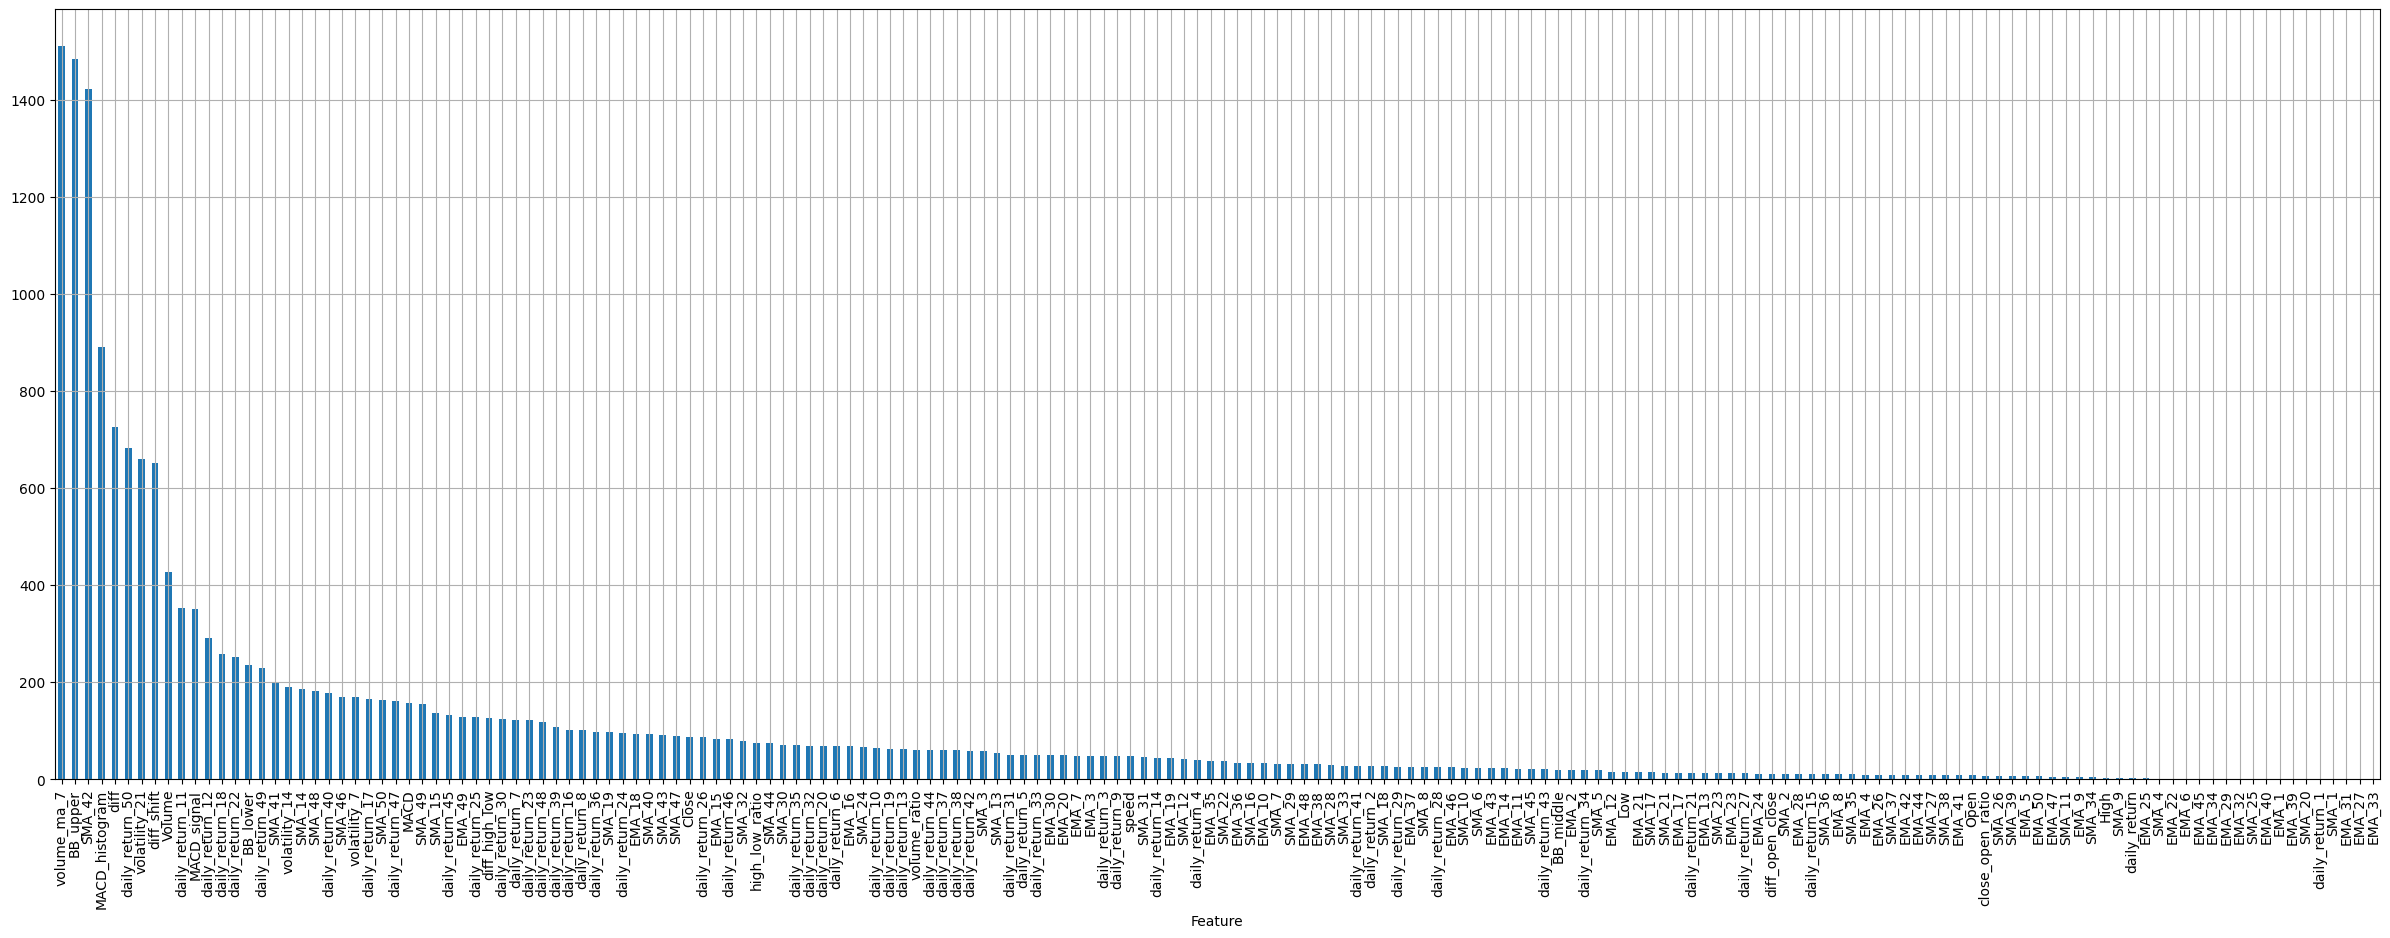

In [46]:
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [48]:
pthm = '/content/drive/MyDrive/datasets/traders/'
pthm = f'{pthm}model_{symbol}_{date}.pkl'
with open(pthm, 'wb') as f:
  pickle.dump(automl, f)

pthm

'/content/drive/MyDrive/datasets/traders/model_BNB_USDT_2025-07-31.pkl'

In [49]:
tmp = df[df['target']==1][-2:]
tmp

Open    High     Low   Close    Volume  diff  \
Date                                                                  
2025-04-22 16:00:00  609.78  619.98  602.65  606.61  3580.150    -1   
2025-07-02 16:00:00  661.64  664.83  656.70  657.06  1559.197    -1   

                     diff_shift  target  diff_high_low  diff_open_close  ...  \
Date                                                                     ...   
2025-04-22 16:00:00         0.0       1       173300.0          31700.0  ...   
2025-07-02 16:00:00         0.0       1        81300.0          45800.0  ...   

                       BB_upper    BB_lower  volatility_7  volatility_14  \
Date                                                                       
2025-04-22 16:00:00  616.319515  554.899485      9.162739      11.013741   
2025-07-02 16:00:00  668.143496  620.076504      6.355826      13.891377   

                     volatility_21  daily_return  high_low_ratio  \
Date                                                               
2025-04-22 16:00:00      14.966843     -0.005199        1.028756   
2025-07-02 16:00:00      11.889614     -0.006922        1.012380   

                     close_open_ratio  volume_ma_7  volume_ratio  
Date                                                              
2025-04-22 16:00:00          0.994801  2066.842429      1.732183  
2025-07-02 16:00:00          0.993078  1173.820857      1.328309  

[2 rows x 175 columns]

In [50]:
automl.predict(tmp)

array([[0.84478366],
       [0.2297642 ]], dtype=float32)

In [40]:
# def calculate_cross_asset_features(all_data):
#     """
#     Calculate features that compare assets or market-wide indicators
#     """
#     # Bitcoin dominance effect
#     btc_returns = all_data['BTC']['daily_return']

#     for symbol in all_data.keys():
#         if symbol != 'BTC':
#             # Correlation with Bitcoin
#             all_data[symbol]['btc_correlation'] = all_data[symbol]['daily_return'].rolling(window=30).corr(btc_returns)

#             # Relative strength vs Bitcoin
#             all_data[symbol]['relative_strength_btc'] = all_data[symbol]['close'] / all_data['BTC']['close']

#     # Market cap weighted average returns
#     market_avg_return = calculate_market_weighted_return(all_data)

#     for symbol in all_data.keys():
#         all_data[symbol]['market_relative_return'] = all_data[symbol]['daily_return'] - market_avg_return

#     return all_data


# def generate_labels(data, lookforward_days=7, min_gain=0.05, max_drawdown=0.03):
#     """
#     Generate binary labels for entry points
#     """
#     labels = []

#     for i in range(len(data) - lookforward_days):
#         entry_price = data.iloc[i]['close']
#         future_prices = data.iloc[i+1:i+lookforward_days+1]['close']
#         future_lows = data.iloc[i+1:i+lookforward_days+1]['low']

#         # Check for profitable opportunity
#         max_gain = (future_prices.max() - entry_price) / entry_price
#         max_drawdown = (entry_price - future_lows.min()) / entry_price

#         # Label as positive if conditions met
#         if max_gain >= min_gain and max_drawdown <= max_drawdown:
#             labels.append(1)
#         else:
#             labels.append(0)

#     return labels

# 4.3 Advanced Labeling Strategy

# Signal Strength: Weight labels based on magnitude of opportunity
# Risk-Adjusted Returns: Consider Sharpe ratio for labeling
# Market Regime: Adjust criteria based on bull/bear market conditions

# 5. Data Normalization and Scaling
# 5.1 Normalization Methods
# def normalize_features(data):
#     """
#     Apply appropriate normalization to different feature types
#     """
#     # Price-based features: Log transformation
#     price_features = ['close', 'open', 'high', 'low', 'MA_7', 'MA_14', 'MA_21', 'MA_50']
#     for feature in price_features:
#         data[f'{feature}_log'] = np.log(data[feature])

#     # Ratio features: StandardScaler
#     ratio_features = ['daily_return', 'volume_ratio', 'high_low_ratio']
#     scaler = StandardScaler()
#     data[ratio_features] = scaler.fit_transform(data[ratio_features])

#     # Bounded indicators: MinMaxScaler
#     bounded_features = ['RSI_14']
#     minmax_scaler = MinMaxScaler()
#     data[bounded_features] = minmax_scaler.fit_transform(data[bounded_features])

#     return data

# 5.2 Rolling Window Normalization

# Look-back Period: 252 days (1 year)
# Method: Z-score normalization using rolling mean and std
# Prevents Data Leakage: Only uses historical data for normalization

# 6. Handling Class Imbalance
# 6.1 Imbalance Assessment
# def assess_class_imbalance(labels):
#     """
#     Analyze class distribution across all assets
#     """
#     positive_ratio = sum(labels) / len(labels)
#     print(f"Positive class ratio: {positive_ratio:.3f}")

#     if positive_ratio < 0.1 or positive_ratio > 0.9:
#         print("Severe class imbalance detected")
#         return True
#     return False

# 6.2 Resampling Strategies

# SMOTE: Synthetic Minority Oversampling Technique for time series
# Random Undersampling: Reduce majority class while preserving temporal structure
# Ensemble Methods: Use class-weighted algorithms
# Threshold Adjustment: Optimize classification threshold post-training

# 6.3 Implementation
# def handle_class_imbalance(X, y, method='smote'):
#     """
#     Address class imbalance in the dataset
#     """
#     if method == 'smote':
#         smote = SMOTE(random_state=42)
#         X_resampled, y_resampled = smote.fit_resample(X, y)
#     elif method == 'undersample':
#         undersampler = RandomUnderSampler(random_state=42)
#         X_resampled, y_resampled = undersampler.fit_resample(X, y)

#     return X_resampled, y_resampled

# 7. Data Splitting Strategy
# 7.1 Time-Series Aware Splitting
# def create_train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
#     """
#     Create chronological splits for time series data
#     """
#     n_samples = len(data)

#     # Chronological split points
#     train_end = int(n_samples * train_ratio)
#     val_end = int(n_samples * (train_ratio + val_ratio))

#     train_data = data[:train_end]
#     val_data = data[train_end:val_end]
#     test_data = data[val_end:]

#     return train_data, val_data, test_data

# 7.2 Cross-Validation Strategy

# Time Series CV: Use TimeSeriesSplit with 5 folds
# Walk-Forward Validation: Simulate realistic trading conditions
# Asset-Based CV: Validate across different cryptocurrencies

# 8. Feature Selection and Dimensionality Reduction
# 8.1 Feature Importance Analysis
# def select_features(X, y, method='rf_importance'):
#     """
#     Select most informative features
#     """
#     if method == 'rf_importance':
#         rf = RandomForestClassifier(n_estimators=100, random_state=42)
#         rf.fit(X, y)
#         feature_importance = rf.feature_importances_

#         # Select top 50% features
#         top_features = np.argsort(feature_importance)[-int(len(feature_importance)*0.5):]
#         return top_features

#     elif method == 'mutual_info':
#         mi_scores = mutual_info_classif(X, y)
#         top_features = np.argsort(mi_scores)[-int(len(mi_scores)*0.5):]
#         return top_features

# 8.2 Correlation Analysis

# Remove Highly Correlated Features: Threshold > 0.95
# Variance Inflation Factor: Address multicollinearity
# Principal Component Analysis: Optional dimensionality reduction

# 9. Dataset Validation and Quality Assurance
# 9.1 Data Integrity Checks
# def validate_dataset(X, y):
#     """
#     Comprehensive dataset validation
#     """
#     checks = {
#         'no_data_leakage': check_temporal_consistency(X),
#         'feature_stability': check_feature_distributions(X),
#         'label_quality': validate_label_logic(y),
#         'missing_values': check_missing_data(X),
#         'outliers': detect_statistical_outliers(X)
#     }

#     return checks

# 9.2 Performance Benchmarks

# Random Baseline: 50% accuracy expectation
# Buy-and-Hold Strategy: Compare against passive investment
# Technical Analysis Baseline: Simple moving average crossover

# 10. Model Training Optimization
# 10.1 Algorithm Selection

# Gradient Boosting: XGBoost, LightGBM for tabular data
# Random Forest: Robust to overfitting
# Neural Networks: LSTM for sequence modeling
# Ensemble Methods: Combine multiple algorithms

# 10.2 Hyperparameter Optimization
# def optimize_hyperparameters(X_train, y_train, X_val, y_val):
#     """
#     Optimize model hyperparameters using validation set
#     """
#     from optuna import create_study

#     def objective(trial):
#         params = {
#             'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#             'max_depth': trial.suggest_int('max_depth', 3, 10),
#             'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#             'subsample': trial.suggest_float('subsample', 0.8, 1.0)
#         }

#         model = XGBClassifier(**params)
#         model.fit(X_train, y_train)
#         y_pred = model.predict_proba(X_val)[:, 1]

#         return roc_auc_score(y_val, y_pred)

#     study = create_study(direction='maximize')
#     study.optimize(objective, n_trials=100)

#     return study.best_params

# 11. Evaluation Metrics and Profitability Assessment
# 11.1 Classification Metrics

# Precision: Minimize false positives (bad entry signals)
# Recall: Capture profitable opportunities
# F1-Score: Balance precision and recall
# AUC-ROC: Model discrimination ability

# 11.2 Trading-Specific Metrics
# def calculate_trading_metrics(predictions, actual_returns):
#     """
#     Calculate trading-specific performance metrics
#     """
#     # Sharpe Ratio
#     sharpe = np.mean(actual_returns) / np.std(actual_returns) * np.sqrt(252)

#     # Maximum Drawdown
#     cumulative_returns = np.cumprod(1 + actual_returns)
#     max_drawdown = np.max(np.maximum.accumulate(cumulative_returns) - cumulative_returns)

#     # Win Rate
#     win_rate = np.mean(actual_returns > 0)

#     # Profit Factor
#     gross_profit = np.sum(actual_returns[actual_returns > 0])
#     gross_loss = np.sum(np.abs(actual_returns[actual_returns < 0]))
#     profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf

#     return {
#         'sharpe_ratio': sharpe,
#         'max_drawdown': max_drawdown,
#         'win_rate': win_rate,
#         'profit_factor': profit_factor
#     }

# 12. Production Pipeline
# 12.1 Real-time Data Pipeline
# def create_production_pipeline():
#     """
#     Create real-time prediction pipeline
#     """
#     # Data ingestion
#     data_pipeline = Pipeline([
#         ('collector', DataCollector()),
#         ('cleaner', DataCleaner()),
#         ('feature_engineer', FeatureEngineer()),
#         ('normalizer', DataNormalizer()),
#         ('predictor', TrainedModel())
#     ])

#     return data_pipeline

# 12.2 Model Monitoring

# Performance Drift Detection: Monitor prediction accuracy over time
# Data Drift Detection: Identify changes in input distributions
# Retraining Triggers: Automated model updates
# A/B Testing: Compare model versions

# 13. Risk Management Integration
# 13.1 Position Sizing

# Kelly Criterion: Optimal position sizing based on win rate and odds
# Risk Parity: Equal risk contribution across positions
# Volatility Targeting: Adjust position size based on expected volatility

# 13.2 Portfolio-Level Considerations

# Correlation Limits: Avoid over-concentration in correlated assets
# Sector Exposure: Diversify across different crypto sectors
# Liquidity Requirements: Ensure sufficient trading volume

# 14. Implementation Checklist
# 14.1 Data Collection

# [ ] Set up multiple data source APIs
# [ ] Implement data validation and quality checks
# [ ] Create automated data collection pipeline
# [ ] Set up data storage and versioning

# 14.2 Feature Engineering

# [ ] Implement all technical indicators
# [ ] Create cross-asset features
# [ ] Test feature stability across time periods
# [ ] Validate feature importance

# 14.3 Model Development

# [ ] Implement multiple algorithms
# [ ] Set up hyperparameter optimization
# [ ] Create ensemble methods
# [ ] Validate using walk-forward analysis

# 14.4 Production Deployment

# [ ] Create real-time prediction pipeline
# [ ] Implement monitoring and alerting
# [ ] Set up A/B testing framework
# [ ] Create risk management controls

# Conclusion
# This comprehensive algorithm provides a robust framework for creating a high-quality cryptocurrency trading dataset. The key to success lies in careful attention to data quality, feature engineering, and proper validation techniques that respect the temporal nature of financial data. Regular monitoring and retraining ensure the model remains effective as market conditions evolve.